## TOC:
* [EDA](#Loading)
* [Cross-Validation dataset](#cross-validation)
* [Fit a CNN](#fit-CNN)
* [Summary](#Summary)

*Week 7 Assignment*

**EDA and PCA/CNN on leaf classifcation**
***Ryan Amundson***

In this notebook, we are starting some explority data anaylsis along with training a CNN for classifying


In [1]:
# Imports
import os
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import timeit 
import cv2

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from scikeras.wrappers import KerasClassifier

from yellowbrick.classifier import ROCAUC

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from IPython import display
from base64 import b64decode


%matplotlib inline

## EDA <a class="anchor" id="Loading"></a>

In [2]:
# Set some options to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


leafDf = pd.read_csv('leaf-classification/train.csv')

encoder = LabelEncoder().fit(leafDf.species)
labels = encoder.transform(leafDf.species)  # encode species strings and return labels with value between 0 and n_classes-1

leafTestDf = pd.read_csv('leaf-classification/test.csv')

print("There are {} missing rows in the data".format(sum(leafDf.isna().sum())))

leafDf = leafDf.dropna()

print("There are {} features in the data".format(len(leafDf.columns)))

print("There are {} different leaf classes in the data".format(len(leafDf.species.unique())))

leafDf.columns
labelMap = dict(zip(labels, leafDf.species))
labelMap

There are 0 missing rows in the data
There are 194 features in the data
There are 99 different leaf classes in the data


{3: 'Acer_Opalus',
 49: 'Pterocarya_Stenoptera',
 65: 'Quercus_Hartwissiana',
 94: 'Tilia_Tomentosa',
 84: 'Quercus_Variabilis',
 40: 'Magnolia_Salicifolia',
 54: 'Quercus_Canariensis',
 78: 'Quercus_Rubra',
 53: 'Quercus_Brantii',
 89: 'Salix_Fragilis',
 98: 'Zelkova_Serrata',
 16: 'Betula_Austrosinensis',
 74: 'Quercus_Pontica',
 50: 'Quercus_Afares',
 58: 'Quercus_Coccifera',
 31: 'Fagus_Sylvatica',
 43: 'Phildelphus',
 4: 'Acer_Palmatum',
 75: 'Quercus_Pubescens',
 44: 'Populus_Adenopoda',
 83: 'Quercus_Trojana',
 13: 'Alnus_Sieboldiana',
 66: 'Quercus_Ilex',
 15: 'Arundinaria_Simonii',
 6: 'Acer_Platanoids',
 73: 'Quercus_Phillyraeoides',
 22: 'Cornus_Chinensis',
 36: 'Liriodendron_Tulipifera',
 27: 'Cytisus_Battandieri',
 88: 'Rhododendron_x_Russellianum',
 12: 'Alnus_Rubra',
 28: 'Eucalyptus_Glaucescens',
 21: 'Cercis_Siliquastrum',
 25: 'Cotinus_Coggygria',
 20: 'Celtis_Koraiensis',
 60: 'Quercus_Crassifolia',
 69: 'Quercus_Kewensis',
 23: 'Cornus_Controversa',
 76: 'Quercus_Py

In [3]:
leafDf.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,margin40,margin41,margin42,margin43,margin44,margin45,margin46,margin47,margin48,margin49,margin50,margin51,margin52,margin53,margin54,margin55,margin56,margin57,margin58,margin59,margin60,margin61,margin62,margin63,margin64,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,shape10,shape11,shape12,shape13,shape14,shape15,shape16,shape17,shape18,shape19,shape20,shape21,shape22,shape23,shape24,shape25,shape26,shape27,shape28,shape29,shape30,shape31,shape32,shape33,shape34,shape35,shape36,shape37,shape38,shape39,shape40,shape41,shape42,shape43,shape44,shape45,shape46,shape47,shape48,shape49,shape50,shape51,shape52,shape53,shape54,shape55,shape56,shape57,shape58,shape59,shape60,shape61,shape62,shape63,shape64,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,texture14,texture15,texture16,texture17,texture18,texture19,texture20,texture21,texture22,texture23,texture24,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,0.024209,0.011975,0.041252,0.008053,0.015609,0.000110,0.0151

In [4]:
leafTestDf.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,margin40,margin41,margin42,margin43,margin44,margin45,margin46,margin47,margin48,margin49,margin50,margin51,margin52,margin53,margin54,margin55,margin56,margin57,margin58,margin59,margin60,margin61,margin62,margin63,margin64,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,shape10,shape11,shape12,shape13,shape14,shape15,shape16,shape17,shape18,shape19,shape20,shape21,shape22,shape23,shape24,shape25,shape26,shape27,shape28,shape29,shape30,shape31,shape32,shape33,shape34,shape35,shape36,shape37,shape38,shape39,shape40,shape41,shape42,shape43,shape44,shape45,shape46,shape47,shape48,shape49,shape50,shape51,shape52,shape53,shape54,shape55,shape56,shape57,shape58,shape59,shape60,shape61,shape62,shape63,shape64,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,texture14,texture15,texture16,texture17,texture18,texture19,texture20,texture21,texture22,texture23,texture24,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,0.005859,0.021484,0.076172,0.001953,0.035156,0.000000,0.001953,0.021484,0.001953,0.015625,0.009766,0.000000,0.000000,0.005859,0.007812,0.015625,0.000000,0.017578,0.029297,0.021484,0.001953,0.003906,0.025391,0.000000,0.013672,0.005859,0.042969,0.064453,0.031250,0.005859,0.003906,0.001953,0.021484,0.025391,0.005859,0.001953,0.023438,0.068359,0.000000,0.011719,0.031250,0.001953,0.011719,0.003906,0.007812,0.000000,0.009766,0.003906,0.054688,0.000000,0.000000,0.000000,0.052734,0.000000,0.000782,0.000828,0.000876,0.000927,0.000993,0.001060,0.001123,0.001205,0.001295,0.001393,0.001496,0.001601,0.001679,0.001590,0.001492,0.001398,0.001314,0.001238,0.001186,0.001125,0.001070,0.001005,0.000943,0.000886,0.000826,0.000783,0.000741,0.000702,0.000671,0.000668,0.000682,0.000705,0.000736,0.000763,0.000805,0.000861,0.000918,0.000979,0.001054,0.001132,0.001212,0.001279,0.001364,0.001420,0.001435,0.001436,0.001418,0.001359,0.001284,0.001206,0.001134,0.001055,0.001003,0.000941,0.000879,0.000819,0.000762,0.000717,0.000698,0.000688,0.000680,0.000695,0.000719,0.000737,0.112310,0.013672,0.011719,0.004883,0.010742,0.022461,0.055664,0.028320,0.040039,0.008789,0.006836,0.00000,0.008789,0.008789,0.000000,0.0,0.017578,0.000977,0.025391,0.023438,0.0,0.000977,0.023438,0.000000,0.004883,0.000000,0.013672,0.001953,0.045898,0.024414,0.045898,0.000000,0.000000,0.070312,0.011719,0.000000,0.000000,0.054688,0.024414,0.026367,0.000000,0.000977,0.010742,0.020508,0.013672,0.034180,0.025391,0.000000,0.014648,0.018555,0.000000,0.000000,0.000000,0.015625,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,0.009766,0.019531,0.039062,0.027344,0.017578,0.000000,0.017578,0.015625,0.009766,0.009766,0.042969,0.007812,0.000000,0.003906,0.005859,0.011719,0.007812,0.009766,0.037109,0.013672,0.005859,0.003906,0.019531,0.000000,0.005859,0.029297,0.019531,0.041016,0.005859,0.003906,0.001953,0.009766,0.031250,0.001953,0.029297,0.007812,0.037109,0.009766,0.001953,0.058594,0.029297,0.001953,0.021484,0.003906,0.005859,0.000000,0.021484,0.015625,0.048828,0.000000,0.000000,0.007812,0.029297,0.013672,0.000534,0.000

In [5]:
leafDf.species.value_counts()

Acer_Opalus                     10
Crataegus_Monogyna              10
Acer_Mono                       10
Magnolia_Heptapeta              10
Acer_Capillipes                 10
Populus_Nigra                   10
Alnus_Cordata                   10
Tilia_Platyphyllos              10
Eucalyptus_Neglecta             10
Quercus_Chrysolepis             10
Quercus_Cerris                  10
Quercus_Coccinea                10
Acer_Circinatum                 10
Ilex_Aquifolium                 10
Viburnum_x_Rhytidophylloides    10
Lithocarpus_Cleistocarpus       10
Acer_Rufinerve                  10
Acer_Pictum                     10
Quercus_Agrifolia               10
Alnus_Maximowiczii              10
Quercus_Palustris               10
Quercus_Phellos                 10
Liquidambar_Styraciflua         10
Cornus_Macrophylla              10
Quercus_x_Turneri               10
Quercus_Texana                  10
Quercus_Castaneifolia           10
Quercus_Infectoria_sub          10
Salix_Intergra      

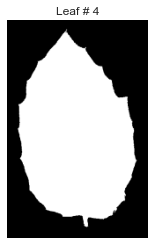

In [6]:
def leaf_image(image_id, target_length=160):
    
    image_name = str(image_id) + '.jpg'
    leaf_img = plt.imread('leaf-classification/images/' + image_name)  # Reading in the image 
    leaf_img_width = leaf_img.shape[1]
    leaf_img_height = leaf_img.shape[0]
   
    img_target = np.zeros((target_length, target_length), np.uint8)
    scale_img_width = target_length
    scale_img_height = int( (float(scale_img_width)/leaf_img_width)*leaf_img_height )
    img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
    
    return img_scaled


leaf_id = 4
leaf_img = leaf_image(leaf_id, target_length=160)

plt.imshow(leaf_img, cmap='gray')
plt.title('Leaf # '+str(leaf_id))

plt.axis('off')

plt.show()

[201 270 307 385 447 586 653 779 930 935]


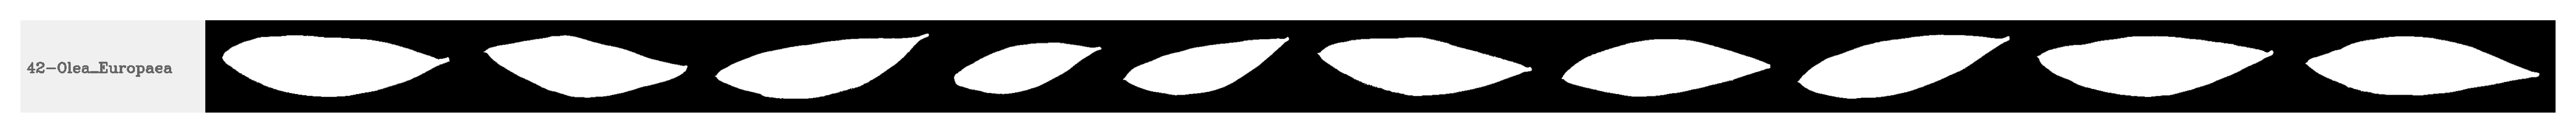

42-Olea_Europaea


In [7]:
def species_image(species):
    
    img = 240*np.ones([160, 320], np.uint8)
    imagesIdx = np.where(labels==species)[0]
    
    print(imagesIdx)
    
    labelInfo = str(species) + '-' + leafDf.species[imagesIdx[0]]
    
    for i in imagesIdx:
        
        lid = leafDf.id[i]
        
        leaf = leaf_image(lid)
        img = np.append(img, leaf.T, axis=1)
    
    cv2.putText(img, labelInfo, (10, 90), cv2.FONT_HERSHEY_COMPLEX, 0.8, (100, 170, 0), 2)
            
    return img, labelInfo
        
    
species_img, label_info = species_image(42)
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w', frameon=False, linewidth = 0)

plt.imshow(species_img, cmap='gray')
plt.axis('off')
plt.show()

print(label_info)


## Cross-validation dataset creation <a class="anchor" id="cross-validation"></a>

In [8]:
# Now let's create a test/training set
# Let's get a stratfied split this time, so we are not missing categories

X, X_test, y, y_test = train_test_split(leafDf.copy(), 
                                        labels, 
                                        test_size=0.2, 
                                        random_state=42,
                                        stratify=labels)

X

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,margin40,margin41,margin42,margin43,margin44,margin45,margin46,margin47,margin48,margin49,margin50,margin51,margin52,margin53,margin54,margin55,margin56,margin57,margin58,margin59,margin60,margin61,margin62,margin63,margin64,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,shape10,shape11,shape12,shape13,shape14,shape15,shape16,shape17,shape18,shape19,shape20,shape21,shape22,shape23,shape24,shape25,shape26,shape27,shape28,shape29,shape30,shape31,shape32,shape33,shape34,shape35,shape36,shape37,shape38,shape39,shape40,shape41,shape42,shape43,shape44,shape45,shape46,shape47,shape48,shape49,shape50,shape51,shape52,shape53,shape54,shape55,shape56,shape57,shape58,shape59,shape60,shape61,shape62,shape63,shape64,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,texture14,texture15,texture16,texture17,texture18,texture19,texture20,texture21,texture22,texture23,texture24,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
207,354,Quercus_Palustris,0.000000,0.000000,0.070312,0.136720,0.005859,0.000000,0.000000,0.000000,0.001953,0.000000,0.000000,0.003906,0.001953,0.048828,0.003906,0.0,0.001953,0.023438,0.025391,0.005859,0.007812,0.000000,0.000000,0.000000,0.027344,0.011719,0.005859,0.044922,0.060547,0.001953,0.001953,0.001953,0.001953,0.000000,0.000000,0.003906,0.011719,0.037109,0.003906,0.001953,0.005859,0.025391,0.003906,0.007812,0.027344,0.003906,0.037109,0.000000,0.017578,0.000000,0.000000,0.001953,0.000000,0.029297,0.000000,0.001953,0.000000,0.017578,0.220700,0.025391,0.007812,0.001953,0.005859,0.003906,0.000469,0.000451,0.000420,0.000380,0.000368,0.000359,0.000326,0.000298,0.000298,0.000301,0.000270,0.000232,0.000249,0.000276,0.000235,0.000226,0.000264,0.000262,0.000259,0.000300,0.000321,0.000315,0.000360,0.000358,0.000402,0.000427,0.000477,0.000502,0.000549,0.000583,0.000626,0.000642,0.000597,0.000557,0.000529,0.000480,0.000460,0.000436,0.000397,0.000354,0.000335,0.000283,0.000278,0.000263,0.000227,0.000250,0.000231,0.000206,0.000248,0.000224,0.000221,0.000269,0.000271,0.000276,0.000319,0.000343,0.000361,0.000396,0.000420,0.000446,0.000471,0.000482,0.000476,0.000468,0.000000,0.007812,0.030273,0.000977,0.054688,0.000977,0.003906,0.042969,0.012695,0.000000,0.012695,0.011719,0.007812,0.050781,0.0,0.000000,0.006836,0.001953,0.001953,0.018555,0.000000,0.023438,0.018555,0.000000,0.004883,0.000000,0.001953,0.022461,0.042969,0.040039,0.066406,0.017578,0.000977,0.001953,0.039062,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.004883,0.000000,0.000000,0.009766,0.044922,0.028320,0.066406,0.028320,0.059570,0.000000,0.117190,0.001953,0.018555,0.038086,0.000000,0.002930,0.000000,0.017578,0.0,0.000000,0.000977,0.000977,0.000977
252,420,Quercus_Rubra,0.003906,0.001953,0.058594,0.048828,0.005859,0.017578,0.000000,0.000000,0.048828,0.000000,0.005859,0.003906,0.035156,0.021484,0.009766,0.0,0.005859,0.015625,0.013672,0.009766,0.035156,0.005859,0.000000,0.000000,0.013672,0.011719,0.005859,0.031250,0.046875,0.007812,0.005859,0.001953,0.007812,0.000000,0.009766,0.005859,0.025391,0.060547,0.007812,0.000000,0.007812,0.037109,0.003906,0.003906,0.042969,0.001953,0.046875,0.009766,0.007812,0.015625,0.031250,0.000000,0.001953,0.003906,0.000000,0.005859,0.007812,0.037109,0.056641,

In [9]:
# Create image test/train splits
X_image = pd.DataFrame(X.id, columns=["id"])
X_image["file"] = "leaf-classification/images/" +  X_image.id.astype(str)  + ".jpg"


X_test_image = pd.DataFrame(X_test.id, columns=["id"])
X_test_image["file"] = "leaf-classification/images/" +  X_test_image.id.astype(str) + ".jpg"


X = X.drop(['id', 'species'], axis = 1)
X_test = X_test.drop(['id', 'species'], axis = 1)
X


,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,margin40,margin41,margin42,margin43,margin44,margin45,margin46,margin47,margin48,margin49,margin50,margin51,margin52,margin53,margin54,margin55,margin56,margin57,margin58,margin59,margin60,margin61,margin62,margin63,margin64,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,shape10,shape11,shape12,shape13,shape14,shape15,shape16,shape17,shape18,shape19,shape20,shape21,shape22,shape23,shape24,shape25,shape26,shape27,shape28,shape29,shape30,shape31,shape32,shape33,shape34,shape35,shape36,shape37,shape38,shape39,shape40,shape41,shape42,shape43,shape44,shape45,shape46,shape47,shape48,shape49,shape50,shape51,shape52,shape53,shape54,shape55,shape56,shape57,shape58,shape59,shape60,shape61,shape62,shape63,shape64,texture1,texture2,texture3,texture4,texture5,texture6,texture7,texture8,texture9,texture10,texture11,texture12,texture13,texture14,texture15,texture16,texture17,texture18,texture19,texture20,texture21,texture22,texture23,texture24,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
207,0.000000,0.000000,0.070312,0.136720,0.005859,0.000000,0.000000,0.000000,0.001953,0.000000,0.000000,0.003906,0.001953,0.048828,0.003906,0.0,0.001953,0.023438,0.025391,0.005859,0.007812,0.000000,0.000000,0.000000,0.027344,0.011719,0.005859,0.044922,0.060547,0.001953,0.001953,0.001953,0.001953,0.000000,0.000000,0.003906,0.011719,0.037109,0.003906,0.001953,0.005859,0.025391,0.003906,0.007812,0.027344,0.003906,0.037109,0.000000,0.017578,0.000000,0.000000,0.001953,0.000000,0.029297,0.000000,0.001953,0.000000,0.017578,0.220700,0.025391,0.007812,0.001953,0.005859,0.003906,0.000469,0.000451,0.000420,0.000380,0.000368,0.000359,0.000326,0.000298,0.000298,0.000301,0.000270,0.000232,0.000249,0.000276,0.000235,0.000226,0.000264,0.000262,0.000259,0.000300,0.000321,0.000315,0.000360,0.000358,0.000402,0.000427,0.000477,0.000502,0.000549,0.000583,0.000626,0.000642,0.000597,0.000557,0.000529,0.000480,0.000460,0.000436,0.000397,0.000354,0.000335,0.000283,0.000278,0.000263,0.000227,0.000250,0.000231,0.000206,0.000248,0.000224,0.000221,0.000269,0.000271,0.000276,0.000319,0.000343,0.000361,0.000396,0.000420,0.000446,0.000471,0.000482,0.000476,0.000468,0.000000,0.007812,0.030273,0.000977,0.054688,0.000977,0.003906,0.042969,0.012695,0.000000,0.012695,0.011719,0.007812,0.050781,0.0,0.000000,0.006836,0.001953,0.001953,0.018555,0.000000,0.023438,0.018555,0.000000,0.004883,0.000000,0.001953,0.022461,0.042969,0.040039,0.066406,0.017578,0.000977,0.001953,0.039062,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.004883,0.000000,0.000000,0.009766,0.044922,0.028320,0.066406,0.028320,0.059570,0.000000,0.117190,0.001953,0.018555,0.038086,0.000000,0.002930,0.000000,0.017578,0.0,0.000000,0.000977,0.000977,0.000977
252,0.003906,0.001953,0.058594,0.048828,0.005859,0.017578,0.000000,0.000000,0.048828,0.000000,0.005859,0.003906,0.035156,0.021484,0.009766,0.0,0.005859,0.015625,0.013672,0.009766,0.035156,0.005859,0.000000,0.000000,0.013672,0.011719,0.005859,0.031250,0.046875,0.007812,0.005859,0.001953,0.007812,0.000000,0.009766,0.005859,0.025391,0.060547,0.007812,0.000000,0.007812,0.037109,0.003906,0.003906,0.042969,0.001953,0.046875,0.009766,0.007812,0.015625,0.031250,0.000000,0.001953,0.003906,0.000000,0.005859,0.007812,0.037109,0.056641,0.027344,0.001953,0.007812,0.041016,0.009766,0.0006

In [10]:
X_image

,id,file
207,354,leaf-classification/images/354.jpg
252,420,leaf-classification/images/420.jpg
10,17,leaf-classification/images/17.jpg
865,1386,leaf-classification/images/1386.jpg
497,806,leaf-classification/images/806.jpg
...,...,...
323,528,leaf-classification/images/528.jpg
829,1329,leaf-classification/images/1329.jpg
528,853,leaf-classification/images/853.jpg
344,564,leaf-classification/images/564.jpg


In [11]:
# Keras stuff
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img


def load_numeric_test(standardize=True):
    test = pd.read_csv(os.path.join(root, 'test.csv'))
    ID = test.pop('id')
    
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=256):
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(df, max_dim=256, center=True):
    
    X = np.empty((len(df), max_dim, max_dim, 1))
    
    for i, fn in enumerate(df.file):
        # Turn the image into an array
        x = resize_img(load_img(fn, grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        length = x.shape[0]
        width = x.shape[1]
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        X[i, h1:h2, w1:w2, 0:1] = x
        
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


## CNN Tuning <a class="anchor" id="fit-CNN"></a>

In [12]:
# Let's also try adding a convolutional layer in the middle 

# Squash annoying warns
import warnings
warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)

@tf.autograph.experimental.do_not_convert
def create_conv_model(layers=1, nodes=20, num_input=784, num_output=99, num_conv=2, learning_rate=0.0001, opt='rms'):
    
    all_layers = [tf.keras.layers.InputLayer(input_shape=(num_input,))]
    
    # Reshape the images into the correct shape
    all_layers.append(tf.keras.layers.Reshape(target_shape=(8, 8, 3)) ) 
    
    # Conv layers
    for i in list(range(num_conv)):
        all_layers.append(tf.keras.layers.Conv2D(16*(i+1),(3,3), activation=tf.nn.relu, padding='Same') ) 
        all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    
    # Add a dropout layer
    all_layers.append(tf.keras.layers.Dropout(.25))
    
    all_layers.append(tf.keras.layers.Flatten() )
    
    for i in range(layers):
        all_layers.append(tf.keras.layers.Dense(nodes, activation=tf.nn.relu))
        
    # Add a dropout layer
    all_layers.append(tf.keras.layers.Dropout(.4))
                                         
    all_layers.append(tf.keras.layers.Dense(num_output, activation='softmax'))
    
    model = tf.keras.Sequential(all_layers)
    
    opt = tf.keras.optimizers.Adam(learning_rate) if opt=='adam' else tf.optimizers.RMSprop(learning_rate)
    
    model.compile(opt, 
                  loss='sparse_categorical_crossentropy',
                   metrics=[tf.keras.metrics.mae, tf.keras.metrics.sparse_categorical_accuracy])
    
    return model

def run_conv():
    
    #define model
    classifier = KerasClassifier(model=create_conv_model, layers=None, nodes=None, num_input=None, num_output=None, num_conv=None, learning_rate=None, opt=None, verbose=0)
    
    pipelineKerasCNN = Pipeline([
                            ("classifier", classifier)])
    
    params={'classifier__batch_size':[50, 100], 
        'classifier__epochs':[100, 50],
        'classifier__layers':[1, 2],
        'classifier__num_conv':[1, 2],
        'classifier__opt':['adam', 'rms'],
        'classifier__nodes':[40, 100, 200],
        'classifier__learning_rate': np.linspace(0.00001, 0.0005, num=3),
        'classifier__validation_split':[0.2],
        'classifier__num_input': [len(X.columns)],
        'classifier__num_output': [len(leafDf.species.unique())]
        }
    
    gs=HalvingGridSearchCV(estimator=pipelineKerasCNN,
                           param_grid=params, 
                           factor=2,
                           aggressive_elimination=True,
                           cv=3,
                           verbose=1,
                           n_jobs=4)

    start_time = timeit.default_timer()
    l_grid_result = gs.fit(X, y)
    stop_time = timeit.default_timer()
    
    l_best_params = {'classifier__batch_size': 32, 'classifier__epochs': 100, 'classifier__layers': 1, 
                     'classifier__learning_rate': 0.0005, 'classifier__nodes': 400, 'classifier__num_input': 192, 
                     'classifier__num_conv': 1, 'classifier__opt': 'adam', 
                     'classifier__num_output': 99, 'classifier__validation_split': 0.2} 
    l_best_params = l_grid_result.best_params_

    print("Grid search fit time: {time}".format(time=round(stop_time - start_time, 2)))
          
    print(l_best_params)
    
    classifier = KerasClassifier(model=lambda: create_conv_model(l_best_params["classifier__layers"], 
                                                                    l_best_params["classifier__nodes"], 
                                                                    l_best_params["classifier__num_input"], 
                                                                    l_best_params["classifier__num_output"], 
                                                                    l_best_params["classifier__num_conv"],
                                                                    l_best_params["classifier__learning_rate"],
                                                                    l_best_params["classifier__opt"]), verbose=0)
    
    pipelineKerasCNN = Pipeline([("classifier", classifier)])
    
    start_time = timeit.default_timer()
    
    fit_hist = pipelineKerasCNN.fit(X, y, classifier__epochs=l_best_params["classifier__epochs"], 
                                 classifier__batch_size=l_best_params["classifier__batch_size"], 
                                 classifier__validation_split=l_best_params["classifier__validation_split"])
    stop_time = timeit.default_timer()


    print("CNN with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=l_best_params["classifier__layers"],
                                                                         num_nodes=l_best_params["classifier__nodes"]))
    
    pipelineKerasCNN.steps[0][1].model().summary()
    y_pred = pipelineKerasCNN.predict(X_test)#.argmax(axis=1)

    fig, axs = plt.subplots(1, 1, figsize=(20, 15))

    conMatrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

    ax.set_title('Seaborn Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
    print("Recall score: {:.3f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print("Accuracy score: {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("F1 score: {:.3f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))
    
    return pipelineKerasCNN, l_best_params

pipelineKerasCNN, l_best_params = run_conv()


n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 1
min_resources_: 594
max_resources_: 792
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 288
n_resources: 594
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro


KeyboardInterrupt: 

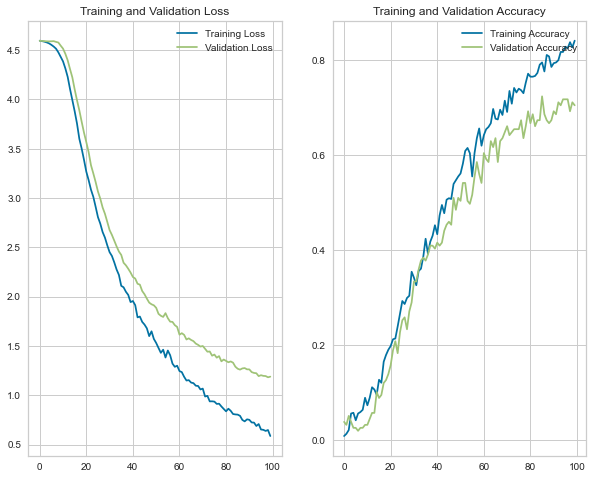


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [16]:
history = pipelineKerasCNN.steps[0][1].history_

loss = history['loss']
val_loss = history['val_loss']

acc = history['sparse_categorical_accuracy']
val_acc = history['val_sparse_categorical_accuracy']

epochs_range = range(l_best_params["classifier__epochs"])

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(121)


ax1 = plt.plot(epochs_range, loss, label='Training Loss')
ax1 = plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax2 = plt.subplot(122)

ax2 = plt.plot(epochs_range, acc, label='Training Accuracy')
ax2 = plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

In [25]:

predictions = pipelineKerasCNN.predict(leafTestDf[leafTestDf.columns[~leafTestDf.columns.isin(['id'])]].copy())

df = leafTestDf.id.copy()

df["species"] = np.vectorize(labelMap.__getitem__)(predictions)

df = pd.get_dummies(df["species"])
df["id"] = leafTestDf.id

if len(df.columns) - 1 < len(labelMap):
    
    missing = set(labelMap.values()) - set(df.columns) 
    for m in missing:
        print("Adding column {}".format(m))
        df[m] = 0

#df.index += 1 
#df
df.to_csv("leaf-classification/predictions_cnn.csv", index=False)

Adding column Crataegus_Monogyna


In [26]:
df

,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,Alnus_Cordata,Alnus_Maximowiczii,Alnus_Rubra,Alnus_Sieboldiana,Alnus_Viridis,Arundinaria_Simonii,Betula_Austrosinensis,Betula_Pendula,Callicarpa_Bodinieri,Castanea_Sativa,Celtis_Koraiensis,Cercis_Siliquastrum,Cornus_Chinensis,Cornus_Controversa,Cornus_Macrophylla,Cotinus_Coggygria,Cytisus_Battandieri,Eucalyptus_Glaucescens,Eucalyptus_Neglecta,Eucalyptus_Urnigera,Fagus_Sylvatica,Ginkgo_Biloba,Ilex_Aquifolium,Ilex_Cornuta,Liquidambar_Styraciflua,Liriodendron_Tulipifera,Lithocarpus_Cleistocarpus,Lithocarpus_Edulis,Magnolia_Heptapeta,Magnolia_Salicifolia,Morus_Nigra,Olea_Europaea,Phildelphus,Populus_Adenopoda,Populus_Grandidentata,Populus_Nigra,Prunus_Avium,Prunus_X_Shmittii,Pterocarya_Stenoptera,Quercus_Afares,Quercus_Agrifolia,Quercus_Alnifolia,Quercus_Brantii,Quercus_Canariensis,Quercus_Castaneifolia,Quercus_Cerris,Quercus_Chrysolepis,Quercus_Coccifera,Quercus_Coccinea,Quercus_Crassifolia,Quercus_Crassipes,Quercus_Dolicholepis,Quercus_Ellipsoidalis,Quercus_Greggii,Quercus_Hartwissiana,Quercus_Ilex,Quercus_Imbricaria,Quercus_Infectoria_sub,Quercus_Kewensis,Quercus_Nigra,Quercus_Palustris,Quercus_Phellos,Quercus_Phillyraeoides,Quercus_Pontica,Quercus_Pubescens,Quercus_Pyrenaica,Quercus_Rhysophylla,Quercus_Rubra,Quercus_Semecarpifolia,Quercus_Shumardii,Quercus_Suber,Quercus_Texana,Quercus_Trojana,Quercus_Variabilis,Quercus_Vulcanica,Quercus_x_Hispanica,Quercus_x_Turneri,Rhododendron_x_Russellianum,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata,id,Crataegus_Monogyna
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1576,0
590,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1577,0
591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1579,0
592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1580,0


In [23]:
len(df.columns)

99

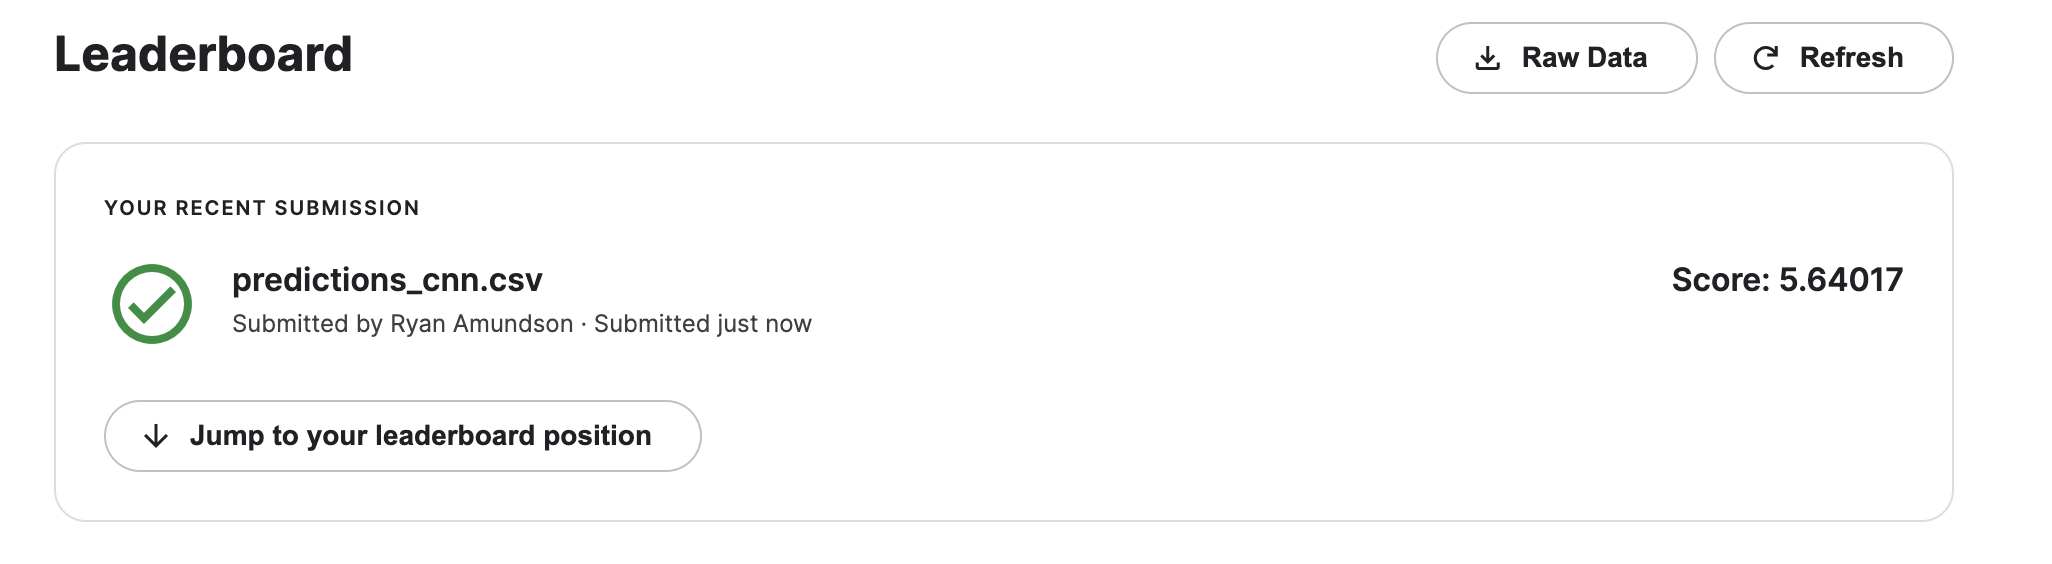

In [213]:

from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAACAQAAAI0CAYAAACA12m/AAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAACASgAwAEAAAAAQAAAjQAAAAAQVNDSUkAAABTY3JlZW5zaG90/6TddgAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTY0PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIwNTI8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KQMeySgAAABxpRE9UAAAAAgAAAAAAAAEaAAAAKAAAARoAAAEaAAJwhABsUiYAAEAASURBVHgB7H0JuGVVce66jSDQ3cjQjDIKRFRQoSEvcZ4FMmkwMc5A40gcEvXlS4CY0SQv7yUxKjjF5H0Z1AhoEhOHJ5NDEAGlwZGhJ0YVGqS7GZruvq9q1fprVa219+3uS9+eqK3s+qvqX6vOrlOr9u579tlnYpK2NLCxccLayTBJBth41ERRhGtGAGY5mSZpFMbJlCDYAB53DDJE/Mg/6ijqL9Zf9B/bTU3HBMwy+m+cf+L8i/OGXTH+isNrWEJqJUNcf8T1B+oorj/i+iOuP2w3NR0TMMu4/ojrj7j+wHnDrhi9thgAWELqIkNcf8T1B+oorj/i+iOuP2w3NR0TMMu4/ojrj7j+wHnDrhi9thgAWELqIkNcf8T1B+oorj/i+iOuP2w3NR0TMMtt6/pjAjcEdC/brng9K1TQ8auLkMtI9XRmGHhEc9kS8WvHqRlU1OVLPQyQV8jihAqpvMh/l8+ov6g/nPHc2hKlqxfHwQKDjPWXM4B0QEb/obTIJXZXT9F/ov9E/3Fd1SrderFO7SvaaMQLFVJ5cf3T5TP6T/Sf6D+uq1ilWy/WqX1FG030H84A0gGphui/XT1F/43+G/3XdVWrdOvFOrWvaKMRL1RI5UX/6fIZ/Sf6T/Qf11Ws0q0X69S+oo0m+g9nAOmAVEP0366eov9G/43+67qqVbr1Yp3aV7TRiBcqpPKi/yCfE5PrqPPgtp+SVM0X6fwAgYlSmNbu8s88+s9N0xgaNQ/PtgGHNUX8yH/UHz40bNaYWYR2zdTFVQmdn1zZNuCwplh/sf5i/cX6405i+0LtLII6X2No1Dwo2wYc1hT9J/pP9J/oP9wwbF+QrlP3na8xNGoemG0DDmuK/hP9J/pP9B9uGLYv1M4jqPM1hkbNg7JtwGFN0X+i/0T/if7DDcP2Bek6dd/5GkOj5oHZNuCwpug/0X+i/0T/4YZh+0LtPII6X2No1Dwo2wYc1hT9J/pP9J/oP9wwbF+QrlP3na8xNGoemG0DDmt6pPUffUKApNamgi1Wt1jYzl1MGCNs2tvnzIAzevdTG8PqFkf8nIGBlET+JSm6j/rr7yKI9Tdy92G7oKxucfSf6D+UgYGSgFFctI/+E/1HrudL0+C6oboYvPu3LSirW1ymGjBF/UlSdB/rL9ZfrL/aexhF/4n+G+cfvyay1p5QrW5xGTpgivOvJEX3cf6N82+cf32vifNvnH/j/OvXRJx/KQPtBYXVLS6pGzBhDnHRPs6/cf6N86/vNXH+jfNvnH/9msga3XxEd0Dwpk8BkBMKe0sXyWcWPb3kYegv1eotmWR3TOST3eCbQJ6IH/nX2sjFQvUS9ZeXUF5keZcvF9nmV5v4Mre7oBSrDCSe5rjY4Y71F+tPa4PribdYfzkNeXnJGmsyU1ab+DI31l+tG0lITQvnRmvMOuP8H9c/cf2Ju+Dj+rvpsrm9So9tPNF/c7eV3NRGi6tD02Nz4mgX/dckpcLov9F/o/+ibzRdNreXvMv9lleNZU64a17h1ZVVUJ6SdtF/utSwIfpP9J/oP7ar8Kooem4p0ldyG6meuP7LuZDccMbk3w7Io1jUzNmK/muSUmH03+i/0X/RN5oum9uL9JjGE/2XWkhc/0ptSDe1uPbXXChx/tkmzr/yhID8PsqbqZDfT/QI896OQR7HWx7iFLHbfefWoGV5dQQ7ehi7IU7p+Z2bDRN5J02uI/RztBY3xCkts/uTb7mOi/hcPTkL68lfn9Emp+sZ37k1aMTXVHCSY/0PldqgzdWUU3p659akR/1pKjhtUX998YxYXE05pR/QuTXpUX+aCk5b1F9fPCMWV1NO6Qd0bk161J+mgtMW9dcXz4jF1ZRT+gGdW5Me9aep4LRF/fXFM2JxNeWUfkDn1qRH/WkqOG1Rf33xjFhcTTmlH9C5NelRf5oKTlvUX188IxZXU07pB3RuTXrUn6aC0xb11xfPiMXVlFP6AZ1bkx71p6ngtEX99cUzYnE15ZR+QOfWpEf9aSo4bVF/ffGMWFxNOaUf0Lk16VF/mgpOW9RfXzwjFldTTukHdG5NetSfpoLTtgXqb2Id3R7n4+aXVN5F89YVs/UySfQRZ5mFSZP0gfuEHiFmmSRXtQodPszOkl7hSAgxjzhlwjw24ttMI8eRf5sVKRfkhjXGvEX9xfpzZZCrgndSLaVmbOkoQ0jRf+xKQ6Ki/9isSMkgN6wx5i36T/QfVwa5Kngn1VJqxpaOMoQU/ceuNCQq+o/NipQMcsMaY96i/0T/cWWQq4J3Ui2lZmzpKENI0X/sSkOiov/YrEjJIDesMeYt+k/0H1cGuSp4J9VSasaWjjKEFP3HrjQkKvqPzYqUDHLDGmPeov9E/3FlkKuCd1ItpWZs6ShDSNF/7EpDoqL/2KxIySA3rDHmLfpP9B9XBrkqeCfVUmrGlo4yhBT9x640JCr6j82KlAxywxpj3qL/PFL6Dz0hYB296+bODHrv282WSOvbEN2NNzUmY8Wb945YZx4xV8J6kBvPCm96nOLNe0cUGu9HzJWwHuTGs8JbxJc82FOaS1RxkxgxV8J6kBsf+ZdsRf2VqpHqyHtXKLWoRsyVsB7kxrPCW+Rf8hDrPxdDrhFXKCU9JEbMlbAe5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHuTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsB7kxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAe5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHuTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsB7kxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAe5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHuTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsB7kxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAe5MazwlvUn+RhK6s/+ckAfmnuXSuvFYJ+Yzz//hAJfpyAvpfwTyHrtEN345iBlWiMBUb8yD///lXUX6y/6D/Rf/szxKilnlbi/NPfDWrSVhNljAXG+TfOv3H+jeuPuP6K66+4/orrr/4KYdRSLyvi+iuuv9qnQZqyqYVijAXG9Wdcf8b1Z1x/xvVnXH/G9Wdcf/ZXCKOWelkR159x/RnXn9Q+h7e6UHp/XH8/Yq6/B34yoNRDLgLGwyU0Vf3kmwtQVoPDy2gSozcYRPyS+sEETnn/RuQfxTdWvlF/ubhi/UX/ofYy2GGi/0b/zYUxWB1x/hk7tfCph08v2AbTF+efOP9QYcT5N86/VAbDLYKKIzsGvdF/qb8OZ4Yc0X9x9hlJUpx/cmKi/0b/pSYy2Efi3z8lMYPZifNPnH+G1w2feeL8G+dfZGCwfcT1R1x/UGHE9Vdcf1EZDLcIKo7sGPTG9Qf11+HMxPk3rj9w8h0rkvHzr/5kQJ6i8Mx0zcKrE+VqHODLWHHADanzOoNRDATXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwE6xMCYIfU0T0Qyjix97SWqisCgOzDqkUo48Te01qqrggAUqP1QCjjxN7TWqquCACyD6sWoYwTe09rqboiAEiN1gOhjBN7T2upuiIAyD6sWoQyTuw9raXqigAgNVoPhDJO7D2tpeqKACD7sGoRyjix97SWqisCgNRoPRDKOLH3tJaqKwKA7MOqRSjjxN7TWqquCABSo/VAKOPE3tNaqq4IALIPqxahjBN7T2upuiIASI3WA6GME3tPa6m6IgDIPqxahDJO7D2tpeqKACA1Wg+EMk7sPa2l6ooAIPuwahHKOLH3tJaqKwKA1Gg9EMo4sfe0lqorAoDsw6pFKOPE3tNaqq4IAFKj9UAo48Te01qqrggAsg+rFqGME3tPa6m6IgBIjdYDoYwTe09rqboiAMg+rFqEMk7sPa2l6ooAIDVaD4QyTuw9raXqigAg+7BqEco4sfe0lqorAoDUaD0Qyjix97SWqisCgOzDqkUo48Te01qqrggAUqP1QCjjxN7TWqquCACyD6sWoYwTe09rqboiAEiN1gOhjBN7T2upuiIAyD6sWoQyTuw9raXqigAgNVoPhDJO7D2tpeqKACD7sGoRyjix97SWqisCgNRoPRDKOLH3tJaqKwKA7MOqRSjjxN7TWqquCABSo/VAKOPE3tNaqq4IALIPqxahjBN7T2upuiIASI3WA6GME3tPa6m6IgDIPqxahDJO7D2tpeqKACA1Wg+EMk7sPa2l6ooAIPuwahHKOLH3tJaqKwKA1Gg9EMo4sfe0lqorAoDsw6pFKOPE3tNaqq4IAFKj9UAo48Te01qqrggAsg+rFqGME3tPa6m6IgBIjdYDoYwTe09rqboiAMg+rFqEMk7sPa2l6ooAIDVaD4QyTuw9raXqigAg+7BqEco4sfe0lqorAoDUaD0Qyjix97SWqisCgOzDqkUo48Te01qqrggAUqP1QCjjxN7TWqquCACyD6sWoYwTe09rqboiAEiN1gOhjBN7T2upuiIAyD6sWoQyTuw9raXqigAgNVoPhDJO7D2tpeqKACD7sGoRyjix97SWqisCgNRoPRDKOLH3tJaqKwKA7MOqRSjjxN7TWqquCABSo/VAKOPE3tNaqq4IALIPqxahjBN7T2upuiIASI3WA6GME3tPa6m6IgDIPqxahDJO7D2tpeqKACA1Wg+EMk7sPa2l6ooAIPuwahHKOLH3tJaqKyqAnhDAz0azGygw84MpCOPZ/nCL1Ty2Ag5IO2fF6s1AtUrQZxKwj7eIH/mnWoj606WARedXDzRIWT3tXr0ZqGZosLHkLdZfrD+qhVh/uhRi/UlnQKfwmreKr+7Vm4FqlRDnf8pF6bk5K9F/o//SOon+W5cFLwnafPeABimcdq/eDFQzNNhY8hbrL9Yf1UKsP10Kcf0jnQGdwmveKr66V28GqlWCdjX28Rb9J/oP1UL0H10K0X+kM/juAQ1SOO1evRmoZmiwseQt+k/0H6qF6D+6FKL/SGdAp/Cat4qv7tWbgWqVENc/lIvSc3NWov9G/6V1Ev23LgteErT57gENUjjtXr0ZqGZosLHk7ZG1/iYm19ENARNIgqRgaD/MgBXSj+R7DSYmJKGEcB5161ve1eHxdrZhBqyQdgSFifiR/6g/WhST9L9Yf+U8Ev2H2iWuL6L/0vKI8x8nwZ88G23kDFvGjXjj/Bvn3zj/0hqJ829cf8T1l55h4vojrr+oGHI95EuH4esHewkyzIAV0o6grhvXH3H9Edcfcf0R11/x95/4+1f9Fz6dLuPvP3H9Eddf+dQYf/+Lv39SIei/Tv0/Ioo28i+MMm7EG//+iH9/bGP//shPCHDlrIqCwQVijWBS/VMB8D/ERSoHBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjyw7u4nA8RpKfz9Jr5/pti6aH7yXqtzZUQ7vTuxJ/tYxS8zlHkifnO3xUASnankjWwZ0S7yz/U8vEm2as6Y5WxRf1F/+a6v4frprbWWMqJdrL9Yf9F/+pXCFtdrC8XZov9G/43+O7x4Bq2yetiVEe3i/BPnnzj/DC6WOP9QWvTf+iVFcf41OYnrj7j+iOuP4eY5aI3rD1xtxPUXZSKuP+P6my4+4/pzsFnG9SelJa4/6zmTq0S0YovrTyqQse4xtKZqLjOiXfz9I/rvWAVJtdSaeaStv+aGAJMIhQryarMaelO2WUe3Lqd0GrbhKVQQ8SkDNhuRfzk35JzYxJiKEjil07ANT6GCzLNa5D/yz9cmuSZsYZiKivrjDEyZHJMtw1OoIPOsFusv1l+sv+g/uSfYxmA6isApnYZteAoVRP+hDNhsRP+N/hv9N/pv7gm2MZiOKnBKp2EbnkIFmWe16D/Rf6L/RP/JPcE2BtNRov9wBqZMjsmW4SlUkHlWi/4b/Tf6b/Tf3BNsYzAdReCUTsM2PIUKov9QBmw2ov9G/43+G/039wTbGExHFTil07Dphz3pd/aYrZsdarESFIh3ao6SSyOr7IyqqkRrslgJCsQ7NUfJEZ9SYe+8y3kbSJ41WVwzCSTeqTng4kRW2RlVVYnWZLESFIh3ao6S4/2nVMT7X6slo6pqoViTxUpQIN6pOUqO+qNURP3Vasmoqloo1mSxEhSId2qOkqP+KBVRf7VaMqqqFoo1WawEBeKdmqPkqD9KRdRfrZaMqqqFYk0WK0GBeKfmKDnqj1IR9VerJaOqaqFYk8VKUCDeqTlKjvqjVET91WrJqKpaKNZksRIUiHdqjpKj/igVUX+1WjKqqhaKNVmsBAXinZqj5Kg/SkXUX62WjKqqhWJNFitBgXin5ig56o9SEfVXqyWjqmqhWJPFSlAg3qk5So76o1RE/dVqyaiqWijWZLESFIh3ao6So/4oFVF/tVoyqqoWijVZrAQF4p2ao+SoP0rFtlB/ekPA+Bs7SW/mhDuY8u7SIY6NGrNzgcAHybZqFc3uI37kP+rPNhNdQhXYBTPlaqorLdYft2hsPhuwsoz+E/0n+k/0H9MhFCqwDSP3DNtbvBNjIMXrNTsi+k/0n+g/0X9Mh1CowDYMwmN2psEHKUO9JjZ4Yv3F+ov1Z1aIQgV2wRAeszMNPkgZ6jWxwRPrL9ZfrD+zQhQqsAuG8JidafBBylCviQ2eWH+x/mL9mRWiUIFdMITH7EyDD1KGek1s8MT6i/UX68+sEIUK7IIhPGZnGnyQMtRrYoMn1l+sv1h/ZoUoVGAXDOExO9Pgg5ShXhMbPJtz/dENAevotdQPxvT1VmBfncP+IPCH60JxTlLKD3fgMSd1Ikes+Yr4lCLzvtSEKfKZi/zLwinpccmJ+ov1R2uJ/h/9h9Lg2opbKNF/NR0KtN+2wDOi/0b/5X84xPknZ8AtDlLi+i/OP3H+jesPagVx/YGTBEvXKI3a2O2Qgj0jrj/i+iOuP+L6a6g5UKeI66+4/orrr7j+olYQ11/2YspfRdXLscZuhwy1WBoY1x9x/RHXH0OLI64/4vqLVkZcf2z11x/6hADzl4i8ouvpraLunDhyzmzN0EXavZ0RLLHVqBVZdsZ+iLpbM3SRdq9DCIAlthq1IsvO2A9Rd2uGLtLudQgBsMRWo1Zk2Rn7IepuzdBF2r0OIQCW2GrUiiw7Yz9E3a0Zuki71yEEwBJbjVqRZWfsh6i7NUMXafc6hABYYqtRK7LsjP0Qdbdm6CLtXocQAEtsNWpFlp2xH6Lu1gxdpN3rEAJgia1GrciyM/ZD1N2aoYu0ex1CACyx1agVWXbGfoi6WzN0kXavQwiAJbYatSLLztgPUXdrhi7S7nUIAbDEVqNWZNkZ+yHqbs3QRdq9DiEAlthq1IosO2M/RN2tGbpIu9chBMASW41akWVn7IeouzVDF2n3OoQAWGKrUSuy7Iz9EHW3Zugi7V6HEABLbDVqRZadsR+i7tYMXaTd6xACYImtRq3IsjP2Q9TdmqGLtHsdQgAssdWoFVl2xn6IulszdJF2r0MIgCW2GrUiy87YD1F3a4Yu0u51CAGwxFajVmTZGfsh6m7N0EXavQ4hAJbYatSKLDtjP0TdrRm6SLvXIQTAEluNWpFlZ+yHqLs1Qxdp9zqEAFhiq1ErsuyM/RB1t2boIu1ehxAAS2w1akWWnbEfou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhi7R7HUIALLHVqBVZdsZ+iLpbM3SRdq9DCIAlthq1IsvO2A9Rd2uGLtLudQgBsMRWo1Zk2Rn7IepuzdBF2r0OIQCW2GrUiiw7Yz9E3a0Zuki71yEEwBJbjVqRZWfsh6i7NUMXafc6hABYYqtRK7LsjP0Qdbdm6CLtXocQAEtsNWpFlp2xH6Lu1gxdpN3rEAJgia1GrciyM/ZD1N2aoYu0ex1CACyx1agVWXbGfoi6WzN0kXavQwiAJbYatSLLztgPUXdrhi7S7nUIAbDEVqNWZNkZ+yHqbs3QRdq9DiEAlthq1IosO2M/RN2tGbpIu9chBMASW41akWVn7IeouzVDF2n3OoQAWGKrUSuy7Iz9EHW3Zugi7V6HEABLbDVqRZadsR+i7tYMXaTd6xACYImtRq3IsjP2Q9TdmqGLtHsdQgAssdWoFVl2xn6IulszdJF2r0MIgCW2GrUiy87YD1F3a4Yu0u51CAGwxFajVmTZGfsh6m7N0EXavQ4hAJbYatSKLDtjP0TdrRm6SLvXIQTAEluNWpFlZ+yHqLs1Qxdp9zqEAFhiq1ErsuyM/RB1t2boIu1ehxAAS2w1akWWnbEfou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhi7R7HUIALLHVqBVZdsZ+iLpbM3SRdq9DCIAlthq1IsvO2A9Rd2uGLtLudQgBsMRWo1Zk2Rn7IepuzdBF2r0OIQCW2GrUiiw7Yz9E3a0Zuki71yEEwBJbjVqRZWfsh6i7NUMXafc6hABYYqtRK7LsjP0Qdbdm6CLtXocQAEtsNWpFlp2xH6Lu1gxdpN3rEAJgia1GrciyM/ZD1N2aoYu0ex1CACyx1agVWXbGfoi6WzN0kXavQwiAJbYatSLLztgPUXdrhi7S7nUIAbDEVqNWZNkZ+yHqbs3QRdq9DiEAlthq1IosO2M/RN2tGbpIu9chBMASW41akWVn7IeouzVDF2n3OoQAWGKrUSuy7Iz9EHW3Zugi7V6HEABLbDVqRZadsR+i7tYMXaTd6xACYs83BOBbsy40ZlGqmcj48kRZ59s/iKy3SHEwMpQ7k1kb2yK+3LUZ+Tf3WJpaEmj2xhf1R8nI+Yj1F/2HOmz0X3Oa4bVBCXE5Me4C4/wT5x/+1kScf+P8q99xMNcYAs3e+OL6g5KR85EXUNNr2Rf9N84//TnXWuL8G+ffOP/G9Udcf8X1V1x/lX+smmtMgWZvfHH9ScnI+Yjrz/j7F11VluUj15dcG/HvD58Te+VdskRpiuuvuP6K66+4/orrr0f49dckbf0pgiz5Ist6rKG0DmtSqmkr6ldQ5jW6jmtAR7GGiJ9bl02Jpi/yr21d86Mg6i+nwuRD66YBHcUaYv3F+qNLB1sSWj7Rf6L/lMtKrQ8F0X9zKkw+dN00oKNYQ/Tf6L/Rf+P8Qz3D/QGUe0icf+P8G+ffvCz0lKkgrj9yKkw+mssOVTuKNcT1R1x/xPVHXH9Qt9jKrz/uXbkyrbh3Rbrv/gfTfQ/clx58YHV66KHVac3adWndurWl3clB8J67HB/UxOQ6+ix5llrKiSN7cY01i8iTTMFGOv/W8jra55FombjjkXnMocLh/iFzsjHiIwucssj/5qm/WbMm0g477JB22mmn9OhH75Rm77xL2mXXXdLcuXPTbnNmoyzzOyK1KnXK+JF+/vvpilVp5b0rqafcT73l/vTg6tVp9YMPpXVr16Q19Cvcsf6pSqL/yRraSvt/rP/S2oYEald91rD99r/uJwP8YZdzgjXmBBlDhqLznjecNuxJBCMghWn3dQ6MV64C8I0hQ9F5zxvGR/yaJyBIyZTdi8f6FSsA3xgyFJ33vEX+JQ9Rf7VOgCCRoSrFY/2KFYBtDBmKznveov4kD1F/tU6AIJGhKsVj/YoVgG0MGYrOe96i/iQPUX+1ToAgkaEqxWP9ihWAbQwZis573qL+JA9Rf7VOgCCRoSrFY/2KFYBtDBmKznveov4kD1F/tU6AIJGhKsVj/YoVgG0MGYrOe96i/iQPUX+1ToAgkaEqxWP9ihWAbQwZis573qL+JA9Rf7VOgCCRoSrFY/2KFYBtDBmKznveov4kD1F/tU6AIJGhKsVj/YoVgG0MGYrOe962ZP3d/8AD6a4770rL7/lp+in9t5Y+nMOH9Py66isnje/ooG+Qs589k/Q1af7sJn/QT27+cvks3tHNAfwV6vxlcx5SPuAhT/nQK388SjcCyCbzybzikZsEMp8oLPM+4uckR/63vvqb2GFWeszuu6V5u++R5u21R9p5l51z1cqOX69UsSwo0XnPW/EQqjwgyEx0O/FYv2IFGGAMGYrOe95mIv4DDz6QfnzX8nTP8nvS3dRX1lEP4DjcCriP8GqP9c/Z5/zL+8Ey+p+cB/gmsVwvOT+Spa35/BPr33QvKWd+08pmDGX9o+qZMBP9x0xKEWYuvvxkAA7CxOEDy92OnyXDkP7LSEE2111rH9RhLNILE6RMWy68WMPICmrojJRQ7IM6jEV6YYJgDiLE8fv0IoUlRSpa+6AOY5FeRP6RHiQ16j/WX/Sf6D+UAW0NCtAkimztgzqMRXphgmBOIkT95WQgc/WNiPy7DGiCUDsk65VxqS2QivQi6g/pQWLj/B/9J/pvXg26NBRgkRTZ2gd1GIv0IvoP0oPURv+J/hP9J/oPZUBbgwI0iSJb+6AOY5FemCCYkwhRfzkZyFx9IyL/NgN33PGTdPuPf5LuueduMtM/PHLCJtKc2fyN5zlp9q6z0y677JR2fvTO9I3oR9E3o3dMO8yi7/GCypNpksvMcf6L9bcd95+1a+gpGZNr0gP0zfYHH3ww3X//A2nVffelFStWppWr7qP1UPvvY3Z/TDpg373Tfvvsk9dMWSFVdGuHXNvBv//voJ5y+49+km8CyIdTjnPO7F2lr5DcZeed08477UxPWdgxzaInLuxAN1P0vYTzgSQV6cXAGCJsx/WHHCEr0LWoTP2NckBWQjEM6jAW6cUjLv+x/nlNmrcd5aE1RYZH2PqrTwgwiw/5YIkcQVofcPVVBB9k9nRuY4j4WnzIGUtkCNL6gKuvIvggs6dzG0PkP/Jfmh9qhiUqBNL6gKuvIvggs6dzG0PUX9Rf1B+Wi0qsEEh1GFB9FRl3htnTuY0h1l+sv1h/7bKJ8x9lhP8QYjrFaI6mYkX/oTx2STSG6L/Rf6P/jvYWs1JGOdF/xrOUPZ3bGKL/RP+J/jPaW8xKGeVE/xnPUvZ0bmOYRv9ZR4/9X3bLrenm225Pax5aQ+8LfR+VanjveXuneXvunvbY4zH5cej8hs1EfBRCPYqK4IOM+HH9uy1d/69e/VBafvc96c7ld6c777qLHoXPayulnXbcMT32gP3SQQcekH9ugOu7Vn1FqHvIban+165dm26+5bZ0y213pNUPPSSfCdLjQfbZZ680b489qK/sTn1lRxzadnf8emAE8I5CWh9w9VUEH2T2dG5jmEb/d3NnxcwHZ5ERf+P67yN5/dvSQUVBWh9w9VUEH2T2dG5j2Erqv94QgFfO0rzObG515faO3qLkCog0WR6zUo0GtZO0ulJ7R29RcgVEivjyMJeaFIPaJLa6UntHb1FyBUSK/Ef+5SE6tSwUtUXU6qPEvnUp1YKov1h/cf6hD/ryPc92ZQhu11ur64je0VuUXAGRov9H/4/6i/VXm4JBbRNpdaX2jt6i5AqIFP0n+k/0n+g/tSkY1DaRVldq7+gtSq6ASNF/ov9E/4n+U5uCQW0TaXWl9o7eouQKiLSt95+lN9+Wli5dltbS4/z5g9a5u81Nj91v3zRv73npUfwN3am27eD45fD6d7u3DCQijn+br//N+f7zN4l/cued6dYf/Sjde8+K/Mnio+gJGwcddEA69OADXYFt6/XHfWXZ0pvTmsm11CRT2o36ygH77pv23Wceffu/7Sv90fYWlx5927b1/qsH0vwNMY6flsfAW+5MlKRt6f1/JK3//D61Rdzq+mb2jt6i5AqItLW+//6GgPxCTUGP3LWgR2aOXqAxMAlqlrxjE/0zqNjhzg5xUqIivjaUyD8Vg2ZDy0SBKSCBxlDqKXfnbOZd1F+sv+g/0X+pEVBbabpFNsT5J86/esaJ82+cf+P6I183De5MAxVoDDwAapa8i+uvuP6K66+4/qJGENdf2h5zY5TmGH//oLqI669SEXH9Gdefcf2p7ZHBXfSN5ZsWL0330SPNeXnsudfu6eADDki70xMB8NvVOiCuP6WZxvU35SH+/cHr4uH+++NuemrAsltvS3cvvyevv9lzdk2HH3oIrcM9tun1t5yO58ZFS9JK+skEvv7Yk/rJIQfsT31lD20nHUB/yXnlpWYMTIaaJe8efv7zJNhh/jxvxI/8m4LgGoGaJe8efv1tr+u/JOcR/+8vuSEAhZOzIjtvMpqBhj49iLkgzSzeZDQDDX16EHNBmlm8yWgGGvr0IOaCNLN4k9EMNPTpQcwFaWbxJqMZaOjTg5gL0sziTUYz0NCnBzEXpJnFm4xmoKFPD2IuSDOLNxnNQEOfHsRckGYWbzKagYY+PYi5IM0s3mQ0Aw19ehBzQZpZvMloBhr69CDmgjSzeJPRDDT06UHMBWlm8SajGWjo04OYC9LM4k1GM9DQpwcxF6SZxZuMZqChTw9iLkgzizcZzUBDnx7EXJBmFm8ymoGGPj2IuSDNLN5kNAMNfXoQc0GaWbzJaAYa+vQg5oI0s3iT0Qw09OlBzAVpZvEmoxlo6NODmAvSzOJNRjPQ0KcHMRekmcWbjGagoU8PYi5IM4s3Gc1AQ58exFyQZhZvMpqBhj49iLkgzSzeZDQDDX16EHNBmlm8yWgGGvr0IOaCNLN4k9EMNPTpQcwFaWbxJqMZaOjTg5gL0sziTUYz0NCnBzEXpJnFm4xmoKFPD2IuSDOLNxnNQEOfHsRckGYWbzKagYY+PYi5IM0s3mQ0Aw19ehBzQZpZvMloBhr69CDmgjSzeJPRDDT06UHMBWlm8SajGWjo04OYC9LM4k1GM9DQpwcxF6SZxZuMZqChTw9iLkgzizcZzUBDnx7EXJBmFm8ymoGGPj2IuSDNLN5kNAMNfXoQc0GaWbzJaAYa+vQg5oI0s3iT0Qw09OlBzAVpZvEmoxlo6NODmAvSzOJNot1w0+J0yy235w+5586Zkw495MA0b689zaiNhAgCaYZ7k9EMNPTpQcwFaWbxJqMZaOjTg5gL0sziTUYz0NCnBzEXpJnFm4xmoKFPD2IuSDOLNxnNQEOfHsRckGYWbzKagYY+PYi5IM0s3mS0Au+8a3lasvSWtGLlyjzqQPrw/MgjDjMzbADEtJBmiDcZzUBDnx4sc91ww5J0yx235Q9Q0Vf2or6iNybqJ6sUZgbiD83pwxjNwOkdtBmFuSAHXGIyBAMNfXoQc0GaWbzJaAYa+vQg5oI0s3iT0Qw09OlBzAVpZvEmoxlo6NODmAvSzOJNRitwe1r/sf7ojS/Nzj8hQAvCFABsA6bsynbjVKhA810t6+urlllewIAp4lMGcl5MchQqiPxTmrjea0Y8znXkdpZZHAOm7Ml241SoQONWS8S3uXCpr0n15rEB2W6cChVE/imTUf9+zdXq8GUm2oB3wJS52W6cChVE/UX9xfqjGqgrwmNZc3ZvmcU+YMqebDdOhQo0brVEfJsLm3nBA94BU+SfMpDzYpKjUEHUH6Uprj98z6nVISvO7we8A6Y8JtuNU6GCqL+ov1h/VAN1RXjs1x5rllm8A6bsyXbjVKhAZ6uWwQglEAvLLOYBU/Zku3EqVKCzVctghBKIhWUW84Ape7LdOBUq0NmqZTBCCcTCMot5wJQ92W6cChXobNUyGKEEYmGZxTxgyp5sN06FCnS2ahmMUAKxsMxiHjBlT7Ybp0IFOlu1DEYogVhYZjEPmLIn241ToQKdrVoGI5RALCwzpZUrV6Uf/PCmtGLVquw7/NCD08F4VHmmGr5CBTpbtbQRTOgMLbP4BkyVapwKFUR8SlRc//maq9VR6suJAe+AaWuov6VLb02Lly6hGp9I/GH6UUcenubMnU0vrb5gIEh+3Rbn43C7Ae+AKQ/JduNUqEBjVYvEX8V95XrqK3RTA9fnYdRXDsl9xTLLCxswPdz4HHN4Gwg2YMpjs904FSoYPf6IP5z9weqs6fSDst04FSrYrvO/La//qH9fyqzRDQHrJifpOcl4MlUt40qGDZI9wJCV3SLLsBi8SXr0TMSP/Es9DFfI+AXlEB+V1c84xI76i/UX/Sf6T98t0EfQNSDZDgwJbi8tw2Iwo/9E/4n+E/1H+sFwh4jrH/7Hm80NMCS6aS8tw2Iwo/9G/43+G/1X+sFwh4j+G/03zj92bQBD4mzaS8uwGMw4/8b5d/z8e+edy9N3fnA9/Y14XZoze056/JGPS7vNnaPXgkMVhcoSaRkWgxX1F/U3Xn9cJagayDEbKsrLoVGWse3X3wr6YP368sH6rFmz0hOPOjLtPW+vcpBb5/H/5M470/d+cGNat24t9ZW56aifeVyaa/qKf4fi+i+u/2of4NpAVUPaevHYMiwGK9Z/nH+2nvOPeUJAKdYsbOFaOxex9aGoN1zqaALu95oxbyYoq8ZTk4IND2qYOppAxJcTnaSnZCYLzVLk39UlZ8rmRjK3MXsdTSDqL+qv3qVWKiMLrZJab2pSsDFlp1wdTSDqL+ov6g9Lo6yMLHSVxPrD+U5TogCJ2yipowlE/4n+E/0Hy6esjCx0lUT/if5DNUCrREtCAQpno6SOJhD9N/pv9F8sn7IystBVQk5rZ671YeyGSx1NINZfrL9Yf1g7dp0JvvX2O9L1N95EhIl0wD77pMc//gjCuoIwcKOkjiYQ6y/WX6w/LJ+yMrLQVVLXm5oUYKDKH1x/Y7r9jp+Qvi79zBGHp8cesJ/6AHQ0gS21/m67jfrKDYty/Mfuvy/dZHQ4vbzyyrLQV9nY+Sisj/WN23Q0gS11/LnmI37knwphU/a/bWX9R/1TzxpZ/+aGAN/YtHHB3EwwSbr/VoEZAZgl3QFDZVcLjycEAZP3smOQwTbQiB/5j/qTdSNrxawYwCxj/UX/if4b5x97jkWDsDaPOwYZ4vxbL6Dj+iOuP+L6I64/OAPSK03HBMwyrr/i+iuuv+L6y15foUFYm8cdgwxx/RXXX1hHcf0Z15/b8/XnsptvSzctXpKb4qGHHJQOO/ig6H+0+GP9y3ky+t/W2f8WL705LVlyc0qzUjri0EPTQQftv1V9/nPzLbelGxcvpkdjT6RDuK/Qf0NbXH/VXpPzE9efcf7ZgPPP1r7+y9mDBM6kQ6sff9MxvkdI/esNAd2frewZ1+QFsOPDkSXaKWRxQoU0NwZ080X8esZ3uRWly5fjIMGQkf+cAaQDMuqP0iKNsaunWH+x/vAXB9dbROnqxXGwwCCLEypkrD9KTKw/ro6unqL/RP+J/lMaZy+69eIoaLCQxQkVMvovJSb6L1dHV0/Rf6P/Rv8tjbMX3XpxFDRYyOKEChn9lxIT/Zero6un6L/Rfx+h/ffW22+nR5Avoi+cTaTDj6APFQ84oDTQKrr1Ul15NUlf0UYrXqiQ0X8pL9F/uTi6eor+O+3+e/Ott6abblpGOW2eFIB1B7mZ199tt96RfrhoET/AIB3BfeWx+0f9x/rn5R/rnzLgblt/GP1va13/2m62UP/ZFuJPTK6jd16uCfLCkMWBywRaKOwuF6aaR2VW0PkaQ6Pmgdk24LCmiB/5j/rDRXtdl3XlCbJrpi6uyur85Mq2AYc1xfqL9RfrL9YfdxLbF2pnEdT5GkOj5kHZNuCwpug/0X+i/0T/4YZh+4J0nbrvfI2hUfPAbBtwWFP0n+g/0X+i/3DDsH2hdh5Bna8xNGoelG0DDmuK/hP9J/pP9B9uGLYvSNep+87XGBo1D8y2AYc1be7+w7/tfd33rs9/kuYP7Q7cf//4+3P8/b3Way15h2zNDpE7P5GybcBhTZu7/vm1bw/x+Zv4/IQP/lzx6CcelebN27P9mGmz5v/Hd96Vvvu9H1B2J9IRh/PNAAds1vj2PeX3mLdsG3BYU9RfXP9ti9d/W9v6t2tKVl+sv6H+o08IkCS1abO6xSWlAyaczsRFe/ucO30nyD5492s7odUt3vD4P/7RnekLX/x8PjHxyWCC2nC+B6LEf9Yzn5kOe9xhIxPamBaP0LNZeLrfwse/pfM/FH/J0qXpsksvK0ksFcP/5uOrB3qH5s+fn44++klsyDrtaLNYLEMm8LbG/P+//3dRuv22W1396ZHR8b/iN16edtrp0eXg1DN+sAMp2ZqPXw+M3+fNtP6H6i/X2QzHX7JsWbrskkvo7aCeQ4/PyqVt+s/8E+anY550tKZEQPuGWt3i8ZKI91/ypPvov9xS/fYIWH/x/vPbTlmI+o/6j/Uf/c9mIPr/dn/9Gee/OP/F+T+uf+L6jy5+4vrHnv3ljxEz/PeP6Zx/Vq5cma6+5juJvqRGj/M+kB7nfSC9brx5MqM7kAFT/P1DMx///ot//27Rf/8vWbqMfj7glrTDo2al4556TJoze7Ys3838749V961KV337urSO+gr3lEMPpr6yFfY/9K7a42yDs7gwBkyYQ7tA/P2nnkKQ2M1cf3oKe4TF31rW/yM1/9P591++IcDehSQNhSu3XIjlzqLtJZe0v0SzXcliVD9JNvNusAmThxYo7oLZ1PEXLrwuveQlv1rj04ufoJdCETlw+oVfOjm9/31/M2Px+ci35PFvjfEvvujitOD1b8r5598a4n8AzKLayO8JPc/n7HN+Ly047fT80nPu+A2j9yuXUUbGJQQxOFxMLPJA2m2B+suvosRfcMYb0sWXXurqzx7/Ndd8K+2225zywreP9WePf0vnf3PGv4hq/PWvfyOVnvSZXIRcf/x/qoezzj4rLTj9VEnPDPa/R2r+83Fjt5Ws/81Zfzj0eP8pA/H+SxK28Pkv6p+a/8A2k9e/OVzUP6WBkhD1P1B9lJm4/qDSwNrMi4XyVHRWt5N/f0T94z32yyDqf+b+/pIzHecfSkOcf6L/RP/xnVc09N+rvnVdWrHy3rT//vuko448sjhJxPmXkyD/jM3IpCZbUVf5YkWcdh/9l7IR/XdL9N8fXH9Tuv32H6W5c2an4+c/xValYqx/MeRiJbjprr+vuvpa6isrqK/sm476mSM0LsBMx5eFG/W3Jeovv8fR/ygNW6b+tob1H+uPV8GGvf/yhABeMOaiK0OeA9cZjNez5TVHnDzEKf3Azj2D8RcuvDa95FdPyfnAK5H4/FHdRDr55JPTB9//vu32+HHMVm7O/Nu4wF+mD0vPeP0bcv5zxdAfJNMs+o/uZuN35Zyzfpc+LD1tu6g/HDPLBQteny6+5FLpT/lIebXQf+X4F377W2nubrvJUuQBeTExWP/m3lOn9GM7Nxu20/XfH31tBZreGTh+viFgwRvfiLTWoPSCONzZZ/9eOoNrnLcZiJ/n1QPMmu44HG/qjvhR/7H+84rQpeAWCCtTb25NOaUf17k1qPzRZ3u6/uqPvrbC6D8lO/H+R/+N/kuLIfqftgJuDdogS5+YQrhzilP6QZ1bg0b+NRWctsh/XzwjFldTTukHdG5NetSfpoLTFvXXF8+IxdWUU/oBnVuTHvWnqeC0bcb6u2HRonQL/cb3nDlz0wnHHiNv2maMjz/UbKnjj/g58/VPYZu5/iL/M5f/q75NH8ivWJkOPGD/dOQRh+X32L29uug2ff+94cbF6Zbbb09zZ89Jxx/35NxXOBxv2l5mML5E8vuIL/mI/Je62M7rb0uuf7/yRIv1N77+Jujx+fxQEbPl6iy6SV0xWy+TRB9xYlZyT9IfvPgDeNkwyySNr1bvY415vNG4kRBiHnHSyHxDwEtOSZP0gfOs/IEzz0d8+kYI3Q2RTqQbAs79wN+ysWxlrqwx5m368fNwmmZLHf/WGP+iiy+iGwLelPO/Du8/f0OHPxinOjn7LP729Gn00rev/J+xgJ4QQDcE2Pqzx7/w21fREwLmkp9ykbft6/jrSufj4mOc+fWPNG7u9cdPwTj9DeWGADrctv+cfQ7V+GmnUgZqVvJrzTUf73/NBSPKRykZVI74YR5xGtLmfv8ROkt+/7fQ+S/iUwYi/1F/sf7MmQZddPs9/0b/NRmI/hf9L/pf9D++js5b9P/t/d+fpvvH9W+c/7bq89/y5Xena79Lv+9Nf/+bf9wxaTe6KaD2KUbx7//4+4crAykP2suZrJzPcFpTbwGx/rfo+l9x78p05TUL6WG4E+mYo5+Q9tpzd3pj+FpkZv/9eSf1leu+8/18r8ex849Jj3F9ZebjaxlG/W3R+ou//9FK24L//ttS6z/WX8nARvQf+kycntdOzZl2uXHmPq2ZFJB9jW1jVDeeFd7wb1N7SndEofF+xFwJU6Br6QkBv/zSUzQcrQuaj4IzoO3kk09MH/zA+7fb4+djdPmTw95s+R+Kf9FFl6Qz3vAGdtEmry7vacf3BZxF356WGwIsQ/B09hKhjGSFt81UfxwK8fkJAZdcfCnptf7gZc6137467faY3XiI2zDeGTdCceNZ4W0LHH+O+wiJz08IOIN+MoDTvM6kG/3n7HPKUzCa+q/vS86WpkzfrmreYBTvf1PunDlNqGQn712ianpHzJWwHuTGs8JbxJc8RP3nYsg14gqlpIfEiLkS1oPceFZ4i/qTPET95WLINeIKpaSHxIi5EtaD3HhWeIv6kzxE/eViyDXiCqWkh8SIuRLWg9x4VniL+pM8RP3lYsg14gqlpIfEiLkS1oPceFZ4i/qTPET95WLINeIKpaSHxIi5EtaD3HhWeIv6kzxE/eViyDXiCqWkh8SIuRLWg9x4Vngz9ffNqxemlavuS4cfcnA6hH7ju93c+Na5AbobPxCfX0zmOGKdeMRcCetBbjwrvJnjj/iR/1wjrlCkTHg/Yq6E9SA3nhXeNnP9LVt2S1q0ZFmas+uu6YT5T90s8b959TXpPuorhx56cDr04NJXttDxu3RvgfxH/Fz1spgi/5tl/ZWM5/61Jda/jR/1v2H1Lz8ZwFx31kAqMQk58ze4iUaZ1eQ2tCG1Tjt0N5gZUYnGWGD+5jhFJc7Gxr+Gbgh46UtfRgPX0bd0+akAfvqTTz6JbgigJwTMUPw67ZY5/q0xPj4sxTvB9cRvcS4skmef428IkCcHTO/9x7T8BvffxsYr4BdQ4huTwodRf3XayXT6GW/INwTovAXg+BdeSzcEzO1vCNhejn9L539zxkeNy/vPtev7D/9kgL3pZXPU3+Y8ftS4rf+I3z4NAlkiWRNljAVuov4T+Y/887lmcIv6G7+wjfW3zV7/17Le8td/0X+j/0b/HTz7xPVPbVR9guL8E+efbfTvb7Ws4/wb5//+/L/05lvT4sVL0xx+pPd8eaTJ3zAmAABAAElEQVR31wCj/0X/i/6Xr5E29vOPran/Xvnt69JK+umAxx12SDrkoMf6ZV5fqLezNo31z31lEfeVOXPSCfmnAuL8E+ef/vyjxbaJ6w/z1mmj/jbn+o/8SwY2tv4GfjKgpDI3YcbDf8KogQrfCnZiGxxeRpMYPcFtovjXXntt+hW6IYDvQawvq8Y/6RdOan4yoLzwTRR/OH01/kwf/9YYP/9kwBlvMhc4XCSUkyLOoQ9LT6fHqctrHyygKT8/M2/0SPlumfzzEwL0JwP44OhlyPsvB75wobkhIOpvm37/5YYAqvF8BxJfiPj+c/bZ/JMBp814/5M1hGYMuWXqH9Fz4bv6rx5FUf/bdP3r+zjYvqP+8pur/V+zVUHUf9R/XjuDC2ibvP4xxU2QjivqP87/VAaDFR79L/pfLozB6oj+Jx20tlSL+PIK22D64vorzj9UGHH+jfMvlcFwi6DiyI5B7ybpv2vXrE1fv+KqtHbt2nTMk45K8/baE12LanPm40f9U5q34Psf+X9k5f/Ou5an79BPg+yww6z0tJ87Ie0wa4cZqT/uK//9De4r69LRR/8M9ZW9al/JKK5/4vqHGl9c/8zI+ssXB1hx5vJhc63/sfh4SfmNj78/Dda//mSA7ZM1cZq6YqqNNF8sFtXyBYsDbkjlOYNRDATXm4oGIyTIKsXB++vcTwZwdZKVr4JmMZxMJ/8C/WTA+98vIwfm86aiwQgpo81eHHBDKsEZjGIguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDwn3Rl+knA974xpz//IEpvx+8EZEh3xCAb0/7sUWDEVJGm7044IZUgjMYxUBwvaloMEKCrFIccEMuWPAGuiHgEjnIUn/2+BcO/GQAxsrURYMRUuMCiANuSHhzwywpz0nHPwk7ovPS8EIAD1InBhAH3JDwYhrRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFnlZOKfxVhAPxnAb3P9yQBOOg2iIj/796nG+aYXm4yB+bypaDBC0ix+EwfckMpxBqMYCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGnZYsvTktXrYs7bnHHukpRz/R/SkEXD+2aDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64Idm98DvfS8vv+mk67LCDymP8jddATOVNRYMREuQil1JPWbTklrTHnrunp1Jf6WjOYBQDMaU3FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG5Ldm2P940ICcSGbl1dU4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjZdgfUIA7JA6ugdCGSf2ntZSdUUAkH1YtQhlnGg9C+mGgJe89FdprH4CSrgyTjrp5HTuB99XTdWl8VoglHFi72ktoq9cuTLN2uFRaddddt4s8VetWpVmzZqVduF4JR/6ygAg24M2ulDGiQ/RHXqrVz+QZu86u4zy3Isuuoh+X52+PU3bJH04OiE/rC43adCnp91PBpRZINYXn/2rVq2kOxF3SLvsvAtHof+G33/1AEAi2IAUyjCR73ZefvfdaeedH50fVyQPqRFu94QAfmXm+PNPBsyhnwywL5Xj0/B7V9yb5s6dS7kqv7fVHVN9of0ray1VVwRAcsXKFfT6d0477rhjndQgoWKAcRTYe1pL1RmtXbMmrVq5Ks19zFz6AJ0+Qm+Pvwkho+scjXsgMy236vfSI6zWrnko1+pOj96pL5V2ctJ5NI95cPVqU+OVyP6LL76YapxvemF7jSesyZSfEHA6PSGADPlwASCFOLgXyjix97SWqisCgByMLEahjBN7T2upuiIAyIg/mgFJ0Xiiek9rqboiAMjR6KjmcWLvaS1VVwQAGfFHMyApGk9U72ktVVcEADkaPd5/SdF4onpPa6m6IgDIyP9oBiRF44nqPa2l6ooAIEejR/1LisYT1XtaS9UVAUBG/kczICkaT1TvaS1VVwQAORo96l9SNJ6o3tNaqq4IADLyP5oBSdF4onpPa6m6IgDI0ehR/5Ki8UT1ntZSdUUAkJH/0QxIisYT1XtaS9UVAUCORt909f+1y79Jfydcm4598hPSHrvvLn8I2Yzx+RA1HADkZjj+iB/513IDgNxO6+/u5feka77zXfrb8k7pGT9/woysv69efmVaQ3+ffeoxT5S+UqOUrNYkKwKA3E7zL4dVD1IRAGQc/2gGJEXjieo9raXqigAgR6OjZ44Te09rqboiAMgZir851n9/CK2l6ooAIGfo+GXaGkQRAOQWik9PCOBnM9kNrwhm/riKMH91u0B8YAemjIYGaeesWL0ZqFYJ2rzZx9vDiy83BJwiU9GeZ51FU9JPetPU9ISAk09OH/zA36pfGDhQNj+8+Jh4+fLl6YILP5u+ccUV6Zabl6Xrf3hjjp/npxCHHXpYetrTfi4942k/n579nOeUD+2nH/973/1++trXv54uu+wr6YfXX5/uuuuu/FL4+OfOmU2/43N4OuTQg9LjH//49LKXnZL23Wef8lLxnmx4/h+ik+8XPv+F9JnP/nu66aYb07Jlt+S59ttvvzR//nHpKU95cnrRi16YDjn44Jz/S+jD0gUL6MPS8jh1pJgH8cfdZ/Hj1E8/Nc+R88Ojpqi/5XdTbi+4kHJ7Zbp52dJ0ww03lbEiDjtMcvv0pz2dcvssugGDbhLIh4ljtXTYJtOtt96a/vCP/jQ99NBqH58/syba77/nnHToIYfQB8MPpk996l/TP/7Tv6Qbb7iBJuOake17372W3ku+KSHRMb8+XXTJpa7+MpfpNN/Ca+gnA3abS8pEuuqqK9PXv355uoZuaLnyyivpA/P7MvXII45MRz/5SelVv/HydNzxx5tI9XXb+BzXbmDh+JcuXZYu+Mxn0nXXfictXbIsLVmyiFzygvaiRy1xXR508IHp5BNPSs957rPTo+gGFgTVuXIAaJA2asX3rliRLr/88vTVr3wt/TfJH//4J2nVfavk/SDaIRTrsMcdng587AHpuc97bnr2s56VHzE11fsvs0+mj3707/Kc+gJr2HTsU5+a3va238yHff0Pf5De//7z0qWXXUo3jkhe2fHud78zveXNVJfl+GW45OKh1WvSF774xfTZz/xbunHxTelmurudW8j+++2f5h9/bHrKk49JL3zRi+iu14Py+IvzEwLeIFOYPWeH+89Zv0dPCFhwKmk8v92QP5a8SfwNOX7ldnPKTLzH7AJUqwRlRHxJSuQ/V80U/VfyhFqCNCVloHozUG2AwT7eIv+Rf6qFqD9dCmjvfvVAg5TV0+7Vm4FqhgYbS95i/cX6o1qI9adLIdafdAZ0Cq95q/jqXr0ZqFYJcf1JuSg9N2cl+m/0X1on0X/rsuAlQZvvHtAghdPu1ZuBaoYGG0veYv3NxPq7444fp+9ffwP9vWu3NP+px0iq8z7yrzWX8xH1NxP1F3//4taGtWaWn3bVmet/377muvTTn65ITzjq8LTfvvva4ITxmqYX/44f/Sh9/4c3lb5ydDN3nT3ef0rNFnr/8+k7v814r+3bBNv03n/zDttJFWP2eP+33Ps/k+s/3n+tcK15C9SbgWpKmZhcRzcEDDYG5WTQD2UzrJDNGJ6avtHMPP6QMTeCMgz/vhlfmM1cpOp4dSEupDoy4Hsdrr32uvRSekLAOnod+TB5FrJPsk7w5BPpJwP4CQEDs9vZRiKUcSNeirN48ZJ03nnnpU9f+JnB+GkdZWYWvZ5J+pSZk0Gvac8956W3/eab0yte8Yq0007yLe2RCF386667Nv3lX/5V+irdDEDvbc4/f8g+dvyIf8opL0unvu616UlPokd3DWxj8T9LNwH8yZ++l244WJ5fi3x/nY6E09zEP++DH0gnnfjidNGX6YaAN7wp5x/x7fGffZa9IUBezFD8RYsWpXPP+zDdDHBBjs3Jmyo+v/977TUv/eaZlNtXviI9mnObJx6aPaXPfe6/0lvf9vb8AnrGRPqPf78w7b33PunXX/7ychNEH59vCNh1110ozEQ6g24IuPiSyyhmrT97/AuvuSrNpps1/uqv/jade+655Zg4cnmZGWE3Qb+P9IT0Z+99L0l+zyjhzcb1P7b+vv6Nb6QPfejD6Wv0wXxbf/nNk8TQjDU+/xbTa1/z6vT61y8oNzkgK5D+Bdj49z3wQPrH//tP6f0fOJdublip688ef47Fh8HFU+IfTDcIvOmNb0i//Cu/Qt/GlxsrahTEFfns5z6fPqhflt1t/T2fbkj56IfOyzcNvPe9fz4Y/8y3vCm9612/Xacv6LOf/bf0x3/6Z/SoK7mpRsz8GvFjAHgdE7TW359OfDHVeL7p5Q2j6++sc85KZ5x+ajlMjC8BB8QwA1ZIP9Dmn+uPX3HeiL65+u9Y/UX8smLzWzf8/uHtYjnMgBXSjqAxU6z/yH/kP/eDXDrD9WOraZgBK6QdEfUX62/8+iP6T/Sf6D84sQ/3T9tNhxmwQtoR0X+j/0b/jX9/cJfdcn9/i/xH/ofq71vXfY8+FLwnHXXEEWn//femGs1XA/4EZrSRM1wZN+KdwX//8u+Tr1u3Jsd/1KN2oL/z8N9v/Rbnnzj/RP/r+99tt/84/YC+tLfHHo9Jx/Lfrjfh50/XXPfddM/dP6UvOh6R9ttn79G/f2/N//6ktkWvu+klpFoTc9asoS8qknUWfcNsB/6iXrNF/4n+szX2n5lc/3YJRP1vfP3nJwS4yylVFNgcD2Iw0cgglQyCGjxwblUUePKABibiQjKVnxDw0pe8jD4Ao+QQkU8EvMlpim4IOPmk9AF6QoA2W0w28hGMjPZ7DEFcyIvp2+D8rfAJCjoWn2fC+DwrKXwy4H/CHT//eLpZ4f1pHzqxTbVh/HnnfTT9xV/+RT5Ie0LZmPh/9Id/kF7zmle1r6oLv27duvQ3f/M++oD3vHps+SxLH5KSHIv/jt96e77p4PX0OHV+3bzh9UM555zfS6effiqp+q5kl91xbvkDdnpXNyo+3v8T5s9PHyi5beNL2MlyQ8A7sppfK78cvGiCn/yXf0rnvOcP0/U33iC1NXD83/3OQnoiwa75UM44nZ4QcOml+TDsVIh/5RWXp9/67XfRkwHoZg6TFeUqyFOU1zWRPvqxD6UXPO95fJ+B1E6RwqI9AhDk9+2DHzwv/fVf/40einFnLuoP+dewBRx11FHpQ+edmw45hL8NX6cfi3/rLbel17zu1LRk0WIujbzpnGZ8duAYzItm7qGHHUY3fvxreQRUZuoOr/9Zz35+WnbzUnpBff294EXPTy9+wQvTu37nd/K4ofhnvvnNckMAOyn+Orqh5a+pxj9INzFwjFoIrEDt6++33v6OdAxd6C7gnwxgHr2edv2fczbX+GnZj9fvFWfNrrEdmGP5N6kcnALjIz5lQJOhYDBn1ghm5J9qndYO8qA5QoLU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFoRjupy+HXPHNb+V/LD7zaf+DfjZ1Vv7TSnYrV4FOMwbARFxI5YOgBg+cWxUFnly0177utPS1r36N/lwwkc6/4FNp/rHH6r97N0d8+6LwSu+44yfpW9+6Kr+O/BTc8gcr/fsTDWLuox/96PwE2n322TcdTE+03HGnnba5/A8dP+d9NT2t9cv0hbOx4+c/UOy6667pMfRkij323CMddNBB9IWoba/+xo5/W/j7C99M87X/voK+CzaZfu5nj8s/T5v/5MoHhWKuwB7qIMaQ++5/MF1x5VXEmZWe/XTpK3kACIOjTUj2K1fByKhqBhPrHlIZIKjBg+9+7/vpS1/6Uvra176ebrv1tnTnnXemXejLb/vvf0A6/PDHpV+kz6j4abl40jCPvvzyK9KrXvVqerkT6dj5T00XfvpfZ6z//PhHP05XXX11/eNeefn8ntnPX3baaee08647pX333o+enCx9JVPXc/zOrYqCEq0X9/70p/S6vp2uuW5hWnTjonTggQfR04UPoSdPPCE9+RjzdIj1TOXcqijoAzcWMPG+QyoNBDVUcP/999OXRC/V/jtr1g7pxBNfRIQpBtXhGYGJuJBKA0ENHji3Kgo8eUADE3EhlQpCMczU+kdcyLH4ai/AvTxVFLT0TgcTcSGVCIIaPHBuVRR48oAGJuJCKhUENXhg3d1PBojTUlCaxdZF85P3Wp0rI9rlz017YrYIu45ho7NtZPyFCxeml7z0ZXVuE58b2knUbO1PBrhYedT04n/kIx9Lf/YX/OF8PZaMmvjGnRtuvqslH/GsvJ83b8/0uf/4d3q0TrmLduT4/+Iv/zJ9mL4tzw1aGjW9+Aw2Pv6Hz/tAejF9yxmbzFDmKfH/hL4x/Xcf/7gkh4kUi4ppg+KfvuDU9PGP/0P78mgC+uCU5jjn7N+lnww4HeFzHsgjQcj/kY9+nHL75+JnM28bER/1x994/w/O7X74uQT/XucnBLz97fSaOJHr6DJDXh9dQfLBpl/8hZPzTQNTxf/uddfQBejsTDmdbmC45OJLtf55Vk5nTgSJM844nT7c/zhHIU3e/wmKMxafSJr/j33sw+n5dFNAv9UADzz4YHrbW9+RvvTlL+eQbXzkf0Piz56za/r7j38snUA/WzDVtnTpknTKy34j/2RFfiW0Q/43Nj7/o+uf/vH/0sUS3WAxsD3nOc9NS+nnKvK87DcBnvGMp6dvffuadN/KVaPxzzzzzemd7/ztkv8JevLFn1ON/90G5Z9j2frnD/v/7u//3r3B9vj5hoAFxGm3zEGtF6ezccHwVf8GbzKa6RnRDvkfmkLYdYyOw2uK+JH/qL+hpTNiq2spI9rF+pPWPJQwyVbNWfSf0rej/1Ip0Hkvzj9x/onzz1DrHLHVXpoR7eL8E+efsX9BSLXUmonzb5x/XU3E+TfOvw/z/LuMforzpkVL6YOjeemJT/gZd95ytVY8zraV1N9rTz0tfZVuCODL8gvO/9d03HHHuuOoirx61jOi3Uydf/lnW9985lvlz14ckJs85yuDPj7cr371K9M73vE2enrqXuVfGXUMTyNasW0l+efXNbTxz7w+85nPya95Q45/Tzrm15+xgL4E9+ryJFfO1swc/yWXXpbOpS/Q/ev5nyzvSH8ELtfF7Wxbef7Hjojt+Thox/X/ve9fn37ykzvpp4sPTQcfdIAOc8darM42xfHfcsut6Yaur8honioj2s3U+tODcGA8Pj9x9uxz3pM+/4Uvygjqq+3nP/j7/+zZu6R3vPWt6bTTXpceteOO6fJvXJFeSTcE8EFx7+EeNLyNxx/iC7uOYc5/ff6L6S1nntl9/pHHM5U3ek/t37/ZnPvK29+an8rMlDwr7TZF/pcsWZJe8arXpDtuv4OndvFf8Pzn0ZOAPyx2iZrxpoxfJt8AkaOOxufjeO7zXijzlPd/yaLrSefuLJvMUOaZov7B93Lq+J5b3iOTM/bPRPyZWP/tsYi+dR5/fXf9q3a5Li5nm+H3v7khoCav1oSx0Qu0Gl5btlmHP8ZmVOc0BjOJQgWZZ7UNib9w4XV0Q8BLaSx3LPo/TZA/YKXH9PN28kn2hgAzu0IFmW+1sfh8och3kMrGb315tPhA/JxQZcoH6lnVQJPpWPog9FOf+Od8J6eaiYT4X/v6f6fXvPp1/BmyvEFlPhHTi3/+p+mu1/nHlQl5Dtk4/tV0t9iv//pv0DeoKZ/kyjch8IvZRPHP5g9LTzstv19yQDX+Vyi3r6PcctxNEZ9/W/6TlNud6C5ZF4sO53P/+Z/lJwPyQeaDxTu0ofG/+x3+yYCdae6JtOCMckMAnxFL/W3I+58TwYnnE0bOdobu+OftuSc9pv6LdOfrY4jYbnkwPT2Cbxr5iKv/hxN/l11mp69cdlHii2peV+Ycll/A2rVr6acZXpOuvPKb4qTDbtffxsZ/wQufnz7yoXMpFXzxJHnIoWn3bLohYtnSm5uDp6AbuP5+k34y4J3vemcef9VVV6dfoxrXmshBxvPPF0MbU/9n/z7d9MI17rYcRCwKFWS71drjb/Nfp7ajqrVHhqdQQcSnDNhsRP79+ov661eUWGzVjHHYbngKFeSBVov6i/rj65BcE7YwuhKb0mnYhqdQQdQfZcBmI9ZfrL9Yf9F/ck+wjcF0VIFTOg3b8BQqyDyrRf+J/hP9J/pP7gm2MZiOsjX2n4XXfT8tv+fu9ITHH5kf611frjkIhQq2qv73Oroh4LLL6Oc26fr7fPowjr+ssqX//fv5L34hveUtb63pzGjD/v7FTwr4t8+cn3bfY08Zr2lXsFXln1/M0PnvlnJDgBwE7zfs+Pmppx+nJ63uf8BjZagetoJst9pQfBns90uWLE5//MfvTRdfemn+++eiRTd4gmpmdoUKMstqGxrf/6tFgw0AM7tCBZs0/h0//kn6/g9vSHvuvnt6yjFPLK/FxFKoYL3xF373e2n58nukr+QvUOIQ/Ryw9tLwFCpYb/yNWf//8bnPpff8wR+lu5ffrS+j/nWZTBq2gCwm0pFHHpE+8uFz04/u+FF6+StenfvPsccdR08I+NSM9Z/P8w0B3Feo2Y19/jD29++DDz44ffYzn6afhyh9RY92COhB98df6GC8+MUnpR9ef2M+/vbzp3e8/W3p7XQjQt0wqlqGkeEpVJCHWG1TrD97QwCyu5j7gwZSMCPxfR5MLIUKNmn8mVj/G7P+/HFDM8eqUMEmPX5E9NLEUqhgs8RvbggwdUjh/UvxLx3eqTl1jPAqO6OqKtGaLFaCAvFOzSk/GUBPCFhHR8MLjr8/z2P4P/5M9qRfsDcE4KgkyNRzi7fl3E0npBe++MT8jWi8VI45Fp8/Gya3BKbJ8t1TRa9zT6R3v/ud6S1vlkeQ21e3hj505Tsi7/jRHXKBVAchfD5mjn8I/R77Q6vXpNvvIC55+fjH4j/rmc9M//AP/G11v62mb5mfdPIvpUWLF5FDcpk5tMsNcor4Q/kfis8/GcAflrZT3X035fZFJ+bfcucT06aK/+7/Sbl905vygdqY/0E3BPA36uUNYkFe+r+8PRsWP/9kAH2jndlnLDgjXXLJZRmzPlX+mSQRiIh3YT3xX/7yl6c/f++f8IBu+8YV30yveMUraSZ5zzZV/Be84AXpo3SBks/MTdTzz78wvft//k6OOVX9z54zO+2z9z5p8aLFo/Wfpy7Hf+H5n07HHvcUMsmxoEaf9ZznpZv5hgAYyuvZ0PXHPxnwznf/dn7s2EkncY0vLlOVCdeT/42p/7Poppcz9KaXmrj6ntv3v/orEqblV1+PWnbWBwZbk8Xrn7FnWIvMVWfMqKpKtSaLlaBAvFNzlFzWUmVnVFUlWpPFSlAg3qk5So74lAq7WnPeBpJnTRbXTAKJd2oOuFhLlZ1RVZVoTRYrQYF4p+YoOd5/SkW8/7VaMqqqFoo1WawEBeKdmqPkqD9KRdRfrZaMqqqFYk0WK0GBeKfmKDnqj1IR9VerJaOqaqFYk8VKUCDeqTlKjvqjVET91WrJqKpaKNZksRIUiHdqjpKj/igVUX+1WjKqqhaKNVmsBAXinZqj5K2q/i772jfSWvo2zzP/x/Fpx0fzF3HqZo/H4soA2rLH/1r6CcyvfpV/2jOlC6d8QoC83vbVZl2MOKAsrcliRzJMy/k8PSFAPrjz7A39+9fLTvnV9L/oJ2fx5zM7t5+RNfFOzamjWnbWBwZbk8V1JiDxtpxb6Vviz3jWc0DKckOP//jj5qdPffoTaRbf5UFbO3c26m44vroLuOmmRemFLzzR/f2fbwjIowcCWJPF7bx4dVNz6ijhVXZGVVWiNVmsBAXinZqj5K5aHly9mh57f1WaoJ8LefYzfk6Jdj6LlaCgj38p9ZVJ+jmCp//88eULfkru4ufRAwGsyeI6E5B4p+aAW9+tdfT63vaO36YvG/6X/v2ffzLlxS98IX3x86np6GOOSUfTz83et+p+etrtsvTNb34z/fM/fzLdQZ/Z4POHvefNo2/svyn94R/+ST6u+VM+IUBeQ/tqsz7w4q0J+Av0BIM35xsCyEL/59WxMZ+//NrLfjX9xf/ivoIZSz6qqomyJouVQIA/YzsuP5m4zrjf/vulpz/9aeke8p2+4NT0tJ//eTukRK4zZlRV5VqTxUpQIN6pOUoejb9k6ZL03OfTEwJ4IvqPPw9bUm4Ymnpu8U7NWX98bfaFauezuM4E9PDiz8T6xysbku2rzfrAAVqTxf2c4p2aU0e17KwPDLYmi+tMQOKdmgNuWW+lCtmaxw0M1hsCBnxlNrknqC49zKbTFp4V47PhpVUp48ZHPLz4CxdeS08IOIWCSBvjuPLtYo44K5188on5JwM2VfzfO+v30yc+8S8UjuLlT7t5Zt5q/Ne8+lXp2c9+Vjr++BPyh4/8OyjnX3BBuviiS4jHNy1IdngUo0l6nXPokTHfuPzrac6cOeJkEnm+QY+OecUrX5sxWyQOvrovM/3Be85Jv/Zrv16+qT6Z7y774z99b/rP//wC8eXIkWXWEf/Kb16e5s3jx0jhY+SJ9EX6rZs3vfE3y51Z60ouMaLGP+xxj0uvoUfaHHDAfumee+5JF1z4Wfqm+JU5ns3/UHz7++rsR/yc209+kr7wTa+HQtKvvHfxX/2qV6XnPOeZ6fgTjk+rH3wo//bNBRdcmC4quc3Hx3e68ae35Svds2fPoYuTr6a5nFuzfe5z8oQAzj/f0pHfT34KwhTx+Y643XabkxYvWZr537r6Cr04WUA/GXDxJZeU11zj83uGo8yvj0KcQifRpz/taTR2x/TDG25Kf/exj6VVK++TlzxF/KuuvIIe0bMHzcDviWxr161Nz3jGc+mi4nYyUDab40f8Zz7jGelM+pb84w47LK1ctYqeOHBxet/7/pbw/VMe/wc/+MF0Uv7dG0SUmvr1l7+yvOdsR43U+Cec8LOJb/445uij6VXRK1s3mb7whS+k3/md383xZTapf5v/BXR39tk0jo/FHuez6YaAZctuIZuvf5mnj8/J5Iuve+9dkS++3nPO2fmRTF/64pfSG998pgzL78zw+3/oYYek19Kjxvi3nu65++50wWc+Q8dLv7W0AfHPOmvoZzFKSCdQGeZYFSpwI9q8eCfGQIrXa3ZExEf/0VrTZCmwCSM8ZmcafJAy1Gtigyfi1/NPzokmS4FNGOExO9Pgg5ShXhMbPJH/yP+2ev1rKxn1XM/F9Roh6l+7e5OyOP9F/4v+F/3PdEiFCrqeMdZN4voDOYP0Z6UmkaRG/43+G/13e+m/965YQT/deF3iR2CfML8+Zt93A9sFts71/7pTT09f+epX8t/Szv/0p+mx3U81L3r8aGay/+cbAs58G72O+vevc899f9qBPnCc5D9f8v/ob4H8YeP5F15AfzuWv8fyuQpZ5r9X7rEH//0QGzzmmBQqALnIMTu74YOUIV4r02SxcfFvpd9gf8Yzn0WHRP+2KX9/fxd9yeeIxx2R1q5dkx58aDV9aHh3+vKXL0r/Tb/DjteDKO9731+lX/6lXzQvAB7zChUqMHyG1X7dd76TfvmXX0q2+vfHxYtudBw/gjW7Pbz4dibBeG2Q3jrEn6nzz5VXX5v/zjv/2KekuXNn5wxNN/69K1amq799LX1OMpv6ypNpmvpvWz8njhtSvF6zIzZt/s855/fTP//LJ/TzhwMPPCD9n//9v9MJP3v8yCueTGvWTqZPfvIT6Y//6L1p9ZrV+fMHXtNr163J/efYY4+jnwygJwToNn40tTY9x2s6EYFJ+smAL6Uz6ScD7Ocf59HPSs/iz0JoW0frjPvKqlX30ec8n6G+crlbf8z51tVXUl/Z/f+zdx2AO1bf/6C9h0L1qxTSIKthhTRQqYxKSlZSpLT70RBNLVqUFu2kZUVmIqNh71ERKkqDhnz/n3PuPfc5z/O+r/hS6f97bnnuueeee84957n3vs/3jnMBqSSNOTfCupR9Ztp/yeIldHLt08ApWv8ZOuRdOuKII3zBOG/LLZIUp4mnbIlM+UGFCLAFAOfmFuU5GuchgHVxvYzzxUNA4Kg5hmcAAxCoHZALz7map/Gflfjr5G/N/u+00GdcN8XGNY3TxFO2xF+nvx2jthX52BCAVTg7FIWaBcBaJwbHKdRwniSWiQT/OPNvNED+rY5CjDBqr6HhRpRJKF4yu3zeEHDuuQ0gF0IL8sCl8h1Qry5vCHgkYh2YBiDKS0Bxijz6ed0vdMzRfHIZOSZTPre8/K5d7sDdKuyKXIMj5EXb66+/kd4c8LZ7HXIaOWYouuOO23E1QFMtKCK6dOlKzz/fFzjVn8tE8oNngYT9f8MOvTPPOpvmz2f3RSqHywHmJOQP6N9fdq0hFcLV11xHb7+FOiIYFSXlhrQCdM459el+7AgrtF0hoXP1KUC9nnyK7rmnu3///kXIwnxcPi/2tmrZHGUVT7Ru7To66piyMZlJ+V27wrZNL3QyTeYGfAhed/3N9Obbb2e8f2mQkHPHHbfBtu5OHic2jwYOHIwrA9hDQBQM21AXvnurK8pXqFiRiuy/vxBzt1r3yzpswuD77lEKdm11aRtsTBj9p/q/jjumKsl1DZH+33+/hs4+51wsXH8ZrGLrwjLY/t1hd96RFyoH6RM/+oguaHJx1vav+p999pn08EMPmXKO+4wZM+ms+ucEA1iZCp9cqyY9/TSuIoB8rfHXK7+hEypXkXK2/Wv/400Lw94bQvvsw398aCmAYCpXNVx1FWCD9zVgmTVOqk7Pw3uFyndZeXRSrdrwEMAbApBjMpPym13clBo1OpeOOvoo2q4Qt9ECtHbdOtppxx0xRBSkjtdeR2+9/VZO+Vyrc845m7pjN7UrzzVw9u/d6ynshrxvo/J5/OvcmTcEtJBySf2dOYwCzD5LiFNo//eEsUwkEv0/YhcjNPVO4KMCAYpTpPJt+7ftT4ya2l+a+d/9++8aa9r+0/6PQRf/p+0PZoAdohAfxaNxK4GPCgQoTpGO/+n4H33/Re2Im0s6/qbjbzr+pr8/6e9v+v2Rfn/8L39/LV22kuYvWIRDFPtR6VIl3LeBm/Bw35XhozIADp/lGaf4e78/+UpYvr6UP6X5/m7eEPBPf/8NxknedlfwhgD+3kKEyi1cMBcLdwCyzD/chrnovjJ3zFpwyKP+r+P6gyxXxbp8oh+xoWP16tW044470e577EG77rKzz/p77e9qKyrG5H8lGwJqBP058523+lOZMpiXZzPALtr/JsJr6gXwmhpxyaN99ymMqyBGYMMKz9uqXZhLFNZhrnDVqtVi4r323EMO6THPbO+fNwScjflTu/6wZPG8iJm+KMX497bul7W06tvvBKsyQsU9rScNqWzyXSYos7z/kGf1DEwD4PlnRnGKzX//c+YvoOXLV1KpEofTgTg4KCEwDUCmYI+xFMu+Wk5zMa4cULQoxpXDY+9fEtuA/oOGDMHC+lX+NW7A+suZ4tGXDySGEJQKQMjittSqdRv6BtctcFCKCuIh4NWs7c8VBuUW6D8Unkcub+dc8KtMHlcKYEdA1EOi989XIfR9vl/oPjz//rofV2z/C3UDl/VYo+G+W2T/orTjTuw1RiU5KvucM2eOeKm2FAsXzEF9CkX1sZnMy+u/fv0GHIhdgatBimJc1DuuIy1U7Np1P8MT9ff4nSqKDVW8RpAZYiJQUPufjJEYH3baeWccDt2ddt4ZV0bnsD9fJ1Lr5NM8c1fPxYt5Tc5x57GGx9sDihUTe9ta5JIvNLFMx5eNk8v+gW8oF4CQlQTiFJH+myp/a/Z/tpfaf1PlO33iWnizIyuBd8SxZ5zi/4f84CEgaYBIvQiKWYMTcYuE7CRa0y62z1Akg1kkNYIstcDKOJFh0dOmTqf62BAgB7tBh72S+I+HKLfruF49vTLAlrLNa9PlD8KJ8vZYQI5zkuVIkX/9DdfT5W0vRS0YF8ZLX/s87GDcQBddfImc+ndSXa3z8LVRAANK7dq1qM9TvT09IjCZt2A+LVn8OX333WoZOFZj9+O3q1dhMFtNe+N+ngcfuF/c8vCQ52RGz/vu6069ej0Z5NsasfzeTzxBp59+CiA30ffLL7/QkUeXcYxQKtqz4Ljzk++THzFiGO6y38PzVbmEQf8Pag5XWx+Oh2sfb/9A5GvH6c6dO1HLlpd4qc4Sg2RxHovEqgjorPwbb7iO2rZtI+yStuV0HmRfCNtOwuI4y07Kd7ZVW3Cd82jQwCHYENABY7mzv2iSkF8EPxivYvfewbiOQUM2+VysJTwEjIaHgGzy1UrXXtuR2re7QuQ7qzv9ufynn35GDRo1dqRIW/0ZyTS1atWkPk8/JTCSEm7udAu9+vIrvG84o/0zwa7YVTkWH8H77LOv0PMjkpoHN2IP0hNPcLuDZgn9+XeOkVMmT4BnAlee9f8FP2RTpnxMq9Aev8d9cd+hTX4LePWqb/Ex/R11gF2rVbVufSKrrZXNH2XANd7+VX7JEiVkMwFXxypaEx4CeMNEHB31P9a/49Xt6aoOVyVokOEx0saPKoMU2zO7/H1hp5Fo43vsjjYu+nN5F/5AO7u4WQt4nMAuSQlx+Tr+dEIbb92yuafhKF5ra3/XVg2pgvEiik1wijg7cvsMRQDEmaXy1eqRJay1BI6bLGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaY7ZhfqXy1bQ4YcXp4MPLBbK/F3ydeZV6xRVII6JtI6giJaINwSMGztO1nnewBWW1kNAnFOkmcPbp+UYLxVJjSBLLXC8COnCnUUvWoDFZ2wI0Gk7qz/PUTVt2syzdaWeerIXnXJKbbSGaP5jyief0nPP9oVH2UEZ83/7wINsg3PPpY4dO2Dhy20OePvdgThk95jnWwCLd3WoI+71dhLcs9ud99DYsWOCSk0vvIAuueSSkGb5Ha++jmbNnulrUoBuu62zeE01RBnzb8uWLaOq1WuaabkC9BY2BBxbVg+T2VoQPf3Ms9St211g6fDM+95774ZH3Ybg4azGlli29Cvq27cvvQQPtT//9LNUwc6/noGrh2++8QY68KADAyc+SPXtt6txRe9yP5Po5l9LlCwpOl1wfmN/KIjZ5dFSkdGPXsJc7U8//wSp8flHlnHTTTfQQQceKPKDIJcKz0iTOJnVPElj9edS9v1rSwgCFMhkIjlJtKZdHD2XYgF4wcIldNABxahkiUNRlu3twubKn79gMfGmgMMPPxT2OcBwijSLJGsvUGkcay3zJz83J8d5w/r1VOuU02gprgFge5Y6ojS9+/YbwXvwpsqf8snH1OT8prKWou2vQoW4h4C4JhHn/Oof22jkBxLZaITDczFDeyN8OGE8DmZe4lNu/vtpjCsnY1xRy3Nd8nBtTL9+L9CAN9+madOmAuPef8mSJejEyidizLgaXgX2EHtxzuTJU6jTLbfQjz/8JFcoqP5crmTJw6V0yVKl6JFHeshGJ/bEwHnclu7q2oXGfzQJ62dPoW+txTpVYTrt1Np0043X05577sm1oZ/Qrx9+uCe8OI/GdcGLUNL1v4oVK9EptWvTpZe2jG8OMIae8vHH9PhjT9Ak1JG9K0ctuQBVhi7n4MDlGWeehQ1U2BwgdXLaOg8BuDIA8h2GxEPAyxhnXnmlP+zymaw/7bbLbnTccRXp5ptvoFIlS4EWISri0v6ZRGvaxfZpiymVw21u/8vNKaqmlczw1uz/+ZEfvSMu/ffrvy3Klw0BumskagRx+yRfJHfEqMUjIWmoF8N7I/udMZzKFf5K+VM/m07nNGyEunHlMgNvCHj0kZ6ya2tL9W/T5nIa/v77EMKvmpcfEVh/2aGZR1M/nUJ7yODjsvRp9X/hhZfw4XM7Bkv8bGAhmuvEPyBuIbEgzZ07i3bYbrsttj+7zK9/9rnEJ8CdfJYFFyz8H79KyO/Z82E6C7vY3GvNo4/xYdiw0flYiGadgBWT+lgKEdzh9DX3t3AeaPG/huXLl9Opp9WFexn3UcX4pHx2I98SbuG1HItpe1lbGjZ8JETCGlnkf/bZx9iEgIHdyJIKGvn9XniRbr31dhYZCyp/7twZtMP2O7g8COUP4PayeBzZPyl/xPvviYt934A2Kt9dGTA6JpsTKr9c+bLU/7VX3Y8OK+11caB7PogfrEd6PJrT/lxmwfy54iaM9V//+x9UruJx+Ij9KUOuInr26IH3XM/ZNi5USNbC80W9unWx2L4sp/3vvvtOuuD880OdHW/U2dhf5SVjpz/Xllt6ARo1ejS1bNE6a/tnmmJFimHBfaxnwzIAov3VqIErA778khP4l9n/+FT/Qw/e78tFkZX/Cdp448bn5+x/LP+lF/pRlSonegaRfFcPwq7XFWjjp7s2Lm0V9WEhJnTuzF4wWgjGynd/hAAtOrkCDjRPkyeEkmYZoGfVQwAiH/aX4oaXA83T5KXyYQyxR2r/tP2h56T9L4w+bmyAQWI2MdkeTMc/mEiGD/f7J2YxY6wDzdPkpeMvjCH2EAMm2hrnpe0v7X+ZY47FpONPOv6k4y8Po+nvT/r3l/9YM98YDjRPk5d+f8AYYo/0+8PZIfbLmvH9NXX6LFr93fdU5ujSVHjffdynLuz3bxt/m7VoQR9gQwC//Ddw+rUCn6qP9QtWjdvG3/f9OWTwULqiPZ/k5T7s5r8Wzp9HfEd5ttC//wC6/oYbw/wjz/8OHTyQSpcuHXR5F4v7V17VMcw/y2+EzGmxbszVxeVxSrnPk72x0LYPzZw5G6efz3IiQbvvfoVpCq6f1bABC4Flj60Q5oD5++u4SpXotddfQs3d+PP9d2tg00rg7n6VeP574kRcYbvffnIQKvqm9fVwDQiLwstwZUAtiIrm/95+ZwCVxd3s2cLvv/9O5cofR2vXroUEN/993nmN6N677w5/S8zFSfZGDRpioW+dq00W/bkB80GhZ5/rI1egsqziuKZA3r+f/0/Kb9OmNd18k7P//AUL6FzIWIvFSlElx/w/2/e5Z56Gx4OjPbu4/pFdOJvz/r72x+I2R/63OLQ4feYcHFzcm8qVPdLZVhkYXg40T5On7W/qjNk4EIlx5ZhoXNmW9Ne+xm9l++23p3feHuD6Gb8l6JNt/HsNV5F8hfUS/ioriLbJVxez6sOGDqc582aLevyoUL48vfHG6y7tug+LQQD1Vnj/g4e8h0OK7bx81AY8Fy6aI950nQyI8v2PX1///m9iXLleaqDtf8igd4K+nPHNN9/QNddeT+PGfRgbf7j/a/svXLgwPfZYT1yncDyweTiEh3UBeFnOtv6j8ksfWZqGDH5XvPTKYVfpqwWk/0+bNs3VyT/5IORUrBsVhGeB6dOnY62nA335xdIgP7n+xhsDHnr4AWxgwYacYOc8euihHtTzEWyACu2SM6PxR9f/KsGD9LPP9nHXfvs68IaAmrVOhcxo/a1R4wZYB3rD46Lxz73/POr33HNU/aSqngO/Y4DG/j4D0dZ5/04t83TgFsvfmv3/36i/vqdc/V/bmLG8e9Vbyf5Z5WNhmNlnhphQzrYI10jjGwOUhc+LFTFlBTRpLZaMM0gsYtPlT8UgcM45cKEuu5nAA/20ACrOgyyHyENAogJWnGRZRHb5fIf5l9gBxp8V/AkmlmUx8sYL0gv9nhMzRvKZJ4cwuuBjahbdfQ+7HOeKChdveSdz5PvD6LDDDpX6b47916z5kVZ+sxI71JbRx1Mm08DBQ3DfOi+e+oAqMD9XIyQgv0fPHrhP6QxPgPvd3xtOl8vd6q4usifAfGvyBxGfFA/TCsFkARABl7ZpQ++PGKWSXWzks4eAVi2aW7NQjZq1sCCNwVqoM+W/0O954a3Daqb9C9DMWbDtXffG3n+oBBiPHD4MH3HFHQpVHjiIrwzQ0+T+nRv5h/7nPzR6zMjAQgvm0l82BIwcnVN+l9tupWbN4NqfgzGZRbgdZc5rQ9L+XIb1n4L7evbhe8CQ/mr5V1S16knIgEX4BSfaP/OeO2em2anopCXlsxv8J3qp54FM+7du1ZI6/fdmFDZ2CjoEwOsVpddj5yR/HPCHD+8e57u9hg8fAbrs7Z/ff9GiRWj8eLhri9hIpf+s/z32WA+qV6eus4Ppc15jiYa+NwxtvH1O+YXhBSG08YR8x8fp3+bSy6AL2gZX2Pd/a3/2ENCqZQsrOg5n8LYIb2OLCqU3z/6hWBLI4G0RqXzp49YkwX6p/XONf2IisVlWwwULRnQWZcuk7S9tf/jD0TaJ0FTS/pf2Pz+tGNpHADK+P0KzSQKmiMuyiHT8ScefdPxJx1+MDPx9Hwvp70/6+5P+/ki3CD+ZAUh/f8UUxh6xscMkMkgs4t/7/TFpymdYfP2ZKsHF/m677WoUToBWXcmyiL9X/19//RVu5MfQaaed5iuZRxdf0pI+ZA8BmFaTKwOwKMdh1bff0Nz5C3EoCgdGQpUD8Je2/yFw7d2uXfvY/PPChf7KAP2hQlXW4x7yCTgt2xHXv65atcrphA7Lv+czZ05zJ/0B8wnO6ifV8GqY3zU/x5ecf2yFTRJ8FSbWsuH98yQ5GKPzX+8NG4qTrbxAjvnGubOpTr36Tq4+IX/W9Km0s1yxSjRk0BC64kp4hBVZRMfjdOxrr77iqXO//6+WLaUq1WvF5t/fhoeAsmWPdWUhP/mHY1vMab83bJigObt06SMh/x35bWePn6fgANsSnBgOv2s59GfdSuGk8tD3horaxYuXdN8HWeb/mFebNq2wIeAmeAb+g049HTIWLWYWXEGonXv+k09Dv8cyRBcpYB7mPYX8APyl7c9VYtPl84nsyZ98Jh5qj69YzugA0FRZ+Tpjcirz/U8Cn59/WkvHVyhLu+y2m9g/4mGYCWjSjnnmM4PEIjLlRwyy69/60rY0YiTmg/Fa27drS9ded21UJBsEcQ1xMO2TTz7xahi+Xn/tf3JlADYluWDoQpUDkK/3z+PKFRhXbPtfAM8jhWRNIao8b67h64mvuuZ6+g7jCjd7eREAZs2a4V3nMy6PLmneCh5CPogK+/GHiyTb/4QJH1LRIvvB8/Qoao15dX3/qr8U4QcKH1n6CBqETU3d4f36iSfg8Rl8s82/sy6tW7WgTp3+Sz/88ANVqXYSrUV7zCbfqeHseiQ2Sw0a+BaWU3A9ATImfTyFzj+/iasC0rnXn9z6S8vmzYkPvLqKEQUPARvR38pndbj/Dx06BGMcF3Kio+fWf/+Ot6uFwtIWLCpUYNPlb83+H8T7viFmCfULQL7av+ocGdvraNj+f5GfcWWA1THAAVC1DUJAl+Ynh6iNRnQKaewo7dPl2PwAB0DpDUJAl+YnByt/Kq4MOPfchjwOCz4qCSr06Hp168G9UQ/kRjy0fKANAHPnYBAC4oH/Dz28lORqeR4cdBDNJV92UAkV9ifyAIvBE09BM+uC2OGUJx8HXF+iN+Geqlx5/rjxUlQ+0gzy/o6pn31G03Hyfy7uWpmB3ZrTsSkiP/If7vEQnX3mmaIbi3sRroxugft52UOCOeAtOQAAQABJREFUHUlcA4gTO3Kqmr/b3deMczkT/yKIMd3vux+LyzxYI8U7uBL634rT0y2xWBpK4wuzeAnYFqRShIVmkc86clD5m2v//gP6U/ly5UL5d+Eh4KorO8bsb+VfgsX727GIL5VCKa4vB5Ufae2g1rgyYATc0bh8VYZT3Ery6Lm+2PlVrVooH/QPANEfWEAvURI7eDei//v4+C6Be5mY75+1/4P/czCNGY0FeKm900HrH8QCeP2NN+iGG2/Kaf8zzzgDu+S4H+XW/3vsDB8PN2Xz5s2j2bPnoo1OpxW4Q0r135T2z/YvUqQIPATw7mwpCoGupidhQw5vctH6J9//RHxY7F9k/5DvGOjT8XjxJbTxzmjjYMKYZP+rUb06Pffc08jxUqSYK8tPDpxzH9p4r169wMP1k2T/k00vLZszuQ8RD8/ZvxFkuywljCMkLyrLRFreFlQWGhtmHox4aPlAGwAtZRACujQ/OWj5VH5kJ4U0dpayT5dj8wMcAKU3CAFdmp8cUvs7O6TtL2onCmmsFopil2PzAxwApTYIAV2anxzS9ufskLa/qJ0opLFaKIpdjs0PcACU2iAEdGl+ckjbn7ND2v6idqKQxmqhKHY5Nj/AAVBqgxDQpfnJIW1/zg5p+4vaiUIaq4Wi2OXY/AAHQKkNQkCX5ieHtP05O6TtL2onCmmsFopil2PzAxwApTYIAV2anxzS9ufskLa/qJ0o9MGEyfBa+TtVPfE4HELZXg2FOGpD2n60zD85//H7r7/RpW0uo7EfjKPOt/iDSqhQs+Yt3ZUBqOQbb7yKKwMq0Erc7X1h04to6ZdL6cneT8BjZfXQG1QXjY3iHnQ5Nj/AAdBSBiGgSw+WhbsrQ//j+a8iRXH3NIrx/BPbfR2ufV0r3lmBlclMznXzj9fJlbaXhfL3dO9OTz7xVJj/3BfXA3TrcjsdiVO47OWhS5eumF/EqVvw4VmuUlgs49O5zPGuu+6hPn36CGdOd/K245r269uPbru9a4b8vi/0lSsBmP76G2+k1+HBQOffutxxOzW7+CLkcMiuP2P5yoDq1WsyEerh5t/fgWv2Y8qUlXqZkkLDD74y4Jlnngnz7/vh0M/kyXy1LNHY0WOpeYuWYIZa8f9A3n77rXQiPIRi8QQuyJ+l1zAnz/rr/DN7AmY35I8+8ih9/uWX2DAyIDb/fvVVzotDxYrlZb539OgxmO9uFeTz/P/tXW6jEyqfQAXBtE+fpyHjjSCf598/m+o94opCTit+cmD7ueDwDCuksScwkcux+QEOgJIbhIAuzU8Omyr/t99/ow8nfIwT89tRtcqVpKThHOocAcIeD0MlYB6NmzCFfpNxpRLtuMMOnjCiU0hj5RTFLsfmBzgASm0QAro0Pzkk9V+//nc6pmwF+hV9j2lefrGfuJEX4vCIeGj5Bo3Po88+hst4s/4jXTax/lEBmyn42pJc8lmE4x7FQWwAMuVrmaHwPHI5ex5BxVR+Ub7TnvmC6HdsMPr1l1/pR+/1Weuv/e+GG67Fdc5tHT3KjBwxEgv7bT0z4UIdrrwCLvXPpK9xOLArxpV58JjB8rn/N2t2kfS5JV9+Qe8NGkpf4QqOvn1fCPK5UjfdcIP0MfYq0LhRA3gI6E69e/UGj/j8+9HHHI01lD9ozpy59Pbb2CiEcUHHKl1/2B2eA27Duk45bFqbOW0GdcJ6wM/wIMICWf/HHn+E6tapI5bjMfC5558XKdz/mzdvRjdcdx02Nu0kG3weRx2S/X/61E9o9913l/JLlnxOtU4+BeXj63/nNzmfzj67Pm1XoBAO5vakcR+OD/K5/w99bxAdUeoI/0Ldm+InB7W/fduOwmIcbfSMeGh5LRMaTyAOOVskf2v2f9aaa8VB62+11Rpr7Cjt0+XY/AAHQOkNQkCX5ieHf7N8d2WAKmH0FM38wMNwyAqAUESPJD5rWpE+jkdGiGe7FeTzB8s52BAgK3wFuMvy64oEn3FmXdw5gisDWKRWj2EOmyH/u9VrqGKl48BCeSPmjwhJcwQ4i3zeA8A7KmXYEnks2Ics8p/u8xSdfHJNTxBFv6z7VU60P40PGx7sorpzfRDyIb/Hww9S/fpnueJ4PtLzUXGPYlq85DmCAtSqldshGgqIUT2JmEUecCnzBlzK3CSmyaZ/cKfu9f8OH5/l4fY+6zvSGkA/NveW2P/pPk/GbDvQu8tiEa7mFsCHZNc7cAdXtDssZpdQwFcQ6VatW+N+mjERE+Cs/mNHj6T/HHyQL8BkTOCMGNgBOA2n3OfDjVUsGP1fe/VlccHF9Rk+/H1qc9nl4IVElvZ36umn4Ifziey2NfInT5lC550HXUNFYtKx47sSPuBfjpCGbt78+dTv+RfphZdeQD7r4zMRWf2dvhGLXPoXLVaUJow3uwu5CHjVrFUbXiS+QAIyQt1ZFuHunt1wPcYnLs/IF1KPZXRPfMQ/9LDb2BDxCDWG5wq0cdnhx1xNYDGsmg/9X4c7NmygcCU5itvfecFo4aqKbCma4JFNvlbdi4mijLLK1JNIvhL5OB5FSirXYEOTpSyURuMkPmtakT6OR0aI1hkEWdq/tbOKz7CLilICSSvSx/Eola/mCTYDIrW/WCOYJgBqJB8n8VnTivRxPErbn5pHTZuOP2n/S8efdPyBBcLQEAAdJHycxGdNK9LH8cgIUZ4gSNufGEMtF72I1P4xCwQDadtBbP4ecHZTIh/Ho7T9qXnUsOnvfzr+pOOv9IbQNQKgncTHSXzWtCJ9HI/+lvFnzLiJtGHDH3RS1cpUqCAmPzFGaq0iQHVCzj/8/u9/4CEsAD0RqsYLT5e1vZSaXYIrA7BJgAN7CDig2IGyGWDxksXAFMB80y7IH4M7sHGNKQdRUjX1cTwyhnBFNnf+Z+jQ9+hynOR1RgVzsR0LQUjMPzkaPP3888VNm1LnTjfTjjvt6OjxnDxpMk3G3dizZs3GXe+L6Gbct13jpJOkKBMNhpfZdu07OHrwL4wNA5PhIZbD5EmYL7zgQkBOfrWq1XBf+DNI42Qu3H6PGDFKslQ+z39f2f4Kuuaaq+XE/LHlKrprTv37/+CD0bgbHq66mZ39XUVSgscvg4eAatVPBh0QXv+333pDFv5kNU8Ke2IfPfDQw1i8f9yXcewWL5ov6UWLl8Ct+Th4l50NO8yiOqefDi8MmE/1YeXKr3HfOdx3Q38Wx/PPYzCPezC8x7Ko6TNmYA79XMnX+dfFi+ahdNTwFy5aTB9Cxiwc3ps5GzLqQMYVPGfrdGAZJ0CGqO3rLDIOhgwNHq/JDDtJvhL5OB5x5eO2DTY0WUkaFZjEZ00r0sV/rN9AH0z4CDILUs1q1qOGZ7oZ8sd8MBHm2kDVq57grstVUbH6KdLH8cgoufnyM20HHvLC3CaVatVqIQ3f0dB16mdTsCC8R5CntUryeOnFl8VzLtfG0khX9lXk6IADDqALm1wQ5ElWKOAJJa1IH8cjI0TLgACNmj0EXN7ObzRSFp4kRKb9S0X8u7sI6yO8nrPjDhhXeDUdRjkbHrunTZsu8rj/t2rVCt6FMVfuec/BQda69bDuZN6/8xKwv9DMmevzg3CixQvRX729GX3vvd2pV++nADFTjgpQ+yvhmeGaaziBg4NL6T8HHYRrQH6kMsdWRFEUFnnYgPNUb6pdOxpD+vZ7gW69rYtjD3YlS5WgYe8NEbZXXNGehmDc1f5fv/4ZdP3119GB/lqBdevW0T2oy38O+g82UpXC6f5StP/+hVGW5cFDwBdL3JUBRr67xryHkwf7r1mzho4tXynIZ+Dpp7EOWKum1EEe3nYBkTWtSB/HI6mPE+K5GPtrSX1HQY4CgUDLIjbvw5VTIhdvzf6fUS8VFaufIn0cj/52/bXOWitNa5Vt+89Jo8SBwCOyphXp43gk+kceAszLVxkcJ1jYrAArTUQdsgIgNBGhxxvEXyRfNgTgbh5hb8S5CsBDQD32ENATVUemfECEKgugRTSO5yoXokX4YDrl1NN8NjvzcEvTgtCxJoOJQXj5PGbygK85EnMaexl48Hzk4YdwPxNO7ZuwYuVKeEFoRCuwc8qFrSO/JzwEnAVZ3K+5Ht263UnPPvMcYIfhQZS15P8Yvv22znTJJZf4OsQj0UMehNPdH+Hj+WLPlXkxiEzYn/XvhAXXVi1bODSeixYtwgB9uugv9skh39WSi+VP/549HxZ9RTAeAwcOwr0yV0uzUPtb+Xd160pNLrwA2uvYF0HKQ2POad3yUho5erSiEBt66L9gwVx8zBQy+RGFoaRWcJvDu+yS9lf9n+zdm049tbbwefXV1+im/3bK2f5btWwpP9hq/5hwU8OlS7HztkZNeT/Z3v8hB6unAf8+PaMnsEPuvu7355SvllP5f9b+OZ93PU8YPzZUVW3D10qwh4Bs73+XXXbFbr/PgjhXWEsi5dtf16530jPPPhfejFBAJX3/XW69BX8MNguyGYi4RNBHaONNpI2DgMsji+suTReR2/TSPEJ4+UDEghbROJbpE1FeBCXpJCcj2yBS+Xg38bbLNlQLaZy0q6WJqDOppHwGE4NI7Z/aP21/GR1He4jGGQRARHkRlKSTnIxsg0j7X9r/0v6X7Dahb5mekpPG9sQkUdr/0L0yjGgQ6fiTjj/p+JMcNtLxBxbhv0rMSJHTRhujSsffdPzdFn5/Rn0wXtpzzZOqxFv1Nvr7txYLOryAPf7Dj8L8I7v7njhxIo37APdf4z+eN3zg/gdxGOVz6Zvbb78DPY455VNOPSX01b+j/w0ZAjf7WLjLNv8l5s0YRPKoEu7FZhfWZcuU2bTfXzD6HB4Qpk2divnRwTRs+HCxAc9F7rrrLjQDbv85bIAb/LK8qM+nhv38F8+/7bDjDlTqiKOEJjZegW/5CuVpAO5C//TTz+jcho3DuHfssWXprTdxp7YvlYwitfLEQwBvCLDz72/DQ0AZ9hAQEcbkd+/+AD2OTR86/7wLrrKYMR1zhQhaRGNfEPfVr4bn3ek0aszYcELYUeO6g8GDcO3AEUIqGwLOPjc2/yebDSTXcM3S/lnGVMgYMxYynu0b2h/Pvw4ZHN3JHnGJIK2nxpKTkW0QWeRzWaXQWPnZOMqLIJvPsORkZOfRqLFuA0mt6pU3rf0lGXveo8fiBDWk1Ap3q8cJc8mXxsmkf6H+n3z6KTVoeJ60v0NxJfGoEcN85YxB/kL5oh4eudq/VGYj8ocOxYaAy7EhAOtPzCPb/D/3f/eWmVtBOq5iBTk4V7ZsWcceTy67ARPph5dwfcPRF6ChQwbitHspEEQ9vFbt03BNx2LXboDuh1P41arxbwbJgde69XhdKlp/WrKID0hG9ryPrwxgL9QcUJ7Vm/4ZTubvsbvDyTOPpk+fSfXRP/X97wbvANN932cS5vj119iQcwI25Bj9Z83E9SY770yPPvY43f/Ag1IXR82lCsrVIdXhTbhK1Sp04oknCG02+zsPAacG+Uzz9jsDMF5hPEZQjWqdDHt8vjjY//HHelLdus5LgdJE1FI09hCaiNDnGcRG3r++2ejtxFiHOuZH/tbq/65uRp94FV0dM7IN4h/SXxon13UbkR9tCLAGNHYSdDIdaDMzMjGBOAJAlIeW7waRCB2gJJNkOidhZpMMHgJCGQAsHxeQFMQFUHXr1XEbAhL5PIiEsAnynauiWnBb4oZLKas9KTDygJHPH5RxWhTixoHBR7M45rGSNwr0xIYAXqR3IY/W4P6Txo2b4MT4fLHn1pTf4+GHqf5ZZ7h6QDYPfI89yh9OLJ0fvEsBbxEVYz06XNmOru6IBXRXuZzPwYPw4drhSrF/Nv15p2qrVi1C+WW8GH1STdFf/MLkkM/taUv0D7blVwIZ/MF7ZQfcY2Xsb+V369ol8hDga+uLhrpboBWuDBg5arTw0/Zn9Z/00Xjab7/9gr1D2QRTt8NuBrLj9lf9X+z3PFXFDxGHd+Dl4KqrOgocHuCn8hs0PJfu735vyBIgIY/1l117Z54lIt0L5pcQyS+Be21415wt+urrr9NNN/43zptTRr7VXwoz8420fxYZeQiw0ohq1qyNHXdfuOqxHK4ikyDsih96/cgX+TnGn/vvx45w/Mjn6n9Xtmsnu5gd17h8xilGdk9fid3TXr6j90/gOt16M7VmV2TZgjLRvGRa8UFaQGTBRHkBAr+/a/wNMi2Qyk/tn6P/STNJtvdkOrSlzIxMTCCOABCl7f/v+f6KjG6g1P5p+0v7Pz5P+AMlS0gOYsl0KJKZkYkJxBEAonT8S8e/tP2l/S8aFAyUHESS6UCamZGJCcQRAKJ0/EnHn3T8+d8bf0bxwh36f80alf813z/r1q6jS3EI58OPsHiJ+Sf+bNt5511o3Tpe7C5Au+y0C61dt1b0KQT3570ef9SdMI1GvDj0F41/Q4e8R23hISC0KgDnNWokbrjZa+yKFStcPVg+5r8PP/RwevHF56lo0aIZ9YuYEK1c8TUW/ofBvfsEXJPwIdxnQ28hiOb/eB5vt113o2nTPw1F/wtX2y/jCk4N7IF1z732pEYNzw/zj+wRVQ7xcKVRr2lTP5VDZw/17CFpLnszrg9oc1lrZWNiFAjSHHqpuTJAskAiHgL8wqRQsf7m74/bbr+D+vbr5+UVgLfTCvB2GtWb67UO7/d93AE/dswHNGnyJNR5GVjF9df516G4NqE0rk/gEDwESMo9+DSzla9Za9euFc8JY7EBYNKUyfTF53y4CQHydf5f298Q3JNeujQWURP6gzSBYQaJkNA/kevsEBoRcnMyzczIxGRwF36qv4wHIKklG4Q8bZJJMh1YRhluQwDBg0WVbU7/Tz75lBo2Ok9qXbx4cRr5/rCs7z+LWg4VqRlIcmXkJLUlQaT2t+gAJ5gMwZUB7XBlAK8/afs7r3FjjCsrac7cebQS1/5y/9f2fxh0fOnFvpnjCoqvWLES1yVUC/2fyx0MTxe7YH5e2hm/Pcz/z5k3x6dRCPV56MHu8PR9jlTReRCo7yrj158WidcNV4SryVcG9OqNDQGsCwJvTOBxQILRnw99XolDnyxW5Zc+AhsWEutvc+GVwOo/ZvQo1PtAmo1x9Yx69VE00p9ZSQg8CQc0TxGvH7y5ieWo/ZcsWYIrA7AhINAWoGmffRzfuAB69nI+dTquZ/G/Pz178OHVehATpIlIVjeOEXT8YeTHM3wqySSZDoUyMzIxgTgCQKT6b63+r8w3V76Wi8VJJsl0IM7MyMQE4ggAkeofIQ2UZJJMB9LMjExMII4AEOWSH98QIISmQeXYtRA4G+kONAgm0qTE/GAUhg2P12zJcJmo6NaVP23aNLgowZUBLBS88yCAF7A5zdEZ2GXz2KOPuCqAJL/y+W6mo448Bj/cWBwHX9GdRYpMpCGvSpXKGfLxAjhT/uO7Qax8zsvjbUnCDBHCFe3ayj1LkkDRVq15kXkMKGBZ0G9MPut/xBFHUpmjj6Zy5Y6lFRjQH+35qLAqgBEwKb8nrgw4y18ZwETPPvs83dGtm1RHVHRVR47bEHD66adS7yewmKpB8yXmBxctAJmP04PY2CC6iv7MIZJ/S2fvIYDzYMBfYNsjj3I7plgHNkdSfuXKuNNJuOe2PxdKvn9r/8uvuEx2dDFvDoOwmN7+KudixmHwNPK7de0KTwdw1YMgKvqnICKkz8yTdzVi5JhY+3Pynf6vvvISVTreu4aR8k7/wA8Av+fDDiuVob99/4PwQXokf5Ci+ISP4I3hQnhjyNH+j8VOtLffGuBEgN62PxgL5Zw12G2Q7D42+surk+wCVKtWDXrmad6R5+g/wS7fhg2wyxdJR8e8GI73P9W/8L770TG43+eoo4/CdQcV4d7nKlr7008Z7Z95FC3irwwASy9OLF8THgK+hCsg1kEQvvosf9fdePcy7mNCATaF1CUqDggB+Geee566dkUbR+C6Jfvf6XVOwx98j0m+yGBZCI6lZ4z0I488Rg8++HBO/TvfcjPuDWuh1RcezCSX/R1B4hmJy5AvlJovMT+4nhvXP5UfmhSMBZv59i/GSz7UvmJXLmcQTKtJifmR2j9tf2n/29j4m44/6fjjf1LT8Tf9/Ul/f9PvD/luyvrQ7yv5rkq/v9LvT9MguMFoUmJ+pN/f6fd3+v39T35/j8aVAXl/bKCT4CK8YCH25GkCuui2+v3Pc5CteVPAeLehQaaYdHyRv/zz4BZ7e+qF+c9atWo6pTRfYn78tePPUHgIaNeuQ2z+a9HCuZjCKEh/bFgvVx88+BCuxxUj89wW0W642uBlXOUpJ1JRxaT9X8CC/i233Or04aco7iPVz+u/m/EQwKSjMS/dslXrMP938cVNaX/M3T3Q/SEwcPJ7Yy6t7eVXgIOb/33m2T6YN3sI13vODPNvI95/D3OexZllPAT5bFf3+79s2VdUDYfHBAEkfz6xd4Gyx+qJ28z+37RpM/Faq/PffAd59/twSMp/f3/8ySfwfNsyeDtg3mKGIJ9/eTGygp7n34cOG0ylSpSUOsyYOQMLdziBzJ0OhXj+c4l3bx6Ko+68aNysWQv6CZstmDeHbPOPTjDh8NVgKskyPLHjZTmCgSYl5gejMvWXDJeZ8f7/yvmv9RtwZcC4CVQQV4fUqAYPAahisv1tqvzR4z7CuPKH8OFxRcI2oj8faKx2Ug3/rgripPqntNvuu4bX80/ZX83zZ/LD3D8TSsOH12Z4M3bjyh84QNcL6zmY6/btn98he+R95cV+VKYs+p0I4gfRFLTzxg2xZuL7P5fhoP3fvn/b/m+44Tq6vO1lQssbAurhSgEpKu2/ALxIzwOPSKN7sCGg9xNPSvNhOr4a/NFHeoAi3v57w4vAvffd96fyRbCrqOjzRv9XqUL5CmKPoe8Nd2OY0V+qArk8/rh6coIwPrej6zrigCbjwe9z2RBwSkz+wvlznKdoLuj//mvc+AKagutbuBwXfATeu888EweDOe1QAJmjR0RIJ0h+9BmM62+ohc7aX8c/ZpU1GHEONAguoEmJ+RGXvzX7vxOlAkXUn8pPUP/t+m+L8tHn0OoyahbZ0pnWEBjQmz3/kfLS2HCKo0zKgIY8JzhtKjYEYHeN60fuycQCgVe9M+rSY4/gyoBYz8if/mXKlMOdJLx7UkMkrwwWO9955y3NcLHqorHJjaNMyoB8P8lRR2PHkQ+RtAhzCHZgshv/KpVPoBK4v6SQ/liC5K233qGO11wLZVESO0alHfiiLIavDKgv3gic0HcHDoQXADeYqQQb886wEcEdjs2Jwx1wYn0gFtvdQIm8hHx2px5fLM2jY8qUdx9LfoeU5cgLye8mbWsJcsFqS40NHaMG+d1jspsGdZTB0si/E1cGXIgrAzY1tGrVBps3Rgm5vCuV6/W/5+676PzzGku+ZjneUWrF8hVUuWr1rCL1/U8YPw6784oIDV9lUftUXLeAFP8Y6Eu28hctgHcJ/w2ljCOJjMnDHxO9qDu7xjH6Ky3HTXCH0V13dg2oR7DR5MGH0a98o8omn3cZnoKrDSpVPI722nuPUJaBE6tUx87kFYJL2j/yEBArAg8BJ8Ntm99VK1mRvklXQI4xnkrCMcK7aJfcPq3+Vv5hh2CH58hhjngjT+bx7ruDQMGcVIwKI+JNLy1btNCMrTL+iKDNeaiSGpuycZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JDnD1ReGhsucZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4aGy5xlEkZ0JBvMjhuwiT6/ff1VO3ESsSu9ZPzL8ooLsakDKi0+Y6Vl8aGURzlUr/+9itd2rotFjHHGUoH7rDDDtS712OYg6qZkZcToUI0NoRxlEkZ0JALONTf9R3hsVC2YA7m9qLJvdu73EHPP9/Pmd3z2nefwjT0vXep8L58t7ULnNUPd2ffhruz7fzXbjvvSiedVA0utI/HXdj7+ysKXJnkHNsvv/yKg1zHSCbPfO0D/ocddihNnjxF5B+Ng2kDBrxOpUodHeaf2fstz8GpmsWLY75tBO7olhKINEO4Zj7YU2+16jV9hptvy/AQoMXAa80Pa3A47rggn7Ouv/5auEhvKxLZw/DZDRpg/TI+/8uH+yqfeCJVqFie2rS5XDYL6Oze8GFDqUSJw0XKjBnYEFD/XOGl86/hygCvy9TPptM5DRvoVKGU46yqlSEDB93KVypHl116RWz+e/hwyDjcyZAC+Xl4+dlsqlmOrUkZMD8ibZnffv2NPpw4hbbfbgeqVqWSzUpUyQg1oC0wbsJkWv/771QF4wr3xU0KyktjUyiOMikDGvKNguvXr8cJ9fK0Dv2BXzJvwGE38kHJLDzjKJMy4EaFbkqm8tLYlLGoIUPh0fkKt9FI5/8XYqNRQbNocHuXrtT3+b6ikrLZF/196BCMK4WjcWUePFmffno91x+8kOKHHkbb7YAxitM+WPk8/lxw3vnuGmlkzJk7B569z1JSiUOf8ljxENDrKaQcU97kcx9v8rEBWS+9/Ap16oQNT2b9q2TJEuHVMLkd/1R/Xvs57riozbKXk7fefIveePNNf20xl9QRQSGXfv31V7DmUVGqtuRzeAiodVpMPuti9WdC9gI++ZOPw/pLz57wFM4bArYkqBCNDa84yqQMaMjzBW7N/p+vCqguGhsmcZRJGdCQ5w9UXhobLnGUSRnQkOcPVF4ag4vbEJDBzlBoXhaUZAneZAYwAKFxRxjXTbl7ZA+W0lNkQUmO4E1mAB0gP+hhQ0D4rHCLuyCpVw8bAnDfUzwEJhE6CyopnwepObOdaxHsd8R/TkMtOnPmNNoF945wUJwkMh5ZcrOg+K6lBg1wNw1GKZXFjGV9GUCdOnWoO9zBszsWHZrU5syuF9/vfh/udweseEfH3ArQw2FDAAhA9OH4CXTRxc08L18Kwqz8cR+MpgMPPNAV8FyVP8e/Yqctu0hZvnIFbxKToPmcYPmdOuPKgJYtJU8f9eqeRbPnzkVSP6t8KS9/5szpck9LpEzEVSGNmaeFVUYUu9zgTgYZXNc82a0Vyb8T3hIuxEK4U8RbMDAOQJDVElcGjBo1WsTwO0rqf845Z8M1zv3Ij8oKMT88iq8AuFoWrD0iYX+mmzNnJu244/YoVIB+wJUSfJeXe6+MccHKfw+7TUuVxG7TEDLlt255KY0YPQYUkf7CzcvviF1vV+LKCK1n8+YtcPeV+8NJuWnMYp7v+yx2iVcLEi3w66/wCHFkGWGleGv/YnBxNn78By5LmDrONbAhgN1ssW7J/qd/rAT9UVphlcHx+A/HU1Np426/neZZ+ePHjaFiBxzgsox8QSD9y6+/0skn16blcI/EwdUuihnXCfe2teYNAVmDljCZWVCSK3iTGcAAZJUf5RoZAcySmwWVyocFxC7GOAEMQGp/mIn7WmSROCztKPawlD4jC0pyBG8yAxiAIDfCpPKtLWKmj4waR+cqIHiTGcAApPaHJdP2H+9zUeuINzOXypKbBSW0gjeZAQxA2v7S9pf2P7SBqEfEYdfn7NNSenwWlOQI3mQGMABBboRJ5VtbWMs7OEtuFlRqf1hA7GKME8AApO0PZkq/P+JjTtQ6XI+LP7PkZkFJGcGbzAAGIG1/pv1N/vgzLJ6uxYLIsbQ7u4nOGiLbhewsKMkTvMkMYAC2qv1/xdxO27ZX0OgxYyAevQqTTTvtBM8AvZ6gGjVOMo3sr5Ef7KGAiHGy5CTvFc61t85/LeSTvNgQoP2f51/5zux5CxbE5h/PqHM6Dv086rk6fqedXhdX0fLd3NAUqHManEt339UVc4s7Cm7BgoVwhV03zP/KtZzTPnODjbc6H4zhOUuVzzEHnqNr17atLL63gueFkSNGCt7RuflnrkXHq6+iDh3aG7sKWfSQqrr6MnLp0qU4jV0rNv/3FlyFHwuX4RFVxI4XDvmuca0Xx8888xTV9Bs7unW7i55+5lnRn+d/ixc/lN7Agt7e++wDSgQwLVP2WBwEXBvSI0YMx8aHQ5AuIFcGRBsCnGmSC35dIeMZyODA8g8tfij1f/1V2kdlAFfmGBw2xJUCLJBp3ofbefGaIErJA1iEAAYgoCKMIXOlEk9L6bOyoCRH8CYzgAHIKf/nn37GIudUrE/sQidULGfqEJUNyCwoK3/Sx1NlXDmu/LFy+t5qqEU15nIWDjICkCU3C0rIBW8yAxgAkXXZZZfj2o335d3xPHnHjV6tHJXdWJU2Rz63GcvVwkFGAOK5PK60k3HFceHnAowr7NnBMc2DF+dfZVyZP29BbP69rh9XVP5aHJg9Bgdnuf/zmMJh9OiRdAiuDYhCXL7gDWouPATUqceL4WACRrz+tGiRG6dUyftw6v8J2RDgqnhR0ybw/HuH2J/5KbsxY8bSJS1aBXzhfffFhqUJjjcTatACmtZY8C7zd2xI2X677XFt8ef0KU7zj/9oIg3BNS58SFj15/i6667BBovLBcdXBtTEehjjOXDsrj9QjKBx9csF6CufIOH6fw+szcnV4Ua+UIZ6BiDoGmEi/R335NNS+rwsqEieyQxgAHLK35r931kONQpiAxBQEcaQJVWPlIrn2MI2R/AmM4AB+FfJx4aADfARwJ3KaRmpEWmtOI05R2GNI+okZCksrHRYOP8L5U+dOhX3bzRywtyqnhfs6lKvXh24Enlkq+h/9z330pNP9hH+zJ0/w/L00g+kn3uuD+64qeHlaxTX/5tVq2Sn0R677078b88996Jdd9+Ndpd/u9M+e+8t7kSYf7++/ehW3H+Et4cUY6LAqVHvD6fi/sPE5TA2GmicG5IpYv+CQHMuf/SwqxYO7CGABx0ttWr1aqpUCTvbEBTn4kh+tWpV6fnnnnE/FjFKV+rue+7zNoo48Pu38m/pxBsCWkhpV4ronnvvpd69+4TaR6VZowL03LNP4YO8RigTAUpJ9O2qb+jNN98Ru+4utt0Tdt0V98vvQXvtuTtOqe8NN2aFggznIaCje4NoO+LBxTNmrndhl1gTeAiILBpJjaBIfqvWrXG6fIzh4Oxm9e/zTB+qXTOuh3L4Fm2jZs3ashtVcS52fJgx3101ZPC7kXi8Kd5d5tzNgBq2diHiUKnScfTaKy/KHw6KNQxoxMjRcJd2aYb+KpXtP+CNV6l8+fJS7A+4buJNCOvwkWzbv/+qprNxDcXDuI5C65Hs/xNwVxm78XI1LZBhf77zjDcERPIdJ9kQ4D0EsB62/8kfK9M/BVb1d2W4JVv5q777Dn+sHi+ZueRzG38ObbwQPoiy2YvHgd4YB6x8xxDU3v7sBcO18bj8bPwUpzHzUlhj4Z/1YSksrMSpfPv+s1vItRqbp7DGas3M2FJYWClT+6f2xwjqh6XsLSRtf8mxXu2ksfamzNhSWFgp0/6X9r+0/6XjjxsPso8Q6fibjr/RNze3FG0nGuuvSWZsKSyslOnvT/r7k/7+pL8/bjzIPkL8//n9mTp9Nn333fd0zNFH4ET6vlB62xn/Pv/iCxrw1tsy/3nQgQdRI5wq5aDvROPffvuN2mBTwBgckNkBi+N9nuxN1atXFdrkgxeo+78xQNDFDihK5zc+L0Gy9fS3rr25rjz/tGDBbMzFFvIynQazZs6iM86qD5z7Vefxl+dfH3vsEaqDK3QZuwpzjccdd6LQiFNQzH+++87beG9HCS/m9DKuE/hv51tA7/i4OTZsCDBh8ODBuH/8KodJzL+/0K8vVa1aGYeDXqQut8MTAajs/DNzHfjuO3Tk0Ud6Ca7GzMxpEsWM46AeAjhf59/4SlS+Q9xSs3fd1157ndhjgurPZf5zyMGYNx/mXHYjzaeZ52JTRAE//9vltlvgcbdZkM95dUDjeCNCsB4CZs6cSWeedY7L8PrHTzPn0amn1aOF2KCh+ne5tbPIcIVI5NepUzc2/zoMXghKwguB2kFpM2NLYWGl3HrtTznGYyvTwjwfv5qmz5xNe++1N5UrG7Urfu82aCmNOU9hjadOn0WrMa6UObo0xhW/WUOYKIUtJRn+8ffo/yZOj19z3XWoeAHZUDN40Lv+Goy/R75T1tpCbfDn8gdjUbtd+/ax9scbApLz3zMxrpx51tnCmCVp/3v8sUepLsYVfWuVMK6sWvUt0m7cuPbaa6l9u8tDuR/WrKHG511Ae+2xp6xnHF6qBJ1SuxYdcMCBUoKvDKiDw7euNHMpQItxZYAN92BDwJO9+qCdyOhFzZs3o9vQr6IRxFF/jsX7GjVOia0/9X8VVzdXik7/T8FC/LXXXkeHHHIolS5VikqWKomDxPVwuHWdbCZiL8yzZs+mFfBo3B9XCVSsUCFUZd26tbgKpGVs/eWiphdic0IXoVmyZDHVhIcAu/61ZGFcF7blebDH5CnwEOA584YA9t6d7Y0G4QJYCgsr1Z+/fy2lMZdUWGPllhlbCgtv3f6fKVcxVqaFo/z074/o7w/jIcAbSyJrOItnI9o8Neqmx6E0AF4b0wYe+ApBoIrkBVQANkkoewg4p0FDog0sDI0fpUQmAJZ/5hn15G6RrSF/+vTp2CUFWboJgAWpQMjne8zfeOM1OgKDCuOz6c93QA0eMtjVUiuKGrOrEt4bNGLEUPyQHIZ8orB7EXBwvy/auUFw3rxZsmNJiP1Dq/P5EgyEJ7uBUOqiFRUCR9UDbknqn3kGSqIivmCTC5vSxI8mORTjXG5Mfpcut1Czi3FvfSJ8hB1TF1x4kdRQZIItD4RJ+Xy/euQhwAmeMW06ncW2hSHkA5SrZOTznTUDBrwG91OwbY7Qrn0HGjR4SE75I7CB4rDixSHDyRw4aBBd2YE/ZiP7W/ndum7ulQE4ZQ8PAaxyLv333WdfGjZsEHaH8h9LHFxdOGp7RXt6772hXBuuUkx/ff/XXXctdvO1dUX98+VX8OF+862il+eWIb/LHbfRxRdd5MUFKvrhxzV0cu3TafU3q1AFlptpf97dN2rUyLCotXr1KqpYCX9MsKLKyvS/q6+6kq7u4F0QhZp6QkQ33Xwzvfpaf1feM9D2z/KLFS0WeQgI5YnchoClwLj2b+XvustuNAMbArQ6DGTrf4xv0rQpfeTbuCpg5bP9g72MfAa5XJMLLwTk3lEQaPRns3TuhCsDWrWQKnI5lePoQy0TeEPHYD5C4LwR/bX9O/a+hC1oar25VbBsctk/lR+sBPOm9pe+FEwSgM1tekIfSgNI258fYq1lxEDBSmn7S/sf2gB+sUKTCIC0ms19hNIA0v6X9j/+FnLBtwyJQitBlsUzpc1zJTfnGUoDSNtf2v7S9qe9x/az0Eui/hZQAdCCmxWH0gDS/pf2v7T/affxPUOi0Ev+3/W/eQsW01dfLafDDzuUDjroADOT8M/rP27ceLr44ubolHlw6X2iuPYO3xvhlTjg999/o6s7XkcXXnABVa1WRV9iRjxx4iTMeTaV+eeKcC//OhaMpM2DzdYe/9yGgA6oQzT/tXC+P8nra6Zq9OyBKz179IjNv7KL7xHD36M999qD1qz5gcpV4EUxV4Lnvy5tcylO9HdEmYI07sMP6ZLmrYQr66Pzj/HFbhIPpceWryj6s11VPgMz4DF31112hheC+cTeCGQ0FAJHxVeDjv9wDOylJ5FZXODAiYywbNlXuDLgJOBRK6kY0XHHV6L9Cu8PXB79hlO8P//4I02bNkNc8Cfnn/n64Hpn8OKlvCXMOZ9NM2bM4mlHlC4AXhXo6aeepN332AOeWOfgyt3riU8sq/5c7t133iS+xpaDuEivgw0DZv6vGxYD94Ott9txB6pdqybVr3+OeBIQmVDvuOMrUh/I2INlzJ0NGTfQ3FmQwXVCRXj+8d133yK+cmFzQ7AegK3d/jalLlb+F199hdPQS+igYsVwxcKhKA79hCBQAefhgApATNz8BUtoKfiVOLw4/efAYrE8mwilAfyd+v/xxwZcj3s6LcaJcG5Z5cuVo9fgaWI7HEB0wddMolBLZFk8U9o8V3JznqE0gE3Vf8hQbAi4HJ5HuOa+/fGVAQXMlQFah549H6OHHn4ISaZFBDn7Ft4X48owHG7dQ2r/9FN96M677hX52v/uv/9eOht97Xts6rgHrv3793/Tlff6jhw2jIrj3TLDuXPmUt0zzoqtfyyCm30b5MqA3k8Gc7WEx+Jb4JU3m/4tW7amUaNHozgqDIKixYrQo/AaXqFCeVq8eLFsaLL9j9cfxo4dSevX/0G8uYG9Hmj/P+aYY+gB6FISHpc35G2Ax/C58EDQklZ9sxrs3fh3N65WboLfDbb/F58vwZUBp0KsrxmixYt5QwAbj4PDN4aHgCkffwK06/98ZcCZ+bgywEsRtpv6/tUurkqBg6veZj5DaQBbs/9vajWs/H9a/21RvtkQEDdpMJyigbAKcAeI7+o1JRSUmJs6/4TZoAQWF4czKIDIj/yp06bS2fAQEJOPjil3AkFkUXTumjX5A8IFR8enkmX4UzT3ZdqA0UsciXNdUJkKFY6l8xo38l3W1VjdlsuX1gbgZBCI9N8Xu2KfeaY3drKVkRPZKoB3zT7w4IP00osvA5Vd/kGHHkxjR42QImz/Xhjw7oPLI65pQQwUXCeXiSfqei/upD/vvIYZ9p85ayY1v6QVduitAiGX4bq7YPVnDwG8C0kCSJh9vxdwr9St2M2JBO+a5JBNfrv2l1PTJk2oSNH96Xt8XLL7fb6e4GcMnmwTtX82+Z07d6IWLZtLzUSAE0InwQ37l9jFy9XNJn8f3IX1zNNPYhfrMTjprx+Redg5uIYehG1fFNuCWRb5B2NRewxc12hgzZyHgKsFxaom3/9dd95BF8JDANNKu9AaO4TU077/VrgyYCRfGZBFvggRPkQl8GNy4003UOUTTsB9SNtjl+8CbFp5nAYO5c0AYM7/57D/0CEDseHkCK5QkM87Jyv6U+8iJ4f87vghbtDgbNlRzCp8AVvfeuvt+PHDaXwgkvrr+7/66qvpqg5X+NoT/YEfyhJHHIkCKISC3D5cuxLpVBx/DL771pvYILObQ/gnexbo2vVO6tv3hY32v6JF+A8F1Mkz5bqyXWrAewLf5cP2SfY/vjJgxnTdvexKxISbRN9+L9Ktt90eq3M2/du3awtPBhfQ/kWK0Y8/fAfXaINdG4crrKR8qz/b5JZOnahlyxZGahzMqCEQ3P+Uz79l/M32/n3DjCucSKX6R+9aTJO+/7T9p/0/Hf/8OJmO/xgf/Y+h+60wvxgKSpz5/ZH+/qiBEj+6JplBAUT6/RH9Jqf9L+1/6fjjBgw3VpgRQ0GJ0/E3+fdv+vujDcT84CTADAog0t+ff//vz7KvVtC8hQvpgCJFME9VIvHWo+Q/8f7HjfsQpzmboxIF6PgTj6dXcNd3CPlsfxMnTaTzm7hDUHxylE+Q/lX9n91TX9HuSsce8788/7Zw4RzMMxcKfzc5ffJw3/p6LHY3wKL2XF8fl3MxTq/egQVrtn/NmriC03vc1Pmv3eDenTN/+mlt1vnfTz+ZAm+re7qGKi8xDwdf2oSrUkUKmFU+4UR6ydsXLoqxCF5ZvBK4T3o3/3152zZ04w3Xu4ptov3FQ0C1mn86/5Zt/tmdIr5F5EnVAfH8Z78X4D0VCDv/WQRzfitXLve08fl39hhR+5STxU7fff8dlcfcq/9TReiZGcuv7z2lqgzOtPrz1ah86ljwCflPPfkknXJKLclzddUaA6WgxNvu7+8cuJdfvuJrKlXiMDoQ3jNsUBUCDoiNjf/Lly+HJ4XFOCy2P5XGHfBiyG1M/2HDhtNl8Cyi7/9CuLG/pXNneAzYIaipQDb9x2ITDs9zV69WDfP/YOMblaM1JRSUeMvfv14ZYNv/gvnz4EXDVcDKZ7f59etjXJmHccXM//O4oqfif/r5R6p8YnVxpR+9KKe5bf9ePaxhNZa1LH3/4iGgbv3Y+LNkEY9jkUHuvb879XocGwLQ1/j7q1XL5rB1J29eNZBLfgwPAI0anS+JbPI5w/b/hx64XzYvsP3ZI/hd8HqdXH9jr96s/89rfxL5vmbwRr0rrkgYDi8W+4k8vjKAr9DWwHS8uSFeQ3gIwIaASZ9+Iu+fM3s8/DDszId1tbubEgpKvOXvX4Wo/UUmeG9p+9ua/V/Wxcz7F3Ab11/smuOhrzBkA7G17R94GyBsCMhoNnbEMQUUzKDXDIlVHY19piY1Ns0+g99Wkj916nRcGdDQNRXIzcM6sW6g1K7EtYvJ516JzlwALV7ujee6JALTn9e4Id0HV/Y2DBjwJl17HX/ExARlyN91t13hkqki8cl2Xgj9YNw47DRa61jlkH/tNR2pfXteeHX15UX2Dh06ujKxJ9fXyWfXJjXhgv6w4ofSCnyMf4I7np7p85wfO8OLyKp/z54Pu3tKDO+vv/6aTjixqtAXZPtkmgbUkXwvKEP/gHBATH5n7ORq1bx5NOJ4+QMGDIBtb5QU2z+X/F3x0XrcccfDtjvBthuIP/R5FxdXK9f7v+aaq+nK9u28JERQbNCgwdQed2BlU5Ll331nN2rS5IKoTIDUrhq7jNYt4SFgzOit1v6S+rNbrLdxX5YoKnaN5PPGkV5PPJlTf23/vGFlD+zk23H7HWju3Lkbbf8sn9vv6FHvU+HChYP2LL9ylRr4mP0KOPdTKE9j/4MP+Q+dBe8TJ2DTA9+7M23mdBo+fARNmTzFFdlI/3NXBowFZ8dbBUdXBrDe8f7HGwKm6/1mwSwBQI2jaZuvv0EbP77Kn/b/pP21Hs7+cflJ/Xm3YsuWzVHE6WDlC5+tNP4pf8fTiwtqByCmfyofFkjtj6YT71/SLvwjo73aTLQm1+40DoUS6Cg/g19q/9T+afuL9SqbyOgvNjPtf7AGj13R+CLm0aTGJj/Dnun4k44/6fgTG1VsIqO/2MzQr0JHc7ma1DjQcU+Nvr+FOO1/af9L+1+sV9lERn+xmaFfhY7mcjWpcaBL+1+GPdPx5y8Zf37APNzHuO97N3hLPa7isWiX2878B3sIkA0BqNKJxx9PL7/8YqxX2URGe7GZoV/l0cSJk+mCJk1Fy4rlK9DruFozZEcAoC3//YuuDOAO7uafFi6YF13fqv3ex3PmzKa69epLza38/m+8QhXLVZB504ubt0R9uUA8MP3uONDDWXLIy2c/gjnjM8+sh1T0/f3a6/3pphtvFr11/vXGG6+jtljw1/d/3Q030Bt8KpgDF8X835sD+lO58uUElXzY+to82RBQvQZQG59/c83OGYIX6a7A4Z7LcC1qIT2x7fv/Ssx31659WkxHlsfydf6P5yN14Z7z9L5yfdFN4BV3Irzjokhs/rVSRbSH11+llVgUP/nUUzc6/5+U0RSLyd1wJ3r24PRS+YEmA60Iptzy9hfksKLm/Qd8Aj3540+xKLyOKpYvK1f3xuZzN3P8/eHHn+jjT6cRb1iJxhUV6GugSY1DPf8+/bvddRc93edZ3+zz6PDDD8eJ8u5U9lgcEHWN0lXW6M/XW9yDRWfemLL99tvTk72foJNqVI/TByMzoApq7DM1qXGg27j+0bgSCVmwYA6uDCgUIQzkxpWzgYFbDa8Td+n+aOsV0OZZLJ+8b3VpG8RLkJOQ7/s/r79VrlKFnnqyF9YZdhY6frgrA84M/Y9xcc8keXTvfQ9Qr169kMPMSDYEdMYhPElm0X/EyJHUuvVlQis0OdYf2ra9FJuUboAKrr/kbdhAt9/RDYcY+7my8mQB2cef5/s9S9WrVgvvfwk8dfOGAOXHxUUX8/4Z5673/phBCT16PIjDumdpMhGrghr7bE1qDKlqHytfqBPyEwJi9U3mbWr725r9P14H1Utjn6tJjf9h/SM7Jdo/V/dvsH82+QXyNkCy6zPBpsFeUi9k+z/MLD4QeyAjL4FIJKWU4LJkWBTvHtwS+XJlADwEuAZvOfOeEvD2KB6MOR17NbAL7OMGHoaxRYOpuAzv1mjcuEHYEGA5t7sSbv8HwjU9xgR+r9zptlR+EbhPGj7sPfnBE+Ph8dVXy+CuqqYkWQwPQV6cjMVbKp+vDDjrjDMy7M8nuG/DnU/cLJx+Tu7Wkt8JO7lat2zh9Eq8//Zw+z9k0BC3W2YryWfXVOwqaxfe/eptCNbEVwa0x/1X8uEnsuLv/y52/eI3BNj3H2MiCWef1q1aw0PAGI/Z8vaXtP9Q3EtU+sjSjn+iQr/8+iudi40xbkcwk2wd+X36PEUn16op7Y5tpqFz51vppZdf3mrtn/ub9r9i7CFgwgcqSmJWtxZ2NH/OO5q5IvgWse2f3+3M4CHAFRUTJezEOYzq18+18Y31/6T9N6f9sxeMli2bh/HH1cg9bZW2dPxTvpZnDJclw6JS+Vv2+xOztSZ8LHa2xrZ4hRPjn+1jll0GmwQikZSigsuSYVHp+0/f/5Z8f2kbtW0qhsuSYVFp+0vbX9r+3Khv+4X2IY0z8hKIRFKKCS5LhkWl/S/tf2n/S/sfDxh2XNBxR+OMvAQikZRigsuSYVHp+JOOP+n48/9r/Bkz7iPagIWUKidWkoMnMl+jAwnif6r/88Ghi5tdAvlYiDrxBLkyYEvHH7kyAB4CeP63ElxQ9+//WtB0a49/w98bRpddjkNN3Fz8/NcCf2WAtalWgHGPPfo4PNM+hCJuPpCtX6bssfSOHCwiXFE7Eq62b6PlK1eE+Tee/651ck1cWduF3nlnEN1z730o5eafz4RHWfYsKwjXbOnrr7+Fx4XKIsFVjmjAG6/LYr/Ov7/7Lg63XcXeWN1MeWEcTJo48UPMveImcp5okxwtLcnYQ/VbsXwFVa5WPeifa/6dr0cofeQRVL1KVVzxeb6451eGyovT/P7ZQ+utmO+eMGGS6KDz/6Xg4eLObt1kE8G5DRuH+Xc+7DdjKryRev0///wL4jWBmTNmgKNHIq4Bz8TPPd1HUPPnQwa8kn700UewAL8NR1oCC8b33HUnPN4WonMbngc8clHBXViGmc+0deai1v5ZkhFJRsF40S1t/yIoszr022+/07iPJlMhvN8a1U9UsqheHrM58sfyuIIDgFWrVKIdtsOpezV1FvnMXlT/m/Xnw59Xdria2JuHtHTIL7RdIapz+ul0bLmyVAZXTRx51FG0Gt6bp6G9TPtsGo1EH1zy5Reh/xWDd5Vhw4diU1XkYTdDjQQikRTrCi5LhkWx/YezZ4Mr2gX53P4W4MqAggV5xtsFW4Yxj2JcefChh1CGU25sObZsGRxYHMAICT/g6o67ut1N72MxfvWq1WIPfivc/rn/t2nTGptrLsRmgPi6jLtipF5Yf+INPdPRF8zrpgceeIgee/zxIL9Vqxa4phebkkyQOpuKL1y4CN5RusI1/6fuACkY6vz/EVhXad+uHZ1Rj68TiQe20bDh7+Oaj6dRFov2XJHE+kPDRudSBxw4Pfjgg0NhFv0FxoaatWqjSDT+Llq0QFgwobb/Jk0vio0/jz6Gq03q1Y3xsvrDiNtk+9cK/xX9/9+kP9sh2f7UNvbV6fsP9Of6N5MAAEAASURBVEqUiG0ZyUogEsmIJJERPAQ4/oncWKtK5qFEFpQiXRae1s+BEwIc8P5HXlF/lfypn03HDym7zUfwC/qyB4JdKgnS14Bbk4xe3DWjzim9KpHHBbloo4YNqHv3ez0DjfLo++9/pNqnnoZB7lsnE+Pmlsp/+cV+cq+VSpEYTNvjjns+yc4C+MNpA/5z9eeaA8k651N+fBcSa+C63Ab8qPEH0DR4X/CozZJfsVJFN3AySw3GxuzahRdLndWcTIXXfP8D7uI5zV13EFVps+Qn3z+7ruI/AFSGVmngwIH48YaHAFM3ti3Tseg78eNxIVzGx4OrVHia9t9KXGeNwuZX/ORlaX+V4FKM74nZ1PYnlfDmaXsZ3GvdyJ4pgmTwAWzkz5s3n+rgPqtc8je3/Te7+GLq0uXWuPpe/tx580TWlrQ/1SVp/6JFi9D48dgQ4FQN8mvWrE1Lvvjc2y/e/nfBR8MM9hDAYRPGH/5wa8BtfJpv42ZsYMEsOiYfCNv/Kh1XCd4OJoMme/+75dZO1KpFC+ZiQkKhpAAxxEbIJcvxCE/z/kPJTdDf0dr6WNhzyoJSo6Tyo/aXfG2b0v5S+7MFbAOzcNr+xAJZTKI2S/tf2v+Sv/++16CJoHX8Td/f9vsjla/jVmr/tP35D/fQKRhIDug2bWFtR4gz2Di68Ey//zJtlI5/6fif/v75QcRGyTHGpi2cjj9igSwm0THcZeGZjr8Z4+/UaTNp9fdr6MgjSlLRIs51smtRSYPatIX/mvYXFprwo+pmeLxM/o3dzPkfVxJPM/9Tr249LMD3cLz+RePPHxv+oGVLl9GXXy7FPeB7UskSh9OOO+0EPWCX/6Hvj5Urv6GlX35Jf2AzyxFHlKI999hzk/Xn9rQcHnqX4GT03nvvTYeXPJx2gBfWeMjDNQRWRknYey9PksXYWVD6UlwWntvo+LMCm0Rmz51P++69F5Utc1QOHa2CFs5OPm36bFr13WqMK6WoCMaVbfXvXz5V/uDDPWTRPLz/xBiTa/ypi40DXbt1Ifbk+/+p//HVGvOxPsHD7AHFDqBiuEJiO2yUiDrYn79/Z0tHF575af8ovAyHbRctWoRNF7vTAQceQPvvVxh/skYbIERWliqtWfM9vIV8jaswVtCu8GpQrCjrUgSbhrYLrzqdf8mjv6L/b7X3H96UfcEW9gRZUNopXRae+Wl//6B82RBgdyE4hbhG/pdeNAvqSVX1GyDCxjFBHwWYkEevrB9ByMEooLsAt7Z8uTLgnAaRfFRVdvixfjz68GK5egEQnXlrD9eX87GYB5q8gqCDryM3SHs1gGoIDwH333uPo+UiZoResWIldbjyKpqMBV6Ro/rnQ36/F5/Drjd20++CVM9LW7n8KzoTd7aswo4y9xnLAlymi/BkPbPIvxVuy+/odmdO/eWeErh112PMVv7XX39DLeFiadb0GeDMklgsWwiwE+yjuPyS2FXZ7Y476PwLmrp6ZbG/XBnQoqXw5Gon5a/EbtUr219Nkz/5mAry+xFJmyZfqgeeUgZlX3jhOaoCtzTZ2t/AgYPlHeZ6/926daWm2F3qFObqSmUZiAcxXB61at2GRo4enbP9jRw5HDtvT/Hs2G4bb3881rD+jRs3pjtxfcF22/EPFpDJ4OVz/5uHu3/aXNoWJ+mX5rS/Y7Fx+Xx9xeVXtMUOT5anMuP69+zxCD2Ef7naX67+x23kRNwx1q/fS1n7XzF4dJjw4Qfe2pHMmjVrOb24OkC7CE/YiK+RmDFjatIyks41/vDOZvbqMH0WdvZm6f9q/2T70zZ+wQUXhnbmKoS68P+oG3vBaNWy+Ublu0w8uQAK8pMDWEiIsHGMz44iKYjHPzD+horKC9F6RlVjKJf9Q9lUf5giff9p+5cekfZ/ZwYZD12v0HHFjYg+O4rS8Q+2SMf/9PdP+0nUNRhKf3/xBRe+jRK/MjKkyCP9/vLNRltRZJU4Jt66uIExBo9g4zhF2v7S9pf2P9uHuH/4tHSyqKeZHOlW6fePs40bUSzsMPJkdDr+bDPj75dLv6IFiz7HIsu+dPSRpbaZ7w9ME1HDRo3o08/44Aj63ybOvyXnf6Trghf3YMljxoCeffZp4utbkyH9/Ut///7Xfv9mzp4PzxFfU4nDD6WDsOC6NfRfik0rPK7st39hOrp0qaibcffbBsf/zz6dSnfjymn2IiJeiGXEyL7+tPde+8rhuzOxHmO/FNLff365cYtEL95D2+j713r+L47/f0X/lz4e2oJaF3H6/p0RNuHvb+chQPqU61gBZHtqP2P4T4LYHDRSJJbILJiRHYT64S2DIJNHEhMrYhJyZUCDhr5RuFIumz/VuLb4xx9ssujP8t0irFCq/ogL4OMwbAhAJtM1anwudceAzsGIDInf//gdVwrcT32eeSbgIto/l1+telW6pfN/qVQp8+Mm0uKPeXPnUevL2tIXcJcuVeaVSq4t1of9WlqG/I5XX0WXtmpBR5cpj7zs+vOVAfXhAipX+Hntz1gw70ijRo2GXwJngY3JZ9fy7FHhC+w0PefcBmxpsMa/hPxb4NqlVcsWkpVL9u+/r6f7unenPn2eFS6bIl95cU2rVatCt2FRtiTblhFm0VFAoPjKAHbvwwKyvf8777yDLjRXBjB/1ijeGBjhQqtWl+LKgNE+O/P9L164gGbMnE3t4J6H36VjhrI55HOdr4aHiKs6tJeNSCxlY/JdLYi+X7OGbrzpZhr23nBXImF/3gQjQZg5EtWf3fM89sjDcHdV09H4py8Rk5+H+t133/3Uq/eTkU1A72gz9WclSpQsSU/1ehx3a71Bj8sdQCiQ0L8Y7uwSDwGmBsyzRs2T6Uu2W5b2v+sukYutWF2ZByOyvH+Wy/ejdUAbGIWrHpL9X8pAFptJ219tbuP33Yfd1F/S2fBM4tmq0ixNxHVGv9ZrMTYmXwpswiOmUyyRWTgjeyP6Z5bOjonxjCUy6TOyU/k521+m9bJjYjaNJTLpM7JT+6f2zzH+Zbae7JhYm4olMukzstP2l7a/tP2ho2z9v38ye1/0KaKfd+n3B5teBqHIFGy4YKBsVozjYmNaLBGn41RGtoiWRyof9pFXwYZK7c9W2KQQa1OxRGbxjGxpevJI2x/MlbY/32bS/pfZeXJgYn0qlsgskJEtXU8e/xP9b+0vv9BHk3CYBycuq1c5EXdRo6FtI7+/X3/zLd1+6+00ZuxYWou7uyVI9TLnf6XOifkf6TKJ+adDDjkYc3RX4srOc4Td//r7T/UPzcoB/2P9fz3c+n8w/iPpPiccX5F23nHHrdL/12FcmTiJPezyuHI8XPHzAbnMsK21v+nwQjvs/eE0btx4+gpXXqzCGLTzzjtTkaL7U+nSpem000+l2jjsxldR5AoxnWKJzBIZ2YzYRsbfUBWudvr9kfnycmBi7zSWyCyQkR2M/vfMP/xV/Z81db+/Xucc7eef1n9bll8A7sPl8yVqNtI6fNJU3aNtLhO5dI5MZYpsXhx0S2dRKS5tsY7cSmCYA95sDhEOnSMTJT///HPsyjxFTvkXhKaOI57YLcELn87BPotgGYzHP/9Bx5JdMPJB506lk9xxctNNN6J2zDWi0VIar1i+kt585y169eVX3R3nTJ9D/q677UKnnnIqNcKdI1Vxct2FiLeXpKy95Dz65ZdfsTj+DL340stwWbJC8lkNGedZJWx4YP1Prn0y/fe/N9JhxQ/DPSk/0VHYEAAyqU9S/77PP0vVq1fjzI3af9LEifQUZI94f6SQinA8VH7JEiXEtX7zZs1Ezpy5s6luvfo57f/g/ff7j2fWlkNu+cth27fffotefuVV3MdiFtFRSuWzkVj/3XfZDdcNnOJtW5Up8F/UKlkS41QJd2UANgRY+eb9P/7YI1Snbh3k+jJRUWYUBZaPF3HDDTfhDjG+QweIxPvft3BhmjJpguT9/PNabHa4X66CYM8P2eRf3OxiatG8GR1y6KGbLD/S1FV0Ie7GehUL7y+hzfy8di2qxfWSyro64ulCAdz3VpkuuvhCOvmU2rj3bXvN8Jo7fmqGkOkBvgfp4Ud60mhZVGcky4n3v11xH9J/0ZfOv6AR/kDcDhtH7qfHn+jlOZj3j3LlypSht/wdZ06ye9aocTI2m6AN+GDf/6GHHUqjRvAGCA6+vog39v4dHdMXoIkfTaKnnn4a9x2NCv1fOIkqeVQSGxmaNmlCzS65GKoVoLlz5tDpZ5yV0f9YMvN98EG08XPO3mT5IORqaCRcHCdG58hUKmT/U+OvVCGVn9of40py/OHWbLGuufq2rA1H4qjh21zOcmmPTWZKWUeUtn9raTVUan9rFddc1DacYphD2v58R9PImQVPZy1vM2u6QOGI0v5nW5oaKu1/1iquyahtOMUwh7T/acez1mHLuLTHJjOZgAPwaf+zLU0NlfY/a5XQWLi/SWA7cUj7X9r/Ys1AWgU/XE/y/Um7Vcj1APDp+GN7mhrqf3f8+XT6LFrz3fdUCvMmBxTb37QYtQ2jGObw948/fGpz/frfnXgrH3M7Ov/Lma62vs6m6jyC8vwTb3ooVLBQ2v7Tv//RirhVcNCG8r/Z/5fDe/Kc+Qtp7z33oGPLHhOsEreN2onjTe//n06fiSub11BpeJkthgV1CTD3v+n3R6bhMc64dsIabLr+CWOK+tzc/k36i75Sc+4nHFL9dcjQkcPZRUcSj01mGqJt6f3/lf0/bf/60k2MdrGp7x9r4vCXDytKW8rRoHKgjcSNg7HynODA450ElyvPGKHma6OP0psLxdhygsM/IH8D7o5Zvmw5LYernG++XkkrVq6Uj86999qH9t5nbyq6fxE68sgjqGChQq6O/hmrfywne2Ie7m9fsuRzuUZgJ+y+2xG7zYofeigdfPB/cK+J32X2F+i/BifP2W3Pl0uX0g477ED74K6kI3ACfyfcpRITx9WOIba8/fG9PMtg25XfrKSvV36NTRGw7R/raZ+99qa92LZFimC33RHycS5W28rys78Jh/0/9t7FzfKkuA68A0IyMMMbjHi/JEuyJcuW9ttv/e1/v7veXRt7ZcmWkMVjeAwCxMvMgCQYujczI8+JE5n5q6avxdDNnCvxixMnTmZWRUVGZtXcripfv6esv+//4Ae3v/yrv2p/f+qb7VesffD20Y9+rP3vI+MdhA+tqbEnrf/Tn/6s/c2cb96+1f7G1bdbXf7s9ddv//iP/3j7SPuX+B9q/+u/ov/973ufTvlUGOu/9tprtz//L3/evkbfu/28fbPV/zbZxz7+0dunP/mp24fa1+c32jdOWRe5BMYn83SojO9Of9359dca/61W4/3vgfXf4PGOVuNXr3/K9a/WeIj3+suXuyfrzq//Q3m+ijn/S7qd/yUh//Pn31Xtdd71t6Tb9bckxPU39kjZKLmjLugUPAGV8d3pL58/kYfZnUaOSqJmuJkLOgVPQGV8d/rL+Y88OP+jGEaNlEKZ6Wnmgk7BE1AZ353+cv1FHlx/oxhGjZRCmelp5oJOwRNQGd+d/nL9RR5cf6MYRo2UQpnpaeaCTsETUBnfnfb6VvsZ6F/99RdvL73rxduf/vEfxRpFGLr+vKBT8ARUxs/1Xf9IWmRnPEuiEHf+L9KSCXoCKuO7019v4v77+T/7r7dXX/3R7ff/xefaz+U/OJIxclQSNbI0Hhd0CgR9q/3s/6++8MXbu9790u1P/vgP9/HOf2TrTVx/IwH+/Oeuid01nhcb7YKe459syvjm/DL3/+mjWdcfGn/9Z6oiO+PZHvEnA3qoZG1qYeItS0Mz/tUt+F/A5rSnd8PJBCkUckKv375SrYJbjpx/uUvtlbIxWVauP32P+gOJ2kLxmwNcf95/7j/uv+6/vEvunXJjfP6gXnz++vzNfyPzwEbZQr5/tC7i+7+///H3f/7+t10+fP/Yj4grxvcv1IvvX75/PVv3r//z3//H9o9Pfnb7N3/4B7f3vOc9KNR9K/vnv77/+f77a3H//WH7rSB/1n47yNvab5n93/+3/yX3eh7UyQE95f7/P/6f/3h7vf0jtz/ufeW975n3JZ9/Pv+erfMP5T3sP2H967w57bNR/2/E/n+WP//L793yC6UffuCn7H86QU77i339D38yYE43PoiOz59CLqTLY6xwx+FzdDOX/4HF68/UHxP44Ps3RhBfguNw538k1/Xn/df2x3mLtOIYgWPU+6/1l3NmWqC3F7yOIvcf959WGO6/7r+tDM4twv3X508/RI7V4fP3MjMt4PO3F068juXj+4fvH60wfP/w/aOVwblF+P7h+0c/Qo7V4fvHZWZa4Be8f7z88tduX/7aN9pvn3zv7V//q9/vyc6Xf/47S8/1l0WRaN7gklD0C9afz/+2Vd/g8+/P/+tf3r73/R+03wr7idun2m8s/mWs//LLX799pf354N5X/ugPl74y6mRWTzO/jPV/0f7n+nP+32z190bsf+8/OQyP14fr/sc/GaB9UqYbuc05c6JxT56u6gNHAGFY6gohjkBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3Ct5///Oe3f///tn/N+/qj2x/+y9+7faD/Wcr8YfOQ17HTAwnLiQEigDAsovWH2hIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAM+93v/eD2F//tr9qfhv2N27/7d3/a/nzvW9oIRCvEVBJNAUhYiKd99Oj12//1f/+n28/anwz+1//y92/ve//7alsp48QRiCkrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2Ddq/6OnYF3Y5cObrkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRBvM3xAAHpajdxCSa+EeWZn0iQBg92XJhORauEdWJn0iAFiutoOQXAv3yMqkTwQAuy9LJiTXwj2yMukTAcBytR2E5Fq4R1YmfSIA2H1ZMiG5Fu6RlUmfCACWq+0gJNfCPbIy6RMBwO7LkgnJtXCPrEz6RACwXG0HIbkW7pGVSZ8IAHZflkxIroV7ZGXSJwKA5Wo7CMm1cI+sTPpEALD7smRCci3cIyuTPhEALFfbQUiuhXtkZdInAoDdlyUTkmvhHlmZ9IkAYLnaDkJyLdwjK5M+EQDsviyZkFwL98jKpE8EAMvVdhCSa+EeWZn0iQBg92XJhORauEdWJn0iAFiutoOQXAv3yMqkTwQAuy9LJiTXwj2yMukTAcBytR2E5Fq4R1YmfSIA2H1ZMiG5Fu6RlUmfCACWq+0gJNfCPbIy6RMBwO7LkgnJtXCPrEz6RACwXG0HIbkW7pGVSZ8IAHZflkxIroV7ZGXSJwKA5Wo7CMm1cI+sTPpEALD7smRCci3cIyuTPhEALFfbQUiuhXtkZdInAoDdlyUTkmvhHlmZ9IkAYLnaDkJyLdwjK5M+EQDsviyZkFwL98jKpE8EAMvVdhCSa+EeWZn0iQBg92XJhORauEdWJn0iAFiutoOQXAv3yMqkTwQAuy9LJiTXwj2yMukTAcBytR2E5Fq4R1YmfSIA2H1ZMiG5Fu6RlUmfCACWq+0gJNfCPbIy6RMBwO7LkgnJtXCPrEz6RACwXG0HIbkW7pGVSZ8IAHZflkxIroV7ZGXSJwKA5Wo7CMm1cI+sTPpEALD7smRCci3cIyuTPhEALFfbQUiuhXtkZdJ/+WvfvH3l5ZdvL73zxduf/skf4Wf5+6LCxOicQ0ID7pGVSZ8IAHadVPyQXAv3yMqkTwQAK+utMCTXwj2yMukTAcCui4ofkmvhHlmZ9IkAYGW9FYbkWrhHViZ9IgDYdVHxQ3It3CMrkz4RAKyst8KQXAv3yMqkTwQAuy4qfkiuhXskmM//5z+/vfrqa7fPfOYTt09+/GNjRmoBYGW9FYbkWtgjX/vGK7cvf+Wr0Vf+7R82Rt9plGOJAGDXRcUPybVwj6xM+kQAsLLeCkNyLdwjK5M+EQDsuqj4IbkW7pGVSZ8IAFbWW2FIroV7ZGXSJwKAXRcVPyTXwj2yMukTAcDKeisMybVwj6xM+kQAsOui4ofkWrhHgnkj97/u9v1SkR8hEQCsfL4rDMm1cI+sTPpEALDrouKH5Fq4R1YmfaIJ2m8I6L+bSV+QgO6pbRi/2wLhYKXNIgCrcyZmdAB6KeA7xnqsv7y+899qwfXHrYBNV3cPPNjYPeuT0QHoiQxct/3l/ef912rB+49bwfsvOgM6RfUqG7F8MjoAvRT4/G+5mD13ZMX91/237RP339wWfUu0V+0e8GBDsz4ZHYCeyMB121/ef95/rRa8/7gVfP+JzoBOUb3KRiyfjA5ALwXsaj3WX+4/7j+tFtx/uBXcf6Iz1O4BDzY065PRAeiJDFy3/fXL7z//4T//2e3Hr/3k9pn2a8Q/+cmP5ppv0PpjGT7e+M+fSw/g9VlzIx+//Ppz/jUDv5z6+2r70yBfbn8i5B3vfPvtf/2TfzOO9NsLWOuXs/5/+HzrKz9pfeVTra984vQGhF/u+vpZAXPFAegh3Cy4bvvL9e/7X6uF5/z+96vY/7F/6hO7K7YZPRGB67a/3lz774XHj9obAo6NOdKBJ9IEPyxY2CXap34hEtrQSO1QNDnq+/oLs8zV3D5TfWFd2CXq9Z1/11/bFI/b/3n/sX+4/7j/tmIY9TCOjvP5oafJWQEWVke0Xefzx+ePzx+fPz5/ff/w/Su/f2vHpb//8/3D969xNLZCON8f9TZ5VoCF1RG+f/r+7Z+/+eePvcs+2z//+f4Pv3/7L3/x1+Pj/JN/+0e3d734Ym1kI+Kf/47zsmQGfR+2BP3zB//85Zn4+curr756+49/9uftmvPC7Y/+1R/c3v/e97wh9//vfu/77U8UfKF93/H49m/+7b++vRt9pW0Xf//h7z/8/QcO1vP5oafJWQEWVkfk9x+/qv3v+//T3//HbwgoX046BPWrfPCgbOdvO4B6IYSlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhX08Be/+JXbN17529tL7T/ajT8d0P4j3uktAHVkeFBiXVhqISBRQQnTIajigwcl1oWlFAISFZQwHYIqPnhQYl1YSiEgUUEJ0yGo4oMHJdaFpRQCEhWUMB2CKj54UGJdWEohIFFBCdMhqOKDByXWhaUUAhIVlDAdgio+eFBiXVhKISBRQQnTIajigwcl1oWF9PP/6S9ur/741dvHP/Lbt8997tOgaTF+EHQIqLsCUGJd2K7/m9ZXXnnlW7cXX3rn7U/bm41OL4wfMToEpyGFgxLrwlIEAYkKSpgOQRUfPCixLiylEJCooITpEFTxwYMS68JSCgGJCkqYDkEVHzwosS4spRCQqKCE6RBU8cGDEuvCUgoBiQpKmA5BFR88KLEuLKUQkKighOkQVPHBgxLrwkL6q9z/42PAB4gPaLElTIdgUe8ulPi8YamEgEQFJUyHoIoPHpRYF5ZSCEhUoOHtTwZEUCX9/aX9aja5bbU6+e7lXAO1B9+dtYvrWjMeM8x5vP7ybotDEgs189a4gdrD+b/+ViOylTnrqSyc68/1N/7Vb9lkDzhZSwO1h/ef99/+bv8oodJrZlUVzv3H/cf954F+u4Zi93R2oPZw/3X/df9d90n45ayZksL5/PH54/PnvHmObOyeHhqoPXz++Pzx+XPcLPVnLVPi86fvl9lHfo3P38//f39x+1H718Qf+fAHb7/3u7/DAvHX/83x9e9f8PK19v4fGSg5ec72/xf++9/c/vZbfzfe6NN/+0f/ZUhv9P3n8/+5vSHhtdduH/7wh26//zufe8PXx21nfB1/BZ+/14/blvPfKuENrr9nYf+7/n/x+l/eEDC2TBzDhARyOE1JC43fCNDch3/rXZ0jRp+eoiMkGAPUw9k4OA1sUz8YFLXoCAm8fsuAZsP5d/17/889oRtDOkrAB4OiFh0hwdCp5/3n/ef95/03eoI2Buko7j89Aw8mR7IlOkKCoVPP/df91/3X/Xf0BG0M0lECPhgUtegICdx/WgY0G+6/7r/uv+6/oydoY5COGvDBoKhFR0gwdOq5//zT9p8ft/9o9/k/+6+3R48e3T71iY/fPv2pj7eca8ar5/z/0+a/ZJdpJ3D9L9Xo+nu4/r7y8tdvL3/tG7e3vOV2+5M//qPbiy++c9TQ9UNqjZDg7vp7rfWV/9T7yuNHt0+3vvKpT/a+cnrJWoQEY4B6/vo//PXPDGvWkt2R6AgJnP+WAc3Gs15/z8r+r1nbqy4ZyS4hwZui/pY3BNTU1VRk2gJF9GFNjlnVwz8MVkpxzgQU0Yc10OLzSvVA6VKolGIKCCL6sIbiuZFTPVC6FCqlmAKCiD6sodjrt1TwXdYNj7wdkqeU4swkUEQf1kDr+luzNfxD8pRSnJkEiujDGmid/zVbwz8kTynFmUmgiD6sgdb5X7M1/EPylFKcmQSK6MMaaJ3/NVvDPyRPKcWZSaCIPqyB1vlfszX8Q/KUUpyZBIrowxponf81W8M/JE8pxZlJoIg+rIHW+V+zNfxD8pRSnJkEiujDGmid/zVbwz8kTynFmUmgiD6sgdb5X7M1/EPylFKcmQSK6MMaaJ3/NVvDPyRPKcWZSaCIPqyB1vlfszX8Q/KUUpyZBIrowxponf81W8M/JE8pxZlJoIg+rIHW+V+zNfxD8r7z3e/d/ttf/fVI2Gc/+6nbJz76kUxiQeuMJbg5q/pqff2QFG8Tbj9R3RXKeH3//PXN9PPnr7/yzdsXv/Ry2wKPb3/4B793e/8H3v8r/fn76Ct/+YX2Mbxw633lY62vnP4Rq+55xbqXA687elcos6qHf1hAKcU6l9fvGYjsPJyjzNqqHv5hsFKKcyagiD6sgXb/aMe4w2ClFOdMQBF9WAPtG7/+s7b/12wN/5A8pRRnJoEi+rAG2jc+/7lyoPWjHf7hg+cbAg6xOefjtvV6GxUFIcGy/hXfZYjBxtDq6XRe3/l3/Xn/SYcgJNCGIT1moYeLMbChqZ6Oc/9x/3H/cf+RDkFIoA2j4Su+yxCDjaHVCw4R7z/vP+8/2SGEBLphGr7iuwwx2BhaveAQ8f7z/vP+kx1CSKAbpuErvssQg42h1QsOEe8/7z/vP9khhAS6YRq+4rsMMdgYWr3gEPH+8/57I/ffN7/5rdtff/HLo/w+99lPtv9491H//Jn7tqWFm5VAN6wKFr67GAMbkurpMP/8y/3v6frf11955fbFL3+1ldoLt9/93KduH/3Ib0tBodJg37j6e6X1lf/+xS+N/5r12dZXPt76Cl71owHbrevf9f909Z89VusIGJUGG3z1oO32+au/Z3X/10zXjFfv+c7//0z9tTcEPGq5iL8xMNLAzBBodgquChTulJRgc+YfjsGvuciJilA+l4XPAURV4fWjcTv/IwOlOJrj+hvb3PuvpUHanTSc2DisGwL2mxVUhfuP+0+/OM5XKY7muP+4/7TicP91//X5gybZbWmU4i68Dpm4Knz++vz1+ev7x6k5+P7l+2fbGb5/+f7ZWoHvX3qZqreovI4tvA45tVj+h4tT8On77/iPCl/66pjs0+1XfJ9+zXf9CH3/8/3P979f9f3v5a9+4/byV782vo/7XPuX+B//WP8NH0+//+UbwdlQdnPP/v/a1//29qUvv9wOgfZnST75idunP/mxNjGzJsvW2ffVRTqC7j/uP+4/z/r+989fH77/8jcEXLe3pdFpZ7zomSsNP6w+ryfLVROpevbg0ssRx3qrryuvGn/+NSOZ9UTIJ20dcklDFlafHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUwfVVv/nN77R/0fvFhl64feTD//z2e7/7WR2wDmGszpQyXXnVpCrXj/+886v7/L1+/w+1zn/5D62s8pGaZ+q/f/z1f//i7Zvf+s74iv2Lz322/WaAD4+PFnvtWdl/r3zz2+03kHyldZXHt9/+8IdaX/nclsysukSa+vKJLQF8vqDhPyuffy8afEz4GN3/akbyq54oczVRHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yH3J6X/e/6v97/4w0BeNdE+dLLF1tLaGCJjUIafju8C99LphHzX0ZuxSSE128lOtInR7/kMqA8Jeb8t2SMfLj+vP9aU+nfQ/DVa6MRhWOQwP3H/cf9t7dRnz98j6+csQHlKTGfvy0ZIx8+f33+tiO1nLW9Nnz+1pzw2kHg+4fvH75/+P7h+5fvn75/zguE3LEDylNivn+3ZIx8/Hrev//uu9+9/bcvfPF2e/Tz24svvuv2O7/zmdu7X3yn3DN/vT//fkmMcpdnwHl/9Of/61z/z8PX/0c/eq29cecrt1dffe32lre+5fYHv/e7tw9+4H1Ruc/o939/993v3f7yC39ze/To0e3Fd750+xe/+5nbSy+9o32r5vNnNBbpMdJ5YqtJzOev++/zuP/n4Rml3r6E/v677+T2/dfj9tLkEJdN31kl5reuSslAflvHOMGcRnyOW8AmUcLrjxxrSpg++bEC4wTO/0iF5IN5W8AmUcL15/prV0ctCZaP95/7//y2gvVB4P47UiH54L5ZwCZRwv3X/df91+dP6xnz5zfZPXz++vz1+Tu2BY9MAt8/RiokH9k4KtokSvj+4fuH7x++f/j+8Ubcv1577ce3L7R/ffxqs/31mU99/PaJT3zcP3/RI2lkpj98//X99427/778jW/cvvJy+xMB7fXSO1+8/X77D+vvePHFaAusT4Jn6v4ZfeVLra+8Nj7+z3zqE7dPfqL/CYH2kg95J3z/8/3P979+/3ue93/s64vnm3T/yxsCIgOaB2ICJE+IAcPvz/7Kn9GlDgg2lPqMiMaJCaAXYsDw+7O/vH7kQU81ZAwWirSZQ+SPWgKohRgw/P7sL4z3+pknINjIlD4jonFiAuiFGDD8/uwv5z/y4PrLOgGCRYbSRkTjxARQCzFg+P3ZX66/yIPrL+sECBYZShsRjRMTQC3EgOH3Z3+5/iIPrr+sEyBYZChtRDROTAC1EAOG35/95fqLPLj+sk6AYJGhtBHRODEB1EIMGH5/9pfrL/Lg+ss6AYJFhtJGROPEBFALMWD4/dlfrr/Ig+sv6wQIFhlKGxGNExNALcSA4fdnf7n+Ig+uv6wTIFhkKG1ENE5MALUQA4bfn/3l+os8/FPX39986eXbK69889b/DdtLL700/v73+9/X/iXyfGeK8x95d/39cuoPs2pdx384fvPt/+9+7we3r371G7cftd8K0Pffxz/ykdtnP/fpkaLnrf6+2H67wTe+2fpK+2fCL7Y3NXymvSng/e03HMRXtX1KBKgAIQYMvz/763n7/OOjzs8BH38wLUoQykKMWI7tCoxXHaaAxUxpcw6Mp5YAaiEGDL8/+wvjvX7mCQg2MqXPiGicmAD6x7dfp/0fn9XTff6ssjEsx/a5nuf6iz8ZgE9i/cLjd1m2OEME/VOX18offZDTViOLzHm9fquuKC9kLr8QkvsOKUDums3KnHGIauLB7nO0iNcfCb3M0Uz3njvn3/WH4mh2FBCqaNpqDnu4Cbz/RhKRuW2fIcUUTOLog5y2Gucf6WFOG+H6c/21DLA0CFAk06780Qc5bTWyCOZsAtffSAYyl18I579kgAlC7TTr+2+maOQHSZq2Gu8/pAdZ8/ef7r8+f8Zu4NYgwCaZduWPPshpq3H/QXqQWvcf9x/3n9J/vtf+Q+QXX/7q7Sc//sng3/e+99w+8dGP3N77nvcc7nvYSM2OvYUNVhsP2O1u7f3n/ef9V/bfD77/w9vX2n88/36z/fXOd77j9tlPf/L2/ve+97nef9///g9uX/ryV28//on0lY/89u2972ufV3td9ogRVcEkOEB9kNNWI4tgTBO4/kYykLn8QswcwVCA3DXr7/+RnX+y8+/Xdf+PUtlq6M23//I3BMjlJ6soe9Saq5Mm1RoNPMZvkwjh9dn8NXvIEKzGgDOWCDHYEdnCQjj/zv+8fKBmukWFwGoMOGOJEIMdkS0shOvP9ef6w3ahxQ6BZUBAxhJJeMAR2cJCeP95/3n/rdvG51/LSP9mSTrFZY4eUrn/tDxuSRTC/df91/33srfITrnUuP9cZ2lEtrAQ7j/uP+4/l71Fdsqlxv3nOksjsoWFeMr+89Wvv3L7+te+cfvZz3/e7qaPb+9+17tuH/nwh24f+tAHb299y1vOXyNZLgRCPOX6ukDOkkjjHY/IFhbC67v/PqP999GjR7dvf/u7t7/99rdvr/7o1VHLv/HWt45fr/+Jj380ansUvNTzsgGel/r/6tdeuX3t69+4vd76Sn+99K6Xbh/97X9+++AHPnD7jbfufaVr8rNO1Hl9PS+fv37MHeMzgl3jqkn1rvLn//x+//9m2v9r5aLuYdf4r1v95xsC9DNdP/vVp3YP7AzFCZrocfvp2PxLN8kDrZOsPnRsVyQOTMaIvL7z7/rz/itvIWR32O817j/tNiP5IdwTszMUJ3D/df91/3X/PTcV99+1ia4+O+ke2BmKEzSR79/+/sPffx0vNe4/axNZfXaSPbAzFCdoIvcf9x/3H/efbAqC1iay+pTugZ2hOEETuf88//3n5z9//fb1V/729o1XvnV7/Wc/G1/f/mu/P/SB99/e3/5l7/ve9+7bb77tN/PrDuSvv+vfP3948OcPP339p+23APyP2/fav5z/u7/7Xts57W037bh621vfdvvYR//57eMf+9jtrW/t51c9w34d+u/PX//57evttyD0vvKz3lfaJ/WWt7xw+8AHW195z+wrv9n7yv7Z7gyajtgm8vnz/J8/v85f/zfz/t+29eWm3gM7I/se8Bne//UNAeMDlRZ/8a5FfF6auEjEkg64w/ZH30Lt28DJI6zz9UOHR4zXb8lgNpgmAklgQCG6CO6w/eH8u/68/9x/WiNobQXtYTSGaA7j0s+O4/7r/uvzh9tjA7KBAgox99O4zAy6P3z++vz1+evztzUCn7++f0QZ9GMhXu2I8Pe/Y2vMfLSE+P6B6tjtuFewdFpLEaLTcIftD98/fP/w/cP3j9YIfs3uH3/77e+0f8H8nduPfvijcYaO3tda3osvvuP20osv3t754ttvb3/7P7v91m+2/7U3Cbz1N956e0v7F7/8WUc0R5+/LSHMiX/+82t9/3i9/cv/R6+/fvvpT392+8d//OntJ3//97fX2q/Mf+3V126vtT/J0f7jUNsP/V/FP7695z3vvv12++0bH26/hYMv3C+GoteNEF0Ed9j+eP7uH9/6Tv/NCN+5/fCH/yM/n/Z5vNT+VMKLo6+84/b232o95Z/9Vustv9F+i8DbRl+Zn2xspuf48/f9m91wfEnLA/XdyIBCdCHcYfvj2ap/73856+KL86Y//+MNASjcUbLxqJR4AkV+H8RcsDJLpcQTKPL7IOaClVkqJZ5Akd8HMReszFIp8QSK/D6IuWBllkqJJ1Dk90HMBSuzVEo8gSK/D2IuWJmlUuIJFPl9EHPByiyVEk+gyO+DmAtWZqmUeAJFfh/EXLAyS6XEEyjy+yDmgpVZKiWeQJHfBzEXrMxSKfEEivw+iLlgZZZKiSdQ5PdBzAUrs1RKPIEivw9iLliZpVLiCRT5fRBzwcoslRJPoMjvg5gLVmaplHgCRX4fxFywMkulxBMo8vsg5oKVWSolnkCR3wcxF6zMUinxBIr8Poi5YGWWSoknUOT3QcwFK7NUSjyBIr8PYi5YmaVS4gkU+X0Qc8HKLJUST6DI74OYC1ZmqZR4AkV+H8RcsDJLpcQTKPL7IOaClVkqJZ5Akd8HMReszFIp8QSK/D6IuWBllkqJJ1Dk90HMBSuzVEo8gSK/D2IuWJmlUuIJFPl9EHPByiyVEk+gyO+DmAtWZqmUeAJFfh/EXLAyS6XEEyjy+yDmgpVZKiWeQJHfBzEXrMxSKfEEivw+iLlgZZZKiSdQ5PdBzAUrs1RKPIEivw9iLliZpVLiCRT5fRBzwcoslRJPoMjvg5gLVmaplHgCRX4fxFywMkulxBMo8vsg5oKVWSolnkCR3wcxF6zMUinxBIr8Poi5YGWWSoknUOT3QcwFK7NUSjyBIif8+3/4h9t3v/v92w9+8MPbD/5He3NA+4+eGNLfDHS7PWr/a2+Kac/+37sDNO8tzen+fCE03P4OErxTL4ZDVuyYczLA1XbP6zv/z379vdD+7MZ73/2u2/ve+572L+Pf2/6j99ujssvGKOX/9A7mgpUZKiWeQJHfBzEXrMxSqce3v/+Hf7z93fdaX/neD28//NGPbv3XqK8v7PXOA1fr/e/+93z0f+//2MOxx6UbCFz3/1P7mAtWJqiUeAJFfh/EXLBtlvobAjitKMAdqBEavAQJCeRClknOKBZQe4geKK/fMjDyIskhJHD+W5r0YO51k9np3vo6RA/UGDV4CRIScK1kvL7mYs3+MTtXAwYvQUIC578l2PVfqyqrY6++qpzxqwGDlyAhgevP9ef912ogd0TF+w5UpfffyMAhJclLkJCAeU/G+ddcuP7WDByyc6Bcfy0DIy+SHEIC77+WJt8/a8/N6lj3XvcP0QM1Rg5egoQEnC2Z4wrygahy0gfK67cMjLxIcggJnP+WJu//uueyOub+KuYQPVBjyOAlSEjwpq6/H7V/7fyj9nfP//7v/+H24/YvoH/605+OfxH9+qOf3x7/PP+jntZn+3fRrV7j3zvjyxLvCQhVPGd+2xsFXnihv+mgs+01/1V9Hw3uceNeaL/pJr8iTdbk4zdVxKiyP7y+8/9G1N9b27/+f+tb33p722++7fb29ivw3/72t9/e+Y6331586Z23d7300qzMabR4NTJ4CRISsO6Tqb1Qpwusymdz/d5XXm3/+8mP/6G9WeDHt39ov2Wh/6aF19tvXBj73fvf/W+eCc9q//f+3zvP89J/+JGPVin9kpDgqfpve0PAo1av/VJzmYoHJ8xl+SEuQBWKIWvXH6/v/Lv+xoY475Drb6hPeuyssKpQDJX3n/uP+7/Pv71bZIdw/+nHk3ZPYFjkareqUAyl+6/7r/uv+2/0g3OHcP91//X5o3sDGBan6W5VoRhKn78+f33++vz1+dszcO6Qvn/4/lFrA3UCi9N0t6pQDKXPX5+/Pn99/kY/OHcInz8+f3z+6N4AhsVpultVKIaynr/yGwKmeBgdqHyfRGOY9Be3HN3AeJckh+o6VOV6pAg48mkARzfg9aPRRv5mZoZhlpx/1DtTQvA0ZUctRzfg+nP99YM+XrMyhmGVtJDyXamxGPk0T45uwPXn+nP9YffoPuMuyf1GigADn8pydAPef95/3n/YPnNnDMNd4v2H854pIUDinspydAPuP+4/7j/YPnNnDMNd4v7j/tNqoO0SlgQBCuepLEc34P7r/uv+i+0zd8Yw3CUtqHzXagxjf3HL0Q14/3n/ef9h7+g+4y7J/UaKAAOfynJ0A95/3n/ef9g+c2cMw13i/YfznikhQOKeynJ0A+4/e/+RNwTUvDJxoJcEzt+MNKKhlRGAw7Z3ILRvqHLj9yEQYPLdbopG6BfQ67cv5kxq5EoyBjis8+/68/5z/9EeiwahXMWbohHuv3mA+vzx+ePzN3pG9ArpGIDD+v7h+4fvH75/6P0CDUK5ijdFI3z/8P0D+8j3L9+/fP/y/atnIM4KOTEAh/X90/dP3z9xbmrHCHx+Ygsx2gjfv3z/Qh35/uX7l+9f2k2lYwIO6/uH7x/Pz/2DbwjYylY7Pm8FCTZ9hhoqOyIjGw2ij1jKxuvniZMZJNryxUgHyCvsDMKFpc753/Lp+nP94cZT9lY4W70UDTYYrPffyADSAev+09IS32Jt9eT+4/7j/lO6qjrbftEg+wobTUThwlLn+8+WT/cf9x/3n9JV1Nn2iwbZV9ho3H96BpAOWBLuv1s9uf+6/7r/lq6qzrZfNMi+wkYTUbiw1Ln/bPl0/3H/cf8pXUWdbb9okH2Fjcb9p2cA6YAl4f671ZP7r/uv+2/pqups+0WD7CtsNBGFC0ud+w/y+cLjR63z4G1fM6nMV/Mf9/AsTOVL/ruu/a9MsxCLO4YP7hBQyus7/64//EfDZY/JJtQ9k5srBVu8hQZ3CCjl/ef95/3n/dc7ifaF7CyBtthCLO4YNLhDQCn3H/cf9x/3n94wtC9E18nnFluIxR0DB3cIKOX+4/7j/uP+0xuG9oXsPIG22EIs7hg0uENAKfcf9x/3H/ef3jC0L0TXyecWW4jFHQMHdwgo5f7j/uP+4/7TG4b2hew8gbbYQizuGDS4Q0Ap9x/3H/cf95/eMLQvRNfJ5xZbiMUdAwd3CCj1Zus//A0BkVpNRWfUVxzqEp4UxoS6PfX3DEFz+e6ndQ31FXv9kYFDSpz/SAqfrr/9XQTefxfvPlw3lPqK3X/cf1oGDiUBMkLt6f7j/hP3+dk0et20uji++3ctKPUVz6kOlOsvksKn95/3n/df9p6O3H/cf33+1D0xvPVAVV/xHHqgfP5GUvj0+evz1+dv7TU+f33++vyte8Lnb8vAeqFQX/FM3YHCHBFqT5+/Pn99/tZe4/PX56/P37onhtfefNTeAdFf/C0AcaD06Owi42Th8TKGob8kW5kh0kcX9sPu+EVoEa/v/LM2RrG0enH9jS00Ntl4jOti5+pui9jQbhfKYGNg0zHHk0fY+8/7j7XR66m/vP9GGsb2ij22ZGbutogNrfdf1k0kJNPSc8Ma06DPf99/fP/Eu+B9/1667Giv0WOXiPvv6LaRm2y0uB1Kjx2Jaw/3X0lKQvdf91/3X/SNpcuO9jIeo9/2XaPKF8qdN3S5syYaU7aH+88NuRn0AABAAElEQVSWmk64/7j/uP9oV+m7YvqjpURfGW0kI77/jVxEbnrG4nsH5DEY0j1b7r+SlITuv+6/7r/oG0uXHe0leswScf9tLcT336iN6KaKs7+OQvH581ycv/EbAsbXMb6YhP3riR4hX9sr2Mf11xhSnOD1uYW56Nxem0BHn3EZUpxdv4U78cJ4RJPbBPscK1OGFGdVbj/ynfc4r9+rZ2ThCfnbM7rk9AnjtzAX9fpMRU+y9/+p1I5cqani7PItzKS7/piKnjbX3148F0ypqeLsA7Ywk+76Yyp62lx/e/FcMKWmirMP2MJMuuuPqehpc/3txXPBlJoqzj5gCzPprj+moqfN9bcXzwVTaqo4+4AtzKS7/piKnjbX3148F0ypqeLsA7Ywk+76Yyp62lx/e/FcMKWmirMP2MJMuuuPqehpc/3txXPBlJoqzj5gCzPprj+moqfN9bcXzwVTaqo4+4AtzKS7/piKnjbX3148F0ypqeLsA7Ywk+76Yyp62lx/e/FcMKWmirMP2MJMuuuPqehp+xXU3wuP2tvj6rrjQ5pfRfnSTVqjXRT+RXDO0kWP239wf4GfIWZ53ELJhhwxzN5t+wgvlgj6IhgTjrFeXzONHDv/mpUoF+Smex33l+vP+6+UwaiK/ohqmTWjpUNFiNx/dKchUe4/mpUoGeSmex33l/uP+08pg1EV/RHVMmtGS4eKELn/6E5Dotx/NCtRMshN9zruL/cf959SBqMq+iOqZdaMlg4VIXL/0Z2GRLn/aFaiZJCb7nXcX+4/7j+lDEZV9EdUy6wZLR0qQuT+ozsNiXL/0axEySA33eu4v9x/3H9KGYyq6I+ollkzWjpUhMj9R3caEuX+o1mJkkFuutdxf7n/uP+UMhhV0R9RLbNmtHSoCJH7j+40JMr9R7MSJYPcdK/j/nL/ebP0n/YbAh61r7q8M6N97deXlsga+0X8Ml5qLMZGdDyLMGe+oFPwBFTGd6e/+HlGdDyLMGT9eUGn4AmojO9Of3n9yIMeaSVRM9zMBZ2CJ6Ay3vmPbLn+ZtVEdYxnKZQsqgs6BU9AZXx3+sv5jzx4/49iGDVSCmWmp5kLOgVPQGV8d/rL9Rd5cP2NYhg1UgplpqeZCzoFT0BlfHf6y/UXeXD9jWIYNVIKZaanmQs6BU9AZXx3+sv1F3lw/Y1iGDVSCmWmp5kLOgVPQGV8d/rL9Rd5cP2NYhg1UgplpqeZCzoFT0BlfHf6y/UXeXD9jWIYNVIKZaanmQs6BU9AZXx3+sv1F3lw/Y1iGDVSCmWmp5kLOgVPQGV8d/rL9Rd5cP2NYhg1UgplpqeZCzoFT0BlfHf6y/UXeXD9jWIYNVIKZaanmQs6BU9AZXx3+sv1F3lw/Y1iGDVSCmWmp5kLOgVPQGV8d/rL9Rd5eMbqL/5kQP/Qyldtfqww7W+Mj78/1Ez/dQL8WiL+gM1pT+/GkYEpFHJCr+/8979/5frz/nP/cf/dT4hLJo8Vnz/7u0ElbZkoISf0+evz1+ev7x++f/n+5fuX71/7DeGSyWuF71++f62/DVLKJgtFyAl9//T90/dP3z99//T90/dP3z/3G8Ilk9cK3z99//T9s7XP8ys3yh73/ftNc/8+/MmAWQ+jCDo+l9BD9TPeXICyOg6fo5u5fIOB15+pPybwwfdvOP8ovqvydf2N4vL+c/9p7eXYYdx/3X9HYRyrw+fP1dHSj55+vOB1TJ/PH58/rTB8/vr8bWVwbhGtOEbgGHX/bf31nJkWcP/F6XORJJ8/IzHuv+6/rYkc+4i//5mJOWbH54/Pn/O+6SePz1+fv8jAsX34/uH7RysM3798/2plcG4RrThG4Bj1/aP113NmfP76/oHD96pIrs9f/smAMcXUyXTLxsuJRjUe9DE2AgjDct5CiCMQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiDeZvCAAPy9E7CMm1cI+sTPpEALD7smRCci3cIyuTPhEALFfbQUiuhXtkZdInAoDdlyUTkmvhHlmZ9IkAYLnaDkJyLdwjK5M+EQDsviyZkFwL98jKpE8EAMvVdhCSa+EeWZn0iQBg92XJhORauEdWJn0iAFiutoOQXAv3yMqkTwQAuy9LJiTXwj2yMukTAcBytR2E5Fq4R1YmfSIA2H1ZMiG5Fu6RlUmfCACWq+0gJNfCPbIy6RMBwO7LkgnJtXCPrEz6RACwXG0HIbkW7pGVSZ8IAHZflkxIroV7ZGXSJwKA5Wo7CMm1cI+sTPpEALD7smRCci3cIyuTPhEALFfbQUiuhXtkZdInAoDdlyUTkmvhHlmZ9IkAYLnaDkJyLdwjK5M+EQDsviyZkFwL98jKpE8EAMvVdhCSa+EeWZn0iQBg92XJhORauEdWJn0iAFiutoOQXAv3yMqkTwQAuy9LJiTXwj2yMukTAcBytR2E5Fq4R1YmfSIA2H1ZMiG5Fu6RlUmfCACWq+0gJNfCPbIy6RMBwO7LkgnJtXCPrEz6RACwXG0HIbkW7pGVSZ8IAHZflkxIroV7ZGXSJwKA5Wo7CMm1cI+sTPpEALD7smRCci3cIyuTPhEALFfbQUiuhXtkZdInAoDdlyUTkmvhHlmZ9IkAYLnaDkJyLdwjK5M+EQDsviyZkFwL98jKpE8EAMvVdhCSa+EeWZn0iQBg92XJhORauEdWJn0iAFiutoOQXAv3yMqkTwQAuy9LJiTXwj2yMukTAcBytR2E5Fq4R1YmfSIA2H1ZMiG5Fu6RlUmfCACWq+0gJNfCPbIy6RMBwO7LkgnJtXCPrEz6RACwXG0HIbkW7pGVSZ8IAHZflkxIroV7ZGXSJwKA5Wo7CMm1cI+sTPpEALD7smRCci3cIyuTPhEALFfbQUiuhXtkZdInAoDdlyUTkmvhHlmZ9IkAYLnaDkJyLdwjK5M+EQDsviyZkFwL98jKpE8EAMvVdhCSa+EeWZn0iQBg92XJhORauEdWJn0iAFiutoOQXAv3yMqkTwQAuy9LJiTXwj2yMukTAcBytR2E5Fq4R1YmfSIA2H1ZMiG5Fu6RlUmfCACWq+0gJNfCPbIy6RMBwO7LkgnJtXCPrEz6RACwXG0HIbkW7pGVSZ8IAHZflkxIroV7ZGXSJ5qg/YaA/rvR9AUJ6P6LKRrG7/ZHOFj5tRUIwOqciRkdgF4K+DsJeqy/vL7z32rB9cetgE1Xdw882Ng965PRAeiJDFy3/eX95/3XasH7j1vB+y86AzpF9SobsXwyOgC9FPj8b7mYPXdkxf3X/bftE/ff3BZ9S7RX7R7wYEOzPhkdgJ7IwHXbX95/3n+tFrz/uBV8/4nOgE5RvcpGLJ+MDkAvBexqPdZf7j/uP60W3H+4Fdx/ojPU7gEPNjTrk9EB6IkMXLf95f7j/tNqwf2HW8H9JzoDOkX1KhuxfDI6AL0U+P7TcjF77siK+6/7b9sn7r+5LfqWaK/aPeDBhmZ9MjoAPZGB67a/3lz774XHj9obAl5AEiIFp+dZARa2juzvNXjhhUhoQzhHy/6Or+p5vM52VoCF1RFtGa/v/Lv+2qZ43P7P+2+eI+4/rV3ifuH+27aHz7+ehHp4Lt7FCTvHXUR9/vr89fnb9ojPX98/fP/iCeP7h+9frRhGPYyrw/n+oFeQswIsrI5oXdf3D98/fP/w/cP3L//8xz//yu/w23Hpn//4/uH71zga/fM///yzFQK/O63fREzv4juMOe4i6u8//P3Hc/b9x/gNAaWc6RAcN4iSULb6bwXQvxEPSw0EJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCighKmQ1DFBw9KrAtLKQQkKihhOgRVfPCgxLqwlEJAooISpkNQxQcPSqwLSykEJCooYToEVXzwoMS6sJRCQKKCEqZDUMUHD0qsC0spBCQqKGE6BFV88KDEurCUQkCiAg1vfzIggirp/76pv39mcttqdfLdy7kGag++O3EX17VmPGaY83j95d0WhyQWauatcQO1h/Pf6/n8imxlzrqqcK4/199419e5fnY2a2mg9vD+8/5z/9l3SmdKr52Swrn/uv+6/543z5GN3dNDA7WHzx+fPz5/jpvF509LC7/Xnyny+Ss58f3D9w/fP87N88j6/oHbhu9fLRO+f/r+3S6fvn8em6Xvny0tvn/mmdmrJLzJ+f7ZCuSqe5z2VOZyoPbwzz/cf68qKKola+bNtv+WNwRIIggJxm5TD71pcBrY9uWDQVGLjpDA67cMaDac/zgbRk40MVJRAR8Milp0hARDp57z7/z3u8moCS0MqSjXX8/Ag8mRbImOkGDo1PP+8/7z/nP/GT1BG4N0lIAPBkUtOkIC95+WAc2G+6/7r/uv++/oCdoYpKMGfDAoatEREgydeu4/7j/uP+4/oydoY5CO4v7TM/BgciRboiMkGDr13H/df91/3X9HT9DGIB0l4INBUYuOkMD9p2VAs+H+6/7r/uv+O3qCNgbpqAEfDIq6/WHP9nf2upovHaqYAoKIPqyheDayVA+ULoVKKaaAIKIPayj2+i0V+s67kbdD8pRSnJkEiujDGmhxkKV6oHQpVEoxBQQRfVhDsb/+LRX++me1DJQuC0UpxRQQRPRhDcWuv5YK119Wy0DpslCUUkwBQUQf1lDs+mupcP1ltQyULgtFKcUUEET0YQ3Frr+WCtdfVstA6bJQlFJMAUFEH9ZQ7PprqXD9ZbUMlC4LRSnFFBBE9GENxa6/lgrXX1bLQOmyUJRSTAFBRB/WUOz6a6lw/WW1DJQuC0UpxRQQRPRhDcWuv5YK119Wy0DpslCUUkwBQUQf1lDs+mupcP1ltQyULgtFKcUUEET0YQ3Frr+WCtdfVstA6bJQlFJMAUFEH9ZQ7PprqXD9ZbUMlC4LRSnFFBBE9GENxa6/lornof74hoDrL+zj9sV8oXwy86vbPsWrUVd8LxDEYDuXbHj69PrOv+tPmwm3UALdMA/uptxp3n+9ReNVswG2W/cf9x/3H/cf6RCEBNowRs/Q3lKDGAMb0erpCPcf9x/3H/cf6RCEBNowGr7iuwwx2BhaveAQ8f7z/vP+kx1CSKAbpuErvssQg42h1QsOEe8/7z/vP9khhAS6YRq+4rsMMdgYWr3gEPH+8/7z/pMdQkigG6bhK77LEIONodULDhHvP+8/7z/ZIYQEumEavuK7DDHYGFq94BDx/vP+8/6THUJIoBum4Su+yxCDjaHVCw6RN3L/tTcEPGofS/6HMX68CfSjK7h+EvjB9ZSUYHPmH+7ArznJiYow8+X1W4rk65IJI6qZc/5j48z0lOS4/rz/2l5q/+/+09JQ2krZKO6/TAcB++0KqsL91/23f+Pg82dkoGyO5vj+5/PH56/vH60V+P6BQ6Lb0ijFXXgdMnFV+P7h+4fvH75/nZpD6xS+f/n+5fuX71+tFfj+pZepeovK69jC65BTi20Dff/w/cP3j9Pm8P3D96+2M3z/eObvH/wNAfKTiLGj83hLtJ2JF2fmSsMPq0+dEargctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0kDw4w0B+FezZWnMQqlMJLEx0fD72z+amG+R6os1Yr4zuXtXL68f79p0/uU9llJLAeUpMddfS8bIh/ef+0/rsO6/csz0vdESUnIi4Ql9/vj86f9qwuevz1/+Gwe5YwSUp8R8/2jJGPkYG2jptT3m/uvzZz9zlfH56/PX56/vH75/+f7l+9f8ZlXumAHlKTHfP1syRj58//TPv9qtcm6fuF/22vD3HzUnevOeWWpp8v3L9y/fv3z/8v3rTX7/etxe+xHRmHHJ0ogSs3UoRam0FcYJ5rzic9wCNokSXn+0Lk0J0+f8s60zPwSuv5EKyQfrZgGbRAnvP++/dnXQkmD5uP+4/8xrJeuDwP13pELywX2zgE2ihPuv+6/7r8+f1jPKD0B7D/H56/PX5+/YFjwyCXz/GKmQfCzXDrqbRAnfP3z/8P3D94/WLXz/YMsM4PuX71++f/n+1boBr0wEvn+OVEg+lu5Jd5Mo4fun75++f/4y7p/bnwyo227e95QcO1aIAcPvz/7KO2LqgGBDqc+IaJyYAHohBgy/P/vL60ce5ETi2SSZg2jazCHyRy0BhggxYPj92V8Y7/UzT0CwkSl9RkTjxATQCzFg+P3ZX85/5MH1l3UCBIsMpY2IxokJoBZiwPD7s79cf5EH11/WCRAsMpQ2IhonJoBaiAHD78/+cv1FHlx/WSdAsMhQ2ohonJgAaiEGDL8/+8v1F3lw/WWdAMEiQ2kjonFiAqiFGDD8/uwv11/kwfWXdQIEiwyljYjGiQmgFmLA8Puzv1x/kQfXX9YJECwylDYiGicmgFqIAcPvz/5y/UUeXH9ZJ0CwyFDaiGicmABqIQYMvz/7y/UXeXD9ZZ0AwSJDaSOicWICqIUYMPz+7C/XX+TB9Zd1AgSLDKWNiMaJCaAWYsDw+7O/XH+RB9df1gkQLDKUNiIaJyaAWogBw+/P/nL9RR5cf1knQLDIUNqIaJyYAGohBgy/P/vrea6/+JMB+CTk8xyfGX6XY3MYIhiKfKz80Qc5bTWyyJzW67fqivJC5vILkakfiALkrtmszJlbiGriwW5zO//Ov+uvbi9ulrnPYFb+6IOcthr3P6SHOW2E68/11zLA0iBAkUy78kcf5LTVyCKYswlcfyMZyFx+IZz/kgEmCLXTrO9fmaKRHyRp2mq8/5AeZM33b/dfnz9jN3BrEGCTTLvyRx/ktNW4/yA9SK37j/uP+4/7T8sAWwMBmsS0K3/0QU5bjSyCOZvA9TeSgczlF8L5LxlgglA7zfr7r0zRyA+SNG013n9ID7Lm+4/7r8+fsRu4NQiwSaZd+aMPctpq3H+QHqT2V9B/8jcEyOL4eLrFxwirMeCMJUIMdkS2sBBen80XOesWGYLVGHDGEiEGOyJbWAjn3/mfhx9qpltUCKzGgDOWCDHYEdnCQrj+XH+uP2wXWuwQWAYEZCyRhAcckS0shPef95/337ptfP61jPSfq0mnuMzRQyr3n5bHLYlCuP+6/7r/XvYW2SmXGvef6yyNyBYWwv3H/cf957K3yE651Lj/XGdpRLawEO4/7j/uP5e9RXbKpcb95zpLI7KFhXD/cf9x/7nsLbJTLjXuP9dZGpEtLMQz0n/yDQH6ZZaPc9CrT+0e2BmKEzTR4/bTsfmXdpIHWidZfegOP6a8lHJMA17f+Xf9ef+VtxBLg1ibyOpTugd2huIETeT+5/7v80/fwp/bYzvWLzfVHtgZmRfQ+8/9x+e/z3+f/+iI1a5NdPWp3gM7Q3GCJvL9x/cf3398/8mmIGhtIqtP6R7YGYoTNJH7j/uP+4/7TzYFQWsTWX1K98DOUJygidx/3H/cf9x/sikIWpvI6lO6B3aG4gRN5P7j/uP+4/6TTSFQfUPAaBTtjUJQXbxrAWH9wX00oqUdwR22P1oj6j+GnDzCOt/jtrjXnxlx/o/vWtN6QbFELS0VBXfY/nD9ef+5/7j/tkbQDhm0h9EYojm0i7LPH5+/syJ8/vr8PbxrXPuF7x+RjeilS0eFO2x/+P7l+5fvX75/tUbg+5fvn1EG/ViIVzsifP/29x/+/gP7oW0I3z/RHXY77pVsHe1IEaLTcIftD98/ff/0/dP3z9YIfP9kexyNMZqj71+tLnz/mBXhn3++6e5f8YYAXJzYGfIuFZQIBIr8Poi5YGWWSoknUOT3QcwFK7NUSjyBIr8PYi5YmaVS4gkU+X0Qc8HKLJUST6DI74OYC1ZmqZR4AkV+H8RcsDJLpcQTKPL7IOaClVkqJZ5Akd8HMReszFIp8QSK/D6IuWBllkqJJ1Dk90HMBSuzVEo8gSK/D2IuWJmlUuIJFPl9EHPByiyVEk+gyO+DmAtWZqmUeAJFfh/EXLAyS6XEEyjy+yDmgpVZKiWeQJHfBzEXrMxSKfEEivw+iLlgZZZKiSdQ5PdBzAUrs1RKPIEivw9iLliZpVLiCRT5fRBzwcoslRJPoMjvg5gLVmaplHgCRX4fxFywMkulxBMo8vsg5oKVWSolnkCR3wcxF6zMUinxBIr8Poi5YGWWSoknUOT3QcwFK7NUSjyBIr8PYi5YmaVS4gkU+X0Qc8HKLJUST6DI74OYC1ZmqZR4AkV+H8RcsDJLpcQTKPL7IOaClVkqJZ5Akd8HMReszFIp8QSK/D6IuWBllkqJJ1Dk90HMBSuzVEo8gSK/D2IuWJmlUuIJFPl9EHPByiyVEk+gyO+DmAtWZqmUeAJFfh/EXLAyS6XEEyjy+yDmgpVZKiWeQJHfBzEXrMxSKfEEivw+iLlgZZZKiSdQ5PdBzAUrs1RKPIEivw9iLliZpVLiCRT5fRBzwcoslRJPoMjvg5gLVmaplHgCRX4fxFywMkulxBMo8vsg5oKVWSolnkCR3wcxF6zMUinxBIr8Poi5YGWWSoknUOT3QcwFK7NUSjyBIr8PYi5YmaVS4gkU+X0Qc8HKLJUST6DI74OYC1ZmqZR4AkV+H8RcsDJLpcQTKPL7IOaClVkqJZ5Akd8HMReszFIp8QSK/D6IuWBllkqJJ1Dk90HMBSuzVEo8gSK/D2IuWJmlUuIJFPl9EHPByiyVEk+gyO+DmAtWZqmUeAJFfh/EXLAyS6XEEyjy+yDmgpVZKiWeQJHfBzEXbJul/oYATisKcAdqhAYvQUICvhMpmfUNB1gEVpWTO1Bev2Vg5EWSQ0jg/Lc09Xd9ZUYqHnVUHqqcgQM1IoOXICEB103G62suSuozqZW+GjB4CRISOP8tk67/uueyOmqZhXeIHqihHbwECQlcf64/779WA7kjKo49p09VTv5AjcjgJUhIwHWT8fqaC8184EP0QDn/LQMjL5IcQgLXX0uT7x+152R1xI6rz0P0QI0xg5cgIYHrz/Xn/ddqIHdExXXvdU+VM3qgRmTwEiQk4GzJHFeYC3WjykkfqBEZvAQJCThbMscV5kLdqHLSB2pEBi9BQgLOlsxxhblQN6qc9IEakcFLkJCAsyVzXGEu1I0qJ32gRmTwEiQk4GzJHFeYC3WjykkfqBEZvAQJCThbMscV5kLdqHLSB2pEBi9BQgLOlsxxhblQN6qc9IEakcFLkJCAsyVzXGEu1I0qJ32gRmTwEiQk4GzJHFeYC3WjykkfqBEZvAQJCThbMscV5kLdqHLSB2pEBi9BQgLOlsxxhblQN6qc9IEakcFLkJCAsyVzXGEu1I0qJ32gRmTwEiQk4GzJHFeYC3WjykkfqBEZvAQJCThbMscV5kLdqHLSB2pEBi9BQgLOlsxxhblQN6qc9IEakcFLkJCAsyVzXGEu1I0qJ32gRmTwEiQk4GzJHFeYC3WjykkfqBEZvAQJCThbMscV5kLdqHLSB2pEBi9BQgLOlsxxhblQN6qc9IEakcFLkJCAsyVzXGEu1I0qJ32gRmTwEiQk4GzJHFeYC3WjykkfqBEZvAQJCThbMscV5kLdqHLSB2pEBi9BQgLOlsxxhblQN6qc9IEakcFLkJCAsyVzXGEu1I0qJ32gRmTwEiQk4GzJHFeYC3WjykkfqBEZvAQJCThbMscVxnTtDQGPHj9uv6cNv5lKB80P5cEJT3qMC6sKxVA9vnl959/1t++W3CHXP1A97SiM22c8qb3/3H/cf9x/9m6BPoKuAdt5YFhod6sKxVC6/7j/uP+4/0Q/OHcI33+u/oP6KV/orHtGT2r3X/df91/3371boI+ga8B2HhgW2t2qQjGU7j/uP+4/7j/RD84dwvc/3//yzOmVgjqBxWmyW1UohtLnj88fnz8+f6IfnDuEzx+fP3nm9EpBncDiNNmtKhRD+WydP/IbAuYHO4x+4Mr3T0Jj+KR+ccvRDZS/F4d5h4CqXI8UwS++qCg5ugGvH40u0jMzMwyz5PyXuuyZ0txE5p7mydENuP5cf/2gjdesjGFYJS2kfFdqLEY+zZOjG3D9uf5cf9g9us+4S3K/kSLAwKeyHN2A95/3n/cfts/cGcNwl3j/4bxnSgiQuKeyHN2A+4/7j/sPts/cGcNwl7j/uP+0Gmi7hCVBgMJ5KsvRDbj/uv+6/2L7zJ0xDHdJCyrftRrD2F/ccnQD3n/ef95/2Du6z7hLcr+RIsDAp7Ic3YD3n/ef9x+2z9wZw3CXeP/hvGdKCJC4p7Ic3YD7z95/5A0BNa9MHOglgY+bX99VJCMAh23vgGjfUOXG7xNCgMl3uykaoV9Ar+/8u/5i38RekR0DOKz3n/uP+6/PHz1j0SCUq3hTNMLnb16gfP/w/cP3D98/egaiV0rHBBzW9y/fv3z/8v1L71doEMpVvCka4fuX71/YR75/+v7p+2f0zOiV0jEBh/X9y/cv379wbuiOqTeO6mELkW2E7x++f6COfP/w/cP3D+2m0jEBh32+7h98Q8D2YeuO56mQYNNnqKGSkYxsNIg+Yrm2eP3sOJlBoi1fjHSAvMLOIFxY6pz/LZ+uP9cfTryyt8LZ6qVosMFgvf9GBpAOWPeflpa4Ym/15P7j/uP+U7qqOtt+0SD7ChtNROHCUuf7z5ZP9x/3H/ef0lXU2faLBtlX2Gjcf3oGkA5YEu6/Wz25/7r/uv+WrqrOtl80yL7CRhNRuLDUuf9s+XT/cf9x/yldRZ1tv2iQfYWNxv2nZwDpgCXh/rvVk/uv+6/7b+mq6mz7RYPsK2w0EYULS537D/L5wuNHrfPgbT8zqcxX8x/38CxM5Uv+u679r0yzEIs7hg/uEFDK6zv/rj/8R8Nlj8km1D2TmysFW7yFBncIKOX95/3n/ef91zuJ9oXsLIG22EIs7hg0uENAKfcf9x/3H/ef3jC0L0TXyecWW4jFHQMHdwgo5f7j/uP+4/7TG4b2hew8gbbYQizuGDS4Q0Ap9x/3H/cf95/eMLQvRNfJ5xZbiMUdAwd3CCjl/uP+4/7j/tMbhvaF7DyBtthCLO4YNLhDQCn3H/cf9x/3n94wtC9E18nnFluIxR0DB3cIKPVm6z/8DQGRWk1FZ9RXHOoSnhTGhLo99ffMQHP57qd1DfUVe/2RgUNKnP9ICp+uv/1dBN5/F+8+XDeU+ordf9x/WgYOJQEyQu3p/uP+E/f52TR63bS6OL77dy0o9RXPqQ6U6y+Swqf3n/ef91/2no7cf9x/ff7UPTG89UBVX/EceqB8/kZS+PT56/PX52/tNT5/ff76/K17wudvy8B6oVBf8UzdgcIcEWpPn78+f33+1l7j89fnr8/fuieG19581N4B0V/8LQBxoPTo7CLjZOHxMoahvyRbmSHSRxf2w+74RWgRr+/8szZGsbR6cf2NLTQ22XiM62Ln6m6L2NBuF8pgY2DTMceTR9j7z/uPtdHrqb+8/0YaxvaKPbZkZu62iA2t91/WTSQk09JzwxrToM9/3398/8S74H3/XrrsaK/RY5eI++/otpGbbLS4HUqPHYlrD/dfSUpC91/3X/df9I2ly472Mh6j3/Zdo8oXyp03dLmzJhpTtof7z5aaTrj/uP+4/2hX6bti+qOlRF8ZbSQjvv+NXERuesbiewfkMRjSPVvuv5KUhO6/7r/uv+gbS5cd7SV6zBJx/20txPffqI3opoqzv45C8fnzXJy/8RsCxtcxvpiE/euJHiFf2yvYx/XXGFKc4PW5hbno3F6bQEefcRlSnF2/hTvxwnhEk9sE+xwrU4YUZ1VuP/Kd9ziv36tnZOEJ+dszuuT0CeO3MBf1+kxFT7L3/6nUjlypqeLs8i3MpLv+mIqeNtffXjwXTKmp4uwDtjCT7vpjKnraXH978VwwpaaKsw/Ywky664+p6Glz/e3Fc8GUmirOPmALM+muP6aip831txfPBVNqqjj7gC3MpLv+mIqeNtffXjwXTKmp4uwDtjCT7vpjKnraXH978VwwpaaKsw/Ywky664+p6Glz/e3Fc8GUmirOPmALM+muP6aip831txfPBVNqqjj7gC3MpLv+mIqeNtffXjwXTKmp4uwDtjCT7vpjKnraXH978VwwpaaKsw/Ywky664+p6Gn7FdTfC4/a2+PquuNDml9F+dJNWqNdFP5FcM7SRY/bf3B/gZ8hZnncQsmGHDHM3m37CC+WCPoiGBOOsV5fM40cO/+alSgX5KZ7HfeX68/7r5TBqIr+iGqZNaOlQ0WI3H90pyFR7j+alSgZ5KZ7HfeX+4/7TymDURX9EdUya0ZLh4oQuf/oTkOi3H80K1EyyE33Ou4v9x/3n1IGoyr6I6pl1oyWDhUhcv/RnYZEuf9oVqJkkJvuddxf7j/uP6UMRlX0R1TLrBktHSpC5P6jOw2Jcv/RrETJIDfd67i/3H/cf0oZjKroj6iWWTNaOlSEyP1HdxoS5f6jWYmSQW6613F/uf+4/5QyGFXRH1Ets2a0dKgIkfuP7jQkyv1HsxIlg9x0r+P+cv95s/Sf9hsCHrWvurwzo33t15eWyBr7RfwyXmosxkZ0PIswZ76gU/AEVMZ3p7/4eUZ0PIswZP15QafgCaiM705/ef3Igx5pJVEz3MwFnYInoDLe+Y9suf5m1UR1jGcplCyqCzoFT0BlfHf6y/mPPHj/j2IYNVIKZaanmQs6BU9AZXx3+sv1F3lw/Y1iGDVSCmWmp5kLOgVPQGV8d/rL9Rd5cP2NYhg1UgplpqeZCzoFT0BlfHf6y/UXeXD9jWIYNVIKZaanmQs6BU9AZXx3+sv1F3lw/Y1iGDVSCmWmp5kLOgVPQGV8d/rL9Rd5cP2NYhg1UgplpqeZCzoFT0BlfHf6y/UXeXD9jWIYNVIKZaanmQs6BU9AZXx3+sv1F3lw/Y1iGDVSCmWmp5kLOgVPQGV8d/rL9Rd5cP2NYhg1UgplpqeZCzoFT0BlfHf6y/UXeXD9jWIYNVIKZaanmQs6BU9AZXx3+sv1F3l4xuov/mRA/9DKV21+rDDtb4yPvz/UTP91AvxaIv6AzWlP78aRgSkUckKv7/z3v3/l+vP+c/9x/91PiEsmjxWfP/u7QSVtmSghJ/T56/PX56/vH75/+f7l+5fvX/sN4ZLJa4XvX75/rb8NUsomC0XICX3/9P3T90/fP33/9P3T90/fP/cbwiWT1wrfP33/9P2ztc/zKzfKHvf9+01z/z78yYBZD6MIOj6X0EP1M95cgLI6Dp+jm7l8g4HXn6k/JvDB9284/yi+q/J1/Y3i8v5z/2nt5dhh3H/df0dhHKvD58/V0dKPnn684HVMn88fnz+tMHz++vxtZXBuEa04RuAYdf9t/fWcmRZw/8Xpc5Eknz8jMe6/7r+tiRz7iL//mYk5Zsfnj8+f877pJ4/PX5+/yMCxffj+4ftHKwzfv3z/amVwbhGtOEbgGPX9o/XXc2Z8/vr+gcP3qkiuz1/+yYAxxdTJdMvGy4lGNR70MTYCCMNy3kKIIxDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtP8/e+8ebft1lYf97tX7aetlSViyZD0cgjE4dd3wCmlHwDwCZYyM0qa4GDwIjwCDtxPHIekfTaF0MNImbQgEaNImwTwaQjCQBuIBpGlJUyDEprThSrZlS5YsS7ZeV7p63dO11lzfN7+51u93rrSlc46uPH+y1/zmN7+11t5zrzXX75y97z4WQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAqGNVPdAwkJMawGEYYdwdyUqENpIdQ8kLMS0FkAYdgh3V6ICoY1U90DCQkxrAYRhh3B3JSoQ2kh1DyQsxLQWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiBfo3BICHZe8ZmGRbOEdGxn0iANh5WjIm2RbOkZFxnwgAlrPNwCTbwjkyMu4TAcDO05IxybZwjoyM+0QAsJxtBibZFs6RkXGfCAB2npaMSbaFc2Rk3CcCgOVsMzDJtnCOjIz7RACw87RkTLItnCMj4z4RACxnm4FJtoVzZGTcJwKAnaclY5Jt4RwZGfeJAGA52wxMsi2cIyPjPhEA7DwtGZNsC+fIyLhPBADL2WZgkm3hHBkZ94kAYOdpyZhkWzhHRsZ9IgBYzjYDk2wL58jIuE8EADtPS8Yk28I5MjLuEwHAcrYZmGRbOEdGxn0iANh5WjIm2RbOkZFxnwgAlrPNwCTbwjkyMu4TAcDO05IxybZwjoyM+0QAsJxtBibZFs6RkXGfCAB2npaMSbaFc2Rk3CcCgOVsMzDJtnCOjIz7RACw87RkTLItnCMj4z4RACxnm4FJtoVzZGTcJwKAnaclY5Jt4RwZGfeJAGA52wxMsi2cIyPjPhEA7DwtGZNsC+fIyLhPBADL2WZgkm3hHBkZ94kAYOdpyZhkWzhHRsZ9IgBYzjYDk2wL58jIuE8EADtPS8Yk28I5MjLuEwHAcrYZmGRbOEdGxn0iANh5WjIm2RbOkZFxnwgAlrPNwCTbwjkyMu4TAcDO05IxybZwjoyM+0QAsJxtBibZFs6RkXGfCAB2npaMSbaFc2Rk3CcCgOVsMzDJtnCOjIz7RACw87RkTLItnCMj4z4RACxnm4FJtoVzZGTcJwKAnaclY5Jt4RwZGfeJAGA52wxMsi2cIyPjPhEA7DwtGZNsC+fIyLhPBADL2WZgkm3hHBkZ94kAYOdpyZhkWzhHRsZ9IgBYzjYDk2wL58jIuE8EADtPS8Yk28I5MjLuEwHAcrYZmGRbOEdGxn0iANh5WjIm2RbOkZFxnwgAlrPNwCTbwjkyMu4TAcDO05IxybZwjoyM+0QAsJxtBibZFs6RkXGfCAB2npaMSbaFc2Rk3CcCgOVsMzDJtnCOjIz7RACw87RkTLItnCMj4z4RACxnm4FJtoVzZGTcJwKAnaclY5Jt4RwZGfeJAGA52wxMsi2cIyPjPhEA7DwtGZNsC+fIyLhPBADL2WZgkm3hHBkZ94kAYOdpyZhkWzhHRsZ9IgBYzjYDk2wL58jIuE8EADtPS8Yk28I5MjLuE3VQviGgfjeaXpCArl9MUTC+2x9hY+VrKxCA1TEdM9oAPRfwOwlqrF45f+a/rIVcf9wK2HRx98CDtd0ztow2QE9k4KqtV+6/3H9lLeT+41bI/WeVAZUiepG1mLeMNkDPBXn+l1z0mtuykvU362/ZJ1l/fVvULVGuWD3gwZpmbBltgJ7IwFVbr9x/uf/KWsj9x62Q9z9WGVApohdZi3nLaAP0XMCqVmP1yvqT9aeshaw/3ApZf6wyxOoBD9Y0Y8toA/REBq7aemX9yfpT1kLWH26FrD9WGVApohdZi3nLaAP0XJD3PyUXvea2rGT9zfpb9knWX98WdUuUK1YPeLCmGVtGG6AnMnDV1utTa/8d2ztdPhBwDEmwFKy16wqwsLFn/azBsWOW0IJwjob9ba/qen8dbV0BFlZ7lGly/sx/rr+yKfbKf7n/+jmS9aeUS9xfZP0t2yPPv5qEeHgO3sYJ2/ttRPP8zfM3z9+yR/L8zfuPvP/iCZP3H3n/VRZDWw/t1mH9/kFvQdYVYGG1R6m6ef+R9x95/5H3H3n/lb//yd9/+U/45bjM3//k/Ufef7WjMX//l7//LAuBP53GHyK6t/ETRu+3Ec2fP/Lnj7Ps54/2DQFhOdMhWN0gSkJZ1n9ZAPUHcbPUQEAighCmQxDFKx6UmBeWUghIRBDCdAiiuHvPPPPscurUqeXJp55ZnnzmqeWZJ59Znn7mdHnuzyynTy/L8ZqHrj1W7r72StGtJaf+argWH8MmCDMVp+Ww66qCWgLrZ24fu/TbK/McO1Yfw7GcvySn5rVemf9cf7n/sv5YvbRqq6XUGKsVtWhk/fVzqtXP0rRaqkmrdbXxef602lISlOdv3n/k/Vfef+b9d/78kT//5c9f7Z6p3iflz//5+4/8/U//eaHuivz9l/4oZRkpaalXcfLnz5oGzwpzRWCpyp8/a57y5+/8+busgrJd8vcP+fuH/P1D/v5h198/1H+8ffzY8eW8c89Zzj3/nOX8885fzj//vOXiCy9czinc1oWTGu+7wlIPAYkIQpgOQRSveFBiXlhKISARQQjTIYjiFQ9KzAtLKQQkIghhOgRRvOJBiXlhKYWARAQanv5kgAVV0u5R621HGaXcgk2zxcFnz8dqqDTl5+M60uplau9TRYE7wvlPnXpyeeyxx5eTj59annrm6fYc6sNpV31Oxak3aPW5NboBfy4NlcbenBRdH6J2bE+v9m4/FbRBydUe7S881Jj9r8Vy/pKBlqrMf64/2VdlTdgGqcD2ZLtxbr+cEV2LlqbIcv/VNGT9yfpbN0P5f9kr2BN5/uT5m/cfvTbWrVHPlOK2q22VvP/I+w+5r+ACqSDvP+pWyfuveqzaLmnLo62M3hQCZ23ef9RklP/n/QfXRN5/5f1X3n/l/Vc7G2pprPcUef9ph2c7KvL+O++/8/671YW6K1ggKii1olKlyfvPvP+uu4TrpK2OujjsPMnf//Z7jPz5oxWMeo9x/nnnLpddcvFy8cUXLhdddBFWzHOwreo0XUOlOVvf//UNYvX0OTz5Ijm7nv/wgQB/z8ZcTwAAQABJREFU8P48hAtPrxePWkQKXw+aVmGKma99gyIXHSFB06nXfnlywPPvnX52+eTDjy2PPnJyeerZp/lczz3n+HL+BRcuF15w3nLe+eWTNPVTNWXT1E/YHK//PCRc+qhDYHBER0jQtOodxvPXBV0fQM7vyzzzX3JxwPsvrrjoZf4z/7n++p7QwjycKnHXTEEhZBBCgqZTL/df7r/cf7n/Wk3QwiAVxeC+QVGLjpAg60/JgGYj62/W36y/WX9bTdDCIBXV4L5BUYuOkKDp1Mv6k/Un60/Wn1YTtDBIRcn6UzOwb3IkW6IjJGg69bL+Zv3N+pv1t9UELQxSUQzuGxS16AgJsv6UDGg2Xm71d698tfmzp/eWZ54t33Zevvn8qaefLt+A/tRy6okny7eel29e6O/1XHDuecvll12yXH75Zcs55X3QlhNNjKwog/sGRS06QoKmU+/llv+wuvhECQ7l+Q8fCAgPKSx+edU6tAcaH+6sAjOqm7/SWSnFGMetRffXbKtbv5XOoOoG+MRDjywPlf/Xq34y+9zypv9ll16yXFo+KXPhhecXtn2WavtzEK2nNTYuRu95dpdKpRRTQGDR/TUU99fS1Q25S6FSiikgsOj+Gopz/pIKXS0tbyvJU0qxZxLIovtroMW+dnVD7lKolGIKCCy6v4bifP1LKvL199XSkLtcKEoppoDAovtrKM71V1KR689XS0PucqEopZgCAovur6E4119JRa4/Xy0NucuFopRiCggsur+G4lx/JRW5/ny1NOQuF4pSiikgsOj+Gopz/ZVU5Prz1dKQu1woSimmgMCi+2sozvVXUpHrz1dLQ+5yoSilmAICi+6voTjXX0lFrj9fLQ25y4WilGIKCCy6v4biXH8lFbn+fLU05C4XilKKKSCw6P4ainP9lVTk+vPV0pC7XChKKaaAwKL7ayjO9VdSkevPV0tD7nKhKKWYAgKL7q+h+Kxff0+cemo5efJk+Yb0k0v9c+ntu3jKP35+5SsuX6664vLl2PHj/mRX0Jit5q8kTynF85AW3V/jvUZ181c6K6XYRwKy6P4aaM+e99/4gYDtJ4avYRIFIYE/84a2+BpEDNa6Rs84ROwLXkRBSKAdCt7iqwwxWOuq3sMPP7I88ImH26diqv7iSy5dXnn5xcslF188iLWXhQaBkh2jD+yZenzq5T8mLZ//Ya//zL9mINdfrr/2Za1lUfRvfmHpJtAFU/AWX2WIwVrX6BmHSOY/868/zHEJOdAFU/D2avJY1ERPh8v6l/sv91/uP6kQhARaMLL+ZP0ta2D8ljwsEawZWOOjB221ef7k+ZPnT54/UiEICbRgtJqR9Sfr77Aouos1A2t09LRnnj95/uT5k+ePVAhCAi0YBW/xVYYYrHWNnnGI5P7L/fdS2n8nT55aHnn0seWxk4+Vb4gur82xc5arrry8fTgAazbvv87O+6/ygYDyHRH6wzsrE4FWp4CjAjdOXRKCxel/OAJf8+ADBaHXSxZOV44o9nzh8z/11NPL/fc/uDzx5JMlJXvlAwCXLFe88vLlogsvGKdu/os9fxw0jr72AKLihT//nL9kgEklWEt9TFX37ODu8tC9OGfB+o9PKjyB/qSiiYpcf/n61xu3foXFkes/939ZGeV/L+Xzv61crlsCrOjJRkXWv6x/Wf+y/uf5F+to9fL8z/M/z/+8/8n7v7z/LT8G8Cahnw3+U2M7KsyNd9ftTBmaqMj777z/zvtvbq2wOfL+K++/8v4r77/y/ivvv168+6/HTz3ZvkH95MnH28/4F5b3Sa+95prl/PPPlfu4fo+X73+dFb//5jcEDK9g+RUObi8dDffjYxeGw71IWyotF/29VouOmnEwn9URJwCYB2mRkYZvVlsMtCwPP/LIcv/HP9mI+qcBrrrqlcvll15a/MOZ/6iff86PVWJrwl91R75aOopdGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh2IXhkYZvVlt2KQAq43xWR6puOHZheKThm9WWXQqAyjif1ZGqG45dGB5p+Ga1ZZcCoDLOZ3Wk6oZjF4ZHGr5ZbdmlAKiM81kdqbrh3uXRxx5fHnjwE8uz7U8JLMs111xZvlH9Msoxss4MjqIXML+PYWgcG37OX9+H1yxo5oxvHwjAp2bCS48slj46RMMSa9Hml0+gBb5OVoj+yRCdesRHPf/HH/jk8tDDj5ZHe7ot5GuuvrIkzj5R159FTGR4nvU5FlX92HPge8+z4Pkfdf5zfiwffAinrB1ZSwallVgTNj/Xn+as7j7Lje9j4+Y211+uPyvfuf/4byykxkjlsS0msaw/JRktH1l/s/6Ws6UsA7/q2sjzJ+bEswOU52+ev3n+1mMk7z/y/qMfIHKPZVBaieX9V0lGy0fef+X9V7mjyPsv3FYVW/dG3n/GNSHp6TDvP/P+M+8/a7XI+8+8/8z7z3YsyD22QWklZmds6fEp/v5f/Z75Bx74xPJw+VMC9Sbsildeulx91RV5/3G23X/tlavfF0UTFn0NKdGPDqXYW44Vxgn6MOKz3wAmiRIv3vz33f/x5dFHy1delDp4bfkgwOX4ZItO1x6aEi/e/MOzdleny/lLBjQhmf9266Yp4co5u/YfH/YIpuemRL7++fqXW3ddElw/uf75Yx3zQ/CSO3/5so1AHrKFlMj9n/s/93/Wv1IZwhsAtVJk/c/633+txyODIM+/lgrJhx2ucztJlMjzN8/fPH/z/C1lI8/foXbm/Ufef+T9RysLvGUgyPuvlgrJx1A96E4SJfL+K++/8v4r779eevdfj5RvWr+vfNP68fLQLr30kuW6a68uSGpXg+Kz4A1gkiiR9e+g6t/0JwNi2vv9vpLtdROiQfNrWy//GcF1QLCm1NYiGicmgF6IBs2vbb2e6/z3lg8DPPboE8u5x4+VhXvVctHFF+vSdSzT2QxCNGh+bev1XOc3NVofA/2NKXGCqG1ei3nfyqG/dsQQsBjJrY+B/tQSQC1Eg+bXtl7on/N7noBgLVPaWkTjxATQC9Gg+bWtV+bf8pDrz9cJECwy5NYiGicmgFqIBs2vbb1y/Vkecv35OgGCRYbcWkTjxARQC9Gg+bWtV64/y0OuP18nQLDIkFuLaJyYAGohGjS/tvXK9Wd5yPXn6wQIFhlyaxGNExNALUSD5te2Xrn+LA+5/nydAMEiQ24tonFiAqiFaND82tYr15/lIdefrxMgWGTIrUU0TkwAtRANml/beuX6szzk+vN1AgSLDLm1iMaJCaAWokHza1uvXH+Wh1x/vk6AYJEhtxbRODEB1EI0aH5t65Xrz/KQ68/XCRAsMuTWIhonJoBaiAbNr229cv1ZHnL9+ToBgkWG3FpE48QEUAvRoPm1rVeuP8vDUa2/Jx5/Yrnv/geW088+u1xcPhTwaddew7cw5ZXDg+zWX0O8ftQSoIsQDZpf23qh/1E9/7N5fvuTAUii5LllFt+lVByGCJrCm5Ff9UF2G41M0oc9wPnvu//B5dFHTi7nnnfOct111ywXXXDBoc7flu0RPv+cv2zbzL8uA+aDm/oA959O3F+GnJ+JOPj6l/nP/Z/1r+wzXwZZf7L+tPWQ51+ePy0Def9T9oP9eMvSQMBdYmDkV32Q3UaT9RfpQWpz/eX6y/1npbi0rRKNe4R7BYJOjLrmg+w2mqw/SA9zWohcfy0bTA0BkrTfehNN64fO3UaT6w/pQdry/Mv9l/Wn7QZuDQJskm5HftUH2W00WX+QHqQ260/Wn6w/O9WfU6eeXD563wPLs88+s1x2WfmmgGvKNwXwKx1i4eG2I0BNK0Tmf6f843f7KGXmI8HdRtPqv39DgBQ/DlLAMISGiKFxNUMETePCzgtxiPM/8OAnl08+9MhyTvlmgE/7tOuWCy84vzz08lj64uODLgCPEFZjwB5zhBhsi0xhIXL+zH+uP2wXWuwQWAYEeMyRhBtskSksRO6/3H+5/8Ztk+dfyUj9RbRUis0c7afK+lPyOCVRiKy/WX+z/m7WFtkpm5qsP9tZapEpLETWn6w/WX82a4vslE1N1p/tLLXIFBYi60/Wn6w/m7VFdsqmJuvPdpZaZAoLkfUn60/Wn83aIjtlU5P1ZztLLTKFhcj687KrP6eeLB8K+Oj9y7N7p5dXvuLy5ZorryjPUbdPvv5MyEtk/fsHAjZep0bL66aytQK4KdWORbRXfjvc/9KSRgyPg4w+e8yBmaG4gYcffXS5/2OfWPaO7y03Xndd+TMBF0ZB9cZBRp895sDMUOygiI7q+bcHkfNn/o9o/+X6KxnI/Zf7L/ffkZz/WX+y/mT9zfvPvP8+mp+/sv5m/c36m/U362/W36P4/V+eP3n+5PmT50+eP3n+5PkT3p1tRyPOx/DG7eabWnNgZnxYovz996fM778fL38+4J5772/ve7/q6iuXV1x+Wb7/8RJe//EDAe2B8jML5YUrxMqnxnRjo3AUZYHWTvFG16auhVKGu2xQ94VycPM/9fTTy4c+fG+b/1WvunK5vCzOUBLLA9orBLmX2fM/6vzn/Ee7/jP/mf+jrL+5/nL95fo7uvuf3H+5/3L/5f47qp+/sv5k/cn6k/Un60+phOWXTIf9+6+sv1l/s/5m/c36m/U3z588f/P+Q97rs5ujfP/vAN7/fPjh8o+wH3iwJfs1N7x6ueC88/L+9yV6/28fCJgqw1gsRSCw7qEXdGEsWBksUuIJFPlzgnff87HliVNPtE+pvOqaq/xJrowZKfEEPqdJ9xNhLFjRRko8gSLfDWIsWBklUuIJFPluEGPByiiREk+gyHeDGAtWRomUeAJFvhvEWLAySqTEEyjy3SDGgpVRIiWeQJHvBjEWrIwSKfEEinw3iLFgZZRIiSdQ5LtBjAUro0RKPIEi3w1iLFgZJVLiCRT5bhBjwcookRJPoMh3gxgLVkaJlHgCRb4bxFiwMkqkxBMo8t0gxoKVUSIlnkCR7wYxFqyMEinxBIp8N4ixYGWUSIknUOS7QYwFK6NESjyBIt8NYixYGSVS4gkU+W4QY8HKKJEST6DId4MYC1ZGiZR4AkW+G8RYsDJKpMQTKPLdIMaClVEiJZ5Ake8GMRasjBIp8QSKfDeIsWBllEiJJ1Dku0GMBSujREo8gSLfDWIsWBklUuIJFPluEGPByiiREk+gyHeDGAtWRomUeAJFvhvEWLAySqTEEyjy3SDGgpVRIiWeQJHvBjEWrIwSKfEEinw3iLFgZZRIiSdQ5LtBjAUro0RKPIEi3w1iLFgZJVLiCRT5bhBjwcookRJPoMh3gxgLVkaJlHgCRb4bxFiwMkqkxBMo8t0gxoKVUSIlnkCR7wYxFqyMEinxBIp8N4ixYGWUSIknUOS7QYwFK6NESjyBIt8NYixYGSVS4gkU+W4QY8HKKJEST6DId4MYC1ZGiZR4AkW+G8RYsDJKpMQTKPLdIMaClVEiJZ5Ake8GMRasjBIp8QSKfDeIsWBllEiJJ1Dku0GMBSujREo8gSLfDWIsWBklUuIJFPluEGPByiiREk+gyHeDGAtWRomUeAJFvhvEWLAySqTEEyjy3SDGgpVRIiWeQJHvBjEWrIwSKfEEinw3iLFgZZRIiSdQ5LtBjAUro0RKPIEi3w1iLFgZJVLiCRT5GeHHP/7g8tAjJ5eLLjxvueHV15seY8HKKJEST6DId4MYC1ZGiZR4AkW+G8RYsDJKpMQTKPLdIMaCLaPEbwjgsKIAt0K1UOMlSEjAT0I74+/FY/hoVdkjK9Tzmf/hhx8pn1L55HLeuecsN9346uXY8fJJ0TipeCuTrVDPZ/46lw6hWCbucCW6QuX8SKokh5CAeXcmvhaZ/zEDmqkeW6FapPESJCTI/JdE5f6Pe85Xx7j2qr8SXaFaz8ZLkJCAozmzOoM8EFV2eoXK+UsGWl4kOYQEmf+Sptz/cc/56uj7K5iV6ArVujRegoQEuf5y/eX+K2vAd0TEYev5poq0dtZI4yVISMB5ncn5NReaTsMr0RWqaRsvQUKCzH9JVJ6/cc/56phXX1T2+FaHxkuQkCDXX66/3H9lDfiOiHjegarM/dcysJIS5yVISMC8O5P511zk+hszsJKdFSrXX8lAy4skh5Ag919JU95/xprrq2Pce9Vfia5QrWfjJUhIwNGcWZ1BHogqO71C5fwlAy0vkhxCgibZO723fOgj9yzPPvPscs3VVyyveMXlbU9I0gV6X5IrVIs1XoKEBPn6l0Q91/pTPhBwem+vfE8+/jKAp5Evxb4JXdN7z4pUoRiqvfKXCQ52/tNlMX7wrnvKPM8u177qmuWySy/B5O3xHfT89nLUKY/m+ef8dTvUK/Pva8EyUnOS6/9g64/nPNef5yLXn2Ug91/Wn6w/L+f7T695Wf89F1n/s/7XDOT5l+dfnn95/qEarp0QxunpCQxrvddaVSiGNutP1p+sP1l/sv7UDKxXyKy/W2+orOULJ8u8otbUef7k+ZPnT54/c7VAHUHVgK08MCy0s1WFYigPr/48dvKx5d77HlzOOX58ufmmVy/Hi82f/w8v/75q8NpXG+eXbwjoi6UZXTjK2wDzj2w6wf6YIxdQPgcgnxLReahqD7ipSBHsP5FEH/zkQ8snPvHIcsklFy3XX3eNzVmGOaz55aFwI1eQ8x/O65/59wxw9+T6y/13SPXXV189fvqez/WX6y/X36Hc/+T+8wxk/cn6W3+5l/ff+fNH/vyVP3+1WtCOh34yNMNTwgpFPaVJEbRez7dh7wJy/eX6y/WHHdR3RjPcJbn/UHiYEgIk7nlZ9i4g60/Wn6w/2D59ZzTDXZL1J+tPWQN5/4dlIDfC2DjPy3JnFZDnz6fe+XPPfR9fnjj5+HLFK1+xXHnVK/P3n9w9fWc0w11SospXscbY+TkD9i5gbf/JBwLimOwIehhgr/jxUz3SA7DZ8gmE8rL7jUcdEAIMPttJUQh9As91/tPlWwHu/NA9pfNe+dsV15W/YXHBoc5f/ijDkT7/nD/zf5T7L9dfrr9cf0d3/uX+y/2X+y/331Hdf2f9yfqT9SfrT9Yf/R3H9NsNDTY8KXb8/UfW36y/WX+z/mb91RI7VVcNZv0tGZgylOfPTu8/5Pmb52+ev3n+5vlrR+wTp55c7v7ovcvx8t9rb76hf0vAdPzm+VNSEtbMIZ2//EDAVLb1Hff59Sov2FzmXIbbCdgegQsrL/s03os0/yc++cjy4CceWi695OLl+muvsSwf4vzhZcW8sIfw/HN+2VbIO2zmn2XnoPZfrr9cfzwXsO9gc//l/uu3PVl/hvupF+n+J+tv1t+svz0DOHdg8/zJ8yfPn7Y58vzN8zf82jbvP8qtk9w78BA1MO2XEMcBA9uDcGHz/CmJsRxP+cz1l+sv91+oKupM+0WDrCssNBaFC0td/QBAnn95/sl5l/U362/W31BV1ZnqpQZZV1los/7WDPR0fPTejy+PP/74cuWV5VsCrnhly82Uz6w/R1J/ju2dLpmXc0BeN3uhargXhmF5tziaKTYQg2tjl7b8A/rSYBSzSu29wPnv+vBHl6eefma5/vprlksvvihM1ObRyXpUqRc6PybUMQO3ElAq5z+71194reF0215nfbGVB36B6x9Trkxj9XkloFSuv1x/Z3P9z/VvGdA9HXKyElAq93/u/9z/+KX1dKuKrYSfdeiPhO4piBq3ElAq91/uv9x/uf9qzdC6gBoCO8UGYnBbt8atBJTK+pP1J+tP1p9aMLQuoO7ATrGBGNzWrXErAaWy/mT9yfqT9acWDK0LqDuwU2wgBrd1a9xKQKmsP1l/sv5k/akFQ+sC6g7sFBuIwW3dGrcSUOrlWH9OPv7E8tF771/OO++85eYbP236pdrL/fmHNaNPtgeUOuzXn98QYI9FH0pl1Fe88sg7hT6mLq1+zz805U3O9U9fj3Oor/i5zX/qySeWuz9SFt755yw3v+YGzF4e0+HMf6zm7wiff86f+c/1V25m7H4m9z8ykPXvUM6frL9Zf7P+Zv3N8wcHT7d5/uT5s/qvT8p5ETaL+oqxjgZ5o03HNn/+iimtOcr9l/sv91+rFrEZa4z6inuvFapsrhJsd/7WZv3J+pO/fxi2WdkjWX9iTpo3FhT1FfeuK1TWH0sK26y/WX+z/sZak/f/ef4c8fn7wQ/fszzzzLPLja++drnwwgs3DjQ94BRvyBvNyp/33zu8/9w+EKCfQrAbiprZXkVbfj3JEgk/+rTXojOGpa3da2x1EZZIKVD4FNaLOf+DD35y+cRDjy5XvOKy5eqryldTHPL8zMARPf+cv2cg838k+y/XX66/loHcf7n/juD8z/qT9Sfrj5Weo7j/zv2X+y/3X+6/9muBPP/z9w/5+xceiQoO6vdfnCN//rIinOuPS0JBrr+D+f0zc5z7L/df3v/k/U+ePyyJCvL8+dQ7fx548KHlkw89tFzxysuXq6684kDe/+Uay/P3OZ+/9g0BNWH9u/sJazbHT1ZVbuNqOS+x1iU4c4cpzEn7J6snwTzGyIQu3fnQ3fcsTz/1zHLDDdctF11wAbsEbWUr8TJ8/luvXz5/Wwpc3vn65/rP/V+LoJfCukW4QWy/7NeGmhKcudcUzv2X+y/3X9tw3Ap12+T+m4vHBhNqSnDmDlOYSc/6x1TUtOX6mxfPBhPWVHDmDlOYSc/1x1TUtOX6mxfPBhPWVHDmDlOYSc/1x1TUtOX6mxfPBhPWVHDmDlOYSc/1x1TUtOX6mxfPBhPWVHDmDlOYSc/1x1TUtOX6mxfPBhPWVHDmDlOYSc/1x1TUtOX6mxfPBhPWVHDmDlOYSc/1x1TUtOX6mxfPBhPWVHDmDlOYSc/1x1TUtL2M198Tp55cPnrPfeXPBpy/3HTj9eW5tmee7z/Ul33aIPMeGpnQJTijcvon9+H972Ony8dz4rqzF8aGkZE7rdGqMX8jiMdSwnvlWR7jCscoe6W/sz4nHlHV1av4G1MYPQefLV9H8YEP372cc+z4csvNNx76/Pa4e1se3mE//5xfMpD5z/V3yPVHVl+rXbn/tdL3el2KurKWM8SqV3G9nn/9t369zf2f+z/3v9xpYY/l/sv6czD331l/JQN5/uT5k+dPnj/1PrZdef62e/q8/8+ff6QqxL1RvbpP6pU//7VUeBosLaW1StLrCcoKox0UPn//oHf6SFT+/KNZsdWC3FSv4nr5wtNojZjf2TFYBfUqfK4/zTQSletPs8LFEu6TKpvrr280GEtVaW0l9fWEZcVoB4XP/acrDYnK/adZsdWC3FSv4nodzP774Ac/vDx9em+55aYblnPPPcemCiv8YOevz+8on/9Lcf7yDQHlFSkveFsGremvi5gNWhT7w9C/OvUqa8wui7Y2CBG3ZUm50/uiRx87udz3sQeWSy+5eLnuumvidLUnBzyY+fXBhadVnXrl/JaHXgBajkKieriYDdoFZ0Chf3Xqlfm3PGT+22JoayQslJ6eYjZoF5wBhf7VqVeuP8tDrr+2GNoaCQulp6eYDdoFZ0Chf3XqlevP8pDrry2GtkbCQunpKWaDdsEZUOhfnXrl+rM85Ppri6GtkbBQenqK2aBdcAYU+lenXrn+LA+5/tpiaGskLJSenmI2aBecAYX+1alXrj/LQ66/thjaGgkLpaenmA3aBWdAoX916pXrz/KQ668thrZGwkLp6Slmg3bBGVDoX5165fqzPOT6a4uhrZGwUHp6itmgXXAGFPpXp165/iwPuf7aYmhrJCyUnp5iNmgXnAGF/tWpV64/y0Ouv7YY2hoJC6Wnp5gN2gVnQKF/deqV68/ykOuvLYa2RsJC6ekpZoN2wRlQ6F+depX199H7Pr6cPHlyue7aa5ZLL70EXxJgcWlDf+GfKwz9ZX7rb9HWBqGPvkG74Awo9K9OvV6i+8/+ZEB9gOFRV0KuvRKsf/+kmPp1AnwuItmCPuzapzGklwuF7HCH+R/8xEPLJz758HLFFZcvV5e/UVEf/PxpEJnqRZ4fI/uwOX/mf/zXeFglbXlub6wd1j9GzvWHtOb+y/2X+2/z7PZCgdLhNuvPWXf/gxfPX9asf1n/sv5l/UNlGKwXiiFQ3Kz/Wf/Psp//sYh9Wef5l+dfnn95/qEyDNYLxRAobp5/ef7l+Vd/hX7W/P4fm9i3dZ7/ef7n+Z/nPyrDYL1QDIHi5vl/IOf/gw+W92gfeni56opXLFde8coyx5z6xmT+DyT/Idt9/a/8yYAuay9Cxeuv0n77p9448Frt3nsXs/kBgxc4/70fK58+eeyJ8u0AV7VPn/DxNHDw83O+I3r+OX/PQOafS8FBrv9W1w6w/jDXuf6YCge5/nL9lY2R++/A7n+417L+MBUOsv5k/cn6k/X34H7+ZK3J+stUOMj6m/U362/W36y/B/X7T9baPH+YCgd5/uT5k+dPnj95/uT50yqhHw1AL/D9Rwyz/vZpnj81648+enK59/4HlssuvXi5vnxLQLgy/31hrt7A1dK9vrRqEmsQ12r37fXHPxnQ+q/MEikfqD2aGMRDKNYCCMNSEAhxBEIbqe6BhIWYdm/58EfuW0499eRy0w3XL+dfcEFMXugnjkAMFanugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHl1JNPLh+5597lgvMuWF5z4/V425iyCmLf7oGEDT28F8KwlAVCHIHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuyvRAv0bAsDDsvcMTLItnCMj4z4RAOw8LRmTbAtr5IN33b08++yzy2tfc8Ny7rnHC6MflfC+RACwnG0GJtkWzpGRcZ8IAHaeloxJtoVzZGTcJwKA5WwzMMm2cI6MjPtEALDztGRMsi2cIyPjPhEALGebgUm2hXNkZNwnAoCdpyVjkm3hHBkZ94kAYDnbDEyyLZwjI+M+EQDsPC0Zk2wL58jIuE8EAMvZZmCSbeEcGRn3iQBg52nJmGRbOEdGxn0iAFjONgOTbAvnyMi4TwQAO09LxiTbwjkyMu4TAcBythmYZFs4R0bGfSIA2HlaMibZFs6RkXGfCACWs83AJNvCOTIy7hMBwM7TkjHJtnCOjIz7RACwnG0GJtkWzpGRcZ8IAHaeloxJtoVzZGTcJwKA5WwzMMm2cI6MjPtEALDztGRMsi2cIyPjPhEALGebgUm2hXNkZNwnAoCdpyVjkm3hHBkZ94kAYDnbDEyyLZwjI+M+EQDsPC0Zk2wL58jIuE8EAMvZZmCSbeEcGRn3iQBg52nJmGRbOEdGxn0iAFjONgOTbAvnyMi4TwQAO09LxiTbwjkyMu4TAcBythmYZFs4R0bGfSIA2HlaMibZFs6RkXGfCACWs83AJNvCOTIy7hMBwM7TkjHJtnCOjIz7RACwnG0GJtkWzpGRcZ8IAHaeloxJtoVzZGTcJwKA5WwzMMm2cI6MjPtEALDztGRMsi2cIyPjPhEALGebgUm2hXNkZNwnAoCdpyVjkm3hHBkZ94kAYDnbDEyyLZwjI+M+EQDsPC0Zk2wL58jIuE8EAMvZZmCSbeEcGRn3iQBg52nJmGRbOEdGxn0iAFjONgOTbAvnyMi4TwQAO09LxiTbwjkyMu4TAcBythmYZFs4R0bGfSIA2HlaMibZFs6RkXGfCACWs83AJNvCOTIy7hMBwM7TkjHJtnCOjIz7RACwnG0GJtkWzpGRcZ8IAHaeloxJtoVzZGTcJwKA5WwzMMm2cI6MjPtEALDztGRMsi2cIyPjPhEALGebgUm2hXNkZNwnAoCdpyVjkm3hHBkZ94kAYDnbDEyyLZwjI+M+EQDsPC0Zk2wL58jIuE8EAMvZZmCSbeEcGRn3iQBg52nJmGRbOEdGxn0iAFjONgOTbAvnyMiY/8wzzy4fuOue5dxzji+33HSDvUU7Sufph39uPgvmIUbGfSIA2HlYMibZFs6RkXGfCACWs83AJNvCOTIy7hN1UL4hoH43g16QgK5vpBeM7xZB2Fh5mx0BWB3TMaMN0HMBPxNSY/Xabf47P/Dh5XR5are+9jXL8eP+YQDOeMDz22Of25y/fzQj818SwdUgCwVctfXabf1b37nF6LbN6IkQXM5vScn8n431XxZ0gFjduf5LWrL+1CSE9eGfSc36Z4nJ+pf1r+yFs+z+f9jUdLP+94rXEsFsMD9Z/5CTauuV9S/rX1kLWf+4FXDLhJ1i+wQerLFjy2gD9EQGrtp65f7L/VfWQu4/boXcf1YZUCmiF1mLectoA/Rc8CL9/lkGDJAz5vxlPTMbkiNw1dYr63/W/7IWsv5zK2T9t8qAShG9yFrMW0YboOeCrP8lF73mtqwcXP09vXd6ufODH1mOlfdnbyvv09qF16Taeh3c/Hn+INeW6Zbtvfqu+erB7KKK5q7KbkTr0MfsBS0IdSycb9tvzLyw+U984K6lPLfldbfd3B79Yc/fsnOEzz/nL8ss839k+y/XX66/3H9Hd/7l/sv9l/sv999R3X9n/cn6k/Un60/Wn6P5/UfW36y/WX+z/mb9zfpbKmH573B//57nT54/ef7k+ZPnT54/+50/J+64q3wgYG+57Zab65GxeW28w1z0ll+zsXvWn+dff9o3BIRk0yGIWV7xoCzvv5Y3IOtBaJZSCEhEEMJ0CKJ4xYMS81Z7Z/1AQNHefutNdT2urReOFMJ0CKjbAlDq/O1zEOgAAfzBhjAdgkE9u1Dm/C+d9Zevv6xTLFChFIYwHQKVrmIoc/3n+n+pnD+5/2WrYoMKpTCE6RCodBVDmfs/93/u/5fG/XfWPylVKFBCKQxhOgQqXcVQZv3L+pf1L+sf6gCLBQoEiQhCmA5BFK94UGJeWEohIBFBCNMhiOIVD0rMC0spBCQiCGE6BFG84kGJeWEphYBEBCFMhyCKVzwoMS8spRCQiCCE6RBE8YoHJeaFpRQCEhGEMB2CKF7xoMS8sJRCQCKCEKZDEMUrHpSYF5ZSCEhEEMJ0CKJ4xYMS88JSCgGJCEKYDkEUr3hQYl5YSiEgEUEI0yGI4hUPSswLSykEJCIIYToEUbziQYl5YSmFgEQEIUyHIIpXPCgxLyylEJCIIITpEETxigcl5oWlFAISEYQwHYIoXvGgxLywlEJAIoIQpkMQxSselJgXllIISEQQwnQIonjFgxLzwlIKAYkIQpgOQRSveFBiXlhKISARQQjTIYjiFQ9KzAtLKQQkIghhOgRRvOJBiXlhKYWARAQhTIcgilc8KDEvLKUQkIgghOkQRPGKByXmhaUUAhIRhDAdgihe8aDEvLCUQkAighCmQxDFKx6UmBeWUghIRBDCdAiieMWDEvPCUgoBiQhCmA5BFK94UGJeWEohIOHgxJ32Pu3r6vu09aKWwPh9WigxLyy7QEAighCmQxDFKx6UmBeWUghIRBDCdAiieMWDEvPCUgoBiQg0PP3JAAuqBK9R56bZ4uCz52M1VBp8+8usHebqAhuhj/Mc568LrX545PZb6ldR1E+R9LEPaf42oc/qKOc/lNc/848M9H1T3IZy/eX6K+XQKiLWiFtbLb5maiRwz7H+jiNynFx/uf5y/eX+8wIRUKg1PRK4rD/2rmfI2n6OZa8qGirNYdx/+yPK+XHaZv5LJnL95f7L8z/Pfz8gArLTws+MGgxcnv95/odPG4bls+L4WmqoNHn/gzuSOV1hr/Vw4HL/5f7L/TdvnE3Gdk8NN1SarD9Zf/L3r+sbJpw1XRK4PH9eVudPe5+2vM7tH26jRvY7fqyQfP1rvbQszP/aHlnasr0fclvc/c6f4QMB3hnz92OMs4mCj61xGqAaYN8gRMWKjpCg6dRDbWicBooyLrQhKDNGKDpCguc1/+a4MTB4MhchQc5fMqDZ2O/1j4nVXjESPdEREjSpejm/nU0tJ5qYmNTi7RsUtegICTL/QyZz/eX6a/8isKyL/f/qT9xDsuEGKDpCgqZVL9dfrr9cf/10040x7Ko8//ZNjmRLdIQEWX9KBjQbWX+z/mb9zfrbaoIWBqmoBvcNilp0hARNp17Wn6w/WX+y/rSaoIVBKkrWn5qBfZMj2RIdIUHTqZf1N+tv1t+sv60maGGQimJw36CoRUdIkPWnZECzkfX3hdffzfdpmWiCXH+HsP6GDwQMC748gK1PMkEZX672mq02pnN1Q+6yj1KKKSCw6JYmLrT50bZ+K52VUsxpCSy6v4biXkhc3ZC7FCqlmAICi+6voTjnL6ngp2wKbnlbSZ5Sij2TQBbdXwNtrr8xW81fSZ5Sij2TQBbdXwNt5n/MVvNXkqeUYs8kkEX310Cb+R+z1fyV5Cml2DMJZNH9NdBm/sdsNX8leUop9kwCWXR/DbSZ/zFbzV9JnlKKPZNAFt1fA23mf8xW81eSp5RizySQRffXQJv5H7PV/JXkKaXYMwlk0f010Gb+x2w1fyV5Sin2TAJZdH8NtJn/MVvNX0meUoo9k0AW3V8DbeZ/zFbzV5KnlGLPJJBF99dAm/kfs9X8leQppdgzCWTR/TXQZv7HbDV/JXlKKfZMAll0fw20mf8xW81fSZ5Sij2TQBbdXwNt5n/MVvNXkqeUYs8kkEX310Cb+R+z1fyV5Cml2DMJZNH9NdBm/sdsNX8leUop9kwCWXR/DbSZ/zFbzV9JnlKKPZNAFt1fA23mf8xW81eSp5RizySQRffXQLud/xPlT7vXN5lvv+WmJtbxFPtIQBbdXwPt9vzjG9w6nmIfCejlOT8/ELD95PfKm6fHwpup/d3lkpmtXlt8TSZisJbg6BmHyC7zn/jAh8tUx8pXUdQ/GaAXZoK1WPSifpf5tz9KgZlgc/6agZiNzL9n4Ozcf7n+tz5KhZUOa6909PzVrzsj68/Zd/7k+s/1r7vYMXY6bO7/moGYDc9W1r+s/3n+5fmnH+b1YrFVNbZ4rTRRE72sP56BrD9Zf7L+ZP2RCklI4OWioS2+BhGDta7RMw6R3H+5/3L/yQ4hJNANU/AWX2WIwVrX6BmHSO6/3H+5/2SHEBLohil4i68yxGCta/SMQyT3X+6/l+v+s3+4fWy5rbxPu/4b4/z58zD3f/lAwOlSi+SlYGUi0OoUcFTgheuSECxO/8MF+JoNHygIvV6ycLpyRLFnnP/EHXe1p2V/m+Lw548PP+c/7Nc/8192C7d1rr9cf2UxlP8dVv3N/Zf7L+sP7liy/mb9zfqb50+ev3n/UW7DeF9ez4dyNvhBKe7A4ygRGxXx5984bJ4/ef7k+ZPnT54/ef7k+ZPnr9xExBuFvP/gTRWBJivgqMj7L3vjqqcoJKc4h/z+T1zWOX/mP+9/X4r3vyfu/FApGPUfbt9khYN1g6AXlNlERdbfF6P+8hsC5E6gZd7T62h6SeIrwvBIwzerLbsUAJVxPqsjVTccuzBc6TvuvKv5daFBZlZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW3ZpQCojPNZHam64diF4ZGGb1ZbdikAKuN8Vkeqbjh2YXik4ZvVll0KgMo4n9WRqhuOXRgeafhmtWWXAqAyzmd1pOqGYxeGRxq+WW2Xxf+0e/0md/+kvM/qiBMAYGD43Y40fJ0ZnHeNjM/qyLUbE23QGPlsmL99IACfmg1PHc+iPMnpiUisRZtfXszA1+wUon8yrOdq1RzE/PbJk/q3KW7WdXZo89tER/f8c/6agcz/Ue2/XH+5/nL/Zf3J+mOfTLZ6uN4exP1P1t+sv1l/s/5m/c36K79nWT2A8vyxfzX7cvr9R57/ef7n+Z/nf57/ef7n+b9620My73/y/qd+a0je/8m/MS5HJ+qGQWklZvcYVdsSyD62uYrwiN7/y/lrBl76+a8fCKj193W33ZT7r2Sg/nGMdskeMyitxF70/bdXLnsEQxsmrTEleulUit2lrDJO0IcRn/0GMEmUOPP8d/aFdntZaOGxt2F0rGFeuJNEiTPP315WdiE4tOef8+vLnvnnSd1SIfnAeh/tJFEi138r3ZoS5u+lUf9y/+f+9yNbFmqD4nPdDmCSKJH7P/d/uXXVJcHlk/WPt/XMD0He/7VUSD64bgYwSZTI+pP1J+tP1t9SM/rvT7x65PmT50//tRqPDII8f1sqJB++cSKaJErk+Zvnb56/ef7m+Zv3H/HYqAds3n/k/Uf+/rnsC94yEeT9Z0uF52P6kwEoJy7pjBJ5/3lQ95/TnwyIae8/byvZXh4hGjS/tvXyn9FdBwRrSm0tonFiAuiFaND82tarzn/iA3eVX1jvLbfdenOluDelZ+O98THw+KklgFqIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfS08RsfQz0p5YAYiEaNL+29UJ/n9WR9DQxWx8D/aklgFiIBs2vbb3Q32d1JD1NzNbHQH9qCSAWokHza1sv9PdZHUlPE7P1MdCfWgKIhWjQ/NrWC/19VkfSs2lP3Pnhoq/v09qfDNA4MUHrUhohGjS/tvV6PvNbj9r6GOhvDEMufRnPb8UzVQcAAEAASURBVH8yoDzVlgRmoD93fJeO5mTUIE0jv+qD7DYavCYYsfhFUL+KpFzo6cBlUWD8iTvuan1vbwsNA2CUODHYaewXMP88VnkM/Ehpzt9WXEyDvMj2Gr6Q1z/zX9dbz2M1LddY6THxYOeclciO+28eqz4ezJTz5/ovizMuA/pctVl/c/9l/WnbAZUTe4Z7BICCTqz6ILuNJvcf0sOcFiLXX8sGU0OAJO233kTT+qFzt9Hk+kN6kLY8/3L/Zf1pu4FbgwCbpNuRX/VBdhtN1h+kB6nN+pP1J+tP1p+SAZYGAhSJbkd+1QfZbTQyCcYsglx/LRnInL8Qmf+QASYIa6fY/P2np6jlB0nqNprcf0gPspb3P1l/8/xpu4FbgwCbpNuRX/VBdlvMHR+8azld7OtuvSnrT08LM3sE9ce/IUAm5wMqAI8RVmPAHnOEGGyLTGEhXuT576h/MqBMfntdaOVqM8l0jeSzq4IS7JvfYlExdRWRxxxJuMEWmcJC5PyZ/1x/47bhDpWdsqnxajVJcv+XlPDzGEyPZDXrT9afrD/cGQDYIbDg1XrMkcYrbpEpLETuv9x/uf/GbZPnf8lI/b2mVIrNHO2nyvqT9z95/9c3E3eQ7Ko8f/P8zfOXOwMAOwQWvFqPOdJ4xS0yhYXI/Zf7L/ffuG143yc7ZVOT93/bWWqRKSxE1p+sP1l/NmuL7JRNTdaf7Sy1yBQW4lO0/tRvCKjX7beUbwjI/be5t2SlbGpejP3nHwjQacbZR5/aOTAzFDsoor3y24n+l1acBxoHGX3oeLtEgsyJ8oGA+pu022+5yYNAhzA/plq1Of+Bv/6reQeZ+c/8H3D9wVJbtbn+cv3l+jvQ839134HM/Zf7L/df7r/6A8LaVepDCI0++8yBmaHYQREd9M8/PtkKyvkz/1n/sv6FIid1Yixio0/pHJgZih0UUda/g/39lyd7BWX+c/1l/c/6n/V/pTgWajzERp+95sDMUOygiPL8y/PvIN//8sW2gnL95f57iZz/7X3askTxD7fbah2L6OhzSc+BmaHYQRFl/V2vv/EDAS1R8ruwjU+tMLOSfYNCVBHcZmtTqVIGO49wC1iwvFAvzvxtoZUJbr/tpv446myHN3+fzJ5Me6I5f+Y/199h7f/cf63YZf2p7/lk/S3rIM+fPH/y/Mnz53Duv/P8xbkDm/U362/W36y/WX8P4/c/ef7g3IHN8yfPnzx/8vzJ8yfPn1IJy+/F2q/FalHEVYgX6/2XNiQmaLY2WX+y/mT9yfpTCkGvP3fc+aFaFsoHAm5uBSnrj71l05JyBO+/2wcCULjbo7AmUuIJFPluEGPByiiREk+gyCc4/smASVAJjAUrokiJJ1Dku0GMBSujREo8gSLfDWIsWBklUuIJFPluEGPByiiREk+gyHeDGAtWRomUeAJFvhvEWLAySqTEEyjy3SDGgpVRIiWeQJHvBjEWrIwSKfEEinw3iLFgZZRIiSdQ5LtBjAUro0RKPIEi3w1iLFgZJVLiCRT5bhBjwcookRJPoMh3gxgLVkaJlHgCRb4bxFiwMkqkxBMo8t0gxoKVUSIlnkCR7wYxFqyMEinxBIp8N4ixYGWUSIknUOS7QYwFK6NESjyBIt8NYixYGSVS4gkU+W4QY8HKKJEST6DId4MYC1ZGiZR4AkW+G8RYsDJKpMQTKPLdIMaClVEiJZ5Ake8GMRasjBIp8QSKfDeIsWBllEiJJ1Dku0GMBSujREo8gSLfDWIsWBklUuIJFPluEGPByiiREk+gyHeDGAtWRomUeAJFvhvEWLAySqTEEyjy3SDGgpVRIiWeQJHvBjEWrIwSKfEEinw3iLFgZZRIiSdQ5LtBjAUro0RKPIEi3w1iLFgZJVLiCRT5bhBjwcookRJPoMh3gxgLVkaJlHgCRb4bxFiwMkqkxBMo8t0gxoKVUSIlnkCR7wYxFqyMEinxBIp8N4ixYGWUSIknUOS7QYwFK6NESjyBIt8NYixYGSVS4gkU+W4QY8HKKJEST6DId4MYC1ZGiZR4AkW+G8RYsDJKpMQTKPLdIMaClVEiJZ5Ake8GMRasjBIp8QSKfDeIsWBllEiJJ1Dku0GMBSujREo8gSLfDWIsWBklUuIJFPluEGPByiiREk+gyHeDGAtWRomUeAJFvhvEWLAySqTEEyjy3SDGgpVRIiWeQJHvBjEWrIwSKfEEinw3iLFgZZRIiSdQ5LtBjAUro0RKPIEi3w1iLFgZJVLiCRT5brCMdeIDd7VPId1+W/mTAXLFacQTKPLdIMaClVEiJZ5Ake8GMRasjBIp8QSKfDeIsWDLKPEbAjisKMCtUC3UeAkSEqy+7+5RTKB2JbpC7Td//eRJ/TRW/SoKdIWt/RTrzIZXoitU0zZegoQEnMuZnF9zkfkfM7CSnRUq11/JQMuLJIeQIPdfSRP/oXxfap6dTgSzEl2hWpfGS5CQIPNfEpX5j2eer46w8LqzEl2hcv2VDLS8SHIICXL/lTTl/sv95zsi5qIXHTGq7PQK1SKNlyAhQe6/kqjcf3HN+eqQZUe4El2hcv2VDLS8SHIICXL/lTTl/sv95zsi5oJlh0CVnVyhWqTxEiQkyP1XEpX7L645Xx1cdAJWoitUrr+SgZYXSQ4hQe6/kqbcf7n/fEfEXEjh6VCV21SLNKnoCQly/5VE5f6La85XR19fwaxEV6iXw/pb/ZMB3DGSlJfp85dnKHDlya5QB/H6lw8EnN7bK9/TcKzu2HKtzQsOVnXKtQGmRhWKIdxbDmL+E+UDAceW48ttt95YJupPbuPZHcT8eHYxo4f3/HN+ZEBzrtjj+fq//PY/Xt3cf7rmFSNDB1N/MXrmX3OuGBnK/Gf9zfr7crv/xO7O+qc1TzEylPUv61/Wv6x/Vg/WK8T2LxTX9Kgs84hr6qw/WX+y/mT9masF6giqBmzlgWGhna0qFEOZ9SfrT9afrD9WD9YrRN7/bL2hvJYvVNY5o2vqrL9Zf7P+HlX9re/T1vX3uvqn3cu1vkOz/h1W/ZNvCOgvRTP6sii/9ZK11/I5NRy5gPD3IrAUmoAqXyKkCPadr33ypGTx9ltuCjr2LuAg5w+TipPz949nZP5z/ZX9WQudXX1nNMNdUkLKV6XGrOfzadm7gNz/mf9cf9g9us+4S3y/kSJAx+dl2buA3H+5/3L/Yfv0ndEMd0nuP5z3TAkBEve8LHsXkPUn60/WH2yfvjOa4S7J+pP1p6yBsku4JAiwcJ6XZe8Csv5m/c36i+3Td0Yz3CUlqHzVagx9n7tl7wJy/+X+y/2HvaP7jLvE9xspAnR8Xpa9C8j9l/sv9x+2T98ZzXCX5P7Dec+UECBxz8uydwEvhfpzZ/uTAUv5h9v1Twbg5ww+ynz9D/n1lw8ExHWlL0mLDAtor/jxUyXSA7DZ8gms8kJ74aujQRDnVG9SFEIX8JnmP/HBu5bldPlAQPnbFEcxf3vCR/j8c34ss6NZf5n/zL+VuVx/WX8P//zL+pP1J+tPWQPHsv5m/c36e9g/f+X5k+dPnj95/uT5m/cfef+R9x95/1HOAl7Tb7cZAZgUz/P333n/VTKZv3/Pn3/z5/+yDfL8yfMHJ0u10+miwYYnxQGdP+t/MmDlER7Q/NMT78RhPf+X2vz8QMD0Y4u+477yqCd90CCdsEOWSROUJTqUrRc4/x13fqSMeHq5/dab/ZFhOljZGC/2/O3TLjJ+exCYF1biOf+L+/pn/usRyIVmewAurMRz/eX6C7eNL7D+5v7L/Zf1h4U262/NANIBS6KGsv5m/ZUf2/P8KUeo5MMqCNtpvzBSATYYbA/ChaUu99+Uz1x/uf5y/4Wqos60XzTIusJCY1G4sNRl/ZnymfUn60/Wn1BV1Jn2iwZZV1hosv7UDCAdsCSy/k7rKetv1t+sv6GqqjPtFw2yrrDQWBQuLHVZf6Z8forUnxN3fritjfoNAfn7L/l9zxG9/sf2TpeZ5XHUV4f7teIa7oVR+fYqSjPFBmJwW8/GrQSU2nX+E3fctRw7Xr6Kov/JAB0TD/sg5w9JLBPm/OX+AonvNvNfcrKyMJTadf2PC07HxMuQ+c/85/oru2EoTLpXcv+dned/1r+4rnVNZ/23DOT5l+dfnn+xTtSdobUiz788/87Gn//DIh7WdF3j9cr6n/U/63/ZCPnzT6sHaPL88yWR53+e/3n+W4HUuoBaATvFBmJwW7fGrQSUyv2X+y/3X+6/WjC0LqDuwE6xgRjc1q1xKwGlDrr+3FHep633n7ffehOeSnieBz1/3v+XtNv2avnnNwTYq6FLoTLqKzZ1CHcKfUxdWv2ef2g2P/0wzqG+4jPP/4d3lg8ElFf79tfeHJ5w63kI89ujLe0RPf+cv77smf9cf6XaScHL/V8ykPWvrIlxUdSVYVWzrZHWqK+4K1YojGGh0mb9z/03LrXcf7n/sv54mSUaC6r6irP+tgyspCTPH0sK2zx/8/zN85cV1upG2R15/sScrBZULbCKe9cVKuuvJYVt1t+sv1l/Y63Jn//y/MnzN+6JPH9LBsYbCvUV99StUBjDQqXN8zfP35fw+XtHeZ+2LtHb2z/cHhe0+opz/a+WSyEtW6V9nvu/fSBAP4VhBaWO3FdRG5nDtymxvpyNTBNpU4W12K0egiVSbpDwKagXa/76tynqo7qtfvLkCObXp5/zH/7rn/mXDOT6L8k43Poj2c/6k+sv11/uv0O9/8n6IxnI+pP1J+tP1p9D/PlTqk/e/2X9zfqb9Tfrb9bfcCzAOYjff2LsZrP+ljSUJOT6C8sCTq6/F//9B+S22dx/JQ25/7L+4H3CsDsO5P2/MEPuv5fs/jvxgQ8te6eX5XW33dxfsvZiFdzXSnX7P+MfIrWiFJW11lmxMa1tHUuT578kxaGe//YNAS2PlkzCql/fvz6SoNqvXq1LcIzXdgpz0v7yTgLtvY5Dl+LUDwQsx8s3BNxy89QhaGu0ErLoGqz8Wfz868Pfevz5/Ft2PD35+uf6z/3fCga3wj71w3ZPbENNCU7UVW8Kc9IXr/63WTfqd85vrwnTk/nP+pf1r2yKrD8sBbVEsEBYvdivDTU1OHOvKcxJM/9MRU1b5n9ePBtMWFPBmTtMYSY91x9TUdOW629ePBtMWFPBmTtMYSY91x9TUdOW629ePBtMWFPBmTtMYSY91x9TUdOW629ePBtMWFPBmTtMYSY91x9TUdOW629ePBtMWFPBmTtMYSY91x9TUdOW629ePBtMWFPBmTtMYSY91x9TUdOW629ePBtMWFPBmTtMYSb98NffiTs/XN4QKO/T3vaa9oLzodSHna///OJtMOE1Dc7cYQoz6ceWY6fLxwNi3lu0jyJdO63RKjJ/I4jHUsJ75RfOZToZt+K98p+zFtQZKq5X0W5MYfQcDF9FUcKHPb897t7m/Jn/Q17/uf4kA7n/cv/l/pOTtp+XB3j+yu5rZ3eev3qnk/m3u/2Du//L9ScZyPMvz788//L8qz9HtyvPnzx/Dvb3L3L65P1fnr95/ub5m+dvnr95/5H3XyUDef+Z9595/1n3gf5W0Ioj9kb1Kq7X83//0/r19iV8//mH5QMBdSXcXr/JvV2fWs//pfb6l28IOF1eAflkSH11hktfoiH0nNzQvzr14jwWbW0Qmqy2G7QLVlD7hoDC14UW+lenXgc8v01ibc4/pDvzPyTk5bf/cv17BnL/D8s99/+QkNz/bY+EjbKxf5x+zigMW5165flveeh3R5n/siTCQunpKWaDdsEZUOhfnXrl+rM85Ppri6GtkbBQenqK2aBdcAYU+lenXrn+LA+5/tpiaGskLJSenmI2aBecAYX+1alXrj/LQ66/thjaGgkLpaenmA3aBWdAoX916pXrz/KQ668thrZGwkLp6Slmg3bBGVDoX5165fqzPOT6a4uhrZGwUHp6itmgXXAGFPpXp165/iwPuf7aYmhrJCyUnp5iNmgXnAGF/tWpV64/y0Ouv7YY2hoJC6Wnp5gN2gVnQKF/deqV68/ycMTr78SdH2ovRv3T7vn7N12X/eUpJqxfp58zCv3PsP7tTwbUoUOvYa7ylQ7t7y8UU79OgHtpkK25Puzap2GkhwuF7HCH+fGBgLbQ2jCHOz+ehD+t3eb/6Xf/9PLz//gXWv7/2BvfuLzzL/3F1fz/yN/+seU3fuM32rRf8qVvWb7h7W/vzxqv197ysY8/sPzcz/7c8mu/9t7lzjvvbPFbb711ecsX/6nlq/+Tr15ede01jZuakv8/903fsjzy8CPLZa+4fPnJH/+xSVKJv/bXfmB53/vfv5x33nnLj/3ojyyXXnopl9XdH7l7+e53vMM2PXqX5Fx08UXL6z/jjy6f+frPXD738z5nueKKKxB1u8/rf/dH7lm+5/u+r2jrqqzZtjV68YUXLZ9Rx/3Mz1w+73M/t4z7ihKN30aBvq0nXqhidY3X2Ne97WuXL//TX96G11id64knnlh+8Zd+efnFX3jP8u/+8N8tp06dWm7/I7cvb/iM1y/f8A1vX15zUyl0VVhm1/nvvrs87u8pj7sE95v/7V/3tuXLvuxLi6ioymP7yD33LN/7vfZ8v+DzP2/5ju/49jb62Lzzne9aPvDBDy7nnnve8lP/8H8J8/+ld32/vf79Oe83/8UXXbT8Tz/548vxc85Zff7jvNV/+pmnl3e/+2eW3/2d311+9/f+zfL4yVPLGz/7DcsbPvuzlrf+5392ufrqq6dueC3qc/yCL/j8+Lz663/62dPLf/Y1b235uvXW25Yf/IH/Kozzz9/73uXv/J2fsNevPrdyVXPhBRcuf+T225bXl8fwpV/8xctF5TmNl85fX+Nv/sY/t3zRF/0pk62sv9/7vfctP/CDP2gTFP1/+Vf/6vL61/9RDnvvvfcu3/ld39Pm/xOf/wXl+XxrwXH9VfH7f//3l18u6+ff/tv3N3zjjTcub3rTH1u+8E/8ieUtb/nizfnR95fe88ttz73//f/PcuNrblje9O+Vvl9Y+pbnWa/+EjdU5/9bf+tHln/xL/73FvvrP/zDyw03vrphETa/ruv3/PKvLL/0i+9Z/uAP/t/l1JNPLjfecOPy5j/+5uVr/ux/unz6p3+69Vtp/+b/8D8u//Jf/h/LOWXN/NAP/eDymvKc6iPR5//bv/M7y3/7Qz/cFv/b/ou3Ll/xFV9hG2FlvPqVQlj/4/5bkys3Pv+61lcvF87hnD/z3+tvrr/tbTpvnLn+5P5by1Lhsv5sL6ysv1l/s/62GpHnz3aZWKusXlbj/eekdeEUyvvPkpzcf7n/yjLI+pP1Z/Mefq6cclub9Vd//zGlKs+f7Y2V9/95/ub9R95/5P3Hy+7+q75PW+8nbrvlpqz/WzdWh3j+rfzJgH6r0h5ExeuPcr/7l3YX2IdZ795777fBX+D8ttCOLbe1v02BBwN78PNjphf6/O+//4Hlj3/O57Vh6qP+hX/888tnlzc2+zNo09x1113Lf/gffVE7MKrwvb/2q8stt7zWHkJ/+T5cNF/+FV+1nDx5svDj8z+2XHXVlcs/+kc/s9z0mpus35D/N7zhjctjpe8ll1yy/P77fw8jmLa3b/2aty3/57/6rTb8//2vf8ve+O3z33HijuWLv+TLunKev3a67vrrlp/+qX+w3FTeRLdfwlR5H6D3hOkjLGFckNW2q/QtHzu67rrrl595999vb84bb8ITf1ge05d+WZmhzlE4NfL83/GO712+9c9/i3XtbR3hicefWL7u696+1Dc322XDtqGMOLZ83/d+1/Jt3/6t5rLdW06cuLO84ftlvcDrxP1h9Pnf8Y7vC3PXfl/yJV+6nC5j1V7/4O//z8vnlw8GhKs8jreUXFdtff4f/MCJEP7Kr/qq8hr+QXuc9gP+9vx1ljtO/H/tzV0dBE9VuYo/dt/9y7d/+3f0nJRx+8e+6r+Brn2uuuqq5e/+vR9f3vD6N8j8S3msdyxvKa9FFf3HX/kVy9/47/+6PcH2LG2WZ599drnt9k9vzE2vfe3y6+/9VQv09t0/9dPLu77/r4T8j/N/9md91vITP/GjZW2WD7+UufALDp2/ZuONb/zs5ed//ucKqt58fVf5MMc/+YV/wsDf+7s/ufzJP/mF5pdx23hfUj5EUp7/V5bn8zf/xn9HrT3AY0v9sM87//JfKTOs5//r3/625S+/613lQx3nSl+D7/7p8lzfVZ6rXjXBfaiv//q3Ld9f+p5zXvkgh1zf+Z3fvfzie97ThL/6v/3T5bbX3TY9w1PlwwBf+7Vfv/z279Z1bc+/D9tGqvhHf+xvlw8dlJqzcn3Hd3z38p73/FKJHFve/B+8aXn3T/3Dsn6Oi3Jv+Wf/7NeWb/mWb2v5f+df+AsFf6PEC5T9FwPm4amuxdpCQ8AePrxue+9i8PoPgpw/89+X/uoCaktsPVJWUl1euFZFuf5acnP/Zf0p+2N9i5TF0QKr0dx/pb6sZ6YEsv6g+m4kKetvS0zW36y/pYis1pG8/+uJWc1Onj95/qzvm3ry5Pmb5y8ysFo+8v4j7z/Kwsj7r7z/KstgvUSUxdECq9G8/yj1dT0zef6eTfcff/gB+0CA/8mAfnDmzx9Hsv/5JwPay9DvU/pLskL5jUzbjSt662sBhGE5biDEEQhtpLoHEhZi2vKGa/nbFPUtyNfdevNcPEM/cQRiqEh1DyQsxLQWQBh2CHdXogKhrdRP/MRPLv/1D/w3JeV7y5vf9OblZ3/23bZYuv7byhuwv/Ir/7R1+eZv/sblnX/xHQX3r6Eu6N777lv+zJ/56uW++z5WvNKpvAv277/5TcXulTf9frv5tfN1115Xvo3gf12uv+7a6rYLD+n15QMBj598bLn0ksuW97/v34T5oX3rW8sHAn7rt8o/Jthb/vX/9a+Wq8q/BK9Fu45R37h/S32DtHjXXXv98gVfWN7ELvN/9KMfbf86un1QoQivvPqq5Td//Z+3bxeo42L+iumBLPbEHXVc+6DBddddV/51efnwRJn/nrvvW37vfe9bnigfYqhvnl9d3oj+jV9/bxn3Eg5jbwKXf31f8lH7fu7nfA5vUOqneY+Xceof1PjT5V/o278W7xMXU/8V/Dd9059ffuM3f7M9stq85jU3Lm94wxuW3//99/3/7L0HoCZVkTZ8LqZd8Fv/b0FlV2EyohJWRQVFouQoBpIgApKEIRjJomImCCqgSA6rgiw5SEbAJbmmb2XuzMCAAVdxcRUwwH3/OlXnqVN1ut+LXJk7wFYrXU/V85xT3dWnT79zu99+04IFP+Ntz7dBP/O5z6R3vePtqsvEKL2hYf318zf/pR6rrbYqbxduUCL/hhtumNbDN9Wp4dzR+Wk9bkfdUT9LUr2uufrK9KIXvaj2T0Su9Ryqec4/jx4IsBfPY445jt408DNqTx1Q/vtpW/mhBnJf8crl06voP+TP+3/U5z+bFlss90RO7qkYtSbzDjvulG6++bvU9Uh6KdV0Q/qW+5/+8heq/fU6/pZY/IXpBz+8Mz3H9MnHojwgkR8IwA10pMopHn/8sTRr1quo70GaSg+8XHc1PRBgduxcusF+UL7BTvv0L//ymvRKekNEPoA/oLdW/OTHP5Ftp43eYrPN07FfPKpstWSw+aXLkXT5ZRelV9A34WsK0f6G3rTx+jeuVutAPbkHAihHfhgjPwCTq7YJ7c/x9oEA6uaO799Fb+XYmuufB926666TZs2cSXX5UbqVzqG8Y3k/jvj4EWmH7bdz23rHHXemd75rG83PbekNCD+ktwzg/Mv1//gnPkZtt3eHaTY9EHDxRZemvGFXXXEZ1XMG5+IEtF08rnencX39jZw/H//p06bRwzTLphvoDSR0VnD9c1HOOoseRnkTncfNsu9++6WLKEeuVt7/Aw8+ML1vl52riogrv5MfCKAHZWgfP/Kh/EDAbro/VdiGco+UuBi1tgFjEQyVgTDaFqJLJ0VCBGEhVisEaNiGLq5hDYTWh4qHICzEaoUADdvQxTWsgdD6UPEQhIVYrRCgYRu6uIY1EFofKh6CsBCrFQI0bEMX17AGQutDxUMQFmK1QoCGbejiGtZAaH2oeAjCQqxWCNCwDV1cwxoIrQ8VD0FYiNUKARq2oYtrWAOh9aHiIQgLsVohQMM2dHENayC0PlQ8BGEhVisEaNiGLq5hDYTWh4qHICzEaoUADdvQxTWsgdD6UPEQhIVYrRCgYRu6uIY1EFofKh6CsBCrFQI0bEMX17AGQutDxUMQFmK1QoCGbejiGtZAaH2oeAjCQqxWCNCwDV1cwxoIrQ8VD0FYiNUKARq2oYtrWAOh9aHiIQgLsVohQMM2dHENayC0PlQ8BGEhVisEaNiGLq5hDYTWh4qHICzEaoUADdvQxTWsgdD6UPEQhIVYrRCgYRu6uIY1EFofKh6CsBCrFQI0bEMX17AGQutDxUMQFmK1QoCGbejiGtZAaH2oeAjCQqxWCNCwDV1cwxoIrQ8VD0FYiNUKARq2oYtrWAOh9aHiIQgLsVohQMM2dHENayC0PlQ8BGEhVisEaNiGLq5hDYTWh4qHICzEaoUADdvQxTWsgdD6UPEQhIVYrRCgYRu6uIY1EFofKh6CsBCrFQI0bEMX17AGQutDxUMQFmK1QoCGbejiGtZAaH2oeAjCQqxWCNCwDV1cwxoIrQ8VD0FYiNUKARq2oYtrWAOh9aHiIQgLsVohQMM2dHENayC0PlQ8BGEhVisEaNiGLq5hDYTWh4qHICzEaoUADdvQxTWsgdD6UPEQhIVYrRCgYRu6uIY1EFofKh6CsBCrFQI0bEMX17AGQutDxUMQFmK1QoCGbejiGtZAaH2oeAjCQqxWCNCwDV1cwxoIrQ8VD0FYiNUKARq2oYtrWAOh9aHiIQgLsVohQMM2dHENayC0PlQ8BGEhVisEaNiGLq5hDYTWh4qHICzEaoUADdvQxTWsgdD6UPEQhIVYrRCgYRu6uIY1EFofKh6CsBCrFQI0bEMX17AGQutDxUMQFmK1QoCGbejiGtZAaH2oeAjCQqxWCNCwDV1cwxoIrQ8VD0FYiNUKARq2odkdnX8v/T1/hH/aHX9eVx0B37Z4CMLaBoyFAA2rMhcwjoHQ+lDxEISFWK0QoGEburiGNRBaHyoegrAQqxUCNGxDF9ewGY7R3TVeAGAR77EiGS7sMm2k+ooAYHvyIiSS4cLMzJl3L/8nbVpt9RUBwCJZjxXJcGGXaSPVVwQAa/L++U9/Hqyx5tqDqdNm8n9XXvUdYkV45x13afzVK6w8+N3vflcY6eCxxx4brL3OW1Xz7h3eM3joof/W3v/7od8NcmzqVOp7+szBeuttOMht2iX3nfO/iqxk7m7odtvtwJoppPv1b35tuhgbzJkzqtuwz+x9lcu9PPjgg4MNN9yU8+ftoFeaK98HbH76lr/pdz+WY8se/C31uxH1O20Ga2688cbSnSjyNk2ZOou5ffaRtq54fckpllsfeuhhvL3TqP1rV3nj4O45c1T9l8ceH5xy6mmyP1SLV6+w0uDPf/6z8rkH1CPn32c25cZGwxq1hbzN1CfvEx2vnH+//T9gJdzVehtsqPlr55DVJBldc+11evyPP+7LEA210rr2AeFDv3uIa5mP/xprrT343f/8rlBjA/p2/2DzLbZiPm/77bffzhx6mXM3jQ/an3z8uR7o1Ng8LvMYzP3nMd0u55xzrvLnnHuuoccGt976vZJbjgfGeF9+Ps9oOw479HDTR4UnnvQ16ovGVKl/1l9//Q0qyH3OGS37Q5wd7yIaG3zms5+TbaXjd/oZZ9ZDRI1xPKZR222321H7Bfg0t5X8Z5x+FsJsc9tcn7xt222/Q+GwlwOuLc6HPJaUKeDQQw6XOtH+r0Ljeu7c+do//RzG4PNHHS39l/1fcM8C5QH2pvHMxzIfz7wtpL377rtBkx0bXHHFlbr/J5xwktt/I+yFsqm65R1Nl2kj1VcEANvptQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPUVAcDWdB0kkuHCLtNGqq8IALaTtQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPUVAcDWdB0kkuHCLtNGqq8IALaTtQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPUVAcDWdB0kkuHCLtNGqq8IALaTtQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPUVAcDWdB0kkuHCLtNGqq8IALaTtQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPUVAcDWdB0kkuHCLtNGqq8IALaTtQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPUVAcDWdB0kkuHCLtNGqq8IALaTtQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPUVAcDWdB0kkuHCLtNGqq8IALaTtQZEMlzYZdpI9RUBwNZ0HSSS4cIu00aqrwgAtpO1BkQyXNhl2kj1FQHA1nQdJJLhwi7TRqqvCAC2k7UGRDJc2GXaSPXvnrtgMGfuvfH3f5QEtpa7g0QyXNhl2kj1FRVAbwjIXxO2C54YQDh/P5YwPcWRv5xpH9mAUlrDg7V9VqwsA/WqQBNkLi8Tyz+Xfpsi99C+ikIzMlCPM8kKsWzzMrH80ra7Ru+ym+oZIWI+/7XX3pB22ZVeq03HYdmpL0/X0s8CjNBvdL/jHe9K3/+P/6D4IH32c5+lb6JvVbZZurz5llvSu9/9HnbyN9gvvPCC9P/lb5NzGslFN27T5pu/Ld133/20t4N01tlnpjflb6zzIvu/wgqvSQ8/Qj8ZQN/u/vGP6Q0BtEhrhuxtv/176BvKtxAeSfqTAYWWV6jTK/LJ32JzeiX8MceQrPbwjW98M330wIM5/+x9Z6f99t2ntBy//nPzq/fpW/R5/zfbbDP6Zjm9ap6PmTRHv9nbl/rdl/rNPeYNGZ07Km8toMBm9Bvm8q10bFO2eenm//3Dv08rr/Ta8tr+kXTBBd9K/7LySlVb8u+x5/vp1ej0LXZa8Gp/9J5/roC3m7SbUT2OO5bqwQsU/flH59D+0hsLcunymw/4dfPkfOVLx6WNNspvSpD28pMBc7lH+5MB6F1k4l1L3/zeZWd5ZfsHD8g/cfD+0k9u3t3/snslE6dg/c23fi+9e/sduM3GG2+UvkzbZJf8rflbvncLfWucXiW/yipp+Ve+grVZg/GRx9+mehwzU/M/PkY/GTCTvvW/2CBNnzotXU0/GZBZWQbpnHO/kQ4++BByR9KnjvxE2nZb+ha9WVZ5/arpNw8+SG9+SOmn/+8n6fkveB5rs8Tmz29HkDomehvGf5S3SlCM/v/4Y2Np9TXXTL/65QOu/qedcjL9ZMCapV3+mYX8hgAal7TYnwxA/d/5jm3k7RzU6eWXX5yWf8XyrMXxO++889Mjjz6SXvD8F6Stt34nhSV/Lvo7t94m3UlvCcjH/4rLLknLL5/riJ4H6bzzLpC2z3t+2nqbd5V+xexDbwi49JJL0oAaX3VVfkPALOV//3sa1yu/hnqS/b/owm/TGy/yuKa+S/6xxwdpn/32TZdfejnn33/ffemc2ls0pd3sfQ8oPxmgXdM2Lp8uornnuc97LquuvOKqtMde+ac0RtJH6I0me+xObwjgpe6H+LItyK+7SSSU3Xa5Tf+ibRioZ8SIZZuXyG+Pvy06KiV1ggcr0XatLAP1jAyxbPMS9Y/601gw8x8PCRoZGCk8TNTzUeHqWlkG6lWB6yeHY/zF+KNxEuNPT4U4/2S68LMHPFgzpRioLAP1ehSZy0vMPzH/0FiI+UdPhZh/ZGbwswc8WNG0a2UZqGdkiGWbl5h/Yv6hsRDzj54KMf/IzICZwns+KlxdK8tAvSqIf39RLcqcy1WJ+TfmXzpPYv6tp0U+JWjxswc8WNG0a2UZqGdkiGWblzj/Fub5l9/knks8a/oUKbce1ai/FGSSx598RVSfE+g8jYBAvwJRWKjFjo0hPla/iZopCoNZWPnzGwLuHr1HNoSSaL5Jys9pnuL93+m9u5Rv3M4cnHnWOYPLLr9cv4G76WZbDB6jb2HbJdf/yCM/PZhG39CdQt/WPYm+2cxLT/1POulk6Yt0nzzyM7YbxvnNAPnbvvlNAXVBVcVut/2OlIu+tU7/5TcE2ON/d/7GNH9bmL4RT9/GR0sc/3PP/YbmP/bY42uKglTvGHzTXt4AQDc7PUv7T6+R1/0/9tjjhKfOcn/0Sn3+Rvq06TPom9O+reuIHJv/6quvoW3NbxaYMdjxPe9t2Npy/vz5g0svvWxw2aWXDubfe08lqLO785sNplMf9E3s2fvWNyZUkUfIjzcL5Pz1zQ8z+Lg88MB/aaP8hoApU6UueevRngXkqE/g2uuuLfszc3D8l/rfEKB6zZABomLvu+9nevzzN8RPpbckPPLII6yDkpuToz6DfBypHnl8ULu+Y5FleENA1q29zvqd/Oeck4+1jL/8hgA7/m6783bpn+q2zTbbj5t/1dXeotr81oG8YHuvu47eplDG8etWeUPBMwbXX3cD67DKbwhA/WfTGzHQnnlyPvyRg/T4b/X2tw/+8z9/iqa91rb/yEcOpLwy/t621Tuo7f/rb9Mz/+Ta5jE3hdrn8S8bJr3zuKb6577zXGMXm/+uu76v+fMbOGp1pMXs8oaAvP+Zx/zzBXq7AC/U2eVXXKX7f+KJJ0p8nLXNX2WIwlYmI3v8nYIc9Rmo5zswXr8CUVjTIPJH/XvOPx4hNFx0xDBQzw8g4/UrEIU1DQjG+Eddxr/+maPhC2g89GRCucLFhW3YOP5aH1chctRnoJ4voPH6FYjCmgYEY/yjLjH+UQkeIeSoz0A9P4CM169AFNY0IBjjD3WJ8YdK8AghR30G6vkBZLx+BaKwpgHBGH+oS4w/VIJHCDnqM1DPDyDj9SsQhTUNCMb4Q11i/KESPELIUZ+Ben4AGa9fgSisaUAwxh/qEuMPleARQo76DNTzA8h4/QpEYU0DgjH+UJcYf6gEjxBy1Gegnh9AxutXIAprGhCM8Ye6xPhDJXiEkKM+A/X8ADJevwJRWNOA4F8z/uaM3jsYnXePb9jjDclQlEPY+Pub1sdViBz1Gag34DcE4JkYfiJBHQXlyY3hBsr8roEReqABVltAoAEPHK2OAi/u8aBE3mznzTdvCICgp20OOVodBUNa1TCUNn+ugy4QaMADR6ujQMVz59Hvx6+3AfuLL7FEetH/+T/plw/8ih4eo28Ff/Nf0+te+7pO/d+/92z6Nu8VrDnztFPT6musrv0B5Ezfvem7iW5uczE22WSj9KUvfZGidSdWWPFfyhsClkg//hG9kcAs2NLttqM3BHzvZupjJN1x+61pqaWWEhUJRufOTRuU34i335jOgrwP73nPTvwt7Xwwzj779PSmN9FvtJv80lF3zb/VTm8IyN+Y33TTzdLxxx2t4+8B6ndH6ncufas+1+jsM6nfN9ffPMe3wvP2T6G3J6y5xhq8/zyGzaj42OGHpsXobQxYzjr7nHTooYfz1u25557pgx86gPGTOf5zR+fyb8znPpeh3Gvl3HmhjbH5D6fczzG5sc1Zujn9Nv0qr399OvRw2hZqt/Zaa6evf/0kYkbSBhtuJPUk7555o+OW8prrrk+77iJvCPjA/vunvffJ39zOVanHn5yhC5R5//f/wAfSv11wEe8DGqxD27X6W96c1l1nbf4tesRhc/tcj/xWg5x28/wGieZND1n7+NgYvSEgfxs+panTpqXr6A0BeUH+c875RjrokIMpMEK/bb9aeuUr5Vv399Dv1Fx7/XVco2WmLENvazgjLbPMy7kt2tv8u+7y3nTJZZelPH5mzZqZrrryctXutvue6TvfuZr9A+ib8kcfexyPrdNP+Xpag44h5r95NN7Xy/tDy+Y0Lr9I49Iuc+6+O22w0aYcwvZPo31a4y1voeO4Rlp1tTemF7zg72wTxfT6/UQ32lM+Ovnb/Hls5zcmvOUta1Db1dOqq66W/u7vXqB6LRBFZtMbAi6++BJueyXtV94/5D/rrDKuqeO99tojffCDH6h9GPTwww+nPB/k/Isv8cL0ox99X7aFOsr7Tw8dpEvoLQR5+fb530rv32t2+uWvfsn1/9b5Mk9dRW/O2J3eoJGXD3/4Q2nPPcobArAxulUsGXeFJk/m/LMdoj3H1FFgpb0Yysgvxx910GKhQBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGvDA0eoo8OIeD0rkhVUpBBrwwNHqKPDiHg9K5IVVKQQa8MDR6ijw4h4PSuSFVSkEGqhgtLzJfbkZUySoWgVVPARBibywKodAAx44Wh0FXtzjQYm8sCqFQAMeOFodBV7c40GJvLAqhUADHliaHwiwtJBWghtuJdbJZlv34doXI1rh7SfD1bVN1ohXYn9l/jzQ8l2qWdOXpR7yravSzyTl54Q1a0V/Y/4jP/mpdPIpp9Eu5XrQQmaLzTdLxx7rbzgKmdK76PXit99+J7vXXX9NmrrMsr31v/fee9Pa665PN9MH6c30cwFn088GYMmZVlhx5fTow4+kxRdfnH4y4AegnH339jumm2+9lat92214ICC3HuGb0/kGad7sfPzXXmtN1v3sZz/nhwW4I7qb+NKXvjRde/UVlGcJ7Vt6kLXe7S+s3iCnPmkwpzXXWkv6/XnpN48Xiiy99NLp6quvTEv8/eK6/3xTnh5S4Aa5P8qf9z+/tp7eSy/jjjZ4dM7d6bnPyWOI/iP+uOO/ko754rG5RTrq859LW231Nsb9q7LdRDKiVd7/nHsDqkfZPGnak3/e3P9Miy32nLJNVMc59DMHG25CmzLgBwKOOfqo9N6dd0033nQT7/+nPnVk2mabrfnmen4IIye4Zz7ZJn/eGyzX0gMBu+QHAij/Afvvl/bZe0+iqkL2oOxH3mDSDVv+/Oc/p/PP/zbV6MvpgV89wPnRV+5h0403ToccelBamo6zXfg4brgx13/zzTahn2+Q+mYN8o89PpZm5AcCRhZLU6dPTdddLQ8EoJ9/PffcdODBh/GW5zYCpHV2MzrkoAPTttttSz998fc5pIvNv9uuO6d/XHKp9JnPfp52dZC+9a1vpFVe+5r0i5//Ir159TU5/7bbbc2v6j/8sCO4j9NO+7o8UFJ6lP5obFG95KcsjnHHP1dwdHQ0ffnLJ6QLL7pYWpnjv+SSL06HHXYIHeNNdP95h0r959DPXZxAbf/tQrQllrg8epdacsl0KLfNDxz4/d+XbtZfRDfrc/7v0AMBM+mBACz5mB19zLHEDdJRX/i8jmvpofRT8q/yhlXTg/TzC7n7uaM/dQ+t7EsPHVxEDx3kJFddcVl66KHf0Ty0LW/JlGWWSZddfgk/gLQnPRCQu+OfDCgPBLhcZcNcrOTHNj+xldZZx4hWk3H9qdsV+XkgRP1j/NEYwPU/zz99i5wt9ZzJGheL85+KOKx6wyuqdaRixvyHGalbLzfWCu1iMf5i/MX51z1xhkbk7Mk0I1rF/BPzz7ArmJtry5hysZh/Y/6N+XfobNsl5OzJcUa0ivk35t+Yf7tnip4j5V+cUMT1J58vZR6J629cf+P6i6nhr7DlvCElI1rF9bdef/k+LdUGP+0u1ao1ywV2sZh/Fur80zwQYA6EQgX52OCyIJioPDewwsuYr6txySqzvWsTBZKT1vgwg7HBCi9LfqA1pMnoodEpVPCk8g/t1xONZ3IpVMDah/7nd2n1N6+ZHnnk4URfmOb633zzjemfl/6nWhjT626770XfaM43TkfSN795Lv92u6EV3n77HfRb5dvQERihtxC8NX31xBNKf5J/hRXyGwLogYAlFk8/KW8IaOu//Q47pltuuZX7vP3f6YGAF5c3BFCv+Zv869O31vmGQJ4R6XfgeSkm4+VmzUinn3463bynm8W62wpUbo//XP4m9sZ8M5Tu4Us7VmI1Qt+Cnp7OQL8Ik803zNfPDwSUZcUVXsX7z25J+zz6zfPzvvVNuimfO5fuTzv19PSJT36S6//BD+6f3v/+vXi/dGCy0q78PmSGc5dvxGd/hRVeTc3lhm728/4/7/nPS+d/61/p/nd9O8Ec2ub8poV83m2yyab0RoRj6A0LD6T13rphevjRh7nd9dddnd632x7lDQEj9EDA3dQhqsa9uxUeCMj5DzjggLT33vSGAN1kBdzGeu3xtynygwGXXnJZuvra69INN1yfHqaHSTKfj//MmbPoRvZ5aXF6OANLvoG+wQYbUtoRuoG+aTru2GPc+Mu6/IaA/EBA3pPp06bRAx5Xufnn3G+cmw466DDuci164GTllVciPJIe/M2v6YGJ76b77r+f87959dXTySefmF7w/BewNq9s/vftukvaZeed06pvejMxg/S2t70tHX3U59Oxxx1PD94cx/kvuvD8dNf3f5g+9rEjeJtPP+VkehilvOWh9MdvPCD1Zptt7B5wyPnsMnfuvPTtb1+Qrr/++vSfP83HipZS6KO+8Fm6Mb+VxGqY/Vz/efPmpfNz2+tuSD+d81NpV9T8sMrb88Mq9ajxzfqLLuXzL7/5YNbM+kDAaaeelo74xJHc+gMH0Jsi8jgwbTORe/oLHdvlX/lqnX/mzx914x9vIcj6q668gs+/z37uC+nEk77Kuu23357eGPGmtEd+QwB1+BF6Q8Ae/EBA3c6a1sRKfozk8cZfzl0X30eNt8joFCpgsfUiP51ddDC4JrYwbVnrwewwPmA6Uagg6k8VsNWI8RfjL86/mH94TrATg59Um1mjQ5qA6UShAtZZL+afmH9i/on5h+cEOzGYGUXguKRRG51CBTH/UAVsNWL+jfk35t+Yf3lOsBODmVEFjksatdEpVMA668X8E/NPzD8x//CcYCcGM6PE/JMrMG5xTLWMTqEC1lnv2TD/Dr1Pqzuq4Fm5/+bgEzT7qlDBpOx/80CA2yS7eX67zab5ze2RlZDoqppRdbWhDVmsAgXCDtP4gYb9qmpG1W16FbeHVl23R0P1QOmr9sioutrChixWAYFTTjmVbkjnG3cjaffdd0sf/ciHLO3wYYd9LOVXgY/R0fzExw9PO7z73cy3+c886+x02KEf46eXdtxh+/TxIwhzBuluhRVfQw8E/IF3+555c3JqZq3mHe/cJt15B72NgLjb9Q0B0p5+r5xv+I4Qmdts+bYt0yO//0O66mp6/Xrui4Jf++qJad23ritdS0ix9GLXkln6pZv6+cYUhbbacsv0h4f/oK91zy1O/upJaZ23rkMSaZNjGc2bQ691p4cUctvNNqWb0F8s3+LOAlqqWnysL7/s8rTX3vuQO5I23HCDdMJXvgTKWfrN+/SnP/0pLUbfaH8u3dx/3nPzjf28synl7d6QbuznZyM2o1fk8w1witucFnMjWuHV9vnRgfzN8y/SNuceL6ZvfedXtecb7qus8rr04G9/m+655x5udg/dsJW+ao+Minst3YjeZWd6QwD5B3xgf3pDQL4R7LeFA24ljUsXjmmdx/7yWLruhhvoG++Hp1/Ra/hzm0996pNp2623Rjn4hnx+OCPXY8MN108nfuXLZZtrb4/+8dH0qletxPs7ddrUdO0133Gac87913TwQYdyn5868hNp22230caPPPoonSt7pJu/ewu3+SqNtfXWXbc3/27v2yUddOBH6RjTz23Qsc6iW2+5MW26+Zb0cMGDaUV6eOOiiy5IZ5xJ58zhR/D29L4hAD8ZQA84HMvHqVaLUXV1O++nN2Z87WtfS2dS35l+If00SPsTHSKWxrYLbnsStT37bJYsQW1/9EN6nT99aod6330P4G/vZ//qK+gNAcvVBwIu43E9m2/ybrxR/tkQefhB8tX13T/9adpw4/z2gRH+uYsbr7+2koT8AwHyswR/pPNg8823oPFLP99Bmq3evlW64Lxv8/HmNwTQPJYXuz8WM+lWwo6vqQ1aNfs9jW3I4toTkLDja6DFflU1o+qq0IYsVoECYcfXqFiPPwY8t+tpbEMW156AhB1fA23sf1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9nuKZ0MW10oCCTu+Btqof1st9mk1Sj/tnm+gzJo+hYslOqmbxbWSQMKOr4E26t9Wi/2e4ukDAT1cqaZ8axm3lDioYgW18l7QxLOLNrAi8Z5tNrH8o/Pvo1T07fAZy9rOJi0/brw0yZ+S/BfRN3z3229/quQY3cQ/JL33vTs1aWo1802+99ONzbw9q676Bvr99NPo9d7PNdtB37ymV7Hnb/f/+/du4/hX6EbgRhvjm/NS/3e9c+t0xx135Tfpp+9ccSW9any66yPf+F7+lStwniWW+Pv0gx/clZ5jvtnObwigb4Dn4785/cTBF/knDuitBd86j14ZfhBFB3SjdYV04b+dr9/GJzHr87fGh42+VyMKAABAAElEQVS//O3q9dbfmHX8zXK68ZpzfPO88+mbxwcxXmHFV6cLL7iA+qWZhzg5NvmtBfPp1fp5m0bSpvRq9uO5Lblu6Y6/B375QHrTm9egnsbSC1/4wnT1d75DP3XwYtNKchzx8U+m0047neP51f5bbrk5YeHy6+LX34Be/U++3Ng/mraib/H5+c0C69EbEUi8afPNc7kRS9/+pu2Sr+7K/uYHAupS91/qkNK19O3ynXfZlav8gQP2K98MRwufn6PoQmsp2muuuTb95Cf/Sc5Y2oZuxr/kxbYmdAP66mvozQW78w3qrbd+V/o0/bwBlvz2ifwWilyPfBP8h+VGdvZx/PP4eye9xSKN5Qcx1k8nnHA86WvVzqUHAg6inwzI+fmBg23qAwE5z79deFHaf/8DOP/uu7+PxseHc5gXebBExtFu9IaAAw/6aLr55lvSu+m8GNCgX3mlFdIPf/AjHv+f+dSn6G0a76QHAs6kNwR8nB5EGUmnuTcE0Niicbk+xqV54CPvzx/+8Id0Kr1lIrebNm0KvxFBS1q2Z6ONN0s/pRvvWX/TTTeml7+M3gBC+/r7P/yecp3J8anTluWxU5qo2Yhu1v/0bnrTAPX/3ZuuTS972cuVm73vfumSSy6l3AP69v6V9O39Gczl/PlhjdXetDpXdHE6BvmBi5e8ZCmtP2p9zDHHpeOP/xLFx9KOO7w7HUEPD9kl57iYcuT8V115GeWQhw7y/uRt4wcU8tM75ZUe+Tjsvsf7zJG0vdXjj/yUuEAFtgHhYfEsAwcrTb0nMTAYf5G/nGtaLAW2YISHxbMMHKw09Z7EwET9h1//dEzakmmNXbA4qDQsqtzfUz5eUf+o/7DPX/2jxo8tPwrBwcb4yxXw1bAVi/Mv5p+Yf2L+MTOEQgV2whh3NqkzjW/rPdtdzD8x/8T8E/OPmSEUKrATRsw/43yai/kXYwZWho737HCK609cf+L6E9cfM0MoVGAnjLj+PIOuP/LF7ZE0k+7T1js59nDG/D+p8/9gMEb3hsyirgJDeugVY74nR5JT/DEXz/01AXUV+KTG8wqff87ovYM5c+8talIW8WTlRz7ZgKc2P/3m+GDqtJmDKfTf179+qu5j2UVNmcEjjzwyWGGFlQZTp84cTJ0+a/Dxj3+q6GHGBp/4xJHc39RpMwavfvXK3EYLVmRfOv7LmnOv9+8z+Mtf/uJ28aijj+btmTpt1oAeQGiajw3m3D3K+adMnTWgb7Ij+eCxx/4yWHud9TT/RRdeUji3N6q3ICvmzKF+qQ552/fedz+l6Vvp2u804i668GLm7PGfM5rbzuD2+6CtplWgfVqw43veW/Z35mDzLbaimj3s6nHHHXeW7Zo5yPn/+7cPufy83dNlu/eZXbe7dtKfv+7vzMHeth01/O1/PzR43SqrSt58vLkuMykv9VW6s/sv+zM2uOba64p2xuD4475SdrM/fyHZeMXY4LTTT6d+ZnFfXzz2eCOV/Cee9LVBPv5Zc/yXvtzJs82228s4zeP6lFNM+8HgURrH797hPVpzeusFdkn7OfucczT/OWefa9pL/g986COa/7jjvqTtMtCxQHU78shPU2Rs8Pjjjw/WWHNt3h/UMp9zdEOf2552xpnK0ev+3fbweC/1nz17X1f/xx57fPDqfE7S8c/2oYdkbHCntKm5/1evSHxpn/cdC711gtqszNyryNa2Mv/94Q8PC1+Ofz7/7fHfe5/9qW0+BjN4n3XDSoKddtpF8k6fweP60UcfRWq2V1xxpfC0bbkWd931/cLX+TePZ55viM/j1eY/8cSTNX/e/7wdJ5xwUs1B+y+LAgQ61itqfhY6kpzi941/17G2U+Bo63hF5Hf1aJ3iR/3tCMrYFcq4Tbxt1mkZ489VrHWKH+OvHUiuUDH+tBwK2oKp7xVx/rl6tE7x4/zT4VOAK1Scf1oOBW3B1PeKOP9cPVqn+HH+6fCJ848r4AZKzD9aDgXtgFHfK2L+cfVoneLH/KPDpwBXqDj/tBwK2oKp7xVx/rl6tE7x4/zT4RPnH1fADZSYf7QcCtoBo75XxPzj6tE6xW/nnzlz7zH3aam02k6B1rsFXhH1d/VoneK39TcF5/LqGwLqk4vydAaey8hxeULBPrVR8JAHdNowfLF2bfuE6qnJP3feAu5o1owp+ryMzeyzZamP1L2uSLbMrH0TJdowfLF2rU0IQCWxmrUiqC+6+JKUfws8vx7+kEMPTjvvvBMotr6nlO646670rndsnb83Tt/JHdC3+2eltdZeO43RK+1vvOmm8lvz0uq8876RXvfa15IKR13Qj3/8E/pm/5byhTCSrrTSSmm9ddZJz3n+c9P36M0CN954Iz/hk3vJr0ffgl6TjiXH5tEr8t9Kr1DP+TflNwTIq+6z5sorr6LfE8+vqR9JSy+9NP0e+jXp+S94Hnn5maG6JVnrFuqYvzG/gXyze3PKmV+hn/PlltLv3tzDP1O/1153dfq7Fzyf2azB6/cJ0rfTX5W2yd8+L4tkpdchUNVe8crl0ypUE7v8+te/Tu+kmi6g36XP2ZZc8h/pFfTrpGnTp6e7R+ekb59/QZGPpD333D19+EMfKNslWzeHXp2+Ab+dIOd+NeV+F/eDHMi//Ctnpde+9nW8P5nj/aVX6+dlc/qZgy8el9+IUJebbvpu2uE971V93rb58+ewL5ntWtpdex39ZAC9ISBr8dvxteoV1SwFSVcavu+++9Kaa62r9X/HO7ZK66y1Nr8W/nu33JrOOPscPv55ZF144QVppRXzGyWwDOhb82ekj3/ikxzIWddfb/30xjeukn73P79PV1x+JY1TetOBDAkaI1enKctOEb908a/0hoADDz6U82+6ycZp9Te/iZn8Kv2baHz+kMZwHn85/7fO+yYd09cgOfe9Po+jlN7Hbwj4CKlG0tdOPjkd+enP0rkmiXd8zw7piMPzWwhSOvOMs9JhHzuCEL0h4NST05prrsHxXJY6turbJ2zlP/jhj6bz6S0WeVlyySXT7NnvTy9/+TLpF7/4Bf1kwMlpAdVyhLZ23XXXIv+rhOvyoQ9/JJ1Hr9vP5/8/LpXb7kNtX5Z+SW2/ym3vZ/26NB5P/tpJXA/Z+kRvFtmPfu6A3hBAiu+Yb+9j/vnNb36T3v6Od2n+JZf8v+mt66+XXrLUi+k8/166/Y47REqbc9jBB6f37rJT3bCC9qG56RKao/LynSuvSDPoLQTIPxh7jN6u8O50+513USxXJNGbGj6U9qA3BNiDWUddRSy2KymojTBuw/DF2rVtCpXEataKrLo3URH4nlBZ2Mifj3NbI1QHNa5Vrwic2m4nTLVh+GLtWnsiAJXEataKrJqxb6J0G4Yv1q61CQGoJFazVmTVjH0TpdswfLF2rU0IQCWxmrUiq2bsmyjdhuGLtWttQgAqidWsFVk1Y99E6TYMX6xdaxMCUEmsZq3Iqhn7Jkq3Yfhi7VqbEIBKYjVrRVbN2DdRug3DF2vX2oQAVBKrWSuyasa+idJtGL5Yu9YmBKCSWM1akVUz9k2UbsPwxdq1NiEAlcRq1oqsmrFvonQbhi/WrrUJAagkVrNWZNWMfROl2zB8sXatTQhAJbGatSKrZuybKN2G4Yu1a21CACqJ1awVWTVj30TpNgxfrF1rEwJQSaxmrciqGfsmSrdh+GLtWpsQgEpiNWtFVs3YN1G6DcMXa9fahABUEqtZK7Jqxr6J0m0Yvli71iYEoJJYzVqRVTP2TZRuw/DF2rU2IQCVxGrWiqyasW+idBuGL9autQkBqCRWs1Zk1Yx9E6XbMHyxdq1NCEAlsZq1Iqtm7Jso3Ybhi7VrbUIAKonVrBVZNWPfROk2DF+sXWsTAlBJrGatyKoZ+yZKt2H4Yu1amxCASmI1a0VWzdg3UboNwxdr19qEAFQSq1krsmrGvonSbRi+WLvWJgSgkljNWpFVM/ZNlG7D8MXatTYhAJXEataKrJqxb6J0G4Yv1q61CQGoJFazVmTVjH0TpdswfLF2rU0IQCWxmrUiq2bsmyjdhuGLtWttQgAqidWsFVk1Y99E6TYMX6xdaxMCUEmsZq3Iqhn7Jkq3Yfhi7VqbEIBKYjVrRVbN2DdRug3DF2vX2oQAVBKrWSuyasa+idJtGL5Yu9YmBKCSWM1akVUz9k2UbsPwxdq1NiEAlcRq1oqsmrFvonQbhi/WrrUJAagkVrNWZNWMfROl2zB8sXatTQhAJbGatSKrZuybKN2G4Yu1a21CACqJ1awVWTVj30TpNgxfrF1rEwJQSaxmrciqGfsmSrdh+GLtWpsQgEpiNWtFVs3YN1G6DcMXa9fahABUEqtZK7Jqxr6J0m0Yvli71iYEoJJYzVqRVTP2TZRuw/DF2rU2IQCVxGrWiqyasW+idBuGL9autQkBqCRWs1Zk1Yx9E6XbMHyxdq1NCEAlsZq1Iqtm7Jso3Ybhi7Vrup+l92mXpfb1LkfNWpEmAEDH8Ittw/BtZsRqUx+pWSuq2iGJhoTR8zMhPz8QkN/enF9B7nYde0E72dkRwzHLPndgj6m0zDfS6nEuJfNmYeQfnXcvJ5k1feoiyS97SIVZCPt/Md3Q23f//bj0hx5yUNr5vTvhADb7WvPnG8X0rXbZrGYt9R9Jp5/+9bTGW96im47jJod7QK/GvzbtSr/DzjdHF8t9Z2mxMoDSwYccmHbdZeeSIXNy/EfpgYD1y2+q11f7i2yMnlR421bvSD/44X9QyhH6GQS60bjTTrovOQ1uITGWADfmV+/nG+SUfzO6QX6cuUFOT7/Qa/rfSTeC6VXvtJOHHUL97kz9lgXbhP3Pr0DP+XlXxuiWKYF8Tuyxxx500/ID1KpsRcl///0/o+1+O/+ufDmByjbnAU87RcsG62+QvvyV4+nnExZjHyvkzv54+ffYY7f0Ibphiv3nBwny/lL9eX+/eDQfApv/8I99Ip1xxumSiup/zz32JwOwBdVec+31adddd6M9HUsfPOAA+ckAU2OBZm04Ts4+7TPZL59wQvrCF/JDCrL/fPzzTzXknSzLzju/Nx1Mr+RfrNRE9p9a0PE6itqecOKJiZ4U0/rnm9dyI3+xtPgSi6evf/WradXV3lB6o35L/nPPoZ8MOORQitf69+XfcccdeIw95znP4T5yfv7piQ02oJYj/EDAQQd+lLt58MHfpNe9fjXNf+mlF6dXLf8K5s4486x0+OEf4/ynnXZKWnONNcrxpwsdj3f6OQqq/2ZbbJaO45/IKJtMZsGCBfTzCXuwbtjxX2qppdIpp3wtrbDiirRVvJO8vu/e+9L79tg9jc6ZSz3V/S8SiuUHVP5vOpXarrjCSrpNObv8rITcrL/qysv5df6oP+b/n//852mLLbZKv/3tb6lLiaL+7NE+7bv/3mm/2bN788/e94B08cUX5XTpqiuuSLOWk58M4ACtFtx3f1prrXXg0sMyH6aHZt5XMuVjR4vsroF1//ODELSLZenbf8uRULWIe9vuP7Mmh8ksm2W4/vqj/7xtkT/qj/HQb2P80SlKpwnmnzj/qAJmjon5J0/hpgqmNjH/UjG4HnwCNde6zMX1J64//dcdROP6E9efuP7maTT/S5Pmy7yYa4xAszYcC9mP+dfWTIsY15/mmiyVseuYf2P+jfk35t+4/sT1Nz5/xOcv/mxgPmOaT57yEctwz/TPn/mBgPz5Z7mZU2jf4vxf5Od/fk+A/XCq2A26HLWBcuhsyDTUw6q8gtKN8bVdAzoSG3ji/PPKQJtFA81tO3dj+2rywu1IbOCJ8/O0pk0UPCX7f9lll6W99t433xNOh3/8sPSeHXbAVvO+Dqv/bbfdTr+7flK64Ybr+dRDo7XWWjPtSTcY3/CG1yPkSiZB2Yc76W0Dp556WrqV3grw3795MA3oPvcS9Hvjq676xvTOt7+dvvW+Xj2tdbfpN9VH56f1N6QbpHSfeKuttkhHHfWFmovQv//7bWnbbbfnUbbEEi9Mt3/vlvT3S/y90WhnFKv1H51XHzR425ZbpqOP+pzL/++33Za22WY7+hfHYmmJFy6ebrv1Vrqp/HfUx0i5aSvfts9/B8g3GnOWzNEdaW6TI3tQbfBAANMm/733L0gnUk2/8c1vceP8h+v8WMFK9K3/vfbai3/rXnq1F7pcD/qN+fKABFL25d+THgj48Ic/SBLZf9xozsd4q7y/R39eNknXg/TwI39Mm2y8Cd10prcXUNp76A0BDLKGu5G+0OT662+gb3rvyvt/wAH7dx4IEJ1tU+uf+/fLIF1/w03phK+ckG67jb5Nnnn+F+9iaZXXvTZtv/129JDGZhTsNNRuvv3tf6M3CFyY7rzrP9LDD/+BN/mfln5peuOqq6Y9dts1LU835HmM202i1ufSGwIOPvgQrn9+/IJntpJ/1nLLpZVXXjGtsfpb0mabb9LJP2/+/LTeWzfgXO/bddd00IEf0U38IH0jP3+bf5XXvz596xvn5p45f35DwOFHHEF+ojcEfF0eCChcfiPGevygCj3ssuUWdJzKeDf1p9f5p8985nPpBnp7wX30pgkc/6WX/qe02qpvSAfSQwkvfvFS3H85cIoffuTR9LlPfy5d/11qSzfYeaG+uU6rrZYO/uiH01L0rX4pcy3U7Nn07f1LLubtv+bqq9L06dNKn97ct+C+dOJXT6aankva3I3s8yuXXz7tsvNO9BaBt/P2dg/jIO1DDwRcSm8IyPW/5pqcYyr3wBm4swG9oeHbNK7poQta5A0BuzHWVd3kErKB8cffsPmPOyr59eBqwgbYdLVhEUX+vvNPilNqkx2toYISM36paMd0JDYQ9Y/600dnOyR0AMX4i/mv/LNKx4eCmH+4FKYeet40oCOxgZh/Y/6N+TeuPzRn5H9fuSWuv3H9jesvnxZ6yVQQnz+4FKYebu4wTkdiA/H5Iz5/xOeP+PxB80V8/jCTZobx+Ss+fz1zPn/JF7dHUn6Tu1vs5Z4JG4jr/8K6/nd+MsCXvcy3NtgeHOZEkNd5qXN0bQgEK0q7FsbyihVAbwIMxc/rvOT8o/MX0B+M6fX4M6bmkN6bMC05Xle1D2y/ahVAbQIMxc/rvKB9zVqRaSliXdc+0F61CiA2AYbi53Ve0L5mrShr/vLnP6cHHvgvEg7S0i9dOj3/+c+jaO0D7SWiFAEswvzXr/4rPfrHP6Zll305fcMvf4dYFrRHnzmKvmCL1BhhLK9YAeQmwFD8vM7Losg/9vhY+tWvf5P+9Kc/ppe/7GXpuc99Lm1J3U4gWN5QtxLG8ooVoIEJMBQ/r/OyKPY/Z23zD8YeTz/7xQNp8Phf0j8vs0x67mLPMRWRba3rug/Y/sfpoYyf0UMNS9BbAZZ6Md3c1kW07DKsbXMM7Z9J9X/0kYfT/T//RXrpS1+aXvQP/1B3LSOzu0zYAHGPPPpw+jn9LMJL6Gcx/oHaPpX7P6BxnX8eIz+88BJ6KGOJxRf3G/QsqT+KbEutWIFUH1r2Yv/phJMC5XVensrxx31F/W1RqcKmIAzFz+u8RP2lDrZOqBgsFNXWGqJ+qlUAtQkwFD+v84L2kb/WCQhWKmXXwlhesQLoTYCh+Hmdl6i/1CHGXx0nQLCoULXCWF6xAqhNgKH4eZ2XGH9Shxh/dZwAwaJC1QpjecUKoDYBhuLndV5i/EkdYvzVcQIEiwpVK4zlFSuA2gQYip/XeYnxJ3WI8VfHCRAsKlStMJZXrABqE2Aofl7nJcaf1CHGXx0nQLCoULXCWF6xAqhNgKH4eZ2XGH9Shxh/dZwAwaJC1QpjecUKoDYBhuLndV5i/EkdYvzVcQIEiwpVK4zlFSuA2gQYip/XeXky4290Xv5p5HyfdlluaXquf+W0Qc5gAgzFz+u8PJn80iKvax9oLxGlqrRuWWlW22YR2qPPHENfsDnml9oH2qtWAVqYAEPx8zovaF+zVmRailjXwshPBqCTVs3f7JXulVKgPQlo470+gsV6U7caXf8N+UfnLqDK5CdP8kCjhXNNXn4dAZI98kf9aTzG+JPpqtTBm6f0/I/zjyaeemWI+Sfmn5h/Yv4tk4KfeIsX868Wonxo+xs+f8b1J64/cf0t51E2cf2N629cf8ukGNdf/seJL0N8/ojPH82/Wakg+V3quHw4wOG66tSOqPj3b1MfFKlYb+L8Q3lQtfj8H+dfzD98NuipoQAnSbFtvNdHsFhvYv5BeVDamH9i/nmWzz9z71lAPxVNPxmQ3xAQ47/5zEoFmeTjX98QYCYfzEfZ4hjBWg64chWBg2WmQ5vAU5x/bv7JAEqOV1FMdn7sN2zkp7FtDrfUxQSe4uOPusNG/aP+Mf7obLB/JNHZneJx/unFF3NGtpihYC0HXLmKwMEy06FNIOof9S8f/jBmssUIgbUccOUqAgfLTIc2gRh/Mf5i/OF0UYszBFYJAypXkaEZMtOhTSDOvzj/4vxrT5u4/lFF8kd2M1MMrdF4qph/qI6dIppAzL8x/8b8O3RuMWfKUE3MP8OrxEyHNoGYf2L+ifln6NxizpShmph/hleJmQ5tAjH/xPyzCOaf/IaAvMyaTl/cXgT5KanMJzH+uf71gQApSykOGXvjyMwbVtY3AQ+V2oYkGtC/zsovXVhGcNtJ62uLLoHIKD0QkPdh1vQpqlZAooWdX3P1gcgf9V/I479v2Gksxl+Mvxh/C/X6o+daH4jzL86/OP/i/MsfUPsWmh8c1frapkt0IyqugETx+Xfh/vujFrsHRf1j/MX8H/O/m+TNPNFO4q2v0i7Rjai4AhLF/B/z/8L8+1sdbD0oxl+cf3H9i+tfXP96JkcKtRfx1tdWXaIbUXEFJIrrf1z/4/off3+pk4JB7STS+irtEt2IiisgEeYfvk9LDL64zaK2k9bXnrpEN6LiCkiE/DVoUNtJ66u0S3QjKq6ARE/X/P6BAN5Q87fIIU9N6J6ZvRdoAlkEl21e5RBNQyUOmgkhqVBPTX4eaJRg1swpZTtytsnLX5LJzvCORv6of4y/yTr/4/zjyS7mn/yZL+ZfGgdx/YnrT1x/4vozOZ+/4/qL6w5szL8x/8b8G/NvzL+T8fefuP7gugMb15+4/sT1J64/cf2J6w/NhPR3Mf6zWJ4UsVDgqbr/wl0iAdu8ivkn5p+Yf2L+oYmgzD9z592bpwV6IGAqT0gx/8gtGy7KIrj/Lg8EYOLmrZCVDxnPQCOfGERfsKYXHzKegUbege1PBnQEOYC+YI3Ih4xnoJFPDKIvWNOLDxnPQCOfGERfsKYXHzKegUY+MYi+YE0vPmQ8A418YhB9wZpefMh4Bhr5xCD6gjW9+JDxDDTyiUH0BWt68SHjGWjkE4PoC9b04kPGM9DIJwbRF6zpxYeMZ6CRTwyiL1jTiw8Zz0AjnxhEX7CmFx8ynoFGPjGIvmBNLz5kPAONfGIQfcGaXnzIeAYa+cQg+oI1vfiQ8Qw08olB9AVrevEh4xlo5BOD6AvW9OJDxjPQyCcG0Res6cWHjGegkU8Moi9Y04sPGc9AI58YRF+wphcfMp6BRj4xiL5gTS8+ZDwDjXxiEH3Bml58yHgGGvnEIPqCNb34kPEMNPKJQfQFa3rxIeMZaOQTg+gL1vTiQ8Yz0MgnBtEXrOnFh4xnoJFPDKIvWNOLDxnPQCOfGERfsKYXHzKegUY+MYi+YE0vPmQ8A418YhB9wZpefMh4Bhr5xCD6gjW9+JDxDDTyiUH0BWt68SHjGWjkE4PoC9b04kPGM9DIJwbRF6zpxYeMZ6CRTwyiL1jTiw8Zz0AjnxhEX7CmFx8ynoFGPjGIvmBNLz5kPAONfGIQfcGaXnzIeAYa+cQg+oI1vfiQ8Qw08olB9AVrevEh4xlo5BOD6AvW9OJDxjPQyCcG0Res6cWHjGegkU8Moi9Y04sPGc9AI58YRF+wphcfMp6BRj4xiL5gTS8+ZDwDjXxiEH3Bml58yHgGGvnEIPqCNb34kPEMNPKJQfQFa3rxIeMZaOQTg+gL1vTiQ8Yz0MgnBtEXrOnFh4xnoJFPDKIvWNOLDxnPQCOfGERfsKYXHzKegUY+MYi+YE0vPmQ8A418YhB9wZpefMh4Bhr5xCD6gjW9+JDxDDTyiUH0BWt68SHjGWjkE4PoC9b04kPGM9DIJwbRF6zpxYeMZ6CRTwyiL1jTiw8Zz0AjnxhEX7CmFx8ynoFGPjFIfY3OX8BPIc2aST8ZYBafxngGGvnEIPqCNb34kPEMNPKJQfQFa3rxIeMZaOQTg+gLlnrxbwjQbo0CsZ4QUxw3pEIFvffdK4sE1vawPaHx8ucnT/LTWPlVFGgKm9tZbDML7mF7QqzluCEVKtBcNRL5bS2i/m0FeqrTE4rxRxXgupjiKFQQ5x+VSb8oX4ZarU4JONPD9oS4CccNqVBB1J8KFfX317w6OtzAK04P2xOK8UcV4LqY4ihUEOcflSnOvzj/6hnha1EmHWOssoR7Qsxw3JAKFcT5R4WK88+PuTo6zLBT2MP2hGL8UQW4LqY4ChXE+UdlivMvzr96Rvha6LSjwCpLsCfEDMcNqVBBnH9UqDj//Jiro0MHnQE9bE8oxh9VgOtiiqNQQZx/VKY4/+L8q2eEr4WZeAq0yuEhZlhq9AoVxPlHhYrzz4+5OjrK+HKmh+0JPRvGX+9PBugZY4ryLN1/s4cG9uxsT2hhHH96IGBsMKD3NIzkM5aWvryIwVqdjXEHnZVVWAzhIC2M/KP0QMBIWizNnLEMJSo7N2TvFkZ+7J2v6OTtf+RHBWzNLa58HP9n3/mPoxvnnx3zFqNCC2f+Re9Rf1tzi1GhqH/MvzH/Pts+f+LsjvnPznkWo0Ix/8X8F/NfzH8yH/TPEMP/oNinx8zS7bFPHfNPzD8x/8T8050tMI9g1oDNcWBYaLvWKiyGMuafmH9i/on5R+aD/hkiPv8Mu6HcVy/MrN2K9qlj/o35N+bfRTX/5vu0efwtl3/anZb+MzTmv8ma/8wbAsqhYGMPi40PO2R8LP+qlfZMwP1eBIYCC1RVh4iGFIybj588oSrOmj7F6bQ1gYWZ3yU1TuQvj2dE/WP80fmZJzpZypnBRs8Somw8Ky0nLZ/MWlsTiPM/6h/jD2ePPc/0LKnnm4YUoOGTstqaQJx/cf7F+YfTp5wZbPQsifMP13stiQIU7klZbU0g5p+Yf2L+welTzgw2epbE/BPzD40BOkt0SCjAwHlSVlsTiPk35t+Yf3H6lDODjZ4lRNp41loObf96q60JxPkX51+cfzh37HmmZ0k93zSkAA2flNXWBOL8i/Mvzj+cPuXMYKNnSZx/uN5rSRSgcE/KamsCT4f5Zx7/ZECiL27nnwzAvzN0K+P4T/LxNw8E+HFlDwkzzQAakO+fKjEtANnSE1h0oOvEl3uDwOe0XkdBATuAnyj/6D0LUhqjBwLotykWRX7e4UW4/5Efw2zRjL+of9RfprkYfzH/Tv71L+afmH9i/qExMBLzb8y/Mf9O9r+/4voT15+4/sT1J66/8fkjPn/E54/4/EHXAl06f91WBqCjeJJ//47PX1TJ+Pt7/Ps3/v1Pp0Fcf+L6gytLtp2riyUZdxQL6frT/5MBPVu4kPJ3drwEJmv/n2759YGAzj9b7B33nq3u6J0G5YRtqqxhBTREm2nrb8w/d9791ONYmjVjat0ypIM1J8ZTnZ+fdjH980YgL6zhI/9Te/yj/vkSqANNzgG4sIaP8Rfjz31s/Bvn3zj/4vyL+Ucn2ph/cwVQDlgNZCrm35h/zT/b4/pDl1BTD5lBdN05X5TJACcYbCHhwqouzr9OPWP8xfiL88/NKtbpnC+W1HlFJxph4cKqLuafTj1j/on5J+YfN6tYp3O+WFLnFZ1oYv7JFUA5YDUQ829nPMX8G/NvzL9uVrVO53yxpM4rOtEICxdWdTH/dOr5v2T+GZ13H4+N/IaA+PuX+XvPIjr+I4Mxymy2Ix8dPV8zznSZGG2cj6JZdbgm0LjckmM9hA1NNP/o3AVpZDF6FUX5yQDbJzZ7YeZ3RaSEkZ8+X6DwxUb9qSY9A8OGJjr+2wFn+8RhiPpH/WP80dnQTEz2XInz75l5/Y/5z49rO6Zj/pcKxPUvrn9x/fPzRD4z7FwR17+4/j0T//3vBnEzpvMYz0vM/zH/x/xPJ0L8+4fnA6zi+leHRFz/4/of13+ZIO28gLkCtsM1gcblZhzrIWwozr84/+L8i/MvTxh2XsC8A9vhmkDjcjOO9RA2tLDnn7l0nzZ//pw1Ywp2xe3nws4fn/+p7HJ6cf31DQFyNOxQyBHrWyxqR5cQ2oia1vY9/9AMffqhzWF9i584/5x59EAAHe1Z06a6HeaWk5BftpbWi2j/I38+7FH/GH8025kJL85/qkDMfzQm2kGRR4bMmjxGeGV9i4uiJ4Q+hKJ1zP9x/rVDLc6/OP9i/qnTrKJ2QrW+xTH/cgV6ShLXHymKruP6G9ffuP7qDCvzBp0dcf3xNemdUO0Ea3Fp2hOK+VeKouuYf2P+jfnXzzXx77+4/sT1158Tcf2lCrQfKKxvcSldTwh9CEXruP7G9fdpfP2dS/dp8xCdxV/cbge09S2O8d87XZqgVIvWT/L85wcC7FMYMqHknsso4p61e06J8VWjPsIiu8rCPNn1XgSJoQ9IeArqqcqff5sib9XM/OTJIshvdz/yT/7xj/qbCsT4p2JM7vxjqh/zT4y/GH9x/k3q55+Yf0wFYv6J+Sfmn5h/JvHfn2b2ic9/Mf/G/Bvzb8y/Mf+6ywKchfH3T/TNNuZfKgMVIcafGxZwYvw99fcfUFu2cf5RGeL8i/kH9wnd2bFQ7v+5DHH+PW3Pv9H596bBWErLzZxaDhkfLMJlrGS3fI2/YfKMQipZS2OLJcJrbkiruP6bolRor//yhgCuoxRTYdb3n7+1J4Nyu7xwE+dI3K47tCYth7cjsK37sWtCTn4gIC1GbwiYPrXTwGkzmwNm0DHM8Wfw/ufNH7b9sf9cnVqeOP4x/uP85wlDT4Vx5g85e/zazSnO8brsdWhN+tTN/5x1yPwd+eWYaHmi/jH/xfxHJ0XMPzoV5ClCJwiZL8ZbuznVOd1WHVqTRv21FLlsUf/u4BkScWPKOd0GHVqLHuNPS5HLFuOvO3iGRNyYck63QYfWosf401LkssX46w6eIRE3ppzTbdChtegx/rQUuWwx/rqDZ0jEjSnndBt0aC16jD8tRS5bjL/u4BkScWPKOd0GHVqLHuNPS5HLFuOvO3iGRNyYck63QYfWosf401LkssX46w6eIRE3ppzTbdChteiTP/5G591HNwToPu3MZfmA66bkzY7j3z14QyLumDqn26BDa9FH0sgYPR7g685s6cU0LWHLZpH4Q0hsC9ED+oMzpTP9Zjyg/9WokDZDxnkh7ZAUEu6S7lUURE92ftnuso78Uf9JHv8x/kwF4vyL8y/OP3OlLdfLhXj9NWcfX7vj+ms/6UT95dP+wvv8F+PPVCCuf3H9i+tfXP/yv6N5ietPXH8W7t9fzNUnPv/F9Teuv3H9jetvXH/j80d8/qIKxOfP+PwZnz/zeWD/KiiTI86N7GWclyd//1PalfXT+PPnHHogII+EWflN7rz879r/p9vxpzcEjNERME+G5KPTLPYQNdRf5br22cmL5hGW104osrweEq6CHsRvCKB4HmiufXbyspDzSxJZR/6m3FH/piDPvvMvxn+tQJz/zXCP878pSJz/fI64E2XI+VPDfzVy3WYnL3H9lzqUT0dRfxoSbqCU8pAZEq6CJ0CufXbyEuNP6hDjjwcDjxE3UEp5yAwJV8ETINc+O3mJ8Sd1iPHHg4HHiBsopTxkhoSr4AmQa5+dvMT4kzrE+OPBwGPEDZRSHjJDwlXwBMi1z05eYvxJHWL88WDgMeIGSikPmSHhKngC5NpnJy8x/qQOMf54MPAYcQOllIfMkHAVPAFy7bOTlxh/UocYfzwYeIy4gVLKQ2ZIuAqeALn22clLjD+pQ4w/Hgw8RtxAKeUhMyRcBU+AXPvs5CXGn9RhEY+/0Xn38sHIP+0ef3+z47IcHjJu/NbwX41c+ycY//KTAblr16rJRa904N9fIJNfJ6DnUiPrc2u3fU/DmBZVaIIFTiA/HgjggcbdTG5+7ETdrcjffRoGVSJbC2WCBU7g+KOT2m3UP+rfvo0Eo4RsHSgmWGCMv2fc/I+DWA9rnP9x/sf5P/SzWz1RcOpUG/NfzH/599dojDxTPv9j8NZhHfN/zP8x/8f8j5mhsXWiaAhy4/oX17+4/sX1Pz7/xOc/uoAOvYZ2rxzmz0rx+TM+f8bnz6HnTnz+Gj6xxOfP+Pz5LP38me/T5jlh5vQpMf6HTY6TeP73/GRA+VTDG5Fx/1aON3/zp6DSTX/z0prM0D8w/o35ZaCNpJn82xTYGNiFnx+ZFtX+R/5Sgd7hG8efz+uFeP7F+IvxxxWI809PhQpi/on5h06MmH8X2uc/Pddi/tFSVBDzT8w/Mf/E/Lvw/v2tc03Mv1qKCmL+jfk35t+Yf2P+XVh//9W5Nq4/WooK4voT15+4/sT1J64/cf3hmbBeGoD+xvuv6OaJ7n/OmS8PBNSfDCgtJyl/HH9//PUnA/gwlM8JejAJ+FD9IMEH2pOmmRCgYVXgAsYxEFofKh6CsBCrHaRR+m2K/EzmcjOmNvtAItfOOAaiKx8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANXVzDGgitDxUPQViI1QoBGrahi2tYA6H1oeIhCAuxWiFAwzZ0cQ1rILQ+VDwEYSFWKwRo2IYurmENhNaHiocgLMRqhQAN29DFNayB0PpQ8RCEhVitEKBhG7q4hjUQWh8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANXVzDGgitDxUPQViI1QoBGrahi2tYA6H1oeIhCAuxWiFAwzZ0cQ1rILQ+VDwEYSFWKwRo2IYurmENhNaHiocgLMRqhQAN29DFNayB0PpQ8RCEhVitEKBhG7q4hjUQWh8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANXVzDGgitDxUPQViI1QoBGrahi2tYA6H1oeIhCAuxWiFAwzZ0cQ1rILQ+VDwEYSFWKwRo2IYurmENhNaHiocgLMRqhQAN29DFNayB0PpQ8RCEhVitEKBhG7q4hjUQWh8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANXVzDGgitDxUPQViI1QoBGrahi2tYA6H1oeIhCAuxWiFAwzZ0cQ1rILQ+VDwEYSFWKwRo2IYurmENhNaHiocgLMRqhQAN29DFNayB0PpQ8RCEhVitEKBhG7q4hjUQWh8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANXVzDGgitDxUPQViI1QoBGrahi2tYA6H1oeIhCAuxWiFAwzZ0cQ1rILQ+VDwEYSFWKwRo2IYurmENhNaHiocgLMRqhQAN29DFNayB0PpQ8RCEhVitEKBhG7q4hjUQWh8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANXVzDGgitDxUPQViI1QoBGrahi2tYA6H1oeIhCAuxWiFAwzZ0cQ1rILQ+VDwEYSFWKwRo2IYurmENhNaHiocgLMRqhQAN29DFNayB0PpQ8RCEhVitEKBhG7q4hjUQWh8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANXVzDGgitDxUPQViI1QoBGrahi2tYA6H1oeIhCAuxWiFAwzZ0cQ1rILQ+VDwEYSFWKwRo2IYurmENhNaHiocgLMRqhQAN29DFNayB0PpQ8RCEhVitEKBhG7q4hjUQWh8qHoKwEKsVAjRsQxfXsAZC60PFQxAWYrVCgIZt6OIa1kBofah4CMJCrFYI0LANze7o/Hv5qRR+IKAjbG7V4sYtdLDaMYAQoGHBohvxDWsgtD5UPARhIVYrBGjYhi6uYQ2E1oeKhyAsxGqFAA3b0MU1LMH6hgDEYbV1F4hkuLDLtJHqKwKA7abViEiGCzMzl548ycus/CoKPwKcr70AwObGQxaRDBd2mTZSfUUAsENy57BIhgu7TBupviIA2Mg/tAJSouGF6jJtpPqKAGCHZo/jLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPqKAGCHZo/xLyUaXqgu00aqrwgANuo/tAJSouGF6jJtpPpz6IvbI3RHk+/T5rf5VGpS8ms6ANih2bGJw4Vdpo1UXxEA7CLKT28IyO9msAu2COFylPBuBdDUxEDj+ajtOWNlGahnZIhlm5eJ5Z9Lv02Re2hfRYHeZUPU40yyQizbvEwsv7TtrtF75M+l1WqYQiEW9ZeixPjjWeMZNv+YAe0gRnec/1SWOP9zEdz4qFfImP+kMDH/xfxH50LM//pRFFOGXkv4RIEH20wrxVWWgXpGjFi2eYnzL84/Ggtx/umpEOefzAyYKbzno8LVtbIM1KsC+WBMfubyEvNPzD80FmL+0VMh5h+ZGfzsAQ9WNO1aWQbqGRli2eYl5p+Yf2gsxPyjp0LMPzIzYKbwno8KV9fKMlCvCuLzD9WizLlclZh/Y/6l8yTm33pa5FOCFj97wIMVTbtWloF6RoZYtnlZuOdffpN7TiFf3M75Jje/7F/Oi+V/d/6RwRg9ENB7YwYFEosy9UeHsLnrERlQhHhocXuS4/yW49/f3ubqVyAKW1uM0hsCaN/ScjOnUjD/eMDk5s9bkp+1WFT7H/mj/jH+4vyL+WfRXH9i/o35N+bfmH9j/o35N/79Ef/+in9/xr+/80zIC/25YmH//SPnic8f8fkjPn/E54/4/BGfP+LzR3z+iM8f8vEr33OKz1/lVijfOuvePyuVUtOvQBRW5Qzi82d8/nyiz5+jcxekkcUGaeb0qX7wNN6QEUYq+XzXvbEf//6ZyPnHbwhwxVZHQXNoui6U+V0D+f4/rCoh0IAHjlZHgRf3eFAib7bz8gMBpB322xS2G7TnmDoKrLQXQ2nz83MQUEMAv7GOVkdBo+66UEb+p8/4i+NvxikGqAlZ6Gh1FFhpL4Yyxn+M/6fL9SfOf3Oq4gQ1IQsdrY4CK+3FUMb5H+d/nP9Pj8/fMf+ZqQoTlAlZ6Gh1FFhpL4Yy5r+Y/2L+i/kP84BOFpggNOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDTggaPVUeDFPR6UyAurUgg04IGj1VHgxT0elMgLq1IINOCBo9VR4MU9HpTIC6tSCDRQwWh5k/tyM6ZIULUKqngIghJ5YVUOgQY8cLQ6Cry4x4MSeWFVCoEGPHC0Ogq8uMeDEnlhVQqBBjywdOcnA4S0EvoHNrXPv/OQ1927/b7zrlf7YkQrfTqrK/a5Ci89lH46e9vTCYXyQMubO2v6suQRoGUy83PCmrWiSdr/yI8KlHFDbhx/OhNi/E3K/IPRV0YduzH+YvzF+Tc51/84/1CBuP7F57/4/JvPhrj+xvU3rr9x/Z2Mvz/g6huf/+PzR3z+iM8f8fkjPn/F58/4/BmfP+PzZ3z+xCei+ikZSD4t1s+Met0sdwafKfcfsT/x+b8ey77rH9+npWLhp93j+Odzo9Zsssd/80CA2RCFCniMWw/35jlmiXo2FDQuadRGp1DBk8rvB5rvwyRsoNEpVPCk8vuOfR+es57RKVQQ+akCthpP5/Fnj6rfas94z+ydQgUstV7sP02e9LcGroktjC8qeeOSRm10ChVE/ZtKxviL8RfnX8w/PEP6adLMqRmOSxqt0SlUwDrrxfwT80/MPzH/8JxgJwYzowgclzRqo1OoIOYfqoCtRsy/Mf/G/BvzL88JdmIwM6rAcUmjNjqFClhnvZh/Yv6J+SfmH54T7MRgZpSYf3IFxi2OqZbRKVTAOuvF/Bvzb8y/Mf/ynGAnBjOjCBxODr1Pq00UxPxDFbDVWBjzb/NAQJOQNkCe7ZXD6teyaXYDPe+9Vs1+T2Mbstj3lj1hh2n8QOuquV1PYxuy+Mnmb/XSV+2RUXVVbkMWq0CBsONrVNypFrfraWxDFteegIQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvs9xbMhi2slgYQdXwNt1L+tFvu0GqWfdpc3uU/hYolO6mZxrSSQsONroI36t9Viv6d4+kBAD1eqOaCbySP+NQYqVlArz2hYPJPgYKWp9yQGZiL5R+ffR6lG6FUU+ScD7IJMsMJ5z+snkn/4oxTIBBv5cwV8NaL+tQLPzPMvxv+wR6kw0mHlSHuvHv18ZsT888y7/sT4j/Fvz+KKcabDxvmfK+CrUasV81/M/3H9i+ufe42eThYK7IQx7mxSZxrf1nu2uzj/4vyL8y/OPzNDKFRgJ4yYf8b5NBfzL8YMrAwd79nhFNefuP7E9SeuP2aGUKjAThhx/YnrD42B+Ptbc1IUF+cMrIS9Z1vG9XdhXn/li9sjaSbdp+0fsVH/hVl/jHSMf3ogYIywORRgxp1U+04iHLiSQvvJPjnlh1PwmoOiEm4h5B+du4B3S36bYvLz+/JF/sk+/lF/OrX0tI7xF+OPBgP9f7Lm3zj/4vyL+QefcmL+jfk35t+4/sT1Nz5/0Mcw/Vyerw90bagXSuM2cVxKjPWKp9e/v/1uxfUvrn9x/YvrX1z/4voX17+4/psPMf6DQnz+0Q91CmyxHPaK+PwnN85KiVxxyJnk+09+WEf+qH98/u37/Ds67146YfMXt6fIiavnrYJyQneNV8T891TMf/qGAHMl5srX8lbUOST+iCjdhuGLtWttQgAqidWsFVk1Y99E6RyeO28B+3mgQSbWrrUJAagkVrNWZNWMfROl2zB8sXatTQhAJbGatSKrZuybKN2G4Yu1a21CACqJ1awVWTVj30TpNgxfrF1rEwJQSaxmrciqGfsmSrdh+GLtWpsQgEpiNWtFVs3YN1G6DcMXa9fahABUEqtZK7Jqxr6J0m0Yvli71iYEoJJYzVqRVTP2TZRuw/DF2rU2IQCVxGrWiqyasW+idBuGL9autQkBqCRWs1Zk1Yx9E6XbMHyxdq1NCEAlsZq1Iqtm7Jso3Ybhi7VrbUIAKonVrBVZNWPfROk2DF+sXWsTAlBJrGatyKoZ+yZKt2H4Yu1amxCASmI1a0VWzdg3UboNwxdr19qEAFQSq1krsmrGvonSbRi+WLvWJgSgkljNWpFVM/ZNlG7D8MXatTYhAJXEataKrJqxb6J0G4Yv1q61CQGoJFazVmTVjH0TpdswfLF2rU0IQCWxmrUiq2bsmyjdhuGLtWttQgAqidWsFVk1Y99E6TYMX6xdaxMCUEmsZq3Iqhn7Jkq3Yfhi7VqbEIBKYjVrRVbN2DdRug3DF2vX2oQAVBKrWSuyasa+idJtGL5Yu9YmBKCSWM1akVUz9k2UbsPwxdq1NiEAlcRq1oqsmrFvonQbhi/WrrUJAagkVrNWZNWMfROl2zB8sXatTQhAJbGatSKrZuybKN2G4Yu1a21CACqJ1awVWTVj30TpNgxfrF1rEwJQSaxmrciqGfsmSrdh+GLtWpsQgEpiNWtFVs3YN1G6DcMXa9fahABUEqtZK7Jqxr6J0m0Yvli71iYEoJJYzVqRVTP2TZRuw/DF2rU2IQCVxGrWiqyasW+idBuGL9autQkBqCRWs1Zk1Yx9E6XbMHyxdq1NCEAlsZq1Iqtm7Jso3Ybhi7VrbUIAKonVrBVZNWPfROk2DF+sXWsTAlBJrGatyKoZ+yZKt2H4Yu1amxCASmI1a0VWzdg3UboNwxdr19qEAFQSq1krsmrGvonSbRi+WLvWJgSgkljNWpFVM/ZNlG7D8MXatTYhAJXEataKrJqxb6J0G4Yv1q61CQGoJFazVmTVjH0TpdswfLF2rU0IQCWxmrUiq2bsmyjdhuGLtWttQgAqidWsFVk1Y99E6TYMX6xdaxMCUEmsZq3Iqhn7Jkq3Yfhi7VqbEIBKYjVrRVbN2DdRug3DF2vX2oQAVBKrWSuyasa+idJtGL5Yu9YmBKCSWM1akVUz9k2UbsPwxdq1NiEAlcRq1oqsmrFvonQbhi/WrrUJAagkVrNWZNWMfROl2zB8sXatTQhAJbGatSKrZuybKN2G4Yu1a21CACqJ1awVWTVj30TpNgxfrF1rEwJQSaxmrciqGfsmSrdh+GLtWpsQgEpiNWtFVs3YN1G6DcMXa9fahABUEqtZK7Jqxr6J0m0Yvli71iYEoJJYzVqRVTP2TZRuw/DF2rU2IQCVxGrWiqyasW+idBuGL9autQkBqCRWs1Zk1Yx9E6XbMHyxdq1NCEAlsZq1Iqtm7Jso3Ybhi7VrbUIAKonVrBVZNWPfROk2DF+sXdNPBuh92vwm9/qkfM1akSYAQMfwi23D8G1mxGpTH6lZK6raIYmGhNHzMyE/PxCAp1bdrmMvaCc7O2I4Ztmng+niuToUKE9mlVr1moWRX548SWnW9Kl2nE1afkm06PY/8ucKRP0X1fkX4y/GX5x/Mf/E/CNPBst82L9eGJ9/Yv6N+Tfm35h/Y/6N+df8naX3AhTXH/nW6rPp7x9x/Y/rf1z/4/of1/+4/sf1v/djjwbj8098/slv7YjPf+Y7xnTpxLwh0KwNJ58xspYLqG3k5CLhIrr/F/lzBZ7+9c8PBOT5d7mZoFDAHAAAQABJREFUU+L8owrkHwfixZxjAs3acE/5+TegRbagWbukmbOBMnXakDY306ryCko3xtd2DehIbOCJ888rA20WDTS37dyN7avJC7cjsYEnzs+HVZsomLT9j/z2sP//7F0FoB/F8d4XtEjR4pAEEqw4geJEgD9SJBRa3N0KxSkuLe5SimsJwQlepECDU7yUlwDBoSVYgifvP7Oz38zs3f0e8CCB0j3I7jcz38zc7e3u3bu7311pfz1Sx6Zw7YH+Xq1rFK8o/T9O3b5JtP1+GPNfGf9l/Nsh23XUCJ2s/bYCahSvKOO/jH86dfVdQrtPmf/0tF7bR0E5/4tN4dpD+00F1CheUeafMv+U+afMvzRnpOsnNnuU4085/qTLanrIUFCOv7EpXHvYwMlRjeIV5fhbjr/l+FuOv+X4W84/8sMGH2DL+Uc5/yjXn2lc6CmTgnL+GZvC2qP2yQBMJ0ZJGq8o55/j6vyz9smAvNnT39teGXePU0QoMpe82N/oxgNCLUxfisXbFSsA3ykiFJlLXjh/+4sj6IJ1R+g1Vw9W6dh0nlFvhcXA+itXAdhOEaHIXPICf8tqyHkKWUuLAX/lKgDZKSIUmUte4G9ZDTlPIWtpMeCvXAUgO0WEInPJC/wtqyHnKWQtLQb8lasAZKeIUGQueYG/ZTXkPIWspcWAv3IVgOwUEYrMJS/wt6yGnKeQtbQY8FeuApCdIkKRueQF/pbVkPMUspYWA/7KVQCyU0QoMpe8wN+yGnKeQtbSYsBfuQpAdooIReaSF/hbVkPOU8haWgz4K1cByE4Rochc8gJ/y2rIeQpZS4sBf+UqANkpIhSZS17gb1kNOU8ha2kx4K9cBSA7RYQic8kL/C2rIecpZC0tBvyVqwBkp4hQZC55gb9lNeQ8haylxYC/chWA7BQRiswlL/C3rIacp5C1tBjwV64CkJ0iQpG55AX+ltWQ8xSylhYD/spVALJTRCgyl7zA37Iacp5C1tJiwF+5CkB2ighF5pIX+FtWQ85TyFpaDPgrVwHIThGhyFzyAn/Lash5CllLiwF/5SoA2SkiFJlLXuBvWQ05TyFraTHgr1wFIDtFhCJzyQv8Lash5ylkLS0G/JWrAGSniFBkLnmBv2U15DyFrKXFgL9yFYDsFBGKzCUv8LeshpynkLW0GPBXrgKQnSJCkbnkBf6W1ZDzFLKWFgP+ylUAslNEKDKXvMDfshpynkLW0mLAX7kKQHaKCEXmkhf4W1ZDzlPIWloM+CtXAchOEaHIXPICf8tqyHkKWUuLAX/lKgDZKSIUmUte4G9ZDTlPIWtpMeCvXAUgO0WEInPJC/wtqyHnKWQtLQb8lasAZKeIUGQueYG/ZTXkPIWspcWAv3IVgOwUEYrMJS/wt6yGnKeQtbQY8FeuApCdIkKRueQF/pbVkPMUspYWA/7KVQCyU0QoMpe8wN+yGnKeQtbSYsBfuQpAdooIReaSF/hbVkPOU8haWgz4K1cByE4Rochc8gJ/y2rIeQpZS4sBf+UqANkpIhSZS17gb1kNOU8ha2kx4K9cBSA7RYQic8kL/C2rIecpZC0tBvyVqwBkp4hQZC55gb9lNeQ8haylxYC/chWA7BQRiswlL/C3rIacp5C1tBjwV64CkJ0iQpG55AX+ltWQ8xSylhYD/spVALJTRCgyl7zA37Iacp5C1tJiwF+5CkB2ighF5pIX+FtWQ85TyFpaDPgrVwHIThGhyFzyAn/Lash5CllLiwF/5SoA2SkiFJlLXuBvWQ05TyFraTHgr1wFIDtFhCJzyQv8Lash5ylkLS0G/JWrAGSniFBkLnmBv2U15DyFrKXFgL9yFYDsFBGKzCUv8LeshpynkLW0GPBXrgKQnSJCkbnkBf6W1ZDzFLKWFgP+ylUAslNEKDKXvMDfshpynkLW0mLAX7kKQHaKCEXmkhf4W1ZDzlPIWloM+CtXAchOEaHIXPICf8tqyHkKWUuLAX/lKgDZKSIUmUte4G9ZDTlPIWtpMeCvXAUgO0WEInPJC/wtqyHnKWQtLQb8lasAZKeIUGQueYG/ZTXkPIWspcWAv3IVgOwUEYrMJS/wt6yGnKeQtbQY8FeuApCdIkKRueQF/pbVkPMUspYWA/7KVQCyU0QoMpe8wN+yGnKeQtbSYsBfuQpAdooIReaSF/hbVkPOU8haWgz4K1cByE4Rochc8gJ/y2rIeQpZS4sBf+UqANkpIhSZS17gb1kNOU8ha2kx4K9cBSA7RYQic8kL/C2rIecZue3DXyE+36eVTwZ4u2IF0YUKp4hQZC55+Sb5xYNLiwF/0ajJqD/i/PLJANrU2AjaAmnb8S4d3yZVDpqpqm+UoUx1XmGfICLJROBXkdACTwNGywmibx82Ivr2jh0NARAlTwxtLfa3yF+PReugj5SW/LHH5c3gdrLsw2+z/0v7c39L7chVbGv09Lzhoa23GVm6OP7qsXh9kKnkL/2fOmfeDVTWXlvm3zL+yvwThwNmTowZHSMASkiKRhnKVOdVGX9oHm1TUpT+F1tDm0YBGqmz/uY40Q/Oqc6r0v/QPGi2cvwr46/MP3E06NBQgEGS6qq+UYYy1XlV5h80D5q2zD9l/inzT5l/qAV0alCASSLVVX2jDGWq88olQUwilP4XGwMtZzuitH/WAtpA6DtUl+uf1kSxfdBIqc6rMv7QPGi1cv5T5t9y/ImjQYeGAgySVFf1jTKUqaZq2Esjwliq556re5l/UrNoy34P84+9IcAl1xUigHVE7W3AZjMEG+poqZmd4jvOP4w/GUDJe3NHoyVmcumiUreOCWRMg19sOaPm6khmM+TMEUZLzewUJX9p/9L/qsNGR6gbKS05NlvVKGX8U5Po8xjaPK5Vy/xT5p8y/+jIAMAIQQ29r81myNsZR0vN7BRl/JXxV8ZfddiU4z+1CF/XdDNFyzbqjFXmn3L+U87/0mDSEeRGVTn+luNvOf7qyADACEENva/NZsjbGUdLzewUZfyV8VfGX3XY6HmfGyktOeX8r3UrRUvN7BRl/inzT5l/Ws4tbqS05JT5p3UrRUvN7BT/o/MPvyGAl95z0hsCyvhrObZcT2nJ+S7Gnz0Q4NNUs1dl5dYNdY2SDRCpg65OpC+tmB6oGqQqg6enS6pQTTs9EMBX0nrP2d2MQOMhP1I11iX/ON//je0OZWn/0v7jeP5BV2usS/8r/a/0v3F6/G8cd1CW8VfGXxl/ZfzxHwhNC80Pmakqq0/dUNco2QCRxvXfP5asAZX8pf3L/Ffmv2ySc/NEdRKrykqtG+oaJRsgUpn/xu31L2vsBlTav/S/Mv+X+b/M/w2TI6mqB7GqrF51Q12jZANEKse/cvwbl/e/rLM1oNL/yvj7gRz/431a6qL44XbsrdVJtCprl64b6holGyBSmX+b59/8gYDYUO5aWIunVrRlXesLdAomQYw1F6yiaTDpYY4GMdKO+m7yx45GCXr36p7Wg7ONv/wpmWxM3NCSv7R/6X/ja/yX8RcnuzL/8D2fMv9SPyjHn3L8KcefcvwZP+ff5fiL4w7qMv+W+bfMv2X+LfPv+Lj+U44/OO6gLsefcvwpx59y/CnHn3L8oZmQrovFy2I8KWIhxXd1/yWGRIJYc1HmnzL/lPmnzD80EaT5Z9jwl3laoAcCesQJqcw/cssmNsr3cP9dHgjAxB3XQopc5SQHHb1rELFQuyi5ykkOOnoNVj8ZUCOwArFQO1KucpKDjt41iFioXZRc5SQHHb1rELFQuyi5ykkOOnrXIGKhdlFylZMcdPSuQcRC7aLkKic56Ohdg4iF2kXJVU5y0NG7BhELtYuSq5zkoKN3DSIWahclVznJQUfvGkQs1C5KrnKSg47eNYhYqF2UXOUkBx29axCxULsoucpJDjp61yBioXZRcpWTHHT0rkHEQu2i5ConOejoXYOIhdpFyVVOctDRuwYRC7WLkquc5KCjdw0iFmoXJVc5yUFH7xpELNQuSq5ykoOO3jWIWKhdlFzlJAcdvWsQsVC7KLnKSQ46etcgYqF2UXKVkxx09K5BxELtouQqJzno6F2DiIXaRclVTnLQ0bsGEQu1i5KrnOSgo3cNIhZqFyVXOclBR+8aRCzULkqucpKDjt41iFioXZRc5SQHHb1rELFQuyi5ykkOOnrXIGKhdlFylZMcdPSuQcRC7aLkKic56Ohdg4iF2kXJVU5y0NG7BhELtYuSq5zkoKN3DSIWahclVznJQUfvGkQs1C5KrnKSg47eNYhYqF2UXOUkBx29axCxULsoucpJDjp61yBioXZRcpWTHHT0rkHEQu2i5ConOejoXYOIhdpFyVVOctDRuwYRC7WLkquc5KCjdw0iFmoXJVc5yUFH7xpELNQuSq5ykoOO3jWIWKhdlFzlJAcdvWsQsVC7KLnKSQ46etcgYqF2UXKVkxx09K5BxELtouQqJzno6F2DiIXaRclVTnLQ0bsGEQu1i5KrnOSgo3cNIhZqFyVXOclBR+8aRCzULkqucpKDjt41iFioXZRc5SQHHb1rELFQuyi5ykkOOnrXIGKhdlFylZMcdPSuQcRC7aLkKic56Ohdg4iF2kXJVU5y0NG7BhELtYuSq5zkoKN3DSIWahclVznJQUfvGkQs1C5KrnKSg47eNYhYqF2UXOUkBx29axCxULsoucpJDjp61yDFan9xRHwKqXcv+mSAW/I0TnLQ0bsGEQu1i5KrnOSgo3cNIhZqFyVXOclBR+8aRCzUFCV/Q4CGdQzoGlTRFPXOqFBB4313syKBrxusDarO8vOTJ/w0Fr+KAq6o2c9jn1lwg7VBFblR74wKFWgu05T8vi1K+1dboKF1GlSl/1ELxHZxjaNQQRl/1Ez6Q/nU1ax1kiKrGqwNqugS9c6oUEFpf2qo0v75Mc96R9bxktBgbVCV/kctENvFNY5CBWX8UTOV8VfGn42IvC3SpOMqz0zqBlW0RL0zKlRQxh81VBl/eZ+z3uG6ncIGa4Oq9D9qgdgurnEUKijjj5qpjL8y/mxE5G2h044Cz0zKBlW0RL0zKlRQxh81VBl/eZ+z3qGdzoEGa4Oq9D9qgdgurnEUKijjj5qpjL8y/mxE5G3hJp4EPbO1Kloi1fEVKijjjxqqjL+8z1nvSP0rqxqsDaofQ/9r/GSAjhjXKD/S7Xdb6GDDxjaoxsX+pwcCxnZ00Hsa2njE0tKUFzrUnud1MUCt8AyPQewI4yJ/Oz0Q0Ba6hV5zzU6J0sa12LpxkR9bl7fo+Nv+kh8t4NvcY7OX/f/jG//Yu2X8+T7vMVpo3My/iF7a37e5x2ih0v5l/i3z74/t/BOju8x/fs7zGC1U5r8y/5X5r8x/Mh80zxCtLyg28TGz1CM2scv8U+afMv+U+ac+W2AewayBmvXAqMGt157hMZhl/inzT5l/yvwj80HzDFHOf1rdUG5qL8ys9RZtYpf5t8y/Zf79vuZfvk/L/W9u/rQ7Lc0jtMx/42v+c28ISLsiVn63eH2rXRb35dcqNDKB7HsR6AqRoCzrIqpS0Gm++OQJtWLvObtnPPUmMC7zZ0mdUPKnxzNK+5f+R+OTJzpZ0siIlY4SMnk9M71NPL9Jqd4Eyvgv7V/6H0aPH2c6Smy8qUoBHL9Rrd4Eyvgr46+MPwyfNDJipaOkjD8c77VJFKDhvlGt3gTK/FPmnzL/YPikkRErHSVl/inzD/UBGiXaJRSg43yjWr0JlPm3zL9l/sXwSSMjVjpKyOj1zPU2+H79Wr0JlPFXxl8Zfxg7fpzpKLHxpioFcPxGtXoTKOOvjL8y/jB80siIlY6SMv5wvNcmUYCG+0a1ehP4Icw/w+MnAwL9cJs/GYC/M3Qty/4fz/vfPRCQ9yu/S6Kl0oE6SM6fKnEegLGmJ7BoR9vEx9FAyHN6qcYghe/AX5W//aURIYylBwLo2xTfR/64wd/j9pf86GbfT/8r7V/aX6a50v/K/Dv+j39l/inzT5l/qA+0lfm3zL9l/h3ff3+V4085/pTjTzn+lONvOf8o5x/l/KOcf9CxQJfa1W21ANQY3/D6dzn/opYs19/L37/l738aBuX4U44/OLJwXTu6eGPENcY4Ov40fzKgYQ3HUf7ahifF+Nr+H1p+fSCg9meLv+PesNY1fsZBc6KutLKqFVAXrUxb3zL/sOGvUsSxofdcPWzNkA61Gxjfdf74tIuLH1cCeVE7e8n/3e7/0v58CNSOJmMAImpnL/2v9L/stPFbzr9l/JXxV+YfnWjL/MstgOZArQo2lfm3zL/uz/Zy/KFDqGsPmUG0rI0XtTDAAEOdjBBRK6+Mv1p7lv5X+l8Zf9ms4oXaePFGnVd0ohErRNTKK/NPrT3L/FPmnzL/ZLOKF2rjxRt1XtGJpsw/3AJoDtSqKPNvrT+V+bfMv2X+zWZVL9TGizfqvKITjVgholZemX9q7fk/Mv+0D38l9g1+Q0C5/uWu93xP+7+tYyxlduvBe0fHK2M2p4nR6+NedEXNVlFUxOgZdQ0Gr+pq/vZhI0JbN3oVRfpkgI+J1R6X+bNGpIQlP51foOFTXdqf2qShY3hVV/t/tcP5mNgNpf1L+5f+R6OhMjH5sVLG33/n8b/Mf3m/9n26zP/SAuX4V45/5fiXzxM8MvxcUY5/5fj33/j3f9aJK32a+zgvZf4v83+Z/2kglL9/4nyAohz/rEuU4385/pfjv0yQfl7AXIG6ZqsoKmJ0i7oGg1eV8VfGXxl/ZfzxhOHnBcw7qGu2iqIiRreoazB41bief4bRfVo+/+w9V3dsSrad4zp/Of+nZpfhFdtf3xAge8N3BdZ42WNhZ+akgo+wqfTv+Qen5dMP1Rxe9vir878wnB4IoL3du2ePbIOj53jIL2tL5fe0/SU/7/bS/qX/0WznJrwy/qkFyvxHfaLaKbhnyKwZ+0gsvOxxYjSoEENMVJb5v4y/alcr46+MvzL/2DSrqDqhetnjMv/GFmhoknL8kUbRshx/y/G3HH91hpV5g0ZHOf7kbdI4ofoJ1uPk2qAq8680ipZl/i3zb5l/87mm/P1Xjj/l+JuPiXL8pRaonlB42ePUdA0qxBATleX4W46/P+Dj7zC6T8tdtHf84Xa1Q3vZ49L/G6dLp5TWovIbjv/4QIB/CkMmFI6celGMrOFjSvQv0+aaSPIFE3myazwIkoVOkPAU1HeVn79NwWvVi588+R7y+80v+cf//i/t71qg9H9qjPE7/7jWL/NP6X+l/5XxN17Pf8r841qgzD9l/inzT5l/xuPfn272Ked/Zf4t82+Zf8v8W+bf7LAAYVxc/0TsWJf5l5qBGqH0v6xbQCj977u//4C2jXUZf9QMZfyV+Qf3CbPRMU7u/2UZyvj7wY6/9hdfDh1jQ5i7V4+0y+LOIpz6CovpZ/wVC88oxJJSnD0WTSyjIxXl+O8axaA//ssbAmI7SmMqZH7z+LVIDrEfL9ElE0Tvy5pZk6bdWyN472acuZDADwSEbvSGgDl71BwyLltZ4TpdhKz/L95+Xv1W61+2P7aONU/Z/6X/l/EfJwwdCp3MHzJ68jKbUzIh57FUM2vS727+j1lbzN8lv+wTbZ7S/mX+K/MfDYoy/+hUwFOEThAyX3RWZnNqJtS9amZNWtpfm4KbrbR/vfO00GR9KhPqDjWzNnrpf9oU3Gyl/9U7TwtN1qcyoe5QM2ujl/6nTcHNVvpfvfO00GR9KhPqDjWzNnrpf9oU3Gyl/9U7TwtN1qcyoe5QM2ujl/6nTcHNVvpfvfO00GR9KhPqDjWzNnrpf9oU3Gyl/9U7TwtN1qcyoe5QM2ujl/6nTcHNVvpfvfO00GR9KhPqDjWzNvr473/tw1+hGwJ0n7bXHHGH66rwapf9X995LTTZPs2EukPNrI3eFtrG0uMBebtHa4riXJPaW5kkcgsj1oXMHXTBmdK5uIw76D/TitFnYMwLcVukEHXdmL2KgszjO7+sdypL/tL+47n/l/7nWqCMvzL+yvhzR9p0vByHx183+uKxuxx//ZlOaX852x9353+l/7kWKMe/cvwrx79y/OO/o+NSjj/l+DNur7+4o085/yvH33L8Lcffcvwtx99y/lHOv6gFyvlnOf8s5588DvxVQZkcMTZYYszLN7//KX6p/AGff75ADwRwT+jNb3KPy//W9v/Q9j+9IWAs7QH3ZAjvncrid1HF9LXEzJ8FXjSPWGOZEYXGZQu1ERpQfEMA6bmjZf4s8DKO80sSKUv+SnOX9q80yI9v/JX+by1Qxn+lu5fxX2mQMv7jGMkGSovxY+qvjbKwLPBSjv/SDunsqLQ/dYmso6TmoaqF2ghfgTJ/Fngp/U/aofS/2BliH8k6SmoeqlqojfAVKPNngZfS/6QdSv+LnSH2kayjpOahqoXaCF+BMn8WeCn9T9qh9L/YGWIfyTpKah6qWqiN8BUo82eBl9L/pB1K/4udIfaRrKOk5qGqhdoIX4EyfxZ4Kf1P2qH0v9gZYh/JOkpqHqpaqI3wFSjzZ4GX0v+kHUr/i50h9pGso6TmoaqF2ghfgTJ/Fngp/U/aofS/2BliH8k6SmoeqlqojfAVKPNngZfS/6Qdvuf+1z785bgz+NPu5fqb75dp91CV9V9Tf22U+X9F/5dPBnDozKuSi17pEL+/QBW/TkDHUoXWJFrYpqdhnIcRnTLBLuTHAwGxo8Uw4zc/NsI268eX/7MvPw8vvfNieO3918NrI18Pr77/anhv1MjwyZefhk8++zh8/Pkn1K06wuQTTx4mnXCS8JNJJwvTTjZtmH2a2cKs084aZp96ttBzhjnDJBNO/KPrf/8L+x/b2Fn9Y+7/nW03bGX7cbz48c1/2Med1WX/l/0v50ul/9efhnUjxwaKUybYhfM/BLGwpf1L+1ffRoZeQrV1FKdMsPS//7q//7ATbbeW8V/Gfxn/La/d2EDB0LG6zH9l/uPvr1If+W+5/ofOa926zP9l/i/zf5n/MTNUapsoKgYSy/GvHP/K8a8c/8v5z3d+/sf3afmY1GvO7rhQXObfaguMx+NPwycD0trElWDcfArR2fEzXlzDRjW6J+/OBti3zC8drS30it+mwMqgHvf5kam5+f5783/wyUfh4RcfDPcPGxoef/nx8NmXn+mmZvs9amnnx8d+pBfxVsuC7e8IE080aejTY/GwTK+lwy/m+kWYatKfJgpxYt9p7ECdXr/N1qPRHfk7+QP3W/Y/bOmPbf9ju1ILQsxrNmIp7Y+WcHXpf3FwUzO0vMBUxl+Z/8r8T3NG4wRajn8tW4YM5fhjx5rG7lOOP+X4Qx2jHH/L+Qd1g+YpgjpHNDRay/GnHH+a+w0fecrxtxx/0QKN00c5/yjnH9QxyvlHOf+gbtA8RZTzj3L+xQeRxt5Rzj9btgwZyvkXdxxZGrtPOf/4oZx/vPCiPBBgnwxI+61c/09TX2MHHmfzn34yIO6GNE7SLmlQ2UCK83QDX3zFADNqjZspnOAguLkqSVCiBlnrjtBO36bgZ4LnnqtHvfEyPyc4iFC5KklQogZZazHAjLpiTqKzOghurkoSlKhB1loMMKOumJPorA6Cy6o33n8jDB32QBg6fGh4/vXnw5ixY+KJLDcsPzhXXdroIYAOutPH7d+NOspYIghNdG18F7AbKeOgpyAs09KN/ptvtvnDMnMtTQ8ILBNmnXrmyr5LK5iqijHGkEIILWkwRLITHESwXJUkKFGDrLUYYEZdMSfRWR0EN1clCUrUIGstBphRV8xJdFYHwc1VSYISNchaiwFm1BVzEp3VQXBzVZKgTPWLL74Urhw8OLz22uth3YHrhH79VqB+OYF2D9ARUw1R4awOgpurkgQlapC1FgOXL9O6XUHr9npct4Ghb98VQrc26vw6blwQBxEqVyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMSndVBcHNVkqBEDbLWYoAZdcWcRGd1ENxclSQoUYOstRhgRl0xJ9FZHQQ3VyUJStQgay0GmFFXzEl0VgfBzVVJghI1yFqLAWbUFXMU2198Od7/iw8E1IhkIpbeKoEEJWoNDCAGmFHDijAiO6uD4OaqJEGJGmStxQAz6oo5ic7qILi5KklQogZZazHAjLpiTqKzErQ3BECPWr3rQCitiXVLVWOyIgDU9bSqEUprIluG0ZMnvPTmV1HkPSCTNQoAanZusQilNbFuqWpMVgSAukVuVgulNbFuqWpMVgSAmvI8OPzBcOHQS+mzAMNiTuTmOn71mp4GaBtLN/zpAQAbtGn9oOB4vv1jfCThBwfokQF+iwCr+CEBPD1Acq8Z5wqbLLMZPSDwCw6ii3hLqUoH6paqxmRFAKhdvCoUSmti3VLVmKwIAHU1qZOF0ppYt1Q1JisCQO3yVaFQWhPrlqrGZEUAqFPShx5+NFx3zbXUPdgg3eSQQw4Kk/1kUpLawqeffBoWX3Kp8PHo0dHOxbnnnRMG9Ourctb/otaSKAJA7byrUCitibB88uknYYkllg6jR4+iEDIgzqN1699vRZXB1SGiimpWk4XSmli3VDUmKwJAbelqSCitiXVLVWOyIgDUtaymEEprYt1S1ZisCAC1pashobQm1i1VjcmKAFDXsppCKK2JdUtVY7IiANSWroaE0ppYt1Q1JisCQF3LagqhtCbWLVWNyYoAUFu6GhJKa2LdUtWYrAgAdS2rKYTSmli3VDUmKwJAbelqSCitiXVLVWOyIgDUtaymEEprYt1S1ZisCAC1pashobQm1i1VjcmKAFDXsppCKK2JdUtVY7IiANSWroaE0ppYt1Q1JisCQF3LagqhtCbWLVWNyYoAUFu6GhJKa2LdUtWYrAgAdS2rKYTSmli3VDUmKwJAbelqSCitiXVLVWOyIgDUtaymEEprYt1S1ZisCAC1pashobQm1i1VjcmKAFDXsppCKK2JdUtVY7IiANSWroaE0ppYt1Q1JisCQF3LagqhtCbWLVWNyYoAUFu6GhJKa2LdUtWYrAgAdS2rKYTSmli3VDUmKwJAbelqSCitiXVLVWOyIgDUtaymEEprYt1S1ZisCAC1pashobQm1i1VjcmKAFDXsppCKK2JdUtVY7IiANSWroaE0ppYt1Q1JisCQF3LagqhtCbWLVWNyYoAUFu6GhJKa2LdUtWYrAgAdS2rKYTSmli3VDUmKwJAbelqSCitiXVLVWOyIgDUtaymEEprYt1S1ZisCAC1pashobQm1i1VjcmKAFDXsppCKK2JdUtVY7IiANSWroaE0ppYt1Q1JisCQF3LagqhtCbWLVWNyYoAUFu6GhJKa2LdUtWYrAgAdS2rKYTSmli3VDUmKwJAbelq6NPPPgtDhw4Nd919d3jmqefCq6+/Fj779NMw3XTThhlnnDH8YqlfhFVWHhAWXGDB5FsNarIiANS1rKYQSmti3VLVmKwIALWlqyGhtCbWLVWNyYoAUNeymkIorYlsOfKoo8LoUXRNnAW9uAxovvzDTdx/6TbRBOEPRxyBS9Xs2LiIt8Wokka88mq4cciN4d577wuvvvJa+OijD8MMM8wYevboHlZZZZWw6qorh6mmmjq6aRQA1NWgTmbK9dddRzluCnff+Tf6PWlH+M2v14+M3XbbJcw8yyzZ/ahs+yNLkrzQ3h6uuGJwaG9/IQxrHx4+Gv1RmKvnXGHOuXqGVf9vlbDySgNCtwkmcJkFinfzij788CPharpfoT+UJdq6664TllxySRenI1x33Q3hwQcfij+cRftX739xjLG0JfG3s+7+Bwf6v1VWCv3793cxDdbXrKoxWREAagtXQ0JpTaxbqhqTX6AfbvO9xHiflm+RmKmWFwqhtCbWLVWNyYoAUCNZQy2U1sS6paoxWREA6oa8UAmlNbFuqWpMVpQAvSGAf6btF1CgTnuJf8Vd2WFgijck1D6mYbVGoJIRtEewjZeu5R9G36bgCNVXUWjGCFSKmaSAjmteupZffOslostmquSI0H1/+Z9745/h3HvPDc+8/mzL7edWiffueTXjjMW3bOngovuP9NgUglgcnZo2EdCvSIxvF0CbR6e2sMCs84dtlt8mzE+1j5mHh4QaGfNarRGo5EjQcc3L/97+123+AWz/oCuvCvvttz/td9oPcVe0haeefixMOcWUsSvcftsdYYeddiK77bfVV189nHH6qXHtqwVY0o9UcjTouOalvv/5BIS7rjy7wuuFB2ISN/qEcNttt4cddtxZwqRytdVXC2fyusU0yOUp0HHNSz1/Cu+HAvG8H/s0L2CV/NQ+mH+ypkILlfaXZin9L44tnX+430jLoKfkUq4Vm5VqjUAlI2TjmNWl/Uv7Uz8p/U+HQhl/Ml3kswck1G5KcVCtEajUwGAbL2X+KfMP9YUy/+hQKPOPzAz57AEJtXCqpVojUMnRoOOalzL/lPmH+kKZf3QolPlHZgbMFLmUa8VmpVojUMkI5e8vaos058ZWKfNvmX9pnKT596677gmHHXF4eHXEq9n1T3/9VfpPoB8+9Q2HHnpImH322XR86Ygr44+aSVtD2yf2tW85/saMGRt69Z7XxTTIGbvRkO7QmzckuOH+0osvEMMpgL/m8XfIkCFh1932sIQVxPl/Nv104ZKLLgzzzjdPyuVJaBOueUnr4vKPeGUEvQV4pcb+d/NNN4T55ptPXBtKjjqKHlDYb78Dw8233Czx3eby/Su5mt8RevbsGY477piw+GKLav/XwwN5Yk05zYcffhCOPe6EcNlll0tMVqbl4IMODFtuuXmU4HPooUeEiy6+iHSUvEV+cU9G3X6Su3WEzTbeOBx6+KHRVXiIjFq01VKtEajkaNBxzUs1f1JRBSazTMq1YrNSrRHIm9w5hfxwuxqH5XGbX+Lb+uXb8b+Xv61jLN1Ja5yYfCNZMzVrdTdnZn7WoC0+KoObxclMdPRv6VXN/j5YMwNa1ObRTm8IoG0Lc/fqQcrxn5/X5Pvc/q7kf3Xkq+H8v18Q7n/hARqGaFOum/Y/D1T3c/64Q/FAgOxfbn/e/xxrLNcxFEl885blGII4NMHxmwJiFtLFp9Ya8i/Xe5mw1XJbhNmnnYNXiRYOmCaMWEelFv9t7a8r3gCwpbkJWtQV6/c4/nhNvov2H3TlYDp4H6B7muM+9eTjYcopp+QM4Z13/kNPpC5NmPuB9LUDDtgvbLPN1t9JfgoaF9/CfZZYKrz77kjSS//ffvttwn777puYVr399jthqaWXpbWy/n/AAfuHbbfeapzPf7wW30X7Y2v89kNXxh9aBbW1DKPS/t/f8b+0f+l/ZfyV8fd9/f1R5p8y/5T5p8w/Zf6Rv8+pJ8S/0Hhe5D/mxvX1nzL/lvm3zL9l/i3zb5l/+YBTjj/f/vh7/vkXhCOP/EM8hMv1Vnf9Px7d5fprPPZSt+Pr/1NMMUW44bqrQ8+55irH/9Ry4/r859/v/DssufQysf2b7r/QhUk6/6J9xVMD36Nx919eerEda5nVLa5wEifNL0Q46+w/h+OPPT768fldq/s/yH/hBeeEviusSCGao/sVAIOP6ZtssnkY+sCDZK73v1tuviHMO688DNF0/H///Q/DpptuFp5+9rnG7ZfNkW3Ctv3l8kvjWy9Ymy+yVnfccUfY/4CD4j0BuW9G2+62/5CDfh8233KLrP8fcviR4eKLL661f1N+zontR/5NN9kkHH74wST6dYVV6qbtjxYK9kM5/24fNiL2v15z9shXviJVt1/M0KLOnf4btl92bPP6+61pZkCL2nvQPu7C/b/4hoAsnAoK8iwNEpiUPw4y1EoFQRU5yMwqKMjJDRKYyMv1cH4ggLitvk3hw8A/6lRQ4KmNGEyfP062YIMAuVJnZhUUVNh1Ecyu5n939HvhkqGXhFufupWOD/SSEp7M3BSEKUfnHloFzhWfNCMlfjHNN/LpGwJxtsm3n/V04CEfpvCiMQlj/SNgGxlb5e9GryNYdcFVw6bLbBqmm3waDqX+Xd1+ze+DadSYotMC/iV/2nfUIPn+p+ZL+72pIdF+0aaCAH4gYP/0QAA6jT0QINGuvPrqcMZpZ4T//Oe9sM7AX4b99tmXHhiYwlJpTFN5lJlVUOCpEcsDAe+m1WkL2+2wTdh/n33imIh9l1yx/YOv4nU7M/xn5Lth4NprhX332yeeJPugWSYVFHhqIwaz9L/vvv81NnhFWdpfhnfpf6X/Vee/OFQwQCrjBmJmVkEBaC1rMEv/K/2v9D86H6YBgfOPOGgwQFqMoMysgoIWXqYGE3lRKwMEVeQgM6ugICc3SGAiL2qlgqCKHGRmFRTk5AYJTORFrVQQVJGDzKyCgpzcIIGJvKiVCoIqcpCZVVCQkxskMJEXtVJBUEUOMrMKCnJygwQm8qJWKgiqyEFmVkFBTm6QwERe1EoFQRU5yMwqKMjJDRKYyItaqSCoIgeZWQUFOblBAhN5USsVBFXkIDOroCAnN0hgIi9qpYKgihxkZhUU5OQGCUzkRa1UEFSRg8ysgoKc3CCBibyolQqCKnKQmVVQkJMbJDCRF7VSQVBFDjKzCgpycoMEJvKiVioIqshBZlZBQU5ukMBEXtRKBUEVOcjMKijIyQ0SmMiLWqkgqCIHmVkFBTm5QQITeVErFQRV5CAzq6AgJzdIYCIvaqWCoIocZGYVFOTkBglM5EWtVBBUkYPMrIKCnNwggYm8qJUKgipykJlVUJCTGyQwkRe1UkFQRQ4yswoKcnKDBCbyolYqCKrIQWZWQUFObpDARF7USgVBFTnIzCooyMkNEpjIi1qpIKgiB5lZBQWRfNddd4ett91OLrYnd7mG/9XX/2eeceZw9z13hEkmmSRPnKQskwoKGn28EkxsN2rlgKCKHGRmFRTk5AYJTORFrVQQVJGDzKyCgpzcIIGJvM8881xYc621ldlGN130Hk26Di/7TijwZ+ml4fRAQOR4rYZqBMw87dTTw4kn0ZtvG+7/dJb/enpYZMGFFrLbA5pWQZbz2muvC7/bc++oa+p/eCCg1d+/G2+8GT1MwD94ta6cZSIhXkNw93+Ye++994TZZps1Wxd+8OJQurF/E71pIN7banH/65ADDwpbbLVZ5nvkkUeF886/MOq+Tn7m+JXedJON6YGAQzN/7H/U0chFlkC1CjKzCgqU1wqAibyolQ+CKgy0pze5zz1Xd1EqV4GRWyAwkRe10kFQRQ4yswoKcnKDBCbyolYqCKrIQWZWQUFObpDARF7USgVBFTnw5tonA8ToKehPSVfLlgevSxYrIiriuKkTo0bY5sPKTPc183NH4wHUe845KAIP6RRnPOWPCS2roR9Y/ude/2c4/MbDw0h6KIBnwvhUibY4P0VGt+bjXfyxdCte7JFHWxQnXd45vFATU2ciT35KUNp6Av7+CunGjKWHBJJOHgoQVuTJzo32b5J/anoY4LC1Dw7zzdz69TAS1BJERMX46H+Sm8uSP3YOtMQ3bP9BgweHfff9PXlb/3vqqSfyG/4xNvU9elVS/Zs/333791lymfDuyP9Q1pg4bL/9tvSGgH1ErpU8fmjtaQzwuuGhGJmRamQdeWgzZsgWpO34mvOfRf7ut18GvmXoHJX82JexJago8w9apN5zpLdYn2FGpiv9nxqv1exRb0+0nrZj6X9l/FH3adWDsrGWulOmK+OvjL8y/zRNtC10MnrK/JuOROX4U44/5fhTjr+dzpY2Z+q8ieso5fyjnH+U848Wo6dJbWMponL8Lcffb3j8HUO/Il91tdXCcPrOOt8foJ/00j95pfp+++wd5pl3HvpG/M/Cv995J9xyy+3h9NPPCKNG0/fr+Y9M5hM46sgjwoYbbVCuf46H8XfPPX8LW261jbb/5JNPES65+EI5gsb8dv+Fdq1dTqL9tcgii9Dekn2G2USkpGs4/n7wwQdhkcX61O7/bLHlZqF/376hZ885w4gRI8LxJ54Unnj8CR1/3D022HCD8IejjkCq/Fpf0iL/SHor7wor9g+jP/6EVpq1tKSK+xrff7rppiH0yQD/uYS03kS98+57wjZbbZvl583Zd9+9w2qr/V+YZdZZw8OPPBIOOvDg8NJLI2RdKA/f/xq4zprhpBNPkP6cjj+77Lob5bslrgby+/tfrOP+f/BBB8VPBsQ1oYKv/77/3vthxMsv8wsasvaPzautIPffbhxyU+C3c9j9t260znuFHbanB3S+colZI8vn51VrWoRtPszJdHEFW3m3jqhxKJi//h3v05IRn3bPcqVwme47zl9d4yzX/2D+ygMB0hyxHRQqyNUkYd9ERk5LTYmqUyNIHJH+pc6mUEHkeamz/HlH814uXQ06nkIF3yh/HjqPkdu85HgKFXzn+e947o5w8u2nhi/GfBFj84GAJ7Q8UcqfV5HFk9k0k08d+vToE2aeaqYw3ZTThWknny5MP8V0Yboppg1T/2RqCtUW3v9kZHh31Hvh3dHvhpEfvRv+M2pkeOvDN8MjLz8a3h/9vuSLzG+Wf4JuE4U9VtktrPTzleX40HKeyttQE9aA4ylUENle6qz/5aG9V27JJcdTqOAr83/2xWdhkombnsLMY+Q5vWS8jz78KEw40YThJz+ZlAjWsMaw8f/pZ5+HSSee2NN8UMLeq2Jy4meffhImnmRSOkBSvuQy6Mor6ZMB9EBAlKWHPp0+GfBdtD/fqOd/E044Yb6eusoK4pqytAR9MmAk/eKfn3PhVd2OHgjgNwS4ZnJbxTCPUTE60fEI8ts6xnz5RZjI7VPH6NL820ErzSf4E05ID+vUFhddoYLIZoljjB07JkwwwURx+yMjp1Uid2p0XMdTqEDzozd++ulnYdJJJ5HWzWkuJsNOjcrltuY/duRBJlLHRLmvl76q/332GY3H+FS099J0DcDxFCqIfC/5/J9TW0xCbdG8eK9mBms7aJ9+SQ/VTDTRRK7Jcl8v+fzx/Bw7ppbCe9WMTuF4ChVEnpdKfpl/Ypv4hnEtKrBTo2M7nkIFpf2pBXxrlP5X+p+eqviO4UaUwE6Nju14ChVEnpdK/yv9r/S/NCf7geFGVBl/3AKdNo5rLcdTqCDyvFTmnzL/lPmnzD9xTvATg5tRBHZqdGzHU6igzD/UAr41yvxb5t/xMf+OGPFK6Nt3pdjYuEK/4II/D3+5/PIw+eSTSZ90HfPpZ54Ja601MI1rvig0NvTv1y+cd945SdeqkiDxmixdh+Lrz3mPz6Wv0/8/o2vTE088IV2npIcYvnJxG6FQQfT+nK4RfvbJp3G729roB160eZGR0yL3iy++CN26TUDXE7kNWl4cc2vlgihUEHlearX9V111Tdib3pIrSxu9Qn/ucMvNQ1yeVtBFV6ggOnkJ+c/60znh2GOOpVdGE4UJtBx26CFhs802ESHNWh+N+oj6wcr0Jl/63C59piAuVD37zJNhsskmI9FFV6ggvhngGnpDQGxNKnD9Pd6E55Wh/DcPubHyQABnkRirrLpaGPbCsHiDH/kPP+zQwL+2l0V479Av/1dffU360d+76sshbrl1SJhnnnl0T+608270AMwtZKIb95R/3vnnDXv8drew/Q47pXhctdEDAQfQAwFbOF0rKPmjNcGxY74Mq9K6tNN6c2fj8TfF5JOHoX//G/0ocqpO+59lcXFN2YAcT6ECv1qCydRZ/7cEeQzTh9DyPq26KBgn+f26oJ/kif638lceCMiahMeAdv684VgSa+cc86qyo9zg7FUeWyQgsbbi5B2tvrbRr8HZqzxGVqvF2jmnNTv6NTh7lccWCUisnXPAzbefn/I7597zwtWPXBWf1lEWBYtP7/CMy5gqOYwlRSLOOvXMYeleS4dlei0b5p9lfvp0gLA0TgOQWBYxIrox+cybz4Whw4bGf2+89+bXys83n/gVOLx2fBz4zRLrha1X3Jqk1uuR2NGHVy/KomRRF6/yWAkKxNo5R8m10RL9Gpy9Cng0PW25wYZ0cI0bLvtkv/33DcssvXS46eZb6CB4U3jo0UfpQPtumGKyycOiiy0SD3IDBvSXm5u0GhJLylGjRoUNNtokHhN5f3OznXLSSWFK+t7TyaedFq6//oYwetTo6HP1VYPC4ostZhtCiF+VM/jqq8Jtt/01DBs+PHxM6zf5FJOHhRZcKMxP3+/ZdLONQ/fu3TMfn58NLHd8OSbcceed4VI6sfwHPTnIOSejOMsuuzS9Xn9teip11XAlfTIgPhDATmn7+YGAKeInAdrCR7QtG9O28HZwX2DKQfTNniWXXII9dEF+/q7R0AcfDJf/ZVB49qmnw4hXX43bv8DPfx4WW3SxsMCCC4SVVuoXppl6mtRmEuIB+mbRH44+Oq74s888SzZEjO7k9/OY/ycTTxquHPwXOlC2BW7nDWnduF+OJT4fzg8+8MCwBK1b9JYQuo58IszfRrpi0KDwNK/bK6/yrqGTzynC3HP3CquvsVr41cCBYZpp+FMZeX4O8tDDj4QjjzhKVojk6aefPlxw/rnhww8+DBddcmm49tprw8svvRw9+yzRJyxP35nqR9u64AILsHtc/CoB84ktn4g9++yz4Z/PPR8ee+wxitERpptu+tCje4/Qr+8KYaNNNqI24weAmpfq2kYZCZyLV3nMlHfffTdcNfhqOjG7jfrdsDB69MdhMjo5WnaZpcPCiywUluizRFiStqtp4dczXXfdtXFfcNwBAwaE3XfbNbz40kvh/AsvCLfSk83v0vhB/1tqyV9Q/6OnRmeeuRZudBw/fBLJezSECemk/6w/nR5m+NkM4dprrg+XXHZZeOqpp6Jf7969wgrLLxeWorG60oB+0YcNcduqGwg9E2hpMIuByvb2durDV4T77x8ahg3jk8UQZp999tBnscXpKd+FwnLLLRfmnLOn8iWWRWT0Jf2xdM311+t+ffRR2q8UZ/rppws9ab+uQPt1k41ov06T79cTTzyZXgF3N0WQ7ee/A84864ww26yzaj4PXvjXC+F3e+8T2TwWOPd66/0qbL7pptpXwbc17Hz7YfV8xGiqhWfsiExUF6/yWAkKxNo5R8lpXxo7IhOV6FUeK0GBWDvnKLnkp6aQnkcdnJbYbg2N51UeR6esEGvnHHOosqPc4OxVHlskILF2zgG3PlqiX4OzV3lskYDE2jkH3JK/2lpRbmg8r/LYWhJIrJ1zwC3tX22tKDc0nld5bC0JJNbOOeCW9q+2VpQbGs+rPLaWBBJr5xxwS/tXWyvKDY3nVR5bSwKJtXMOuKX9q60V5YbG8yqPrSWBxNo5B9zS/tXWinJD43mVx9aSQGLtnANuaf9qa0W5ofG8ymNrSSCxds4Bt7R/tbWi3NB4XuWxtSSQWDvngFvav9paUW5oPK/y2FoSSKydc8D9du1/331/D5ttviX9AU3Z6H/+C/rgQw4MW2y+ebquYHmAdvvtHuHGG+UmNF/zmW2O2cK999xJ5vrf3/zDJ76++pfLB4Wnnnk6vMrXZCnPzxf4ebz2vOACC9L1ur7puicyyJZLCV0I//n3f8LV11wbbr7l1jCcrk3ztXPO371nj7DIwguGDX/zm3j9le9k8uak1dEA8Trh9dfF/Gzma4v777cv3fi9LZx6+unh+X8+H12WX2G5cBFdN/QhPvnkE7rxfmvM/68XXojXKznwwvRK/Hnnny+s+cvVKN6yMVf0885RG8JI+uX4EPqV+9RTTR1W+b+V6Yd2nf/IpyFEOOPMs8Lxx5+YIoawysorhz+dfSatt7Fb5TcG+oyGqQBhfvLpp/EHcqM/pvsFpOI2HbjuOuHEE47L+MLuCENuvCnsSn2DZX4mgK83nnPOn+ja6IDIF564enzfffeHzbbYMq4U9yC+/rzzTjuF02lbWeaC899yU9MDASG8TG8o6NdvANGkFTj2Mr/4BV1DvZS9dUHO6667Puz+u70kdir32nuPsPOOOyYu5d/lt/H+C+fntwxss/VWdA15ZFgq7WMEPeSgA8PmW26eMse1lT2BZCBS7VWMb6H7O5wnLmn87bnH7mGXXfmhA79HhdKqlLgWPSIT1c2rPFaCArF2zlFy2i5jR0RFO33anZu395zdI9kYeVtYJCBhej4sTXWVHeUGZ6/yuB5TrJ1zzKvKjnKDs1d5bJGAxNo5B1y0pbEjMlGJ+kBAgy2ReOhhGElntl7byquVnkPChlrS5FJKHauu5W9/8RVK1UavopjDByOMTKjFnEvepWv5Yy/3YRQjE+rxm//jz0eHPw45Ojz00sOUmG/lyHpgK1nmvcxaWdjSLUw20SRhnUXXCf3m6xt6TNcjbV6+DfBATJM9gg9qsbE04j8vh7ufvydc//j14eMv6LUwcZH8fEs1Hj3SyvEN1w7SxZr285L0loID1tw/TDZx5UmzFMUq5EWNLK32GFrG8RUqsPARtdKzETbU4ppLooPl/Q8+CovSzeq4/bzLxraFP9MB/sGHHwwXXHARHQj9HmNMbUXts9yyy4UzzziVniSb0gXsCB9++CHdQF2cdLb/L7nkwnDGGWeFB+lmuY82mG5uL744vQ4orfcgvkFPr/Cn8Fn7y3ZxGsm/9z57hW233oZ+bcxPefpFtvTDDz8IO+64G90AH0pGji6zDMdB/q232jL07j1X2Hf/g0iX9j+t8lP/+EeY8qdTkB+2hW/+c1xe2sJxx/4x3nAU2cp///vfYaeddgmPPf44tRnzbft9/plnmilceOF5dBN+buKI5cYbbwy/3e134kLt39n2D2t/jh7EmDB8QDfiF1mU25kX2apjjz06rE83Q2V9WSfLW2+/E3alA/+jjz2q2y8Wzs8vC7LtP+n4E8I6A9cic95r7qJXIm299Xakl/3P/eX5fz4dNtlkc4r7eOJT+9LK++2/9NKLw3C/T54AAC/kSURBVDJ04mtrI5m55JPq3+6xFz3F+TSlI0bqf03bf+opJ4U11/xlytMUjSNinVGzzrQi+VLafzB/OmKfAzrNz1477LB92GvP3WP7+yhHH3NcOPvsP5NKtr9f3xXDoYceFlZbfY34YIHf/7zmvHYzUT+49porw4wzzUxtY+v7wfsf0kM3fUhj88/1110VTw7//OfzyNPaXyKRiiLs+Ts6kduFTyiRwdrIojPXL1gzYXxBTygffuhR4TJ6iMbn93mQ/0z6A4ZfhZUvEof36+60X5+hp7l5fZAltg9pmCVLRzjllFPCWmuuTqKs78033UonpLtl+Q879ODaE8GIcPoZZ4YTTjiZRI4q7X/RheeH5ZdfHpRosdZQdeTzjODb38iyLZ4tuJWerbCh/ioPtIzjK1QgQbRspWcCbKjFKZc0UOSX7S/7v/R/N0IUKvADJo4ZzFUVg7Plvrnkvcr4L/NPmX/K/ONmCIUK/ITh5piKOorwQS2cXPJ+Zf4p80+Zf8r842YIhQr8hEG4lZ5psKEW11wSHSxl/JXxV8afGyEKFfgBQ7iVnmmwoRbXXBIdLN/3+Lv7nvvCVlttRatOV2jS9b999tmTrt/ytcamqzYd8ZMBoz6izwbwtTDiTDTRxPQDomkJY0ullmuyu4VH4nVPjsVbKyyqIuLrnzPPNAPdgD9frskihMYS5qBB9DbZ/Q8kofn6m0TtCEsvvVQ4/bRTwrTTTieOMYtsydH0S/c/n31OjMzGPosvFn67++5hU/7xitv+5ZdfNlx88fnEkO1/4h9Phm22254eAqBfv3eSf+DAtcOBB+wfpo1tYW3Hm8Q/nFl1tTV0+6ebbrpw/31305s/f0I63WjZjOjqdOSP5RC6rnkx/QAsri/5bbb5puGwQw5OZvigFnUuIRLXnZ9/3n77HfSL+F0iT7zawpWDLqOHBPIf5ImNS2RCLZZcMjbzP/7kM3ogZKXw1ptva/9bcsk+dE3xWPqEQL/s/sfN8ZMBfN3e2paj/YV+AHjA77lvUP9K17+PO/Y4uk8gb7Ko5v+UHnToQ28CHj16FHnI9fc+dM138FVX6CbsvMuu4b333qNPHhwVevTozmnC22//O/74S24Q8DrQjwAPPjBsucXm0a7OpPfrmEtCHTNmTFh5lVXpR2sjaGuoT1P/m3xKejvAffeFn07F93SavNi3ld7bck4uMQ9L5/vfbwM8vkl++eF2W+hF92nzPYZo4za/ZWneEt6W73v+HZ/56YEA+sms3xXaMxSgzWp1zkDDJVpmJIEnU/o/PkWU7fmM6PpSRV/L7qjRludvHzYi5pNvU4z//PmY/GHkf+ujt8Pvrzo4vDryFWobmmDifkc7c01L2k/yNGBbmIB+/brGgquFjZfZOEwzGf8y2RZ4iiZv/2+z/e998l649IFLw81P3UqvNx9jCQn5nB6zZfbpuoejBh4RZppqxpzIXuO5/2Ur+i3zf0jf6Fl4UfnlM7Z5ueWWDffd/3c3ctH+PLh4e6kiuBA9nXjt1YPo1UV0Y55kHn/8QMAi/IBBvKsrxCXol9WPPPKIthP2/+DBV9BJkdzUPuWU08JJp5yqOVOKtH/q+ddc65eBbxLL+lDylJ8PdAPX/VV4hn5xHlfIR6z0v3npjQPPP/98yhEjBf1kAGm5bRaJbWP5j6Ob7uv9at2YTxw7wuuvvRHWXnc9eoL03bjZdtLmt4Kwy3/BeefRq7JWjCH4aVd+6rXC1jXnNZOJuy0Ma/9nHDcf0EMPvG58Mhcf2ujWFo49+piw/vp4nRaH7giv0bqtM/BXdDL5nyx/XBfZAC2Rf++9+YR8hyz/nff8jb6RxCfpvB1UUXv/ev31At9MR356GLdx+6+95ir6ZfnC6sfgKXpLwdrr8MMLtiA/azxmibf/wvO5zVaoGHl9bP9zt7Mlj2JBTX8y9Tnue7yYNscsof1XXnlAOJm+9zQZvc5Mlo5w9NH0QMA559Jr8WX7+yy+aPiAxgH/0t46iq0n+n/Pnj3prQRX0B8P/MeMLPGbWbRf/bpsuOFv4lsn+NJBXDNn9Pv/0EMOCZvTGzRscURWqqhAqV9++SWd3G9FT1M/EHU5w7bf59/zd3uEXXbegfj0lxytGo//p5/m/Up90I1/SUJG1/99/+M3TWAsfEzf8Pr5AgvZqpLzMvRH1qWXXRK3vrpyq6/+y/DPf/6LVoFagtp/iikmD08+8Wh6e0m+FRa0opcVzMqcge1PlMxIwrfof1lSJ2QpaMWl/5X8sQWyxintX/pf1+d/N+QymHWxMv7K/ENHHz21yDpHmX/K/FPmH5z/fdPz72zSdUI2xMr8W+bfMv+W4w/mh2xyKMffcvwtx9//1uPv66+/HpZbvm8c2X5YX0bXe/i6jyzf/PoHx117nXXTTXSOYvMErr+l4Fr561B+XU448cRw2un8a3H+C4DjUJX+GPDX33D9byZ6wOC6a68JM874MyMSOvroY8PZfz6HfGVd5phj9viDIX47KS8Iy9ffL774wpjib3+7N2yx5VZk4+xfnX/mmWcKd/71NnpN/k9cRH6z7SHh0ksvl/VO+fmX9gMHrhNzVwusi+it/bfbfsdwx+1/1e3fj36ct8kmm4QHHnqIftj1z/BC+wv0NuDJ41sbVurfjz4pMJ+F1qAKzFZBzDj33PPCH/5Ab86lreftn5l+PMWvs+d2eI327yP05uIX6Q2m7458P8wy6yxh7t5z0y/1V3Q/FKzkUVFBOIZu3P/pT/xjLmv/v95xW5iUPme83HIrRj3y33LTEPpkwDxGTF67/3bPcP2QIXr9l6//P/HEY2Gqn/6UGKmjMFfTdtCngHcKd9xB7eiW5559ij6jzPsthFdefS3MPtusdBlV9jlv/zvxgYBlXJwQDqE3Fm+xxRYxzTe5/zlkyM1h1912j7lQ7LknX8/dKYq6qkn6b7z+2D78ZVp7/uF297gVvv2z/SLWrPwxbH/WUXjrdKMUZNvshZxh4z9yMiMJX/P6t74hwK1JiofuVUnUeo3Ukq0LaSFL7Ut1cSzRWVZDnh0xAlcMrB42fETUckcDzWeGzlxzjWU1ZNyEchc1V9WQpfaluhAAS3SW1ZBnR5y7qLmqZvnTzz8Ou1y2e3ht5AjKxIdInrLZgiX34qzL914+bLX8FmHWaWYjbsOSuyihqoYstS/VhQBYouP8r9MnBM6/79xwX/vQuLaRI3NvJKVjJmFRcjn7tHOEUzY+OUwe3xSAWGBw/fXz4+COkSDRXJmvshqqasg+M3Tq1LD9yP8+3bhcdBF+4o68GrafXyk/www/o9fBvxSj5LHbwv777xO223Yb3XK+Ebowxfuq/d9GNxGvoYcJFll00fDwQ4/QZws2quWfkU5ull122fDKKyPCo488Wst/Pn03qm+/vrranPPsP58b/kg3aJvy9+zZM7zzzjv0hOkossfHUWkuo5bgCY2jU/XUE4/LWw9IlJvu0jZoGvsVvrTuGHoV/+abbhHupxup3SiG7//8FObCCy0YnqRXvMvTneIjrG60TUPpac7pw0MPPhzOpQcEOP+df70rknz/GzCgH5t4DemX6GfRAwHd6A0B/EAAfx6AnzGMjyCEE+hhhV/RGwKwj/jhiE023Ty+mSEGj5E5TgedXM0SevXqGe77O/V/t/3RmXhXDx4UFqMnWLHcTW8I2GrrbTW26LmVJf80tK3v0UMHfvvhyzfxL6Cb+VjYZ7PNtqJX0t+Xtf8c3WcPfVfsG2adZRb6zMM/wq23304usuVc9ujZM9x55+1RY7HA4Fq2HNsPjrQcR5CF83P/5zdWbLDxpo3bv8Ri9KDKBG30IMtj5MR8icKxd9xhO3qjwN4xGMvHHnNMOOvsc2v7PxKomGmmGcNbb9ETqGmR/LLX9tt/v7A9jR8seCDA73+fnz9jwOvCryuTLbb9z/2vfdi/4rfFbGs5ct4i2H7WS0uEcNppZ4QTT6Zf2jOVFp9/BXqF2Vtvvkkn+/SNLLZFRmSF888/J/AbEUTfETal17/ddx/PqSkQ0eaYYza64d8v7tfH6Q0ct952G9lt/M3ZY85w1523aVT+RtnVg6+J5xmSrSM88fijYaqpp8ryv/Ya/TG5Ql/t/7z9/LT57w88wK0jh83X2rbakCYHyF2grUSyyNh+2Se+jdg1D2ZZDWkCgNwF2koki1zyW8vXmy7XWKsb0gYGyF2gLe1PLWHjv/Q/dBOpfaldhgBYorNeZ8izI85d1FxVQ5bal+pCACzRWVZDnh1x7qLmqhqy1L5UFwJgic6yGvLsiHMXNVfVkKX2pboQAEt0ltWQZ0ecu6i5qoYstS/VhQBYorOshjw74txFzVU1ZKl9qS4EwBKdZTXk2RHnLmquqiFL7Ut1IQCW6CyrIc+OOHdRc1UNWWpfqgsBsERnWQ15dsS5i5qrashS+1JdCIAlOstqyLMjzl3UXFVDltqX6kIALNFZVkOeHXHuouaqGrLUvlQXAmCJzrIa8uyIcxc1V9WQpfaluhAAS3SW1ZBnR5y7qLmqhiy1L9WFAFiis6yGPDvi3EXNVTVkqX2pLgTAEp1lNeTZEecuaq6qIUvtS3UhAJboLKshz444d1FzVQ1Zal+qCwGwRGdZDXl2xLmLmqtqyFL7Ul0IgCU6y2rIsyPOXdRcVUOW2pfqQgAs0VlWQ54dce6i5qoastS+VBcCYInOshry7IhzFzVX1ZCl9qW6EABLdJbVkGdHnLuouaqGLLUv1YUAWKKzrIY8O+LcRc1VNWSpfakuBMASnWU15NkR5y5qrqohS+1LdSEAlugsqyHPjjh3UXNVDVlqX6oLAbBEZ1kNeXbEuYuaq2rIUvtSXQiAJTrLasizI85d1FxVQ5bal+pCACzRWVZDnh1x7qLmqhqy1L5UFwJgic6y8nso+dX5K9L1sTflD0um0sLXn/r170s3rAfGz7zKp0yrkUz2mcfQ71A3o+ueQ9OPW4wV6E0C09EP2RagHyQ9S9dk/51df+Q/bB+lN+MyB6v896EP0A3vzeLfvJxD8vAahrD8csuFF+iG9DtvvRW3w1//5U+d8vVp3NDljeM3BJwd3xDAV93s+lf1+iv/OOaC886lV/yPpF+pD4i/JOe/uZGfv/POnwr9cszYcPsdd2TXvzjy9vQmU75Rb0sH/eDsd/qZBWn/bmHvvfegH37tGLfNuAn5DXXGteghC/7krCxtYS36Yd4jDz8S3qA28NuP63+8LWecfgo9oDC5RvH7H9cf1QhA+Q89/Ihw0UWXkIZZIfQf0J8+V3AsvYHhjHDe+ReQxq4/cz/i/Hw9/bjjjqVrkiuQBku+McjPn6ldY611suu/e/z2t2G33XYJb77+Rlhm+RUpgLQ8lzfRJwPmnW/erL048ga/2TA8RPcnsP28Do89Ij+skjWo5z/jjD/RWwhOyPrf0KH3xoceok/uElVv05t+f7H0si5/W/yE8Vb0yQCh+1IyN+X/csyXYZVV1ggvvTRc809OP3Dj/D+dkh9ioKUhf5MaNJ8ZuhgnFrkG7c9JOtv/bkM1VB7JVrMpv33afQ7y5z0oi2U1BJvW1UTq6yN1nl9jVRrTshoybotELdRYzabtt5hgicayGjJui0Qt1Ij8dfLHBwLw1EqWGlEoSS2Qs0VrlGlnZnpeO1KkJxPSujZW4yK/PHnC36bokfeOhjUYF/klzfe3/T4/74KDrjkoPPwS/QKclupuku3niZtegU3/zTL1zGGfVfcO8886v+OLVyyzACREedzt/2ff+Gc47uZjwhsfvCWpeIPiB2jS1lTyL9lzyXDEwMPkl9DfU/+LDcdr+x3kf59ePc/ft+fbinGMuu2/8IJz6SnNpcNEE08cXnv19XD6GWeEQVdeRen58EsLcSefcorwj8cepqfyJooq3NCMAlNoNfmkiPf/H486Mr4+fvbZZg8jR74bpv/ZzwK/Q2TllVaOr67x+c85m779s1J/3f9vvflWGPir9dONVck/3bTTh3vvuydMRk/z8fL555/TTewl083SqIr5N9xwg7DzztvTd8hnC1/Sa9Hvp+9Wyc1tmZVky6V8+gl8MoAeCPjgffplO709gZ/Si/0g0CcDjk2vApL2v/nWWyn2rpIslZPTCdtFF51PD1osQq7dwhdffBEOO+LwcPllV0go2mhukz3i93p2plEhwblcos/S4d33+Nf8HKwjbL/dtmE/+s4U8qcUad3oYQX6ZXTcSDIcd+wxtG709oK08JsHdt1tj5gL44+/4c5vJ1hgARp/tA68//n17+ecdyGloPVK+3/eeealbwzdkPK2hbvuok8GbLMtRaZ8bv+v/svV6TVV+4WZZ5458AMIl17+l3DoIYdhFeKqTTHFFHQC/hitKp8EhzDmyzGh99zzxnx8QsAtv8r/rRpOP/3UMCE97BBTEG/QoEG07b/P2v+Wm4fQU6f0lCb5fKv+T/79V1qF+t3LqefL/t90o43D7/baPUwz9dQxx7PPPBd+s+HGYfQougHPm562/9lnnqR+Rye5pMOJPlv9sg+dlG+4wYZh6ql/Gj4a9VE48og/0GuhrqInSWX/c3uvtvrq1P6nkJv0gg/pkwGL8Fsz0v6PNe2nnj160mc3Tg3zzDMP3fBvC38f+nf6zMSe1FfoNWI8yNJyy8100kpvvsDydY4/b7/5Rlh62b6UyvY/5z366KPCOmutRa8Vo/FF8lVXXxP23mc/Cm3jf6lllgp/oae5eeH936u35WbdKqusQp8WOS10o4cr+D9eBl0xKOx/wIExH/b/LTffFOam/cp/CP6dPvXBn6KISUnmfnrKySfFPz7YX5aOcMkll4eD6RVmfvuvu/bqsPDCC4EUTeQecyE/b0talQRFEUtn8/m9D/J/q/4nTVHyx11R2h/jn/s/+mbpf9QYsT3iAHbtwiOQbaRP44g1TcvXmf/88be0P7Witmlp/9L/uD+U8ZcO1G6KKfNPmX/L8ceOFW5oOFiOv5g++S+ddGCN5zTSSAJd6Wzl/I8aI7ZHOf6U4w+NlzR8dOSU8/9Km7iJN8H/hvn38UcfCev9emPq4vn1Jz//8fXIvv1WoGvCK4VF6PrOBBPQdcIW+//m+G303WILyPa30Rs9fxIuvugCutZN12Tpit8XX3xO12SPoDdPXpFd/9tz9z3ommn6lTT95L9v3wHx19o2/trCTvQ5g+2335ZuntIPVKhPPvXkU2FjemhAfqRj++Dcc84O/fv3T6fPHeEY+rTon+kNAf76Hx8VVqJftW+73XZhgQVpu+hc+7MvPqVfl08V4uv5+Ya4O//mb9vvscduuv2f0/Vs/lTtnXfeZYkJ3Zy+d4/9fz9dL9x0ky0kVLr+eOutN9F12LlpDeSgE0uBKRYJUbb5t88SdH2aHqSIC2+8u/6cnLKK8y+7zDL0g7c/hZ/Q5wnEj8o0liWdKwVG2jbbbic/kEvb/yu6tv3iiy+Ff/zj8RSndf7LLqNP1dK9C2x/7Fsu6dix9CZhup/wJD3cgOv/PXr2CLfSWwAmmXTi8MYbb4Rll1sh2/6b6drqfPRAQEqu/a//gFXo5vpLSS9vTr7+uquj3Cr/1XQtda999uEer/n5gYP5+dp2apuYPLYHKah+m37MuNTSy1Fcu/568CH+kwG6Cgqa8t9ww5CwO/VzbhPk32uvvcKOO9FbgV37V/PbenF4IrYYf5qcWUST3ceZ0oa5HAJd6WzfNj8/EMD55+7VPW3p+M0fW4nyf1/b/4PLT9+S5t1bX7KdzmavSEPXqzRCsmUujhihk9WvAmoUr/jq/MNTR+tNHS1b9xjGx6rkhVijeMVX54/dWl0UpFVxMvJV6xrFK75Z/nPuOScMfkwmP96NbTSj8NBvWhaefeFw0JoHhp9OOqWb9JjZ9fyZbwzjYzWtRSUdiR9+8kE4/MY/hKdefTIa49TFYeT+JQFaSOYDJz/W8Js+64VtVqBf9eY74ntp/2+7/XIDf/G4z2Svyf47+YTj6VXza8u2p/Lzzz6lJ+oGhuH8S2E0MwH+Tvyyy8qrbD788H36BAHdqPYLBR58pX0ewO/up+k742vRU3p2uOigJ+eOD+uuQ68yqnSj1159NSy3Yv+4W5B/8KDL6Xs8ku++e+8Pm2+xRYyF9Hxz9Prrrw4T03emdKF1v+rqa+nmJh+QZb8i/1NPPhamoKfk+MD4wUf4ZACRSOb9fww9ELA+33QXx7DNNnTSQjfLowMdp7n/n0tPd/bv15ecbBk9ahQ93bccnTR+TL5M7Bb4l9f87SoNRqjPEr8I/6FvRcVnUqj/8YnnfrSesqSxScIH79O6LUYPK3BD8I12ynscfTJgvfjJAGm4rekX/XfRL/u5HXl7eJUvvOD8sOIKy0edxAzxIYl11l2fXvn0LKkkB+e/9Xa6SUuvYeKF42yz9Tax//Ow4LRL0LeWLrv0ovgNr0jiBJTo0MOOpAciLo6qWFD+e+76a+jevXsU3xs5MizWZynCnItXhb9FtTl9i+qgpKNTBzJ0UHHGmWfRjffJwkwzzki/tJ+BntCcn2Q6sRTHyNeNiTo1kK3FQpTY79YeqPl5/y9BN+Ivv/ziMCH1Fc7P7cYLv+aLX/eF8c/bP5jeoLB4fIMCfTKATvTjq8DS/udYO+24PT2B65/SlRvmq62+Zmh/4QWKHVuRnmidLj1NKsn4IRQeP9j/nJ8fMPnr7bfF7Uc/5RW/hX5pv9OOO0ssXmHKf/xx8pYI9mu5uG1jznnnnx+OOPKPaXNl/++4Pb0FYd+9KyFoP22xdbj/XnqzA2IQaG//V5hwwgnCeyPfC4v34bdWpIYj780334weEOH96hb6g+T0s/4U9yO/PWFG2q/z036V12V1xCefF1148TDqk9HqtPpqq8Unjf32b7o5vZnjvvt1++egB43+dg+9hiu2rbrWAdZdLV6RxphXOZ7PL5vpiBE6Wf0qoEbxipI/trFvEm2+1DYsq11B0jlZ/SqgRvGK0v6l/eX446ax1IFK/yvzX7qsoVOGgjL/xKZw7VGZdlWsUbyizL9l/i3zr//7Q8cNnfSU+bfMv/GvK50yFZTjT2wK1x42cHJUo3hFOf6U4085/ozv488NN94UDqAfich31ekmKQ3JDr5EhoVkXH/7GV0z23XXXcLGG28oN8bxh1ocxh1hm213yG+Q04R5/rn0Jktck03DfVS6Jvtx/Ja7HFf4muyFF14Qr/89+fRT8XOrcRVS/sUW7xOuvOKy+BZOf/3nNnqb6Q7b04+7qOF4/PCyxhqr06/Z+cc+ssgPh86lDZPrvzxhr7rq/4XTTj2Jrp/JD+pYx/5ffvZ5WHQJ9+M2yr/Br9cLR/3xD3QPnuKnbWDw6aefh7XWXoeuKw7T/Hvt9buw8047IjXROuiHNg+E6667IXxJP1DbeOONQp8+9MOjuGgwklrPf2Ppl+Vz9p4vu/7urz/z9Ue//Sk477jQv29fejX/mfLDQZ+uk/yr0DW/drrXAAr2f7xyihh8ITJd/67mv+qqK8Lii2EbdW1i21108SV0nfrw1IyyzYMH/SUssYTcC+E3BCy7wormRGluuemGMM988/ndTvYOepBjsTD641Hx+itvf/8BAwI/DNJyoVi33n4HvZ1hpyw//7Bq6aV/Qbrm+eedt98OS9I9BL/9B9MnA7bccgtJRXGzC9cNKzCG3irRvz8/5PI6WXm76TOr9HaAB4beL29Gjrrm/No3OG7MlYGkUwMbm5caxSta979vmr/2yQCsjU8XdV7x3eVHulrt0/0P5a99MsC3g2IFaDaniFBkLnmRqZaR8YBQszVfxOLtihXAwykiFJlLXjh/+4sjaNx1hF5z9WCVronzjHorLAbWX7kKwHaKCEXmkhf4W1ZDzlPIWloM+CtXAchOEaHIXPICf856x7N/Dcffeny8Sch68ySJzyj4CSLS8kS+xiJrhp367Ui/AJ6AwxjXnKLeWRIUApe8+PyQEAK1MH1pMeCv3ATG0EH6zDvPCDc+MYTCyskBH2t4O1iiY11ceFs47z6r7RlWmn/lqEMs1ML0pVi8XbEC8J0iQpG55AXr79sJHqiF6UuLAX9wP6QbywvzjWUyxF1GG70Qfe/9evqlrWyq+XLEh+lbQRtsuAnR08RJup122SnsRd8TZ+aH6VX2fv8PoCcg+SY5cnIc4JNPpm+4n3paln/Y8H/Ra/Gpn0SSMLnk5Ve/Wo+eEHxS8x9Dv2Je/9e/ju1yzLHH00kHH4ixMW3hSnpggA/yrENOjsN44DrrhSeffIJMzKf/SfkkPRAwZXptjtx0X5xMtv+Pp9fyr0ev5ecI/L3zBRZYOPYNco8xVxrQv+FkQDLf8dc7w8MPPBSHBQ+NHnN0p6c26Zvv7JwWfiCAPy8Q45Hb9jtsE/bbd98YmymgfphuHLPMfZPrY+kNAfFhBcKjPx5N67YoIRl/Y+mkaeWVBoRz6JMDvMgaGXjksUfDb9bfkM7vyJL6/z577x122FHeCnAnPRDADxggP7fm4fSE7SZ0Uo5YqB999LGw/m82oCTMlvx/ojc+rLzySrJdpFtgoUXDJ6M+pnzxLDJuwN57/i78at116QbxjLyKaSUlKpe8IL/bglp+YfrSYsD/xFNOCaefckaW/8brr6U2+7lliW50wv3Jp+GEk04JY+nzEOhFm226UZije4+Y5I/0KrA/x1eBYf3awm23DdGHKbCuHO4sesDhuBNOjOvcjdqHt/8xesPGtNNOG2PFt1LQAwGx5VL+X66xRjg1/WGB9eeYX9KbFuaeez7d/0zfZqstw4H0yvx8iYG0ndgmGgHr/3qD8Ojjj+n457d+PPmPR2kMTkgbZL7s197eTmNqcGwHbo1JJ54o7Lr7blRPQm/7oLmD9mt86CVOJnErwt577RHWXW+9MOMMM8Tt4jg+vyrZkCx/OOqP4Zxzz4/5Mf7++dzT9JQxva2Alqb+/zuag3aluai+2Dag/b4qf4wRSebLOvhjPVmHWKhZly8WA/7KVQAPp4hQZC55gb9lNeQ8haylxYC/chWA7BQRiswlL/C3rIacp5C1tBjwV64CkJ0iQpG55AX+ltWQ8xSylhYD/spVALJTRCgyl7zA37Iacp5C1tJiwF+5CkB2ighF5pIX+FtWQ85TyFpaDPgrVwHIThGhyFzyAn/Lash5CllLiwF/5SoA2SkiFJlLXuBvWQ05TyFraTHgr1wFIDtFhCJzyQv8Lash5ylkLS0G/JWrAGSniFBkLnmBv2U15DyFrKXFgL9yFYDsFBGKzCUv8LeshpynkLW0GPBXrgKQnSJCkbnkBf6W1ZDzFLKWFgP+ylUAslNEKDKXvMDfshpynkLW0mLAX7kKQHaKCEXmkhf4W1ZDzlPIWloM+CtXAchOEaHIXPICf8tqyHkKWUuLAX/lKgDZKSIUmUte4G9ZDTlPIWtpMeCvXAUgO0WEInPJC/wtqyHnKWQtLQb8lasAZKeIUGQueYG/ZTXkPIWspcWAv3IVgOwUEYrMJS/wt6yGnKeQtbQY8FeuApCdIkKRueQF/pbVkPMUspYWA/7KVQCyU0QoMpe8wN+yGnKeQtbSYsBfuQpAdooIReaSF/hbVkPOU8haWgz4K1cByE4Rochc8gJ/y2rIeQpZS4sBf+UqANkpIhSZS17gb1kNOU8ha2kx4K9cBSA7RYQic8kL/C2rIecpZC0tBvyVqwBkp4hQZC55gb9lNeQ8haylxYC/chWA7BQRiswlL/C3rIacp5C1tBjwV64CkJ0iQpG55AX+ltWQ8xSylhYD/spVALJTRCgyl7zA37Iacp5C1tJiwF+5CkB2ighF5pIX+FtWQ85TyFpaDPgrVwHIThGhyFzyAn/Lash5CllLiwF/5SoA2SkiFJlLXuBvWQ05TyFraTHgr1wFIDtFhCJzyQv8Lash5ylkLS0G/JWrAGSniFBkLnmBv2U15DyFrKXFgL9yFYDsFBGKzCUv8LeshpynkLW0GPBXrgL6BTS9dv64408MV19zbczTfP1dgvJ1uHno+/Rnn3VamJ2uw3FcDvXJxx+Hny+wCK0oSen640oD+oVzzvmzXqfhCEh75x13hgfomjZT+SGE2eeYnT5nuilTwoknnhxOo7en4voT64bccF26RogIFmujjTcLD8TPFFCwlL/9X8/SD4zoOhpF4euE5/B1QjKzN1//u+6aq+h6u73REtGGDh1KN+03j3GQ/4Ybrg0LLbAArwYtef6TTjqZrhGeEduBc60zcK1wEv2wThbhmofz9spIdooIRebyo48+onXaNDxDPxzj9ucru/z5gn3pDbb8I7OZZ5k5/Ov5f8W3yZ5Ib/RE+zOXrz//4cjDw0b0tl5eNIuCqPaW0LNn72z7mcH7mX8gddSRh4Xlll8+3k964OGH6MdCZ9KPvHi9Eovaf6YZZw5/v+9uejsp30LntRD/119/nW72943tj+vPG260Aa3fEcQQ1pv0hoBlll0xy89vXZjfvyEgZesxZ++IEH9teqvqySefwCuSFrHAzkr+HO5OO+ySXX++hB5EWW75ZckqWyGrYr78yYCl6ZMBvKD9Dzn49/FHkOzh40eSFhbjhmuvD7vT2wBYg+vP/CbbHXfcIbFdlAjNlwlpzQgZDwh1CuQqiwF/5SoA3SkiFJlLXuD/dfK3D38ltlOvueaIni6yrb1XxgxOEaHIXPLyTfKLB5cWA/6iUZNRbc2Sm/kyCf6IyTrEQs26fLEY8FeuAng4RYQic8kL/C2rIecpZC3FEh8IUJKCxEo3nlhSkwKNJKCqb5ShTHVeuSQp9rfI3z5sBLVMW+gdOxo2YPzltwbDtlDNB6C4u/INh7buQxbaBl5acqLVE5KCHJ578/mw95V7hy/GfEEBKE7bWDJyvBSNK5qHu7VNEHbut1NYc+E1xJxC0Ez4rfK7nplSprw+P60OtAbSCrTIf+OTQ8KZd58VxtArZXSh7eOm4vcDxI0i34kmnDgc9+tjwvyzzPed5s+2CyugG5EUjTKUqc4r1xCIQQTaKH5DwMKL/j971xabVRGEFzGo4Avig2ACFIIJSgWUQkuK5WYAxYhRKC0gqCiRAHI1AqXQAkkFIlGggA9EMQQCWEq5GLFQUIFiCQYIKYFaaFGBREFq8KlYv5nd2d1zzt8GhMQHzybt7NmZndmdvfz/f3Z2ppcWa+rQF6K8RbkiPVC3ru5PuOR+xowdVVBq1GsjcXN+KXLED272caBJ+ibDPVwGVjnz5/FBZaBvRv8zZ81RRTuKA/Ip7lAgefqvqDgB9+2wxuO526DenviWmoc47DT/yZ359u3krUIPPMk/eRIhAOCyPtH45+QuVJs2bXYotPXUqRPGUo5CBhgPAVY+buGTW/5X4SEAIsh90SC4nffn/wwcjk6bNtXKA8tA32y/Gpl/vXqnwiDgd0tmPQRAnk1geqMOruV7GutHs/5cOINmqvqnC2ow3LWT/ukLJa232XM8q9GQ/L8Qk74bf5G2UtgCdwlCHZCCyg4eQpgFeMUwvEj/JfC8kJycbPoqPW2Au6XL8BiRYcef5K/6eKUa/hL2AJOmTJmm9sC1FyWpKRk6lH8Wt/XJNVifPr11XKVQ/6kZNjED4WJgEHhCdK0ZM2ap4p0l/CA1K8+cVg8+pA+cLW/KCIEUhp4LCshDgDFEMcRV586q5rg1b0lNhmSSbH//OwLrzLZkBAGaG3WeVwojL2f+fBhjTDBPAJapUml9+6krl69iWPT+SwYai82Y8VCBnFXl1WFG3vg/ldxD0fgL35QUWEHDWtamSF1haigYr4mmTMW47sG44lHWv8y/bsneuPZOwQ+IdszAsrcZWoen1MsjyPAGyay/DRs+hQu3/sx71+49iIs2ndGy/srghaJjxw4oo/keAPZZV8B/r/9WrM1YKp0Jlyd8lkIDgyCWL+oR1cb6xzTVm5hVjc2IkgwMlyd8lkIDgyCef6IeUW08/+L5F68/Xg12adiMLJJ4/wkqqCl9iPIMDIJ4/xX1yNSK9994/4333+D2El4jdq0gE/m9K0hArieVDQyCeP8R9Yja4v0n3n/i/YdXg10aNiOLxMBwecJnKTQwCO5o/6Gb+6W4PFW6/4A6iPeON3FxiIaKjqB5I7Rrt0ElJSWpkuId8OraknHV1dV4JzuE5cn7p5nTp6tpU8mTptcvy8NrmnTBkM2YORs36neCAG+wjPzzeK93f3NcVgvwItENiG+/Eh5NC7kd1FSSf/jwd3i39xgLKYB32fUwCOBk5FedP4sD6+aanSd/67bt8NA519Bq+WlpqarFAw+AFzGnBlAFAs1UTe1FuK2/SA/4a6Y45OtXu0RjUgycSZaHh/LkCxnDUDmFfP0Zh+rkJr8rbszTRZ/w+dP2bUXqfRgK+O+fn8b7XHGl7/rQuPwkHLRr+U7/rVo9rPYh1EG7x/W7Q2nf9T+uq8zR2Xxhifov+t+48XOVbrwXy5ix59wDZUaHir20Hij9msM0CI0OGZARkL8HHgI4ZEBIH2lpz6krV38FrR6TQeQhgN4H62ZolqE6WzZvUXPna8+pgiouQrjTgHGIFi+DeBUeAlLT+qFvqGHGP3eBCRlwG+d/9fDwQOcVtbWXLA8yrjh6FN4BEp2RGPEiXx4TP0svDAwCb5ClT9IHDyUsrCChBSTVSgrT8bMUGghQdaGG598TnTt4QgwTq0MPJSxEjsBwecJnKTQwCDwh/1/5zkOAp3zRMcGQCn2UzQuNo7Yom2EaR2jKvYJ7LL+KQgZASheaaEgsyRPHhbZ3RAAkL2CNkf9SRaCU+9DhXM7HU54xEbRXcI/lX795Xb37xWR1DZA3PYii/YjPJW3jGviGaf6IRSqlI91A91e0JpIWCrRVvYzDuZyH5ixjImiv4A77X3GhQi0szlP1f9dDt2QHpzd6Ldc9PdKqtSp8vVC1btnafR7axv17+ZYFMo6Ly/l4yjMmgvYKmuh/HQ4gu3eHQQC+vPAYoq95ixZYK0nHxeVSUlLh1t4cWkM1A3BIRy6ZSE3kIYAMDPyWL/8Qt+pHmsM9r/HEMXvMWLirORaQT3VJy6T7qP7vMxjNqD+8D2yA9wFq+/g33lTfwp25Tg2qTZtH1fGKcrADMsH8+wxu7fPyF1sPTsSDDQhwQ5qSNpbQHgJ0fxQMApbBQwAMApCOHftBjc5G7Ctijz/q/9rC1ewGyu9/Y/JNFfSRqxJLhAygGE2/2f6/M2mimgsPAQF+eLLGCpAp8pctdx4CjhlPDsRT5K9bu0YNGQIDBpNErkA9rteoAssfOIgsa9dTtxAyoIw9BJBBjB4ZhAEo02EAuL4wAS1ZMqam9UWOaiKhgatww334cGcQcAXWwIOeHwovCzcD+ifJIl/GvzdCQtDN736wCE2UwvI1jdegBOOflY15V455R/rDWXqnzknqQOm+CHvHxeXCROwhYJ2e/4RrA5dmxyuOIuf6L/OP4ptNhjGE7iUokDnyPQwC2sIgAOnGDW3o4c//FTznXnH8mFL/yxgwUNXUXLLzbxxcgeUvzgPSa2+C/lNtoqhHDLIuXZ4MrL/x48dZN/+Oi8tRXT8xxqBpXAdjXMn1W7j/vL+gv8KpFwwP6Idaenq6aMqxBRH3rZasPLW2xozNUkuwXilNmfoeDA/2sgjqXnfEX6PQIC6JFJQ00X/N2bbUVTc5x8XlwkSMiaC9gli+nughxYmGBIbQ/OhwLhemY0wE7RXE+o/1n+DzX2aIwPC8omeHc7kwHWMiaK8gnn/x/IvnX3jZ2LXlrZRGafyVGCaK1x+WV0SJXkG8/8T7T7z/hLeNeP+BRuLfP019svg4bz8NzaT48yf+/Ik/f81mYteGt17u4vtH/a1bqrKyEgYCpXw4X1v7C/YsejNoEjaw7OwstTQ/nzczfiebNQZIJ79wzSo1bNhQqWGhUAi0CJPR7wjL7funpCS8I9z/TZhMSwKTouJiNQsX3HTSXEt2FqlkutWPz18KO0qhRUWeDhdabp99xmtWr1UrPiJPouHzB/f+lenRf1avMLVMGlTV+XM6pMJd6N+xdTkrwmQYE0F7oRuMfFojZ+ExoUWLFlxTqggM86XLTpevXLb6J3wBQiZkZo4KkHJ9/Dv+4wl4yM00OM2Vb78j/GlT719Xr/pEvfjCsABP9hCQnhHQ/969u1VXhCAOp+EIeXzm9Bmef4Tr2bOHKvpyK3L06YqUQP8UCpe8YdDXMnr/TOcvh3Chqb0Jq6sr+rO4wbxX7weubv7n5uaoCRPG39b3/yKESZ41R8Ika94fICzsJOjHtFTEWujGxuUs0mQYE0F7BQn6T1WFQmCYr0/jqKNUXD/CBKFs4SGAUpdO7e34+7WlikAfJ3mHcznBCWRMBO0V/Ef9b2r+UdulhQKlPz50OJfz8ZRnTATtFZj+/wMAAP//ax5eUwAAQABJREFU7H0HwB5F8f4m9OIf6UWaQBABEQSkd1CKAWkSSKMpAqFIEZSWUCWhiXSk9yKdUIUgHQIiiiAJoQoJohCkpn3/KfvMzu57bxI+kgD+9iA3z8w8u3M7t3t33929e106aAnlwpYuzljq5mp1tFqMnACROrp0UAgfJLlDWUmpG7XVAcuwl16VNnRbYjFjGyDS1I5vsZrANIh/2j2nh8F/HUwNbdiAGL9r6Br6bbR36L7ij3ISl/G7ptSN3epotRg5ASJNifzf+udbw+/uP9PayP1pAjXYNp0Bxdp8hc3D/pvsO8Xja2CLJvVPjfaPfm90WOl7q1DOKMQE+kdyQP+jQp8+PVWRyLpC/DXWXCeMHDXScrP22muFyy69WEhc33dXXjl07ehK6eESIQwadGLYbtttBIvJNWubbbYPzzzzTBZfOwhtTBfKOm0Y19Mu/6tQrOuuu1rq7tmzT3jkkUdDR9cOib/IoguHB4bcp3GxRiNIv+KKq8Lhhx/JYSz+s88+Hb72ta+RtyOMfv/9sNKKq2bxTxpIbdlO2/Lww4+EXr37omaRF5x/Xthgo/VlezMHFBdfTIW+yqqrh3//+z/k0vbv8bOfhkMP+WULdfT7o8OKK66CWkUO4m2jPHP/f/Thx0LP3n3Uz/mmOBddeEFYf711Nb0o6eJvuOEPwsuvvEweLjAhrL3O2uGySy4W5v33Dwm77PZT8YiBKEPuuzcstthiotqK6hv59qiw5hrrSN7A/d1vTws/+tEW2me4elpGjXo7HHbYEeG+++6z/GsAjV/u//323zfst28/LdxuTfEnZ/xvs+324c9/fka2h/f/t769TLjj9ltdrVRRaq3YWy1K/82JA8O5556vCpHmmneu8NQTj6terAfffkfYe186XnBlvJB87NGHwvwLzC/q6NG0X1dalbDuf+7/Awf+RvpcU/z11t8wvPba61KWV7122ikcfWx/2vKYZPNEUFTy8Ucfh+WWXyHL/8+oz/3q0IOpQF5HUbSsWXUi8f4/4vCjwr1//KPauBouzPXxJUFX6CoP+MV+YZ+W/doRzjjr7HDKSadJP+L2zDn3XOGJxx4O48aNC8ssu3zKIVUzYAAds3r3Etvk7H8qokvbRrU6Wi2oxEki1fhT9/rLZbsV1vzX/jeVr/9bO52z1P5X+1/tf3S2zq8dbISUJ9FSb0vU032bWq0UX2fU8289/9b+12aklOOt1G0ktTpaLUZOgEh1/NXxV8dfHX/poOBQeRApdaO2OlotRk6ASPX48795/Bk3fny48IKLwgm/OVFvTXGHoGXuuecOQ598TPDDDz0Sevbtk91/vuCC88KGG2wgfrkP5Ydm207VEbbZ7ifhmaf/Yvefll1+2XDbLTdpPQ3rO+68M+y15z52/5nvW19//TVh5e99T9i/OXFQOPec8+z+l2z3E7TdfntivSedfEo4k+5/Ter+d8tmcP+P97+ff/6vYaaZZsopZXtL3ditjlaLkRMgEsbfBRdeFI499ni3r7qEBx+4Pyy8yDcyflP7qZaw2RZbhn88/w/LPz9/eeyRh8IC8V5pqkTRp2M+Dct8a3lrP+e/d6+e4eij+wth9Oj3w0Yb/SD8+91/c/WyLPOtZeje7Zm0zaTSLVdKOK26hjfeeF3u7fv8n3Hm6WG55ZaVcgsttGCYYfoZBO+y6+5hyJAHBHO9nP8RL74Yuk7HNzqLhaunWEf1Pzpceullsh14/vDnoUPD1+ecIxaIRFd8JN0vX2ONtdTC20uUI484POyyS9/EIhvyn4xB7pmus+6GYeRbb1n/m2222SSfs39tdk+NuDV+q6W5WFN8Y5aVlHpbojS3uatYGQJUH+LLc1oydVtyscQo45W6MVsdrRYjJ0AkxE9Gh8pKSt2orY5Wi5ETINKXNX6X7IUA2VB37OMHAzwS2i2u9QqdgctAFckrNtFlaLTDLQ51UqKmTHzpaBSg21KLxe3gaNMufgymjZGGTrv4r737evjpRXuEjgkT9EEq4lNuOyjBfADlnbDFiluE/TbaRzYV2zul8o/65OiA+GSc0vv/9D/+Ltz2zGAZYPwgqwv3V2mnNFHa34VOHufvck5YZK5Fpnh8HP2kidbhY0rV+Ln7nz6AjA+WqW0cZvddd6EHtb/W/qUm2hQN+PEnH4dll11BeHIiI/PW22wVTjl5kLT//ffeDyt+b2Uda/F9oJMGDgrbbrt14/j7+Z57h7vuulsbFeOfynW59nG/Qf4Va/45P3N+fc6w/gb0kJuW/fY/MNxy823i1G7YEZ7/+9/CzDPPLNtb9r9jjjshXEgXLbZQfc8+E18IoPjy0J0ezsoLCXH/n0gvN2zPLzeQ/x//eCFsuln32Bl4E7uEXx9yaPjZHrvFbFnNjfGbjn/8QsB//v1vaz+/EHDIob+0/KNGe5FD8kQr2vaB9GBato3w87Rtm2+mL+NwH+V3s47qf0TYmS6WZeEEu+Pv2LFjw9LL0MWOViXxt9t+m8AvGXCI+++/P+y+289kH4qBjEOG0AsBiy6m7ScOxt+ot98Oq625Fh0GuCRvWtdw+m9PDVt034I3UxcXf+TIUeGee+4NTz41NDz5xNAwauRIaz+X9vm/9g/XhFVWogtsrporE6lxEJ/tcMdoYvD7f2/qd4PvuidWoKzhw18I03WdThVXgUJnYAZUkr+hHJ173vm0zXr8m3ueucKT9AeKtTXyOf4dg+mFgH77Sm46uuiT8UfdRS6Px5VWohd0UD/Vwi8EbL/d1lSLqzH611uPXgh4/TVxcfzeO/UMxxzb3zaPQ8tCfN9+CRD3/zeX6KYcrp54G6y/Hv3h9XsLp6FiQGVm7efjPS9l/nk/3nPvvfTH2tPhiSeeDG/RS0RoAfcNtJ/LXn8d/eG0sv7hxDpvx6uvvUpjexOCVDPx+fh7/Q3XhQ/++0Ho22cX6b6apw6q/5Ewzzzz6aZQkGJrxdCu/RKvXLkKFDpD3D5pjJh51dp+tDU62+Zf/OXKhVPoDMyFKpJXNX7Z/2r+pVvoirpI7f92SKNkUELc+c9lyvKFg5UMMRtwkanGOA5ZqeOvjr9p8/dn7GzamaUf1v5Xx189/tTjTz3+TIv7f/X4Kxc79fzDf2DU8y/1g3r9Ua8/Onf98cwz9MCd/xaTcRTCvPPOGxZemB4YR13zyoeaZDjw4EPCDdffkN3/efTRB8P88y8oD5A32+JH+reu3BwK4deH/ir89Kd0T5bGq90TmIy///bau1+44867KTJdWRCf7z+9NOJFqoNqweaI5FWgH7CcE04edKqMB4lFZYbczz+aWlz4JwwcGM6LPxzi+uaaZ166N/aolC1Xl156Od2vHUDmdP/zN785Psww04xSF85zuh0UnzeJgsLO8bfq3j1MN126n/lZ28918qJN1bVazBid2v7y+uv2226nH/rsR9Xo/WeOf9+9d4cllvgmbyxtcwxglTpA7v1/cUC4+ZbbKH7K/7N//XOYfTZ6gI3NEckrNnUJ31l+pfDhRx/Y/u/Ro0c44fhjhf/Qo4/QCwJ9hVvef1SjVCLN5s3T9qf88/7nNnDsu+4cHJZemu6bEj751FPCGWeeFfNPBNoJd919R1h6qaWkWlkRD/mfQM/O1l5rXbof+rZWRusFFlggPPrIgxlf40sIgh30A7p/hdXpvjrH5H+cviMOpxcCdtV7+mX+fXavu+4P4WB6NgEbt/+QQw8Ne+yxe4rpEceIZIXOwDyoInnFJtf/SEes6LT2q05lJrH/UYGG0rWU5RVUkbxqjT/8pVfE3m3JxYWP/ItxMvrf543/Rbf/yxaf+hxlHTtO9oKucpPTHHT0zkHUBelqyU1Oc9DRW+BwmiGAqdmbJyULdUE6f25ymoOO3jmIuiBdLbnJaQ46egYH3HJ0eHjYI5mNOx4fDOIrVmHFRb4bTtj2eD0ZNdSZm5zmYBagMwrqgnR15CanOcj08RPGh0Ov/3X4y+t/kdaxu2lZu9ua4cgtj8xdqAvSeXOT0xx09M5B1AXpavGm0e+/R780p4fetPu6TCASybXXoV/8x1+Gu2ICn3vu7+FH3bdSooyCEPb42e7h0EMPEX/LA02qeNBJ9AtnzBBALB//qKPpTbmLL8viZw9mpdbJWx177HHhggsv1n0Vgwy+7bbw7WW/lVWA+DyjwMOPPULnbz3Rc/vTDAH0QoD8WltfltA+TrMd8K/w4wwB77zzTlj1+2vEvqGMrbf+sbwcYY1EMNqCV199NQwf/pK55p13nrDCCt8hD5elhbirfJ9nCKA3GOOyxx5phgDYWPLbjiuutLKYNDLleeAJtG3biu3f7/xb6pLE0huLXPeOO/YIxx93jMUXYtReGjEibLzRD21T2Lf3XnuGgw46QGg8Q8CuNENAWrrQxe49rTMEEOFtutBZbXW6cJENoxXFtxkCyO9SkmvR8fbb/wp33HFHOIcunkfSQ2VetI0h9Ou3VzjwgF+IbaIrBIF0ZDYdffQx4eKLL6X00JEr7v8h994TFv/m4o6ZILefL+R44W35/mqrhdlnn030E+lFjHPOpQfo0rIQ5qE3lp/Em79F/MH0QsBe/EKAlKQSFP+xhx/Wt16Jqy+hNMz8EPtcLGaCZwh4nWYI0ONvR+jVc6dwzDEDUpKL+FwwN3WEDWm/j3jlZRv/c89Db1zz9jcsPCaeGvqUxOOL1K7TTx/WX3cdSgpaFAshCCSZsV/Ppv3KLwvwgvzvvc9e4aD9ab8W1Wz1421pTD6b7X9+Geayy6/k0lKHvMBwIeffLYgL2eBSkyM46Oidg6gL0tWSm5zmoKN3DqIuSFdLbnKag47eOYi6IF0tuclpDjp65yDqgnS15CanOejonYOoC9LVkpuc5qCjdw6iLkhXS25ymoOO3jmIuiBdLbnJaQ46eucg6oJ0teQmpzno6J2DqAvS1ZKbnOago3cOoi5IV0tucpqDjt45iLogXS25yWkOOnrnIOqCdLXkJqc56Oidg6gL0tWSm5zmoKN3DqIuSFdLbnKag47eOYi6IF0tuclpDjp65yDqgnS15CanOejonYOoC9LVkpuc5qCjdw6iLkhXS25ymoOO3jmIuiBdLbnJaQ46eucg6oJ0teQmpzno6J2DqAvS1ZKbnOago3cOoi5IV0tucpqDjt45iLogXS25yWkOOnrnIOqCdLXkJqc56Oidg6gL0tWSm5zmoKN3DqIuSFdLbnKag47eOYi6IF0tuclpDjp65yDqgnS15CanOejonYOoC9LVkpuc5qCjdw6iLkhXS25ymoOO3jmIuiBdLbnJaQ46eucg6oJ0teQmpzno6J2DqAvS1ZKbnOago3cOoi5IV0tucpqDjt45iLogXS3etPL3Vwv/eec/cpuS77+u8N0Vws03/cGxW+GZ9PD1pJNPIwfXpLeMbrrpBrmXyvdkv0/3ZO2BLt3b23pb+sHaSYOEyysf/5XXXgkvDRuhlVD8eefje7L0gzdajqH7yRfS/WRe+LYUl3v4oQfCQgstxKaWZX+6f8UPsIUbgzz312fDrLPNIlzMJIr4OrMBvxAQb3rBQZY77rwr7LVXP4vBjFtvvdl+oW6OdgB1QTpebnKag45u8IEH/hSuve76qHcJM04/He2HQemlA2MSoLqOO/6E8PvfXyT3f+OuCs/97S9hlllnRYuVCK2If/kVV4YjjjhKakX+L73korAOzVzbtLz66ivyAyKf/wNon+yz715Cf/gRmtGXXgjwYXD/kbqJ3f9sqhvx4bvrLnrg300f+D/26GNhR3qW4Pvj3nvTfeoD6X6mDxYLP/nUU+En2/cQDfF36rVjOG7A0dYVEMdLnlF3dcwQoL2sdYYAFEBckmPHjw3r8uwAuOdKnNlpdoDHabbV2WablTRuHS0oo9rnW6MuSFdbbnKag47eOUh1DRvxKrWpC/1we9GsjjyM0xzMCnRGQV2Qro7c5DQHHb1zEHVBulpyk9McdPTOQdQFSbXoCwEt1TkGfA0mcYndOQ0asD6cLJPq154ZN6DBNLH4/OYJP4DhFwJQFJLLeRwjONHgbTBJAbE7p0EDFitZpl78v//z72G/qw/g973oPz2I8Dsf8uYUbTBbFpxjwXB6r9+GOWb+f67NHvotjfYGk3jE7pwGDUz19v/3k9Gh3xX7h7dGv0UXGRSXHnw1tf/UHU8Nyy307bTZvskZTttu5gZTqsg5DRr43O2XB/g09XyHPNDTvcp797prrw6rrEwPJumBpe5Z6lcTOsLue/w83E9Tgdv+J+9ZZ5weNtt8M9n/XN936RMEUox8XNpPs1/2Tn5A2m/vfbP41153lcaW0Ck+Vzb4jjvDxx99GOZfcMGwwPzzhwVp6p7Z6AKDWbfdelvYd79f6MUlG2jZeJONw/nnnq2KrLU+/sXyDj12EgtvK9r/1788HWaXTwbQw1ma7WAlmu4JbeUgA3mGgO3Sr7U3+eFmYfiw4RI/nlbpV9F3haWWWMLFVNinz87hwYceojzxo9QQ1qdfYl/EDzJ1k4S0Ks0Q8M6/3yFMtdHJrG/fnqE/fcJBFuPR5wzkhQDab8oUiTzD9gPathdp27BdLO+Xh/iLS3W2ogIHHPTLcOONNwqX9z/Hv/zSS8Naa68u+D56IL7brj+V3KL/89uvi9InA7hexOQ6R9IMAWvwCwG0wP670+MnA8jCn0R4/fU35MUHvoD/6IOPQp+d+9CFZVcpg9UIOs7y/vP533yLzcKZZ/yWKNoq1A/JZT1GXUmql2ck+Nkee4oZ+3+Hn2wX+C1cW4TaEYY+9XTYni/gSOcLR27/H274A31O4rsSS18IOD9uEX0ygB6oP9XmgfrgwYPppYb9pBziPPowTYO1oH4y4H0eP/KiBwWiYF3or6SBAwfqSyjWMANh3fU3oBcC3pD6OCP8QsDR9EKAZgcR6OUmmm5t7JgxYeZZaLaMwnvsMceHCy66mOyaad7/p55ycvjxVvTijxv/HOSsc84NJw3S2UC49lnpwvLpoY+HGWlqMp7ZgvfrO//5d/j3v94JH374EfXf3sUfDB3h5RGvhA03/gEXl4VDbLbF5nG/wkqS7JdfcXk44sgBaiR90cUWCR99+CGNkf+IjUwy+0T37j+yVrGtbL9WwOsGb4NJ+GJ3ToMGrLZkaYyQwluJiZtqfMqAJNVl1qABy2ay1Pz7XLheFmGDt8FU+1/tf3X8UR8ozn96YkkDBgiSx43HrOdLg7fBJGXE7pwGDVisZKnxfS7y3LPW4G0w1fwjVS45Bg1YNpOlMcOSTl15ZjQ3mMQjduc0aKDGp0TxtW7KSI5jhp3wzGhuMIlH7M5p0IDFTZYa3+fCJb59stsVELtzGjRQ809Zrf0/H3Opd7T2vpzZvkuKRypytRk0UPtf7X+fa/z1pnuiDz/4MN3q0lHM68GDbw3LLLNM7Kqpr3FnG08/yunefcvw/Av/SF2U0GP0w67555tXbJtsSvdkXxye+e+9566w5JJ8T9bVR1oZ3/+45O677g0/3/PnVIK3ihYq2pMe3B7LP7iJNtT2j2HDwqY/3FxpROc/G1ZaacVwwx+uExuv9D7heVRS7//apw5QiTHpHirNmroGfXaV7/8h/sEHHUgvCfycWKkA0NP0+dN/vPACfXp0AbqXuEBYkO6NzznnnK5GhZ/QDL8zzjAjTWcfZw5gMyop2WJPTn4Z4JeH/Cp7/nH55ZeEtdZcM6uCS/B9zC232ppm+Xwd2dMfSsmMCDGfMd5HH3wYZo0/rvKb8NLwl8MmP+AZQlP+N/7BxuHcs35H2z+9ULF1LAfSTMTn0CcZ+B6t/NlGtjPp2cTm9GyCl0fohYCevfpY/sVIK+b6/of737j/6uPj/u+d8kJAN2n3p598Qp8w/Q62UuLPPuts4f777pEZLxCH5fjx42gf7hPupvvPWDj+mWefGTbbNN0TFZ80Tlaicp9Yfc21s/wfccRhYddddm7Jv8/wNddeRz/Y/LVsH7eN+x//gPNn9EPOFEdhti7ipyBpm4AgubzHWX2iNHgbTInqnAYNWKxkSfEbPxlgJdyW+cLOrFTnNGjAakuWFN9XlbBnRmuDSTxid06DBr5S8emFgAn0DJUfamjDUzNa0+N9wJCJXSLP8Bg86v5TIf4welDFj4WXWnIRCoShN+3io3V515v68Q+4+sDwt38+R52QfhkqhyV6pQ7t16Nq+C09GP92fDDO2zc18j8l2//puLHhoeEPhg2X2RAtaRlkf3/z72H/q/SX0hy7qf3LL7xsOGWHU9KmCfryt/89erC8Ek/xT93H9+QF6cLitttuDnPPNZe2hAiXXX5FOOqoAZKfrsTu0I/uhGfpIfrX5Ds0XeRCwB5ocqZo/J1MD9G3pV84N/XQDz/6JCz/ne9k8fkh46033xi+SVMLYZt4I/AQn+tB/EN++cvw85//jCzpIXkaFxr/uGMHhJ122pEayKfCIA+iu3f/sVx0SQ+mvov2c1v4hQDmSW5o+natjwQtfoYAtp9LvwznNz/jVYVwunVbMtxED9dnnXVmaT8f/2666eaw/4EHE423XnN9Mr21+uNtfiyxkBv+xTcuotj27W9/m75bdWPxUJUvuN6nB8c8xXrMELVhEG0HZi/gGOfRNPbHnzAwdCUK18UXPavSCw5XXXV5mH76dEF11913Uw73Rk3C5TcIn6HPJ0wfH9LLCwFxhgCui/N///1363RYHExK6baMGkUXLmvwW5yaf45/Or0QsMWP9JMB551HOePvgFEdyP+AAf1DH/reEy/IxZv0vaO11lovWsQVdqYXB4468ghVjMkqSkWXCI3fdP7hi7hv06cvEB/7/9RTTgpb/XgryQXX+N6774Xddt89/PnPf7GK+aL70Yf+FGTGf2LKm7/nnUeboO2fm751P/TJx4nfGt8+GSC1afsfk+nO5peY8kIN9TmuSVuUz/xgGyGgI6y3/kbhNbroRv+zGQKin8ff5ZddRg/yz6MpqkaFvr17hV8efCC9GaqzG3CMZ555hj77sb3E5GLI5F133UlvwS4pNfGKZwfhl2g+oAfyGH88IwWPCS513nkX6PfdrIaOMGDAgNCnd75f35L9ui6VSfu/L33Kon/cr4jPkme6WJVmzfAL2xGf6/jbX5/J33Q1cmv+dQ8ZwW0p16SLjw9bKuERmGzzGJwa/8t+/sdeg/R70tuwR3PpGR6DVfd/3f//e3//oHfnx7za/9MZBBmq47+O/zr+m66/0wjRUeOPHsCQ4LZKz/AYzDr+6vir46+OPz0eNB8h6vEn3WvI89SULxxZcyZrTex6/K3H34kff2Wa/ZNPtvuv3JP4/u+JJxxn9wvZxsubb74ZDqQfLj362OPZ/R99sP4IMfQHRefSDJRyT5b6JOef7z8u1W2pcONNN4bZ5AcxUh3NRHBL2O+Ag+i2MPP0OHDySQPpXtjWci/o408+DfwDrQ8//EALxPVFF55PP+ZanzTt82Pohzbbbr893Yf6e2So/Zhj+oee9AlPHH9PoAfW59F9OF54zM099zzhCXpA3m787dSzb3j0UZ5BgOvT5Wx6cLzpD/HgWOPwj6o23XwLulemP5Jh/rrrrhsuufgCu//80Ucfh5NOPTVcdMFFFHfusNeee4Rdd90ltgAt0Rhaa25jzwv0wsFmm3eXMrj/xm246srLA9/z1laF8MEHH4Q+fXehe6Z/tvxznfv/Yv+w3z57c1WyvPbqa+E3g06m2WAH08wHy4WDaOZX/pGcj78r/QhtyJAhsYSKHXrsEI4/5mh6KYAzx/9C+D194vS44/g+JC9aA//6/YnHH6P78LOI9YUXXwzn0GcdeNFSfP+RHpCTgv3PPi7N90T1Pjwz2aLT+q/2ff2E8K8OOST+iEtrks/GnkM/7pNF469Cn0A955yzKd/6DIXvNQ/oTzMiX3qZi08/oqUfgw25/49hphlndKXRCq2R15ghgGtH/o884oiwyy59yaIxmZeWjvDpp2PDBhtsFN6i2QH4/j8/f+B7v08+/ojM1IBSkFwWGDLVVyLP8Bi8L/b4z89pefwvzZ92p6V5C7UveB8wJFrTKj3DYzC/2PZzi79M5x83Q0BMlgifOG/nJHofkjr50koT4GczOlRdvUIwVopnJgMTDSpvnlDl3ZZYLONZaQJTM34W1ClTM/6jLz0WjrppAEWTR2j5KJrAye4Ia3VbKxy1JT2s+4q0f8z4T0P/m48OQ0c8FXqv0Tv0Xmsnal/qNS614ehbjgkPyacS2re//4/7hzWXpIdXX5H284aOfp9eCPgu/9Kc9+EEWrMkD3cmWjbaYP2w8KKLhrvuulseoJf7f8edaBr6Y48RLhf5L//CWWYcoJMWp5KM/A10mcqeCdRPUo4Vn37a78Kpv/1dFn9WesNua3ow+306AU9PbzQ+9thjdCK9nMqm/M9GHP521Ndm/xrZJVT4Fb0Jd80118n4Q3w6LNKU7AuGjTfcMLz51j/Dffc/EDdB4/NUVWj/X/9C3yjCDAHUlvJ77n5afo7JU7xvtNGm9JLBO9xUTp1sCL/x+EN6m3HxRRcLf3/hecrfPbqBaD8R//z0k+Hrc3w92rXgYYcdGa66+mrLP9e33PLL0Ruz3woLf2ORsN9+Oo2UTC1PeZaAcfwNpAez29OLF7whfPzhlwY2pl9ipxkHqDKKP9tss4cfb71lmHeeecIDf3owPPPUM9Z+7P+jjx4gvzbnreJFXwj4GaGU/yH38fexFhM/r9D+USPpkwH0rSOf/9+d/tvwoy22kPivv/5P+WU7SiD/u+3WN6y5xhryK/bHaQaHa6+9XqaWl74oie0SzjqTZqPYbFOL6QHio/1SRAjRI8JY4bzzz6cH2ANlqijsf27/8t9Zjl5EWEtmxLjlllvDW2+NjDuWa5xAL0/sEQ755cEW+je/GRTOpRcCUPPcc9EnA4Y+pn2hiD+YLn73phkCrKMQeJRmjdAZAjpkn61IM2xg/HHEgSfSZyq2p/3asKy3wYbhtVfekLxy/D48QwDtO5x/Rrw0Imy0Cf8BQTXF9rO/t7x8EbeYZv7Ybfc9wn1D7iMW8ZjKLlrWo88BrEQvnvzrnbfDFVdcTZa0/7m+C+iPow3lj6MQXnv9jbDeehtIHI6P/b/rrjvT2860X2eaOTwx9Anar38II0dRTmPGeP+fedYZtF/jdnJgt/DMFPcNGUIWqrSI/+OttwqnnnySsGNrLD6zdYkeEcYil7cz0/u05GdZW2kCyL+W93GMleKZycBnCWtcK02gxtfeUvPPGYg9Q4T1ksLueAw7sVjNBGr/q/2vHn8xiOLIEGGjhJzezlzvQ9nJl1aaQB1/dfzV8Yex48eZjZI03sxkAAU/k7TSBOr4q+Ovjj8MnzgyRNgoqeMP53tLiQEk7jNJK02gHn/q8eercPzhH119j+8Xy32n/P4zP7hckabvn/3/fS08//zz9MMXus9V3P/hYkcezg9F+2A00cyuo8OGm/wwvEszVbKR7/9yb+D7xZv8YKOw+GKLh+f/8QLdk71L7Lj/yDcCn3n6qTDH1+ewcXc+/Xjp+BPoQbMkk1d6/2uVVVYO66y9Ns2GOirccvNt8tKAH3/z06/076OZYmel2WtlI6iC39C9Rr5PKJVRVfLDoSceh9t4BGR55JFHaYp7apdVrPG7d+8eVl99NZoRYb7wwov/CGefdV5L/Ov+cE1YhX78pUuH3BM/9NDDKHSsjKq6Y/AtYZlvfbtt/Fg4E7vsuhs9oP+T5gPbRfefN99iU/kB3wvPvxD+eO99cvzB/T/OP99z/uM9d9MMBjyLA7eDXxCIn1iglPL+n3ueOcOjDz8YZogPxpnz7F+epR9o0WdwpYi2n5XZ6P76JhtvLPeKh9z3J7qfSDM4E19oBPj4d/CBB4S9996TrNEjwliFnVTwCL1IMz78kGZ84PqQ/8G30+eHv/0tJrYs71GfW2ud9WT2Uq6G43P7uc913/JHxKcf0N03RLZTtpIrjvHOOI1+LNed7o27+Owtl1Gj/kU/tFuDzFSYy1OcI488POyyc1+hWstifKZcfdXV4VeHHa5lhNARfv3rX4Wf7r6bVsAV+YJSsVT3mVe+mi/D+ecl+WQAvQy05KJZ+zV53Ly4xX7D/4faz/tfF99Oayy5vJ2Z3qclP8vaShNo2v/uhYC8WisIc1EBD0B+a4cX5boSgCL5UCOPMJTsSjhDC0QV5iCDb8Ck4g97+VU5L/C3Kb6I+NJnp3H797ysX3jp7Zd0h3SlzMl5MeV/uq7ThfN3Pi8sPOdC5Exd0XLswOfN/5Ro/9hxY+hlgAHhyVee4k+chwl09O6zRk96MaCXnADK/vfGu2+Gn178M5l6W15ELNrPzVtyviXD2b3PIPTlbz+2EJ8M4Pbzb/7lfxoM/NYkL9y/u9KFEr9pFA16pqOHiLPNPmt48ME/hTndBdTo99+jqdT5LTpeuAz9cp0eVPtfrrMP8Zk1fuy4sPVPeoS/Pku/wuZNmMz4hx1+aNhtt92yut59792w7jobyK+YEZ9j8KIx41uBpPObkv+mac65qWj/s/Sr+NnpBQPe//pr7VWz9g/Cw1lphPb/B4Y8EHbZdXeJwZXJN+lF0/arI4+//377hP3321dd3GaiMvu2224P/fb5RWP+5U3Y+G16vuhdkWd2oFJcjhfN89aEYAm0fx6StzXZr9bUfrbx4tvP+V9nnXXDxRf9PnSlPiHNpDW/RLEbzxDABr7Sof0/ZMg9NIX74i4a19YR3qYLl9XkW0cckQuEkD4ZoJYDabaEG2+8SXxl/Hb7n7/tdcP114bppp9OK6GCvv1SmcRL7VdbvtY26TT6O/ToSVPeP2X7n4u3i8+1LDD/AuGaa68Miy5Ms8PE+DwVGL+VLAvZ5plrnvDkk4+pXqzvGHxn2LPfPlnOHqNPBsxHb4nyVkufo/Hjx9/Jg04I225LF8W8YONF0pvANEPA6zxDQFx60ZRmxxx9NFSZQutEejOZF81Kl/A9enP1+uv44X5cqK636DMPm9CLAx/S9F0Ta7/Ej/t/7XXWpG+EnW9vtnJtBxx0ULjphpuFphF5Q3VBfDqaZO3/7ndWCNffeF2YviufWDj/VDLuQi59+2230nfADhCfj8/5v/DCCwJP85YWLhELJ2OGWhhkwPhjYhkfo0AqQWGRn6//2UbV+DX/1GXRa2v/y8d/HX846PDBif5xR6nHH8pDPf5+nuufev6JGajn33r+reffev2BwwEdD/zfH/X6AxcduO6ArOffev5N9590+Li+EsdTKVoYZKh/f+tlPefq/9rff3fSPbGf77MvnX+4I3D7J+/+M1//r7LqquHSiy8Ms8wyS+xm2ruGyD1Zul8pfyipS/++bn//c3/6sdX++9Lna6kKHP/HjZ8QetKPbJ544imthKuP978a//6gbeL7v9deS5+9XYV+sOUWnrXgPJpRFve/dGYDuk/IbW5z/XHMsceHiy66UHIiVU1G/I3W34B+MR/vR8b4fXfeNTxIP/7iXob4++Ee9ETiczh//nvrzbfCrj/dI7zw9+fJ0XD8j+3nclwS+b+AtmfDDdZno+yRCfQJ06W6LSM6FbH7r5dfdgn9KGxNyz/Xw/f4jj32N8KVwpORf/4B0qWXXtzyGVquRNuk1cmaDGX+hw0fTi8EbEbc9Pxj8O23hm/zpyzQrKL9/Pnjvfehe7tUGcdIRFGkGNuQf7ZuQZ9K/d1pp4ZAM/Fq/6RtocLof7qtupYZAvhTvK79R9AMAbvKDAEaw7fu00/H0Cd/15VnHOzl+vnFjMcef1g+s4wSvLFl+5viC183JYZp2P+t2bUwAKgC+tSK3/zJAJ+huAX/o+23/BZgWuW/CEvjQj66zjuguGzyPb4sRXoLP+OgOZDRCRWSe1kcYi31fc74w196nWqfELotuXjaMoSDnIrxtV0WSLcBKuQUjP/me2+GnS/YNbaVA/CDG3kiLjY+0HRf4Ueh3yb06+WpEF+C2AoBIKMDKmTaEEJ5/xsz9tMw4Jajw5Ov0kme+W7hFwJ6rUnT/NjhOTl/d+8Z4da/3EqG1vZzPR1kvniXC8NC8lKEbUhL/OyIn6o3VG6vOQSgXsjohQopDdNTTEt9rv/zA8gVZVr8FOWoow4PN9xwY/jrX59LRkMcoCs9TJ+TpiK/RL/1xL4Yd/R778uDajOQi2cI2J6mFrfFxYeNt+MAmr6Jf4nO29uVzkhMa100fv+jDqO3J3ulqfRjfN4OntqoV5++dCLEd8bd/ueU0MPs73xneXqIvzPFTL/05lj6yYDZZf/r99zzi7pB1BaZ7QANjhvIb//t+lO6ALVhgQ3iTOTxj6UHtj170icMGhae2mk/enPyj/f+sbH9jz7yJ5ntYPTo92i/rSo1yF6mcANPohcvtqFfksMQ+/Af778/7LfvL+gt0g/VR+3vwvnls36R5K227E5vxB4bZp2F32xNS/pkALdL+z9Pc2QzBKC5JEfRw+XV6aLOH3/P4BkCfsRvQdJCMfmb9nv22zfcc/c9anPrpv3P+TqM3mycRab84gYiYCwIFdL5s/wz3fU/nt7qAHo54R73Taem+FxseZqp4YLfnxfmozdzfXx5IeCc82X88/6fe5656ZMBPNWX7Ihs/w++gy4a6RtSPv+PPkIzBCwwP4eIL6GsnPX//IUaNFAlf2JCXggglY8/vXbcKRxz7ACqSf3PPvts2PLH29CW6Law6LUjvTRw7NESz69GjHg57E4X+yNeHpHF9xytt2v4Cc1YcCzNDDLDDDOoO27WuLHjw179+lE+eb+2tl9Mrv/1pBlGDqf9OrP9QccR3HihWj766COaJeO7cTM4kPY/vrh95s9D9fMXMX5sNnFgaK3P7/9YaSbK+JnT6k31ix8qpPFq/JZ8uvGX51a1Fn5GQoIhoxMqZM0/JaZh/HG6av4pNfF4GLuPF7X/5cdfn5t0XLWBpm6okHX8UV7q+OPO0TKe6vGnHn/q8VePmw3rlvGScXCAhYxOqJD1+EuJqcdf7h0t/akef+vxtx5/44GzVbSMl4yCAyxkdEKFrMdfSszkH3/5YSp/n57vUXL+J3X/l2+0/vCHPww8xb98/hJ5h6Q68COmbH/yJrn7T/K3MJmOo/th8llZwhmfdN4m/lQBz5Krf//o/Se0T1pJcfn+22yzzEYzj55ND7VppuCi/fppUXpQH+PPRTO0Dn2C7xPmi4/P90lP++3p4YwzzookbmD7+Dvu0IPukx4iv6D38S+44CKaUv8ENcX4p/+OZ23dPA9Omo/f4iTvxx99Gg6iGVIH04scvPj2l/e/ed+ceupJ8mt+qyuef3bbnWb+pPvmfuF7ofMvMB/VqX0Hvj/+8b5wCM3+yzPxTqz9HH+rrbrTvckB8sM+Lt/Snsk4/w2nFwJ+8IM8N/JCgMwQwNtmHY1DmDr49jvlpQAziMv9Pc1FY/63pO3kzwZPNx39wM0tLdsbffrJAL6vnvb/kUfQDAH8QgA2B5IMl19xVTjiiKOy9h92+K/C7rvsQjstz68Ln/G9XTECQEYGVEjbIN40136mT0b+y/0fo3Bh+tc+/+YmMOyl16QYzxCQ1TeN4seRQVvyxbT/yxa/S8cEynzR77A7eU/x+wL8YEQwrQqq2Bt9vhIiFKqUE1uDw5s6G3/Y8Ffl+9FLxU8G+Dqx0VMzftngqR3/uqF/COc/QCcyDhSPRfz9bB5XvNdmnmHmcMnuF4Q5Z50LzddNbNgwb+ps/j9P+z+lmQEG0MwAQ+llAOqf1Bx+MMptoUMGv6pG//des5f8Q2Owze9+9K68GPHxpx/L/kf7dcAr62fr/TRst8q2X9r2oy3cNs7/f+mTAd+VKcr5kEnjkQgDB51ID283C8cff2K47PIrpC2827ksD9Kd+/QJe9I3iPTBqNoxdvmBNj+8k5zEYCfRDAHb8lT2tJTx/fjntwZvpV/IX3H5leEpmrpJ86tlOP5c9Iv+VVZdOfzywIPCEkt+U+or64TxrZGjwrnnnBcuufRS2mRuGUfWPdW3T+/wq1/9kr7b80DYa69+af+T//nnnrWHk9qWFaQk2j+IcpMeums0tIm/5c7fB7r6mutohoIPJJecL8Tnbwrts+8+NIPB2lKwXf/ni8Czzjqbtv1yebuP60d8fvN01ZVXCR9/8nFYdrkVyKNt4/WggQNtJgbZJmwYsV6n6dwvo2/JX3HVNTqtEW2X9H86/nL/X2211UPfPr3CZvx9quJigat55JFH6AWMvrL/+aKLx//98ZMBLgwxQ3j3XZolYmX6lXt0cPtPP/1UeSHAc8eNGxd4doVzz/89fUvrKWmJDEHOGf3jz0astNKKYccde4TN3WcC+FfsQx4YYscf3asSOq5iTlx83f/al36wycZhpplmkv7P/W/8hPHhdrqQu/jii2nKMPp8QoyP/sffNOuxw/bhwAMO0O9R+UZQxFPpgv10+qfJ0W+DPcnfBit4vHH30oXtT+mhOzXW8v+IXATrDAEf0/hZdvkVpP2Ib5+C4Ap4cfVutvmW4Xn6JAW3mCvtRW8zH3PMANUirz99t+oS6pdccPFvLhGupm9+zT//fNZ+X+UH//1vuOqaa+mt5Iv1UwkxHPrfoostEnbbeReadaKXxPNlGfMynt6qvo9eQuHp1p4cOpS2SvcHx+cLgtkpnyt9j/brDjuEzTffTMq4JonuV+yzGSUob+h/ffv2CUcdeYS21RcgLPU1VOpN7cZfUVVr/b4SxCoK1fjUG4s8cYq8qeb/q3n9m+3EYp9iGNT+X/t/Hf80Gvh85ZZ6/Espqcf/evz3f/8VQ8VGjR8zYiwMhZooDQ5vqv2v9r/a/3TU+XFhAy+CFl9hKNQ6/igDkpOGxHhTPf7U4089/qTjD896evEll9CD5jsCP5DF/S8eM7j/xNfTW2y2OT283yGsuSY/HM3vKYgBNir42uuvh8vo3hff0/qQ7slSj9NLcqqH739+n37Fv8++/cLadE9WtwQ1JMnxw4QJ4bbbB4dLL7ucfuxD9yppg3T79N7W7PS9+t69e4U+9G/BBRdsHP/8YP80+jSuxKHVXHPOFZ4a+rgE8seFFFkR+4Y+OVTu4d0+eLDd//LxV6V7y/367U2f7Fw31ecq5Xuy++63X3jwoUck/uZbbCaf2pwxTs/vqGX48s99STj/IJYfOF955TXZ/Uct3IXu1c8VduqxA90z7in3GlGpj/PMM3+R+3ojXnmZctlFXmTQqezBVoky/KPBU077bbj7znvoR2cjs/zzXlh//fVDz512pM/kbtSYf64NdQmmBLYbf8OGD7MXArgM97977707LLHEN/NKijq53uHDR4Szzz2XZrO9Qf7YKe9/fod+WNav315how031B8zNdTB9WDBNr/7n/fC92hGDNz/5P1/JM0QsDN9LqPsu1xm/fXoc7LU/xF/Nuqjjz/+GM0OoLNp/K+ff4bTc1pOTLclF0MqJ3v/WwECyL/ZCkOhCk1sDQ5v+l/Pf3n/x2YI0ET6VLDF6x4rO3NHE8oom9by5MacCniUFA+0ooOEHzY+psexvgYT4r/40qsUoiN0++bieZVcdBrE102j9TRq/wFXHxSee+O5MIGmjteDCzdb4/OJscf3e4Rd1t6ZW/+lbv+YcWPpZQCaGeCVobyh9I/6A3cJ3mfSMlHI0xF6r9479F6LH3r5pSNc9NAl4crHr87aL8WlfEdY9hvLhVN7nOwLRRzjmcfrHrehi1l5tp4C+1+/Rb8y1c57VtvPv+jfjqcoJ5UfTr/66mvyEHmmmWcKC9NU6TPTr7Sx/6WItYnAFOr//6Ff9781cmTg7Ztx+hnoOzBLha/Pxd92ksiTHf/jTz4Jb7zxBv3y+r0wz9zzhMUWXYwu5rSd0kDZ9imb/0/Hjgkj6bvz/O35cZS/2el7R99YaMEw77z8y3IsPqbH0R9N7777Lj3Mf51O4rOHBRdaQL5JpS5ad2L/jx0zNrz51pu0bW/Rg/AJ4etf/3pYkH6dPhd99z5bGjYJY+bzxE8xfICO8AE95B818m37tvxSS3aTN0UTn5GW+dtzfw/du28p7ZcLc3HpkUneQeP9y1Qssru1LLPuvPO2sPTS3cjLDl7StrzzzjthJL1Mwn+ccD+ZZ955whLf/Ga8cFOerTuRf42Xx/TxzZ82yUzgdSY+96P36eWfRRehtyUno/+PHzc+jBo1Krw1amT45KNPwsz0AsXc888TFqfx81nif0BvV4+kcTyK/nG+uy3VLcw3/7yEfQM9js1tMKHMZ4mfkldW6HWPa3zJQENKav41Kbb+Co1/7Lvm8dCwsxtMqKO2P16F1P2fTqHoWFPo+i87PaDudOahMwn1wpr/mn9cwqGP1P5HfaJMCienPKB73eOYyAYT6lAXrev4q+Ov7Gp1/NXxV48/OBs5WR5Qve5xPf5KBhpSUs8/mhRb/w+ff/le4NvvvB3eowfZM804E82o3jXMMeccYVG6/zTDjDN85uv/Tz/9RO7rjXxrFN2THUezCswavvGNb9A92fJe1KTH3zv0mdmRI98Ko999n7ZlenrgPX9YaKFv0GyZ01MXpb0zFY9/H374cfjnm2+Gf709Ksww/YxhkUW/ERagFxD03j1t+yTic17HTxhH27sgkXHybhhsDaZ24+/tt/8V+N/HH31In3OdXmY75Zzkv3wvK1Sdn7W8POJl+XzvHHPw/f24lHQxo0yg+8Xvh+EvjqAfxn0U5plv3rDg/AuGr31t9km2H9WjLao3BGswoYxtxSTGH7+E8Qo9O3njjddot3RIGxeh5yeLLLJw7CJTJv+pTYQmsf8T1zfQ48hoMH3W9qdYjMoKve7xlIs/nJ7T8i7qJj/cLmN43eMpFz/W1KZCH9PjNnQxK8/Wk+h/X7b48kKAfwtCOwVvZhwI0jJrnmx/PkTUpw3zWC2yZjN3tsaDMHlogOAtoCkVn79Nwdu5FL958gXEl3ZjNZXjj/74v2GHs3ekPI6jpmLv6B4UnfJ7Xt+zw+LzfhNblMmpkf88AGuT3v/8MkD/m4+SmQFk62kwUQelaX6o7AS6vRibJt2ITL3o0wF96NMB1ldlR3cJr7zzSvjZJT+XTKD9Fp/qmI7eJbt6z2vCHLN8TTbzy9J+2RjtrKlN1M7R/6Wp51f8PnlIYQ+1YdCJ+ot+PHoXR2y/YreWYrSahuPPRf+fH39l/8vazsr/wfw/Jy8EbEVNp87KF0CcBO5//D9Bs/NbvDwLCPnEJq9WhnDXnYPD0t2WlmL4GbOkkWqiKmRhvfZ/zYLPiGK3lsTRqo5/l5QEv+zH/9r/00jnvVbHv/bdlJU8I6lnR1THPyWiHv/q8R/jJB8h9fhPV152bSAHC0pQzJUcZGTFI0gWZDFZc0ukJSEFaWUxkotRzX/Nf+1/fgzxqKjjj7MgB534M6Z6/JGMoGdoauJaPXpEVuzW9fhLyajnn3r+xTHWjQ3uGVPh+UMWoY6/Ov7q8ade/9e/f7LDIivDRrxC9/9DWHqpxaNPDpaE6/WvJITTMQ2vf3WGgCKoxOetaT5/ynaWq2w3ZkrJ1Gt8tlr1UyE+vxAQ6EFytyUWb9mAls2bCvElqDUw34QpHf+e5+4NA+88KYWUJ+f6IL0L4YXmXDBcvOtFthFTOj5XnNWZKRbWQIubDGMmfBr638QzAzxN/T8yXP747Tp7IE6o1+p9aHYAfhlAl6xOUna+YJfwz/ffpLqoEq4HhAgP2vTA8MPlNkmF3aD7svV//gX+Siuu6tpPnww4kaae335r3X7XPEkZ2uryZ8SSyw7mf4nbz5s4qSVrcqa0lmxx1/ZP8f3PLwRssdVW6FYt448N+sYsdVIe7/zSD41VsZIuLwR8i2cImLwl26eZ0lq+xc2G2v85CelQwGlrc/xgV7lkOc2Ukpm6glVf81/7Xx1/NFDq+LNDAR827ADRegwpLdkhJ1NKZj3+tKTHkl77n6WCu03tf62Dp40l61OZ0lqgxW1Jr/3PUsFpq/2vtfO0sWR9KlNaC7S4Lem1/1kqOG21/7V2njaWrE9lSmuBFrclvfY/SwWnrfa/1s7TxpL1qUxpLdDitqTX/mep4LTV/tfaedpYsj6VKa0FWtyW9Nr/LBWcttr/WjtPG0vWpzKltUCL25Je+5+lgtM2DfrfsJdek/v/3ZZaVAJO6/jSOyxo3f9daPpmeXwsiUnZiSpnihfqGZI0E2qmtZrbOMEidwfd8NUHQGyMfJLeqnT4wGP52eNnU1F8AfG1LXE9leMPuHlAeGT4oymtKayM6e1X3jbsvv7u0zT/n6X9Y8eNCf1vOToMfdl9JkD6CGpx+5/esuq7es/Qa039VID2lthnouBS5z9wfrh26B+k/VxV2f/W7LZW6L8lf9s69UqN5iqxbXDxiUSaLcqOZXxRYxAgexlfa5m8/j969Ps0Q8AqOgyo/V3pgSl/s3y77baRLYyHsZb9b5vwOeN3ZvxZbAY1/ufa/1/F/H9E09A/8+xf244/fludX/yZQGcfeXGSV/xiQOzR3/3uCvTpBf2O0lex/bX/uwzU8f9/bvy7vV+P/7X/1/4/jf/+qePPZaCOvzr+6vhzf+nydTb/FTt5f3/W6+8v9u//mv+a//hnMYSd3HQkx/GMYW3eCMj+ee4/1f5X+x86XtnFVI/W0ol+SPba//ydZiSqnn99VrS7IDesMealjr86/rJuIL2CV9pbYp/xXccYSqrHHz/SkKgv/vjzIr0QQKM7dOOZ3GXBtrHCmJc6/qfV+KdnMjRfMyVcdoPfF7onZN3G7BgTh1l5VnjhXiCLemWdEeHHoE/65CCZIYCI3NGyalnhZSrH1yC6nprxPx0/Jmx3xvZhzLhP9Xkat8sFZPWkHieH73xjubQxjL4k7eft7n8zzwzwFH6kq9uJNT0o5CmdunKjCPdavVfoHV8GAKVJ/u2fz4UDrj5Qmkkzklhz+YeIfGicaYYZw/X9rgszTTeDeCVlLm++zjZmT5kozsqzwstnyP979ELA91b6nrRfnplS8UHxhQCpaxKrzxs/Kz+JWE3urHwn2p+VbwowCVtWvsbXbH2G/pflbxK5bnJn5Wv+a/45A7X/xaGio0PW2UCJbhJtzIkwCZSVZ4WXmn/NQ8yu5ChLVHSTaGNOhEmgrDwrvNT8ax5q/qUzSB/JOkpMD4k25kSYBMrKs8JL7X+ah9r/pDNIH8k6SkwPiTbmRJgEysqzwkvtf5qH2v+kM0gfyTpKTA+JNuZEmATKyrPCS+1/mofa/6QzSB/JOkpMD4k25kSYBMrKs8JL7X+ah9r/pDNIH8k6SkwPiTbmRJgEysqzwkvtf5qH2v+kM0gfyTpKTA+JNuZEmATKyrPCS+1/mofa/6QzSB/JOkpMD4k25kSYBMrKs8JL7X+ahy+4/w176RXZGfxpd342l/ZL3DwSbcyJMAmUla/7X7PVpv/rJwOYkmWtyDA/hZRfcBKNKrK6ClqTmqptehvFlUhEZ4ywE/HxQoB0NKlm2sZHI1Kzpk78F958Iex71f4UjvcKR4v7SGGYY9Y5wrU/v4Z239SJLwEnsppY+8fwzAA0u8FT9DKAPOiOTfB9TExx//emlwF6rdVrsvofv0Swwzk7hnc/epf48qHy0NGVf5WcNvb0HU8Lyyy0jBrShiYCUCf6nxUloOOl8/kf/d57YcXvrSq7F7kZNJA+GbBd+mQA4pUyNavz8WXnfMXGP/JQ2//5+1/d/9SLav/Pjj8YX5OSdfzV8fd5z3/1+FOPP/X4S6OIugGu/yZ13IW/Hn/r8bcef3k01L9//G+EcHwwmQ4UZjLwBf/9W8//9fxfz//1/F+vf+r1X73+xfWsnZ0nCtJpvV7/1OufcjZk13VSR3HGCOv1X73/O5Xuf/NzWv77dKklFmt/YKv9b5r1v4ZPBviDAGO9nRCtJiZ2/K2djEwAAEAASURBVIjPpZXbWDyWJtH2BC+dgKtorEBCNHuoCNWrHa1LWEq+TaGbktZTP77FatzIKRf/3r/fGwbecZKG42qzpUvYZLkNw8GbHZxZJUGcV+JPrfxbwDbtHzNubOh/04Dw5Ks0MwDIDNCGYv/3WYNeBnAzA8QMomQuYx2D7jg53PP8PeLzVaP9v9z04LDRchul+L6WIr53MZ6c+FLGGudriKVJTE7+x48fH8468+wwbsJ4qoRP6h1hw403Cissv7yvNOHYfjFMgfip4oSmZftT1IRq/HZHRspR3f+po9T+n3JhKI4eEpNz/LFiDtTxV8df49DiPlKPP2mkNCapjj8ZPfX4U4+/ND6ahwh1DnE0eqfp9XcazAnFEZwMHrETS+Pmx9Ik6vm37v/mLkKdo/Z/GkWN2anjv21myFGPPzj6tuk+9fgriannn3r+pcNr4xH2S3T/Mw3mhOIITgaP6vEvZaN555KfHHX81/Ffx389/qWjRULT6Pj/4gh9ISB9MiBuwjSKX//+zs//9skA2Q0NZ9ncFDUYIVM3wt4kaV82b/3jLSvnFAdRZW6KGoyQIJvsoBcCXqO4HWHpJRf/QuJPq/Zf/PAl4crHr7KWM5DZAKinc/v7rtk79KSH6dl1QZY3pziICnNT1GCEBNmkOuCGhHvMWHoZ4NYBYejLQ2ljycujkpcIWeO3+bqSjz9o0Zu2v4+8DBBrioL5ecO4El7Ucemjl4UrHrkipE8GaE66cDyaNGCn7/cIO6/dh/gpPqBUYzUVGuJCwm1SHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThFnXYiFfk+Z+8ENBCxJM8lIwE8CDhNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeQmmGQJgh7TSrUAp7YmtntKSdEMAkK1hzaKU9kT2DKc3T3jpxlNRtDw5TmUNAUBK6eaVUtoTWz2lJemGACCbQ4tVKbo+9tbjwwMv/il7ji2e+Ix7/433C5uvsCmViwZXA0MLBwApvOaVUtoTWz3Jop8J6B+GvvK0RO/o6CovMMiG0EN6e3pPRXiWkp5r9KaXAXpmG6K1pTozp9SqrR381zvCaXf/1lkAtew6S68dDu9+uGYG1UGWlTpdKe2JrZ7SknRDAJAuXgmV0p7Y6iktSTcEAFkGdbpS2hNbPaUl6YYAIF28EiqlPbHVU1qSbggAsgzqdKW0J7Z6SkvSDQFAunglVEp7YquntCTdEABkGdTpSmlPbPWUlqQbAoB08UqolPbEVk9pSbohAMgyqNOV0p7Y6iktSTcEAOnilVAp7YmtntKSdEMAkGVQpyulPbHVU1qSbggA0sUroVLaE1s9pSXphgAgy6BOV0p7YquntCTdEACki1dCpbQntnpKS9INAUCWQZ2ulPbEVk9pSbohAEgXr4RKaU9s9ZSWpBsCgCyDOl0p7YmtntKSdEMAkC5eCZXSntjqKS1JNwQAWQZ1ulLaE1s9pSXphgAgXbwSKqU9sdVTWpJuCACyDOp0pbQntnpKS9INAUC6eCVUSntiq6e0JN0QAGQZ1OlKaU9s9ZSWpBsCgHTxSqiU9sRWT2lJuiEAyDKo05XSntjqKS1JNwQA6eKVUCntia2e0pJ0QwCQZVCnK6U9sdVTWpJuCADSxSuhUtoTWz2lJemGACDLoE5XSntiq6e0JN0QAKSLV0KltCe2ekpL0g0BQJZBna6U9sRWT2lJuiEASBevhEppT2z1lJakGwKALIM6XSntia2e0pJ0QwCQLl4JldKe2OopLUk3BABZBnW6UtoTWz2lJemGACBdvBIqpT2x1VNakm4IALIM6nSltCe2ekpL0g0BQLp4JVRKe2Krp7Qk3RAAZBnU6UppT2z1lJakGwKAdPFKqJT2xFZPaUm6IQDIMqjTldKe2OopLUk3BADp4pVQKe2JrZ7SknRDAJBlUKcrpT2x1VNakm4IANLFK6FS2hNbPaUl6YYAIMugTldKe2Krp7Qk3RAApItXQqW0J7Z6SkvSDQFAlkGdrpT2xFZPaUm6IQBIF6+ESmlPbPWUlqQbAoAsgzpdKe2JrZ7SknRDAJAuXgmV0p7Y6iktSTcEAFkGdbpS2hNbPaUl6YYAIF28EiqlPbHVU1qSbggAsgzqdKW0J7Z6SkvSDQFAunglVEp7YquntCTdEABkGdTpSmlPbPWUlqS/SD/c5p/pynNafkSZXC5iDpXSntjqKS1JNwQAmYfMNKW0J7Z6SkvSDQFAZhFzRSntia2e0pJ0QxHQDAE8N4NfQIE57iXMrQA3FXHQabnV18zYvAJMczTYWPLSufjD6dsUXEM5FQVq1w0xTSLpCjaWvHQuvpZtXaP2KRX/wKsODH976zlKLL4RZBEk2cdsc3RYbYnv24aYV4Bp5k97iH28TLn282cCjrq5f3j6lafks4AyOwDXH0NwTmR2g2jgmQF60wwHsk2d6H+Pj3giHHHjkdIKrLhV/N4B9/rlF142nNLjFLiiZAY2iE1Trv1cG2qfUvuft04X1AwJey7NK8A0R4KNJS+1/Z3tf5q/fI3s1v3PXcuy4ZIEW+1/mpQ6/ur4o7HQifOfG1QGMbrq8YdSUo8/nATrGwrQQ+rxV/NRj7/1+FuPv/X8Q8eBeCjAIRNHytbjZnlMTYdYKyPAtESwvxDZx0s9/tTjD/WFev1nQ6GOPz0y5EcPaJDKKdfmFWCao8HGkpd6/KnHH+oL9fhjQ6Eef/TIgCNFruVW9aW1eQWYlgj1+odygQtNTks9/tbjL42T/9HjL8/kzl1cf7jN/R3HBJa81P4/Lft/l44J9Gi08cao7g6ssZugq4QVsvBy1fwzb9rJPAU8I1mIjv6t+7+5POgsmxmwQqYSw2iGAGpbWHqpxaX0tI7PW8LvWkzt9u95Wb/w0tvDY0L1+/ISm5LN7T+7z1lhqfmWmOb5L9v/6fixYcBN9JkAmhlA3kGhfiFdg7axS1fqHzRTgOxl3m7qHH3W6EkvA/TiamRp3cNshhVSuVgPGzU87H15P+p39OkBjsc01vhtANKXmn/JcHbPMwg3l0c9LJsZsEL6EtyOqb//7YCZRpdtRI1f8z+1jz+1/+n5TfNgQ09AHX91/NXxp+ODekI6Q9Hpcmpf//EArOOvjr86/ur446v3evypx18eCbLU8089/1JnkP4gf7o3//2O7sKymQErpC9Rrz/q9Ve9/qrXX/X6q15/1evPev1dr7/r9Xe8PqTLxXr/S6+/hw1/VZ7/LbXE4vnFc6G1ucImlp5f6/13G12Wuc5cf8sMAVmyTTFgAdoBMONzVroRS7vHbx8IbSrI3KYYaFMqmcFEXJYv8QsBRGn3bYpUuvhjD5W1+RPQlwNGER9/WrV/5wt2Df8c/aY80+YH6fQRCDnaIP41e14V5pxlzqbxgs3PW0qNufUvt4ZNlts4zDzDLMaZGJhU+8eOpZkBbukfnnqZZgaI/YIFl+MF5WHoQy8C9JLPBPhOpNymNcqX+X/3o3fDDmfvKPngBPFzfx9/wa8vGC7e7aIUv2VjPl9821ZsoBlykLlNMZCTGzQwy/YbFQQz5CBzm2IgJzdoYNb4etxDHixVSJAZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZcpC5TTGQkxs0MBEX0qggmCEHmdsUAzm5QQMTcSGNCoIZEhgWZ3JfesnF1GhcA4ncBoGJuJBGB8EMOcjcphjIyQ0amIgLaVQQzJCDzG2KgZzcoIGJuJBGBcEMOfDulk8GqNNT8MA22lqi5ZW3aqkuQbSyt2NayfHhbCrDFNWibTLjc0fjl0e6LbEo1aAPdqUGWk2L+KlpcbvRjikc/ydn9wjvffSeNJF2JuVK30TjqNNNN10YvP+tZOFf38c8TiL+2UPODTc+dUNYYeEVwnHbHBdmmmHGTuVfAtJqzLhPQ/+bj6aZAehlANL1obxuJe8V3p1x95DsEnqt3jP0KV4GUEokTub+p1opXkfY/NQtwvgJ9JKE6Hn8OWf9erhmz6vFh1UWKxoz22eIr8XjdpMiiFb/S/0PeWsva/vRwev+x/hDRlp7jfaW1GeYkdnq+KPk6fmsNXtNlpRLQbSqx5/a/9r1oGysxe6U2er4q+OvHn+aDrRtbDp62CmIVvX4W4+/9fjbPFyyc02kZLZ6/qnnn3r+aR48jVYdPewSRKt6/qnnn3r+aRws+b2GSKnnHx4v8ThSz7/1/FvPv80Hj0ZrHDfkE0Srev6t5996/tXBIs9pCeLT7jpa0phhVmar55+pev4pXghwO8KgAdmDXsO+EZt3CNOvJup0RMczaOAzxc87Wl6HC1hAxzNo4DPFzyvO68h9XnM8gwYa4+9wTo/w7kej6UE78eKs+yBO15VeCDjg9nQx50M14HOHnBP+8NRN6qHqVlpsxXDM1gPCjNPPZGy/NZPa/2PGjYkvAzxJ5ekQyP9TBTKTAX0mQJYoGPNnAnqt2TvZ5ajpI+LgECnk4msTYeQ0IfCUGZuf1p1eCBhLemv8r9MLAdf+3L8Q4CoxaEDr1Jpi/ROPL6SWUsnailwsgwZaappU/lP9eR3JXiLHM2igxqcM+GzU/Nf+P7HjTxpdvtckaytyPIMGhO612v9q/6v9r/35P40vP2qStRU5nkEDdfxRBnw26vGnHn/q8acef+SY4A8MLQfWiTod2/EMGqjH33r8recf6gNyW4T7Ag2Nevytx185QuaHSTlWptVEnYnmR5cVMSA8r9X+V8dfPf7U448cE/yBwR1RFE7U6diOZ9BAPf5QBnw26vG3Hn+/6sffts9praMbqON/Goz/4oWA4oBDG4A/PmRvZCvdUfnuygiZUrJFbyjsTR5nlYmi3nacvKOhXYktKKlWvTd5bAQD6p04x8jxQJ7YgpJqRG/y2AgG1Nv3gl3CW++9JTtKThBFoWv2vDLMOetck4x/Ds0McMPQG/XtNd7pVA9XtcriK8tLAdN3nd4iK9BARTjj6MsAA2hmgKHUh7oE/o0+v2XKmMvwP34ngN+W46X3Gr1Cb/pUgK/PY2X5tXonxtFPBvSQmE3xF55jwXDR7hf5SqdofF9xubWiN2y8N3ns61Ks3olzUqmSLXpDYW/yONUEpN6Jc8DV/W1vGZNZyjUU9iaPU01A6p04B9wav8yW6A3J8yaPUyaB1DtxDrg1/2W2RG9Injd5nDIJpN6Jc8Ct+S+zJXpD8rzJ45RJIPVOnANuzX+ZLdEbkudNHqdMAql34hxwa/7LbInekDxv8jhlEki9E+eAW/NfZkv0huR5k8cpk0DqnTgH3Jr/MluiNyTPmzxOmQRS78Q54Nb8l9kSvSF53uRxyiSQeifOAbfmv8yW6A3J8yaPUyaB1DtxDrg1/2W2RG9Injd5nDIJpN6Jc8Ct+S+zJXpD8rzJ45RJIPVOnANuzX+ZLdEbkudNHqdMAql34hxwa/7LbInekDxv8jhlEki9E+eAW/NfZkv0huR5k8cpk0DqnTgH3Jr/MluiNyTPmzxOmQRS78Q54Nb8l9kSvSF53uRxyiSQeifOAbfmv8yW6A3J8yaPUyaB1DtxDrjt8z+MPu1OD+hoJvfFhOzr8zjVBKTeiXPAbR+fY/vF1+ex5yj+34xvLwS0bzymoXcMgwaKfLWzMw0+SJ/eohpROxd/2IjXKFQXmoqCPxngF8SFVF+u5fz0GDv2HiMb8AUIt7MzDT5ILZpraoNnYvH3urxfGD5qBFVLNcjm8Yoef8urQ13CWb3PCEvNt6SrEJEgQzhnyHk0M8AN8uCct49rYK8uHWHVb64WBmx1RJh+uhlgirFSHWCzlM8E3EKfCXj5adL0UbwWYD5aw1inNOi9Rm+aGaBnOTbJz0vn9j/HG/72iLDXZXtSHdwitCrFX3K+buFsyg8vzS1RD0poHZ7crlQ7u4+Uc3KNeVg6337UkEtEglRvrvkSNX7d/3iNh8cQLdZZDKjd1u3svnDOyTWriEDtf7X/1f7nX6aq448OC3IoanfUaGevx5908M5zlGv1+JsyUM8/9fxTzz/1/OOOkAYNpMOFoHZ2dsIHqUVzTW3w1PFXx18df26EGDTgBwzhdnamwQepRXNNbfDU8VfHXx1/boQYNOAHDOF2dqbBB6lFc01t8NTxV8dfHX9uhBg04AcM4XZ2psEHqUVzTW3w1PFXx9/UGn/6w+0uYSl6ThufLvjOR7jef5mW449eCJhAxwK3K+zIYKDYQUnNGdhx0Z85SYkfTsE0J+1qseNVAolaoCyEdRwlDRv+qjRLv00x7ePnmz/14h949YHhb/98jhqN/PO+5HgkCB699dFh9SVWbZv/c+gzATfIZwK4AC34wI3M7Z/6xepLrh6O3PLw4GcKiCG0XIw/dtxY+kxAf3oZ4CnrVnww0c8EEOJ3FbhEF31RoDd9JqA3PhPAdqvUAFsbl5yB9kcqOR9/+YlwxI1HUrzm+Mt/Y/lwSo+TqEBq55SMn6qljZnG/T+1g/NR49f8Ux+n/6fV8bf2P39YqeOvjr86/urxpx5/6/mHTsPuclOuzdKFolPpnOHtfBlXLDmj9fo3Fa/nn3r+qeefev6p5596/qnnn3r+9RcS+VVE+ru9sPsiEeeMev2hN+6bklOvv+r1V73+qtdf9fqrXn/V6y9//TXspVfohMk/3F5MT5x2UWEgnlBbRc6o1x9T4vrDZghwd6Ik8ym9CbXsknyPmLs0Q1fp11aEAFhqS1ET8mzBeRFzs3n4S6+Kzh0NNJV+bUUIgKW2FDUhzxacFzF3aYau0q+tCAGw1JaiJuTZgqnIMbcdFx588SEpz/cZuRZf4heb7B82XWFTuTfoIyMazwxwLs0Q0Byff8E/gerjN6S6hLW6rREO735YmK7LdGSnBZWoFsaOGxOOunlAeDJ+JiCahdaV1hOoDpZcH//rIy8D9Iq0vLLUhoRQn8m8SIt58LN3hNPu+S3F4rkIWuOvu/Ta4Qhqjy55ZSlqQhYAIC8Cq8TjfYEFNJV+DQZLsNSWoibk2YLzIuYuzdBV+rUVIQCW2lLUhDxbcF7E3KUZukq/tiIEwFJbipqQZwvOi5i7NENX6ddWhABYaktRE/JswXkRc5dm6Cr92ooQAEttKWpCni04L2Lu0gxdpV9bEQJgqS1FTcizBedFzF2aoav0aytCACy1pagJebbgvIi5SzN0lX5tRQiApbYUNSHPFpwXMXdphq7Sr60IAbDUlqIm5NmC8yLmLs3QVfq1FSEAltpS1IQ8W3BexNylGbpKv7YiBMBSW4qakGcLzouYuzRDV+nXVoQAWGpLURPybMF5EXOXZugq/dqKEABLbSlqQp4tOC9i7tIMXaVfWxECYKktRU3IswXnRcxdmqGr9GsrQgAstaWoCXm24LyIuUszdJV+bUUIgKW2FDUhzxacFzF3aYau0q+tCAGw1JaiJuTZgvMi5i7N0FX6tRUhAJbaUtSEPFtwXsTcpRm6Sr+2IgTAUluKmpBnC86LmLs0Q1fp11aEAFhqS1ET8mzBeRFzl2boKv3aihAAS20pakKeLTgvYu7SDF2lX1sRAmCpLUVNyLMF50XMXZqhq/RrK0IALLWlqAl5tuC8iLlLM3SVfm1FCIClthQ1Ic8WnBcxd2mGrtKvrQgBsNSWoibk2YLzIuYuzdBV+rUVIQCW2lLUhDxbcF7E3KUZukq/tiIEwFJbipqQZwvOi5i7NENX6ddWhABYaktRE/JswXkRc5dm6Cr92ooQAEttKWpCni04L2Lu0gxdpV9bEQJgqS1FTcizBedFzF2aoav0aytCACy1pagJebbgvIi5SzN0lX5tRQiApbYUNSHPFpwXMXdphq7Sr60IAbDUlqIm5NmC8yLmLs3QVfq1FSEAltpS1IQ8W3BexNylGbpKv7YiBMBSW4qakGcLzouYuzRDV+nXVoQAWGpLURPybMF5EXOXZugq/dqKEABLbSlqQp4tOC9i7tIMXaVfWxECYKktRU3IswXnRcxdmqGr9GsrQgAstaWoCXm24LyIuUszdJV+bUUIgKW2FDUhzxacFzF3aYau0q+tCAGw1JaiJuTZgvMi5i7N0FX6tRUhAJbaUtSEPFtwXsTcpRm6Sr+2IgTAUluKmpBnC86LmLs0Q1fp11aEAFhqS1ET8mzBeRFzl2boKv3aihAAS20pakKeLTgvYu7SDF2lX1sRAmCpLUVNyLMF50XMXZqhq/RrK0IALLWlqAl5tuC8iLlLM3SVfm1FCIClthQ1Ic8WnBcxd2mGrtKvrQgBsNSWoibk2YLzIuYuzdBV+rUVIQCW2lLUhDxbcF7E3KUZukq/tiIEwFJbipqQZwvOi5i7NENX6ddWhABYaktRE/JswXkRc5dm6Cr92ooQAEttKWpCni04L2Lu0gxdpV9bEQJgqS1FTcizBedFzF2aoav06xDSp90XpfLpqVmKmpAFAEDF0KMszdB9ZNhS0dySoiaUuG0CtTGj5q9CfHkhAG/tZE1HK6iRLQ1xPvGKTjszs3N2yIBfnMdkNYmpEV/fPOFvUyzu+1lTePvV7Fex/Rc/dHG48rGr9LUjyz8PLP4Ffgg8HX/vNfHQXUwtq2ufvD78/k8X0N7iR/ZxUNJO6UKv8nBO+OE9HuSvs/Q64bAtfh26do088vL/Y8bTzAA3DQhDX6WZAaQOja/7n7m8cbow6rNGL9uuqbH/OdJlj14WLnv4Cs1NEZ+3aKfVdgw7r933K73/dYxRY/i1K04sdgtB9ZEhs4kjW02t/Nf4tEO+oOOf7uAav+a/jv96/MsO9y1KPf7j9MlXOvFk6c6lCt3a+fQcRymt519JBdJXzz+cAeoo9fxfrz/r9bceDtqs6/kHp496/qnn33r9IYcJd43lrrz0Fofz1esvvsagjNXrz5gHf5Lh3NS/f/Nrcp8fxfX8i+FTz7/1/FvPv3JUcOdYhW7tfPX8S8mQfFC/yfLCWWRfPf9M7PzDLwTw+WfppRajbNXj7xd+/O2gRS8LinVT57Y9G3ddC0cHge1W8xuIg8bpRVhTWyjeMOn4L8WO1o06WjZSpRpfl0XMQQvFGyYdX04rVsTAFG//PS/cGwbdwdPe00Jh+BG+/hKfVNI3WW7jcPBmB5LTn+jc9kjBEK554tpwwYMXRo0PbvRAvwvPEMBt1XqxX9dfZr1wyOaHhOnoNQGudsz4MfSZAHoZgD4TUMaXsLji5Nqpsj5r9gy9/GcC2F4uLZvoDZOX/0GDTwr3PH+vJoL/YOKFqulCn0Pgtvxys4PDxstupPZy7cOJzxsmL35MnAaVRAD6usrAUW+heEONL33Rp8TSGHPDuvkNRJvTrVwBWijeUPNf80+nbt8lrPvU/ofzRB1/1CnktOM6ikCnW78pQAvFG+rxpx5/6vGnHn9xfPHHjnr+qeefeFvBThkG6vWvpMLlww8dj1so3lDPv/X8W8+/9fxbz7+4rZUOnfX6o15/1OuP/M9+d+0g0Olp4OSoheIN9fqjXn/U6496/fHVv/5o+WQAjoL+cCc2b6jHv6l1/Gv5ZECe9tb72bq/HEug6rzmJT56JZR4QJBCzFbq8X7DBlDAGQSqzmteOP6wEa/SA5uOsNSSi7PJtsSVFHtapTqw/cY1ALYzCFSd17ygfIqakCupZFunOlDeuAZAToYX3nwh7HvVfhSzS5wTgOOrn+Ucs84Zrt3zKkJ6kZZKoi7IjnDlE9eEix68OHQlEr/YxP+60qpDXg4ghf9nH+V1o+U2CofQA/UxY2lmgFv6h6deeboxvsZNcw/0opkB+jTOWKBb5rfPsIG0rZZl8SmB17zQZlJ7O0KPs3uEdz8aLfnA3Aepqi7h9J6nhmUWWEbKcAkumfywSGUWTsmOJTCVZT/H1yXxgCDBSDLVgfLGNQC2MwhUnde8oLxrgbXLlVSyrVMdKG9cAyA7g0DVec0Lytf4KU9AkJopv1aP9xs2AL4zCFSd17zU/Gseav9L/QQIEhlKUj3eb9gA2M4gUHVe81L7n+ah9r/UT4AgkaEk1eP9hg2A7QwCVec1L7X/aR5q/0v9BAgSGUpSPd5v2ADYziBQdV7zUvuf5qH2v9RPgCCRoSTV4/2GDYDtDAJV5zUvtf9pHmr/S/0ECBIZSlI93m/YANjOIFB1XvNS+5/mofa/1E+AIJGhJNXj/YYNgO0MAlXnNS+1/2keav9L/QQIEhlKUj3eb9gA2M4gUHVe81L7n+ah9r/UT4AgkaEk1eP9hg2A7QwCVec1L7X/aR5q/0v9BAgSGUpSPd5v2ADYziBQdV7zUvuf5qH2v9RPgCCRoWEvvUb9hZ/TLio9x/sNG0ApZxCoOq95qf1P89CZ/qefDEASXZ6lSvfLbnMZQNAoS3ujDmOUufDbr5V+jvjDhr9KPaNL6CYdjaqTWNMuvj2BRZqmUvxPx40J2525ffh07Jg4axhP1U+/3LfcdYRTepwcll9oOcrHpNt/xeNXhksevnSy8r/JcpuEdz/8Txj6Cn0mgF4c0FnLWuNLZeTvveZO9K83qXE7cmFmDc40IsRf9mPLUdQ4AEZQw9/eeC4ccM1BXIka+O2GLrxtfLjoCDNNP3O4fq/rwkwzzJiqLOr4PPFTpRpedQSIMhdTtP01ftzVMf01/5yP2v8w/kXW8efTUI8/GB52zCBDJ88/9fhbj7/uL5M4ttDB8gMPrK19pva/Ov70z9u2fcSOVU3jDU6SUgFqiTIX9fiP9CBtn+Pvj9axzPsHAfLEw9pahjz1/CN7o22ObF9xfqGQtALRJjqMUeaioQwRav4lgchcS16RciP4fMNJUvwgRZmLmn+kB2mrx586/urxR0aDDQ0DGCRRlvZGHcYoc1GPP0gPUluPP/X4U48/9fhDGbBDgwEcJKIs7Y06jFHmwgVBnUSo/U+SgcylHfH/2fsKQK+K5f+5YAEW1lNUQkQBsZ4oIUqnSkqpKKhId0h3gyDdDYIonSJ2YKA0KGmBSViAEvf/mdmdPXu+3+8l7kN97/875z3Pzs7MzuzOxvlyd3b2/w/779j9JZ1A427KniXqf9fJ/9z4DyIEeB9/f6hpHTX1aQoHtABSmqZCiSN7iLOsfwdfGQDlOXig4RFNnjpB+rPrLOs38oP3X6m/K8L1r96x2raSdQbRADj38N1VqO79dYO/RzFSHs8gXvunvz+Dpq2eYbfOzZrsBQmQSAD8txfWwifxbQAPYFgeP2H9LOix/IgMgOgADAdPYv0BPVgjPE6fLHBAC6Dxb42nl9bMNbzQKc0DWfwCgC14Y0HqVqEzIFshr/2mkHmrRE19msIBLYCUpqlQ4sgeItKPrggNDjGdWojTr7/+mi6+6CK69NJL1awhnmC0hMgBjwpzZA8R2f+U9o/vHWPIwIoB5ExsAaHEkT1EZP/I/qeY/9H4i51V/33zj13udmzfSVkzX0/nnX++q/D/j/P/jyN/0Ff4JmW/MTulkbHrrWeu5V4fxZE9RLT+RetftP7FzJrgF503U1LkCbjjWORfJm4/3pE9qdH8i+ZfNP/czFBAZ4imivfTgBZAPp1hocSRPUQ0/6L5F82/2Glj5o3OnziqQQSzKIBiWYUSR/YQ0fyL5l80/2KnTTT/YBH+u4u3UqRoo5NxResP7BhnRA8Rrb/R+vt/cP3lCAH85Lghc9T//wX9HzgE+Mu8t04JOjbveOMJ8RjHHABgSsbqaLaNA7SDYoXE5lNkDD5J2+EQwF+yHDdkcdwO+Bv0O12JgLOs/9XNq2jgikFizxP4dLuNE/slz3TpNTTlqclBTU5D/5TVU+mF1bNMGfDzWOXNdOMNAIREIcCf/9MwwbBxfybSXwuOALX8awJOQ3/QCMhm+aw77oknKKb2xDq09+dvXd1CRcHUqlxLKp27VAjtMipEEbF5xSeoWIqsrgwAMKV2/H++bRut/uAD2rp1G63fsJ4uv/xyuiV3bsqV82YqXbIkpcuQPrGpUqF/7LiJtGv3LipXpgwVLnyfL8HC8a2NxyQudqbtX7hoMT03dKiMv+lTJ1KWLFkgOF5bPObs6E9s1HhtsZgNGzbSzFmzKUOGDNSlUwdTGTCdrP07d+6icRMnUto0aalXz+6YaRj8Zzj+E7Q6QJ1Cv2/WseMm0K5du4P5zw3EkzbtOZTjxhsoV+5clPOmnHDSuFjwse0XZOzrDPSfXGi8tnhMrHLkU6n/jbfeohUrVorAJo0a0XXXXQM43DF/pf74lsRri8fEl0pt++MlJdOGjZto5gsvYnynl/H9d+v/b7X/e++/T+sw97ds3kI7MX8yY4M8d65clCdPbipWpCglIYjP2fj9c/zECerQsSu6JpkaN6xP111/fcyIjO+1s9n/sfbv0r0nvfnmW3TllVfSi7Om0zlYJ+IeDJKTrX9cv1AjYvNOYDwhHuOYAwBMsfrnL1pEH6z+kO64/Q6qWb3qKfUf+eNPqli5Ch06fJgqPFSeWrVoKvJTqz+oHKBYIbF5xxxPiMc45gAAU2z7AyKgWCGxecccT4jHOOYAAFOk/6/9909g7ARQZP9o/P3F//5OMOoCVDT+ovEXjb+z8vsv/EMl/tMdTDoPiuZfNP+i+RfNv9A/ssLrQ4iE9SKUd6zxhHiMYw6AaP2J1p9o/YnWn8SLSvyPmBQXlXhCPCZYdhwUrT//NeuP7NOiY/TgtvRRbCfG5v2OjBlDKbK6MgCi/k+x/8MOAWIo79ufgteSs61nfQN6CGbSrKT8YhT+DG7xShaCIaKiZ0e/DDQoyHFjFlsP1vb36bfKTGOkoX+d/p8P/0rVRlenEyeOY+POGFC6DiplIx/puNqjKesVWc/I/pPfmUSzPnpJrBZqDzK8DcY6DIBIAdypQMTqZ0cAdggwnf732P+LfV9Q3Sn1RaW232S4ikmUFv97seEsujjdxeHlhJtwlsZfyF5iJ379Z+2fv3ARDRk6jIWE7Y8cR2nIfN211LtXD8oqm+WizDIClkl3ZvqbN29Jn67fSHWfrkO1Hn2Eqx9+pF0GZUAPwWjNSsqvM9NvwjrwSCMa8vww4vZzw3t170b331fIyf/gg49ox65dlP2GbFQgfz7hl5enf+HiRfTb779TgQIF6IYsWUWOkl0BIM52/7+JTeQu3XpS+gzpaMXSRTDJqde/9es3UFPYHoszvfH6KkrDTjeJHq8BBvQQzK9ZSfl15vZv1rINrV23TsrKi6sCUZKofOT69e1FBfPfA6JXV6VLyq8z1y8LmJRM8FL5Ipc1ewhm16yk/PrP9D/9TAPatmO7yK3zeC2qU/sJ11yjyrxFkVFmDYVMKuafP/6dTB/w1P1T+tlJomv3XpQufTp6ZelCbmhQQ62fpPz6z+wfCLaQyhe5rNlDMItmJeXXX6//T2wUDx42nJYtWyH6E31/ChUoSB3at6ELEe3Es5bwn+n6c+z4MSpWsiyamkwjhw2h2269VdppG/u3j78ajzxOe78zjnjzX5pDl19xme2HZFq4eDH9+ushurdAfsqWLavrHq3w778fIt6Y56lSsWJ5ypAuHeofspCymlT7FzkDegjm0Kyk/GJU4vV36LCRNHfefCpZqgR17tBOeE82//bu3UvcVu7Am3LcROPHjfpHxt8HH31EO3fsohvgnFUg392ot2evM2i/NBj8Zzr+VJ1RpQqN+c7E/pF+WCCyfzT+MH3dDJZ/xLmcnVRe4k23aP6x3TyDsJk0Kym/Ul7/LTEaf9H4i+afTAaeLJgzf9Pvr2j+sb3x/2j+RfMvmn/GAtH6E62/0fdHV4P4VH7X2qmCJPr96xmEzaJZSfnFqMR//7HE6Pv7N//+2LHzCzF9juxZo98/GKL/9O8/4xCgE0e6xrzCKC/ngR576kCVpaknJYzych7osceBsVcGxDEwQmVp6jGFUV7OAz321IEqS1NPShjl5TzQY6eWL7amzd9skib5eIUfyVeDaheqrVmTqixNPaqiJrw9kV5cMwd/pMfnhhcLBAUIfrF7BSyay+kTFxlACZqqEk0VjzSM8nIe6LGHwMnvTqFZH84O4VB1+RjwEfM8191Kg6sPCpQkkBlGeTkPDClITUZlaerJCKOSadbsl2jUuHFi/5y5bqYHHyhLma/PTHv27KGPPl5Db+BUpmkj0byXX6QrEDnglI8q0dQrwKjmLVphM3g9PV23Dj3+yKOGmoDXK3ZmoMrS1CsdRiXT9z/8SDNmzaLLL72MHn20Jp17TnDytE+/AbTilZVUsfxD1LJFM09KAFas9DDtP/gzde3cgYoXK2oIqkTTgP0/Gn+eGDkty6dmM6RPT8vhEBB6VK+mlrgODgFN2CEA+TdfW2kdAjiHJ4bXIFP5VlmaemIU1Qxj4NP16+j2W2+jsmVL2wghRAcPHKRt27fThx99TIcOHZKS/Xr3oIIFC3pSTgGqEk099jDKy3mgx546UGVp6kkJo5Lpiy+/olp1nnLrX0ZcWzF/7hz0DY56p/ZRJZp6csIoL+eBHnvqQJWlqScljPJyHsjsvO50xfhOj/HNDi9n9KgsTb3CYZSX80CPPXWgytLUkxJGeTkP9Ngd2LZdB/rgw48kX6J4MWzS3kNXXHUVbfvsM/pwzae0Zs3HoCXRzTly0Pixo823NIHMMMrLeSArOXaMHQLKiL6Rw56nW2/NI/BpvVSWpl6hMMrLeaDH7sBNmzfTwkVLKN/dealEieIOz0CFSlXpwMH9WIM7mTVYZdmUv2U1H3tCyrw8ZxZdhSgD5lFG5DzQElOfqCykz48YQfPmLaBSJUtQJzgEKOlk+pcuW068VlepXIly3nzTmddDlWjqSQijvJwHMrt++yrg29cqhW+fJzYMqixNPWoY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHaiyNPWkhFFezgM99tSBKktTT0oY5eU80GNPHQhZ23d9ib/pJeHgduaQjLAaL+eBoQKpyagsTT0ZYZSX80CPPXWgytLUkxJGeTkP9NhTB6osTSElHCHAifU4FJcAJSTBe0QHOsD9cTXAnOrvuj6nrUAC1Mn0s+cJewNxKAotqimX82GrwUsSUBOgpIDgPaIDHeB0BZizr//lNfNo3Fvj4dQNLfCqSwOt3H5+GJf+vPQ0+elJdFn6jEG1BUr08muK6AKQO/fjuZi3LM9IZemym4HJnAQvAV8X63+iwKP0WMFaIlylacpIHxam0CsBNQFKigg+IO7/fT/VmfgUHTl6KFQnjlygXM8UrktV8lax1gkpthnl9GgJUIn0OyUB4CBfhA97WlLU/9hjtekrbJiUKF6UOrRrS+fohrgISqbdu7+kBo2b0iGcgm/evBlVrvgQZNn+t5Cv04dT0s+bwewQUPfpJ6nWI4gQYMSF2a1+R3SCHXBW2u+EhLXLQOrbvz8tf+VVkk0RtN3UM6zfOAQcpG6dO8pmVECNFcj5BNQEKCkpeI/oQAPwhmmX7j3gEJBBHALUhI4tgfp169dTs+atpBbGIQCbzikVELxHdKADXNEAk7I4U52AU8dA5YoVqXmzxnG1/eH7n6hZi+a059vvJDLFtMkTE9rfrBxulLg6xQkURKDf0ROgAlaP6EAHOF0B5vTbr/onTpxMU2e8gI3vdHQYDhC8/g0dMpjuvP12NMqT7EAHnBX9TohWSFNRE+gK+AKcQppyUR9WUUGagJoAxfxvvPE2devRHRECMhiHAMfnAKcrwJw9/Ua4J9mBDvjb9P+0bx9VrlIN4yGJWmKuVMSc4Udrwumrr66iXn36iXPdlAnjENXkBuEJv7SEh02AYuqxo8epeKlS0JFEI+AQcFseOATIIhMUUEhTLufDnA8/CagJUFJG8B7RgQ5wusrDKevgwYNwCOhIxYoVNdX0FLNDwCNwCOC5NXfObLl2wJEDcQ51pvp9ET7Mcp4fBoeA+Qtw7U4J6tjhWWB0pRYtKRtMBHnSHOgA1/4Ak7I4o83nPLn+Pn0H0isrV1D58nxtAb59rqgDHCrAeGxWfDjxOU+u3wj3+B3ogEg/TPi//v1znRgeKHYgBX0d8AU4hTRlET4cKzIhNaUCgveIDnSA0xVgEmrwquFzWnQClFAE7xEd6IBIPwwVjf/wmAtGhzfsHJiAmgAVjT9YQOziGceBDojmH8wUzb9o/gUzImwLt+w4wOe0yAQooQjeIzrQAdH8g6Gi+Rcec8HocIPOAxJQE6Ci8QcLiF084zjQAdH8g5mi+RfNv2BGhG3hLTwW9DlTRglFWD1+Bzogmn8wVErzL+GVAc5i1vacBOb0kIr3iA50gCsaYFIWZ4T7nFZdApRQBO8RHeiA/yn9cAg4gf1i3tRN0RQnbVDQbGu4uMTn8GFlxJ9//wL92+EQwNviN2a/Hops41xLVDenf43+QIPfZh9WjrOjf+/BPVQbG+H68B/V04hbQHCkv/wdD1Dj4k2Uxaanp3/sW2Np7pr5cZY0LWL7BnrCkQH8NvuwVuP09Ke0oMRKHL5qBC1ev4R7Na79snGHsTblqUmU6dJMZ9T+09WvrQpSv4Y+rBynbv+XX39NtZ6oIxH8Jo0bQzly3IjWxS+yY8aOp+UrXqG77vq3u68e85vee/8DOnr0KOW96w666KJLVLFNk2njpi2076efKFu2bJQ5S2bXxyZCwAZ6ClcGPI4rA7786mv6/PPP6bvvv6crcer1rjvuQHql41fB7IDyLu7QPo7NqrvvuYvOP+98+gzlNm7aRFf/62q6447biU9Ymwen/7GpvHnzJtqLTeXrof/uf98pJ46dPAD79++n9biTm/uhaJHC0v7PP9+GMt9SN4Qs1/HXvWtnKZYjR3a67trrcFr3Qzp8+IicYub+vyfv3fRgORNi+5577sFGfbrQ+vMnTtyuQcQF3pw6fuw4ZcH1Czlx93fGSy92NmcFsfb/5ddf6WOU+xZtOPfcc3BXeB66BeXeeOtNCaluTlDHhFSXmsb3v7syAPQ3X3uVDh05Avt9Rtu2bZfICFmzZqU777yD0uJ0utbjV+hf88mnIjEv+v8ihCM3j3JwLhkn+tfIhvYVV15BeW65RXAnW3+bt2hNn+DKgCqVK1KzJo1dX6tUTvnKhmfbtweUREsXzRfdfLf8/n37JWT4rbxJKY+WMrkff/yR+EQx689/T15cq5DBteco+mE99O7d+x0iOxykyy7PKFEKsuAudn5UEqf79x3AXfbrYffzqNC9BWWsf75tG23GuL4k4yVyd/v1111nv3E8gvwn3v6xHMdPJFPlh6vSfkRFqPf0U8Rhunks8jhq26aVs4kvlTeHN23cTOecmxZ1upd+hxPBxk0bEd57N92M08R58txCF5x/Pook03EsnV9/+SVtwPw49McfdGO2bPRvzIE09qOsbf0J9ty4caOoKYI5wPVUGiN53r33/mpp/10of/HFFwvHnj17Ec1hB/3rX1fCFrnp999+o42w+w6EGs+S5XrKlTM3XcGh3YU7+FoKwuJ+/e1X+ghj5zs7vm+R8Z0T4xsOAZh/7CiRKELAn3/+QbvgrLRz507043666oqr6PbbbqWrr77aio+3Py90mzZvod24BuTnn3+ljFdcTrlz3iTrk/aNtpvTvdK+bXTVVf+iW3Lnot9s+3bB1pmzXCdtvvxybp+WsqolidevOpRLS2nKeIU1ZdzS5Suo/4BBsnYtWTjPOm35HAZu0KgJxvVeqo0rJypVeMisP5D4LvqO15+8mNum71hqoIv77Kcff6IbMD50nT6KNaq4RAg4AYeAodJ+Hvufb9tBR3C//TXX/IvyYZ1Lx+H3Xa1FLO3DeNqwcQPqeR7dV6igjNENmzbTrh07ZYzeijF6PsYo1xpWoi/Qj5swRg9jPboBjgw8xtjRzrcXr5s81i7NmBHOMrdJyQ8+/Bhr8GHq2qMHBCXRPYge8EA5jmoAGPM+bZpzsIZ8QF989RVNnDKNvVSpfr26lAljhOd0wXsLxI31gz//TJ9gvfv2u+8l+krmzNfJesb1DT9h+3/zzV6ZQz9g7cmIOv4btr4W34lhw0fQXDgElCxVkjq3Z4eA4FEJmjKFYV6n9x84QNmz3SDzSPBuDv5Jef99F1108YVAq4WMhM3oR9Z/gy3nr7/Hwb0H39kdmC97vtmDOl5G2W/Mjjl6k+hUSVvx7fsO3z6OPmN64AR179qFq4ArDG5Em64VONznQQuCteJPuvtu8x384osvaT36N/n4ccqFb9eN2W+QMaylNGXBDPM83bh5K5wRMU+xRl9+xRWU6+abMTayMdU+ybgm4jf5NiXh+5s/fwG77gX03V98RV9+8YXIvL/w/ZRW/zFiWbZ+hrZ+/y1lwPfhnrx5Bat10VSlxac+hw8r59mb/yoxnPo6fVi5Iv3++E9sITODfJrCmqo141Ofw4eVM7J/ZH+soHZhTTxCovHH5vFto7CmOpviU5/Dh5Uzmn/R/IvmX7T+mPUg8QoRrb/R+ht9f/y5obCm+jWNT30OH1bO6PsbfX+j72/0/f1nvr+8T8vz7ya+2h1P4hUq+v7/Xd9/L0KA7QpJ/G7x8Sl1mfTlab2cZAAYB+5PpW4oCIPjCoaIQzngpPrE8wTyc9yQJcTnSgP4K/WHlHqZv1J/g+mNaOcPu6DNbs77o+hEEqVNm4bG1R5H12fEH4tT0f5Rb46hBZ+yU4DpOPw9WOTwYiow0loFalGtgja8vNduBf/K9n9zYA/VnVIPG2xHoc7U0a0waD9vCN9wVXYaU2tkqtpvBqtrgTbpjFJXGsDpjr+t2EyvX68x+JMQZnoE3XzTzaet8wg2GEuVfUCUjRk1TP7QD0uE2t8QG1SbtmyhhvXrUY1qfMLV1LJZS44QsI6efvJJ+gOb6tNf4GsYToT6/+k6cBZ4PNzforMMdELRiOeHUPfefejHH34SpSyZg6x3bN8OG1nFacCAgbRixUp0k7UMkiuvuoL69u6JjY0cUoYFrUG47ZZteKPmBL39xmtIiQY+N5gWL1km3aLjT5SC59k2rbHpVJaqVKtJP/70ozG21cL6mX/69MmU5XqzwcwGWbd+I3UgD/XFAABAAElEQVTt2oMO/HwAHHb82Hq1aNIEpzAfwhxi64kFkZqHT/327N3Poplm5l+JEsWw+XU3wjr3p/Tp+AT1QisNLNCfUv+v27CemiJCAKuZMnEctWnXkX76/kfpf7V/pkzX0JDBg+Bg8S+pxL6f9lOlqug7FGrdshmVf+hBwfuvn7GJ9mDFKmL/po0b4zRzRa8lgf21/7lss5YtMQY2UOUKGiHA8nmCeWO/StWaUt/nUSfeZBs2fCS9PH8+ZbzkUpo390Vs+qWVEq40gNHjxtPsF1+EbdLTooVz4exwrtjltTdep1Fjxpt+sxbjq0p4/Be6Nz9179KZzj3vPFcDdoRo2aotHArS08jhQ6lRk2bmGgPuCquwaOEicJJpT2nSpjVtBj4l+/vtZwGfYg60aN5G9M+aMZnWwR4DMPZ4DK1cvoQuuOACVxcFpE5tUCe0bdDAvtSwUXOpDFdHx9/UqRPlao9mzVrSjl07QUGFpb7JdNttt2EO9KCLLrQbisCv+WQt5kBrcCXRW2+sUlUuNfOO+/0EjRk1QhwhmDhxyhSaOnUmwqEXF0eD/v0HSt25/WmsjZo1bUSVK1Vy+qUuIjmZVq56jXr34lPtzBzM/+LFML7vuZv69u2PCAHxVwZwmzp16mbvlDeKtP31nqlLNWtWN31h9bDOn37aR22ebUc7d+22VRCDyFUN9xa6F6fL22OTOmzvSZOn0JSpM6hUqRLYpP43ccQQKWzbxkqaN25ClStX0OEg7Tzd/hdZphqQ6wCptf96cc5LNHL0OHGOYMeYtBhrsY8rDcDXf+SPI1SqDPoO+DGjh4kTgylrSyDhCDCbt2ymRlinq1fnuW6uDGCHAB6Lffv0pPkLFuEKGb6yAI227ed50a1TZ2zG3h3UHvwff/optbZjdOCAPtSwMcaoqJOXlJ82ZQJddtnl1KxpK9q5ezfkBv1/6623Ut9eGKPO+QhjbfJUmjptGuXPl48G9OvDVaQq1bEGx6z/XF9u/wvTJ9N52PSvWuMRcAIRo18cTZYstniWhugBc+fTsJGjpM2MkWaiHK+JrVo2p7vz3sXo0MP6htpNf51/Ov6bNmpIX8ORYd78hVSqBK4M6OhHCJAKhfQbjegPfDc3b9mK7+YzVMP2x5E//kQ/loXuJPTjcDiy5ArXA7lG/L3FRnqDBs9QTVuOFfzyy6/Uo2cf+mjNx1JeGmYMQvcVKEg9enRz359BgwfTosXLRLa23/An4dvXUr59IcU2Y1tDR478QSXxu4Dn/+gRw+VbKnNOGAzX9ddfRyOGD8EajqhSWtAC+/bvw9hpj3m6y9lf9ReCAwdHgVDnjO++/46q1aiFGiRTf4wJvkaDxej47wanhtfffBP0JJqAazRuuulGgfHCk0xP12tI2z/fTuXKlaNn27YAjlucusdvhuo3kixFEscFko9nTp9mSp7J25UGEOn3e9K3s7NSYG+HcsCZmN3xutIAIvtH9g9WEjsyJHGjJBp/ut45kzjAzakzAVxpANH8i+ZfNP909tiZIYmbJdH6E60/GAOYJW5IOEAHzhmlrjSAaP2N1t9o/dXpY2eGJG6WgOjjmdenadnTT11pANH8i+bf//X5t1OuDCAcPsmMSaTfOTdLgvnmUA44/UnncbrSAKL5Fz//PIcAz2pBNwTIGAPyH1hlf8DxOlMHa6ageKtPtpADWaexqHrSTDkg/A48lf7tOM3G+3J8N8U/oV/+Zvk3t3/1zg+p64Juxv78V2/Zlwzbv1COe6lL+U4gBkuRMXD4nZL9R74+khatXYw/xrNXGXNZdYAfy8/OAI/9Y/3fY1Evenf7eydtf/eK3ahA9nyoderar6VONf7OZv/z6coyZR+iE/jrPZ8UHNCnD11yySWnNf+O/HmESmKjies9ZhQ2KHDyL+gggHgSbWxwz5oIAevlND/fGc/678Jmb3qcNn3n3dWu/9tjc79sqeIoYazDmw2lysEhAOOPN/d/wKlWvlP6GE6zfrp2LdgwIzF+7sVp7nffe182/m++OQdO83+ME7DYvIecbDhlOHHcaLep9gkcApq3fRaUZHr79VWyGfQqNiq3bN0qJzvTQCaPycqVEKYblS/3QBm6KfuNNAmboT/jhOJ8nP7UhzcG00DSk3Vq04Wy4Ur0FU5lPtOgkZyeZ/13oJ2XXnIxTtR/LJvLPNQbNKpPNao+LGK0/9dv2ECNsaGr+vNiM+p8bHC998FqaX9GnFDff/BnOcUanKBm6+pI0loFKTsmNGneQjiuxD3avOF+GTbW8+a/h7bCcePrr7+RtmbLmln6lDdj2S7Ptu9Eqz/4kG7Fyf+RI4babg7mP9953X/gc2L/hS+/RBkvM6fCA80BpDXUKwOqIPx502ZehAAw6Pq/bftOqlvvGanT1EkTKFvWrLR12+dUr14j0cWOC3fdeWcgHHVFYBqqiPDqB3CytFrVKtS4YQOh8/ho0bIthg6v2kQ5c/KJ0xvog/dW075ffpZ2li5ZEtdmYCxYE34Mh4DWbbBhj/7nyBMHMFbvyZeX/nXlVfQJNj35OgNm5bHRvGljQNo6UZnw5XP0wQb6K8tfoVx5ctOYEcOwcfcLPVAeV45gUAThz70SANeshZMC2sFj/dJLM9Kff/6Jk9p34zTtFzgJ/YWM/2uuuYYuxjz+DPfLF8ifT06Fv/PuexiDh6X9VVx9TZU/hm1atW4j1X8Lc0DbbzQnk9mMxLwDYswYOATcnFP0T8Am7bRpMyQEO4+l9BnSUX6cCmaninfefR/j+3exQY9uXagITujyo63h8d0E45vHP8//u/P+W8b3u+99IO1ne3MEhwshczlv3NrCe3GitwZvAqIg9+R9mOuZ4XzDzhUc7YLn//BhCHF/ax5TBu9Dhw6JI8x2nDDn/r8W9smNE/98ElzXn2JF7qeunTpCN2aw7f8JcAiYPn06ohxcJXOFnTDyYfP7PJx8f+e9d3Hy/bD0f9A+bZ1THQfEcQCBKoscZtb5LzBePP8++RSOI61M/1SoWJ54o/ncc9NK+21VmR1PnHT0HdZMOFExHztz5MyV0+nSIvWbNKUt7LiFuVYdjlvc/mOIKFAUDgG8/lyKjVueTyy+aLHC9BM24Tci8or+/pG5mS0rxBn94rTSGmMUD/fjHxij+WWMfkm7vvxC9GdCH1yEdXDb1s8pX8H8dMnFF9E777xHv/8Om0Inz6lmmFPcfrbCRPTFVDhn5C8Ah4A+vYFKBm4aTon/KiH5RRlwVSpWYnZ6qk4dOoEoNpMwRnfD4WAdrqhhwj357qZrM2XC3LmEaj+OcQTxbP83sHHMESl4rmfAmMuHCAO//X4IDmMfC47ljxmJ7xzGjamSGX8vwJlt7PgJop7rVKxwETgcwT6IiMCPrBuwXSlcGdCpQzvbGsMub6uf+4cf7v+GcDJhh4AGcAioWb0qsEmmH0tjDuL31xhstOfOnROywr9/G8AZa8vmz6ScOhIgThfVerwOffPNNyInz2156Das418iagJ/I1FlrLF16TE40fDzysrXaCvWjXlwugJJ+r8S2xRPuTKlsameI9R+rbcwoMQfcFwoifHGD/cxR9rhtfbmm25CFJOdtBHjjMvwlRbjxo6ic9Oe48Y/z9MmzVrT9h3bpPw112RCdIab0QdrQ+Ova8eOcMDikYFv7VPPiPNA1YerUBN8R6Xz8T6O8CgPlK9oHLiQ58gQj9SoLm1i/QcQgaFC5arS/t59e1KhAgWANfbX+c/t1/FniII4aftVv/AneBmZHgGIU81/J1MLSxp8fwNpyhBgYqE4DiAi/c7CCddfR1XjSRrZP3b9sRMjdsiF8mpCh4zGXzT/sCDrdyTR7x9H1cETzT+YJFp/ovUn/PsvWn91gXBflzggjgOI6PePW2Gj3z8YD9HvfzNtzFzxZoyCkkbfn+j7E31/9HerP2PiPjoeQqeQQwERfX/O/vcn8ZUBCX4hRfb/W8afcwiI+2z4/+JzsyIA4vgDEiCdTppaomY1dXxcImbZ/g/179j5NSSeoBzZswY1U72a/oX6zdRxikwdNKvpX6C/5exWtGnPJuhzHgGiWxZE6E0G+vnqz1Pua7FZlAr93E8alp9DWnM38ZP4mgDXUMOkWU1Tod8Iih8vW/ZuoeazWloyK4hvf55Mt9BzNbEh+hfo13qZVBVo6lWLO8KhHQDUyce/OX061qmpWrUyNtnulbD0/mnpWP26SchqeaMkl9soYU6jnx0CNEKAO7GIjm3esjV9ivvsmY1Dro/CJjM7IvBzGCda+WTwm2+9I/mJ48xVBpzh066lyyAUNuYfz4MRQ4fgxPOtIuerPV/TY4/VsV+WZKqAu49bNG9qftxDz4KFi2jIsOHYfUymyTgdnz17dpHvb169jdPRvr369BtAK15ZCVkPmXuUbbu0fSygYqWHZaO4S9dOVLxIEaefAQ4x/tQz9SXcP0clGDJ4AF2U4UKQkhBt4gRObfbGRtRbUo9ZM6ZIiGnWz9cYPFqrjmxmSLnnUE5Oy/KGy1Fq36mTRDbgghmwab98ySKj13W7A0LtWYdN2KZN4RDA8wsd16JZM6pUHqeH7b+AjBNCC2wCJWEDtzBCRXeWunEdu+K0Jbf7pRdn07/gjGEUCpmaI+rAp4g+cG/+AnKa2LePb0/htuuvRIlYu97bTDeyfP6x4ybQzFmzJVT6ssULKA02jrnijz7+BH2NsNflH3yAWrdqEahDszlUeeNmwMH+47HhxBtY7CTAd4jv/e5bnJy/gsZivPKVFPwkox9GjRlHL770suRXvbocG77nCuyPDd7YGz5sMDafM3Mp2fjq1qMXvY9w7LxRvHTZIkrjzO6AkP1FqG0/h0cvXRa2x9OyeTOqiBDv/LTHiWuWeTdCWA8a0E9wwSsZp/nXUcvWrYFKkg23UYhccBk7YMA0y5evpL4DBoBm9Hfp1IGKFy8KUhIdPX6M+vTtR6+tekP6348EsOaTTyCTTy8TIgS8KvySsS/dVGa5Y0eNRDQQjiRiNmnZIYDV5bntFhqEiBXp0l8AWjI2RfdR/YZN4LTzAxW+7z7qhVPI8qD9+3h8P/EkHfr9d3HaGeLGt5n/nTp3xTUZnwi7uRID49sURj/No5GjRiGXRC+/OAvh/NGP0M8b/UOGDKeFixdJaPMJWDf44fHUoWMXufIARWgUnAX42g1+TqDvX3vtderZx9j5iccfgzPPE679sgnN7cPDYe4HDeiLEPnpkQvax45G9xcqRD17dpN6sA4PEP2hfzbZ/meuRI8//pXOYdjbdWCnHDhL4PtzxZWXU2U40uTD5jZvrIp81uuGnQNkPS3NEQLwyMlyceaQSgqOX77jVnVsQLO849YhQJl4Q5tPiHOofVbE10zUa9BYHK2uvOJKiYqSjiMsQLQ/nq655mpE1xiGeYcximc5rj/oh+sPeP3h+naVMVpMaHydR2+M0TfeeFO+/7we62P6YjoiBORHhIBeQAdtqFjxYdr/y0Hq2hFrcPEioAXtZ3vy1RY8/7nIy7NfwJi5SsVK+hnC5D9Tv6HAFSo8SM2bNIbD2DmSPwinK44M8jU21LPi2plJE8Yj3D3/Bkiij9esgcNQO1FXsVIFatygAZxhuFwyQtH/QPXqN4JTywFwJjmHgNBf3ERD+MX1bYSIDXzSPxwhgB07ykFSGho9aqgX6UHUSdsaYL5thiNbw/p1EVnAbPDz5j73Ez+9enal++8tBF5jO3Z869m7r9AWINoKR2zQ8Rf/7WM2taumUjSE/gNXeZREPaVCePfs0VXmv+WkqdNn0KRJU6T/J44Nvu1Mb9+xs1wJxN8fXtdugeMCPzxPV2Ge9urTV9r/+OOPiMMH06ZOmw55U+maa6+h2TOmW7XJcKiAYwR+f2h77sR1QkOH8G801B3yV73+hnx/WcYryxbbqy+4KTG/l5jBPdpuTS1Bs5o6OyWQl4r579Q7uU6RIWlWU8cX6Y/rz8j+bv4H4yqA4uwVkADpANPUEjWrqeOLxl+cPaPxF40/+/0NTS03laLvT+j3cshIusBo6oxmvvsO7QCsRDH2jOZfNP+i+ReaVX4mbr74RPddD+aXkDWrqeOLvv9x9ozWn2j9idaf0KriZ+Lmi09064pbaAxVs5o6vmj9ibPn/5H1Z/vOr2RscISA0O/J/yPtNz+I/3vGfxI2YfiXeOhx8xVY/iM3b0zx4+MF4b3iaDGImKyUFFwCgo9Krf7tO74kHCKkG+2VAb5MrfZfqT/WWH+X/i17sDH+YkveeZH287ziQWcWHFOLay65hoY/OowuSneRnLw68/5PpudfHUbLNy7HRh2cARAV4DH8FxpGMQ2OyZ7V/v/l8C/UeGYz+u7nb80g5X2ABO0fWnMI5c4UhPCVOiWomI9K7fg72/3PG2kLFi6h558fKnaWOsLg3L98b3rRokVw6hH3755jNkhUv4YR5/4f6yIEiPkNC8o3wEnHLfyHedmgqKZFES4eG8g49cp/+J84cSw2tbKH+pjvFX8MG+J8KvXJOrVxkhPRIfAcwWZDqVI47Yp+eKRGDar3zNNOJtN505o3r7kNU7Fxc0P2bIyW5/jx41SkRGnR0wubd+z0wOsPb/q2wGYoj2R/A4oL8abIcjgEVHQOAUCKgUSkvMrDIeAgNn26dsZmVLGighMWvN5bvVo2I9PhHnQOYZ0RGy46lrn/jx09SrXqPEV7cJ99Q5xgrFmjmpR//Y03qFsPnILFM32af/0AEJC778A+6zBwGBuw6eiVpbphKkVMFWPqyZS1uJu6WXPMYVSiyP33E59s5sdnZQeRUWPGSv+vemWZnPb+E6eM5dQnyjWu34CqVasi5fj1A07DPlyVN5+SZNP3/vsKpajf19MU9eC7sitgI7w5HBPY/mybX+FE8QXuvX8dm4Jz5y0QWSWLF0NY/g6sTio7a86LNBqh/9Onz0CLFryM0OBmA5/Jzw8bicgO8ylb5iw0DaHz9eHxylEZsmXJQpkzXx/6/vBd9LWffEr0T5wwFmGGAmeRFjjpzNO+G5wjihYpHDLWl1/CCaV2Han7rBnT3P3a0k6/sbYSPmolroPojY1oxi2Y+zI24y4VLh6/3Xr0FPvPfWk2TqdfIfWyIsQRpFXbtkIf0K+vbArrmOJT3VWq1pCT9RnYSWFxOLz8Jg5Djk0yFrhg7kt0Ge465+djnMBt1aaN6PEdBZjG9fP735xONmsdh3Gfgg057rt5L8+Rawq0DJ88Xrx0GQ16boicxl44/2WRxXV9jcc3TmPz/OfxfT1O+GsbuDyHDVeHGI5S4Y/vrt160ptvvyX3uvM1Dr5Nf8cJ4127vqCbEe3kPN7QhdBffv4F11lUhlQ4IsHxonKF8qwi1P+DBg9DmPRFdBmcPhagnvrwJvQUOARw/8996UX0xeWh/l+8ZDmueHgO5S6hhfPnajFTJ79ilsIonvPvY2P/mn9dbU5bA5eANSwLOY7mMnrcONRvcej7y/O/BE7tlyhegnjTkx+RZ4WaE9u8QZuMjeQR4uglPN7vr/qNgggBNewaxGOpGF8ZAGaOqMDzgp2P/Mrypmv9RuYU/zBc4XLH7bexaOLIGq1aIUIA7D8QodzzcSh3PCyLHQ2qVMMY3X8A0R8y0BKM0TRp0rr+l1D5+G7w94fHzKXoEx4b4hCAzWSOQDGgfx8WJw/LrFipCr4VP0tUDV6DGcfjT4XuQdj+mo89DnwSzZszSyJa+N/fEbiOYc6cOXTXHXfSoEH9XPQYVsBi9sD56JFaT4i80cOHY6PajP/nhgyjBYsWYU3JDOej0S6UvepfgygirfBt4W8kX6vRsUN7rVJo/HlVZZUSIUAdAvgKB26/fG8Rip9/f4wdAwc8e2WAX1YdOySyACI9cMHFi5fSwMFDICEZ0UiWUroL2GEHOdv/a9euoxw4vX8hrn/wnz594Qy3cqVcZ9O6RbOA5CtkOfiP66cPOwqyQwDbvxKiWbBTnj7MewLf4cr4XnD/d2zXlsog6gDjf8G1M+UrVhG4ZYum+ObaeQqayn8Ov1EWLlgsa+WCeWaeboUzRz18k5hr1oypsgazvGmIJsFXmrBjFTtucE2XLV1MF/IYxtMLay9fyVMQ1xD06dXT6RCi92JZql/QMYiYbMCSgOCj1P5cwMeLAO8VR4tBxGSlpOASEHxUpP9/89+fsYPF71MdNlH/Y84mMIyPisZ/NP7/F//+FM1/rHLeB9mf09H6ZywQrf/R+h99/8LrBM8Mf62Ivv/R9z/6/psPqT8vzBckeMfRYhAxWSkouAQEHxXNv2j+/ZXzbwf2afl3Yo7sWdxgjsZf8NP5755/LkKA6Q2/Kxjj533Y9l0ClJYxJLz5iJlZz2whFgs8Nhnin1iBft6HbckEKNW/bSccAvBrK0e2rP+IflM1vP+B9ndf1BOh8xFmlvsP+nljlk3OhmAc+4DckfkO6vdwH3e3N1PVdgaOzZsWKY3/eD7klefpyguvpFr3mo1gQzN87v0Xt/948nFq93IHWv/VemndCVw2blrJrUUtbPsL5ihIXR8yG6t/x/j7q9r/88Ff6NXXVuFE/Ku0bdv2YGxDIYdYbteuFd1+2+3ccmn/kSN/UmmE7+f+N/eK5zSDwZt/5m5qDkUdnFjkvmzWwtwfzxsroxEqPVDGVDyQOW7iRJoxc5Y4JfTp1UOQR3A6XjYbwNAf1xsUQPho/5nNm9mjx8qGz1xs/ASPqfXD1R6RE8vtn21NZcuUEbKeZuW+5dPR8hh2cQhYsYIdAsojTDs2Uk3Pu/4HQBXgEMCbUd06d6BicJ7w15/JU6bRZNx7XbZ0KWr/LDbI3GMVID8Id8YvWrKMHixbltq2bSUcY8fiZPzs2cSb6+5ktbO8qUXffoOwYfOKuWOdIwTwc4r1b729MoAN/NzA/rJZIsbmhtiHN1XLlsNmDFATcLUCRyjgZ9CQ52nRoiWUA/mJ40ahGBjw/3m4MoE34TNgY3LhvJfovPPPt5L8JGivwSZjDLSGgwJHiTA0tj/Xhf+nspk371134c77nths401/mXn0/fe4O7o6HIWw/vRD+HAOi88Pb7Y+iM3BQwj13ahhfapur2FguVJZ4eJXkP/111/kSolevfsJnu9LL4hIB1wdiRCAjU3+4TLnxZmIjHCVLWnqyJEqChcrhXJJNKBvL5xexsanN/5Zk3kCfZpviZPFPPb43uv+fYMNTtn449Dg0J+oDbLZKuH9k2jZkvm4muIiVYJm4XoHnJJevfrDIHqCUI1+vm+9SvUawCRj80wdGDjqAF8Z8KzgxSEgprq8qVyiTFlUKQmbytgQRdh57qNJU7Fhjo23TNdkotkvTBP9fvs3b+VTujidjHotXbTA3Qk/dtx4RH54ke6/H+O7e1fo5b73Hujvi+sUlr/yikSHMFdimEpNwpyaMnWq6K/7dB168IFylNE6NiQa/7wp25LD7UNHcB2C30A9QV4bPLhH/mU4YVyGCBiokmxCo328/s16ATqBNCXxRvu3fLZVoiAwftmieeaakFP0/2BsanK0Ei4zFtcv5Lr5ZoHxCh6/eg5rkF/iCpIVK1fQyldexyn9H830gSyu2Z133EEd2j9roibYcuJEVZodAqAPDgG5uO9sKwxLMvqIHQICxy0mH0NECXYIYJgjJzz15BMiw9QCbzv/n2nYiD7buo2aNW5AVSpXghrjZNUKjjTMy04pF114oZQ1+ghXkHRAtIOPqPxDiPDRsnmI9sMPPxCv06iu2+DlchMnT8Zp8JniXDCwX2+nn2kVKlUVpywTEaMYo0LPnj3fwCGgtljp5Tkv4PvgRzjBifwmzWnTpi1Yo1vLBnXIPFZSZTgx/PTjT2LfMqVKiP662Ij+HN/KFs2ayuZ3ovFXoTJHkDkAh4CScmWAEWesGA8bTHDS/xmc9MfGPh6OjlOqzINStbGjh+HajtxiI1PCvBs0bIwIAZ+FIgt8gutAWiAiDzOXLF6cHnu0JmXLlkXyppRfF4NhJRIhAA4BFR5CdJyW7BBg+Nzb9r8tYUXhepGjf1IprF/oPurSBU5y/E2MMWjbdu1lzX0E1xTUh1Mf1+0TrEEtsa7x+v8mfodINBhQgsfM0xqI9MBjfd5LcECCgw47NFaqVE36v7n2Awqx4xM7QPXp3YPGIdLMF19+hTW6D+XH9TgnThyncg9VokOHD9GzrVvSA+V4fnhPApNoG07Vfn/9CyTGCvTzPmxLJEBF+o1R3DuF8RfZn2de7BM7oPy8D9tyCVDR+DNGce9o/MV9fxJ9/8yIih1Qft6Ho/EnFkhgkmj+GaO4dzT/ovkX+6k7xd8/7OqCxJ9gPhytP9H6EzM87JDQMROtP7zswArR+hutv9H661YHs25iXpzi73+mgP/N8WErLgEqWn+MUdz7FOvPDuzTMksOObgda1A/78OR/c04xjt2btvfTKdrf2tJZ1BxCPC9EMyAZrrVJJKdeCmodQiwYYyVHiTMyBVNOAlBwQ9E9UI5W/r5bgqu1Y3sefIP6A8ab5r+d7b/6/1fU90p9WBX/jMsrMA/wNX+yLJXKuMfvL0cNS3Bp/xSZ3+Wjr0+PP9c/49YNYwWr19ma8F/pta6mFpxnu+LH197DF1/eWbhi32ltv1sVfnR5XQaTKx8Nr2zfxyRuyd19ueQ3h9/9BGtfO0NnEj+xNWF7w/PxSGn8ciVAbLRlIxQ1LhXPFcQIUGrUh8bFFt5UxB3IdeQu5CZkiSbwetwMvHB8mWpDaIFSDOEYkpyftWrryKUd3+5g3nh/JeEaja3zGYDn3bNndNubtn5P+eluTRi1BgJ7TxtysS49td4tBbuNP6O2uOENW/S84Dl+4lbtGkrit+xIaqNtZOxKTJQrgyoiLD6LVvwxlXMA8YKfDoVpxu7dumIzY+iIYZWbZ4V+7G8TAidbboT4whfKiyQuGYjmfYiOgDT+Z7l8aNHSvmmsMl62Kf2E09QndqPA2dqJET7mv2icX5Ij434FcsW+yQHx/a/XBnQHE4H0D9n1gy6+uqrwGtGGhfSEV65ek3ah425tm3b0ANlsSkI/Rs3bqZGzWADVGXmNHOqm+FnGjTE3e3bqHLlihJqm+XoE6vf4I0Wc83AOqkLt44f6UZk+EOeBvZ5EFcCNMW92OoMYLjMu3nLtogy8amcvO3Usb0gOQJAm2cRSQBl582dTZdzRAb3bUiWDaB331tNa9duoF07d9KX33wF54HDYl0WwKx9cVq0YMECYhXeKG+JjU220FtvvGYU+2/UtcwDD0HuYerdq7tEnQiRUQ9fv6El0Q/YmK+KDUbu/8YIVV6SNxjxaPt79u1La9AWvkN79gvTQWELGbuxk4LZbE2it19nBxbQXBs57DbC4+Nu8GrVq1Cj+vVD+n/86UeczsZmKww8azquqLguk8hlJwNpJ1S8/Tpfm8HaAp1/6GYk6HKPup3rExH6m0N254dDxgCcBI99du7cRU8+/YxIWoxIDuZakGD+165Ti+pgjLMmfkwLTWvnvPgijRxjokCsWLrAUc11GrXp90OHwcglk+k2nEy/66476b4CBenGHDeyKHl4/M2C48EY3PF+C+5cH42rIpwWaZ5pI1/fUaR4KTFjfziYcHu4/RwBYSoiBBTIdzf1RzSG2GfXzt1U+ylsaML+ixfOpUsuviTEkmj8N0ZkjA3rN8n8b/ssNiPLlkvYft/+xiJqnUDFV4hQ8d7770sUky++wu8SNOe6665HO4fSxRdfLOvfn3/qne68TuPu+ZzYSObHa399bJ7yyfxGDeC4Vc3cs37i2FEqWrKssHbp2I5KlDBjVBD6goz+AwfRUlwDULp0SZz4ZqcSONLgm9ESax+3/503dd6wQn6SZIy+jzFatXplhNlvGGr/jz/+SLz+8Px/wXNamYS+mMIRAu5BhAAdayIS18PgLvgDPx+kbp06UrFiRY0avNX+GiGAB9jcObOJrzjQ9h87dgLtLC1leBpluvoat/6Ybz7Wamw783eD16XHHqlJzzz9FP3551EqUYrtAwfGwYPorn/f6fQqwPrbte9Iqz/8yKxTHXC9AFeCH8/+gWUMqT4iJGzdvAXfzXrWIcBcUVKSIwSAmSPy5OI5aNuv899sgsMhoN7TVKMG+hH6+eEretauw1orqpMoa+asdE/euyhfgbz07zvuojRp439t9cP1H8tfeVWu3mnVwjjDmdp57xj9THG/C6BrFJz98txix5upLDiSEMmnF72JCDB+/898YTaNm4B5inaNwjxNNP5P4HdnEThgcTP6YXOfnanE/kOH03xEaihUAKf94Tz2yy+IClKhsrR/xZKFcK6bA+fCmfRwlUryPfnsM44qgHGH9XceIkNczpE/8NieMV1j30IIwQYj7wTt96hu/AUyGLJauCxPWNtSjxLpd1YJ9wjbKPRE9oc5YATv++/bR9c/gxNjAYzGn9hDpp68ZL4xLjzaDE14o/nvWcdYRN4ypPCKxp9nlACM5l/if/+4sRN9/2AK80uHbRKtPzIyot8/blSER4SxjveO1l8YI/r+RN9fnSfe3OCRgX//Jvr7m3Dx3Im+P2yE6PevDIjo+6uzSKZG6N88BmPNFCSM/i9df7cjUixHGb/pxqy2vlJZwLaV0iTTrhiKbbmhmcI+bMVxIgXxiv794xklAP3110QIEDsaYzqQ+XXkBWVThLgcP1IklDF4/x1HdkrtnxfjGPzSieFQEWTYIYAvi85xQ9a4AiFepjLC++gIyPj/4fZzSP+lm5aiWWgEt0Mb7UD+M3oSNSnehB66nU+6ihECU/wPtH/x+iU0fNVIaR47J7gqc5uR5z8kc/vLwfGheYlwSFzHy8D/B/3/6br1CO/dEyfwDlKhgvcivG536XcXwhhtHIMNCnYIMJYKhrecdPyMIwTUIwl9bBnk/njIffQRhP2viw21BM/H2FTi+5nZ/q+txL3uCAvPUQn4HmW2/9iR8U4IL4pDwCi6IUtWmgqHgFj716zJDgHfUvt2bRAhwGwCBScTsRnq3VnNVerbbyAtwynlCrgyQMImxzYQPCZCAO6v7hxsRvEo4adK1Zr0474fUA9efzAr7AaNDCzDwlhAydj8xR3IsvlLJI4LcBRo2awJVUDYZX5Epqd/+YpXcF/8QLm/3pygNs11vAwwvzf/1q/bQByqn4WtXLGULkh4mh+b/PbU71O4T/1xe10DL+5Vqz1KP+JO+Kfq1qYnHn0MVx0gFPejT7Am2WzNnds4hWj7Y/X761+zFq2wSbWe8uTOTc+25ROsXK1k2oEPebeePcVmD8PJoEmTRpaGxGs/h9zvhfvGGbdy+RK6AKGw+/Cp8hUrsFFkN6i99n+6dj01h85AmAEz4NqBXNgsVseXPr1607335hcij43mfBofjziLePoFiVeZB8rTIURV6N2zOxUqdK+gT9X+2diEGjVmnOVlbnY4Mu0XVyg2FMYMU8YjSkMObHKLTKDligs4avD6EzteWUZ7jhDw/gdUFdERGjeoH+r/n35gh4Ca0v8aXhtFTCSEFBwfWCbP9dJleDMyCXMdp5NtP3NI7qlTsUmLjTnepGVefrT9smHO8xvlFs6fRxkvuVjoxjHnW1wV0YQqV6wguNjXckTm6If+vIAdXnAlhraf+X488BNNGD9ZIgg4pcCz/jvvuI06IzT7lVeaTd/nhj5PCxcuoSJFilAPnFiWRytocvKu8Ugt+vbbvbhWoDlVwjUW/PAm9GR2eED7OPS902XL79oNh4An6wrvIlwZcAmuDuDHiecKefOPwQ1wrBk7fpw4R/A6dJEf4UFKh18hm4YyAR9H5lm4aDENfp6jrSD6RuNG2PysLPU9chQny0vzyXJECBiJvuONZFdBI0NPUzfC1S7V7d3zx44dp+KIEMDrb/++vRE1A1E4EugfP2ESTZ/5At122600fOgQEfiJOJjAOQD1evtNdloJ//5q36kzHBlWy9UjjRs0MJWwb4ligetgeMzMnsF3w7PTCvcFj7WZ6Iu7Q1cGME3X4C5Yg4sXKxo0j+sLo+/Zs5dqPFYbICJA8JUBV2Fs2OcHzImqcEAQVrxj51/s978CnMP4xDyXe7gG5hIKTp44Dtfe3CAyWKwzL2h9B+LameUrqSQiBHRG9AZ5HIPJxr75qp3Nmz+DQ88zcOypKuQ/MAe5H1nhGFwZkNteGeCXNY4dW1DOOhJIo5LFeWEGHGMWzl8o1/AEFSS66sqrqBuc2fLkucUXJc5wr+C6nIe4vbgyQKrM8vhJof5M5rWiDNYKHm9jeLxhbeUCtipcmrriShS+GoWvntH+f27IUESgWYR5WpS6d7XzFLwhlcjwPN3z/V58G5thnppv4wdwuGjbroPwvorv2gcffEhdcLXInXAUGvr8IFonkXFa0bVXXy3f2GlwDpgwcTLlzHUzjRs1UuqU0itWv/CdpP1Md2TX6HD7A4aUtAb4SL+xxemOP+aO7G/HTzT+MBjECKH1Jxgg1k4nSaL5Z4wTzT/YITQY4gdNHFmGnryi8QdzyVRks7kFOt6GsZiQTUOZWM4E3RPZP1r/ovVfJpybCjxtovkXv3ikgAktOaFMfIE4sjN69PvfmYLNFo2/+MGTAiY0pkKZ+AJxZGf0aPw5U7DZovEXP3hSwITGVCgTXyCO7Iz+94+/7Tu/wg9C7NPeyId1/379Yp1/sP3/bfqT8Edq/EnXf8Q6FuENHYv2qcxk8ikQVSzIyfjBZ7ZOglJc2scadl8Dw/yghimoMOh4YigUBch/t35Tb/v+B/Tv//0ANZjRkA78dkBsF9d+eMvwH96Tks6hnpW60d3Z7g4q61Zitis/Z25/U86+/4L2f7z7Y+qyoBtCJh9HG7ieQR1VN2Mvz5CRRj02ijJeyHcc60i3/H/h+NM6SPoXtF/lm5aY96xZc+T+6vTp09PyxQsQqj2N2SREaOATsJFszssmYbj9NfHH+73ffWevDOCNDWMnc2XAetzJXoS6d+mcyMQIRb8QoeiH0fU48Tpz2hTh0Y1JXljkpDI2RfzxN+ell2nE6DG4Pz4zTZkyyfWKaVMyNhMeh0PAXoSGVocAhLdeg9PRiBCQjHH7jpy4Vm52COgvVygEYZMNzb3R3PKVq9DPuDLAbEYVAYnbaNafzl260dvvvkdFC99PDRs842gA7ANea7LzsaF9KU718tMJ5d56+12qWqUiNW3CIdeBNKYTOr8mTJqM+9dn0gUXpqNXliy2eGVMvP7xxkjT5i2E12xiZXeyXUnM3bIPVqDfEXa/Z/fOVKRwYcfD98VPxibpdddfJ33CpzrHjB+PO8YRUn3mNOsoF7Q/XGXVwOr5ygB2CNiADWFEFmjWONTE7j1706rX3pD598L0aXTdtdfGtZ+vNiiHqw14/PXs2oXyF8gvziJcie7YGCyCaA2qnzfsyzyITV4MHB7DtR6rifvOb8fYuo4uvgg2B+N9xUrKqWQ+YXovIgRwbT9BSP+WHEofmbffXCV2C72AL42Q2kcQZaAXHALuK1QQ5FO3/1HcR/71N98YXmsWHn98Kpqz/ACU9lfHXeC8waeNkWsMMF6lTnyaP+b7175TF+LT1w/DIaBJQ3+zNRnOHLgyAJEJ+DEOAdeJHA6r3wInulm/XBnA+vGf/RlF+37aT5WqVuNiwelkwJMQIWDy9OmBA4YtxaX5+7t7FzbMESGAG7PI3gfPMjp16Upvv/MuPVy5Mk7swuEDJrNmYLI843l8T5+B/spAK/hKDO1MZUD6x5E/aMu2z2jzxi1wBHkFNv0afEmUB2Hxh48YTmkBz0d4/iHYKM+aNTNNmzzJllYrG8V/Isx5cWxicvuHPj8YY+M2qc8kG6ZeTqV799ZrFXYjQsDjTz8tkWIWwiHg0kt5/p66/01rWUrQ8Nj2+/aPM45WAEx+/0sodkSWuA/jt5e9F/0IIgSU4kguGCejR4xApAR22gm3nx009mCdboyrXdhxi5+jx47BIYCdppKCkPhC8V4Q06l7N3rnrXcRth3zuCk773D490/gSPOsWCJwWjEt4tLstCIOAeK0gjEamAFj1DitoCto9kxEsbjWjFFxPkG0BnU+YTncDG5/JVwZsB8Oa127dECUlmJC8H//SYSAWo8zMxwC+MqAK6U4Kz5xHKfOS5QCKYlawUGlANYRflh/ou//JRddRBekSyfXIxUtWlLWn949usv1LlIhaXWw/sq1OTjtX6pkcVwZ0N7qZVvwEzScMTxy+GnA4e4324gN7KABokTHwRhlnlFwwOOT9Np+/f1RA05aHMmgEfqxGsqpPBEK5hMnkomjdmzaspneeusd+hRRaFhG+gzpacb0qbgqI6Nhxbt33wH0Cq6kqYDrclo1bxZUznEAQFl//DGCx1tpjDe+YIkjGQSRg4IWdu3ewzgEeP0/D/N0KOZplixZSKL7QLyuP6yHGyPRLiCbv//DhmCe3oZ5iv4/KleawGEJjByt4bVVr9HiZSvEoYKvXJCxXApjGQVnzZxKvXr3lYgYz2DucsQHlh3UDmJEUrx+Q/HeCdovwiDNH3+mhK+BYX4CxT6VKSZvsbFEZuAH+Fj7R/ph08j+0fjD3OKREDz+JGKYn2j+2YVGE2MWvI21rM180zkOwxStP/5Kr4aK1n/fKmbIqG04xzA/0fzTiedbhy1j8hYbS2QGfoCP5p8/0tRQ0fzzreIGi/sisp34ieZfNP9Cw0BGBb/MTLLzSaeVo1oA+Gj98WeaGipaf3yrmNGituEcw/xE60+0/oSGgYwKfpnRYseMP3Qch2FKaf3ZBocAjC7KwZHc5fGFMMxPNP7+tvGHsPJwCbBvA0ref6WA9llOCofKcyYOcfb1b9vxRTL/x0+cujjE2dcviu0rTl0c4q/Rv3nPluQHhjyYXGJQ6eSS9r9SAwEPLOPyJQeVSi4zuFzywrWLYwwVtCBU3QB92lCoPGfiEGfW/kWoK9eZ6+7axe3jtnlpObR9C2wQpy4OcWb6T7vhljFOXRzi5PoREju5cdPmyX37Dzip6oWLlyTfV6S4/Ic/ygvv8WPHkgtZ3Ftvv2MUefr3Hdgv/MyDsN0h+c2at0y+r2iJ5Go1Hwvh/Uy/AYOkfO8+/Rz68JEjrh5btsTbf/aLc4Veq/aTKGMqI29br+rQx+1YvnyFyGT0x2vWJN9f1LTNKbJA7779k+8H/6Dnno8lSZ7Ll69YRWS+tup1VWl5TyTPmDlLbNS0WcsUyyciTJ0+XWQ2bNw0EVlwz7brILJLl3vI8HBl+D/3mIy8LR4n8kUut2nV62+E2W25vXu/BU8x4fv662+cNAa+QV7HwfZt25Mfe+JJyc94YZbRfQr9vrCmLVpJ/YcMHe6jBf7mm6+dnq7desTRFdEL/cP16di5a/I7b7+bfF/hEpI//McRsATth9OH9CPz7ty5W4u79h84eMDpe/e99x0dUSpMucLFHc4HWAPbn+WyfidQmAL9Ph7XKxiZGP/cB4cPHUo+fPhQMpwW3H+M0/FfBvKPHj3q1HKdWB/3YZy5gWjXoZPQh48cGdTCMuJ+dlf2mz17XPktW7cInuXuP3DA6VLgbbYtaPzfZsw7fbBpL7g2z7ZP2P/YfDRrBOx34MBBLZY8dfoMmf/YLHW4WKBt+w4im9uf0uO3/8Sx48mjRo9z9YTjjxTbuBltg362F9vYf7T859s+d+V+++03xwKnGynXpi3al+DZgfapXQ7uR/tUoPCajLxD+EBQCuiAwUJtn+2Q3Ajr9Ny580O0UHlkunXvLfVp0bot+AwVm6Gu/bJOexKYYz/WaV3/Zs0O1umjx46KrJOtf8eww1y5ag3hW7Z0uarEmspj1KwhUgtTFae5PY9RjP9hI0c7nAJmjJqy33wTrD/cF2xrGWuWWcXyGnw/+njVqjdUDFJD5TevW9wOLs/y9dHycAgTGq6HUNJppU1btJZyuDrDqFOBUvpE8jHYXr6RqFvP3n3jZIbYPSqu2hG5fn+wLB1r2o9++QP7sYbZ9c+UM1R5+4yenrfeeRd2KSb9/8rKVz1KcjJ/+1jfc4MTf/uYOSSWM/gv+EYXk7VCeEKMycm8psf2/yaep7aPeP1L9Hz2eTBPf8c89cV27txN2j9qzFj7TS6WvGPnTsMDRjjniXzuYxkLGH/bMX//k8fXL4riENZGIXygMQV0wHAKKFSeM3GISL+YJGSXwKgpoAOGU0Ch8pyJQ0T2F5OE7BIYNQV0wHAKKFSeM3GIyP5ikpBdAqOmgA4YTgGFynMmDhHZX0wSsktg1BTQAcMpoFB5zsQhIvuLSUJ2CYyaAjpgOAUUKs+ZOERkfzFJyC6BUVNABwyngELlOROHiOwvJgnZJTBqCuiA4RRQqDxn4hCR/cUkIbsERk0BHTCcAgqV50wcIrK/mCRkl8CoKaADhlNAofKciUNE9heThOwSGDUFdMBwCihUnjNxiMj+YpKQXQKjpoAOGE4BhcpzJg7xz9l/247dsk8rVQrVK2hUCuiA4RRQqDxn4hD/XPu1MlKlUL2CRqWADhhOAYXKcyYOEbTfXBnAThi+Ywbn/cccwxIePvXDHh2n+wRiE3ljeVICRg9pwVTolysDUPxGeJ6Y+v69+rURQbP+Gf0rN79Kg1YMRt8hqG4anMbgCuljK8f2YRM/eOcD1KhoQ0qbJq1ymDQV9lcBZ7P9xxENYMQbo2jp+qUQL7X2xq3NgyJjFIrblG1NJXKX+J/v/6VLl1H/QdyHCE0+fjTdnCOHmtelf+D0XfNWrRDCeCtCqReQO9aZyPZv2Kgp8Jtxry+H48ZJf++ZNmMmTURYXu5iPh3PJ/X04dPh6xAuHksItW3Tih4sZ079mflE9Nlnn+Nuej5tStSsSROqUrmCwHJKElEJ+BmtpyRRE/VGnCNXBoymrPaUoTByRa3g6hIWHFcGaIQA6F/zKe6Jb8URAmxYeClkXhyCfsWKlTg1eg/x3eL+o2IrVKxC+3/5WcKzV8eJR//h0NktIJv1P//cQPp3zD3Tybi7vGeffnT+eefLPfL/vuN2Kb4aIY+fxd3T/HTH6feiRe4XWF9rcbKzactWEJsGVwZcQMuXLdYmKkuQakWBWbt+A8EZQ2jX4oqCSRPGUjqcmOfO1PW3U5fuOL39jvC8iYgJaXBy1n8aNWlGGzdtprvvvos+/vhTFDxBc16aRVdfeZXPFsCe/gCJe60xBviEauXKlag5oiCofuUZOnwEzZ1n7o4fjTD1ciJWiUhZrFz30Kq1rD//xol/voKAr3fgENfuAeO7779PHTp2ER2L5r1EGTPak7B2/VmwYDE9N3So2LBv716IEGBOCX+M/mvFEQKgLTjpbCRrs7BhTb8fOUx9cEr4PntlgNPNgDJa5IhRo2GvuZQBdl+8YC6dg6swfPtr2WAOJCEcP+61R9h6fiRCAML786h/5w2+nz0Y/0xv39GGY6+KcNwcIcDT/wNOXz/MVwbg4XDsmTJlwthMoiOHj1DJcg9K+1u3bEHlHzJzjPmOInR8R4R457Dc3Edjcb+3Xg/CIfWnTp2Gu8jz0UDc6R377N61m57gkPoot2geTtBnvERY3sf4bo/xzfO/ezeM78KFQ/3P47sZ7j3nRyIELF0o8JE/jsgVBZ+sXUt1aj8ukQn89m/CWtSwsen7GdMmU+brr8c1Iwi1bu9eL4+rAOTqD5GGF/QfxxyEww5tQNnMiBgxc/oUpdLEyQhTjygcEqZe7623VDbr7l1f4MqAp2T8Leb22SsDnAAGPPuH8EIDkecXktjx7/P2whrBV2Skw0nuhXNfkqs+ArGm/3+yJ+u5HEeGqIr+lweMDbCGbt60lYoWLYz1xFun0f5pCPc/YcJk0c8h6nWdxgY0FcOVAdJ5qKCGxTdCTbPmzVtIQxHFhb//k8aOkastmK5RV3jleAtRLGIXJx6j7+PKgKoPV6bGjRqG2u9HsXgBY1Sig0AO98UURIwocE9wPQXL58LlK1elgwcOUqOG9Sl2DWbb6tUmbOPxo0dSzpw3S0n5OMH+kybhaghEurgKkQPGjBpBV9o75Q0T0S+//kLtO3SmW2/NQw89UA5RC65lsTRu3ESa+cIL0v7ZM6bRtTyfvGcqIqpMhGxuf6kSJahTx3YeFSDsn6j/OULA5i1bqQH6o6b33TRXCaAfixSmbuhHbT9//6bjezsB31t+GtZDP9Yw39v5iLTzDta/W2+5ReaMMNgXnPqoKPcxqtG2LX+HyzoyX5ezHNflFMifH1dG9HJ4Bbj9vn4DmysDSiGSAT8cISBXTkQyUKJgcWUAriB6E1cG+P1/+E97LQmY5VoGfw1HOf6N1rRFS9qIKzc4sssMzFNf/8qVryKqQX+rgSjjpZfSQqz1ohyMS5evIDhZuapwX780e6ZEO+L2n2z+OaEekFL7PRYDBoxxpJT6P54xHhOIDa//cZwBYxwp0g/jnMb6G284mTKh8RczxIMikf3j5r8zTgrrn6OfBAjMGo1//fdPQnMFhoonR/aP5n+0/sliHn3/U16m4xeO6PsXLKvR9yf6/sRGI/JmTDBQPKQFo+9v9P2Nvr/R9xdrRPT74+z+/uB9Wv43+Y03ZElZcLT+/m3rb4IrA/yPIMOJ/4Rysu+n/BXWiklc3JY+2QSTQZB6/WagJdGNcjeFVkbTv16/avqn2u/rH//WRHp5zUtet2j78SMZHzrXwwBuv+526vJQR7rogots1zuqE8mAlRDCuQwT9UlYXPWfZIGN6f9fD/9CPRb3pvVfr5f6noD8ONGe3qp5H6a6hXEvdhwTV+zM9WtzNLUSNBtOvXqcDf2//PILPVShstSaQ6k3a9yQCmJTk8Mic5j1bdt3YMNnhIQZZn3Ptm5FD+imAfLDR46hl19+WcrXwGb4gw+Vkw24Fbgz+aX5810VxSEAoc/lgf2bYTObw8Xzw2bkzY182Og579xz6NP162jw4GEIffyt/FGfN6Iuu+wy4ZXNPQmbjPuJRw+jXBw22XvkyoBRYyhr5szYOIy9MsDcP7x3L64MwN3dZcvwZhdvKmPTHhus/PCmr2//efMX4NqCEdKtgwcNoOzZb8AGfDo6//zzXf/ztQA4aUnZ4ITQo3sXynDhhQi9fLl84I8dPUY40UqfrlsrMnr16EZ3wSkgAzb2Dh06jE2uqbDfXNHJG3W80cP6+b7opti4501h7pcOz7aVDXh2qFm/YQP17t2f9v98QOrMG8vLcce6eWztkST6gbEODgFNm+HKABm7SaKvzuO1KGu2rLg//TtavGQJTcc1AEyuV/dpevQRE17eCpc2LIETycBBQyCfdRHdnfcuem6gbsScXL8UsPOvWYvWsoFfBaHGmzXFtQj2sRLowIEDVAEbffzwZtaI4c+jXlJxwwnwOMJ9V3m4moQLN8hkGjl8mPD77f/lt18xNitJ6fIPPUh1n65DF198CR0+fFhCV/NGET8svXfvHlSoYEHJ6+Y7d4pcGWCaLDStStkHyhNfX9DbvzIAfL5+U4CIN1kfLF+JDh0+BCeXSnB2CdqtPNp+3qyp8ShfcfEtwqAXRTh0OIiAyHViJwW2f6yTAjO0h+PDe7gyoGq12CsDyIRjr4o+RUNn8QYmX8Vgn8drP0VffvklQn3D4alVC7oH/cpjYvoLs2jNx58Y40D/GGzy6T30vEk7DWHc88FZYYBsmNvaI+H2y4b5U2atFIcA3jBHu9ixp2nzVjK+efy2b4fxnTcvnZM2Da3dsF7G9wGEgOeHx/8KO77hgUiPPV6HvvlmjzgXDIaTzQ3ZsiIU+gnagbVqGO4D37hxC2W6+hqaNWu6dhE2kqfLpi/3b92nnqQSJYvR1f+6mnbt2k3zMccXLmFHMKJe3bvSffff58oZhwCEqedNaL4ygJunD4TtgkNAHbSP0Yv8KwNs+1lf3GPHv52E8WRgYsutXg0HoQ6m/3kztFXL5nTLLblkHdq/TMWLHgAAQABJREFUbz/Wl3U0aPDzWFN+l9IzcF3K9VkyOznD4YTyEpxQWG61h6vgXvgHzDoNZ6e58+a7Zpk766sJn9ss5hqiPdfjmpC2rVtSHszFw1i73v9gNSFCh/By//fDVRtp0H9c+zVrPpErKFhf3BhF+9vDweS99z+gauq0wjrs88OPP8Bp5RHJmWstzBiVvpjqXRngGYmvWOErKPhaiJ7dusn6evkVV0jdWNDxE8fpAcx/nDynkiWKU/36dSlt2nPk+8L073/4gZ6p15AOYsxlxjrerm1rynlTDkp7zjkyB/oPeM6t4XNmzaCrr75aOonHYd16DWT+s5NBo4bPUJ7ceeS6lbfgVDWQne34QV3FIaADHAJOo/8bWoeAhp6DBosZPgL9iO8Fr4PVq1XBmvYArs04gusyVtLL6EczQJPkip7qNcyVAYOfH0oLFuFKGfRhn149KN/deenc886lPXv2imPSAoTq5/E7d84suUqBYTat+/YBHjww5tsHnDBxGnowt+FAyFdU8O+/sXCuyI3rO0IP2t+1R0+su2/H9T87UEzAN5H1P/P0U1SiBM/Tf8k8nQfnsEV2nvbs3o0KFy4UEsvrRYVK7ASD0tDxENZ5Xsf04T6uVv0RkNBCsFTj6wrYYSrm0fbHoE2WifpwJeMeWxpJovVf2E+j/xOK5sKR/sDiCY0U2d+M/2j8RfMvpSUac0TmTsIJJEtMYkq0/kTrb7D8mjHk5QWM1t9o/cXqgWEQrb/R+pvwOxL9/o2+vzIwEo6O6PcHvqOJLQMCf171ScgUfX+j7y8GRvT9pW27vpR5lMNdGWAnTvT9+Ue+P4gQgL/e69Jm1yldyzgNo2xOkZr6BQQ2BCVr6thCCC/jgcobRtmcIjVVZpcm03bcTcE+oTdlzxrTBjCFynkZD1RRYZTNKVJTZXapIShZ0xiyzXpUD1TeMMrmFKmpMrvUEJSMCBHUZX4X+mj3GrFJEv8rgPcEZNKBi/P8WDDTJdfQs+XaUu5MuPsd6OCbZnOK1FQK+y9DULKmjiOE8DIeqLyM2rp3C/VbNpC+/Xkvqp1G/lgsVQaRHfdin3w35KUeFXsKkclxYkMIL+OBKjOMsjlFaqrMLjUEJWsaQ7ZZj+qByqsoPq3bvWcvOnLoiPtjebp06bFZekhZJX2yzhNU+/FHAcNOeHP7v8Mf2ethI+XAwZ+RA9br/3vvzU/79h2QTT//xCIYqTkcAj5Zu56KYQP8dZwU5LuC+bS7/rFeFUwcF5w65XJ//ImTzKUfBDmZxmGzISccAvxumjNnHo0YgwgBcAiYNmUCSliqrXANRAjgO5Y7tGuNe45LC9WcAm8j+t/CiXhBWn65e/qxJ1i1PHyndId27ahUqZKObRXuK+7Zux/oQftnz5xGma7BphG4fv/9d2rcpAXt2L1LyjDuqquuwCbUj05GIZxI79vLnsK0A+un/fvoqafrwbZmY5QrwPqTYWNuf6nixWnla6/LSXPdMOUqWCUAvIwFTYSAVtgwS0e340Q9n9I1pLD9S5UsQR3b4w7wuEmQTL/++huVK18RvYX7t6GlMza5mF8eT2Ui/YbJvHFlgESJ4LvHW9i7x12VrZwp2CDiU+j8+BvuqobTCRMm0fSZswAl42TvVdj4fAF140e5DNizbz96Faes2UBsx0suuVQ2AJnrMmxUHzz4i4y/Pn16UqECBcSOziEAPGZj08hUyZyyQwA7d/Tq2Y3uv/fek9qf51q79p1E/4jhQ8VxASLwWIm+YIwDhLeWk9HMsXTRfLroogvhELAWDixtxP5vwoHFjnBmETHtOxuHgGrVcPq6AU5fWzwzmggBj4j+mdOD09dcUE51czQEFqj1MKXlZPHkKdOk3OiRI8QRh9kmWIeA/PnySRSDcLlk2TCv/RQiBEDeQkRDyOidoP9x3z56GuOb735PNP95M3AVxrfvEMCC3nkX0R7QRh1/7FDAlZbNcLv+dO2Eu+SLFRE8XghikYxIKM/RMpwSZl7u/wt4jcMGsWlqMjVt1IgerlI51H7nEBDj8KDm2blrNxwC0D7IXDj/Zcp4CRwe2DDyKBcyHmiJMSjLoHyaWmb+zs6Y8QLGwiQ3/7X9Rh2/UQjt79+/NyIn3BNS+v33P1Dd+mbDW9uvv84KFixA+7DWbPtsOzXA3fNyshyijh3XCAFEJYqbvvDXH9XPURXG4tT9hRdmcO2UedOmjdRH5k1MezrAIeCd91bjNL+NYqHWAN8PPyGKRVVEsUCTYh0CpsGxI989+ag/nE9siyV9ddXrWIPZYQNY+/tj9iyswVdnMhaE3AGDB9OSJcuQD+b/IvSZMrBzB0eXYGcdrQ6fMvfX38aN6sGhoqqSJf0UEWYkCgznoD/9hXD2wpovIZOQL3RvQXoXY7ZkqRKyVlqFTobqlwZbOzVoiAgBW7dSrEPADz9+T3WfaYQ5c8CNf7YDl+WoJvK93fa5OATUqF5V8PwNe6ounBbQLuW9DJE69iGigtqwcqUKWIObuHZz5SSqgvftYy2dOrTFWl/K1d1Wl0nmAeLIUeMQwO0fg7VCnIdiGLvBIeC1N96K6383T5dhnprKyvxn50R+ePw1btiQHoZTi9bdsgm9UePmtHHLZrQjGetxV7q/0H2C1wqz09MXX34lcp4bNJDyuog9toJaT01Nae9tCErW1DGEEF7GA5U3jLI5RWqqzC41BCVrGkO2WY/qgcobRtmcIjVVZpcagpI1jSHbrEf1QOUNo2xOkZoqs0sNQcmaxpBt1qN6oPKGUTanSE2V2aWGoGRNY8g261E9UHnDKJtTpKbK7FJDULKmMWSb9ageqLxhlM0pUlNldqkhKFnTGLLNelQPVN4wyuYUqakyu9QQlKxpDNlmPaoHKm8YZXOK1FSZXWoIStY0hmyzHtUDlTeMsjlFaqrMLjUEJWsaQ7ZZj+qByhtG2ZwiNVVmlxqCkjWNIdusR/VA5Q2jbE6RmiqzSw1ByZrGkG3Wo3qg8oZRNqdITZXZpYagZE1jyDbrUT1QecMom1OkpsrsUkNQsqYxZJv1qB6ovGGUzSlSU2V2qSEoWdMYss16VA9U3jDK5hSpqTK71BCUrGkM2WY9qgcqbxhlc4rUVJldaghK1jSGbLMe1QOVN4yyOUVqqswuNQQlaxpDtlmP6oHKG0bZnCI1VWaXGoKSNY0h26xH9UDlDaNsTpGaKrNLDUHJmsaQbdajeqDyhlE2p0hNldmlhqBkTWPINutRPVB5wyibU6SmyuxSQ1CypjFkm/WoHqi8YZTNKVJTZXapIShZ0xiyzXpUD1TeMMrmFKmpMrvUEJSsaQzZZj2qBypvGGVzitRUmV1qCErWNIZssx7VA5U3jLI5RWqqzC41BCVrGkO2WY/qgcobRtmcIjVVZpcagpI1jSHbrEf1QOUNo2xOkZoqs0sNQcmaxpBt1qN6oPKGUTanSE2V2aWGoGRNY8g261E9UHnDKJtTpKbK7FJDULKmMWSb9ageqLxhlM0pUlNldqkhKFnTGLLNelQPVN4wyuYUqakyu9QQlKxpDNlmPaoHKm8YZXOK1FSZXWoIStY0hmyzHtUDlTeMsjlFaqrMLjUEJWsaQ7ZZj+qByhtG2ZwiNVVmlxqCkjWNIdusR/VA5Q2jbE6RmiqzSw1ByZrGkCW7HX/P47/HiUNAHGPwpy5T1jIon6ZOsAKGoGRNlap/ZwrJ5EwcYyzKMiifpk6wAoagZE2VGtbjUT1QecMom1OkpsrsUkNQsqYxZJv1qACDCAGK19SVjgcMS8qM8ZRYTJB3kAKaxqt1GMOSMiNTdsDzhJ8cHIoi3AOhvJOigKZcOIXHsKTMGE/5f+y9C9RtWVUeuG+BYIEhVIEIhVRdq+6tKCQ+YkwUozGjW0Vj+0LH6NHy1LZbOwRphxof0TbEmJFuOz6GtA/wQVrbaOzYbWfYahzDBIUgrd1JFETuvUVVUaIEKJDwMBDq9nysb85vrr33f+ueuv9/bxVzQ635zTm/ueY5c681977nnP+c2ZJ6IADIndxqdso+ce25uLz3/e9bXvjTL1rufvvdctbB0Dcu5S0D1dWkL9LjT+9F/4zbP3153md81fKUG8YL9ppcDo/20S11XHtmS+qBACBlyj98xx8uL/uNn1hede43LadmUbce+uaUPHBZwPKGpzx+vOB88403L9//Fd+/PPoR1zvRRpp00sMDAEnRM3TKPnHtmS2pBwKAnJOKLr8nvrxE/rL+/5WvXH+f/pWpPn9ppvrG8yfJ19h/8Rd9of01+XqKi/YC+w/84P9ifxWqVbzpSTfZV6c///nPk79k/kb7qYEXvlBexP+S8Wab5NOvi/8d+YaAb3jR1y033/zRy3e++LvsjRef/+Jy+vTp5UUv+FvLX/zkTyyP9n3y14ef+3mfb7Yftq8u178+xBnSv2r8BfmL/pfITwbINwTIX8maBw9a5Fc853nLm+65x96Y+ezxJrZ+zbz+hIEe/8reYEWAmZbff/3rl++SN/w1Tj1f9kz5i/YX4C+7natvNP7Ij75MnoP+1f6p5e/JNwV85md+ZuR/2zveLt9o8NLlV39N35D2R3yfeB8nb5A+73nPta9ov+46fNAi81+4447lH33v99tX9GucevTbBb7+RS9cbrzhxuXrpb43PPYGezNS/dhBBWE6kf9Gvl1Av3lA30T9hX/288v3yV+P/tIv/4pFIuZL5WvV/zv56m39GYP5wFT2F57yho7m+5Vf+ufL9fKtCX6AQY8EJsjBlN/fXv6t/GWzfiDgReMbApySRH0jSH6jXN7sfa/9DMTLf/LHvKZjDs2ib+TZm85i+6+/8nnLc579LPPGLAPcJ98m8NIf+/Hlp3/GvwFB668Vf+pTP275ZvkGhmc/9/lW3//Jvp7/r9gcuh90reqhb2zGnGbR4eLyjL/xRfb4/v6L5ScDPuPpYvP1GFwAkd/9D//H5Zd/5Vftq8n/6c/+jG6zcjgVActy15vetDxb/iJej2//tm+Rv5j9z5Z/82/HehXaK35dPsBSKnJxwU8+fPmXf7l8dfzX5IkQvvxe/PLFz/S/AP8nP/PTy5Oe+FE2Nwb9pgv9CvTX/8EbbP/f/rG3L58rOb/gCz5/+Zxn6Adx5Kvb5adFbj9z1kJ+7Cd+Ynyl/vQNAeJV7pvufpP9Rb/2/1/83/MnAyxYBv0L/f/5e7+vru9HXb98vXxd+OMe+zj5K3Nd3/LV3+ONW51TS/bq17zGvub+DefeMCwi5PhYebz//de9UL6m/GPzXI0g/bYOfYP/F+QvovWDADj/j5X5n/vcZy9f+sVfNGKQxb+mXj+UoT/XoN+AkB7Pd/fddy/Peu5XmuI/ifAYwfvnv5wqn6KMPv+cJSmvfs3/I18N/1NeL6WNR6Q1etrTnrp81Vc+d7nt1tssIGYZ4M4771p+4CXep/URPlH69F+Tb4N5/vOfI33km+wr6v+WfEPMlz/zS8R7avmg/FTEX//sz7W5fvLHX2rfpPIDL/mhXLMyr/6Uwouk3jfJz4/44cm0p77wRd8gXPkWC/xkQDwgWcvf8Z3Lv/yNVy7/pXwgQL/mH4dS3iEfTvjiL5O/bpfrzz+Rb3l4kv41vhx67n5SzsWnfaqci38gb/7bkZN6D36p9GD/cNqLv/PvLp+lf0U+KHr+f+hHXzr+wl5vR07JmvzZ5Ybx7TM63e/J1/T/8I/8yPLvfvf34vqndv0Jmhd93QuWT/qkT5pOoU/+r17xiuWHfvil8mGzNwtbq3tRfurgZvl5hm+zby54uZyzz/ucz7VvptH59g6f7eLytS944fK6177evsmAfzJA/XfdLedRr7f6rR2SB9db/cCeXg9e+7rXLy98wdcuz3ymv2muz//ue960/LA8Pv3pFD30Eerz/2g5b8+RD/l93jP8PCM/1jBf+zTOf97lbyoch0dA08dj3xDwDPmGALn/+xH5Fp+n4icDiPr3vuu75cNsv755/j/4nz4g5/rli/6My3vsGy98dl3jz33uc2SffmGm0ydHZ+Rnf+7nlpf80I+K7eLyz3/x/1weIx+gCopQf+RlL5P+5v3/1/7Frywf9vCH0Vyg1jmZsPbMltQDAUDyhBN2yj5x7ZktqQcCgJxysuqUfeLaM1tSDwQAyQkn7JR94tozW1IPBAA55WTVKfvEtWe2pB4IAJITTtgp+8S1Z7akHggAcsrJqlP2iWvPbEk9EAAkJ5ywU/aJa89sST0QAOSUk1Wn7BPXntmSeiAASE44YafsE9ee2ZJ6IADIKSerTtknrj2zJfVAAJCccMJO2SeuPbMl9UAAkFNOVp2yT1x7ZkvqgQAgOeGEnbJPXHtmS+qBACCnnKw6ZZ+49syW1AMBQHLCCTtln7j2zJbUAwFATjlZdco+ce2ZLakHAoDkhBN2yj5x7ZktqQcCgJxysuqUfeLaM1tSDwQAyQkn7JR94tozW1IPBAA55WTVKfvEtWe2pB4IAJITTtgp+8S1Z7akHggAcsrJqlP2iWvPbEk9EAAkJ5ywU/aJa89sST0QAOSUk1Wn7BPXntmSeiAASE44YafsE9ee2ZJ6IADIKSerTtknrj2zJfVAAJCccMJO2SeuPbMl9UAAkFNOVp2yT1x7ZkvqgQAgOeGEnbJPXHtmS+qBACCnnKw6ZZ+49syW1AMBQHLCCTtln7j2zJbUAwFATjlZdco+ce2ZLakHAoDkhBN2yj5x7ZktqQcCgJxysuqUfeLaM1tSDwQAyQkn7JR94tozW1J/g/zhtr6DZe/T+kty/FLRlNlVj845ZtLaM1tSDwQAOU9KulP2iWvPbEk9EAAk5ZuhU/aJa89sST3QAPINAfJnOuUABeZxluSFX3tND26JIUhatZapieXBW1zYVOpxWP7zF+6yFPNXUWD2487vj309Xs38f/wnf7x82z/7juWee+/WP86S0o5Hg40oqv11IWoulIdd9/Dl8z/+GcuzPvVZyw2PvqGc9Hgu9jShQa6fu1rCayA0Il9c3vHedy4/9aqfWn7pd/9v++1oi5rWnz5k++yCTqEfZJAn9JQbb1n+/pf+3eWJ8g0He0dkPCJ/rDmb5LD1d9z53y5/uXvXm+5ZnvC4xy83PeUmK0E+bn3M28f7P/AB+S3y98qL8PpXslENIsOmUo98/vrBgzdJzne9+13LR0rexz/hCcvD4t1SjtvPD9Zx7b93vetP5K9H/9Qe38OmNxL02Wj+t7/1rfK0rlse97gbZL3r4uFDPjwjf0n+ln//FvlJgPfbV5Y/9rHyBuK0/jQinouFX1zeKl8Lfu/b3yZ/hftnlifLG3lWOp6aYyy4zuBU2FTq4fV/z3vet7zxzjcu13/4o5Yn3fRR8pMIj1rlBxeJv+mbv9V+U/5vfN4zlr8tX6+tB2Z3EJr5fICt5r8/z3/OT5P6b23LV2zrrD/3v+kbiLJHj1h/H5S/fL5b3mh/r3wjxk03PVH+qlt6z1iKqCse6fpxX731RxXmpx84HrOB0MKf8erTYzzpjfX3bvkLZ/15iuuv/3DhYS5IC14N4TUQGvFgU6lH5tdvw3j72+5dPuLPPFrW95NkScgHkpwkI8elVd1v131x773LIz/8kfIG95OWR8hXvF9q/b1ffq7gj9/yFvta9z/7Zx+zfNRHfpR8Nby8MYg0lFFzpIMI7ihjeA2ERhzYVOqRzx8QTxpM50GDlOuT/ETCm9/8R8tb3/Y2+yr/xz9OfqJkzHip5/8B+Qtu/YCNfkOGPbeN8x9z2QOAdlF+8uKDyxvfeKd9e4B+bb6+SYsDrEvl93pq1OHPHzlZIv9b9ZtXHiYftrrxcdKDeb04Q/e/fn289lJ/w1g446Gg/vqhgrdaL5drv/yshn5jTq4Dzpr4P8lv3L9V5v0T+aaRj3rSE+yDWulVhEeoUo/95//VX/s3lz+Qn4vxn9rxv/TPeI/+gFxv/TzK9VYOzH5U/fXbXfQnGXR36fl7lHz45v7033e96z/YNyc8Xq7ND9c9tnHcn/zxnC1+//nrXB94/wfkG4j+eHnPu9+9PEbW6hOf8JH2Mw8bqc10pfPro/MDM0PCXmV4DYRGJNhU6nH08+/8XqVc2agf7FWG10BoRIJNpR5df6vtZfR/r5lXbx5R3aP6T9Tcgrv+XX9ZNb3+cluMph97yfYJNMh557keXgOhERk2lXr0/uv9J2uh919sBdsSsjOwU2ybhFat7ssxvAZCS0KZR829/3r/yTrp/Rdbofeft4vaPaBBUkshGF4DoW0w1KdH95/uP7IWHqL9R7/JXZe4/+G2rnfsiV7/Wo2T3v+n5Os/5c+rcRL8IWyN2wxYIWukftbAX+zVtxLpzQOhY337+d+O59m2GbBCZsQ5+YYA/WrT28+cFuPJ59dHcjWf/15+/aaA7/6/vnv5rTt/W86NsKRGp66T+shfitlmFJt+3bl+aicWo6AP/7Drly/5i1+0/PWP/azl9ONPi0UP5uhk9bjc53/n2+5cfv0P/uXyf/yO/HXoB/TrZ3VOzZGZTLHBHrwg5/zl0395+dYv/NblUfI4cVxufsRtSTzT6oMVcvJexfWvj6Sf/9XrP1e7/q97/e8v/+3XvMD67w987/csn/CJn2g7xVaoLNfj7r/z8//Gb/m25bde/Zrl4z/+45cf/L5/dOL5T/r6Mz//zn+y1/+uf/f/47z++V/Yf54ss1PLd/wd+VYQ+WmY+TjO/J4L9x2Q9RF0/g/d67+uhD7/ff6v1r+/e/31/uv+0/2n+4+/PtX//ut//+lKsOMqvP7S66/XX6+/3n/df6QC3X+vmdffz52/y95/PHPr6bE5t8XOK1xC9vsrlzW2//1x+f/+sG8IKMUOJUCt8oYGprz/aW8yQwYVhDBUUNyhBKjkDQ1M5FV5QT8QINy936bgaRBvtlACMHUTg8n5N/7obTNWjYg3QigBduPgAPP+5teN8mOv+LHl537bf5sX8eO9dz+H9Kiw5bD3bnrsk5an3/b05dPPPn156k1Ps71oHJlInzceBx4fTRUmBfo4Xvvm1y2vPP+q5V/Lf29+xx+Z3+agoDm/x8oXA2gueVBf9inPXL5aftpAH8jl5LdkMsTzt4ltmtmqnt0D8XjekBEAQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYMq37S+vfNVvyteI37e8TL52X38+4S/8+actL/n+7/dv0diIVRPizR1KgJ2oNIOJ5w2pf6X8dvnLcP0gwM/+/M/b586+53v+wfIpf+lTMlgQ4s0YSoDC3VLARF7I4IIQhgqKO5QAlbyhgYm8kEEFIQwVFHcoASp5QwMTeSGDCkIYKijuUAJU8oYGJvJCBhWEMFRQ3KEEqOQNDUzkhQwqCGGooLhDCVDJGxqYyAsZVBDCUEFxhxKgkjc0MJEXMqgghKGC4g4lQCVvaGAiL2RQQQhDBcUdSoBK3tDARF7IoIIQhgqKO5QAlSza7/7ea5ef+6c/v7ziFb9h9x8vf/nLlo+5+Za47znu/PMDwiNFXsjggRCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYCIvZFBBCEMFxR1KgEre0MBEXsigghCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYCIvZFBBCEMFxR1KgEre0MBEXsigghCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYCIvZFBBCEMFxR1KgEre0MBEXsigghCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYCIvZFBBCEMFxR1KgEre0MBEXsigghCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMKQ4Nz4Jvfbb7vFjcENkOQdBCbyQgYdhDBUUNyhBKjkDQ1M5IUMKghhqKC4QwlQyRsamMgLGVQQwlABu1c/GeBOpuANm2FbZauTr7Wcy5AM8depa/J4cyhjlOLasN3P/LrQ9A3ss7feLDPoW8pjnhPKbwkza6JrKP+vvfZfLN/7qz+wfOC+D/jDlXfT7VM1UXF9g12/PUDrd598Lb379V13Oxtifuz1j10+5fRfWp54wxOXxz/qccuNH/G45fHy340fcePy2EfJVxXL+Xrn+/5kefu7713e9u63L/f+h7cvb3vv25a3vPMty2/LtxS84z3vxOkReXn5H/nwD1u+7j9/4fLZT/tsf/yb41g34jN0DdV/6+H6o83HrJxiu5/rP+fOuQzJcBL7r/OjAidX//Pnzi9f+d98jXU7zargR3/oJcvH/rk/Zw/mpM//3/kfvtPeNMMG/6zP+mvLi7/j23v9yXnRjrp1+GrJNaOcYuv9b9eJrdpt27KWhmTo/tfr74Hsv2d8wRfLV/O/x/bw537O5yzf8re/UW5djp4x9nGvv95/3f/7+rd9sarX+sHxK5iP8amjnfi1ecSJw5AMff3r69/RV6tcM7qeXBu2vv/s+8/de51198HqiXXU/af7b9//9P3PVquYrzWD09cfvV/p66/dtfX9R99/9P3HTvfcMo++gd56jd1/2fu08tjw0+6l14+nU2y9/491/08fCMjFg+sP39Dr+SFGvDZhNnaME5niSGfSePYICWA81rA2zMYOYdaFNjkpY4XECxjgsvLvzlsdk0a5AgY4lvyve/PvLy/+xRcv977nHXbToX9xXxON/FUYS35tQN/Dl7MmHxzQkzF+dQDx+vvWSvigfeDA/xWgv05hHzCQnykAz4FQZab7m//GR9+wfPt/8R3L0578cb5qdLrx0DFfyiOdSfOZXI+QAGZn7aj1R5MK5KjqqRrxAgYwKmudH+tPJBemFlW0I53EJl7AANd8/f/1a169/OAP/vDyiEc8Yjlz223Ls5/1Xy033/yUq/b8v+Gbvnm55543y+9gP2H5q5/+9OVLn/kl9qEiKvgEqdYBA1zz9e/+M53OUOs5DPMKEC9gAGOz1v2v+5/ff5xs/3/Ws5+3POUpT14+4eM/YfnyL/vS5WEPf3hff3hjHrWvVz420CQBA/T+lwpwNbr/df+7Gv0P/8zq9dfrr9ff6MncmPmStrpqrZxkoEkCBljN1Puv91/vv95/1iFqm6CeovBIJ3GJFzCA8Vjr/tP9p/tP9x/rCdwYqKM4PNJJbOIFDND9RyrA1Xgo9N/d92njiQbo838C53/6QMC04OQB4B//djbK4Ceqnq5CKMrMNn0jmE2My2SmuHePUxcanleyDaUa07OJcRACuPdoTpDHRk62oVSDyCbGQQjg3qM5QT4y/73vfcfyj1/5vy6//O9+efmgfBOAXuQ1IOcehjGdvak/3oFFU9KFYjiDBts+LiCz6lpyrBT9Tz8TYF8+MJiWU+Y5Kv91p65bnvEXnrE8++nPWh736BvpMWKSbekPy0dlGEo1gtjEOAgB3Hs0J8jjcSbbUKpBZBPjIARw79GcIHd+KUV8ylaw1W2jeGxinJUEcu/RHHBHvnEW1GpxG8FsYpwzAbn3aA64nX+ulukbxWMT46wkkHuP5oDb9Z+rZfpG8djEOCsJ5N6jOeB2/edqmb5RPDYxzkoCufdoDrhd/7lapm8Uj02Ms5JA7j2aA27Xf66W6RvFYxPjrCSQe4/mgNv1n6tl+kbx2MQ4Kwnk3qM54Hb952qZvlE8NjHOSgK592gOuF3/uVqmbxSPTYyzkkDuPZoDbtd/rpbpG8VjE+OsJJB7j+aA2/Wfq2X6RvHYxDgrCeTeozngdv3napm+UTw2Mc5KArn3aA64Xf+5WqZvFI9NjLOSQO49mgNu13+ulukbxWMT46wkkHuP5oDb9Z+rZfpG8djEOCsJ5N6jOeB2/edqmb5RPDYxzkoCufdoDrhd/7lapm8Uj02Ms5JA7j2aA+61W/9z8tPu+t7h2VtvsQfLz4dxPhMg9x7NAffaff763Png58OYOY6P5/nHBwL2k/tfbfObafm+1l7Unl2fCnyQ/PQc1/Gw/OfuuFtSnZKvotCfDOADeSHdV7XKz7exx9kLcgAOELxnVxp8kB5aNbfBc1L577n3TcuP/+ZPLK869yp7lJlffyxA3tLHd03Kg9WvyL1oHx4QqXb7NIBGaI2Eax8dHNhsivVZ4tkoxlcK6Fxud78zhSCHejz/p5/99OUr/+rzl6fcIH/1rNOJZwBV6NizKwU+SA+rGk1l+eUbECKOpmAbh+zalYRMkB5YNZ4MlSFGwAAcQDkms6mIgXRO1Tiu82PFxlqLYgXgggnesysNPkgPrZrb4On8vf+6/9AOCRiAN4zgPbvS4IP00Kq5DZ7ef73/ev/RDgkYgDeM4D270uCD9NCquQ2e3n+9/3r/0Q4JGIA3jOA9u9Lgg/TQqrkNnt5/vf96/9EOCRiAN4zgPbvS4IP00Kq5DZ7ef73/ev/RDgkYgDeM4D270uCD9NCquQ2e3n+9/3r/0Q4JGIA3jOA9u9Lgg/TQqrkNnt5/vf96/9EOCRiAN4zgPbvS4IP00Kq5DZ7j3H/+h9un5BuNb/a39Di14X7/6Tjrj3Lj/MsHAuyL32HP9RILJ10zwiRux4kbrOIUZbyZHH9RHpMV4hXLf+78Xfb+nf82xcnnr+V7cOV/3R+9bnnZb7xs+b17XhdnCYDPFmM9cb5wxxv/5NRm7j8TIEg/K6CTnRJgCESVcuBDB/41BGb6809+2vLVn/lVy8fd9FTTMSDSdeQf3uIU5YTX34P5/PsJKgVEyYusjK6/r/9ef1aBsjh6/3X/ka4v/z+p63/3X9mFdqHV3dj7r/df77/uP91/+/ojl4W4LoxrQ14o7FLharmBU+LqqIy+/+/7f33hehxlcfT9R99/9P1H33/0/Ufff/T9R99/4SZBZblRIHWyc8jAldH3n33/2fefD7b773MX7pTdrH+4fYvv6tjUAcZuX4vK6P1/JfZ/fEMAdWKrfJY30eqU1DMS7tkM3SWPESIALLdl1kTMNlxDwq3m8xfuMl0XGmgueYwQAWC5LbMmYrbhGhLu2QzdJY8RIgAst2XWRMw2XEPCPZuhu+QxQgSA5TbN+uoLr1n+8atevpz/93fIltVWI5whlJXv2bsRrvkR68zXSaz8GIFJXbi+eNWDY53/zBPOLs95+lcsn3rbp1laMEPWkF0zaC55jBABYLktn0MiZhuuIeGezdBd8hghAsByW2ZNxGzDNSTcsxm6Sx4jRABYbsusiZhtuIaEezZDd8ljhAgAy22ZNRGzDdeQcM9m6C55jBABYLktsyZituEaEu7ZDN0ljxEiACy3ZdZEzDZcQ8I9m6G75DFCBIDltsyaiNmGa0i4ZzN0lzxGiACw3JZZEzHbcA0J92yG7pLHCBEAltsyayJmG64h4Z7N0F3yGCECwHJbZk3EbMM1JNyzGbpLHiNEAFhuy6yJmG24hoR7NkN3yWOECADLbZk1EbMN15Bwz2boLnmMEAFguS2zJmK24RoS7tkM3SWPESIALLdl1kTMNlxDwj2bobvkMUIEgOW2zJqI2YZrSLhnM3SXPEaIALDcllkTMdtwDQn3bIbukscIEQCW2zJrImYbriHhns3QXfIYIQLAcltmTcRswzUk3LMZukseI0QAWG7LrImYbbiGhHs2Q3fJY4QIAMttmTURsw3XkHDPZugueYwQAWC5LbMmYrbhGhLu2QzdJY8RIgAst2XWRMw2XEPCPZuhu+QxQgSA5bbMmojZhmtIuGczdJc8RogAsNyWWRMx23ANCfdshu6SxwgRAJbbMmsiZhuuIeGezdBd8hghAsByW2ZNxGzDNSTcsxm6Sx4jRABYbsusiZhtuIaEezZDd8ljhAgAy22ZNRGzDdeQcM9m6C55jBABYLktsyZituEaEu7ZDN0ljxEiACy3ZdZEzDZcQ8I9m6G75DFCBIDltsyaiNmGa0i4ZzN0lzxGiACw3JZZEzHbcA0J92yG7pLHCBEAltsyayJmG64h4Z7N0F3yGCECwHJbZk3EbMM1JNyzGbpLHiNEAFhuy6yJmG24hoR7NkN3yWOECADLbZk1EbMN15Bwz2boLnmMEAFguS2zJmK24RoS7tkM3SWPESIALLdl1kTMNlxDwj2bobvkMUIEgOW2zJqI2YZrSLhnM3SXPEaIALDcllkTMdtwDQn3bIbukscIEQCW2zJrImYbriHhns3QXfIYIQLAcltmTcRswzUk3LMZukseI0QAWG7LrImYbbiGhHs2Q3fJY4QIAMttmTURsw3XkHDPZugueYwQAWC5LbMmYrbhGhLu2QzdJY8RIgAst2XWRMw2XEPCPZuhu+QxQgSA5bbMmojZhmtIuGczdJc8RogAsNyWWRMx23ANCfdshu6SxwgRAJbbMmsiZhuuIeGezdBd8hghAsByW2ZNxGzDNSTcsxm6Sx4jRABYbsusiZhtuIaEezZDd8ljhAgAy22ZNRGzDdeQcM9m6C55jBABYLktsyZituEaEu7ZDN0ljxEiACy3ZdZEzDZcQ8I9m6G75DFCBIDltsyaiNmGa0i4ZzN0lzwuS/60+80Sr+8g+pFZE8EXEhOHAbE8Uz4zzrwOrZbMmmhKkxNPjjpT0h4M+e0DAfjUYnnq9KxWT4R89nRNl5NZ7FolMeAvvqeisXoc+f2TJ/rbFKfr6uDEAx9Hfp/66j3/K5n/D9/55uXV51+1vPLCq5fX/uHr5K/85Xldp89NswxpPxEgqu1pHfQbAOSw86+6kd0ko9FME4+49CcIdIqnybcBPF0+APD02z51uemGJxNf48cXxzhEtE9d8g/XVVx//gjkgV6l9d/5tQJd/15/0lS42fjGKGP3f+2/ulvoM4bUYx3SSD7fY1LO7r9WirrWpFDd/3v/df8p/XZWuv+ifXb/jb/xoGsMXXn0js4+iJx9VntsX3/6+ms3MNO1RteG2Lv/zi236N1/u//2/b9eRvr629ffcbGwewpvkw5pJJ/dfJje1x+/D+NLixSmr799/9H3X7wpVrjvv/r+60P1/ks/EKDr//Yzt/T917Vw/3lRjlWHUoPd5LCHDePWmU1Bpdvq8AcY85IecRNYUdhw6fwXxkI7KwutPBmbhuea8kJdUdhw6fx2DYyQACf2/I8r/5+8713Lb93x6uWV51+9/H9v/J3lT+/7j6iYPTd9y96/CUBUPG1c8ZQptlPy1QL6Ty89HvnwRy6ffPqTl6ef/bTlUz/mryyPuf4xZn+wr7/jqj+KY/90RX3dOMZrY//185fTEecnwLCRXs4dKSsKGz50+49XqJ9/73956Yq3RGyd7n/xsmbUJ0D3HysF1SPWzQRWFDZ0/+n+0/2n+6/0DP9nDDWPvv709We8rRaXjAB9/bVSUD1o5xS4orChr799/e3rb19/+/rb9x/lqiFK33/1/Vfff/Xr79YKxr/P6N7RIOlz+4C+orCh7z+v1P3n6icDuv5eAV5uZmHD8a2/1U8G1LTr/bR6tBbgUTrqka+R5GxAkM7k0T3sDxwAfDIYdF1HPTT/uTvukjcMLi5nbjutpnhvjiLNnkPOgccf3ABgk8Gg6zrqgfjMmoginRxjzoH44AYAmQwGXddRD8Rn1kQU6eQYcw7EBzcAyG54/wffv9zxljuWe955z3LPvX+43P2Oe5Z3vOfe5U8/8KfL+z7w3uV9//G9UvdTy6Mfef3yiIdfvzz6Edcvj330jcvNN3z08uQbP3p5yo1PXj7m8bfJhwI+TCa+/Pz2aCwsY9WGx4851eaMlGqrR86BeMREcASEZ0yYsUpBPGdDBGRMFSDnQHxwA4BMBoOu66gH4jt/1gkI0ivFo3vYHzgA+GQw6LqOenT9vQ69/nKdAEGiQindw/7AAcAmg0HXddSj15/XoddfrhMgSFQopXvYHzgA2GQw6LqOevT68zr0+st1AgSJCqV0D/sDBwCbDAZd11GPXn9eh15/uU6AIFGhlO5hf+AAYJPBoOs66tHrz+vQ6y/XCRAkKpTSPewPHABsMhh0XUc9ev15HXr95ToBgkSFUrqH/YEDgE0Gg67rqEevP69Dr79cJ0CQqFBK97A/cACwyWDQdR316PXndej1l+sECBIVSuke9gcOADYZDLquox69/rwOvf5ynQBBokIp3cP+wAHAJoNB13XUo9ef16HXX64TIEhUKKV72B84ANhkMOi6jnpczvo7d+Fu4ev7tP6TATRzvu3GRstABoOu66jH5eT3CB1zDsS7JVxJzUc2wjJWSYjHnGrDXJBqq0fOgfjgBkAEGQy6rqMeiM+siSjSyTG6x38yAJPMbPrL7nAFiJkczPZNHcYhq8hHjakfQP5z5++SypxaztpCkwkt18nljxUQz0VAfKS3PnE8qnWMePS7ROTY5ZiXCcMQAazDOGQVlAQxQuj8VgxULk/EqBFEEFA7kbkze/1ZfVCkIavo9YfyxJoSQ+8/q0aUJgCKNORs39RhHLKKXn8oD0r7AK6/qz5pcyNBLTys6xjx9Prv9S8V2F0jsVYFrK63cGICzDJkFZRkxPX67/3X/cc2A3ZObkTaWwqDMOybOoxDVrExhxC6/lZQVG5V51HulT0C+HzAOGQVXX+UJ2oqhl5/vf6kArE0AmCRDDnbN3UYh6yCkmBOIfT6s2Kgcnkiuv6lAlEgrB2Rq/thkIasotcfyoPC9v1/95/uv7YbYmsEwCYZcrZv6jAOWUX3H5QHpe3+0/3nId5/zr/xrkV/gfz2227p/X8N7P/8hgBqPuhHKvEYIdkHnL5E8EGaZ+UmwxXOf15/MkCSn9WFJodlonRmjGenBHGOzee+yliFEil9icht0DwrNxk6f9e/19+8bWKH0k7Z5WS3WlF6/0tJ4vNIUR6qavef7j/df2JnAGCHQMLOMn2J2K/YPCs3GXr/9f7r/Tdvm77+S0X0dX3qFLs1OorV/afvf/r+b2ym2EG0q/r629ffvv7GzgDADoGEnWX6ErFfsXlWbjL0/uv91/tv3jZx30c7ZZfT93/7VTLPyk2G7j/df7r/7PYW2im7nO4/+1Uyz8pNhg/R/qPfEKDH2VvlGwJ6/+3uLVopu5wrsf/yAwGcZs4+68FdO9aWICcQ0kV5dWL80kvageZJZh28uF0KQ1jOyQcC9JW0s7fekk6gE8iPVJuy8x/7+d+sO4xd/67/MfcfLLVN2euv11+vv2O9/m/uOxh7//X+6/3X+0//gbB1SH8orlmPmLVjbQlyAiEd979/MtkG6vxd/+5/3f9Kk6M+MTexWQ/q2rG2BDmBkLr/He/rX1nsDdT17/XX/b/7f/f/jeYopvkiNusRtXasLUFOIKS+/vX17zjf/8rFtoF6/fX+u0au//Y+rSxR/OG2rda5ic56LOm1Y20JcgIhdf/d7r/1AwFWKHotbOdTK1FZqr5DMigJqkkd1CRtcNjhNoc75URdmfy20CTB2TO3jMeh2U4u/0jmT8aeaOfv+vf6O6n93/vPml33H33Pp/uvrIO+/vT1p68/ff05mfvvvv7iugPZ/bf7b/ff7r/df0/i9Z++/uC6A9nXn77+9PWnrz99/enrj3RCeV3MXhbTpohDDFfq/RebEglM6tD9p/tP95/uP9IIRv85f+FObQvygYDT1pC6//hbNlaUq/D+u38gAI3bHoUP1UQaQaIfBjEXJM1STaQRJPoKzj8ZsCKoAXNBEqmaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaCpFmqiTSCRD8MYi5ImqWaSCNI9MMg5oKkWaqJNIJEPwxiLkiapZpII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDoMx17o677FNIZ8/ITwbQUdOQRpDoh0HMBUmzVBNpBIl+GMRckDRLNZFGkOiHQcwFKbPUbwiIaYkB24bJXGYnZ8AAm++7pxcJWG54N0xH5ddPnuinsfSrKBAKqXGMObPjDe+GybhmJ2fAAJErLZ2fa9H1nyuwUZ0NU68/qYDVhYoTMEDvPylT/KH8WGpZnWEoYsO7YbIQs5MzYICuvxSq61+vebk6ysIbyoZ3w9TrTypgdaHiBAzQ+0/K1Puv91/uiFqL0XRIMHOYN0zmMTs5Awbo/SeF6v1X11yuDlp2ATe8G6Zef1IBqwsVJ2CA3n9Spt5/vf9yR9RaRNsJwMxh3DCZx+zkDBig958UqvdfXXO5OmLREdjwbph6/UkFrC5UnIABev9JmXr/9f7LHVFrQY1nQGbum8xjVOIHDND7TwrV+6+uuVwdY30VseHdMD0U1t/mTwbEjqGiPESfPz1DghtPdsN0HOdfPhBw38WL8j0Np3THyrGVFzZI5rHNJlgNzGAM4sXlOPKfkw8EnFquW87c9hRJNJ7czrM7jvx4drWiJ/f8Oz8qwDVnnP4+/w+9/Y+z2/uP1zxjVOh4+i9m7/pzzRmjQl3/7r/dfx9q95/Y3d3/uOcxRoW6/3X/6/7X/c/7wXaH2H9BcYuPzrKecYvd/af7T/ef7j/rboE+gq4BqXZgSHDXkhmMwez+0/2n+0/3H+8H2x2i73/23lDeqhc667qiW+zuv91/u/9erf6r79Pq+rtdf9pdju0d2v3vpPoffUPAOBUm+LSwfe+U2bm8X0PMLKD8XgSWghGClUskTAGOzGefPJEqnr31lsKLaAHHmb8kJaXzj49ndP17/cn+1Ebnx9gZJmKXiIvtymSfR17OGNECev93/Xv9YffwPotdkvstTAEQeFkyogX0/uv91/sP22fsDBOxS3r/4XofJQmAwl2WjGgB3X+6/3T/wfYZO8NE7JLuP91/ZA3ILoklEQAL57JkRAvo/tv9t/svts/YGSZil4iT7cplH2Lvv4xoAb3/ev/1/sPe4X0WuyT3W5gCIPCyZEQL6P3X+6/3H7bP2BkmYpf0/sP1PkoSAIW7LBnRAq6F/nPBfjJgkT/c1p8MwL8z4lH2+T/h808fCKjrik+JeaYFdFH0+qkSigA0KZ/AkhOdjU9nA6HmZG3FEAMv4EvlP/fGu5blPvlAgPw2xdXIb0/4Kj7/zo9ldnXWX9e/6+9trtdf99+Tv/51/+n+0/1H1sCp7r/df7v/nvS/v/r609efvv709aevv33/0fcfff/R9x9yLYhj9ep2eABWjMt8/bvvv6SS/fp7//u3//0v26CvP339wZVF5erqwk7DK8YxXX+2fzJg4xEeU/7VEx+Gk3r+11r++EDA6p8t/I77xqNe8QsH5YScqhzmALJEp7b1APOfv/AmmfG+5extp/ORIR0kbYwrnd8+7ULz24NAXkjyd/4re/67/noJjIXmewAqJPl7/fX6K7eND7D/9v7r/df9Jxpt91+tAMoBGQZ1df/t/kv/bO/rj1xCqR7eQWJc7ZfwKMAGgxxOqJDB6/23qmevv15/vf9KV2FltV/YGX0lGo17oUIGr/vPqp7df7r/dP8pXYWV1X5hZ/SVaDTdf7QCKAdkGLr/rtZT99/uv91/S1dlZbVf2Bl9JRqNe6FCBq/7z6qeHyL959yFu21t6DcE9Otf9HrPVTr/py7eJ5npcejZif2qWN2jMbLdziINK99kmFSLNNuGg02H5j93/q7l1HXyVRTjJwN4Tjzs48xfiigJO7/cX6DwQ3b9pSYbC4NNh67/ecHxnDgNXf+uf68/2Q1TY+K90vvvwXn97/5X1zWv6e7/XoG+/vX1r69/tU/ozuBe0de/vv49GP/9XxbxtKZ1jevR/b/7f/d/2Qj97x/rBxj6+pdLoq//ff3v6783SO4L6BWQK99kmFQLM9uGg029/3r/9f7r/acNg/sC+g7kyjcZJtXCzLbhYNNx95/z8j6t3n+eve0WPJXyPI87f9//S9l9e1n94xsC/GzwUlAL64ydXdzDhBhny8jf8w/O7qcf5hysM750/jdckA8EyNk++zGnyxO2yBPI749Wxqv0/Du/nvauf68/6XbU8Hr/SwW6/8mamBeFrgzvmrZGbGCd8WBsmDCHu2Ts/t/7b15qvf96/3X/yTYbaG6orDPu/msV2ChJX3+8KDH29bevv339jQ7rfUN2R19/ak02Gyo3WMYjdMPU/deLEmP33+6/3X9rr+l///X1p6+/dU/09VcqMN9QsM54lG7DhDncJWNff/v6ew1ff8/L+7S6RM/aH27PC5p1xr3+N9slGb1aMl7m/rcPBPCnMLyh6MxjFdnMMb2lxPpKa7UYiQclarPbvAiKR26Q8CmoK5Vff5tCH9UZ/eTJVcjPT7/zn/z57/pTBXr9SzFOtv9Q9bv/9Prr9df770Tvf7r/UAW6/3T/6f7T/ecE//1J3afv/7r/dv/t/tv9t/tvuSxAOY7XPzG3ye6/UgYpQq+/siyg9Pq78u8/oLYme/9JGXr/df/B+4RldxzL+38lQ++/a3b/nbvjzuXifcty+5nT45TZyRI81oqq48/4J492FGH56MGM3WKjBcrQ138qSkK+/vs3BFgdvZgBlb+9f3MmQhqnh4UUxe08rtyRdJzeFYGjt3EJEUU/ELBcJ98QcOvpVUDhqlcNtOgMqv1B/Pz14e89/n7+Vp0sT5//Xv+9/61hxFY4on/47qlj6SlFqTzVVu5IeuX6v2Xd6d+d389JlKfr3/2v+59siu4/0Qq0RUSD8H5x1Fh6alHWUSt3JO36Rym0bF3/9eLZsZQ1VX1o/+wAAEAASURBVJR1wModRe/1F6XQsvX6Wy+eHUtZU0VZB6zcUfRef1EKLVuvv/Xi2bGUNVWUdcDKHUXv9Rel0LL1+lsvnh1LWVNFWQes3FH0Xn9RCi1br7/14tmxlDVVlHXAyh1F7/UXpdCy9fpbL54dS1lTRVkHrNxR9F5/UQotW6+/9eLZsZQ1VZR1wModRT/59Xfuwt3yhoC8T3vmZjvh8VD0Yff5X5+8HUs5p0VZB6zcUfRTy6n75OMBte7mHbNQ6DCzV0mu7zjxWMR9UV5wlnQ0r+KL8r+0upMzKNZDuDsp3Lx2lq+iEPdJ5/fHPcbO3/U/4fXf648q0Puv91/vP7rSjuvlMV5/affZtbuvv3yn0/X3u/3ju//r9UcV6OtfX//6+tfXP/13tB19/enrz/G+/kJXn77/6+tvX3/7+tvX377+9v1H339JBfr+s+8/+/5T9wG/KujNEXtDNcV6XP77nx43xmv4/vMN8oEAXQln9Zvc7fjQev7X2vmXbwi4T84AfTJEz8508CmaXPdLLfGq6BF53GtjITpNxx1zEjaQfUOA2HWhlXhV9Djm/J7Ex84/lbvrPxXkobf/ev1nBXr/T8u99/9UkN7/tkfKRtnZP2m+36hMq4oeff33Ooy7o66/LImyUEZ5ROyYk3AJVOJV0aPXn9eh158tBlsjZaGM8ojYMSfhEqjEq6JHrz+vQ68/Wwy2RspCGeURsWNOwiVQiVdFj15/Xodef7YYbI2UhTLKI2LHnIRLoBKvih69/rwOvf5sMdgaKQtllEfEjjkJl0AlXhU9ev15HXr92WKwNVIWyiiPiB1zEi6BSrwqevT68zr0+rPFYGukLJRRHhE75iRcApV4VfTo9ed16PVni8HWSFkoozwidsxJuAQq8aro0evP63CV19+5C3faydCfdu/X33hdjtMjoqzfNN9vVOIvsf79JwN06hI15ZKvdLDfXxChXycQe2mibak57danYSgiiWQc8ID8+ECALTSb5mTz40nk0+r860/DoEois1BkHPCA849Jctquf9d//jYSrBKRuVDIOGCvvwdd/8dJzNPa+7/3f+//3Xu33CjYOim7/3X/099fkzXyYLn/x+LNZd39v/t/9//u/+gMk8xGMTlE7etfX//6+tfX/77/6fs/uYDuXkPXVw56WanvP/v+s+8/d/dO33/tN5a+/+z7z4fo/ae+T6s94cytt/T632uOJ7j/N34yYNzV2INQvP0oj+rfdhc0ptkOH9Eidl9gfID5faGdWs7Yb1PgwUAef35kulrPv/OPCmwu3z7/tq+Pcf/1+uv1ZxXo/RdbIUH3n+4/sjG6/x7b/V/ste4/UYoE3X+6/3T/6f57fP/+jl7T/TdKkaD7b/ff7r/df7v/Htfrv9Fr+/oTpUjQ15++/vT1p68/ff3p6491wrw0AD3A918xzaXe/3zDHf6BgPzJgBF5Qvn7/NfzHz8ZYKdh3CfEyRRQTXkjYSe6OinMHXBDBqEYSCEIbjUNDUZIkENeXM7Jb1PoZzJvv+309ByEVOJIIYipqmloMEKCHNIdcENO7qGSlyC41TQ0GCFBDukOuCEn91DJSxDcahoajJAgh3QH3JCTe6jkJQhuNQ0NRkiQQ7oDbsjJPVTyEgS3moYGIyTIId0BN+TkHip5CYJbTUODERLkkO6AG3JyD5W8BMGtpqHBCAlySHfADTm5h0peguBW09BghAQ5pDvghpzcQyUvQXCraWgwQoIc0h1wQ07uoZKXILjVNDQYIUEO6Q64ISf3UMlLENxqGhqMkCCHdAfckJN7qOQlCG41DQ1GSJBDugNuyMk9VPISBLeahgYjJMgh3QE35OQeKnkJgltNQ4MREuSQ7oAbcnIPlbwEwa2mocEICXJId8ANObmHSl6C4FbT0GCEBDmkO+CGnNxDJS9BcKtpaDBCghzSHXBDTu6hkpcguNU0NBghQQ7pDrghJ/dQyUsQ3GoaGoyQIId0B9yQk3uo5CUIbjUNDUZIkEO6A27IyT1U8hIEt5qGBiMkyCHdATfk5B4qeQmCW01DgxES5JDugBtycg+VvATBraahwQgJckh3wA05uYdKXoLgVtPQYIQEOaQ74Iac3EMlL0Fwq2loMEKCHNIdcENO7qGSlyC41TQ0GCFBDukOuCEn91DJSxDcahoajJAgh3QH3JCTe6jkJQhuNQ0NRkiQQ7oDbsjJPVTyEgS3moYGIyTIId0BN+TkHip5CYJbTUODERLkkO6AG3JyD5W8BMGtpqHBCAlySHfADTm5h0peguBW09BghAQ5pDvghpzcQyUvQXCraWgwQoIc0h1wQ07uoZKXILjVNDQYIUEO6Q64ISf3UMlLENxqGhqMkCCHdAfckJN7qOQlCG41DQ1GSJBDugNuyMk9VPISBLeahgYjJMgh3QE35OQeKnkJgltNQ4MREuSQ7oAbcnIPlbwEwa2mocEICXJId8ANObmHSl6C4FbT0GCEBDmkO+CGnNxDJS9BcKtpaDBCghzSHXBDTu6hkpcguNU0NBghQQ7pDrghJ/dQyUsQ3GoaGoyQIId0B9yQk3uo5CUIbjUNDUZIkEO6A27IyT1U8hIEt5qGBiMkyCHdATfk5B4qeQmCW01DgxES5JDugBtycg+VvATBraahwQgJckh3wA05uYdKXoLgVtPQYIQEOaQ74Iac3EMlL0Fwq2loMEKCHNIdcENO7qGSlyC41TQ0GCFBDukOuCEn91DJSxDcahoajJAgh3QH3JCTe6jkJQhuNQ0NRkiQQ7oDbsjJPVTyEgS3moYGIyTIId0BN+TkHip5CYJbTUODERLkkO6AG3JyD5W8BMGtpqHBCAlySHfADTm5h0peguBW09BghAQ5pDvghpzcQyUvQXCraWgwQoIc0h1wQ07uoZKXILjVNDQYIUEO6Q64ISf3UMlLENxqGhqMkCCHdAfckJPb1HN33GmfSrEPBKyI01u1eOMWPMiYGMAdcEPCi2lcJy9BcKtpaDBCghzSHXBDTu6hkpcguNU0NBghQQ7pDrghJ/dQySswvyEAdsiIXgOn7BPXntmSeiAAyHXasDhln6ie8/LJEz3O6ldR1BVQ9JgFAFKDdw6n7BPXntmSeiAAyJ3canbKPnHtmS2pBwKA7Py7FfAS7Rdq7ZktqQcCgNzN3uffS7RfqLVntqQeCACy679bAS/RfqHWntmSeiAAyN3svf69RPuFWntmS+qBACC7/rsV8BLtF2rtmS2pBwKA3M3e699LtF+otWe2pB4IALLrv1sBL9F+odae2ZJ6IADI3ey9/r1E+4Vae2ZL6oEAILv+uxXwEu0Xau2ZLakHAoDczd7r30u0X6i1Z7akHggAsuu/WwEv0X6h1p7ZknogAMjd7L3+vUT7hVp7ZkvqgQAgu/67FfAS7Rdq7ZktqQcCgNzN3uvfS7RfqLVntqQeCACy679bAS/RfqHWntmSeiAAyN3svf69RPuFWntmS+qBACC7/rsV8BLtF2rtmS2pBwKA3M3e699LtF+otWe2pB4IALLrv1sBL9F+odae2ZL6G+QPt0/JO5r2Pq1+m0+6TiR/pAOA3M2Oh7hPXHtmS+qBACCvUn75hgD9bgY+8IhgHmcJ360At4QQJK1aeWbF4TUQGtFgU6nHYfnPy29T6AzzV1Fgdn8goVkmH2BTqcdh+T12PWL2zq+ljWpQoWDr+ntRev1Z13iQ9R9a0AVidff+l7L0/tcilPWRV8juf16Y7n/d/2QvdP+PW1G0jLiW2EaBBjm1laGG10BoRIZNpR69/3r/yVro/RdbofefdwZ0iqpVq/tyDK+B0JLgN8aiq0+P7j/df2QtdP+JrdD9xztD7R7QIJ0zj+E1EBrRYFOpR/ef7j+yFrr/xFbo/uOdAZ2iatXqvhzDayC0JPT9j9Ri9FyrSvff7r+yT7r/5rbQLSFH7R7QIJ0zj+E1EBrRYFOpx/HuP/0md03hf7it+U42vz8/zYvjQzv/qYv3yQcCNt+YQYFcokzb1h2vTn3KF5QgW1oWL3Tsbz//2/Gca5sBK2RGnJNvCJDnttx+5rQY9ccDTja/PhL9rMXVev6dv+vf66/3X/efq3P96f7b/bf7b/ff7r/df/vfH/3vr/73Z//7WzuhHfJyxXG//qF5+v6j7z/6/qPvP/r+o+8/+v6j7z/6/sNvv/Q9p77/Gm+F2ltn6/fPRqVCbDNghQy6gb7/7PvPS91/njt/13LquovLmVtP18UzaTsrTFh+f7d+Y7///XPI/rNvCCjFDiXAdGrWKpj6XQP6/j9kMEEIQwXFHUqASt7QwERelRf0AwHC3fttCp4G8WYLJQBTNzGYnN8+BwE2CNAnWdyhBJjYaxXMzn/trL8+/7ROsUDJxLC4QwnA1E0MZq//Xv/XyvWn9z9tVWxQMjEs7lACMHUTg9n7v/d/7/9r4/67+x+1KjQoMjEs7lACMHUTg9n9r/tf97/uf+gD0SzQIMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYCIvZFBBCEMFxR1KgEre0MBEXsigghCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYCIvZFBBCEMFxR1KgEre0MBEXsigghCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEoYLiDiVAJW9oYCIvZFBBCEMFxR1KgEre0MBEXsigghCGCoo7lACVvKGBibyQQQUhDBUUdygBKnlDAxN5IYMKQhgqKO5QAlTyhgYm8kIGFYQwVFDcoQSo5A0NTOSFDCoIYaiguEMJUMkbGpjICxlUEMJQQXGHEqCSNzQwkRcyqCCEIcG58U3ut992ixuDGyDJOwhM5IUMOghhqKC4QwlQyRsamMgLGVQQwlBBcYcSoJI3NDCRFzKoIIShAnavfjLAnUyRf2BLvP7Og47rd/vr5Gst5zIkQ3w6a02uuYbfZxjzrJ7txiRi0oWmD/fsrTeLJkCOk8xvCTNrohN6/p0fFRjrRtQ+/7ITev2dSP/B6hurztRef73+ev+dzPW/9x8q0Ne/vv/r+1/dDX397etvX3/7+nsSrz/g6tv3/33/0fcfff/R9x99/9X3n33/2fefff/Z95+4I8q7ZCC/W8x7xrhujncGHyzvP+L59P1/nsut65+9TyvFwk+79/nXvZE1O+n1P30ggB5IwAC2xlnDe/NmY0fuhoGOdBKbeAEDXFb+utDqHJRwgsQLGOCy8teJ6xzVxxrxAgbo/FIBrsa1vP74rNZHXT1Vo2cXMIBRWevnL81TXmuwmnBhalFFO9JJbOIFDND1nyrZ66/XX++/7j/WIWubpJ6q8EgncYkXMIDxWOv+0/2n+0/3H+sJ3Bioozg80kls4gUM0P1HKsDV6P7b/bf7b/df6wncGKijOjzSSWziBQxgPNa6/3T/6f7T/cd6AjcG6ijdf7QCRxaHqkW8gAGMx1r33+6/3X+7/1pP4MZAHcXhvnP3fdoICdD9RyrA1TiO/jt9IGBKKA/AP9vrp7WO/tD4AVZ/1Wa26RvBbGJcZ1PNvXucutDWbIvbCGYT48vNP/N9rpzRUKpBZxPjIARw79GcIK+qZXEbwWxinDMBufdoDrhd/7lapm8Uj02Ms5JA7j2aA27Xf66W6RvFYxPjrCSQe4/mgNv1n6tl+kbx2MQ4Kwnk3qM54Hb952qZvlE8NjHOSgK592gOuF3/uVqmbxSPTYyzkkDuPZoDbtd/rpbpG8VjE+OsJJB7j+aA2/Wfq2X6RvHYxDgrCeTeozngdv3napm+UTw2Mc5KArn3aA64Xf+5WqZvFI9NjLOSQO49mgNu13+ulukbxWMT46wkkHuP5oDb9Z+rZfpG8djEOCsJ5N6jOeB2/edqmb5RPDYxzkoCufdoDrhd/7lapm8Uj02Ms5JA7j2aA27Xf66W6RvFYxPjrCSQe4/mgNv1n6tl+kbx2MQ4Kwnk3qM54Hb952qZvlE8NjHOSgK592gOuF3/uVqmbxSPTYyzkkDuPZoDbtd/rpbpG8VjE+OsJJB7j+aA2/Wfq2W6DOfkp939m9xvsWI5z+vGOCsJ5N6jOeB2/edqmb5RvPhAwIZvVPOivJl8qn6NQZADZOUN7dnVCR+kh1bNbfAckv/cHXdLqlPyVRT6kwF8IBOk+6pW+Yfk3/8oBTJBdn6tQK1G1z8r8ODcf73+9z5KhZUO6We6ann2dWd0/3nwXX96/ff6512cGDsdsve/VqBWI6vV/a/7f1//+vpXvkYvmkUAbhhHdpPsNDW2ajxd77/ef73/ev9RhwgYgBtG958j7ua6/2LNQPrSqRovp77+9PWnrz99/aEOETAAN4y+/vT1R9ZAv/42bYqhYs9AurlqHNnX3+O8/vofbp9azsj7tNsrtut/nPXHSsf6lw8E3CeYTgU8RzbVrU2EEzdSxDyqizJ+OAVfczBY7juG/OfO32VPy3+b4uTz1/J1/pM+/11/2VqxrXv99fqTxSD/P6n+2/uv91/3H9zldP/t/tv9t68/ff3t+w+5DYv7cr0+yLUhL5SkTnZcSkhWxrX17+/6tPr619e/vv719a+vf3396+tfX//pJqbeKPT9T9zUBeBiFVwZff/nb5yNEpXiiHLC7z/VZd35u/59/7t1/3vuwp2yYfUPt2/xjRv7NsDY0GtRGd3/rkT/i28IoCuxVT7Lm2h1SuoZCfdshu6SxwgRAJbbMmsiZhuuIeFW8/kLd5muCw00lzxGiACw3JZZEzHbcA0J92yG7pLHCBEAltsyayJmG64h4Z7N0F3yGCECwHJbZk3EbMM1JNyzGbpLHiNEAFhuy6yJmG24hoR7NkN3yWOECADLbZk1EbMN15Bwz2boLnmMEAFguS2zJmK24RoS7tkM3SWPESIALLdl1kTMNlxDwj2bobvkMUIEgOW2zJqI2YZrSLhnM3SXPEaIALDcllkTMdtwDQn3bIbukscIEQCW2zJrImYbriHhns3QXfIYIQLAcltmTcRswzUk3LMZukseI0QAWG7LrImYbbiGhHs2Q3fJY4QIAMttmTURsw3XkHDPZugueYwQAWC5LbMmYrbhGhLu2QzdJY8RIgAst2XWRMw2XEPCPZuhu+QxQgSA5bbMmojZhmtIuGczdJc8RogAsNyWWRMx23ANCfdshu6SxwgRAJbbMmsiZhuuIeGezdBd8hghAsByW2ZNxGzDNSTcsxm6Sx4jRABYbsusiZhtuIaEezZDd8ljhAgAy22ZNRGzDdeQcM9m6C55jBABYLktsyZituEaEu7ZDN0ljxEiACy3ZdZEzDZcQ8I9m6G75DFCBIDltsyaiNmGa0i4ZzN0lzxGiACw3JZZEzHbcA0J92yG7pLHCBEAltsyayJmG64h4Z7N0F3yGCECwHJbZk3EbMM1JNyzGbpLHiNEAFhuy6yJmG24hoR7NkN3yWOECADLbZk1EbMN15Bwz2boLnmMEAFguS2zJmK24RoS7tkM3SWPESIALLdl1kTMNlxDwj2bobvkMUIEgOW2zJqI2YZrSLhnM3SXPEaIALDcllkTMdtwDQn3bIbukscIEQCW2zJrImYbriHhns3QXfIYIQLAcltmTcRswzUk3LMZukseI0QAWG7LrImYbbiGhHs2Q3fJY4QIAMttmTURsw3XkHDPZugueYwQAWC5LbMmYrbhGhLu2QzdJY8RIgAst2XWRMw2XEPCPZuhu+QxQgSA5bbMmojZhmtIuGczdJc8RogAsNyWWRMx23ANCfdshu6SxwgRAJbbMmsiZhuuIeGezdBd8hghAsByW2ZNxGzDNSTcsxm6Sx4jRABYbsusiZhtuIaEezZDd8ljhAgAy22ZNRGzDdeQcM9m6C55jBABYLktsyZituEaEu7ZDN0ljxEiACy3ZdZEzDZcQ8I9m6G75DFCBIDltsyaiNmGa0i4ZzN0lzxGiACw3JZZEzHbcA0J92yG7pLHCBEAltsyayJmG64h4Z7N0F3yGCECwHJbZk3EbMM1JNyzGbpLHiNEAFhuy6yJmG24hoR7NkN3yWOECADLbZk1EbMN15Bwz2boLnmMEAFguS2zJmK24RoS7tkM3SWPESIALLdl1kTMNlxDwj2bobvkMUIEgOW2zJqI2YZrSLhnM3SXPEaIALDcllkTMdtwDQn3bIbukscIEQCW2zJrImYbriHhns3QXfIYIQLAcltmTcRswzUk3LMZukse5ScD4n1a/Sb3/KR8Zk0UCQAwMfQhZzN0zgxbhlZLZk2U3J1EO2bM/GDIbx8IwKdWy1PHs5AnuXoi5DOv6XIyi12rI4bxyaxRq01xHPn9kyfLcvbW07zOTiy/J7p6z7/zawW6/ldr//X66/XX+6/7T/cf/2Sw98Pt8Tjuf7r/dv/t/tv9t/tv9196nWXzAtTXH/+r1YfS6x99/e/rf1//+/rf1/++/vf1f/O2J4x9/9P3P/qtHX3/R39jLJdO9A2HNJLP7zGUawWMGN9cQrxK7/91fq3AtV9//UCA9t/bz9zS+08qoD8OZAftMYc0ku+K77+LcvgjmMaSVH1sGK2TTRFObTX8AcY0pEfcBFYUNlw6/4Wx0M7KQiuP3abhuaa8UFcUNlw6v53WCAlwYs+/8/Np7/rHldpKQfXAep/lisKGXv/WurkkUb9ro//1/u/9n5dsWqgGSY91O4EVhQ29/3v/y60rL4lYPt3/4rY+6hOg7/+sFFSPWDcTWFHY0P2n+0/3n+6/0jPG6yfZPfr609ef8bJaXDIC9PXXSkH1yI1T0YrChr7+9vW3r799/e3rb99/1MuGXmD7/qPvP/r1Z9kXccsUoO8/rRRZj9VPBqCdJGVY2ND3n8d1/7n6yYBa9vHvbTba6SGDQdd11CP/jZ48IEhn8uge9gcOAD4ZDLquox6a/9wdd8kL1heXM7edVlPsTYo0ew45Bx5/cAOATQaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIp0cY86B+OAGAJkMBl3XUQ/EZ9ZEFOnkGHMOxAc3AMhkMOi6jnogPrMmokgnx5hzID64AUAmg0HXddQD8Zk1EUU6OcacA/HBDQAyGQy6rqMeiM+siSjSyTHmHIgPbgCQyWDQdR31QHxmTUSRTo4x50B8cAOATAaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIp0cY86B+OAGAJkMBl3XUQ/EZ9ZEFOnkGHMOxAc3AMhkMOi6jnogPrMmokgnx5hzID64AUAmg0HXddQD8Zk1EUU6OcacA/HBDQAyGQy6rqMeiM+siSjSyTHmHIgPbgCQyWDQdR31QHxmTUSRTo4x50B8cAOATAaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIp0cY86B+OAGAJkMBl3XUQ/EZ9ZEFOnkGHMOxAc3AMhkMOi6jnogPrMmokgnx5hzID64AUAmg0HXddQD8Zk1EUU6OcacA/HBDQAyGQy6rqMeiM+siSjSyTHmHIgPbgCQyWDQdR31QHxmTUSRTo4x50B8cAOATAaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIp0cY86B+OAGAJkMBl3XUQ/EZ9ZEFOnkGHMOxAc3AMhkMOi6jnogPrMmokgnx5hzID64AUAmg0HXddQD8Zk1EUU6OcacA/HBDQAyGQy6rqMeiM+siSjSyTHmHIgPbgCQyWDQdR31QHxmTUSRTo4x50B8cAOATAaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIp0cY86B+OAGAJkMBl3XUQ/EZ9ZEFOnkGHMOxAc3AMhkMOi6jnogPrMmokgnx5hzID64AUAmg0HXddQD8Zk1EUU6OcacA/HBDQAyGQy6rqMeiM+siSjSyTHmHIgPbgCQyWDQdR31QHxmTUSRTo4x50B8cAOATAaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIp0cY86B+OAGAJkMBl3XUQ/EZ9ZEFOnkGHMOxAc3AMhkMOi6jnogPrMmokgnx5hzID64AUAmg0HXddQD8Zk1EUU6OcacA/HBDQAyGQy6rqMeiM+siSjSyTHmHIgPbgCQyWDQdR31QHxmTUSRTo4x50B8cAOATAaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIp0cY86B+OAGAJkMBl3XUQ/EZ9ZEFOnkGHMOxAc3AMhkMOi6jnogPrMmokgnx5hzID64AUAmg0HXddQD8Zk1EUU6OcacA/HBDQAyGQy6rqMeiM+siSjSyTHmHIgPbgCQyWDQdR31QHxmTUSRTo4x50B8cAOATAaDruuoB+IzayKKdHKMOQfigxsAZDIYdF1HPRCfWRNRpJNjzDkQH9wAIJPBoOs66oH4zJqIIo177sLdwtf3af0nA9gfOICFyEAGg67rqMfl5PcIHXMOxLslXEl9COf3nwyQp2pFiAqM547v0uGazByUabZv6jAOWQXOCWYUXQj6VSRyIDJB0irB7efO32WxZ22hYQLMUhPDupr7AeRfzyWPIT5S2vltxdUy0En2c/hAzn/XX9fbqKMKqzVWei08rOuaiefA/beeSx8PMnX+Xv+yOOsyCD1Wbfff3n/df2w7oHNiz8QeAQjCMGzqMA5ZRe8/lCdqKoZef1aNKE0AFOmo9UYci0PwkFX0+kN5ULa+/vX+6/5juyG2RgBskiFn+6YO45BVdP9BeVDa7j/df7r/dP+RCkRrCIAmMeRs39RhHLIKSoI5hdDrz4qByuWJ6PqXCkSBsHZE9uufWSKrD4o0ZBW9/1AeVK3vf7r/9vXHdkNsjQDYJEPO9k0dxiFFnH/jXct9Im+/7ZbuP6MsUdmr0H/yGwIoeTwgAXiMkOwDTl8i+CDNs3KT4QrnP68/GSDJz+pCk8MyUTozxrNTgjjH5ndfZaxCiZS+ROQ2aJ6Vmwydv+vf62/eNrFDaafscrJbrSi9/6Uk8XmMKA9VtftP95/uP7EzALBDIGFnmb5E7FdsnpWbDL3/ev/1/pu3TV//pSL6uiZ1it0aHcXq/tP3P33/NzZT7CDaVX397etvX39jZwBgh0DCzjJ9idiv2DwrNxl6//X+6/03b5u476Odssvp+7/9Kpln5SZD95/uP91/dnsL7ZRdTvef/SqZZ+Umw4do/9FvCNDj7K3yDQG9/3b3Fq2UXc6V2H/5gQBOM2ef9eCuHWtLkBMI6aK8OjF+aSXtQPMksw5e3C6FISzn5AMB+kra2VtvSSfQCeRHqk3Z+Y/9/G/WHcauf9f/mPsPltqm7PXX66/X37Fe/zf3HYy9/3r/9f7r/af/QNg6pD8U16xHzNqxtgQ5gZCO+98/mWwDdf6uf/e/7n+lyVGfmJvYrAd17VhbgpxASN3/jvf1ryz2Bur69/rr/t/9v/v/RnMU03wRm/WIWjvWliAnEFJf//r6d5zvf+Vi20C9/nr/XSPXf3ufVpYo/nDbVuvcRGc9lvTasbYEOYGQuv9u99/6gQArFL0WtvOplagsVd8hGZQE1aQOapI2OOxwm8OdcqKuTH5baJLg7JlbxuPQbCeXfyTzJ2NPtPN3/Xv9ndT+7/1nza77j77n0/1X1kFff/r609efvv6czP13X39x3YHs/tv9t/tv99/uvyfx+k9ff3DdgezrT19/+vrT15++/vT1RzqhvC5mL4tpU8Qhhiv1/otNiQQmdej+0/2n+0/3H2kEo/+cv3CntgX5QMBpa0jdf/wtGyvKVXj/3T8QgMZtj8KHaiKNINEPg5gLkmapJtIIEn0F558MWBHUgLkgiVRNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphEHNB0izVRBpBoh8GMRckzVJNpBEk+mEQc0HSLNVEGkGiHwYxFyTNUk2kEST6YRBzQdIs1UQaQaIfBjEXJM1STaQRJPphUOY6d8dd9imks2fkJwPoqGlII0j0wyDmgqRZqok0gkQ/DGIuSJqlmkgjSPTDIOaClFnqNwTEtMSAbcNkLrOTM2CAzffd04sELDe8G6aj8usnT/TTWPpVFAiF1DjGnNnxhnfDZFyzkzNggMiVls7Ptej6zxXYqM6GqdefVMDqQsUJGKD3n5Qp/lB+LLWszjAUseHdMFmI2ckZMEDXXwrV9a/XvFwdZeENZcO7Yer1JxWwulBxAgbo/Sdl6v3X+y93RK3FaDokmDnMGybzmJ2cAQP0/pNC9f6ray5XBy27gBveDVOvP6mA1YWKEzBA7z8pU++/3n+5I2otou0EYOYwbpjMY3ZyBgzQ+08K1fuvrrlcHbHoCGx4N0y9/qQCVhcqTsAAvf+kTL3/ev/ljqi1oMYzIDP3TeYxKvEDBuj9J4Xq/VfXXK6Osb6K2PBumB4K62/zJwNix1BRHqLPn54hwY0nu2E6jvMvHwi47+JF+Z6GU7pj5djKCxsk89hmE6wGZjAG8eJyHPnPyQcCTi3XLWdue4okGk9u59kdR348u1rRk3v+nR8V4JozTn+f/4fe/sfZ7f3Ha54xKnQ8/Rezd/255oxRoa5/99/uvw+1+0/s7u5/3PMYo0Ld/7r/df/r/uf9YLtD7L+guMVHZ1nPuMXu/tP9p/tP9591t0AfQdeAVDswJLhryQzGYHb/6f7T/af7j/eD7Q7R9z97byhv1QuddV3RLXb33+6/3X+vVv/V92l1/d2uP+0ux/YO7f53Uv2PviFgnAoTfFrYvnfK7FzeryFmFlB+LwJLwQjByiUSpgBH5rNPnkgVz956S+FFtIDjzF+SktL5x8czuv69/mR/aqPzY+wME7FLxMV2ZbLPIy9njGgBvf+7/r3+sHt4n8Uuyf0WpgAIvCwZ0QJ6//X+6/2H7TN2honYJb3/cL2PkgRA4S5LRrSA7j/df7r/YPuMnWEidkn3n+4/sgZkl8SSCICFc1kyogV0/+3+2/0X22fsDBOxS8TJduWyD7H3X0a0gN5/vf96/2Hv8D6LXZL7LUwBEHhZMqIF9P7r/df7D9tn7AwTsUt6/+F6HyUJgMJdloxoAddC/7lgPxmwyB9u608G4N8Z8Sj7/J/w+acPBNR1xafEPNMCuih6/VQJRQCalE9gyYnOxqezgVBzsrZiiIEX8KXyn3vjXctyn3wgQH6b4mrktyd8FZ9/58cyuzrrr+vf9fc21+uv++/JX/+6/3T/6f4ja+BU99/uv91/T/rfX3396etPX3/6+tPX377/6PuPvv/o+w+5FsSxenU7PAArxmW+/t33X1LJfv29//3b//6XbdDXn77+4MqicnV1YafhFeOYrj/bPxmw8QiPKf/qiQ/DST3/ay1/fCBg9c8Wfsd941Gv+IWDckJOVQ5zAFmiU9t6gPnPX3iTzHjfcva20/nIkA6SNsaVzm+fdqH57UEgLyT5O/+VPf9df70ExkLzPQAVkvy9/nr9ldvGB9h/e//1/uv+E422+69WAOWADIO6uv92/6V/tvf1Ry6hVA/vIDGu9kt4FGCDQQ4nVMjg9f5b1bPXX6+/3n+lq7Cy2i/sjL4Sjca9UCGD1/1nVc/uP91/uv+UrsLKar+wM/pKNJruP1oBlAMyDN1/V+up+2/33+6/pauystov7Iy+Eo3GvVAhg9f9Z1XPD5H+c+7C3bY29BsC+vUver3nKp3/Uxfvk8z0OPTsxH5VrO7RGNluZ5GGlW8yTKpFmm3DwaZD8587f9dy6jr5KorxkwE8Jx72ceYvRZSEnV/uL1D4Ibv+UpONhcGmQ9f/vOB4TpyGrn/Xv9ef7IapMfFe6f334Lz+d/+r65rXdPd/r0Bf//r619e/2id0Z3Cv6OtfX/8ejP/+L4t4WtO6xvXo/t/9v/u/bIT+94/1Awx9/csl0df/vv739d8bJPcF9ArIlW8yTKqFmW3Dwabef73/ev/1/tOGwX0BfQdy5ZsMk2phZttwsOm4+895eZ9W7z/P3nYLnkp5nsedv+//pey+vaz+8Q0BfjZ4KaiFdcbOLu5hQoyzZeTv+Qdn99MPcw7WGV86/xsuyAcC5Gyf/ZjT5Qlb5Ank90cr41V6/p1fT3vXv9efdDtqeL3/pQLd/2RNzItCV4Z3TVsjNrDOeDA2TJjDXTJ2/+/9Ny+13n+9/7r/ZJsNNDdU1hl3/7UKbJSkrz9elBj7+tvX377+Rof1viG7o68/tSabDZUbLOMRumHq/utFibH7b/ff7r+11/S///r609ffuif6+isVmG8oWGc8SrdhwhzukrGvv339vYavv+flfVpdomftD7fnBc06417/m+2SjF4tGS9z/9sHAvhTGN5QdOaximzmmN5SYn2ltVqMxIMStdltXgTFIzdI+BTUlcqvv02hj+qMfvLkKuTnp9/5T/78d/2pAr3+pRgn23+o+t1/ev31+uv9d6L3P91/qALdf7r/dP/p/nOC//6k7tP3f91/u/92/+3+2/23XBagHMfrn5jbZPdfKYMUoddfWRZQev1d+fcfUFuTvf+kDL3/uv/gfcKyO47l/b+SofffNbv/zt1x53LxvmW5/czpccrsZAkea0XV8Wf8k0c7irB89GDGbrHRAmXo6z8VJSFf//0bAqyOXsyAyt/evzkTIY3Tw0KK4nYeV+5IOk7visDR27iEiKIfCFiuk28IuPX0KqBw1asGWnQG1f4gfv768Pcefz9/q06Wp89/r//e/9YwYisc0T9899Sx9JSiVJ5qK3ckvXL937Lu9O/O7+ckytP17/7X/U82RfefaAXaIqJBeL84aiw9tSjrqJU7knb9oxRatq7/evHsWMqaKso6YOWOovf6i1Jo2Xr9rRfPjqWsqaKsA1buKHqvvyiFlq3X33rx7FjKmirKOmDljqL3+otSaNl6/a0Xz46lrKmirANW7ih6r78ohZat19968exYypoqyjpg5Y6i9/qLUmjZev2tF8+OpaypoqwDVu4oeq+/KIWWrdffevHsWMqaKso6YOWOop/8+jt34W55Q0Depz1zs53weCj6sPv8r0/ejqWc06KsA1buKPqp5dR98vGAWnfzjlkodJjZqyTXd5x4LOK+KC84SzqaV/FF+V9a3ckZFOsh3J0Ubl47y1dRiPuk8/vjHmPn7/qf8Prv9UcV6P3X+6/3H11px/XyGK+/tPvs2t3XX77T6fr73f7x3f/1+qMK9PWvr399/evrn/472o6+/vT153hff6GrT9//9fW3r799/e3rb19/+/6j77+kAn3/2fefff+p+4BfFfTmiL2hmmI9Lv/9T48b4zV8//kG+UCAroSz+k3udnxoPf9r7fzLNwTcJ2eAPhmiZ2c6+BRNrvullnhV9Ig87rWxEJ2m4445CRvIviFA7LrQSrwqehxzfk/iY+efyt31nwry0Nt/vf6zAr3/p+Xe+38qSO9/2yNlo+zsnzTfb1SmVUWPvv57HcbdUddflkRZKKM8InbMSbgEKvGq6NHrz+vQ688Wg62RslBGeUTsmJNwCVTiVdGj15/XodefLQZbI2WhjPKI2DEn4RKoxKuiR68/r0OvP1sMtkbKQhnlEbFjTsIlUIlXRY9ef16HXn+2GGyNlIUyyiNix5yES6ASr4oevf68Dr3+bDHYGikLZZRHxI45CZdAJV4VPXr9eR16/dlisDVSFsooj4gdcxIugUq8Knr0+vM69PqzxWBrpCyUUR4RO+YkXAKVeFX06PXndbjK6+/chTvtZOhPu/frb7wux+kRUdZvmu83KvGXWP/+kwE6dYmacslXOtjvL4jQrxOIvTTRttScduvTMBSRRDIOeEB+fCDAFppNc7L58STyaXX+9adhUCWRWSgyDnjA+cckOW3Xv+s/fxsJVonIXChkHLDX34Ou/+Mk5mnt/d/7v/f/7r1bbhRsnZTd/7r/6e+vyRp5sNz/Y/Hmsu7+3/2/+3/3f3SGSWajmByi9vWvr399/evrf9//9P2fXEB3r6HrKwe9rNT3n33/2fefu3un77/2G0vff/b950P0/lPfp9WecObWW3r97zXHE9z/Gz8ZMO5q7EEo3n6UR/Vvuwsa02yHj2gRuy8wPsD8vtBOLWfstynwYCCPPz8yXa3n3/lHBTaXb59/29fHuP96/fX6swr0/outkKD7T/cf2Rjdf4/t/i/2WvefKEWC7j/df7r/dP89vn9/R6/p/hulSND9t/tv99/uv91/j+v13+i1ff2JUiTo609ff/r609efvv709cc6YV4agB7g+6+Y5lLvf77hDv9AQP5kwIg8ofx9/uv5j58MsNMw7hPiZAqopryRsBNdnRTmDrghg1AMpBAEt5qGBiMkyCEvLufktyn0M5m333Z6eg5CKnGkEMRU1TQ0GCFBDukOuCEn91DJSxDcahoajJAgh3QH3JCTe6jkJQhuNQ0NRkiQQ7oDbsjJPVTyEgS3moYGIyTIId0BN+TkHip5CYJbTUODERLkkO6AG3JyD5W8BMGtpqHBCAlySHfADTm5h0peguBW09BghAQ5pDvghpzcQyUvQXCraWgwQoIc0h1wQ07uoZKXILjVNDQYIUEO6Q64ISf3UMlLENxqGhqMkCCHdAfckJN7qOQlCG41DQ1GSJBDugNuyMk9VPISBLeahgYjJMgh3QE35OQeKnkJgltNQ4MREuSQ7oAbcnIPlbwEwa2mocEICXJId8ANObmHSl6C4FbT0GCEBDmkO+CGnNxDJS9BcKtpaDBCghzSHXBDTu6hkpcguNU0NBghQQ7pDrghJ/dQyUsQ3GoaGoyQIId0B9yQk3uo5CUIbjUNDUZIkP9/9r4D3o+q2P/chCIQukgJpEACNqT7CB0FQf8iRX36ngUFLFRFQEHpVhT1vSdVBATs7VnB8p6AShEfUhXITUcgSK+hJLn/mTPnO2fO2d2b5ObemxBmP7DznZnvObM7O+fs5u7+dlWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMod1d5pM+JTKfGBgAaxulWLG7fgQWrHAOKAGxJedCO68RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGi/B/IYA2CG1dRMIpZvY9NSWrCsCgGyGVYtQuonsmUJPnvAykV9FUVZAoWsvAJDcuGMRSjex6aktWVcEANkRm81C6SY2PbUl64oAID1+ZwYkRd2JanpqS9YVAUB2RvfjLynqTlTTU1uyrggA0vPfmQFJUXeimp7aknVFAJCd0b3+JUXdiWp6akvWFQFAev47MyAp6k5U01Nbsq4IALIzute/pKg7UU1Pbcm6IgBIz39nBiRF3YlqempL1hUBQHZG9/qXFHUnqumpLVlXBADp+e/MgKSoO1FNT23JuiIAyM7oXv+Sou5ENT21JeuKACA9/50ZkBR1J6rpqS1ZVwQA2Rnd619S1J2opqe2ZF0RAKTnvzMDkqLuRDU9tSXrigAgO6N7/UuKuhPV9NSWrCsCgPT8d2ZAUtSdqKantmRdEQBkZ3Svf0lRd6KantqSdUUAkJ7/zgxIiroT1fTUlqwrAoDsjO71LynqTlTTU1uyrggA0vPfmQFJUXeimp7akvXJ9MPtHrqjGe/T8tt8smtY4ms4AMjO6NjEbmLTU1uyrggAcgnFpzcE8LsZ7IItgjkdJbxbAW5qYqDRSqvtmbF6I1DN0GBjycvA4k+hb1NwD/WrKNC7bIhqMZKsYGPJy8DiS9vmGr17fE6tZsMkCjbPvyTF6y/OGi+w+ccUdAFR3T7+KS0+/jkJRX3kM6TPf5IYn/98/qOx4PO/XopiytBzSRwo0CCraSWp6o1ANUOGjSUvPv58/FEt+PjToeDjT2YGzBSlVlrFl9fqjUC1TJALY9LZx4vPPz7/UC34/KNDwecfmRnK2QMapHDqtXojUM3QYGPJi88/Pv9QLfj8o0PB5x+ZGTBTlFppFV9eqzcC1TLBr38oF2nOjVnx+dfnXxonPv/mYcFDgpZy9oAGKZx6rd4IVDM02FjyMrTjj9/kziHkh9scb3jjy/5xXCwv7vg9ffPpgYDWGzNIkEikqd3a4eWue6SgCMXSiu2JjvEtx7+9vY3VzoAVMrfopTcE0L6FTSeMIyN/PGB44/OW8LMWS2r/Pb7n3+vPx5/PP0vm/OPzr8+/Pv/6/Ovzr8+//u8P//eX//vT//3NM2Fc6M8VQ/33D47j1x9+/eHXH3794dcffv3h1x9+/eHXH3L5xfec/Por3QqNt86a989SplS0M2CFVHoEfv3p158Luv7snTIz9IzoCxM2HlcWT6V1VBix5PqueWPf//0zkPEX3xBQJFsVBdWhaapg8rsG+P4/pDJBUEMJCrcqCkpyiwYm4rKcyg8EELfr2xS2G7SPNlUUWGorBtPGj89BgA0C9EoWblUUVOymCqbHX3rqz4+/qVMUqDFZWLhVUWCprRhMr3+v/6Xl/OPj3wxVDFBjsrBwq6LAUlsxmD7+ffz7+F86rr99/jNTFSYoY7KwcKuiwFJbMZg+//n85/Ofz3+YB3SywAShhhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGrIoDe9yX3TTcaKUbkKMrkDgYm4kEoHQQ0lKNyqKCjJLRqYiAupVBDUUILCrYqCktyigYm4kEoFQQ0lsO7GJwPEaSn0D2xqz9954HXzbn/ZeVPLfUVEK306q0kuYyW/9JD6aextSydk4kLjzZ248RjSCNAynPFjwBw1o2Haf4+PDKS6IdWPP40Er79hmX9Qfanqour15/Xn4294zv8+/pABP//59Z9f//Jo8POvn3/9/Ovn3+H4+wPOvn7979cffv3h1x9+/eHXX3796deffv3p159+/YkronyVDCRXi/maUc+b6c7gC+X+I/bHr//zsWw7/8X7tJQsfNrdjz+PjZyz4a7/6oEAsyEKFcQatxruzUebdeTRkFC/TsM2PIUKFil+WWhlHyZgBQ1PoYJFil92XPZR+qxmeAoVDEv8x594KjzxxJPh6afmhKefmROefe7Z8Nxzc8O8ufPC/L75Wqr8Tzz6IoO8EYIwX+gEevVHvNvKW8o6L/GnYvMZyH9M4TMic3kBjyAPBH61VVzYHpuk131xO9KTObI8PqUIOeHEeP6lSLiAOB+8eP1REnz8pclEHojx+cfnXz//xOlR50meKkkZyvPviJEjwnIjRobll18hrPiS5cPKK60U/1911VFhNfo/n90txBk/b266QtB/G0ZGSROyrvt1KsvjmzwpVBDzZLWl+frfHFSCdqtLT6kZnkIFkWo13//q+hMDs0wqaTZrDacxGJ5CBZFnNc+/57/494/XnxlLFtowlxiGAABAAElEQVRRY+01NjyFCiLZaj7+fPz5+EtnNzsw6mHl5z/KSOfkbLJlkqhQgc8/lAGbDZ9/ff71+dfn3zgn2InBzKgC+3UatuEpVBB5VvP5x+efxZ1/Ou/TaqEp8PqjDNhsDMX4qx4IqALSBnRfxsmm2Q2MR6xjVbOj3tLYmixudiveLk5ZaNivzI4oq9q9NVmsBAXi7Z+j5HQgMzuirCrRmixWggLx9s9Rcmf8Oc8+Ex588OHw8COPhkcffTzMo5v+PMi5Afrmry/xrQJeYj2wLz4BQHbCI8jI99giBY0im1fy9Sq5JSmYKfy/vX/NTDZyPx4/5YIEp9Xz7/Xn449nDJ9/eD6QeZLz4fOvn3+WjfPviBEjwhqrrxbWXHONsM46a4WVVnxJvEaI9c4131hS/ZO9m5Mb1eyoizGTCFmTxQUpKuLtn5Nb1eyotzS2JotzT0Di7Z8DLvYrsyPKqhKtyWIlKBBv/xwlp7xmdkRZVaI1WawEBeLtn6Nkj0+p4KsojJaIsqqJsiaLlaBAvP1zlOz5p1R4/nO1RJRVLRRrslgJCsTbP0fJXn+UCq+/XC0RZVULxZosVoIC8fbPUbLXH6XC6y9XS0RZ1UKxJouVoEC8/XOU7PVHqfD6y9USUVa1UKzJYiUoEG//HCV7/VEqvP5ytUSUVS0Ua7JYCQrE2z9HyV5/lAqvv1wtEWVVC8WaLFaCAvH2z1Gy1x+loq3+eunT7uSgN7mPjcmy+bQ4ZxJIvP1zwPW/f9XZinpL8vSBgBZfymb6hXYq6WhUsoKc+ZJQ2VlFG0ihlJptNrD4vdNmUageehUFfzLALogEKb5SK/n5Nnb607OSFdgGhLvsTIMPUpqWmtjgGYr4s++/P9x3/0P0EMCjFIaHKkcJYdQqK8df661McqWXvCS8ZMUVwvIrrBiWo1/3jRw5EpsUB3HeFzHndffe5DYlp9RyT8wfiv3P21Htkg0dscf3/MsjGanoTel0VW2XnQsKPkgpuFITGzyef8+/vZjSEsrAFgzh7mrKvpJTarY7n/98/A3O+Js3b36YN+/58Pzzc8OcZ56h/58LTz3FbySi/0mmq6soV19j9bD+uuuE9eh/z//g5B/nEzmPlSO+1Hz85wz4/Ofjz8efX3+YGVKhgjxdRNRlZyd8kNK01MQGj48/H38+/swIUajADhjCXXamwQcpTUtNbPD4+PPx5+PPjBCFCuyAIdxlZxp8kNK01MQGj48/H38+/swIUajADhjCXXamwQcpTUtNbPD4+PPxN1TjT3643RMm0H1a/P3PVh/Xq9ff8NUfPRAQX7yej4HODAqyr0IlAwcukQonKfGn3yQIxl+Aa18FMc9XOnEpsQHKlmX83ikz49895dsUwx+/3PylIz7/+n/WrHvDPffODs/PfZbySYVGo3Cdl740rL3WGmEt+nXeCvQ6XxmZZXYbySdDySjzXzqXjv3n/Rqu+vP9j+WVysaP/3DPf15/Xn/5CsvHn48/Ovktxee/555/Ljz88KPhoYceCw889CBNX/ROIbpmXH755cOGG6wXxmy4QRiBBxLzWSWXOLWQfzi0Ob3+vf6X7vpPVWsuqqlmTXWr34CS4fXv45//cJCWojh8/vP5z+e/pfn6B8M2/7utGMDqtqBk+Pzv87/P/37+8/N/zEAxOfr1j1//+PWPX//4/Z+l7f5X79QZNF3zD7fHyolL520FYm9Zlwy//h2M6199Q4D5S1RMfU5vRo1jUh4Rdddm6CLtWpsQAEtsOWpGlh1x2UTdbJ4ydWbUudBAE2nX2oQAWGLLUTOy7IjLJuquzdBF2rU2IQCW2HLUjCw74rKJumsz63ff/Y8wY9Y9Yf68uRSpJ6y62mph9HovCy9b56X0y/8RxChb5agZaQCAsgmsVU+5Z6HbtTYhUHaWo2Zk2RGXTdRdm6GLtGttQgAsseWoGVl2xGUTdddm6CLtWpsQAEtsOWpGlh1x2UTdtRm6SLvWJgTAEluOmpFlR1w2UXdthi7SrrUJAbDElqNmZNkRl03UXZuhi7RrbUIALLHlqBlZdsRlE3XXZugi7VqbEABLbDlqRpYdcdlE3bUZuki71iYEwBJbjpqRZUdcNlF3bYYu0q61CQGwxJajZmTZEZdN1F2boYu0a21CACyx5agZWXbEZRN112boIu1amxAAS2w5akaWHXHZRN21GbpIu9YmBMASW46akWVHXDZRd22GLtKutQkBsMSWo2Zk2RGXTdRdm6GLtGttQgAsseWoGVl2xGUTdddm6CLtWpsQAEtsOWpGlh1x2UTdtRm6SLvWJgTAEluOmpFlR1w2UXdthi7SrrUJAbACvUWgL9z/wD/DfbMfCI8//hh56MGAkcuFMWNGh7Ebjc6NcpNsK3oSM2g2Mmy5YWnJe51R5iZUNlF3bYYu0q61CQGwxJajZmTZEZdN1F2boYu0a21CACyx5agZWXbEZRN112boIu1amxAAS2w5akaWHXHZRN21GbpIu9YmBMASW46akWVHXDZRd22GLtKutQkBsMSWo2Zk2RGXTdRdm6GLtGttQgAsseWoGVl2xGUTdddm6CLtWpsQAEtsOWpGlh1x2UTdtRm6SLvWJgTAEluOmpFlR1w2UXdthi7SrrUJAbDElqNmZNkRl03UXZuhi7RrbUIALLHlqBlZdsRlE3XXZugi7VqbEABLbDlqRpYdcdlE3bUZuki71iYEwBJbjpqRZUdcNlF3bYYu0q61CQGwxJajZmTZEZdN1F2boYu0a21CACyx5agZWXbEZRN112boIu1amxAAS2w5akaWHXHZRN21GbpIu9YmBMASW46akWVHXDZRd22GLtKutQkBsMSWo2Zk2RGXTdRdm6GLtGttQgAsseWoGVl2xGUTdddm6CLtWpsQAEtsOWpGlh1x2UTdtRm6SLvWJgTAEluOmpFlR1w2UXdthi7SrrUJAbDElqNmZNkRl03UXZuhi7RrbUIALLHlqBlZdsRlE3XXZugi7VqbEABLbDlqRpYdcdlE3bUZuki71iYEwBJbjpqRZUdcNlF3bYYu0q61CQGwxJajZmTZEZdN1F2boYu0a21CACyx5agZWXbEZRN112boIu1amxAAS2w5akaWHXHZRN21GbpIu9YmBMASW46akWVHXDZRd22GLtKutQkBsMSWo2Zk2RGXTdRdm6GLtGttQgAsseWoGVl2xGUTdddm6CLtWpsQAEtsOWpGlh1x2UTdtRm6SLvWJgTAEluOmpFlR1w2UXdthi7SrrUJAbDElqNmZNkRl03UXZuhi7RrbUIALLHlqBlZdsRlE3XXZugi7VqbEABLbDlqRpYdcdlE3bUZuki71iYEwBJbjpqRZUdcNlF3bYYu0q61CQGwxJajZmTZEZdN1F2boYu0a21CACyx5agZWXbEZRN112boIu06hPxpd36Tuz7OR1uD29sZaQAAdAw9ydoM3UaGLTctLTlqRpnbEajDjJ5fCPHjAwF4aqTYdewF7WRjR4wveqNOB7Owc3bIkN4MkHLVKoYivjx5wt+mGGfrbNjiS6Alt/+I/9BDj4apM2bSq3mfjsNtTXoTwEajN4hvA0AyhiL/iL+kjr/H5wws+frz4y9Ppko9tq99/NEUHU8fuAiQ0sX1gZxWzFpgSibXOEHpoJrr2ef5Rx7bq49SRGny/HMZef3pb4zimJKKEWjWxhcHX9SH5vrvkUceCTPvmR0effhhHuRhJfqU0YRx48Laa6+RypmCD2F8DiK7a9YCPX7MACUj5mNojr/n3+vPjDwpNR9/5jrHx5/PPzRL+vUvJsp0Xk5nDr/+N3OFSY2Bfv2P4ePX/0vb9X8axXTlb64C/PxvxrSf//38T6PEz/9+/i/mxTRz+vWPmSvNRY+Bfv2D6WP4r3/4gQDO/6YTxtI0Pvzx4yih+P73b54+Kf99tJixkWHb5KJ3FtKha3BievNhVb+CNGkbPUcsUYNiDQuOPzUV2kQqtOJMEbuxfZVhVWtQrGHB8enPoyasaRuh0TVgBRoUa1i4+L2908M/7ruPtqMvrLrqamHc2NHhpWutRdVv+6riQm1QrGHh4lMhpMlYwbAd/6Uh/77/fvxlyvT6TxOBj/9YCqYeMN/WskGxBp9/46WjTYnmL+WGdfUr8PqLqTD50LxVoEGxhuGvvwcfeihMn3lPePLJJ+OBHb3BBmHTTcbrtJK33o+//rNKD5kCr/+YCpOPXDglalCsYfjr30xmsf59/qNbF/aQ6NHz8e/jP93W0vpQ4PNfTIXJh46bCjQo1uDzn8+/Pv/6+YfmjPiHNjt3+PnXz79+/vW/P9OcoJcMCvz6K6bC5MNOnRY3KNbg119+/bVsXH81PhmAMWDLPdqswet/qOrfPBAgCS/T3ryfK8fLsCLMbdmfrxEzDwhS+rHr3AfaK1cB+MYQoei85oXb906byU87hAmbjGOTnptMy2jPq9zHYMSXfnM0IMgcF2jw4j/15FPhzslT6Y/nT9B+94RNxm0UNhqzUczLcMRH/nLWM/L4dnzg2LMcvOPv+Udec7UBQYKRpeefK9PmR7ECZMsYIhSd17x4/UkeMKZZQ8Ygwcgy5xD5U64CsI0hQtF5zQva56gZmZZC1nXuA+2VqwBkY4hQdF7zgvY5akampZB1nftAe+UqANkYIhSd17ygfY6akWkpZF3nPtBeuQpANoYIRec1L2ifo2ZkWgpZ17kPtFeuApCNIULRec0L2ueoGZmWQtZ17gPtlasAZGOIUHRe84L2OWpGpqWQdZ37QHvlKghh1qx/hKnTZ1KQnrDaqFFhs4mbhFGrrhyjMo0XtM9RMzJdCVnX4rF+xQpANoYIRec1Lx5f8pCznpHJHEhJ5hwif8pVgCbGEKHovOYF7XPUjExLIes694H2ylUAsjFEKDqveUH7HDUj01LIus59oL1yFYBsDBGKzmte0D5Hzci0FLKucx9or1wFIBtDhKLzmhe0z1EzMi2FrOvcB9orVwHIxhCh6LzmBe1z1IxMSyHrOveB9spVALIxRCg6r3lB+xw1I9NSyLrOfaC9chWAbAwRis5rXtA+R83ItBSyrnMfaK9cBSAbQ4Si85oXtM9RMzIthazr3AfaK1cByMYQoei85gXtc9SMTEsh6zr3gfbKVQCyMUQoOq95QfscNSPTUsi6zn2gvXIVgGwMEYrOa17QPkfNyLQUsq5zH2ivXAUgG0OEovOaF7TPUTMyLYWs69wH2itXAcjGEKHovOYF7XPUjExLIes694H2ylUAsjFEKDqveUH7HDUj01LIus59oL1yFYBsDBGKzmte0D5Hzci0FLKucx9or1wFIBtDhKLzmhe0z1EzMi2FrOvcB9orVwHIxhCh6LzmBe1z1IxMSyHrOveB9spVALIxRCg6r3lB+xw1I9NSyLrOfaC9chWAbAwRis5rXtA+R83ItBSyrnMfaK9cBSAbQ4Si85oXtM9RMzIthazr3AfaK1cByMYQoei85gXtc9SMTEsh6zr3gfbKVQCyMUQoOq95QfscNSPTUsi6zn2gvXIVgGwMEYrOa17QPkfNyLQUsq5zH2ivXAUgG0OEovOaF7TPUTMyLYWs69wH2itXAcjGEKHovOYF7XPUjExLIes694H2ylUAsjFEKDqveUH7HDUj01LIus59oL1yFYBsDBGKzmte0D5Hzci0FLKucx9or1wFIBtDhKLzmhe0z1EzMi2FrOvcB9orVwHIxhCh6LzmBe1z1IxMSyHrOveB9spVALIxRCg6r3lB+xw1I9NSyLrOfaC9chWAbAwRis5rXtA+R83ItBSyrnMfaK9cBSAbQ4Si85oXtM9RMzIthazr3AfaK1cByMYQoei85gXtc9SMTEsh6zr3gfbKVQCyMUQoOq95QfscNSPTUsi6zn2gvXIVgGwMEYrOa17QPkfNyLQUsq5zH2ivXAUgG0OEovOaF7TPUTMyLSO3d+os4vN9WvlkgPUrVhCb0MoYIhSd17wsSnxpwevcB9qLRV2ZugzHl08G0K7GJGgG0r7zywP4XQq0qEtB4kDU9lYdxiRLYYKkThcjfu+UmXHbJ8ZCww4MX/ycMOwLSX2kuNxxbFWzDXkWMf8PPPhg+PudU8L8efPprQCrhk0njg+rrToq5RaRhi5+2tuWYzk8++/xUwZwqJGQqMPox58GltYosjIY4w/pbvZFnmEY/x4/ZUAPqtVh9Pr3+vfxjzkKowJ6nkPIs4jXH7ktIbl0FFMMgkhJlkLn49wHEVriP05vCZjcOy08QXLEiBHhlS+fGNZZe+2WeNqTX//EXKeE40APMP/FcUWK0XW/OkhlYFixWehCv2VChk4OyEpIhlYdxiRLYYKgDyK01J/vP5JuJFILU6sOY5Kl8PwjPZpDMnj9xWxoahQgSUnW9lYdxiRL4fWH9CC1i/H3lzxh2+ODAGXiYW22IY/Xf0xgZ470WBFoXG/BSTJ2gF6SLIXXP9KDtHn9+/jz+SeOBh0aCjBIkqztrTqMSZbC5x+kB6n1+cfnH59/fP6hDOjUoACTRJK1vVWHMclSmCDokwhDXH9T6Mc98ynMppuMXSLx+Zo5pcGA4dv/pS1+fkOAOfnYUkOyIK0POPsygg8yehpuYxjk+FP4kwEUfCIXGi0xkgkXjbkUiEDOVPziKxmNpoaUfRkZd4TR03AbwyDEv+fe+8LkKdMoXk/YYL2Xhc02naCbMRzxmyNKw78o8u/7b+o5H/qIvP5oVDbSYwyDMP69/kw+vf6KDPj48/G3rM0/d9FbkO6dfT9dW/SFzSZsEkZvsC7VvP2reB4CXv9e/8ta/aO681kvI/ggvf69/r3+aTQUpwczXvz6m3JTJCdOHcgQJOYTK7MvI+tnHD0NtzF4/j3/Xn/1sJFxg/HT8Iohj6KMamr0NNzG4OPPx5+Pv3rY+PijjPBVgZkpOnPUH8vnH8pjI4nG4POvz78vwvmX3xDAy8SN6Q0BL8L9l9mVErCUjP/8QEA8LGll5qloqXXlNh1Ni5IzIFIfzY7pS0PZDlR3UuvgtZymQO2lBwL4TDZx47HKVkCkoY6vsdrAEMS/+x/3hqnTZoT5FG/82I3i/22ho20I4iMWdV3+zQUOKz3+Mld/OLx+/L3+m39WRHUk6ePfx/8Qn/+riitVr79lpv6m0ycEZs64Ox7fCRuPC6M33MCvP8pqb2pe/8tM/ddXG379VWekWf78z8Zl7d9/2Es//n78/fobo6FD+vj3+c///TGkf3/tGHli9vHn48/Hn4+/rn+p1xexta6TS9PRtCg5AyL59f/Q3n/LyW5Bnn+vvzT/x/u0VCL44XaslnoQ17qWVNPRtCg5AyL5+G8f/+UDATFR5h/UHU8taGZN9gUaA5OgRskrNtFjAMkOd3SIkw7U4MSPhUYBJk4Ym7aDow1f/BRMdibu6NDFv+ee2eGuqdMor/Qtjgnjw0ajN4jhl2T+h3P/OVZMse6w7L6qQ5x/j+/59/rjqU6ykEYfiiJJ9jEcnvk/BRuW+Vf2y/ffj7/Xvwy4OPqGbfzzw5C99DAkX/9sOpHfFLCebAAOR5Q+/8g85fPvcPz7Ixag15+ff/nurM8/VAc+//r869f//u8fv/7w6w+aCem8iMujeK0kk+Og/f039okAfv71869ff6Qh4fOvz79UCj7/+vlHyiDOC2lyGPbz75SpM2LoiZuMixcEg3X/F/vDde7//qYcLOT5Tx4IwIVTzKKsSpPRDDT0gUH0BWl6KU1GM9DQG7D+ZECDwAb0BWlIpcloBhr6wCD6gjS9lCajGcj0Bx58KNz+97tiSx5UG+JhANNXJ0RfkIZYmoxmoKEPDKIvSNNLaTKagYY+MIi+IE0vpcloBhr6wCD6gjS9lCajGWjoA4PoC9L0UpqMZqChDwyiL0jTS2kymoGGPjCIviBNL6XJaAYa+sAg+oI0vZQmoxlo6AOD6AvS9FKajGagoQ8Moi9I00tpMpqBhj4wiL4gTS+lyWgGGvrAIPqCNL2UJqMZaOgDg+gL0vRSmoxmoKEPDKIvSNNLaTKagYY+MIi+IE0vpcloBhr6wCD6gjS9lCajGWjoA4PoC9L0UpqMZqChDwyiL0jTS2kymoGGHu6+h96QRP+4YPerX7lZWOela1t3O0ZfkIZVmoxmoKEPDKIvSNNLaTKagYY+MIi+IE0vpcloBhr6wCD6gjS9lCajGWjoA4PoC9L0UpqMZqChDwyiL0jTS2kymoGGPjCIviBNL6XJaAYa+sAg+oI0vZQmoxlo6AOD6AvS9FKajGagoQ8Moi9I00tpMpqBhj4wiL4gTS+lyWgGGvrAIPqCNL2UJqMZaOgDg+gL0vRSmoxmoKEPDKIvSNNLaTKagYY+MIi+IE0vpcloBhr6wCD6gjS9lCajGWjoA4PoC9L0UpqMZqChDwyiL0jTS2kymoGGPjCIviBNL6XJaAYa+sAg+oI0vZQmoxlo6AOD6AvS9FKajGagoQ8Moi9I00tpMpqBhj4wiL4gTS+lyWgGGvrAIPqCNL2UJqMZaOgDg+gL0vRSmoxmoKEPDKIvSNNLaTKagYY+MIi+IE0vpcloBhr6wCD6gjS9lCajGWjoA4PoC9L0UpqMZqChDwyiL0jTS2kymoGGPjCIviBNL6XJaAYa+sAg+oI0vZQmoxlo6AOD6AvS9FKajGagoQ8Moi9I00tpMpqBhj4wiL4gTS+lyWgGGvrAIPqCNL2UJqMZaOgDg+gL0vRSmoxmoKEPDKIvSNNLaTKagYY+MIi+IE0vpcloBhr6wCD11TttJt2H7aEfbtMnA8xShjGagYY+MIi+IE0vpcloBhr6wCD6gjS9lCajGWjoA4PoC5J6Kd8QoN0aBmwtpuiKduNUqKD1vnv2IoCVLd4WU3/x+ckTfhqbX0WBppDczmIbWXCLt8UUudFunAoVaKxsGZz4Tz75VLjxptvp8xNzw9ixY+QzARpEwZDFX9L77/EpA/Ew52OtBzsDRYaltpjDxsoyk7PFFD3RbpwKFWisbBmc+vf4lIGYVJNZhQo8/5QmfVAwFo3XX66OlJBCtHhbTLFJtBunQgVef5Qor79yzOXqKAovKS3eFlNdf9Nn3h1mzJgVekaODNtt+eqwyqhRmULIdmFxCmpEi7fFlDs3ToUKNG62lNtiAidomd0mj08ZiKky+VKowPNPafL5pxxzuTrS+CpEi7fFFJtEu3EqVOD15/Xn449qII+IEhdDLw+q0mwbW0+0G6dCBRo3Wzy+zYVNp+AWb4spcqPdOBUq8PxTovz8W465XB3N6iuZyd/VINqNU6ECrz+vPx9/VAN5RJS4OQIt08dfzEBLSrLdOBUq0Lxni+ff5sLrr85AS3ZaTMtC/bV+MkBHjMnLMrr/Zg8NbNnZFtNQHH96IGB+Xx89odHDV6y0tMWFDdLyrC120FhZhsUg9tEN7cGP30sPBPSEEWHCJhtRoLRzHXs3FPGxd2VGB3f/b/zrreHxJ58MG6y/bng5vSq3fbExLQZ7aPKP3ody/+t/ZOWYFtl9thgc3/8Xav378S9HFyq6lLbmLQbL69/rf/DPv6iuskK9/vK1CDLk428wx9+dk6eE+2b/M4yihwG22/o1lGRbcxZ7/iUDXn+DWX+oqixtzVkMhuff8+/n32Xt7w8Y3X7+sXOexciQz38+//n85/OfzAftM0T3AxVtfMwszR7b2D7/+Pzj84/PP83ZAvMIZg1ItgNDgtuUlmExmD7/+Pzz4p1/+D4tH/9N+dPutLSPED//1/e6kCdIzCZNaRkWg1nOP+YNAYkchW1o7dyJ9aHThZfamgDVgd6q134jQVk5npoU9Bs0PnlC/U/ceGzB09YEhjJ+EdQogxV/ytTp9Jrc+8Kqq4wK227Df/heuGWw4i9ctCbL46eaf4HXX/PILpzFj78ffz658WnkhTz/Lly1N1le/17/Xv9DO/7/jx6UfIIelNxw9Pr0hqjxxSD08efjz8ff0I6/YsBVio8/H38+/nz8+fW///vH//2XzgXxHJnOjFHoWVImCv4rqZoUVGfWhVO1NQHPv+c/nou9/qpxpqOksnOirI/1RVu0tY8/n39o8Pn4w/hJIyMKHSXktHbmWh/aLrzU1gT8/Lfk629q/GRAoB9u8ycDcJ2jRykfbzUpWPiDbpjamoAf/+bxNw8EmKzlw5CNVQL7SC+fKtNU5zEbTfQEAh3oPPFxl4abIxSowSCDPYALit87fWYI8+mBAPo2xZKIH3d4iPb/oYcfCbfcdiflvy9ss9VrwqqrjqJwJmOAQxQ/HkHqe2k+/kOZf99/Got+/L3+06Qu042s4yQOGOWSmf99/NOR8PzTScrrb1m7/lnQ+ffxx58MN95ya7z+e83mLw9rrbVWnA7i3FRMUNlSI0xhaifDolx/+vxDmfP5x+cfn3+XuX9/8pzo1//+71//979cHci1grliAPTzn5///Pzn5z/6x8Bw//3b//3h//7wf39RDfj86/Ovz79L7fmn/ZMB6U9HcnmtF9n+9zeazlJOhurf3/pAQOPP5jaiPTDYoJZpJtOKfxH1YwaPC6D6s/Vixp8y9W7qcT79QmzcEokvhy7vX9wIqJC0hTjEi7L/N9x4c3jyqafChPFjw5iNNsz7pwj9QiYHVMgBxufeGturscU7lPvv8T3/Xn/VfOnjz2QAExxkckGF9PmPEiOXGI3xtJjnX5//Oa9aaFKAUCGN3/NfzWeLWX8zZ90bps2YEVZZZZXw2m229PxzBlB3kGpouZ5YzPz7+PfxnwtOhp+Wm9dfOu1qIig1gzv/+fjz8efjL4+vOANBhdQJyc9/Pv/4/FvctvbrPzqFyr+N09VLIRrjpfL6+dfPv37+1ROtjA6okH7+pbzIHNOYT3z+9fn3RXD+6Z06K84N/IYAv/4w1xtLaPz39M2nyGY7+OjofM2Y3akwrT0eRbNq+CpDpcaW0dbisKaBxu+dMjP0jKBXUaRPBtg+sdlDGb9IIgUcrPiz7r4nTKfXbIyitwJsG7+RK3vT6L8yVOqQ57/eYY+PUz+qL9VES2KsaaD17/mnPJt5zeYURyDaWhzW5Pl/Yc7/Xv9e/z7+MdMN3vWHmVJz54TsnBkdlaFSM6XFYU2LM//eePOt4fEnngwbjx9HD05uYMthWOLbgHafYnBaRVuLw5oWZ/89PjLdUp+ef68/qgH6AVFxncgVY00+/vz674X494+iiKua5hrnJda5LXYxF029/r3+vf7lqrdlqKQRU54zorEiV2qmtDisycefjz8ffz7+eMKw80KcQMyq4asMlRpbRluLw5p8/vH5x+cfn394wrDzgpl68lxijRW5UrXNFLpPy3+nmrjJWG1tuT7/DO/8o28IkKNhDwVbrG5xOnYtJrQRF63tex5Ss+J9g7BFWXdodYsXHH/yVHoggP7aM3H8uMYffIYjvmwtrQdx/+fNmx+uu/7GMHfe3PDqV20WXrrW2s19S8dsKOI3grUckqXl+Pv+89Ea3Prz4y8XBmn2QamrKkArz/Pv9Teo87+PPx9/xWTj59/GkMCkzKl56KGHwm233xWWX35kmLT9tmHkiJFpiiZv69PXdUKtbnE6Ci0mG9/Pv5SgQbz+bRxsz38jJV5/UhS69vpr1kjnrw/qAWV1i33+ixloSYmPP0mKrn38+firLttfqH9/axxIH/+NlPj8pzOf//3H//7j//7x839zjvTrb8pJfVHAV9T1CdXqFvu/P5aVf39Mofu0PEVMjD/cro+x1S324z9Uxz8+EGCfwpBByeHSgI3HQQ4Gr3nBUM7W0iIss44NadU6CVBE8xaCwYrP36bgrZrAT54sgfhm7wct/vSZdwf+f+211whbvOqVafrknVv68j8U+x8PY2Nvff/9+Hv9y3izY8GMwDhwaDWM86+JPmjzX9wNH//VbG+PucXmCMTE0cqPv0lKhkNx/ZF7J+T5lyQsgfq75fY7wsMPPRLGj90wjBs3pjgsUPz456eQU7FSatI5NU4pcSVlnD1+/RlzIbmRWrJYLHHNZs7WEqh/jy+p9/x7/fn4w7+T4qygKz//+fkPvwL08388WdPY8OufOEFwOtJrdKrM+PVfrJKYoJgqGTstc2xMHK38+i/lqRR+/vHzj59/MG9Us2ycXuLK//2dpg2bqfijC5yr0xmpnF1Iiymllc+/jdSwYUnOv73TZoS++SFsOmFc2rZ4sAj79VdMSBz6cTUs41/eEFAFjdd/vDUYeXHL+l8Vh7FQmu0a7iGIzw8EhBH0hoCNxzU2YDjix6Ad+Rto/D9d95fw/PPPh602f0VYY801i/0q+iyUghaVhpsN5qJ/WTj+cUcHOf/NTGZLkdNCyRyghtvz7/Xn44+GR7q8awwQjJxuWTQplGabhpsNnn9OglxSNxLUzGFtKZoUSs1M1+cxWvJ5/r3+hmj8PfLIo+Hm2/8ell9u+bDTpO1iwTXK0+vP62+I6q85+/n85+NPqkL/eeLzj88/Pv/QoPDrT50KeIrQCULmi/7WxZxaKM1WDbcG9fxrKjhtnv9m8XRYipoqlGaDhluT7vWnqeC0ef01i6fDUtRUoTQbNNyadK8/TQWnzeuvWTwdlqKmCqXZoOHWpHv9aSo4bV5/zeLpsBQ1VSjNBg23Jn3466936ix+IiFMnMA/1hn++DE7S3D/l7b4PfPp8ZBy3MXspCoypZPM1ssk0TucqRcm9dE/eHt0hKOXPnJlq9DhQ+8saQs7Qoi56SxeRUHu4Y4v+5LWgxB/9ux/hjsmTwmrrr5a2HaLV2v3XfuvBAaDEH9R8+/xTQY8/y/48ef1T/Wcp2Etbp9/9DJGz1GaHAAf/z7+h/n6B6UX5Yu8/m686bbw2BOPh1duNjGst+7LKCUya7EcqutPz7/JwIu8/rjcXuj//sCQwcjB0RU9WWunIfn+25kGifL5x2ZFygW5YY0xL/nC03rZI3qy1k4m8EJ2rz+baSTK689mRYuF6y0unCdevP58/i/KIFYFr2QkpfGEYaXeBMju848daUiUzz82K1ItyA1rjHnx+cfnn6IMYlXwSqol1YwtHWUIyecfO9KQKJ9/bFakZJAb1hjz4vOPzz9FGcSq4JVUS6oZWzrKEFLX/DOZHgjgq+2J/Cb3uNhOGPPi9Tdc9UdvCJhPWTdPZvDRqRZ7iCrXQqlFe3OMpbF447og5q47zJnQguIbAsjOhVa0Z4UX3U/xxnVBFBqvO8yZsABUtGeFl0WMf/OtfwuPPfZY2GzihLD+evxH7YVfBiO+bu7Ch1Umx++bPz/Mmzcv/hB3xMjlwoiR6FG2Lq6LDdXmS0X+sbV5qxYeFbvFCi/aoXjjuiAKjdcd5kxYACras8KLx5c8pOzGHBWJSm4SHeZMWAAq2rPCi+df8uD5j8UQa6QolJQeEh3mTFgAKtqzwovXn+TB6y8WQ6yRolBSekh0mDNhAahozwovw1h/99LDlHfRw5RrrLE6vV3pVcMef0nvv8evym2Y68/z7/kvpjuvv6oglr2/P8hJRtY+/qvD7fVfJcTrP46RYqDkEdRhzoQFoKI9K7wUE7LnP+aoSJSkidcd5kxYACras8KL51/y4P/+jMUQa6QolJQeEh3mTFgAKtqzwovXn+TB6y8WQ6yRolBSekh0mDNhAahozwovXn+SB6+/WAyxRopCSekh0WHOhAWgoj0rvCwl9dc7dUbcGP60e3pJGm9dsRTbX3gWTinaL2X7j6Mbt7HY0LxvHeZMWAAq2rPCS8fxl08GMKFoxQaz0Csd4vc3SPDrBLQvQ+mCudu2p7FMq0w0xgQHEB8PBMRCi90Mb3zsRN6tgcefM2dOuP4vN1Hee8JOO/5LWG7kCHS/QDkY8fmVHot7/M8+55zwpS9/NQ76Y4/9WDj8sEPLbc8bWtpZG4T4XODNp+FMqJb4V111dZjz9NPxGyu8/6965SvDmHE0cZlmC4K520WPr30vof33+CkDL+D8P01zx1VXXk07Mp/m7p4womdEeOPee+mhVZALVU0KlvD+33LzLeGee++N5yg+/7zqla8I48aN083rD+TdWvzxd+2114VHHn00jf+esM02W4d14y+Ou7dgMOPzOXppPP/e/Y97wm233kbnCN7AENahB9a223qbmJQXw/7zjs6Z80y48qor4/5zgfSkcbYo+z/n2Tnhyt9fFfPGq54Raawu4fG3pM6/mojF3P/58/rCH6+5Lsyn4zJpu63DSi95iXatIB8oNSlYzPgUlpbFn3+W1vGveWoBOa2+/4t6/anp9Ppb7H9/+Pjz8efjr34bo84wet1iLBn6/OPzD/3b0a8/KAV8bZ9HxgKRX/8gX37+8fOPn3865448UTTnFD//+vnXz79+/UFzxLJ2/cH3aXlOnLDxWFwo+PxXZ2AY5/+WTwakrYkbwbj9FNbf+Yv/4aBLa/PUmkRngS9mfCm0njAhfptCtyaBoY+vEQdh/+/+x71h6rQZYZ11Xhpe9YpNY9dpDzRMAdiJZRDioysrFzX+OeecG7505ldiF8ced3Q4/NDD+p/gF/P467Yuxv5P2nHnMHv2/bEr7uaUU04KBx743qgv6v7r9tjW1MlQ1b/GW4z9l6Hf2kEc4m2euXPnhu9853th6tRp4bRTT+6YPlL2lsH918OLA9CWJGRvGPZ/5t0zw2677UmHkv9BLsuUKXeEkSOWW+rHH+rvox/9WPj5z3+h2/+pEz4RDv7AIR1nJtpH7Cjv7iDmf5+37Bduv/1vscv51PX5554d9trrDRylXIYovg3CIVp3jUnDHP/73/9BOP6ET0lc2qjddt01XHzRN2RzWzcybT2JZWX+mzlrFu336+WgpPxP7b0rjFiu+fDeVVddFc4++7zwwx98r9j/mXdLH5wy+pJT7GsK9TFy5EjJpVmnDBqLgSl+tLxI8m/2vrX+/37H5HD/Aw/SPzzGhY02XJ/olBjK07JSfwva/8IfJwjffz/+Xv8+/juuI5aCf3/JBU7rCQwzWDmtQfPzHzLRdXDJ7/O/z/8+//v83zVF0CQap16ff/NkmhGfYtozQw4//+REtSYpZY+Ej7+OOvLrL59/fP7tnGV9/u2YN3jmfQGdfyZPkwcC8icD0qnD578lMv/pJwPiYWgZZaUpaTBCpmOYhTjghlR/YTCKgeCWpqTBCAmyyr7QS9+m4Ftgm24yLo6P4rqkaGcUA9FVaUoajJAgqxQH3JCVO6nGayC4bLr1tr+Hhx95NLx8M/pcAP8iFTxIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrhZ8gMBZ575VUJ94dhjjgmHH/7hxAYruhqznPFmAoyQqacsxAE3pPoLg1EMZO4O9EDAvffNjhf+7Dr1lBPD+w488AWZ/+Go/2uuuTacdPKpYcaMaWHvvfYOZ59zluZuOOLr8U0DBIcTUv2FwSgGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAev76Yblbvs9vr0j1c+Cn1hymS6yag3Kk0nBqKr0pQ0GCFBVikOuCErd1KN10Bw2XQ0PRDwU3oggB9qoHcchBOO/3j4wAcPyeMQZJXSEbqDrNxJNV4DwbWmfd6yb/jb7XfozdrzzqEHAvZueSDgRVZ/+kBAStruu+8SLrrwwpSFlsNkk6osalzYpbPSlDQYIXGwVIoDbsjKnVTjNRDc0pQ0GCGJHB8IoHHGSw+9KaGP/tLR23snvc1npO7WjBkzw+mf/gy9BeDqQGUcpk+dTOzcycyZs8Kuu+exyv1Mnix9xI7BRRNIcZq1OOCGVEJhMIqB4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3y/vvfyDccdeUsNaaq4ctXv1Kc50BFpEMRFelKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2Tljmov/dCZnwqLDwQ0iPWf5BIBPEjtGEAccEPCW/6dz3gNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo2XYH5DAOyQ2roJhNJNbHpqS9YVAUA2w6pFKN1E9kyhJ094mcivoigroNC1FwBIbtyxCKWb2PTUlqwrAoA0sf/wp+vDvPnzw47bbxtWWGGFtDctxNSm6aktWVcEAGni11Ao3cSmp49uDp9HDwSkNwQcS28IOIzeEECLcgEg66BGF0o3sempLVlXBABJ8XbYgR4IoDcE8G88+eESfkPA++gNAUIxRLNtDJue2pJ1RQCQVZ9WFUo3sempLVlXBABpA1ZYKCXxRz/6STju45+ITPa86Y17hXPOPiu1LLk2Q+oBgKxiWlUo3cSmp7ZkXREApA1YYaF0E5ue2pJ1RQCQVUyrCqWbaD1yo/J11Dw/kjGll94QMJLeEECLcgEgo7d9JZRuYtNTW7KuCADShMYDATCdQG8I+OAHDiY17xN8LJtd1JasKwKAtB0mjDcECKUvnHfeOWGvNzQfCGh2UVuyrggAsiU+TELpJjY9tSXrigAgEaxFCiUTv0dvCDiB3xCQll132zV8E28IiLbMFUrWFQFAorMWKZRuYtNTW7KuCACyJS5MQimJ9oGA6KHSnEIPBIwcwb/u76M3pkwPe+yJT3VI2+nTenOtkmnmP+gNAbvQQwVc1qTzW+J64xsC+AyUF2kt62zNqOmpLVlXBACZu2sgoXQTm57aknVFAJCNqNkglG5i09MXnnvu+XDN9X+hT6aMDLvu/C/UmcwdygWAzOEaSCjdxKantmRdEQBkI2o2CKWb2PTUlqwrAoDM4RpIKN3Epqe2ZF0RAGQjajYIpZvY9NSWrCsCgMzhGkgo3cSmp7ZkXREAZCNqNgilm9j01JasKwKAzOEaSCjdxKantmRdEQBkI2o2CKWb2PTUlqwrAoDM4RpIKN3Epqe2ZF0RAGQjajYIpZvY9NSWrCsCgMzhGkgo3cSmp7ZkXREAZCNqNgilm9j01JasKwKAzOEaSCjdxKantmRdEQBkI2o2CKWb2PTUlqwrAoDM4RpIKN3Epqe2ZF0RAGQjajYIpZvY9NSWrCsCgMzhGkgo3cSmp7ZkXREAZCNqNgilm9j01JasKwKAzOEaSCjdxKantmRdEQBkI2o2CKWb2PTUlqwrAoDM4RpIKN3Epqe2ZF0RAGQjajYIpZvY9NSWrCsCgMzhGkgo3cSmp7ZkXREAZCNqNgilm9j01JasKwKAzOEaSCjdxKantmRdEQBkI2o2CKWb2PTUlqwrAoDM4RpIKN3Epqe2ZF0RAGQjajYIpZvY9NSWrCsCgMzhGkgo3cSmp7ZkXREAZCNqNgilm9j01JasKwKAzOEaSCjdxKantmRdEQBkI2o2CKWb2PTUlqwrAoDM4RpIKN3Epqe2ZF0RAGQjajYIpZvY9NSWrCsCgMzhGkgo3cSmp7ZkXREAZCNqNgilm9j01JasKwKAzOEaSCjdxKantmRdEQBkI2o2CKWb2PTUlqwrAoDM4RpIKN3Epqe2ZH0y/XCbf+gX79Omv3t2/Flft0Na5z7UkUDTU1uyrggAsu7U6ELpJjY9tSXrigAgTbwaCqWb2PTUlqwrSoDeEMDvZrALKDCno4R3+8BNTQw0Wmm1PTNWbwSqGRpsLHkZWPwp9G0K7qF+FQV6lw1RLUaSFWwseRlYfGnbXKP3hY3/+BNPhRtvuiWMWnmVsN22W5oEFpACoWfIZmy2qDcC1QwZNpa8DM7+nx3fEPCVGP/jx30sHPbhQ6lrxJJIsoZtcOMjAnpfmPxPogcC5JMB1Irq/9RT6ZMB76VPBnBKaNG+Cq20RpdZqTcC1VoY7ONlcPIvfZltHuT4F110cfj0Zz5HYWSf+Dv159AbAupF93iQ4yNulnVk0V9s8e2NSs4A7/+0KXfGG2NL+/iTI9YTPvrRo8PPfvbLNBR6wic/RW8IOOSQYR9/++xLnwygt7WEEfSmAkrkOfTJgL31kwGoLEjZ+nqt3ghUMzTYWPKy9I//7/+APhlw/Cd1W3fbbbf8yYC4D3mFvZODp1om6FF94ew/b/yTTz4RLr3s24Rkn0bSjecPfog+a8F39Wm57fbbw1vesn/0jiBTH31zYvp0fkOA+Jnz5JNPhssuu4w4csxH9IwIH/rQB+ODAfpuRZMyA6k1NEjusbmoNwLVDBE2lrzItiwL8f9y483hiaeeCtttvUVYdZVRtGvYV9lTWcO27O0/7x/2ToBqJgGw+f5LUpad+vfj7/WP0e3jn0aDz/+cBJnmdI0K8flfUuLzf5w1X2B//9NyrgCq2+c/SozPf5yEjgrx+U8S4/Ofz380Fnz+l6lCTyDm3xJxoMABWU0rSVVvBKoZMmwsefHx5+OPamEZHX/8JncucfnhNte717+OeU7HMI//nr759EBA64Vh3Bpd4TCpIQJYISsvdx3/IM6/r+6Ju4ZmqO/uC/OqL1LrS7eyeEpvL70hgPYtbDphHLUc/vi89fysxeLu/z33zg6Tp0wL6633svCKTSdwt2ZB3iGNi+BgxEePHRHInU5YbUfH7P9Z554XvvwlfkNAD30y4Ohw2OGHSovYcXvviM2ynQErpG2x+Ps/aYdd6IGA+2KnHOE0ekPAgfSGgLwgLmT2MFrc/M+bNz/ce++9YYMN1g8j6NXTZYXHCOGxxx4Pzz//XHjpS9cpgy9k/Hlz54X7Zt9L9bVBWG45/jVr+9Kxh0SW43/RRZfEBwL4aS9e9qY3BJx91tcWWP88Rh97/JHw+ONPh9Gj12/9Xjb3t6D4rbODqb/FmX+effbZcP8/HwirrbpqWGON1Xlz0oKtgoRd5OIef9sbIsyZM4dy9URYlz8dolmB17aQ+pt1991h991eF+bTPByneTpeUybfQd82T/UUm5bt51JNcN2tu+66YcUVV4idlgzEgRUyhPnz54UHH3gozHl2Tlh11Gph9dVXo2M6grZ04eb/p+c8HR555LGwwfrrpdoJ9EAAPhkgcT9Jbwj4wAfokwFd+0/H/V4at6vQQ1Srr87Ha9Hn/3nz5tHYnx3WX5/G3gje/kA3dOmBgNv/JhtB+3PeuV8Le+3Fv/qWXyDza8lHj16P+DKOFv74z6d9fjw88cQTYfSGG6RflacwSeQMW7tYOeePUs6eoBvKq6y8Utzn5flNMotY/7G2aBvWfRnXVrkg/ty5c6k27qM5iecL/uV6T/j+978fjj/hxIh5/O9Gbwi4iN4QsKjxy4iiPfPMM+Hhhx8O6/FxSDfXMw9bBZk9jLjtA/Td+NVWHRVWW2MN2tK0EH1hrj+eeeZZav8AHc+eMIrG/uqrrYYeckex1/b4dv9v/dvfwr777E/taCvouPTRvsyYRg8ExKbt7W2wdgb1Q45HH30kPPH4U2H0RqOpdvLbBGz8hR1/zz73bPjnPx+i8bduMRd3xcf8P5TzL+dhMOLfNXkKneseoIdEx8dxGushdtze+8Lk/4W0/4ta/77/OQPtFQIrZOYzGsj4K3vIWkcEIvBR7fAu4vyfozVRRwSP7/n3+vPxl+aBct7w+W/x//6DjPr823qFmequIzt+/lvg318W998ffv3h119+/enzT+vs7POvz79L6P4fXzf59efSf/3ZO2Vm6KEf2E3YeBwfss6lY4Ylvp9/B/P8G98QUCRbFQWdBwkOMPmP0zz+IeHv+PdyuxudLaiRts7pQFyWU/mBAOJ0fZvCNC8jDVL84t6F9mmjZly4VRHQO2V6uIduwGyyybiw0egNciOD0MTu/2DFN2E64cLEP/vcc+MDAXwj5thjP0afDKA3BKQF7aOqigLQOiWYg73/8kDAbJ1y9A0BaUtOO+3T4Zprr6ObOzTx0kYcffTHwhv33rOo/2uuuTacdtpnaGAIZ/MtXhPO/NIZui9nfPFL4X/+9/cxBhu/edGFYfb9s+nXx+eF66+/ITxFv2jkKW/nXXamG6NHha223DLwzcoLLrgw/Jy+q37HnXfF+GM32ijstNPO4ZhjPhrWXGPNOA4R5KQTTwl//ssNcRs5/9/+1qVh6pSp4Vvf+W646qqrw5MpxnbbbRuOPPxwirUTNUVW0Uu7nNw7JRx+5JHhvnvuo1+4Pk37ST99pSBcfxMnygMsn6XvZm/32m2KDv58/Z/Dd7/3/fAz2gcb6dWvelXYccdJ4bDDPhxWW83efC+aFwq3f5Bu3P37uw4s4p926ilh0qTtG7vy29/+Lnz5y/K2Cu6I4/zoh9+TPtPGPPbYo+EHP/gRbeMPwozp0+M28oFYe621w5ZbbhHe/a530Y3PXWIbbD/q78377EevqH5W+qP1Rd+4MGy4UTl2z6Xj+98//Zm2P/C976E+/123lX8V//c77ox+Pv6XXnpJ+OznPx9+8XP6pTwt48aPD2/db99wxJGHa/4QH5J5/IaA3XfdQ2uUj398lTk9YIKFt7+PPkly2aXfCj/575+F2267lfqUveJjuMOkSeEjHzkqrLnmGmhSyCeeejL84Ps/DJdc8q0w6+6ZevxB2nH7HcJhR3449gOblc/TTeZz6ZMiP/3Zz8P0adNj7ay8ysqU393CiZ/6ZDjjC2eEn1KdxIFAm5UfCJBekP8//OGa8PVvfD3c9NdbwtNPPxWd6623Xthmq63DkUcdFjbbbDMbNuJLLrk0jgPOMS+fOf308Oc//zmcf8EFNPaeDmuvvXZ4w557hE984rjw7vceSG8IwAMBIZxPbwhYiR46+M+vfS3c+H830rinXqj+t91623DEEYfS9u8qnWIDRdP19TQGvkdjgPcN8Tntm2/+qjBph+3jZ1VWa9yElubz6Xj95te/CRddfGn4y1//T8Z2is/jb1N6eOy9VU0hMD9gcccdd8QjzDaurc99jmrrF1RbFH/jjceH/fZ7SzjyyCPQJFx++RXhGxddRLm9WW07Ul0cTQ939U7pDScc/ynd/9123S188+JvKC+VUtYN4v1405v3DfPnzY3W0RuMDhdTW37I4Je/uiL86U/XxNysvMoqYQeaFz51wvFh7NixpgcdMnHeffzxx6jtDwN/xmA6jVteeigfa710rbDVFjRu3/PvYdddIotRbwAAQABJREFUd21tz8a7Z/0jnHveeeG3v/tdeOihhyOPjw2lJUyknO63777hgP33oweo1os+XrHvn/f/k/p+n84/yy23XPjVL38eHyZ4Cz0I8MBDD4b775vNhyYuLCak+fFf3/Gv4ZCD3h/un/3P8B6qMZ47efyNHLk89fGz+ECKtMrr6677M405rp1f5rFNnb9681fQONuB5vFDw6qoHd7AFPeee/4R3n/QBzCUwq677BJO+OTx4Vvf+nb45S9/Ff5yA9VSir/99tvTcf14eM1rXpMDtyB0j3kHUqkgqKEEhVsVBSW5RQMTcSGVmgj/+Me9oXfa9LAhPcwyccL42i06OotHNSVNme0ATRAXUtkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqCGD3vQm9003GStG5SrI5A4EJuJCKh0ENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZTAuhufDBCnpeAP7snWiFZ23tRyXxHRiv8o3vWnVmHnNtxfYVvI+FxoHGTixmOoB4kW+6HVcMTPecj7MpD4t9z+9/DQw4+GzV+1WViHbk4Vd5tzkH7Q4sXnjqWH1M9C5j9vkLTjTwZ86cyvxBtXx9AnA44wDwRkbhUrOQYjPncV+6HVwh7/+EDA/ffJja4wP5x+ysnxJlu8Y0L9HXzIB8Lvf38Vdx1L7Auf/XR4xzvfKXpaX3755eHwIz4SNY6/Nd3Q//FPfqj1f8SRHwm/+tXlwqY7MR+gb6Nf8PULSJdfJffQgwTxRiPFH0Gt+Gb+JfRq6t/89jfShjvlhUqcBnPYZpttw7cu+2ZY8SUvETvt9bvoRvm119GDC0yj1XGfODZ86Ytnxm3gw6kbQ/H5qbqPfuQIugH8ETULJRGr43/zzbeE/Q94m8anxx6kX47Ow474F37jgvC61+0e4z//7HPhs1/4Qrj0ksvgbsTnXxmvvfY64StfOTPssvOOst1pzf0h/xzCLm960z70gMSdGv8d73h7+MLnP0uUcvx/6LDDw29/81uN/7a3H0D5kIc0eC9vvukmeoPFR+jXpPQwSJV/zg890kb/94V3/Ovb6eb08fRAQfnL4Y03nhi3FgF+R8dqwoRNZA+oOdffKSefGm/CcXfMO5Ju7H/s6I/qvu6z7wF0Y/5vGn+rrV4TbqFPh9j4b/5/bwpf+6//tClo4JmzZtKN6T2iPYaiVS99MmA580AA/wr6Y8ccF/5ED6/EpyrjVpT1t/baa4bzzj4r8EMjNv/8mvN3vfvAcCs9RMD113b84w7SFnyRcvz2tx5QjL/ZdBP0MHoI5aab6EZzqj8+/qj/UaNWprcUrEQ3Z+mX2pQo3r5PfvKEOE6ws88//zzNLV8O37iAfpVOnFh27IwgJZjU0z99Wnj3v/0bdS0cpnzhjC+F88//OsMYf/PNNw+33XoLKXn/V155VLj15r+E/fd/Gx2T24knx58fluilXx3HhWLV+8+vjD/+48fRbhGfFuT/WXqjx+c/fwaNgUtjOcftZEK1/2vRfP8fX/0SPeizE1HSfqQcn3LqqeEyuokbzbFtMz73++5//7dwKj0YM5KON+K/mT598Dd60wHSs9XWWzby///e/OZw1n/9R5hLN+pPPOk0enDhu5p/7D+H5U7Hjx8fps+Yrvu/e3pDQPRju4XKw6Y4/vxw04SJLxcq7f9aa60V3rr/vuGCb1wsLVvG3wUXfD3sscfrpI1Z87g99PCj6MY63XhnO3Ywgpz/f6V54VN0E7wet1f/4Q/hwPcdTGxunY+/nX+5/tamt7F897uX0U1leeCJQ828mx+8eR21zPU3hcYZ/2J//MabMkX2x+w/No/r5ITjPxH72HXX1xfxp06ht3nQGydw/J+jt5V87gtfDJdcemnsU3aUIHVm649r56tfPTPsvNOO4kzxp/ZODXvstTfT4//8oNk666wTfvzjn5BBxle9/2effXZ4Ez3oFlvQ/jNv4RfOpfAjMvvf1oewcxvmFLbFiP8APeBx++13hjXXWiNsufkr28KXsRJjsOLHfmi1sNcf2ECPzxUkWYgT5gu0/vz403H0+vfxz+cqTG6VLOY6n39jBoqcLMb5z+cfn398/vXrL7/+9POPn3+rC4+2a402m59/afB0VU9bTuXqhT1+/eHXH3794dcf9voj3qeluQGfdi/+rZOmk8Lm8++Qzr/0N2TOMBZJfdQUKijNpOHYREZJQ4dJ9us0XMNTqCDyrNZf/LLQbCsTrgENT6GCRYpfdl32UfqsZngJ3nDjTfRL1TnhtfTd21VGrYI/i8q2EIfPzZFqmtoeBffrNHTDU6hAYtIalwP95d90SrAvnE2/AD6TfpXNJ4Rjjj2Gfv364ZISNRNLoYKaMeT1N2nHndMnAyTJ/IaA99InA7D/B9EvLa+86iraO7oJRMn4/Bc+Hd75jvqBgF/TAwH8S1tqRf/FBwJ+/EPdd/tAAP/Rm/sqdzTtfxSZwcedflybjr/Ep3tYsRg+9KEPhOM/8XGN8a53vYceCLheNoH6iTe46DUtGicxc+8hnHfO2WGvvd9AnhQ/cazGx/+WW24J+x3w9rj/iJ+o2uuF3ziPHgiQG3gnn3QK3cj8Lt1v6z8+wv7wB98J2267nXZZx7f1f+m3L6Mb7acrdxX6VfFfb/xLWGGF5cgmeX2KbmC/evOti/jf+tYlYccddiBOX5g5c1bYbXe6ga6BEogiZwj535keWLjkkm/GXcehG08PBOSlJ/zut5fTAwH55iH7Tj6lvKErDwTwgyOynfvQWwZup9eM64a0xD+ffsm8556vl03V7eXe8zJz1t30QMDuZKB++T/i9fbeRTeIuVhkOfB9B4U//OGP5F5w/V133Z/CevFzBbRl1NdJJ58cvvXt7/V7/KlSKZDEv/GG6wPfrMQykPr/VPpkAOafc8+7IHzxjC/SMaVeOQ/FQnFN/K+fe07Y8w18c1MWfkPHeefJAwFd+3/IwQeHT33qhLDPvvvHBwK4Rxx/qb9y/KFvlvzZjDe9iT8rwK1kOekkehjkO3QznxezvV3xf/iD79EYoAcxEv2X9Ev+j9AbJLrGfyTqqiecf95Z4Q1v4LEsyz70Lfvb/0YPNvDSEf+C888Le1Btffvb36EHAk4RHu0sKqS//ec3I1xMnwzICwfJ+5/tIb7tBA8E5N6JoU0SiCIzrr/2j+Fl6/JnJYQ6awY9+PL6NG5tgBg311/8Bwldke60yw70QMbF5JXt4gdbJk3akd6WQm854WUB8TedOCFcccXl8Q0ATJ3F88brXi/tYgf5TRzjN+axT3H4PyLX8+8HPygPBMyih3d2TQ/vIP7UXnogYORyqccQjwUfk/7yr2QCUjs036X95DfD7LHnG4v5D/ycXbKY/V9vvfXDNX+8Kn62Rs1MIQX55/1KIdCdkf0623naREHkWW1R4/ObcP7vxlvCyvRWj9duu4WJC2h6V6hgseMjSrc0sRQq8PiUAZuNRT3+3XmHx/SuUIHn3/Pv9Uc1IGfMF978j1HeLc1YV6ggNrOazz8vrPN/93GHxxxdhQr8+FMGbDa8/r3+X0jX/xjl3dJUt0IFPv59/Pv8RzXg138yg/j5z89/fv5L14TlaVIGiK67nZ33abWJgtib1Xz8Df74qx4IqC746RBg8tdjq0AOjT1A6moBNTvqLY2tyeJml+Lt4pSFhv3K7Iiyqt1bk8VKUCDe/jlKThcSmR1RVpVoTYyvue4vYe7zc8MO229LNzaXV15zj4yrBUq/ufeIsqotrMliJSgQLzjz6DvWI9O3s5ViwFn0hoAv0694+QbMMfTJgMPoDQFtNxG4P/4mNveFvk03BpbxjaMV1uyotwSwpu132Dn+2hSj4NRTTgwH0gMBsvSFgw/+YPjfK6+SMUID5XOf/Uz4t3e+o4jPr9o+gt4QMJ/2hm+4bL3VVvRrzB/KvlGwI46iNwTQWwSigXR+eopf9300/UJ/9JgNwzlnnRt+85vfSZ/xbpJsza70uvr3HXhgeMlLVgof/8Qn6FXtd8sNGupjPL3y+/f/+1vdjnfTGwL+dN21MT7nn/eRX8F9/HHHxtdW//Xmm+gzBl+J2xCf3qJtGEOfIPjd//wmrLCcrTntkgD30kMPTPyTXs/9vfDnG24I/BprHNMxYzaiX1TvFxvsv+9bwphx48Kf/vhHyt9B2NX4TMDK9JDLEUccFkbTa5z5bQMXXvzNeJOJSRxhLPXzm19fTvuJNx7ELmkl8WUttocfeSRss/VrJUGJdvFFF9AN8d2UfcXlvw6HHXFU1PmZhLVeuja9Iv4ard393/p22g76tTr50Pdee+8V9qLXxvMNpcsu+xa9cn8K+cTL6zPpl+9ve9sBKSLnf6JiBv9DbwjYeMLGKfOUXFpOOvnU8G160wPnmxzhyCPsGwJC2Ie+V39b+hW37hAld4ftJ4XJkyeHOc/ModfU3xBWWHFFbt658BsCdt9tT60/Pv69vXfGm3t8rP73978Ph3zwQ7KzpPP2HHXU4eHNb3pT+OeDD4bT6bMYvfSr4rhQgwPf+95w6iknkdpH33Z/JGy97b9IfGrHJ+gD3/MeOu77xs8L8OcoTqX2HBP1fxG9LWL31+0es3cLvX5+/7e9XXaPE0n/T6DaP/mkT4WX0a+Wr6Z6+fzn+M0NaQ95g+k/fiDgEHqTBtu5/ibtQL+CTvGZsucb9ghH0CvT+ZfV5553fuBjjvibTpxIr7//pe7/GV+iBwL4DQHUjv9H/fOnK56fOy/cRW+c+PnPfkKv8d+cHgighzRuS7+sjw16wkZUn6eedGLYcOxG4YY//1846cSTdXOpx/hq+auv/N+w/Ior0Cb20Ri4JrznwPfH1lx/HI8f9DriMBoD9EmYm+gBm4tpDMRtofa852PGjAm/vuJXYaWVZAy8JdYG39CXsbzTpEn0y/gPhw033ChMnTqVjt9H46dGiBCXD9EN50/QL9CF3aO1hfgxCG0L19advZPDs88+E278y5/Dc3OfD5O23yl+OiF2RMldhW6mnkoPgWyx5eZUF1PCSaecFh5+6KEi/7vtXj8QEHdH43NfnG4+VnzemLDpy8WQ8sEX2ePHjQ8fPZo+U7H6GvQq+8vDD374I2lAHM7JW9+2P73V44vSD+kHUB39leqJ+4wEEnvt9YawF9UCf/rhkjhue8klWWDal884I7yV3g7Cy69/89tw6Ifp8xvUOcffduttwtfO+q/48MsDDzwYX6d/+mc+E7eT4/P4/zY9gDSJcs86vyEg/rrfxMenOc762jlhBn1K48c/+nER/+ijjozxttl667DzzjvFh5F23f31MT7vGHc1lcYqv92Blz/+8U/0QNr7YzzMPzyPH3X4YWGDDal2aP68+MJv6v5zmzF0DvnNFVeEFal2eM+nTpkW9njD3rFve/zfesABYX/6HEIY2UNv8jgz3HoLfzYEXfXQGPpFePnL7Sc3xJs5HK17qdlRb2lsTRY3exZv/5zcinnP02dcrr3+xrDc8suHHSdtV9QKmLY/i+HPUrz9c7rZsV1LY2uyOPcEJN7+OeBKLWH8szW2a2lsTRbnnoDE2z8HXI9fZyvqLcmzJotzJoHE2z8HXM9/na2otyTPmizOmQQSb/8ccD3/dbai3pI8a7I4ZxJIvP1zwPX819mKekvyrMninEkg8fbPAdfzX2cr6i3JsyaLcyaBxNs/B1zPf52tqLckz5oszpkEEm//HHA9/3W2ot6SPGuyOGcSSLz9c8D1/NfZinpL8qzJ4pxJIPH2zwHX819nK+otybMmi3MmgcTbPwdcz3+drai3JM+aLM6ZBBJv/xxwPf91tqLekjxrsjhnEki8/XPA9fzX2Yp6S/KsyeKcSSDx9s8Btzv/vfRpd/6D5sSNx0ay7c/i3BOQePvngNsdP/4xNdPM3zzRxjgLuGzG1wcCuhMrvwm0f0zMWetq1WXnjMIHKVkuNZv5gcXvnTaLQvXQqyjG2M6GLT7+lF4FX+T4V//pOrppEsKuO75WbwxoCjOownRncyjyf86559PN4OvoVffnpRu3zfjxDQH0QADHP+64Y8Jhh36YMN9KkQUt5tL3xI+k1+hvsskm4Vh6cID58Rf4dl9BtjZ0FKUSCqso8EGWVttgEj0QMHs2fTKAfnrMtzT5RtiB76MHAlLTgw8+hN4QcLX84pOMn//cZ8I74wMBuW9+IOBwugEt+9oXttpqi/CTH9PNrdSJ/EL6CtJkL9l+9ZX/E8ak72Tff//94V8m7Rzjx7tH9CvoMXTj7wq6qbnyKivFfv+bvvv+sWOOTZveE1Yh++238WvPZXnXu98brr32elJ4uygO3fH6xc9/Gl5FNz2xXE7fIz/8sCPFH9chXHghveqfbu4tTP4vuuib4dOf+Sy15GM6P7zxjXuHc+gV83Y5+GD6xMKVV8b48dXb9FmAX/7ip3TTdN24ZdySbyIfdNAhUZe2feHEE08KBx9EeUe9aHoVaBj+PMPll/+KqNQbjf+3vW2/eOMQhMOPOJJ+2ftrOmbcdkR8UwXXGWu33nJb2G//A2IU1nk5+qNH0ffnjySbxOIb8Ycc9OFw3fX8CYb5cV/4lfI3/fWGsDzdaOIl/iI4xed8/+53vw4TqJ5lkX5OPjm9KSH1e8SRh4Vj6JMBWPiBgNvpgQBuj/q79JvfDDvvshN9b70v3HvvvWHDjTYgfx5DaMttYM+fDGAe2/mm4F3pu+Q9Yd/93hpuvfU2sspR/sAhB9Er+Y/Xru68846w95v2pSg0CfHdUqq/66+5Jqy73svCo48+Sg+N/E+4887J9Jr928Iaa64Rzj3nbJqnOJZs1+tevyd9y31G0vvCl7/8RfoG+/6k03GlX8rzr52Zy/FHrTIqXHvN1cWr3L/zne+GT554ShH/k584Pnzgg/xAQF84kz5DcvY550dMq/DqV786/PS/f0jbIL+q5lfSb7HVNuGpJ/mX37L/Xz//XHqzwh6k9wR5Q8AFMT7fLGbOkfSAysc+djRh+uX3rFmU5zH0lYE+upHOv6ynYzKfmETl43/Dn6+Lr1yPZFrxwzsfPvRQ6poJ0h//Ep1v+PKS5wzelhH0aYy1aAz8POaT2bxcTWPgfTQGZJHjf/KJJ9C4eH/czl/94opw1113hb/f8Tf6rMX99Gv8i8K6666T+PQ5ilNPC5fSDXDE/9e3vy2cccbntb+3pDcdxINJPXIeLrnkIvo8B9UWvXbg3nu4tjYMv6A3ERz1Ef6Mhcx/3N+Pfvz9sM1W9IvzuLF99FBAb3jDXm+mPrgfXnroAZydaZsuFLWxlnjC70lvCHhF3C/kf/311otjht/wwTyuzNNPPz188+LLZJNT/m+66YawOj0wcEsatxKKN2x+OJrG0lFH8ptZZJkz55lwyCEfpDel0INRdGx4/K+yyqo6bvmBgVNPOZ3IHC2EzV7+8nDGFz4bXvOazaOFK/Sss8+N+XnFZq8Im202MYymm/CoM3mzyOuppcTn4z9lcn4TBz/cww9yxP5T/OnT0ucmolVqbbfd6IGApJOgh4/kDQEc/+CDPhh+f/VVWn9r0Wc8fvVLqp1112VqXK666g/h/QcdRJtBvaT6O4kesDno/e+L/ilTptDxeqPOf7w9e+65J70l42yqcY4cwn00t+yw064Rs5+P/3e/fUl8+CEacQjJkwohcSG67OyHD1LalBr6Eb7MTIahUIFtQLjdPo8upP5wzXXx4a9ddvoX4sn+ShSr2e6k/jj/ylCowDYg3GVnGnyQ0rTUxAbPYO0/+pP9KCOWmsfPGfDj7/XHZyYzQhQqyOUSUZednfBBStNSExs8nn/Pv9efGSEKFdgBQ7jLzjT4IKVpqYkNHh9/Pv58/JkRolCBHTCEu+xMgw9Smpaa2ODx8efjz8efGSEKFdgBQ7jLzjT4IKVpqYkNHh9/Pv58/JkRolCBHTCEu+xMgw9Smpaa2OBZlsef/HC7h+6PjDF/jXvx7D/2dGk5/vRAwHzalvyHUa3XDLDNDVnuBP5wlmiFkxT+4zT9h9c85M4KYh4vixm/d8rMGE++TTH88cvNH3j8K//Av+wOYTd6xXG9lJlbMvn/j//4z/Bf/8U3funXy/S94gu//nV6KGBFcxx5q+mTAWfTJwO+8tXQR/cVjzvuY+aTAXkv+GGAw+kb0L/9Hf0inm7AHX7oYemhgHrPRc8tJYZMnIlbOEkZQP1N2mEXeiBgtgbnX0bnNwSEcBDd4L6S3hAgS1/4HD0Q8G/vTJ8MSPHlDQH0S1COT98u33KLLcN//+QH2ucRRx4VfvWrK7SPffd5S/iP/6Rf65sCsr84525POvGTdHPo/crg768f8Na3kc4XLlwtfeH/s3cdgHoUxX8TQIQElCKdFJLQm7Q/ikroIILSq0GaSEcEqVKkdxVpIiIWUIoNsVFCFZQiveSl0muCEIpA8v6/mdmZnd37vhd4pGcPcvObsju3c7t7977d2x01osOa9a7YMuAumhAA/xT/Lbf8SvgR+yC3cqFUezbZ5MuyJzplgfgfh4H43XffjYxaHrGIrPvZzy4P3z/5VPO/2SabhAsv0gkBneHNN8aHlTEwS/5l3Gmi7CnPX9aTw3gg0/0Rk79gOW4Z0MLX8lvQ9Z6nFka9fyoHlf82HhDDYLFTPvXEI1hd45PhbQzmL7/8KuafwN//dkNYetDSnOeZWD7+oovwtXgs/yILLxpuv+0WG+hXxzQYu+lmX/Euwj/+jm0B8PU5JeX75fzf9I+/YoLLQM5X+7/jjsOWAb/+Na5TDA/EhIBDv41B6JhuC3yt++gjj6vLsOaaa4Srf3uV8QScC+Za1f/RGNBefzD2No/1j+I/gvY2x5YBE8EMGEBl1/h3hr9htYplliVZyn39DTbGoP4oyET6619ii4V1Pu8sRKP+3377nfD4449jEsrdPDA99rVXzf+JJ5wQhnx9Z85LJqr8E1j8H4pBXFopQVjx/z/smb46ViF46623OA1JbcsA4L333ifcfPMtQHL/Tz7p+2HXXXbylx9OwAD5FVdggDzW/4MPOgADxjRJJ2BCwJkYDL2UMSdCnB5++IEwzzy9IdO4iDpftQGrIWBy0AnH0WoJdIh/epyuh6Xjnx7zjCU/5aQTw8477xzefGs8VhpYLat/Z2Kgfrttt5UsJBtOt/+BB4a/3PA3k7dqA+kO0dL7H4RhGOy999/3h2uuuYZXMtDL3/zLm4Yfn38+50vVjSYEPProI+BRPgjWXHPNVLcs07jNCyZc6LH22v8XrroScYyHmu7F9+BmRED6n8FYveTyy7BlgIUPlm36X7rugYOWSznC7pRTTkK8aKUVyyC8/PIr4f/WzuvcnzCpaaUVV+Av2i/C9hnqnyYY3X4r2q2tqCP+n8LqB5tg8oL2PwT+gdVHBqHd3nvvvWH7HajewCe5paUGgBfA9hbrYVIUbSnyefxbaKE08ULLTxdPE29ouX/tf3ExYTi3s9mg7cRWE5gQ8LWts/5PJgSkXHjyzrobZv51lYHxb74ZVlplNcrWonLGmaeH7bfdhtzjkPpHl04T0P5Cz5QYvi232Dz88Ac/YL6jYyQmBGwKq9gR4/7ThJQVVlieMqFs2G7d9dZDHX6WRXS66ILz0edRunT4a/H+2SJTgmlz/82hZmvpDKimQXOLVP6u/N9y290clvXW/VzML89Fy9+4rob30uLD+af2J/VPM6z+raJSSCwcBjRQDZpb1Pjr85cDlQUHzHTS/mr9r+2/9n++K8saau3/LBwGfLAynFvU/r/2//L2XZ9/iEDWOMDU5z+/Ztb3j/r+Ud8//GM06yhcv1HIfZKIc4v6/K3P3/r8jT+5uXZEjaU+f9u9f3SMGI340IfbfSlQLm557yLK/Jxb1P5ncvQ/tkKAuxMc9RTehPLbAS6/I6YuxcoL9WdL0sgseU3IWzPWjAsFiYePGMNSqmhq5j2rLCXNJclrQsk2ojyJqUux8kL92ZIAqJXI1OvQ2++CpkdYv8WEgCKJZZbnlHL2nkubZJX7J3lW0cwLADI5+xz6QvdiZqgz/DwGCi+99JIwl1vinXxdhC0DzsTgUk8k+g6vEIAtAyDX4/333wv7YTLATTfdzCLyesB++2NCAH2h6h40moBosxAxLb/7m6WaCfVnM2lkRv4///l1MSHgefRl8I8/qPItAwK+FN873HzrrUhLJekMp2NCwA5YIUD9QYjBlhvCAfjKticwhmDwde0q2DLgWrNJe6hLqoMPPjAccjAtaa+l7gwrrPzZ8LZ+4QxXl2HZ9fXXG2zlH4aluzfBV59yFSIePRITAuKx8y5Dwj1YwYH8U/yPOuaoQPui+/hTqiOPPCb89uprOBX5323IbuHEE461K9H8jLqC0goBJ2OFABLRvy9jmf0LL5QJAcQPw9Lrm3x5C/ZPJaN/d90xFMukLx6zS5nRNRxx5FGwkKj1679UGOq2QIgJrPzGA9AX4WutvY4sY86KHuGnP70kbLD+eoFWQaA6pf5XWnF5XilB0mMCCq8uIJMzqPw77bgTVn34PtvnscKX6CutinvyFj/n6P5f8OMfYq/4zTirftgyINlj0BETAgYNHIB8yFLOx2Bf9iv563jxbhMChA1f2fKr4bFHnwCHxe5R/w7gyTHy1Xo0aVl+0qVI0kAlljLHV8da/+j+d/AKAbNhO4yXsNy+fLmuqWirB9pjW+qfpHoCEyCo/rMNyLlnnyXbQURH9OXtPf+6Jwy9ZSi2jrjXbXVAV0Mlpm+Mpf6f/P3jw6677gpJwED02uE1Wm6ej07sdX8R9rrfKHKp/m+1zfbhwf88BDlSwf/RWP5+7733Ynbd9dbHV/w0cEn2shXGEtjugjAd1HPQcu7vYEKB1v/tttsunI6BeLKRFQIwCYSvqAe+CF85/PEP14FL/hXxqg20QgBdPI7TT0F734kGrvNjn333xwSRf0RhD17NgK75CbSBzb9ME0mk/tP5zjtujW0gBjOm+s3VV4ejjjwWnNz/pfothW1A/p45euqJJ8Pfb7wJq1X8K9xzzz1cHsolz6lH2AwTAi7E8vcix0oHvELA43wVlOH+2L7lsMOobmnUKA/0B0ccg6X6r7b+b889voHVOo6mJHJER+ee98Nw/vk/Nv+0ncnP3QoBej3qX+qEeKP2OnDQsshPrQJWePhdWHmVFZEfXU+6E7xiy0sviik0F/0Yg9Qom7Tbv5h/6oOpL9ZDcya68kqrYOuPt5Er5Y5JD4gLtdt33nk7rL/BJjYBTLxKrdX+nxyvvMrK2FpgH2xFsBHnwE6RL7Wz9dDOyIf608F84h979FG06a3QDiRn8j965DBo9OhEHs9gdYUNWKD+h3c8ju0tZsfWFU/hPmIlBgkJ29x1+63YKkD7T80nBKk7x0RBj9Cvfz/uP+k6Ro4YHjbcCCsE8NWTJGB1j/+E3ti2wt//sv85HxMKtsDEguzQgmbCVH4Vq5lQf1YLomolsnTXE/LWjPMkpi7FyhO9Lb5P0QRLCmU61EokyWtCyTaiPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL92ZIAqJXIkteEvDXjPImpS7HyQv3ZkgColciS14S8NeM8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8kL9OYS0tXsfpE+/yCWvCZkDBZqx8pGWYuW9Z5WlpLkkeU0o2bZx1EasOc8I/nlCgM6azIqupUAhGwVxOtYyj5uZySk6EMSZqTFWLcmU8C8zT2hvin6+nk01/+Lo45dftgzoDIPX+T/e95pDnMWZfMAbTXvM5HQFpIM8tTO5rOL8ceNP+89fcBEmBUT/66yzTvjppbR9AK0UIP4vwIQAWt6bDlqinQah9HjvvQ/CvhiovfmWm3mYgoqy37e+FQ7DxAE6JFt3jn4kPRjmkSiTx5Qfo/xrrrV2eJW+bsZV0UDOCSccH74+5Ov88SjFVJfAV/8nff9EDHbuLJfF505sD/CH8J3vHoFro4sL2DJgVchk0J14mhBAe2TzMtYY/Dv6yCPDN7Hnty/L6hg4HcfXIcNJv8GX5Wt/bi1KjiPtC53S9AijeLCJYtMj7PL13fC1Nn2JLcdJ+hV15PX+n4UtHS7E5A6uSvjSeVMM6l900QUxWwkunwVqar7Wn11+RTjppFNiXcMg5KYbIy98lRzjf/8DD2D5/nzwdNhTj/PX9+pf+x/aNmD33TFhARdCMh48G/EU8qbyg7Tw7+v/2Wefh0kqF8j1wf9W22yFQewzw8EHfzv8Ccug63Hiicfja3UMTiM/KvOQb+we7rj9Tiv/Adib+ztxOwG6Eiqc+t/ia7KfPBcewiMx4LvPN/cmE6wQQF/Y0/AzDvj/299vCMssTbJ0HI46ce21v2MB+T8ofrUug6C0KsLXwmMYfNbyn3by98NOO+9k/smPHEjMFwUBU5UTxSAjvlQfvP6GgKSUQwcq9Z5I+als2AKB/qOscP99/KXmyfmIww8P++77Tc7s5ZdfxqoZe4QnMWkg+aeLS+WnL/PV/ykn09ffO4LtDEvx6gSiIl9XXHEZlq3/olykKwsNsN/4978je/F/DNoIbRkgg8nLRL++/O39U+ZfwEomv/zFz9kPTQigVSG0/X1l883xNf0PXVkUdmJlja3DwxjY5ckR2ID9vHPODl/72pYN/8dissevafUHOlz903iLQs7UBmaffQ6JOUqo9//WobfyCiR6/6nkNJhLzekD9JdHHXsM9qSn+oNAcazal39zDOT++Ef4QjweaTsKEZx80klhl11wT/Cf+qc8v7H7HhhAvZ2l5H+//aQ9lO3vF1f8Mhx/4knxOgIGtQdjy4BLkTldG66Lbkebg+7hgIHLWvzJ/z/QXgYNRHuJ6bh4yOtrX9s2PPjwwxb/E48/LgwZsivXv9vvuNP874/rlAkOTf9l2Y884rvob/fm+I8YOTLssMPOYezY17qs/3T/P7/O2tjC4DL0X7Oz3zHPoJ2ti8F8vmY6TcRy/1iJoyf0YB9BvdkSEwL8MSpO2pL2F8JorDKwHq0yAHttfx3Io+dss2Frg/vDNttS+8c9opii/g17kvpP8R8rEPuybQPIGdv2CCMxCYjq+PDhI8JGG+df+ndga4PZZ5e2pfd/O/TVVF+1/v0YK8p8ZYstwMOF3JBYFIoxCemiiUYxE9JBkMm8XrCWv6x/mk6ydefMD/lAPh/C/0RMXLrtLkyc6dkzDP7C2nYhU8u/OSxA9a+3L+9/Jvf9L8JubI1/jb90H7X+af/v+3LX84q4m/2vNbgC1PZX219tf/QaU/uf2v/El2XXx9b+F/1jfCBxLFxs+OWfecQtk9NDBoLp6O+P4rFnbH3+1edfff5Ra63Pv/r8q88/fjC4Z5lAd3Y6ecYhxYf4/cseOAWYls8fmhBA/pce2Le2/+mh/8PADFWv5pFVOlJ7Qey6vchycN266Q3EbBxv6QrQMPGCSfsfESvaIFS07No5G59X4VfZhokXTNo/d2uWxMBHLv+dd98b3n///bDO2qtj2XMMsPMx9fxrOLIYatN1xeKVArDHsg4rfpFWCvjJJeGTc30SWdDy05dgNYFzeJzw8MO/zYNLlPd7772HwcX9wy233soDDZQlD+h8B1+sxmcD2U3Kv9iInb1W2PUZsPhfjy/3b7/jDuyX/UIYieXQ99xrd3zxv4fPJvTnAUuKNV1KZzjt9NPCjttvB07iTysE8J7OMRUtH77bbl+HNj7WkfCq3/wGe7LjS18MZlMBP4stA37HWwZI4WyFALA00HIMvsDdc4/ds+LShABedj3me+21vwmrrba6DczQQNaGG23CaTT+vEJALPYu2DLgn3f/SxxgnNbHPxUYWxF877jwq19fxaWlta2H7EYrBKQl0ZFBNG/Wv59d/nOeEKD+N8dkggsuwAoBnASDV8OwisFmX+b73wMFpRjdc/ed2f7Xei2/+x0mUXznMKSlL3Q7w5L4av32W2nliPb+NS3ZdwwfiS94N5UxaEqCLu6BB+4Nq62BSRQov/q/99//DAsumJYAP5AmZ9yArQrIzyTKv/qanwvjXsXAIV0iDtrSYIuvyF7q/TAhgK88xv/P1/8BS3KvIIYs68Te7IfyHu0iDOHAA/fHlgGHKIsJAdgy4DFaIUDq37lnnxG23nrrqG/G3xKyfap/9HX84HXXl1hSBUP5RwyXfcmHYf932iaCDxSZ1P3698fgIA0yUqAk/lKM6BPGO+ywHfaz3yOM/+8bYeMvb25fVcM1ItcZll52ubAuBt1XW221cM1114WbadWPWP9PO/nksONO2yOXHmENv0IA/P/kogsxWLmRXI84ZbztdjuG+++/DzlLuY4+6rthr70xiAubFdGedDsB8t+719xhkcUWy+LPFSGWhWxo//fzz/8R521bBsTyb4MtLM468wwKO12iOzr5C+/HsBe83JMe4eTGBCAyx0oTBx4S/op6xE9W5LHvPt8M3z3i8DCMlqzfeHOrf2Tdtg1c9zuspHIk50eX0rfPEuG2W4dSkvAtrBbxt7/fSGPCVv8WWWSRsC4mU6y5xurh6eeeC+f/8Hzz/1VsEfKDH8QtN5BmS2xH8cijj3NedDoHk2W23jofrKbyH3Hk0Vgh4JoYik6+57RdiZaf4k8x+uGPzsc2J4gneLr/Xxo8GCsEYMuAqHcgQlPESR1YISDGnzTXXP2bsMbqqzfi/yV8Pf8MvqKnTKguXBxXCDjgoIOx7QrabfS/65Ah4fsnHOfcJn9rrIG+dKxM8kJG0m6xJYkeb2Jp/j/88frwpz/8Mdz3wH8glvZH5dL6p/6POOw7mMj2LU4q7WwDLj9Nq6GW0zEMEwJmn43zoHhv+dWvZf2PTgjgDHCiVQZkhQAEI7a/4R1PYHuP2dB/PhU23hTbHbCxXMu//nlXWHiRhTR5pJ3hOvSfhx/2Xbv/fVzdGd4xAlsGbMJl0YTldZCcJgT48p+PCQFbYEKAHDEWKaxRTsTFyfQGSI376niXMoMNEy/onv/3sArRXf+8D+9Rs4d1bEJd5jUx3h1LvaB7/lM2Pq/kMkMNEy+o/rkt+pBY8Kbf+lfvPyLA96zljbM7mOLkRT5Nrf+1/uNd0FcJqyq1/dt7isXHQG1/HAoXD6s3BWiYeEHtf2r/U/uf2v+iz5A/yFznUZ8/9fkjv1PJuy5VDffsYOh4V3My2DDxgvr8qc+f+vypzx/0GDP486exZYB2gr67Y5kX1P5vSvV/jS0D8rDH+uaF5c1hnRjQmY5UR1NCRUrF0p9F4/WGDai9EzAUns50kP+OkWPwg0FnGDigH4nskexSsjydUh56/WZrQK2dgKHwdKZD0yevCbmUYmznlIemJ8l99z8U3ho/Pqy5+qqhFy/rSwlcLgxTWtJqem+nKZSSXX6kPDS92RrQFE7AUPizsAIArQSg6b+wzuewfcBPsFLAJ8OPL7oonIOVBMjy8LhCAP1Av88++4dbaTIANBMxaLf/vt9iPXkyLwa69k9mdKh/l4PlpVmdeuoZ4VLa55pmEEO74/bb8oC/6t/BfvPLrbAyBt1wZTw40wODiD8MX9mcBlDFaq89sWXALbfCobwCHxrL5f2fg+W0Lzj/Av5emuSrYoWA32crBByCwawbrPzH0nL+NCEAh17LGthD/bWxY7lg9BC85prfhNVpwCwajRiJrz432pR9kIj8yCCP5LArtgy4E1sGkJwkG2+0YfjJJRcB+aMzbLv9TuG+++6XwVQYH4uvkPfc/RvpQsxcrwwChp34IviKcOLJWCEAB/nZZJONw8UX0ZYBxIUwdtzruOY1rUwkv+SSC3AtcQA4aii7Y4/5XrgSEykIU/w324wmF2C1ATua/ik/ktJBHrfeZjssM/8fyOTlfIuvbhH+hIE+TbnBBhvwKhacgE+d4eRTT8f2Aj+z8i+z7LLhr9hfm76s5Uyj8fMYcF3ni4NZJIO+neFvf/kzBsIxsIljKWwZQIcOIl579ZWYjLCm2LOcrm/78J8HMeAY699BB+6Hfe2/bde3BQYPH8Hgs9a/8/GF91ds4FJLgcwYCk9nOiTihDrx1fEzYX0MpGJ43/yPoC+XMcj41ttvhRVX/Czbafu7bejNGHxekhLbtSTAYtPcdNNNWLofK33E+k8+/vSn34eVV1wxGnaGQw75DmTXm//TTj81TqoJYZddh2Dlins4P/J/8CGH8EoJev1Ung/eez98drU1cK1vcwGo/h+FCQF7Y0IAHV/96jbh4UceQtl6sI9zzzkrbL0VBl75kLgQVKRU9LRlwNnh4osvQWrpf3bB6gWnYAUNn0YT0z15DHvB8xw61Anyc87ZZ3H56eIobzpo+44ObONBEqp/Z5x2cthuhx3C62gDn0UbkPJRncI2CegXN954Q6SSK9PrO/pYtIGrfmP3/8vod2h5+3HoB1ZbfS2klXpN9e/7J2Hlkl12QVWSnH+LtnPU0d8z/1thFYNzzj2H/VL+W26J1S1oQgAFE/WPBnu/wsvBSxk0/tRnn3vWedb/rYHJBjRYr9cKwPCbWM3lphtvtv5nPWwZcPnPLsvstFxKOS1OtN3EwEHL8LVS/0+j2Cd871isTrBbjIhkQ0v6L4/l/vmSqdAo6/XX/z6suPyK4ZRTTw2XXXa5+V8O7fCGG/6IhSmoJFIa8vvC88+Hz39h3SiBHJn99YY/h2WXXUac8FXgErBqAa1qMXbcuPDg/Q/ydgw33nxzeBqrAHj/63zuc+FXv/oF50PL/dPWHHRo/EZgMJ+W+6fj4cceDV/dYqtUJljJKi6sxgltNa4ygChwt0DXPBITAXr27BnGvf669CEQav37ySWYQLMh+k+6qHjtAOEY9J9Xoe5o/dscWyKcj7pD19WBFQI25hUCpPzkyFaTiXmQ3Xbb7xjuvR/PAujp+dfd/kejIVdIpVQJQHakMmj8zNaAJnAChsLTmQ5N772R7i1s8fLvBx7iSUNr4X0qP1Ieml4ksDKgKZyAofB0pkPT+4SaQqlY+nPKQ9ObrQG1dwKGwtOZDk1f/ac4KVIqkfJn0Xi9YQNq7wQMhaczHTX+Eoda/1I9UaRUI5SoaLzesAG1dgKGwtOZjlr/JA61/qV6okipRihR0Xi9YQNq7QQMhaczHbX+SRxq/Uv1RJFSjVCiovF6wwbU2gkYCk9nOmr9kzjU+pfqiSKlGqFEReP1hg2otRMwFJ7OdNT6J3Go9S/VE0VKNUKJisbrDRtQaydgKDyd6aj1T+JQ61+qJ4qUaoQSFY3XGzag1k7AUHg601Hrn8Sh1r9UTxQp1Qh1jHga9YXGaftwzfF6wwY0lRMwFJ7OdNT6J3HoTv2TLQM0iC7OnGX84Z2wqQywRTqV8pa8CiPNiXMSs/0Y/juGj0HN6BEGcUXTAkw9/ylgWhbQ+MO9FfRDlP8h7CNOg6krrrBs+MwC81vSmGsiWjSVtORVmDtWafOaoYmDTG1tCn9nY9l5Wg2ABnYo7TqYFPDTSy/BgM3PsULA2bDuwcs50x72++yzH77Svz1gdXJIe/BkgMMOP1RztDxI8GH9W2JLECXMq7AzXHnlb3nghMagyH/vXr3DzTf+3b64/P3v/xAOPZS+UpfuhVJej8HOlVbAYGfscQ455NDwRwx28oGBky3xJe4PMbgmfAhvv/MOBtq+GkZhBQIe4ekxEVsGfBZbBlwNE2SCTA88+OBwPW0ZwHxnOPZ7cYUAyiTGkL6kfhV7rbNbpLnmut+GNfD1tR4jRmCFgA035UulIUjKe9QI7E8dr3MXTAjggVf4F2Fn+DMGuldYfnm9DAwQPha2xDL1moby/ulPLg4bbCiDXJIrhAbIIh2/uOJX4YQTvw+1GKw/eN1wGS8bHm0g3gJfJvNAZLTp369/+Mtf/hjm/ORcVranMAC26Wbxi91Y/u9+97DwLezbreX312hXUFzX1Vdfy184ywXDCvcnuPJfeOEFYTN8KUt5adJbh2Krgj33siwp/ufQADO+nlYbWnb6UKxeYPc9Wj/5+GMoxyeYW3Glz/IkHqk7neHUU04KO+24I3xJLh34Mn9j+jIfrNa/g2iFAAyIa9l4afNHHgUvN/FCbN2wGSZZ2IWkqxSkF6jyyNtXx6788tUxrQIQwpr/t3Z4BSsdaP2j9mfbeaD8/33jDR4cnHfeT4XlMHA6aNAg7LW+Xlhi8cXDySdjIPZnl0f/PXhg+xIMUvKBvN95913YbiQrCET/p516Sthxx+1h0iN871gsrX/Vldb+F1l44fDXv/45fPrTn4p5dGKFjd+GozHAGYvD13z00UdgQoDcJ9t6AflTqNb5wudlOwBLgBVHDjgIy+2PDsstvzS2blgmrL32WmGVVVbhvM7AgD5vGcAVoRMD0UPC8VjpQ8qATGL8KTseSMeEAL1HZHPjP/4WBg4cYPflrrvuCrt+fXfwmrYTg8ZX4IvkzyNdZ9gCy8Y/iuXjOROY9B/QH23xj2HuueayPJ7C9gvcBiwPTKJCG9gPbeAfWBlgH6wQ4A9Zmh5foktVwTYkmGT05xvAk6AzfHXLLcIPzkO/FOvfFlvGdkiXiP6PttdoVbf+jO01DsQ2G3RQ+Sm3P/7+urDyKiuTiA9bZSLGn9r/4MHYMuAybBkQr4cNOQPNJVKQiZ0TwlK0ZQAZc3lDWGCBBcLttw1FTD6JPCSTy372c9S3U9KFINP/PHAf1xXZYkSW/df+55yzsKIGtgrRY+KETrRb6q//DFHy/9RTj4Y5sPLOBVjd5onHn8CAeQdP5qCtBPahrVui/wkTJ2LLm3MwyeknVq4+mDhz2623sAvammO99TZAzpp3J5bnfwoTb2h4P4TH8Bz/Cu6DJBabUSM6mI0psL3H02Ew8rAD8ZA8ZuNcy/rXv39/3Oc/hrkadQd+rO50Buo/991nH/ii/EZiFQ70exxvnHF5I3AdHGW9EGi3w6oc9913Hwwk/j/ECihb0oQkZ2PXSaCUt+RVGGlOWuQBg+hfUzb86EWYQRS04F/FVhCPPPZUmH++T4VVVsKKLdHGTA1oHhBMRv/a/krH5tZA9c8RsDpsEXMgxkhJI3ZQSNUVC9arUaQ5aeZd/df6X9s/tx9tOdpnarMzagZR0pJXYaQ5qe1Pw6NBrf1P7X9q/8OtwZqGAW0kXfU3zobTaeJIc1L7Hw2Phq32P7X/qf0PtwZrGga0kURaylvyKow0J7X/0fBoaGv/U/uf2v/M1P3P8FFj+Pf/pQf0rf3fdND/pRUCXOer/TFRvUalXqc46RJSnVLWNNROMJn9D6ctA+B8EFU0HOzJuWOhlY4MoIydj+hyi0ZSZ5R0CTk1Q9Y01E7Qxv+w4aPCcy+8EAb07xf6LLFYmW3Ku0ClYXf96xUqLfMlPukEnY2VAi7ESgHE0UGDdKuuuiq+lMdgIX6kpeXRH3zwoXDHHXdAK7/a0soAhx3+Hbb3J81bqdcpTrqEVKeUNU5Ngx30FaT6p/u/yKKL8uDZ/fc/wF9H0pVxEoC55+qFZef/Fea0bRtCOP30M8IlP/kpbPQ79M5AXyjTF8IjRw7HMtrnh5tvxoAR0vPtRWarruZXCOiUwTte7hpK1D9aknuPPXbXy2b/a66FCQGvYNAWgzc0pnf1tfmEgOGYELARbRnA1pS0Z/b1KX2Jfdc/sUIAF0ay7tWrVzjzjFPDyiuvEp588slwJJYHp1UIyIbGbufHoNydtw/Flg8yWO+SSgbuTLqrrvwNtjvA1gh89OSvMH+Ir9pfw0SGVVZZCQPJS4crf3VVOPa446INkU4eYD4MA3WLIfYPPfwIx3T8W29xSXAZfB23Dr0x9O49T/b7vsvEbKX8lCqENzGQvfKqcRUFiDT+lAmV/b5778HKFXPCUuzJ4AN8Gfy5z32BJ19oeYkesP++Yf311g/0lfLPf35FuOnmoZDKPad7zysp7PENllF+m315y/DUk0/wdUHIK3v84oqfh+WWWYbr1XHYmoG+KPbXe+AB+2ECigy+Uhrd65yvA5d4EQZtN6UJAS0OvVafn5rxhAAaqISR3n9aIYD2JSf7Sy/9WTj1tNMByQDDsiBnn3Mmvrz/anj99XHhtDPODNdh+XpeJCPWv5tuuhGrIPQLZ0B38SWXIheJRS8s13/DDX/CCgN9w8svvRxOP/OsQBNrKMTq/7jjjg274+tvOh566KHwta22Zaz+V1pxBWyxcVRYfIklwtChQ8Nxx5/I3SOVawMAAEAASURBVLL3f9RRR2JCwJ6cjvqRr229DVzQfcTF49hzjz3Cdw6lyRU9wjXXXheOP+FE809mtCXAtttuzfayQgAGeWP599j9G9g64xjOh06Uo+ZMS77zCgFRQj7nRpnPxpL7dN0PP/IItuM4AlsYvAONDA3ToPFNN/0d2zDMwbH91ZVX8dYc4kByHzRoYDgM934xTLJ46MGHEfMzArUB9bvggguEW26+Mcw7zzyIya1hjz2/yVdG/smLThZ5Gys+XIkJFKecfLr5Jz8bYQWCSy7Gyi2xMDSwTKtPaOkuxmSTTWirBsTLH7QVw1prrxMoX41/77l74b6fzm162LAOTFQ4Eu3lVfjTqw0yIYC2DHAHu9ZgmrwTKwRgdihWCND4a/+zIuJ5HFYKWAiTRG655ZZw4oknW/9Hte3LX96UV0ygrN7/4ANut6/hOuToyeXfb799wwYbrI+JWW+Hn11+RbjlJumLo1HW137zm98KN2JrC/VPl3rVr38ZVseqCJ+YYw4M1j8Tjjvh+HDHbXcg4lLWLbGEPk0AI9unebn/9WPW4r8jrsRBwqcwCWjTjTEJyIX4pJNOCJ9ZcCFMSJgj0ASqMVghYL110VZho6GiPGZHWyX+SmznQtu6qH+K+cBBA7C9yqFhcWyTQe3pNDyTfP2jyRVDtf9EJsNHYDUZXiGArkq88Goysf6TlA7ZpuN+scD1/BBbTvCEAFFnZ71WzS9TRoZtkqGXCi78ax6aRKnKPU26hLyeMGmeffb5MHzk6LDkYotiEk//KI03ZCr41/ZH1yOHu97qv9H/UIw0Qkpj4DKSdAllBppPQ+0ENf41/sXzj+qQ1hClZb3yNsm6acXpG5k4Qa1/tf7V+tdoONpClDYMIEi6hEo71jTUTlDbX21/tf2VzcbalmspbW18SyyNavtD82oE0Qlq/1P7n9r/lN1G7X8QEfqFwvUUbWPUlVXtf2v/Oz0+f2iFADoGLdWn9v/TQf+fJgT4bqbsfUrebJuKpsSME4BRJ2qnDCIksaEyk5Jva5i6xA5MCKCedNBSfc3awFTwb75agY/g/7nnX8Te0yMxYLoQvm4dWOTWDExTUiQh9iP459RtM20qVEKTAi7AktP8JEMmc845Z/jf//7H2dGg+rvvv4vliHtCjT23MXBzGJbbt0MzUUHJq5wzjz/oR1lbU0sDACOqf7sN2SPcceedotGnLlUaejnvKXasBHsMvkreK36VLAkCb3WwO7YN6IERHB0UnQhkV2R5aoqAFQJWDb+7Fvtyx/p/APat5/2vo60t02+ZhCD7XmO/epJNDOHa67BlwGo02C2lHTliVNhgo425Pal/vy80rxCALQPsoPJjA3KNP8vtWgFQ/vN+cHb4GgaF+RA3ljyBpLgFEx/22vtbuLxm+U87FfvG77gD7xe+0867hnv/jf3gJ+Ff438ZvjRef/BgeStKjiNK/lXlJYd994hw3bW/U5XRXXfeOXz/5BM4XiaM4I477gpDhnyjcf+pr9b4yw2Wm7EyvjT/Pe5nz/glMPk/EwPhF18cvyQmQXlAVpb/wIPiCgFkC/0WX8Oy7vQ1euQvuRjbKzQmBFDmdB3pKCW2QkAyCcOxt3nP2WnQskcYP358WBuTIGj7AK5OlF+L+q/l32Hb7cLpmEhCx1/+8pewP+pvWf+X6t9fVsWgS6MLcsfee+0ZjsaAvtZ/W2XDbLv2T/U/rRAgpf3GN/YIt91+B5enVf1z7gMN0N984z/CbHPMxvZnFPeKJuN875ij87DGoNKWAY8+jHtC18onXAwCU5af1dHkQuxzv9lmm9olTJg4AatF7Br+ff+9XbY/rf+U8LKfog2sPxgohBdfeCl8bp0vAJGX5H/hRRYOL734Usv2tyxtffGXuJIJUm2BlUAeefxR888TAnzdcpXoN5hgcNRRx8qkjOhyUuVfD4PblxcTAuA2Hchf7/8ETMIZOGhZKQ75pcy7qH9UZDK5dSi2tui7pDA433HHnWG33fZoWX6o8wN+Vlp1pfCHa6+1dnv/fx4I226zA+ya/nthEgRPiijKf8XPLwtf+tIXOW9qZ+sN3jDzP3w4tuboSRNvQhiHVX5WW31NxtQmfPvnFRx+cC4mCWGFAOThy+9Xf9C6cy99uc83Id3/ds8frjvrDRa/OPOEAKwm4/37ZwUb4vq224FWCLhf0oE//0fnuS1LNDso+DqUx6U3JElnCEZ6/03mQZlJyZttU9GUmHF4ctjw8MKLL4elByyFyTcL48rphrY4ykxK3pI0FU2JGScAo2lRfruA6r/Gfwr//WV1rRWo9a/Wv1r/6vOnPn9b9Y7Nl6i2LxVNRVPSwkXtf2v/W/vf2v/W/rdF5whR2YmWvKVqKpoSM04ARvXvvyk7/pOC3QLV+Nf6V59/08Xzj8dp0UT1w21urWUnWvLWpJuKpsSME4BR7X9b97/5hAAOlPuJl36Yp5GgdoeLvkAnoDTKMqUTiWgABYB+dxdCYjkgoEE38/gx/HNFQ36DBvaNjsjb1PMfnUlhyDUX+qP7f2P82+H+/8i+t2uW+95yvuwpxtIJSKzsx/D/ce7/2WdhpQBMCqDbyOWne44bTANoxBM5gFYGOCyuDAC7yXX/OSqTKP+w4cOxD/g2+KKSvsbF5ARcqPePxgG+Z9h8883CeeeeHebAl6L+6MReA987Hsue/5r2u0fNhj3tN095cOzhf99998GS5NhCge4/5Kuu+lkeQNb6f+CBB/GEAPV/DLYM2AuDknxQ4JAfbRlAX9rzgTyuvea3mBCALQNi+UbohADnn5ejjvpddsaWAff8k/1T/BddeNHw4ksvSFnJBw71T9e+Hb6ePv20UzGYhVkRH7L90x7vK66wcqP8lPyggw7EXvIHsp+XX3kVX9wfHO697962/pGEjzOx3/x2228XuRYklo80Ap0AsruxP/0uu369Uf+uo/itvpqGL2WM5FT+a/FV+Xfx5bPef8k9mtHFwY7IOuusE87C0uSLYDDW+39z/Jth552/zgP6VH4Ocbz/FP/ec/cO22y7Vbjil79kH5TzQQceGL59yMESE/C0QsBj2DKA6h85bAzaUiJXXO+fVHxAOOYZDDLiq2Otf+R/BLZlmA0TAjT5yJGj8MX9t7CqxUjzT+nL8n8ee6Zf+tNLZHl76Cd8MCHsuNMu4T6sqNGu/i+66CLhhRdeNP9LLtkn3D70Fg4g+X/5pZewTP9eWFHhqZbtb26sDLExvnDnlQb4ojAh4Mi4ZUAswJtvjg+HHnZ4uOkfN7asfxr/BfCl/TVX/zb079vP/J95JlY5wOQNrf+77/mNcNyxcYUASujqP6/a8BgmBJAY17LbbkPCz6/4BVCcEAR73/5pm4hTT/k+6zn+QPT8e/XlVzCR4qDwbwzsUozpUP9U/yhvOkh3OlYz2H67bUQQz+ecex6+jr8w1iu2zOK/JAbKn8YX7Xydsf7dffftqKeLsP8tsZf9o9jTnn3Bx8UXXYhVTTZme++fHExAH/cdv0UGXVwsP186+CFDvh6u+IXUZSr/uuthQsBlWCGAihbtffn5UUjXBfVEnhCwTFb+vpi08TRW0CjrH5WU8jvtFJlgZPlDTHldc8214cgjjuJysYCuk/zwdRBDuEf4IiZUnHXW6dgehgaF03E9thM48JBvm6ydf8r72wcfxP2aGo+mCQHrrp/df5p4M9vsmBAQ/e+0y67h7rv/jXLBa3z+kY81Vl8d1/5b3jJgXazmoddEuo7hw2zbAbrSV15B3cEWGPfdi0lVnC9JW9e/M04/LWy/PVbgiP7JsgNbBmy80WaZ/1FYzYYP2On9py0D7kf91P7nR9gyYAvaMsAf5j+6EEfJQvXOP9V/f/+1rJzI+RceAtf+UsYRaf5gBToBmSjLtDPc+8CD4c3x74Q1Vl0lzDtvL1PH3Nhey88yCvBk9C+XNO3KX/3TLa7xn1btr9a/Wv9q+6v9T+1/0BPixUdfT6hf5AOC+v7BoYnxqO9f9f0z+wshNpRIXAMS6ARkoixTOtXnb33+1udvff6iI6jPX+seuWOUzrG+f6Be2BOn/v6DYFg0rJoY0OcrBAKdINYnDiaL6dR8/g4fMZrlgwb040zq+++0rX/4zRm1vriPdIdykeMc5Dv5cU6al1KXVy5ynIPOvAHLLQMaBiTQvJQ6o1zkOAedefeg5qXU5eJFt951d+jE0srrfG6N8InZP+FqjEvQHahOlLo8cpHjHHTmbSGvFIDtA6hboZdRCboUYb99sTIA9iy3++Byyd04zkFn3j2IvF559ZVw0kmnhetvwBe0lHc8CC6KATQa0N9llx0xOD67aAr/9IXryaecigGd68LbmFigWdCS1wcecEBYa601w2dXW8PKv+aaq4erf3uV5XXIt7Gv9R+xrzW+mKfEJ55wHA+weTerr/V/YeyrY+VhjY9Cf//7azGxAHugx2PMmDHYe3pDF92ALQOwP3U8aIWAu7FCgMb/HCxxTsuPH4kvf1/DvsqcMfzTl7C0ZcEOO2zP5UiPAnc1Dmr+Su/EV7rf2u8AnmAhMrnftPqD7UsPBcXsWgze/QpLYD/KA6ywi+WndBtttCGWxj42LLnE4pKNv5ou/EdjIxMmTAz/t/bneTKFXEkPHrz/51234zkHieal1FJiX+2Ro8KlP7k0/PbquJoDnlT8sEL8+2DA9Zt77x122mmH0JMmTbQ4xmL7BVo+/hYs8U6H+v/Sl9ZBjI/FgO2YsOde+0RFj/DtQzHAeOABbEunrbbZLjz4nweZp9lsP73kkrDhhhjYb3GtlqgFeO6558IXvjjY/FMG/NUxbRmgeYG++dabWGr+NGyHcAvHS1WU5fwLzh/22Wvv8PUhu4S55sRe91SYeNCXz+ecey4mxVyV1T9aqvxw3Hf6+nk5migCe61///j7X7FVBFY7iU7eefvdcCoGL3/1qys1W1atiYHS0zEp5OFHHw6Hfvtwiz8t6b/HHt8wWwITscf7T3C/rkY7HDVqVNSJV2K+gcH7ffb5Jt//qGT/55x3Xvjx+VjJJNa/vfbcIxxzDAaVYZSKKdxWWB3hwftxT6Li4YcewHYAN2NrkB/JADbSkCWVnfagl20JzFsGaCD86quvDb++Cm3gkcfNvxptiDZwPNrAEtwG3NUA0pfil19xBd8vtSdKl7XHHrtjAP/b4Vv77h9uv51WP6G0NIh+EiZv0BYpIWwd6xa971KiS6lubbQ+6/TkPELUGX6Je0NbQLz95ltW/v79+6Och4fll18+fPFLg9k/paNl+n96KSZBTeqAMZVl4MDlsvIPveXG8Ic/Xo/l+H/EOfBsTjS+fkv1D+diAsdnse1Ku4Mmt1A9oHYrF0pXJGjJPn3QbvdEu91R2q0WUinsHnn0UazI8LPwhz9dz+WhtOqf2v9aq6+ByULfwaota5DKDmpnX/zi4BhtEQ/vwMSbuHIIScaMeRpbxBwUHn30MYlV9Dt43cHh8ssvDdpWyVYvSdoq9TGx0kFBMaPJD7/G9hOUlx5kQemo/6TtFqTuqFbo6NGjw3rrb5T558ljMXu13hErufzrnn8xS+W/8PzzsU0DJhLohanhx6Gal1KXVy5ynIPOfJLw/ffeC3fecz/uewjrfuFzYq95KXW55CLHOejMuwc1L6Uul1zkOAedefeg5qXU5ZKLHOegM+8e1LyUulxykeMcdObdg5qXUpdLLnKcg868e1DzUupyyUWOc9CZdw9qXkpdLrnIcQ468+5BzUupyyUXOc5BZ949qHkpdbnkIsc56My7BzUvpS6XXOQ4B51596DmpdTlkosc56Az7x7UvJS6XHKR4xx05t2DmpdSl0sucpyDzrx7UPNS6nLJRY5z0Jl3D2peSl0uuchxDjrz7kHNS6nLJRc5zkFn3j2oeSl1ueQixznozLsHNS+lLpdc5DgHnXn3oOal1OWSixznoDPvHtS8lLpccpHjHHTm3YOal1KXSy5ynIPOvHtQ81LqcslFjnPQmXcPal5KXS65yHEOOvPuQc1LqcslFznOQWfePah5KXW55CLHOejMuwc1L6Uul1zkOAedefeg5qXU5ZKLHOegM+8e1LyUulxykeMcdObdg5qXUpdLLnKcg868e1DzUupyyUWOc9CZdw9qXkpdLrnIcQ468+5BzUupyyUXOc5BZ949qHkpdbnkIsc56My7BzUvpS6XXOQ4B51596DmpdTlkosc56Az7x7UvJS6XHKR4xx05t2DmpdSl0sucpyDzrx7UPNS6nLJRY5z0Jl3D2peSl0uuchxDjrz7kHk1TFyDH5T7IEPt/tkeeRuHOdglqA7jOal1OWRixznoDPvHtS8lLpccpHjHHTm3YOal1LkIhMCGtk5C9W1ELGK5U5p0ID9hpwkk/pd2VvGC2gh6so/zTyhAShaikKTKqV0HkcPjrTQthBxApY7pUED5itJPpr/hzBgNG7s62HZZZcOiyy8oLtOQM7U5WzQwMf2n8qZu07y5MucJYCvMc/BSgEXO0kI+2Ff9sOx93Hrw+WnBi1EH9a/JlVK6TwmngYMRmPA5nkM7PTqPXdYGF/RL4a9hmejgVM6ygQitfhPxJe0NBj10ssvhZVXWjnMM08vWMgoiyZV2lV2kq23jI5aiFjDcqc0aCDsbBMC5IpoQsBWW2/FV0df4o7G4PRS/fu7AaSUNnqfZPm1rPTV+KjRY7C0+XNhCQzA9VlySez9TcvT51moh5ew1/xzzz8f3sLS9X379uVJAD16krXE7qP6T/epE/fi1bA2JgSoL6KH4iv8gw46wGSWfwY0RQjvvvtueBp7e7/y0ivYL74XBrIHhN69eydrNk32KWORvf/++xi0w4AvFCtgkgjtR06HS8F8fmqhbSHiNCx3SoMGzFeSdO1/3LixoaNjBL5A7gyLLirtYPbZMCGmuCXe/3//+wbvo050wMABmEyzMNSSQP0qpXQecz440USRjmEd4fX/vo42tBLHW3UtE5CSM3K5Ab6De0aDseP++ya2WsH1L74Yr2rgrNpmJ/68ZbyCFiLWsLwzvIjl+js6hof+/fuhHS0BVUqgSCml8/hFtIEX0AZo+4Z+aAOLL7EYBi5jv0PGdPgEIpG6+fSzWGXhBZRxCbSfPpi4hHQc9pRAkdI22cVc22iRmNI/jRUnnnvmWSzzPzAstNBC8bpczgYN2KUnSSoO3fMB2DJAqxbRobfeFPr26Sv1oaMjjB03Liy3zLJhvvnnc9cYIWfqco7wf+++g9Uxng2vYDWGueaaKyy99CD0673Nj0vRzBNX/O4772IVlZfC8y9gJRX07YstsmhYGHVp7rk/mdu38Z9KmBCZ0mf9LyDPkRiYX2C++cOAAUuFT3wCk/yyo8XVtRBRkpdefAX5PYsv39/i/nOJxReP2yCkBIqUUjqPic+PFtoWIk7Dcqc0aMB8JcnU9/8S+u/Hn+pAzD8dVllpebumvNzK+SuNshaiGan81K58ETzWUifaQttCVMuvQXXBMWjA4p4k+b1IcVfkLaOshYg1LHdKgwaqfwSq1v+8zqXaoXXO0xbaFqJa/xABjosLjkEDtf0hTLX91faXWkQeC9/zCPaWUdtCxBqWO6VBA7X9IVC1/eV1LtWOWL8y0kLbQlTrHyLAcXHBMWigtj+Eqba/2v5Si8hjkXU9qVPJxT6x17DcKQ0aqO0P8artL69zqXb4yqS4hbaFiK1Z7pQGDXRZ/1puGWAp9HpAU3ZOqHKnNGjAkiZJ++wkc28Z3bUQsYblTmnQwAzlHxMCJmLcB8voUIvBkYohvJd5nWKlybpE3sJjtcMCBVPAfwcmBNAyzAMHpH2G25VuSvjX0uU+u1f+p599PowYNTp8ZsEFw4rLLc1Za05Kk78SeQuP1W7KxF9z1/LzSgFYmppmA9HX4vTVuBxTx7/6kkdDujq6vun9/utdU0pXr1ipL1GOO7HCwW7hn1ghgNdqRvxpQsDWmBAgx8xZfhqIP+n7p4Rf/vpXKGbs3PCl69Cbbwr9+vWLZScyc5Y/FdDXEI/VopZ/Zm//Vv+t19B7T3Ta3v8JEz7ABJLlAs0BotrZiReR24bShIA0Y1RrrVK5aimVl5G8eXgLj9Vy2pZ/Wsd/VvH/2BPDeDWgAf37Y9LZYnrzQev9r/3fzPf3T6rgvs/zWC1q/a/1v9b/me33D23d9Hybnt//6vO39r+1/639b+1/pcf2vbX24SpTSnLFStW2Sb2Fx2pZ+5/a/9T+p/Y/0h+07iGav7WpnVLtTZrUW3islrX/mZX7HxqnpfIvTVu742hdQ2r9oxEsHxvFSjl4LU/ewmM1ztufWyEgGjPxCb2cMvE6zfTDU0sNgHqgQ3UpXzYwq0JOfryO+NYHzzxB/oOW6psZWGqAKek/c+qY7vh/53//w/K9DyBYPbH/8Zrpq3WX74eF3fHPd8kndHftw/olO5oUQNnQUuIEZpT4T67yUwx8GKdW+XfZdUj45133oBho/LiGc2lCwFZbzXTxpyW3L774Uuzb3TNce+3vwltvY3lzDfjEHmH99dcNP73sUqm9tf7NdPef2tekDq0Otf+ZPvrfTmz1MHDgMrgd8c6A3HqbrBAg9zLJreF28/lD+dX7z08zDsTUev74Njkt4j8BdeyOO/+Ne48tZNZaLcz9SazygAuZVco/reNf/acITIv6n7zX/q/Gf9br/2v9TxGo9b/Wf/pxsb7/1Pe/+v4b+wLuHmPPyMR6SWko9PemiQxwqo96stQANf41/twX1/pXtDNrJYWcAuV1xH+0w1LX9lf7HzS+2v60/cSWwcRaCZReTrZep2k/PLXUAPT8G8FbBgR8uE0fgEHABmaV/JnIwId36iwtNUB9/jbrv5sQ4KKWbkMSFgHEyrfFqgIW6lRnWEQ/9WMGWsqpVe6ZlhiXm+gg8DdwUv47Ro3BxtKYEIC9KaaFfy7wZCz/gw89Fsa+8UZYbmksx73wQrTy8HQd/8ldfqoQH+X+V//aiDqxZcBu4W5aISAe55xzBiYEbK1sS8pV12tmgPgPw3Lzm2y6uXQe9MkxlvqWSRDS//zh99eFVVZZGaVqlM6XlHHDYgYov3XvevFMp03/W9ufVrMa/66evxMmYELAoGWs/dF7wtBbbwl9+mCrEZNKLGv/by28Pv/Rt+Wz+rXTk7ri+5/nsa3CU8OGh09/+lPhsyuv4Ax8Bcuxy00UENT6V+uf9kn1/fvDt7+u+v+81SWutr/U1jgqtf+p/S86n9r/xMcx2sOHff7X/mfq//7m379q/Gv8td+KrRckl4g8nevzv4hQff7X5399/luvUf/+qu8/9f3PP03dE1Mh0+n79+fWWwa0GKGpz7+p8vyzCQGNauN73PSeZqhhbxoCWY1MmoZYBZSi+LPhY/ofPuIZ5DgxDBrQb5r4l9e5VD6+CGWVWpwmXX7aZ/oJ7IE777zzhtVXXakZr1RKIHWgNCqVVWp2k/afZc8eivuVGagDpdU/R0DDoXQqxX+XXYbIhAD47ewZwjlnYoWAbWjLALsQoOJ+fsz2N7nrf1a9+MqL64Xsv//9b1j1s2vEcqGgNCMovkKeePz3wpAhQ4rLmrnKj8LGQ8ultJ046WeG+6+lT/U6lY91yiqdyer/jFh+mRCwbNb/8AoBS2DGqL7xp4IZatRX0xDQG6w0KpVVanaUouhPZsD+L4VAC6h01i7//Q8+Et58401MphwYFl5koVQ96v1HxZAfZmv9r+0/G7ao/V99/tTnb3qkFqjRX2Z6fe4qjUplldbnDwJTnz9UOxr1qfa/tf+t/W/sOJuk0V4yE+1glUalskpr/4vA1P6XakejPtX+t/a/tf+NHWeTNNpLZqIdrNKoVFZp7X8RmFm7/+0Y8TRXDlohoP7+IHWBAzKNnj89OifCs7sOuhhrr4RJHTtGL+eLdqeGrhAULKdkWQuFF3XXf8fwMbTCfhgYtwzweeplT0n/WRDhcHL4v+Of94UPPngvrLri8mG++T+txUix9JLCYcGmNC0UXtTd+JcF9nnqZbKshcKLqv+P3/7+dP0NYcwYtIcY+I022iAsswwt043HkQ921HvRjBb//Q84KDyLrQNeHzsuLLLowmHQoEFhm623wUSBVaz8tf5JBGbG+6/3tvY/iIQ2eEDfpjVG08P9p1U8LrrkktA5gf7EoCsKYchuXw/zzjMP4xmt/+GLplMR8IKVsuE8s/W/XDA6FQUuWDZjWQuFF33c+z9u3OvhwUeeCLPPMXv44ufWtMuzS/TOotaLPq5/dejzzGQtFF5U/X/89x+71xr4SDnOPtherngG/ftneml/GvIWYZZLbKHwolr/a/2fEX9/qO0PLX8GeP+s71/5faL+uva/qerW5099/tTnj3Tkvl+gfsIfDV0hKFhOyrIWCi+q7a+2v9r+avujDsP3C77vaakrjAuWk7OshcKLav8zZfuf4Rinpb8TBg3oa7e0xn/avX/aCgFyN/ytKJtZqYO+hUiFosLZr7Oqt7zt7IcyQ897HDNqIVL/w0ZgABR/7Q3q3y9Fdyr6l0vDeTKWf/SYZwP9m3/+T4WVMSlgeo7/lCh/40Z2cf+rf4rW5K1/Nf7yYqbdSG1/iEQREu2Uavur7a/2P7X/nZzvP43ORjoZ644FWM/Dz7+HMBlg3Ouvh37YgqJf3yWjCWxazv4vM/S8x9FlC1Ht/yQodp6M77/duf/Tuv5V/3hBKN8RpsLff7X+UdgRhdr+av2r7S9/R6j9D9pEWSkoRNJrpmB53uNo0UKkeYgK59r/1P6nrGq1/dX2V/uf1M0aKjtUz3tc+1+OQIuQ1OePBMXO9flbn7/T8fN3OMZpqYoO4g+3ywbteY9r/zel+j+eEOBnwUiHSu5iLeL7IDeDznRo/UrSXCJW7swJcWr5EgCPeEHUWWCTyz/tTUFXNZBmnkwD/670k83/BxMmhH/ec1+YMPGDsNLyy4UFFphffvQp7kjmm5iZpPxcDBQnr20kzSVU5Oyo5Uc4EISp2P5q/F0Eav2r9a+2v9r/1P7XdYoJTon3P8r9tdfGhocfeyrM3rNn+Pzaq4fZZp89OXVoSvk3F7X/Ryjq+0d9/9L3dGsZDGr7m/x//2YRrv1P7X9q/1vfP+v7Z9YtKlOfP/X5M7l/f9a6xbQ+fxGG+v5f3//r+3/WL0SmPn/q82dWff50jBwdOrGz89ID+2lriDT2FfTsjMt48WOUWGfJk94LSVQnUp+/iMWHe/7KCgFF0Dn+FE6NfAptW5TdrIxpJmmop4B/mhAQemKFgKX6NS5gavhnp23i93H8j3nmuTBq1OjQu9e8YY3VV7KyZXlmjJkYaKhJ4BrdzHD/ubBTIP4WxAJkMc2YwhBsQ13jX+tfbX9oGfHx3mggzTZUSrIkGVNa1vbXCA8Jav2jIHDfXJ9/sc20eX42W1TRphoVLE/RUE+h+nfvgw+H8W+OD0th9nHfJRa3i5ha/tu9P1f/ciusek2h+1/jb1U+A7X+1fpHEajtLzaL2v/U97/6/ss9gjWFrIOI7aQLkj1TMqaZqKE2p/X920JR4+8eUM06VEqyOpUxpWXxtwqpLei1/lkoKC72gkBM10cW8oxppmuozWmNv4WCwlbj36w8bSRZncqYZoKG2oJe65+FgsJW61+z8rSRZHUqY5oJGmoL+qxX/zpGPI3nL8ZpB/bhCmehoLDV+tesPG0kWZ3KmGaChtqC3iP0mIjpSXncWRtzcUmj2GvJSPg2Sr0WqDvxBxfcuXwJ067BSSpK74EwHbBt40LETWW2FAXUU9u/XHc8T2b/993/YBj/1tthqX59Qp8+SyA6zfJPSf96F8mHeK7+fR3NYh+DNDPVv3r/0x2u9Z9qfm3/tf2nZ3RqHRGhetT+z7/pxPaCduOlEi3VEUeYjhRbryWN8FFaKsmADshntfiPefrZMHL006FXr7nDWqutOsuVX258PM+C97+W30Wg3v/a/qfy39+u9s2Sz59afheB2v/U/qf2P3iL119O0CAY1/f/+vdPqhXSY2rdII4wHfXvv/iHrhIJC84SrRgzHzqzEKNZ7e9fX3wKUi2/72m0otT+10dF6ozGhjjCdNT+RzseHx2KjPBRWirJgA7Ia/vzNU0D1RmGYUIAvRUNopXc+VAdMYTpqPVvatU/rBAwEVF3M1Po7hSHv0WF6kOxWXp3jyWxaPmcGaas24iTQQvEKwRAThUtS08MHVZO0fI5MxQzOrcRJ4NJoCw9MXR8DP+vjR0XHn70Cb5rq622Spi3d2/Js815cvtv46atuPovbjdF6mPc/7aBbqOo8S/CXeNfBGTm6/99U6j1v7jdtf4XAan1n9tI1lBSC2ojTgaTQFl6YuiYgs+/N7AqwP3/eZjdrLLicmG++efL3U1h/+zYnaZ2+Z1rhtV/Ud0oKlOw/tX45xGo9a+obrX+FQGpz19uI1lDSW2ojTgZTAJl6Ymho/Z/Eof46w7HKAtUVIO0ESeDSaAsPTF01PhLHGr8uTJwHckqSgwPSBtxMpgEytITQ0etfxKHWv+4MnAdySpKDA9IG3EymATK0hNDR61/Eoda/7gycB3JKkoMD0gbcTKYBMrSE0NHrX8Sh1r/uDJwHckqSgwPSBtxMpgEytITQ0etfxyGjhGjORi0tXtcpIvl/pTFzys+JM7S1/hL1NrUP9kygEyyqBWRxpIOvP8NCC0nYHkVZq3YlG2r2VguRTJ0wgi74V8nBHBF42ymrn8tRCrW5PXfMXx0ePb558M8vXpj64CV1V2DTin/DUdtBNW/tpfJe//bhLshrvGv8Zf+utY/P0exi4bSUNGSRjPa808LUdt/bf+zWvu/F5MBaKuAJRZbNAwc2D++r9b+r/Z/5ddY2kuCpo7SCSOs/X99/tH+26gjM8rfv1qJU7Wu/V/t/2r/1/a3q9RQtOkkWvv/2v/X/r8+/+rzv77/4AHS9hmSnhiG0mOlvn/V96/6/tW27aSGYm3HQH3/mmnfv2iclurEQGzr2bZjrfd/qt3/FlsGxGbIN4Fw6ybcVfvlH9diNq2Tx9QgbX9g+Zj+paL1wA/CtDdFeUx5/+axZfgmj//7H8AP3+PHh0UWWSgsu/RAczk9xN8uZgqWv2XW5JjCq0dLo8kT/5ZZk9/qX6Pfpvuo8efAIAxTqv+zG9Cyktb41/ijYtT6V9sfqkHrLgKVgxUttfyIa62Zts+/J4cNDy+88HKYB6smrbEaJkq2vMja/9X+DxWj9n+1/0M1aN1FzJj9H7/3UfemR+vCQVvrf23/9e+P+vdX7f9ad5G1/58R3//5sVeff/r0b9e46/O/vv/Uv3/QT9Tnf7suoj7/6vOPHiMt344m2+9/w0bKhIC0ZUB8dH3M8d+YS5vLpxeE+vdvq79/bcsADmCMkwUTIBelQHI9yZUumShUrdQMMoFjHFTbXBQ5FSpVY6OdoQN7U9CcvKUH9CvKAKMsnWMc1KxyUeRUqFSNjYpC1UoLdWSd1kG1zUWRi2T8m2+F+x96JEycODH067tk6I9/coiBplWqec4s5c/LYaUDqOWnDk/vu1KLUCZwjINqm4sip0KlamxUFKpWWqgj67QOqm0uipwKlaqxUVGoWmmhjqzTOqi2uShyKlSqxkZFoWqlhTqyTuug2uaiyKlQqRobFYWqlRbqyDqtg2qbiyKnQqVqbFQUqlZaqCPrtA6qbS6KnAqVqrFRUahaaaGOrNM6qLa5KHIqVKrGRkWhaqWFOrJO66Da5qLIqVCpGhsVhaqVFurIOq2DapuLIqdCpWpsVBSqVlqoI+u0DqptLoqcCpWqsVFRqFppoY6s0zqotrkocipUqsZGRaFqpYU6sk7roNrmosipUKkaGxWFqpUW6sg6rYNqm4sip0KlamxUFKpWWqgj67QOqm0uipwKlUbjUWOeCaPxb7bZeoTVVlk59Ordq/VrapbOMQ52x7+mqe8fEkgNp1KLTyZwjINqm4sip0KlamxUFKpWWqgj67QOqm0uipwKlaqxUVGoWmmhjqzTOqi2uShyKlSqxkZFoWqlhTqyTuug2uaiyKlQqRobFYWqlRbqyDqtg2qbiyKnQqVqbFQUqlZaqCPrtA6qbS6KnAqVqrFRUahaaaGOrNM6qLa5KHIqVKrGRkWhaqWFOrJO66Da5qLIqVCpGhsVhaqVFurIOq2DapuLIqdCpWpsVBSqVlqoI+u0DqptLoqcCpWqsVFRqFppoY6s0zqotrkocipUqsZGRaFqpYU6sk7roNrmosipUKkaGxWFqpUW6sg6rYNqm4sip0KlamxUFKpWWqgj67QOqm0uipwKlaqxUVGoWmmhjqzTOqi2uShyKlSqxkZFoWqlhTqyTuug2uaiyKlQqRobFYWqlRbqyDqtg2qbiyKnQqVqbFQUqlZaqCPrtA6qbS6KnAqVqrFRUahaaaGOrNM6qLa5KHIqVKrGRkWhaqWFOrJO66Da5qLIqVCpGhsVhaqVFurIOq2DapuLIqdCpWpsVBSqVlqoI+u0DqptLoqcCpWqsVFRqFppoY6s0zqotrkocipUqsZGRaFqpYU6sk7roNrmosipUKkaGxWFqpUW6sg6rYNqm4sip0KlamxUFKpWWqgj67QOqm0uipwKlaqxUVGoWmmhjqzTOqi2uShyKlSqxkZFoWqlhTqyTuug2uaiyKlQqRobFYWqlRbqyDqtg2qbiyKnQqVqbFQUqlZaqCPrtA6qbS6KnAqVqrFRUahaaaGOrNM6qLa5KHIqVKrGRkWhaqWFOrJO66Da5qLIqVCpGhsVhaqVFurIOq2DapuLIqdCpWpsVBSqVlqoI+u0DqptLoqcCpWqsVFRqFppoY6s0zqotrkocipUqsZGRaFqpYU6sk7roNrmosipUKkaGxWFqpUWamY7Ro7Gz2U9eGt3G7AyQ/0lTQUxJ81QqaqNikLVSgt1ZJ3WQbXNRZFToVI1NioKVSst1JF1WgfVNhdFToVK1dioKFSttFBH1mkB0woBKldqqZtATNobNjWlJPGGFChtujWJmLQ3JM1wzDyhYxAtRdGoaSmtIQVKOXXrk5i0N2xqSkniDSlQ2to1S8VEzq++MjY88sSTLB+IyQ9LLr5Yo7Qzc/lbhakZwlKSeEMKlLbKOMrEpL1hU1NKEm9IgdLqv20EJETtA9XUlJLEG1KgtK13bU3tDZuaUpJ4QwqUVv9tIyAhah+opqaUJN6QAqVtvdf7LyFqH6imppQk3pACpTX+bSMgIWofqKamlCTekAKlbb1Pn/X/meeeD8N5P7IQVlh+mbDQggu4EpSFSrwhBUpd6hKKSXvDpqaUJN6QAqWlU8eLSXvDpqaUJN6QAqXOXwnFpL1hU1NKEm9IgdLSqePFpL1hU1NKEm9IgVLnr4Ri0t6wqSkliTekQGnp1PFi0t6wqSkliTekQKnzV0IxaW/Y1JSSxBtSoLR06ngxaW/Y1JSSxBtSoNT5K6GYtDdsakpJ4g0pUFo6dbyYtDdsakpJ4g0pUOr8lVBM2hs2NaUk8YYUKC2dOl5M2hs2NaUk8YYUKHX+Sigm7Q2bmlKSeEMKlJZOHS8m7Q2bmlKSeEMKlDp/JRST9oZNTSlJvCEFSkunjheT9oZNTSlJvCEFSp2/EopJe8OmppQk3pACpaVTx4tJe8OmppQk3pACpc5fCcWkvWFTU0oSb0iB0tKp48WkvWFTU0oSb0iBUuevhGLS3rCpKSWJN6RAaenU8WLS3rCpKSWJN6RAqfNXQjFpb9jUlJLEG1KgtHTqeDFpb9jUlJLEG1Kg1PkroZi0N2xqSkniDSlQWjp1vJi0N2xqSkniDSlQ6vyVUEzaGzY1pSTxhhQoLZ06XkzaGzY1pSTxhhQodf5KKCbtDZuaUpJ4QwqUlk4dLybtDZuaUpJ4QwqUOn8lFJP2hk1NKUm8IQVKS6eOF5P2hk1NKUm8IQVKnb8Sikl7w6amlCTekAKlpVPHi0l7w6amlCTekAKlzl8JxaS9YVNTShJvSIHS0qnjxaS9YVNTShJvSIFS56+EYtLesKkpJYk3pEBp6dTxYtLesKkpJYk3pECp81dCMWlv2NSUksQPw4fb9Okqj9PSYgRJVbo1XkzaGzY1pSTxhhQoNW9NICbtDZuaUpJ4QwqUNt2aREzaGzY1pSTxhiLACgG0NoM/1ETF8S7p2iqqRhIHHZdLfc6ETcvAOGemMqJ0dM//cOxNQTmUS1Fo7nIhxrEnOamMKB3d8y9pm2fNfXL6f+6FF8OwjhF8rQMH9MWkgMWbjqNkSviXrDVnpa0vwbQMjHPGKiNKx/Qff7lOf910za0PtZqc9188ac5Kq/9WEbDoMDDOmaqMKB21/nGvPYP1/3Lvmme9u7X9UdW2aLhAqazWfwlKbf/Te/t/5nlMBhg+iip0WHpg/7D4You6+pxDrd21/VO4LBouSCojSket/9N7/Zf75O9bff+UmDTPGqXa/qlpWzRcoFRGlI7a/mv7R12o7//WFLhJoGVoS+FmYlwuFV06m5aBcckgy4fEtf3V9od6UtufNYXa/qS7yHsP5ZS6LsVB0zIwroUF6eio/U/tf1AXav9jTaH2P9Iz5L2HckrFpjybloFxzkxlROmo/c/M3P/QSu50i+XDbbrf9f5bnadwTOX636NzIiYEtPxhgK/GTnqbTMBApUoLLWXdQxo0EBdNk+nzRe5/6/Q+t9YWKlWaUnRghQCUDT8Q94OQNg+Yuv7pSmiuxdQq/zPPvBCGj6L9ODp5+wDaQmBq+peKS6VOR/U/9e5/jT/1M/lR61+tf1Or/63tr7a/vPeZus//WbX+jRrzLLYJwB8VeKEcOKB/WHKJNBmg9v+1/6/9/7T5+4v6wtr+avur7a+2P/QEM/3vL7Pq+5eUu/n7W+3/6/OvPv/r878+/+vzvz7/6/sPesKpOv5X3z9mjPePjuEYs+zZGQYu1Y9uWdujzRsm7KV/re/fFIf86M77F68QkAXbGAO5lxacWtJaAzT+r9RM1cAEOcjUxhjIjVtwaql+iY6gCQGw5RUC1KBFWhJlamMMtEmVxGrp/fM8CDVRA+ULmqmNMVBYN1m1fPa5l0LHiOGIf4+w+KILhWWWHijGatBMypJMbYyBNqmSWC2ndfmr/+mn/U2L+l/vf73/08vzp9b/9HzIH7BOHqE+P5g1xkAzQSFRy9r+Z632/9Sw4eH5F1/BXIDOsMyApcJiiy4y3bx/1vbvGqk2UCfyMFMbY8CbtsRqWdv/rNX+tTLU+4/7jmDU+l/rf33/Te1A+4f6/olINH8vbB0e7UwnFTRLnX4/q/1P7X9q/1P7H+0HrIuwPsUkGcjUxhjIbFsxaql+lZqtGpggB5naGAO5cQtOLdWvUjNVAxPkIFMbYyA3bsGppfpVaqZqYIIcZGpjDOTGLTi1VL9KzVQNTJCDTG2Mgdy4BaeW6lepmaqBCXKQqY0xkBu34NRS/So1UzUwQQ4ytTEGcuMWnFqqX6VmqgYmyEGmNsZAbtyCU0v1q9RM1cAEOcjUxhjIjVtwaql+lZqpGpggB5naGAO5cQtOLdWvUjNVAxPkIFMbYyA3bsGppfpVaqZqYIIcZGpjDOTGLTi1VL9KzVQNTJBAR1zJfWmsbM6H2RpIxm2QWqpfpWauBibIQaY2xkBu3IJTS/Wr1EzVwAQ5yNTGGMiNW3BqqX6VmqkamCAHXt3YMkCU3kRf+KOs4S3PvMmlvBjhZKsDNI3jnyEpDZkIF2Uf0j9VNPojaNBSfZCD/DXEOeA0NfynosXr1nJMYf+vvPpaePzJjjBx4sQwzzy9eQndeeeZhy9nVih/iruiqRt/9Zpo9T8rtb903xXV+1/v/6zz/NFan2it/7X+T976/8b4t8NT2CLprbfGYwJAz7D8soPCZxZcIFW5DNX6V+vf5K1/POskq2NdMbX+1fpX6x+1EG4JOM3Mf383e4La/mv7r+2/tv/a/9X+Hz1hff7V5z8eB/JEaPe2kN4ZrN/UCVofcvwj5Zzyqu2vtr/a/9S/P6anv794nBadlW7tLr1V6rNq/xffG6dS/19MCHA3wqABfsZ4Tp9NLPOK9DSKqEuls3Z2Bg18JP95RcvzcA4L6OwMGvhI/vOM8zxyneecnUEDH9r/+PFvhSefGhHeHD8eT8AeYal+S4S+fZb0jtpg58uggQ/tv5l5nkdTrxJnZ9BA9Y8I+GhMz+1P76hQf9W5JuecnUEDbOq5Wn5u3vZDa9u/MrJak0c851x0DRqo8UcEfDRq/av1j7+IQb3oetclX2vyFpdzzs6gATb13KxY/0Y//WwYNfpp7up69eodlltmQOjVu1eNv68YeaUC16XSWTs7gwZq/SsiOSu2P18bavnr868+/2Lv6huG61EFdql01s7OoAG281xtf7X91fZX2x/3Cb5jcD1K7X8oAl0Gx0XL2Rk0wHaeq/1v7X9r/1v7X+4TfMfgehSBXSqdtbMzaKD2P4iAj0btf2f8/rftOK3daAO1/k+F+l9MCCgaHC6g3Uw2tcxvF9+zliexS9aMEmtpvMhjMzAg2nY2eUVrXi2na5HYizw2twZE27WNGceOLFkzSqwZepHHZmBAtF3ZdAwfFZ59/nncwx740bx36N938bDgAvIlHadrkdiLPDa3BkTbtY0ZT5PyJ++z5v2v5U8RKGsr8y0qrxd5nHJSJNqubdS21r8yWsy3CJ4XeZwiqUi0XduobY1/GS3mWwTPizxOkVQk2q5t1LbGv4wW8y2C50Uep0gqEm3XNmo748f/1dfGhtFjng3jaZIjCr344ouEQQOXyv5ATKVtojJazLcInhd5POkcmxZeInmlHBkl1ky9yGMzMCDarm3MuL5/IRQ9XG3huLUInhd5nCKpSLRd26jtjN/+UkkU1fLnNUrj0pqW0WK+ReXxIo+buYq2a5uUqrRmvkViL/I45aRItF3bqG2t/2W0mG8RPC/yOEVSkWi7tlHbGv8yWsy3CJ4XeZwiqUi0XduobY1/GS3mWwTPizxOkVQk2q5t1LbGv4wW8y2C50Uep0gqEm3XNmpb419Gi/kWwfMij1MkFYm2axu1rfEvo8V8i+B5kccpkopE27WN2tb4l9FivkXwvMjjFElFou3aRm1r/MtoMd8ieF7kcYqkItF2baO2Nf5ltJhvETwv8jhFUpFou7ZR2+k3/h3Y2p0GmQct1Zcv1pfH41QSRaLt2kZtp9/yU9n94cvjsbcRPGXKbxMC2jvvxM9oNKTsLAwaKK63nZzMVKfUF6/Ihtnu+e8Y+TRc9cBSFLRlgD/Ur1LR5VxuPyOWX6dyvDZ2bBgx6mksr/sOCtUZ5p//U6Hv4ouHT8/3KfCpNs6s5fd3UrCWVGkubWU/I9//VuWR+17LX+t/bf/aPvLWoFKi3Xv++Lrlc5taz7/qP9XtGn8fAa3pSkWXc7n9tHz+jRs3Lox57sUwDu8x9D7Xq/fcYUC/vmGBBebDRba76nZyKpfqlEpZc05kqpmW5afrrf5nvL8/av9b+1/fiySsPY1S7WXa1Zja/mv/V/u/Ge33p3atub5/aL+ntPZ/FIE8GhITjUzt/2r/V/s/10IMGvANpsvWlFpanjbnfHb1/av2P7X/qf2P6yEMGvAdRu1/unibKftf+XC7RxiIcdrWvxjU/ndq9r+YEDARtdrdCqvjBorKntjcQm9c1GdKMHHjCl3mo10uqS5lGSRzh3KL3H/H8DFcLNmbYur7T+WgC572/sc8/Xx4+tnnwvvvT+C7Pe+neofFFlk4LPSZBcJss82WompBNZB0Bcot8vhPb+Wf2vWvlh+VxbqVaV//6/3HzcD/U6v/rfW/1v/a/vWBWfu/j9L/Tpg4Mbz86ivh+RdeDm+88SZXI3pH6dMHWx8tubgGNe9iwMmLc1RnLyc1/h8l/tJuswBazD3ILWr8a/2jH85q++MIZI2j9j+1/6nv39Q51L8/8GeYdZLUU2QdhWMLeexWPckt6vO3Pn/r89eaVtY4wEzl35/zZl391/jX5399/tf3n/r+V9///Ptvx4jReKWlD7f7yqutPbcN+FfeDOcW9f13crz/2goB7i8RDnoKb0LZ3SAmvyOmLsXKC/VnS9LILHlNyFsz1owLBYmHjxjDUqpoauY9qywlzSXJa0LJNqI8ialLsfJC/dmSAKiVyJLXhLw14zyJqUux8h9MmBCew6SAZ55/Kbz3/gdohqhCaJ2fWXCBsMD8nw7zz/fp8IlPfCJmrdVr8vmX6/Bnu2QAvUqRJa8JeWvGeRJTl2LlhfqzJQFQK5Elrwl5a8Z5ElOXYuWF+rMlAVArkSWvCXlrxnkSU5di5YX6syUBUCuRJa8JeWvGeRJTl2LlhfqzJQFQK5Elrwl5a8Z5ElOXYuWF+rMlAVArkSWvCXlrxnkSU5di5YX6syUBUCuRJa8JeWvGeRJTl2LlhfqzJQFQK5Elrwl5a8Z5ElOXYuWF+rMlAVArkSWvCXlrxnkSU5di5YX6syUBUCuRJa8JeWvGeRJTl2LlhfqzJQFQK5Elrwl5a8Z5ElOXYuWF+rMlAVArkSWvCXlrxnkSU5di5YX6syUBUCuRJa8JeWvGeRJTl2LlhfqzJQFQK5Elrwl5a8Z5ElOXYuWF+rMlAVArkSWvCXlrxnkSU5di5YX6syUBUCuRJa8JeWvGeRJTl2LlhfqzJQnvvfe/MHbcG+G1sePCK6++FiZ2TsT7Sc8wxxyzhcUXWzT0WWJxTFzsmRIQ0oxzaUOsZt6zylLSXJJKnVCyjShPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH+2JABqJbLkNSFvzThPYupSrLxQf7YkAGolsuQ1IW/NOE9i6lKsvFB/tiQAaiWy5DUhb804T2LqUqy8UH8OIW3tTiu523Q+XE0df5TpnSkSFmAFGljlIy3FyvvIqywlFQlPCNBZO5lrl6KRkdNxRWIeNzOTkysI4szM5LiJpoR/mXlCe1P08/Ws6RySKeFfHE278k/K/4svvRxeeOmV8Prr/43lp+kBE8M8vXqFeedIL4MoAABAAElEQVTtHeaeay7+N+ecc4Y5MElgDvwY3xNf6fEtzu4zlRHeaNpPJqcrIB3kqZ3LZRXnWTH+PgS1/Fp99CEgVUfrjVQrd87qGdUx2Nf6V9tfVi+ohVHdqP2PtiOKSKuj9j/afdT+x74xcm1JoDs7nbQx1KoP0f9OnDAxfDDhAwz+vx/e/d//wjvvvoutjN7GKgDjw1tvv4PWSpMA5Ao+9alPYQWjz4SFF15Iund/7qb/VnWfZLX+6+2r9X9K1v9a/1pHoLa/2v7k8VH7n9r/xB8L3DPevXnIW4DTfZT3j9a9T33+1/639r+1/6WepD5/6vOnPn/4OemesfX5i+dD/f0B1SJGwdWN+v6FYHA80G9kcaFWRLr6+zOqTduDJgTQ++fSA/siWvX5O82fv504Wt6tVpXb7my8dQ0bysndVtMbiI3G8S2dczbU/7jDp5m0/xGxog1CRYtOJS/OxuflXHjYMPGCSfvnS7ckBqZa+T+sf/pR/tVXx4axr7+OyQFvhIlYrpcC3wNf6HX2oC/y6NrpcGWI97gnRJ3+oz3wMq2Avu2DTpPoX5wxmx49JH4pb7nRdKYk1X+Nf61/tf3V/qf2v/pEECrPCcL06lifP4jETPL87dmzZ5jvU/OG+bBK0YJYsWguTET8OO9/H/b9h183Wp303cV0XjDzvP9Z8Urgi8s6L6jl5z9dfUgsfjE2xJveQJQ53tIVoGHiBTX+Nf70NwLqjD4SrfrU+mc/K1l8DNT2x6Fw8bB6U4CGiRfU/qf2P7X/qf1vff7U52/x3Ih/m9e/vxAXe2QaqO8fHAoXj7L6KN8w8YL6/lHfP+r7x8zw/tHYMqC2f4mA7+5Y4gVTrv9rbBmQu42/N3hheXGsEwM605F+o0gJFSkVS38WjdcbNqD2TsBQeDrTQf47Ro7BDyadYeCAfiSyZ7NLyfJ0Snno9ZutAbV2AobC05kOTZ+8JuRSirGdUx6a3mwNqLETMBSeznRo+uQ1IZdSjO0smv++ia/16Iu9d98Jb73zTnj/f++H/+FrPtrXl5fxhRnPIcGUYvIjg/7yEwxNJaBDZ9MRFY1++5eug6+SejTMoBJ72CJPyo8HepA5Ta7qSSdMTqAvEHmyVfVf4x8nmNT6h6aB9kC/DFMrqu2Pu5/a/8SnXe1/6/Nnenr+zoZBf1plaM5PzIF/c4a55/4kViGaO8w7T68wD/6lNwdpx9y1ETQg8kwQ+z9NSxb0XJAjJVSkVC0SFY3XGzag1k7AUHg601H9Sxz8fdKIKVWLRFMMNX5ma0CtnYCh8HSmQ9NX/ylOipRKpPxZNF5v2IDaOwFD4elMR42/xKHWv1RPFCnVCCUqGq83bECtnYCh8HSmo9Y/iUOtf6meKFKqEUpUNF5v+P/Z+xYGSW4i6V7bGGNj3nAcHwccB/f/f8+Zlzk43g/jFxh795OUishIqWpsF97ZXTsaXBkZGZKms1NZ6pneGQKohRgw/H7tD9df5MH1l3UCBIsMpY2IxokJoBZiwPD7tT9cf5EH11/WCRAsMpQ2IhonJoBaiAHD79f+cP1FHlx/WSdAsMhQ2ohonJgAaiEGDL9f+8P1F3lw/WWdAMEiQ2kjonFiAqiFGDD8fu0P11/k4aPU32s//WXLV/857fdG5iSz+W0/JcfUQgwYfr/2h/Mfefgo+YcS2viTAUii5HkI5w/eOmaIYCjysvKHPshpq5FF5rT/wvqv/eT1VhkPbj8ehYYncH/rZ8LwXJrlR3rqE8dXtY9pkfYc+uNUM6IqmAQHqA9y2mpkEYxpAq8/koHM5QsxcwRDAXLXbHammVuIpq3G+Ud6mNNGuP5GNpgaAiRp2pU/9EFOW43rD+lBav+F+8/WJ8bcWKAmHuw+pkVc/67/loHTGmGtNrDdbxDEBJhl2mpkkTnO9e/95/4zNgN2Tm5E2VsdUjD5Qx/ktNUczNEEzv9IKDK35Xmme+M5QF8PkNNW4/wjPcxpI1x/rr+WAZYGAYpk2pU/9EFOW40sgjmbwPU3koHM5Qvh/JcMMEGonWa38zBE01bj+kN6kFif/91/3H/HbuDWIMAmmXblD32Q01bj/oP0ILXuP+4/7j+f6v7zk5+/3v6hcfuTAf/1ffe/p6D/5W8IkOaLftwtvkZYjQFnLBFisCOyhYX4hNf/Sf+TAW3xH/dCa4+xkiw3SD67LmjB2XwiVhXbUBFlLJGEBxyRLSyE13f+XX/rtuEOlZ1yqslutUm8/1tK+Hkkpkey6v7j/uP+w50BgB0CC15txhJpvOMR2cJCeP95/3n/rdvG9/+Wkf5zDekUpzm6S+X+4/OPz39zM3EHya7y/df3X99/uTMAsENgwavNWCKNdzwiW1gI7z/vP++/ddvw3Cc75VTj8995lkZkCwvh/uP+4/5z2ltkp5xq3H/OszQiW1iIz2j/6b8hoD9+/MP2GwK8/073llTKqeaT2H/5gQBdZl199andAztDcYImejR/zXWSgtZJVp/SPQDmtfaBgP6dtB//8PtUEzTR416fax0Br+/8P+b6Pyo7cq4/15/rr90e9J+QcHfs99W2X46le2BnZF5A7z/vP+8/77/jpuL+szbR1Ucf5bdLSRwwGSNy/3X/df91/3X/ZUssYO23q0/xHtgZihM0kb//En/MKZMiaE3i6lO6B3aG4gRN5Pw7/37/6/f/2RQErU1k9SndAztDcYImcv9x/3H/cf/JpiBobSKrT+ke2BmKEzSR+8/T0X/Gz2nbK4N/uD1epPVFXH2+kntgZyhO0ER+/Y9f//qBgJEo+dnHyadWmFnJfkAhugjusP3SqXYbmDzCIxDB9kJ9MuuPQmsL/PhH359fR1/t/tafi8WTGU/U6zv/rr/72v/ef6PZuf/0M7f7b6sD3398//H9x/ef+zl/+/6L+w6s+6/7r/uv+6/77318/8f3H9x3YH3/8f3H9x/ff3z/8f2ndcL2fbHxbbHeFPFoxCf185cxJRYYtl/cf9x/3H/cf1ojmP3nJz/9RW8L7QMBPxgNyf0nfmQzkvIEfv4eHwhA4x5fRVwqJZ5AkV+DmAtWZqmUeAJFvsH1TwZsgk5gLlgRVUo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8msQc8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywMkulxBMo8muwzfXaz14fn0L68Y/anwyQR11GPIEivwYxF6zMUinxBIr8GsRcsDJLpcQTKPJrEHPBtlnqbwjgtKIAd0CN0OAlSEhw+HP3jGIBtQfRA+qu9fsnT/qnsfqvosBQ2D5Osa4c+CB6QA3t4CVISMC1kvH6mgvnf83AQXYOKNdfy8DIiySHkMD7r6WJ/1B+llpmZxLFHEQPqDFk8BIkJHD+W6Kc/3rPy+oohTedg+gB5fprGRh5keQQEnj/tTR5/3n/5Y6ouZhNR4wqJ31AjcjgJUhI4P3XEuX9V2suq0PKjvAgekC5/loGRl4kOYQE3n8tTd5/3n+5I2ou2HYIVDnJA2pEBi9BQgLvv5Yo779ac1kdLDoBB9EDyvXXMjDyIskhJPD+a2ny/vP+yx1RcyGNZ0JVnlMjMqSiJyTw/muJ8v6rNZfVMeurmIPoAfVpqL/DPxnAHSNJ+ZQ+f3mGAg+e7AH1OF7/9oGAh48etd/T8KDv2PY4WhccrOqUGxNsF1UohvDR7XGs/1r7QMCD23O3H/3Xf7SF5pM7eXaPY308u5rR+3v+Xh8Z0Jwrzrhf/0/f/ser6/2nNa8YGXo8/RezO/+ac8XIkPPv/uv++2k7f2J3u/9pz1OMDLn/uf+5/7n/RT847hDn31A80qOz7DMeqd1/3H/cf9x/9m6BPoKuAdt5YFhod6sKxVC6/7j/uP+4/0Q/OO4QPv+c/UD5KF/orHtGj9Tuv+6/7r9Pqv/2n9P2+vvv/qfd2+N4h7r/3Vf/k98QMF+KYfRlUf7sJRuv5Ue6cOYGyt+LQCkMAVVZIqQI7lxvfPKkZfHHP/x+0XF0A49z/bKoOF5/fjzD+Xf9tf3ZG1085s4YhrukhZTvSo3FyI9z5egGvP+df9cfdo/uM+6S3G+kCDDwY1mObsD7z/vP+w/bZ+6MYbhLvP9wv2dKCJC4j2U5ugH3H/cf9x9sn7kzhuEucf9x/2k10HYJS4IAhfOxLEc34P7r/uv+i+0zd8Yw3CUtqHzXagxjP7rl6Aa8/7z/vP+wd3SfcZfkfiNFgIEfy3J0A95/3n/ef9g+c2cMw13i/Yf7PVNCgMR9LMvRDTwN/een408G3No/3O5/MgDvM/hV+vW/59dfPhBQ60pfkhFZCuhR8+unSmQE4LDtE1jthc7G12eDoK6p3qZohBbwh63/2s9fv90etg8EtL9N8STWH0/4CT5/r48yezL15/w7/9HmXH/uv/d//3P/cf9x/2k18MD91/3X/fe+33/5/uP7j+8/vv/4/uvzh88fPn/4/NHuBXxs391mBGBTfMzvf/v81TLp77/7/a/f/7dt4PuP7z+4s3S73V00OPCmeEz3n+M/GXDwFT6m9bcnPon7ev5P2/r8QMD2tkV/4n7wVW/6okE6YZcskyZoJbq0rX9x/Z/89H/bjA9vP/6vH+RXhuVgZWN80uuPT7vI/OOLwLqwEvf6n+zr7/z3WyALLfYAXFiJu/5cf+XY+C/2X+8/7z/3HzZa99+eAaQDlkQPuf+6/8rbdt9/2i1U8hEdhNdtvzDSATYY7AzChaXO+2/Lp+vP9ef9V7qKOtt+0SD7ChtNROHCUuf+s+XT/cf9x/2ndBV1tv2iQfYVNhr3n54BpAOWhPvvVk/uv+6/7r+lq6qz7RcNsq+w0UQULix17j9bPj8j/ee1n/5y1Eb/DQH+/pd8v+cJvf4PHj1sK8vX0V8d7teOe3g2RuXHqyiXLbYQiztGDu4goNTV9V/7yeu3B8+1X0Ux/2SAzokv+3GuX5LYFvT67XyBxE/r/LecHBSGUlfrfy04nRMvg/Pv/Lv+2m5YGpPuFe+/Z/P+7/5X61pr2v0/MuD7n+9/vv/VPtF3hvYK3/98/3sW3/+XIl5qutd4f7j/u/+7/7eN4Pc/ox/g4vtfloTv/77/+/4fDVL7AnoF7BZbiMUdwwZ3EFDK+8/7z/vP+683DO0L6DuwW2whFncMG9xBQKnH3X9+0n5O28+fP/6v7+OplOf5uNf3+b+lPbbXyD9/Q0C8GloKnVFfcahLeFIYE+p21d/zD83ppx/WNdRX/OHr/89P2wcC2qv94//8QXnCY+Q9rB9fbbs+oefv9fvL7vy7/lq3k4bn/d8y4P7XamItil4Z0TVHjYyL+oqn4oDCHBFqV/d/77+11Lz/vP/cf7LNEq0NVX3F7r8jAwcp8f0nksKr77++//r+yw4bfaPtDt9/ak4OG6o2WMVz6AHl/htJ4dX91/3X/bf2Gr//8/3H99+6J3z/bRlYDxTqK56pO6AwR4Ta1fdf33+f4vvvT9rPaXuJ/nj8w+21oNVX7Po/bJdCRrba9WPu//GBAP0URjSUPvOsojEzpx9Lor6SrcwQ6aULe7M7vAm2SDsg4VNQn9T6/W9T9K/qR/2TJ09gfX36Xv/+X3/nXzLg+m/JuN/+I9l3/3H9uf68/+71/OP+Ixlw/3H/cf9x/7nH95/SfXz+c/91/3X/df91/y23BTiP4/ufmHtY99+WhpYE118pCziuv0/+5w/I7bDefy0N3n/uP/g5Ydkdj+Xnf2UF77+ndv+99rNf3B49vN3++0c/mC/ZeLEanrXS3fnP+JdI7yhNFdcYrDiYcR0D28X3f0lKQr3/x28IGHmMZBJ2/fH+zZkE9XH9MYYUJ3i9bmEuOl/eTaCjj3EZ0pz+gYDbc+03BPzwB9uAou3RTkjRDdj5Z/j59y//7Ov38x/ZyfT49Xf9e/+PhsGtcEf/iN1Tr6WnFKfqureFuegn1//Hqif92+vHa8L0OP/uf+5/bVO4/7AV9BbBBhH94q5r6anF2UdtYS7q/DMVPW3O/148J0ypqeLsA7Ywk+76Yyp62lx/e/GcMKWmirMP2MJMuuuPqehpc/3txXPClJoqzj5gCzPprj+moqfN9bcXzwlTaqo4+4AtzKS7/piKnjbX3148J0ypqeLsA7Ywk+76Yyp62lx/e/GcMKWmirMP2MJMuuuPqehpc/3txXPClJoqzj5gCzPp919/r/30l+0HAu3ntD/63njB+aX0L9uv//7inTDlNS3OPmALM+kPbg8eto8H1LyP6JxFhk5ao10U/kkQX0sLP2rfcG7LybwdP2r/SzaCukLH/dG0J0sEvQfLr6Jo4fteP77uefX6zv8917/rTzLg/ef95/0nd9p5v3yM91/ZfePe7fuvnnSc/zjtP77zn+tPMuD7n+9/vv/5/tffR4+H7z++/zze77/I3cfnP99/ff/1/df3X99/ff7w+atlwOdPnz99/uz7QL8rGM0Re6N7HffHx//5Z4yb16f4/Pk/7QMBvRJ+3H+T+3h8tp7/0/b6t98Q8LC9AvLJkP7qLA99iZbQR3LL+O70B9eJ6LgWYcj69YROwQEavyGg8b3Qyvju9MdjXj8WiavXX9Lt/C8J+fTtP9d/ZsD7fyl37/8lId7/Y4+UjXKyf5L+yKhM253+8P0/8jBPR85/K4lSKDM9zZzQKfgQVMZ3pz9cf5EH198ohlEjpVBmepo5oVPwIaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4ENQGd+d/nD9RR5cf6MYRo2UQpnpaeaETsGHoDK+O/3h+os8uP5GMYwaKYUy09PMCZ2CD0FlfHf6w/UXeXD9jWIYNVIKZaanmRM6BR+Cyvju9IfrL/Lg+hvFMGqkFMpMTzMndAo+BJXx3ekP11/kwfU3imHUSCmUmZ5mTugUfAgq47vTH66/yMMTrr/XfvqL8WL0P+3u779pXc6Xp5lSv0l/ZFTGf0j9x58M6FOXUcta7Vc6jL+/0Ez/dQLcS4vsyM1pjz4NIyNSKOSEF9bHBwJGoY1p7nd9PIl8Wl5//zQMstRsJkrICS+8/pgkp3X+nf/1t5GgSprNQhFyQtffM9f/8SLmy+r97/3v/X96dsuNgq2T1v3P/a///bVWI8/K+R/Fm2Xt/u/+7/7v/o/OsNhsFEugub7/+f7n+5/v/z7/+PzXbqCn99D9ziHfVvL50+dPnz9P947PX+eNxedPnz8/pefP/nPa3hN+9MPvu/7PmuM97v+DPxkwTzXji+j4+Ku8q3+PU9Cc5nj4HN3M6TcY/8X1o9Ae3H40/jYFvhjYx78+VnpSz9/rzwwclq9f/7GvH+P+c/25/kYGvP+4FRK4/7j/tI3h/vvYzn/ca+4/TEUC9x/3H/cf99/H9/6bvcb9l6lI4P7r/uv+6/7r/vu4vv/LXuv7D1ORwPcf3398//H9x/cf339GJ8xbA9C/+PNXTPNhP//8n5/FBwLyTwbMkfe0vl//+vrzTwaMl2GeE/hiNlCpPEiMF7oGZVgEEIaloBDiCIS2UtMDCQsx7aPba+1vU/TPZP73f/1geQ5NVMaJIxBTVWp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i4r/3sF+NTKeMDAZtw+VEtfnALHSwnBogAwrCIYprwJSoQ2kpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQl2mD+hgDwsBy9g5CcC/fIyqRPBAC7L0smJOfCHvnpz9sHAtqnTP7rB9+7PfdcH6ofFc2xRACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJOfCPbIy6RMBwO7LkgnJuXCPrEz6RACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJOfCPbIy6RMBwO7LkgnJuXCPrEz6RACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJOfCPbIy6RMBwO7LkgnJuXCPrEz6RACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqE//Dho9tPfv6/t+faj2Z/9J/fix/RrtJ9+fnz/HPhHlmZ9IkAYA/WBRWSc+EeWZn0iQBgsdiBDcm5cI+sTPpEE7TfENB/N4M+IAHdf5DeMH63AsLByo/ZEYDVORMzOgC9FPDjGz3WH9fW//kvfnV7/4MPbv/5/e/eXnjh+ZiqXbniY16fCy7A68+PZjj/LRGsBqkScN32x7X6j7H7FbPHRqAnQnBeP5Li/D+L/V8KukBUt+u/pcX9pyeh1EeeENz/IjHuf+5/bS88Y+f/ZVPTdf+fHW8kgtlgftz/kJNu+8P9z/2v1YL7H7cCjkzYKbFP4MEGu14ZHYCeyMB12x/ef95/rRa8/7gVvP+iM6BTVK+yEcsrowPQSwG/Q9xj/eH+4/7TasH9h1vB/Sc6Q+0e8GBDs14ZHYCeyMB12x/uP+4/rRY+hf3n/Q/ev/389V/fnm8/n/1h+zltPFz/3PMjIfe7/x88etg+EHD4g4H5+iwv0zGLF3GJ9qkfxBNqCPeRsr/PfzCzzNXcPlN9YF3YjP7yV7+5/f3v/7h97z/+/fbS519sy9zv+v0r6Z+1eFLP3+s7/64/7z/3nydz/3H/df91/3X/df91/+1vePz+w++/+P61vV3F93ce1/tfnz98/vD5w+cPnz98/vD5w+cvnz99/vT5s5+K28Pnb7//aJth7Ifxo8P954dRKHk9VoCFTX1HPn/fff7+x3vv3f73l7+5vfTS527/8d3v1OQt3kmGmyrOd4c/HfbPXz/2z5/HbwgoyaZDsLw0uwtly3/7AvpGCEslBCQqKGE6BFV84EGJdbv97e//cHvrrXdu3/63b9xefeWVo3rhTBg/CDoE1J0BKHX98TkIDIAA/mJLmA7Bot5dKL3+01N/fv2lTlGgQiksYToEKj3EULr+Xf9Py/3H+1+2KjaoUApLmA6BSg8xlN7/3v/e/0/H+dv9T1oVGpRQCkuYDoFKDzGU7n/uf+5/7n/oA2wWaBAkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARIA333r79tvf/fH2yhdfvn3n374ZJLUEy6jdhRLrwlIJAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKtDw9icDIqiS9ga7jX8wr/tP++vku5dzDdQu/NcRu7iuNeNX1v/Tn/96+/Nf37h97Stfun39a18dM93n+vnU4qvvvtdvddSScB+vv/OPDLj+evfqD+8/7z/3H/df33/QEXGPSBt3i7xnsG8+Y+e/9RnxebSn5tffr3+cCLJKgFz/vTa8/3WHlJrY3m2jcs5s5nKgdnH/0ezWvJVcz1DhnP+WvLPuVXMZXmSv44HaxfXn+juroLLXZjkVzvvP+8/9Z+6Mj2Ji93TlQO3i/uv+6/57vHfKvWZKCuf7j+8/vv8cb55DNnZPDw3ULk/L/efP7We0f/pL+xntV7/cfkb7lfHVl70+n0/hvP8f6/5fPhAQqZdXBmU0X5pZVHihmnz8i4Tm3/1XB2ReznQEREdIMAaoh9oYnAaakp8+ab8d4Dvf/npjzm7B+nXIJIQEH2t9nbVmrUaqJ2sREnj9lgHNxl2v/2lea2DxZHZCgqFVz+s/vfu/vrD6qtVI9URHSODXv2VAs+H6d/0/rff/031dA4sn1U1IMLTquf5d/67/eU/QjbHsqnrX2IJCyCSEBN5/LQOaDfcf9x/3H/ef0RO0MUhHDXhnUNSiIyQYOvXcf9x/3H/cf0ZP0MYgHcX9p2fgzuRItkRHSDB06rn/uv+6/7r/jp6gjUE6SsA7g6IWHSGB+0/LgGbD/fdf67//97s/3N7Gb3H/Yvst7ppdJprA9VczxH+bPzJU0zRylZc7gylr+V8+EFBeEn15ZBBgLPLRl2rFIzOOcQeDlVKMVdNG9Ezz/vsf3H7++q9uzz/34PbD//zeXDnVA6XLaZVSTAFBRO/WUOz1Wyru8/XPzAdaX63hH7x4Sile58NOuVuTo0KX6oHSpVApxRQQRPRuDcWuv5YK119Wy0DpslCUUkwBQUTv1lDs+mupcP1ltQyULgtFKcUUEET0bg3Frr+WCtdfVstA6bJQlFJMAUFE79ZQ7PprqXD9ZbUMlC4LRSnFFBBE9G4Nxa6/lgrXX1bLQOmyUJRSTAFBRO/WUOz6a6lw/WW1DJQuC0UpxRQQRPRuDcWuv5YK119Wy0DpslCUUkwBQUTv1lDs+mupcP1ltQyULgtFKcUUEET0bg3Frr+WCtdfVstA6bJQlFJMAUFE79ZQ7PprqXD9ZbUMlC4LRSnFFBBE9G4Nxa6/loqnrf5+8bP/vb3/6OHtP3/w3dsLzz8/Xix9PRXnKwnk17++osjLsV2zNfyDBPMDAQexOfOjtpkelGKau6vFz0ad8X1KxGBjmeoFh8jV9V//5W9u7/3zH7fvfvffb1/4/OfnpFgJFqv09B49nt3nf/Rs7jP/Xv8oA6g72NBUT8e5/q7uf81iYmQa1vnvGajZyGz1iPP/bN7/9FVMjFcaNiLVS7Vff9e/97/3v76ZzJvFWdc443tfQQzW/UezEtnQq/uP+4/7j/uP9EtCAm0YDZ/xXYYYbAytXnCIeP95/3n/yQ4hJNAN0/AZ32WIwcbQ6gWHiPef95/3n+wQQgLdMA2f8V2GGGwMrV5wiHj/ef95/8kOISTQDdPwGd9liMHG0OoFh4j336dv/73797/ffvXr399e/NwLt+9/7zusCn3l/fr3DNzv93/aBwIetr0oPwrnziTYX6PJVAW+8KNgU84/XIFfs5GT1lmyMhY+BxBVxb7+H//8l9tf/vq329e+8mr7GxVfG0/zPtfPtD6Z5+/1USrO/5PYf64/119kwPvP+6+dMdr/ff9taZDjVr5Bmr2ChxoCNJHNVsV+/nH/Rcrcf9x/3H/cf33/8f3X91+fP3Au6LaeotJdeB0ycVX4/BXfuD9Kjs9fPn/5/OXzl89fPn/5/OXzlx6m6inK56+Wm/H9wSUvmrKjI1ZL3LN0/vrjn/58+8sbb96++uVXb9/4evvZLB582gSIbLYqnq3nn0+mPosnXf/8DQHrG6NMb6J8EhMtzwXxlYYfVq8Y0S1UweWqiVQ9cB3CMOj+KZRf//p3t+deeP72w+9/d65wf+vjC8LXoyuDg+ZxPH/MjbW8fu+1mgVkqFtkKbisukSqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGHzauP3v917cP3n//9t3/92+3L7z0UhsLVUyTqybiAgB1CNhlppxZ19+HViZXTcQFAOoQsM/0+uMDAfjUWnnq8mQDylViI93Dbx9rKXzPTyPmbwZgtg7A41z/9dfbnw344J+373z7W7dXXv7CwertS2xfZv/U1qfx+T/p/Hv9+GT0YeFN0vXn/ef+4/7r+498xlXOEgHlKrFeNXHueDrPH77/+f4Xn/g+PwH4/u/7v+//vv/7/u/7f//loOMhZxw5+cRRR2I+//j85/Nv2zFxA21Wz1m9Nnz+rDnR/AT2+RPl4/uP7z++/46uIGeMgHKVmM8fLRkjH61uSl56FnvM9x/ff+I+e3b9rN1/337n3dv//ab/uYDPxZ8LaNvE3//o3eIpOH88ao/DQj1qbtzZ80vfNH0meVqME4weeXsg/uHiY5r9cH9h/T//9Y3bn9qfDnjllVfahwK+ee/rx5csz3dA8R/z8/f6PcGSb+e/7SvJh+vvOANbipR4dvqf97/3v/uf7N0BxT/e/SVlIdEx3v/j6KopYR6frvOf+5/7X9nM3v8+//n825rC/MY3+/YCtt6uhO9/vv+1Hx1pSbB8fP/nt/WYH4J5KxKfeVvAJlHC+8/7z/vP/af1jO027v7r/js/1sFbBoHvPyMVko/ltkt3kyjh+6/vv77/Xr3//uZ3v7+99fa77c+4f+X2ta9+mVuuAN1uI6CE99/j2n/bnwyoaZ/nDSXXF2fEQtCv/ZFnlBwIBBtKvUZE48QE0AsxYPj92h+6/sOHj24/f/1/bx+04H9859u3l176vMRDH9ecA+ODaVEC6IUYMPx+7Q+M14EYARtKveYcGE8tAfRCDBh+v/YHxnv9zBMQbGRKrxHRODEB9EIMGH6/9ofzH3lw/WWdAMEiQ2kjonFiAqiFGDD8fu0P11/kwfWXdQIEiwyljYjGiQmgFmLA8Pu1P1x/kQfXX9YJECwylDYiGicmgFqIAcPv1/5w/UUeXH9ZJ0CwyFDaiGicmABqIQYMv1/7w/UXeXD9ZZ0AwSJDaSOicWICqIUYMPx+7Q/XX+TB9Zd1AgSLDKWNiMaJCaAWYsDw+7U/XH+RB9df1gkQLDKUNiIaJyaAWogBw+/X/nD9RR5cf1knQLDIUNqIaJyYAGohBgy/X/vD9Rd5cP1lnQDBIkNpI6JxYgKohRgw/H7tD9df5MH1l3UCBIsMpY2IxokJoBZiwPD7tT9cf5EH11/WCdA7f/9H+zPuv22/EeC52w//8//dnms2HllDqB+M8c9fy6ZqDjMzYeau5xL5Ux1GwHZdfUQk/mRAi4xJVjV+l0WLM0RQp0vB5Ffd8EFOW40sgjmaoP8uifbAyARTA0PBJMT/05//evvzn/92e+WLL40/HcDZpoZSAszRiE9g/THbmBsLTFsNvyw8Jf4tg0ZgZAKqAlAw+UMf5LTVyCKYown8/EcykDnnv6UjO84slGaYoEkd+iCnreZgjiZw/Y2EInNbnvEKUOD814RpPpCkaatx/SE9rKlGeP/VclpzxFw1oH1x1Q0f5LTVuP6QHua0Ea4/11/LAEuDAEUy7cof+iCnrUYWwZxN4PobyUDm8oVw/ksGmCDUTrPb/QCiaatx/SE9SOyn5PsP4+mM54YnWF94sNve8vN3//X9J7dPR9wsg87Lyh/6IKetZp/b+8/7z/tv7DHsHO+/lg4916EDMUGTOPRBTluN+w/Sw5w2wvtvZIOpIUCS7qo30YxxGDxtNa4/pAdp8/3/E99///fbP97efvvt9psBvnL7evuv91KmnQA13Qjv/5EMpoYARYpcNav3pVU3fJDTVjNeiPwNAVL8utQyhYaIoZGXljGAoUnhpIV4jOs/fPTw9rNf/Pr26IOHt29/+xu3V7/4yr2u3xd7ks/f6zv/rr/WL6XdRAMQ4jH2H+8/7z/vP+8/95/WCfXQmm8FWoNoO2Qe/qM31w4tnVrDA2cs0SoakS0shNd3/l1/67bhDpWdcqqZd/kt3gnvP9//fP9rG8H3P+kP0lV8//X91/df2RsBsUNgN0EjMpZo1Y3IFhbC+8/7z/tv3TbcW7JTTjW6E1eR95/Pvz7/tl3h86+0Bukqn4H771tvvn377e//eHv+ueduP/h+++0Az/VimAXxGXj+z8L+zw8ESJnyLghO6hZU2D2wM3XE8JroUcvO/Es3u2CdZPU5Yg/sTIj/+re/3f7wh7/cXnjh+dv3v/v/bg+e76VYuhNn/TQ+/3xyDbUk3Xf+vb5kwPl3/d1z/5Pq8/73/vP+8/7z+cfnv3JboLMeolf/VDhuLWdZ5SifP33+9vuP+33/m5uvIZ9/fP7x+cfnn7M79Xq/X302kz2wMxQnaCL3f/d/f//V33/OpiBobSKrT+ke2BmKEzSR+4/7j/uP+082BUFrE1l9SvfAzlCcoIk+a/3nYfuB/+u//PXt/Q8+uH3za1+9ffkrr/r8/RSev+sHAkah8jMbrWobcfCpQVa2VH9AIboI7rD90qnWhieP8AhEsG2Ux7f+r/7vt7d33n3v9pVXv3j71re+zi/vvtaPp/jknr/Xf7L15/w7/0+y/7n+XH+uP99/n9T5y/3H/cf9x/3H/ad1wvY+977f/7r/uv+6/7r/uv+6//r+4/uvzx/ys4Y4HD3Wnz/4/OXzl89fPn99Fs9fv//jH29vvPnW7aXPv3T7j+982+9/n9L3//GBgO1ksB6WRCCw3+D+pQfmgpXJKiWeQJF/JPjee+/fXv/fXzXtg9u/ffNrty+9+mqcCA7mrJR4Aj/SoneJMBesaCslnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+DWIuWJmlUuIJFPk1iLlgZZZKiSdQ5Ncg5oKVWSolnkCRX4OYC1ZmqZR4AkV+J3zjb2+2387+5/GPwb//H/9+e/HFz4Uec8HKLJUST6DIr0HMBSuzVEo8gSK/BjEXrMxSKfEEivwaxFywbZb6GwI4rSjAHVAjNHgJEhLwX0Iks37gAIvAqnJyB9SV9f/WivP3vTjbJzS+++1v3V5++QtYVOzBYgfUlfXbsjls4t0cLHZA5UQSJCR4qvLv5x+vdr46+6t/uDvOBgxegoQEfv1binvdZUYq3l8BVc7oATUig5cgIQHXTcbray6c/zUDB9k5oFx/LQMjL5IcQgLvv5Ym97/ac7M61r3X/YPoATVGDl6ChAScLZnDFeQLUeWkDyiv3zIw8iLJISRw/luavP/rnsvqmPurmIPoATWGDF6ChASuP9ef91+rgdwRFZetl5uq0jpYI4OXICEB103G62suNJ2BD6IH1NAOXoKEBM5/S5Tvv3XPZXXs1VeVM342YPASJCRw/bn+vP9aDeSOqHjfgar0/hsZOEhJ8hIkJGDek3H+NReuvzUDB9k5oJ6F+nvnnXdvv/rN71r/fXD7ZvtH2F/5UvtH2O1x9nRG8Ch6NmDwEiQk4GzJeH3NReQ8ru0DAe2vO7SfjuMvAxwJwcH2ocCwOmnFqlAM1aP2lwnud/0//ukvt7/89Y3b8889f/vOd755+/yLL32mnj8yH/b+8+/1NQPO/33vf81+72Re/377r/OvGXD9ef95/32Wzp+6+33/cf9z/3P/c/+Lrnj8HYLzH6gd6df+GqM7e6R2/3H/cf9x/3H/Oe+Q7r9nH+g4uqNEJeGqCsUZd/91/3X/jf1wvEPcf9x/6ukddQKLbrpbVSiG0uf/x3X/+cc/3rv9uv2Z9g8ePrp99Stfun3j619pSe+VrA/n/3HlP7KsNa8Yr0HNv/yGgCkeRgcq3yfRGCb96JajG+j/Sj/LQ9ehKtcjRfDRFxUlRv/2d3+8/e2tt2+fe6F9KODb7UMBn3+xqdpXMwRQ9YETkyKQWT865OgGnuTz70/L6z+5+nP+XX/ef95/T+r+5/7j/uP+4/7j/oOz+zyZDzPxCCnfCY1h7Ee3HN2A95/3n/cf9o7uM+6S3G+kCDDwY1mObsD7z/vP+w/bZ+6MYbhLvP9wv2dKCJC4j2U5ugH3H/cf9x9sn7kzhuEucf9x/2k10HYJS4IAhfOxLEc34P7r/uv+i+0zd8Yw3CUtqHzXagxjd/v3f/zj9n+//cPtg/c/uL36pVdu3/7mN4aIoxvw/nv69p98IKC+qHzhQC8v4KPm10+1yQjAYdsnEFpDz43XJ4QAk+92UzRCC+iTWP83v/vD7a233mm/KeC527f/7Rvlzwfcx/r7s07G6+tmaXl5DK9/ZntHzr/zX3qW6+8T77/7rkvG+8/7z/sv94Pvf5/8+U+yu0H3H/cf9x/ZFj7/+PzTNgT2xCfx/luqa4Puv5nrkRzvP+8/7z/3n9kp3X9bf5w3o7hXyB0DcNin9/vP201PCDwFUo34pL//zbkPgNf3/RdnvVEerj/vP58/fP6Y94q7zh/vvP3u7bd/+GP7MMDD2xdf/UL72eq3mLcYvt1dtjvQpnD/uZf+ww8EbMcmfcW3l6v/fHb/MX/K8HLCzghc2P5d7lkq23z3tP5vf/+n25tvvj2ez7998+u3L8+/cdF+j3ieOPOJEW1fLyMd4HnBziBcWOoO8un1nX+84ym1FY7r79PRf550//P68bZn20/uv+6/7r8Hdx7ff3oGtn5RMoUDHuwMwoX1+a8lxv23V8dWT77/+P7j+89snLvZ9kuRoMHCziBcWPfflhj3314dWz25/7r/uv/Oxrmbbb8UCRos7AzChXX/bYlx/+3VsdWT+6/7r/vvbJy72fZLkaDBws4gXFj335YY999eHVs9Xey/b/ztzdvv//CnltXn4sMA3/rmLL6xSKTb9TfLjon4xPIfyca8sPMlgAt7sP8fPHrYXvnYE3zhqO+vYQ/Pxqw8xcta5Bfx4g7Z4A4CSt3H+n/8819uf/3r30Z6vtx+vcXXv/719lsDZqP4DDz/z/rr7+fPXZv7clL3sf+cf+dfM3Df/d/1p9nvh0Mckz8b93+//n79NQOuf+9/vCXy+efT//7P/V+7n+//7v/u/+7/0RN8//P979P+/V/f/33/1wz4/u/7v+//vv/3DPj889HOPx88fHT705/+fHvjb2+N5vHVL33p9o1vfJVtVXsqyMEdBJRy/j9a/jVnI78LsbgpWQL8DQHxIi3R+qOBiP1vIgAAQABJREFUJkGbDHUJTwrfToiZ2lV/zxE0p58+eXLrv/Fm+2RL+20B/Tl+7oUX2ocCvnJ79YsvDz++7PVra+wBBTJC7fqMPP/j56hPUHGo/fxbHpYt4defld9S4/r3/m8bZN0jT2H/d//rGVh7vPqKI1ubfNCh49X3P9e/9//cMNg3bXcc/uuHdY+prxjzNLvmdm7KULer99+eI99/XH/ef7UnDW/tMeordv85TJeQka12df91/13v0b7/+P7j+8+8iahZ7zHqK55jDii8h41Qu7r/uv+6/+oma3ui7Qv3n5qT4a0NRX3F7j+H6RIystWu7r+f+v775ltv3/74x7/cPvjgYfvu08Pbt775jduXvvRF//ynfy/uGav/8YEA/RRGewaz28276NjZ47JGhj9+6MfvSoZuTpBmTNkuhzehfn/KT0E8yfXfe+/99usu/nB79x//aF/7g9srL79y+9qXX7299IUXhz+exkDx1OLZxlWZwHIdA9vlKX/++Rw6+uy9/n7+PQOjWP36u/5zOzyIHrdUxqeu/+cT7sj9b+RjvPR+/Xs9uP5jh+D7K1kVlQmVXEfi2sXnH0lKwqfl/Btf0VLl40UeF9f/fMlqtUduMneI5usbiWs6178kJaHr/+l4/5s13NGsY+//lgr3v14PPQv9gQ6XWalMqOQ6BraL+58kJaH7n/sf/hW+v/+ydJnRZMbF/We2jNptIzcRUpz9xefPnouWG99/pCgS+v7j+4/vP9pV+96Y/mip0Vf7tT9U+Wn6+Wc8u+VZ3vH832k/J33jL2/c3nr73TH05ZdeHB8G+NyLn4upcB1Ttov7LzJS7NPUf+M3BCwv+nj/279kVH758o+d8ZpjSHF2/RZ+ytZ/o/35gD/9+Y3bw0cPxxf/8isv3776pVdvL7/80v5kJlOeU3H2IVv4KXv+n/XX389/1uxndP/79ffrPzLg+t9vXidMuacVZx+whX3/a2etkYTxvRv3n1kz3n/75jlhyp4qzj5gC4/SGxfXX0uX99+sGe+/ffOcMGVPFWcfsIXH1hsX77+WLu+/WTPef/vmOWHKnirOPmALj603Lt5/LV3ef7NmvP/2zXPClD1VnH3AFh5bb1y8/1q6vP9mzXj/7ZvnhCl7qjj7gC08tt64eP+1dHn/zZrx/ts3zwlT9lRx9gFbeGy9cXkm9t8777x7++sbb9/efvft9jmrB+3Pqz93++rXvnT7ype/FD8y3p5gzcEWfsaef3024ZXnVJxdvYWfouf/4GH7eELd9+Orm89CvvRJa7SLwj8JIhct/Kh12Qf8hAFmedTGJxtyxDB7t+0rPFki6JNgTDjGftz1Hz58ePvLX99o//1t/Iadvv4Ln3v+9sVXv3h79eUv3F566fNj9se1fnzpffb+uP/nH+t6/ciD83/f+8/11zPg/ef91zPg/uP+U8ogtkW7+vzRd0dkAYbJAWjhj3v+i6Huv5EH9x/U1qw0VJb3X8uE95/7j55RuDkA3H99/3nGvv8Tpev7f+TB93/f/1slZBmgs/v8M9Li+/9hcaBKfP/3/d/3/9Y+WwMdj9kvWvd8Wn/+lV9nR9n48ZVH3N9/inzMrKzJkSQ9699/evfdf9zefued29/efuf28J/vx32//Yv//iGAr3311dtzzz2PYsCzTtvy8qw//3nQgeFz+7S9/u03BDxsz2l+S+ekoE9oJuXDQBnfnf5Ab5wpHpoiDFm/ntAp+BBUxnenPz7i+u0DE+1DAW/e3nrzzds/328bYY7vn4p56Qufv33+xRdvL7ZfkfHi5164Pf/8C21jPNf+4+RjqX9l/T5BGT9m/HiXMn5+/R/1+Xt957/Uz8crvaEu411/kUG2iMjOuJZEZaJP6BR8CCrju9MfXj/y8JTff/oXWV6/+VV/HFPG+/WP1Ln+ZwlFdYxrKZSssBM6BR+Cyvju9IfzH3lw/xnFMGqkFMpMTzMndAo+BJXx3ekP11/kwfU3imHUSCmUmZ5mTugUfAgq47vTH66/yIPrbxTDqJFSKDM9zZzQKfgQVMZ3pz9cf5EH198ohlEjpVBmepo5oVPwIaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4ENQGd+d/nD9RR5cf6MYRo2UQpnpaeaETsGHoDK+O/3h+os8uP5GMYwaKYUy09PMCZ2CD0FlfHf6w/UXeXD9jWLoZfHog/YBlfZb0f/5wfu3f/7zg9t77713+0f74f+77TcCPHr4QauZ9nPiJnzxc5+7vfrqK7evtj+n/qD9vPPDHq6/Zbv1hD2l+y/+ZED/Asur1gl59Crof/+hmf7rBPhcRHIGc9qjT0PJqBQKOeFTsv677/799lbbHO+0v5nxXtsokTR8uT0xPUHN7wnqdpj+GbC+aR623LXPiE1+BOdlyDvfZUs8Yo3c8i+LjHma7/Wd/14/Uhqx61x/3n/uP+6/vv/4/jsOC+USZ4xG+fzh85fPnwd7w+dvv/9oXbKVQb7/lUP2qJjm+/2X33/5/Zfff0pr8Ptvf//L3//z95/8/Sd//8nff/L3n/z9p/L2Gu+c4h/a+vtPT+33n15s//D5lfab0V/+YvvvpfM/nb6+ung71J/Y/tswRJ1CISd8Sn7+W9//71/mEZNP69l4/gd/MkBfhI77u5v9kU90j/XE8XE4fI5uJr/BwhEBRhF0eDjBWOI40obcw/r/fP+D29///vf2KZp/tg8H/PP2z/fev73/wQe3/qcGxi9dGF95+wofNL89h/61zmfdnvN84u05jkNCi41Hl8+vvf0lh/nU41lifNd1jFmVH3P0y5xjrOr1nX/Xn/ffbAujX7j/xI3H/df3n/4hPdw4G/D9N5Lh84fPX7ExYneM+8bcJx37/Bmnes0L2ojP35EJv/9o1eH3X37/5fdffv/VWmL/tsy4X/j9l99/9W98+v2n33/6/We8zehHxn5cmt+79vtPv/+Mwuh3zHnfHCiw33/6/Wd/fznOU7MuaGYP8fvP3lCxUz78/Pmg/Wbz5x88137T+fO3z7U/jz5+83n7IMAX2gcAXnih/UkAeeAsK1TCmf9BxPbN2EBzdDPP6s9/P63Pn38yQF8nffXqE88XkjvxjhccY2E5byHEEQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK9EG8zcEgIfl6B2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJOfCPbIy6RMBwO7LkgnJuXCPrEz6RACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJOfCPbIy6RMBwO7LkgnJuXCPrEz6RACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJOfCPbIy6RMBwO7LkgnJuXCPrEz6RACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJOfCPbIy6RMBwO7LkgnJuXCPrEz6RACwXG0HITkX7pGVSZ8IAHZflkxIzoV7ZGXSJwKA5Wo7CMm5cI+sTPpEALD7smRCci7cIyuTPhEALFfbQUjOhXtkZdInAoDdlyUTknPhHlmZ9IkAYLnaDkJyLtwjK5M+EQDsviyZkJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTTdB+Q0D/3fT6gAT0/KUc+N0OCLchAsWrrM7cMaMD0BMZuG77w+uPrDn/LIVREq0yUCmjTOhVNmJ5ZXQAeiko83Ta9ef6a3Xi/cet4P0X7aJ2D3iw0lIEMjoAvQNFj/WH+4/7T6sF9x9uBfef6Ay1e8CDDc16ZXQAeiID121/uP+4/7RacP/hVnD/ic6ATlG9ykYsr4wOQC8Ffv/VcjF77siK+6/7b9sn7r+5LfqWaI/aPeDBhma9MjoAPZGB67Y/vP+8/1oteP9xK/j8E50BnaJ6lY1YXhkdgF4K2NV6rD/cf9x/Wi24/3AruP9EZ6jdAx5saNYrowPQExm4bvvD/eez1H8etL933/4YCYogSuDoeqwAC1tH9s8aPGh/I6knNP7iyYw3Ofpb3P+Ox+tsxwqwsDqireH1nX/Xn/ef+4/7bzvY9DvReLTbhe8/cdTz/bdVhM8/PQmxN06uJyesOe4k6vOXz18+f7U94vc/fv/n8wfvMD5/+fzZimHUwzg6HJ8f9ChyrAALqyP8/R9//8vff/T3X3uX8fnL5y+fv3z+mueDdlzw9/98/vL5c9wa/f1Pf/+3FULcHcZvCChvp+gQzC56bqBs3/9t3wDtb8TCcgQEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFGBhrc/GRBBlfTPV/bPD0xuW61Ovns510Dtwk9n7eK61ozHDHMer7982uIgiYWaeWvcQO3i/Pd6Pn5EtjJnXVU415/rb/yrx+P62dmspYHaxfvP+8/9Z98pnSm9dkoK5/7r/uv+e7x5DtnYPT00ULv4/uP7j+8/h5vF95+WFr7Xnyny/Vdy4vOHzx8+fxw3z0PW5w+cNnz+apnw+dPn73b49PnzsFn6/NnS4vNn3jN7lYQ3OZ8/W4GcdY+jPZW5HKhd/P0P99+zCopqyZr5rO2/5QMBkghCgrHb1ENvGpwGtn15Z1DUoiMk8PotA5oN5z/uDSMnmhipqIB3BkUtOkKCoVPP+Xf++9lk1IQWhlSU669n4M7kSLZER0gwdOp5/3n/ef+5/4yeoI1BOkrAO4OiFh0hgftPy4Bmw/3X/df91/139ARtDNJRA94ZFLXoCAmGTj33H/cf9x/3n9ETtDFIR3H/6Rm4MzmSLdEREgydeu6/7r/uv+6/oydoY5COEvDOoKhFR0jg/tMyoNlw/3X/df91/x09QRuDdNSAdwZF3f6wUPs7Y13Nhw5VTAFBRO/WUDwbWaoHSpdCpRRTQBDRuzUUe/2WCv3k3cjbQfKUUpyZBIro3RpocSNL9UDpUqiUYgoIInq3hmK//i0Vfv2zWgZKl4WilGIKCCJ6t4Zi119Lhesvq2WgdFkoSimmgCCid2sodv21VLj+sloGSpeFopRiCggiereGYtdfS4XrL6tloHRZKEoppoAgondrKHb9tVS4/rJaBkqXhaKUYgoIInq3hmLXX0uF6y+rZaB0WShKKaaAIKJ3ayh2/bVUuP6yWgZKl4WilGIKCCJ6t4Zi119Lhesvq2WgdFkoSimmgCCid2sodv21VLj+sloGSpeFopRiCggiereGYtdfS4XrL6tloHRZKEoppoAgondrKHb9tVS4/rJaBkqXhaKUYgoIInq3hmLXX0vFs1B//EDA+Qv7qL2YD8qTma9ue4pno874XiCIwXYu2fD06vWdf9efNhNuoQS6Ye7cTbnTvP96i8ajZgNst+4/7j/uP+4/0iEICbRhjJ6hvaUGMQY2otXTEe4/7j/uP+4/0iEICbRhNHzGdxlisDG0esEh4v3n/ef9JzuEkEA3TMNnfJchBhtDqxccIt5/3n/ef7JDCAl0wzR8xncZYrAxtHrBIeL95/3n/Sc7hJBAN0zDZ3yXIQYbQ6sXHCLef95/3n+yQwgJdMM0fMZ3GWKwMbR6wSHi/ef95/0nO4SQQDdMw2d8lyEGG0OrFxwi97n/2gcCHravJX8wxq83gX51BdcngW9cT0kJNmf+4Q78mpOcqAgzX16/pUhel0wYUc2c8x8bZ6anJMf15/3X9lL7v/tPS0NpK2WjuP8yHQTstyuoCvdf99/+xsH3n5GBsjma4/Of7z++//r80VqBzx+4SXRbGqW4C69DJq4Knz98/vD5w+evo+bQOoXPXz5/+fzl81drBT5/6WGqnqLyOLbwOuSoxbaBPn/4/OHzx9Hm8PnD56+2M3z+eOrPH/wNAfKdiLGj8/aWaLsnntwzVxp+WL3qjFAFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAaCHx8IwL+aLUtjFkplIomNiYbfP/7RxPyIVF+sEfOTyd07e3j9+NSm8y+fsZRaCihXibn+WjJGPrz/3H9ah3X/ldtM3xstISUnEp7Q9x/ff/q/mvD91/df/hsHOWMElKvEfP5oyRj5GBto6bU95v7r+89+z1XG91/ff33/9fnD5y+fv3z+mm9W5YwZUK4S8/mzJWPkw+dPf/+rnSrn9onzZa8Nv/+oOdGT98xSS5PPXz5/+fzl85fPX5/x89ej9thvEY0ZhyyNKDFbh1KUSlthnGDOKz7HLWCTKOH1R+vSlDB9zj/bOvND4PobqZB8sG4WsEmU8P7z/mtHBy0Jlo/7j/vPPFayPgjcf0cqJB/cNwvYJEq4/7r/uv/6/tN6RvkGaO8hvv/6/uv779gWvGUS+PwxUiH5WI4ddDeJEj5/+Pzh84fPH61b+PzBlhnA5y+fv3z+8vmrdQMemQh8/hypkHws3ZPuJlHC50+fP33+fBznz+1PBtRtN897So4dK8SA4fdrf+QZMXVAsKHUa0Q0TkwAvRADht+v/eH1Iw9yR+K9STIH0bSZQ+SPWgIMEWLA8Pu1PzDe62eegGAjU3qNiMaJCaAXYsDw+7U/nP/Ig+sv6wQIFhlKGxGNExNALcSA4fdrf7j+Ig+uv6wTIFhkKG1ENE5MALUQA4bfr/3h+os8uP6yToBgkaG0EdE4MQHUQgwYfr/2h+sv8uD6yzoBgkWG0kZE48QEUAsxYPj92h+uv8iD6y/rBAgWGUobEY0TE0AtxIDh92t/uP4iD66/rBMgWGQobUQ0TkwAtRADht+v/eH6izy4/rJOgGCRobQR0TgxAdRCDBh+v/aH6y/y4PrLOgGCRYbSRkTjxARQCzFg+P3aH66/yIPrL+sECBYZShsRjRMTQC3EgOH3a3+4/iIPrr+sEyBYZChtRDROTAC1EAOG36/94fqLPLj+sk6AYJGhtBHRODEB1EIMGH6/9sezXH/xJwPwJOR5jmeG3+XYHIYIhiIvK3/og5y2GllkTuv1W3VFeSFz+UJk6geiALlrNitz5haimniw29zOv/Pv+qvbi5tl7jOYlT/0QU5bjfsf0sOcNsL15/prGWBpEKBIpl35Qx/ktNXIIpizCVx/IxnIXL4Qzn/JABOE2mnW569M0cgPkjRtNd5/SA+y5vO3+6/vP2M3cGsQYJNMu/KHPshpq3H/QXqQWvcf9x/3H/eflgG2BgI0iWlX/tAHOW01sgjmbALX30gGMpcvhPNfMsAEoXaa9fuvTNHID5I0bTXef0gPsubzj/uv7z9jN3BrEGCTTLvyhz7Iaatx/0F6kNon0H/yNwTI4vh6usXXCKsx4IwlQgx2RLawEF6fzRc56xYZgtUYcMYSIQY7IltYCOff+Z83P9RMt6gQWI0BZywRYrAjsoWFcP25/lx/2C602CGwDAjIWCIJDzgiW1gI7z/vP++/ddv4/tcy0r+vJp3iNEd3qdx/Wh63JArh/uv+6/572ltkp5xq3H/OszQiW1gI9x/3H/ef094iO+VU4/5znqUR2cJCuP+4/7j/nPYW2SmnGvef8yyNyBYWwv3H/cf957S3yE451bj/nGdpRLawEE9J/8kPBOjLLF/noFef2j2wMxQnaKJH7btj8y/tJA+0TrL60B18m/JUyjENeH3n3/Xn/Vc+QiwNYm0iq0/pHtgZihM0kfuf+7/vf/oR/twe2239dFPtgZ2ReQG9/9x/fP/3/d/3f3TEatcmuvpU74GdoThBE/n84/OPzz8+/2RTELQ2kdWndA/sDMUJmsj9x/3H/cf9J5uCoLWJrD6le2BnKE7QRO4/7j/uP+4/2RQErU1k9SndAztDcYImcv9x/3H/cf/JphCofiBgNIr2QSGoTj61gLB+4z4a0dKO4A7bL60R9W9DTh5hne9RW9zrz4w4/4efWtN6QbFELS0VBXfYfnH9ef+5/7j/tkbQbjJoD6MxRHNoB2Xff3z/nRXh+6/vvwefGtd+4fNHZCN66dJR4Q7bLz5/+fzl85fPX60R+Pzl82eUQb8txKPdInz+9vsPv//AfmgbwudPdIfdjnMlW0e7pQjRabjD9ovPnz5/+vzp82drBD5/sj2OxhjN0eevVhc+f8yK8Pc/P3Pnr/hAAA5O7Ax5lgpKBAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAtWZqmUeAJFfg1iLliZpVLiCRT5NYi5YGWWSoknUOTXIOaClVkqJZ5AkV+DmAu2zVJ/QwCnFQW4A2qEBi9BQgJ+EimZ9QMHWARWlZM7oLx+y8DIiySHkMD5b2nqn/rKjFQ86qhcVDkDB9SIDF6ChARcNxmvr7koqc+kVvpswOAlSEjg/LdMuv7rnsvqqGUW3kH0gBrawUuQkMD15/rz/ms1kDui4thzelXl5A+oERm8BAkJuG4yXl9zoZkPfBA9oJz/loGRF0kOIYHrr6XJ54/ac7I6YsfV60H0gBpjBi9BQgLXn+vP+6/VQO6Iiuve654qZ/SAGpHBS5CQgLMlc7jCXKgbVU76gBqRwUuQkICzJXO4wlyoG1VO+oAakcFLkJCAsyVzuMJcqBtVTvqAGpHBS5CQgLMlc7jCXKgbVU76gBqRwUuQkICzJXO4wlyoG1VO+oAakcFLkPD/t3eGa3Lkug2N3/+d15FEHoiUVOPdP8m936KTNEEAVbI5FEvj7cwI6G6bea6QC81QnUk/qKUsvoiCArrbZp4r5EIzVGfSD2opiy+ioIDutpnnCrnQDNWZ9INayuKLKCigu23muUIuNEN1Jv2glrL4IgoK6G6bea6QC81QnUk/qKUsvoiCArrbZp4r5EIzVGfSD2opiy+ioIDutpnnCrnQDNWZ9INayuKLKCigu23muUIuNEN1Jv2glrL4IgoK6G6bea6QC81QnUk/qKUsvoiCArrbZp4r5EIzVGfSD2opiy+ioIDutpnnCrnQDNWZ9INayuKLKCigu23muUIuNEN1Jv2glrL4IgoK6G6bea6QC81QnUk/qKUsvoiCArrbZp4r5EIzVGfSD2opiy+ioIDutpnnCrnQDNWZ9INayuKLKCigu23muUIuNEN1Jv2glrL4IgoK6G6bea6QC81QnUk/qKUsvoiCArrbZp4r5EIzVGfSD2opiy+ioIDutpnnCrnQDNWZ9INayuKLKCigu23muUIuNEN1Jv2glrL4IgoK6G6bea6wbjc+EPDX79/j57Txk6nqRflH+fGGLz/XRayOinH9/h+v7/q7/+7dsnfI9z+ovnYU1913fLm9/zx/PH88f+5pwRxhahAnDybivWN1VIzT88fzx/PH8yfmwXtC+Pzz9R/UX/Vist4Vfbk9fz1/PX89f+9pwRxhahAnDybivWN1VIzT88fzx/PH8yfmwXtC+Pzn899+5sxOoU+IPE3uWB0V4/Tzx88fP3/8/Il58J4Qfv74+bOfObNT6BMiT5M7VkfFOP+znj/lJwTkH3aF+gev/PxLVI2/1N+PunqA9vviuO8yyLXXEyXw9xctTl09gNePQRflycqsoCq5/q0vZ6VqbaJy/+RdVw/g/nP/zQdtvLIzVlCXDKny01m1uPKfvOvqAdx/7j/3H7un7jPtkr3fRAlw4T+KunoA7z/vP+8/tk/ujBW0S7z/eN6rJAIU7h9FXT2A54/nj+cP2yd3xgraJZ4/nj+jB8YuUUsI0Dj/KOrqATx/PX89f9k+uTNW0C4ZYuWnt2pc+/ejrh7A+8/7z/uPvVP3mXbJ3m+iBLjwH0VdPYD3n/ef9x/bJ3fGCtol3n8871USAQr3j6KuHsDz554/5QMBva4qHPRRwN8j758qKlcAVxyfgBjfUO2NP2+IgZvf8XIMon4Bvb7r7/6LfRN7pewY4Iref54/nr9+/tRnLAOich1fjkH4+bsPUD5/+Pzh84fPH7MCMSvLxASu6POXz18+f/n8Vc9XDIjKdXw5BuHzl89f7COfP33+9PkzZmbMyjIxgSv6/OXzl89fPDfqjuknjp6xhcQOwucPnz/oI58/fP7w+aNO0zIxgSv+d50/9IGA649dd7yeChtc/i0N1CqylYuGmFccxxavvyfOrqDQVS8pE1BXYoqkRPlc/6ue7j/3H0+8trciufqledhgRO+/VQHKQfT8GWWJI/bVT54/nj+eP22q1uTaL1XUXNGgCZWUKJ/PP1c9PX88fzx/2lSpybVfqqi5okHj+TMrQDmIIjx/r37y/PX89fxtU7Um136pouaKBk2opET5PH+uenr+eP54/rSpUpNrv1RRc0WDxvNnVoByEEV4/l795Pnr+ev526ZqTa79UkXNFQ2aUEmJ8nn+UM9fv/8ak4eP/WRRVa+R/55yNmblW/2nb/xfu81BHOm6fHEPoVJe3/V3//EfDY89VjZh3TN7c23DpQ9pcQ+hUt5/3n/ef95/c5LUubAnS6BLO4gjXRct7iFUyvPH88fzx/NnDow6F2Lq7PdLO4gjXRcu7iFUyvPH88fzx/NnDow6F/bkCXRpB3Gk66LFPYRKef54/nj+eP7MgVHnQkyd/X5pB3Gk68LFPYRKef54/nj+eP7MgVHnwp48gS7tII50XbS4h1Apzx/PH88fz585MOpciKmz3y/tII50Xbi4h1Cpf9v80U8IiNLWUkym5hWHu8lJcU24x3v9OTN4Pj/9dK5R84q9/qrAoySufxRF7+6/+1ME3n8fnz48N1TNK/b88fwZFXi0BGRI493zx/MnzvM5NGbfjL54fvr3bKiaV5y3elDuvyiK3r3/vP+8//bsmcjzx/PXz5++J1Z2PlBrXnFe+qD8/I2i6N3PXz9//fzts8bPXz9//fzte8LP31GB80BR84qzdA+Ke4Q03v389fPXz98+a/z89fPXz9++J1Y2Pnw0PgExX/opAPFAmWpOkfVk0eNlXcZ82Wxnlqm+TeN82D2/CEPx+q6/emM1y+gX99/aQmuTrbd1XJxc322hLe91oAw2Lhw+1Th5ZO8/7z/1xuyn+fL+W2VY2yv22FGZ3G2hLa/33+6bKMguy6yNeqyKfv77/OPzJ5+C9/n7mLJrvMaMPRTP3zVtozZ70HI6LDN2FW68ef6Womzo+ev56/nL3Dim7Bov623N27lrqvNXO/OGb++sROuW483z5yrNJDx/PH88f+pUmbsi8zVSYq6sMbIVn/9WLaI2s2LxvQN1DEb0rJbnbynKhp6/nr+ev8yNY8qu8RIz5lA8f8cI8fk3eiOmacV7vq5G8fPnv+L5Gz8hYH0d44spOL+ezIjytf2C87r5Wpe0JPj6fslaNLfXZahXv3G7pCW3/5In8Wu9xZC7DPc9TqZd0pLTef2Tb57jvP7snlWFP9TvruhR0z9cf8la1OurFLPI3v+vVntyradactsvWUV3/6kUs2zuv7t5PpjWUy25L7hkFd39p1LMsrn/7ub5YFpPteS+4JJVdPefSjHL5v67m+eDaT3VkvuCS1bR3X8qxSyb++9ung+m9VRL7gsuWUV3/6kUs2zuv7t5PpjWUy25L7hkFd39p1LMsrn/7ub5YFpPteS+4JJVdPefSjHL5v67m+eDaT3VkvuCS1bR3X8qxSyb++9ung+m9VRL7gsuWUV3/6kUs2zuv7t5PpjWUy25L7hkFd39p1LMsrn/7ub5YFpPteS+4JJVdPefSjHL9v/Qf7/+Gh+P6+uuP1J+FcuXLumqTlPkH2LeZZp+j//g/kt/Q+7ye0ibDTsad59x/Ak/lgj6Q4wbrmu9fq00NXb9a1WiXajNzCaeL/ef919rg9UV8y26JXumto4cYfL8qTuNQnn+1KpEy1CbmU08X54/nj+tDVZXzLfoluyZ2jpyhMnzp+40CuX5U6sSLUNtZjbxfHn+eP60NlhdMd+iW7JnauvIESbPn7rTKJTnT61KtAy1mdnE8+X54/nT2mB1xXyLbsmeqa0jR5g8f+pOo1CeP7Uq0TLUZmYTz5fnj+dPa4PVFfMtuiV7praOHGHy/Kk7jUJ5/tSqRMtQm5lNPF+eP54/rQ1WV8y36Jbsmdo6coTJ86fuNArl+VOrEi1DbWY28Xx5/vxb5s/4CQF/ja96+WTG+Nqfr9oip/Z38nZ96bG4NtT13oz7zh/0NvwBtetnMl/6e4a63psxbPP9g96GP6B2/Uzmy+tHHeojrRUq5RE+6G34A2rXu/5RLfdfdk10x3pvjbKb6oPehj+gdv1M5sv1jzp4/69mWD3SGiXLM8IHvQ1/QO36mcyX+y/q4P5bzbB6pDVKlmeED3ob/oDa9TOZL/df1MH9t5ph9UhrlCzPCB/0NvwBtetnMl/uv6iD+281w+qR1ihZnhE+6G34A2rXz2S+3H9RB/ffaobVI61RsjwjfNDb8AfUrp/JfLn/og7uv9UMq0dao2R5Rvigt+EPqF0/k/ly/0Ud3H+rGVaPtEbJ8ozwQW/DH1C7fibz5f6LOrj/VjOsHmmNkuUZ4YPehj+gdv1M5sv9F3Vw/61mWD3SGiXLM8IHvQ1/QO36mcyX+y/q4P5bzbB6pDVKlmeED3ob/oDa9TOZL/df1OE/rP/iVwbMP1r7quWflTB+x/j6/UMjzB8noK8l+g9x3/b1aZxy4TYWMqHXd/3n779y/3n/ef54/t5PiE9mP1b8/Lk/DVrKtgtVyIR+/vr56+evzx8+f/n85fOXz1/3CeGT2ccKn798/jp/GmRpm90ohUzo86fPnz5/+vzp86fPnz5/+vx5nxA+mX2s8PnT50+fP8f4fL/2Rrl1n7//Nefvx68MyH5YTTDxu4V+6p/14QLa6nl5Xj3C5wcMvH6W/lnAHz+/4frTfF/t6/5bzeX95/kzxstzwnj+ev6uxnh2h58/X4+W+eiZjxdez/L5+ePnz2gMP3/9/B1t8B4RozmW8FQ9f8d8fVdmCJ6/PH0+iuTnzyqM56/n7xgizzni73+yMM/q+Pnj589738wnj5+/fv5Sgef48PnD54/RGD5/+fw12uA9IkZzLOGp+vwx5uu7Mn7++vzBw/erSb6fv/qVAesW6Su3OzbevtHqxoc/rg0Bmaj7NqIkBeLtVGaQRMyKISATDznTohaIt1OZQRIxK4aATDzkTItaIN5OZQZJxKwYAjLxkDMtaoF4O5UZJBGzYgjIxEPOtKgF4u1UZpBEzIohIBMPOdOiFoi3U5lBEjErhoBMPORMi1og3k5lBknErBgCMvGQMy1qgXg7lRkkEbNiCMjEQ860qAXi7VRmkETMiiEgEw8506IWiLdTmUESMSuGgEw85EyLWiDeTmUGScSsGAIy8ZAzLWqBeDuVGSQRs2IIyMRDzrSoBeLtVGaQRMyKISATDznTohaIt1OZQRIxK4aATDzkTItaIN5OZQZJxKwYAjLxkDMtaoF4O5UZJBGzYgjIxEPOtKgF4u1UZpBEzIohIBMPOdOiFoi3U5lBEjErhoBMPORMi1og3k5lBknErBgCMvGQMy1qgXg7lRkkEbNiCMjEQ860qAXi7VRmkETMiiEgEw8506IWiLdTmUESMSuGgEw85EyLWiDeTmUGScSsGAIy8ZAzLWqBeDuVGSQRs2IIyMRDzrSoBeLtVGaQRMyKISATDznTohaIt1OZQRIxK4aATDzkTItaIN5OZQZJxKwYAjLxkDMtaoF4O5UZJBGzYgjIxEPOtKgF4u1UZpBEzIohIBMPOdOiFoi3U5lBEjErhoBMPORMi1og3k5lBknErBgCMvGQMy1qgXg7lRkkEbNiCMjEQ860qAXi7VRmkETMiiEgEw8506IWiLdTmUESMSuGgEw85EyLWiDeTmUGScSsGAIy8ZAzLWqBeDuVGSQRs2IIyMRDzrSoBeLtVGaQRMyKISATDznTohaIt1OZQRIxK4aATDzkTItaIN5OZQZJxKwYAjLxkDMtaoF4O5UZJBGzYgjIxEPOtKgF4u1UZpBEzIohIBMPOdOiFoi3U5lBEjErhoBMPORMi1og3k5lBknErBgCMvGQMy1qgXg7lRkkEbNiCMjEQ860qAXi7VRmkETMiiEgEw8506IWiLdTmUESMSuGgEw85EyLWiDeTmUGScSsGAIy8ZAzLWqBeDuVGSQRs2IIyMRDzrSoBeLtVGaQRMyKISATDznTohaIt1OZQRIxK4aATDzkTItaIN5OZQZJxKwYAjLxkDMtaoF4O5UZJBGzYgjIxEPOtKgF4u1UZpBEzIohIBMPOdOiFoi3U5lBEjErhoBMPORMi1og3k5lBknErBgCMvGQMy1qgXg7lRkkEbNiCMjEQ860qAXi7VRmkETMiiEgEw8506IWiLdTmUESMSuGgEw85EyLWiDeTmUGScSsGAIy8ZAzLWqBeDuVGSQRs2IIyMRDzrSoBeLtVGaQRMyKISATDznTohaIt1OZQRIxK4aATDzkTItaIN5OZQZJxKwYAjLxkDMt6oD7JwTAE3X1DcLybbyVk9m5EIB4LysmLN/GWzmZnQsBiFrtBmH5Nt7KyexcCEC8lxUTlm/jrZzMzoUARK12g7B8G2/lZHYuBCDey4oJy7fxVk5m50IAola7QVi+jbdyMjsXAhDvZcWE5dt4KyezcyEAUavdICzfxls5mZ0LAYj3smLC8m28lZPZuRCAqNVuEJZv462czM6FAMR7WTFh+TbeysnsXAhA1Go3CMu38VZOZudCAOK9rJiwfBtv5WR2LgQgarUbhOXbeCsns3MhAPFeVkxYvo23cjI7FwIQtdoNwvJtvJWT2bkQgHgvKyYs38ZbOZmdCwGIWu0GYfk23srJ7FwIQLyXFROWb+OtnMzOhQBErXaDsHwbb+Vkdi4EIN7LignLt/FWTmbnQgCiVrtBWL6Nt3IyOxcCEO9lxYTl23grJ7NzIQBRq90gLN/GWzmZnQsBiPeyYsLybbyVk9m5EICo1W4Qlm/jrZzMzoUAxHtZMWH5Nt7KyexcCEDUajcIy7fxVk5m50IA4r2smLB8G2/lZHYuBCBqtRuE5dt4KyezcyEA8V5WTFi+jbdyMjsXAhC12g3C8m28lZPZuRCAeC8rJizfxls5mZ0LAYha7QZh+TbeysnsXAhAvJcVE5Zv462czM6FAEStdoOwfBtv5WR2LgQg3suKCcu38VZOZudCAKJWu0FYvo23cjI7FwIQ72XFhOXbeCsns3MhAFGr3SAs38ZbOZmdCwGI97JiwvJtvJWT2bkQgKjVbhCWb+OtnMzOhQDEe1kxYfk23srJ7FwIQNRqNwjLt/FWTmbnQgDivayYsHwbb+Vkdi4EIGq1G4Tl23grJ7NzIQDxXlZMWL6Nt3IyOxcCELXaDcLybbyVk9m5EIB4LysmLN/GWzmZnQsBiFrtBmH5Nt7KyexcCEC8lxUTlm/jrZzMzoUARK12g7B8G2/lZHYuBCDey4oJy7fxVk5m50IAola7QVi+jbdyMjsXAhDvZcWE5dt4KyezcyEAUavdICzfxls5mZ0LAYj3smLC8m28lZPZuRCAqNVuEJZv462czM6FAMR7WTFh+TbeysnsXAhA1Go3CMu38VZOZudCAOK9rJiwfBtv5WR2LgQgarUbhOXbeCsns3MhAPFeVkxYvo23cjI7F0owfkLA/Nlo9YUFev5gioH52f7IwZYfW4FArPfcWOoCyrZBP5NgavPl9V3/0QvuP20FNl3fPWTE2D3nu9QFlBUb3Izz5f3n/Td6wftPW8H7LyYDk6JnnQ1tv0tdQNk2+Pk/apEzd1XF89fzd+wTz9+9LeaWGK8+PciI4TnfpS6grNjgZpwv7z/vv9EL3n/aCj7/xGRgUvSss6Htd6kLKNsGTbWpzZfnj+fP6AXPH20Fz5+YDH16kBHDc75LXUBZscHNOF+eP54/oxc8f7QVPH9iMjApetbZ0Pa71AWUbYPPP6MWOXNXVTx/PX/HPvH83dtibonx6tODjBie813qAsqKDW7G+fp37b9fv/8aHwj4RRGiBK/3twOW2K+cnzX49SsKOhDP0ba/46v6vr7e7e2AJdYrxjJe3/V3/41N8Xv8j/dfPkc8f8a45Hzh+Tu2h59/swj94XlkH0/YvO5D9fPXz18/f8ce8fPX5w+fv/SE8fnD56/RDKsf1tHhfX6oR5C3A5ZYrxhT1+cPnz98/vD5w+cv//uP//1rf4c/Hpf+9x+fP3z+Wo9G//uf//1zNHZ7/9QAAAhxSURBVIK+O+3fRGT28R1GXveh+vsPf//xX/b9x/oJAa2dlQg8N0glcY7+Hw0wvxGPKA8GER00WYlANz8ynKxLlBWDiA6arESgmx8ZTtYlyopBRAdNViLQzY8MJ+sSZcUgooMmKxHo5keGk3WJsmIQ0UGTlQh08yPDybpEWTGI6KDJSgS6+ZHhZF2irBhEdNBkJQLd/Mhwsi5RVgwiOmiyEoFufmQ4WZcoKwYRHTRZiUA3PzKcrEuUFYOIDpqsRKCbHxlO1iXKikFEB01WItDNjwwn6xJlxSCigyYrEejmR4aTdYmyYhDRQZOVCHTzI8PJukRZMYjooMlKBLr5keFkXaKsGER00GQlAt38yHCyLlFWDCI6aLISgW5+ZDhZlygrBhEdNFmJQDc/MpysS5QVg4gOmqxEoJsfGU7WJcqKQUQHTVYi0M2PDCfrEmXFIKKDJisR6OZHhpN1ibJiENFBk5UIdPMjw8m6RFkxiOigyUoEuvmR4WRdoqwYRHTQZCUC3fzIcLIuUVYMIjposhKBbn5kOFmXKCsGER00WYlANz8ynKxLlBWDiA6arESgmx8ZTtYlyopBRAdNViLQzY8MJ+sSZcUgooMmKxHo5keGk3WJsmIQ0UGTlQh08yPDybpEWTGI6KDJSgS6+ZHhZF2irBhEdNBkJQLd/Mhwsi5RVgwiOmiyEoFufmQ4WZcoKwYRHTRZiUA3PzKcrEuUFYOIDpqsRKCbHxlO1iXKikFEB01WItDNjwwn6xJlxSCigyYrEejmR4aTdYmyYhDRQZOVCHTzI8PJukRZMYjooMlKBLr5keFkXaKsGER00GQlAt38yHCyLlFWDCI6aLISgW5+ZDhZlygrBhEdNFmJQDc/MpysS5QVg4gOmqxEoJsfGU7WJcqKQUQHTVYi0M2PDCfrEmXFIKKDJisR6OZHhpN1ibJiENFBk5UIdPMjw8m6RFkxiOigyUoEuvmR4WRdoqwYRHTQZCUC3fzIcLIuUVYMIjposhKBbn5kOFmXKCsGER00WYlANz8ynKxLlBWDiA6arESgmx8ZTtYlyopBRAdNViLQzY8MJ+sSZcUgooMmKxHo5keGk3WJsmIQ0UGTlQh08yPDybpEWTGI6KDJSgS6+ZHhZF2irBhEdNBkJQLd/Mhwsi5RVgwiOmiyEoFufmQ4WZcoKwYRHTRZiUA3PzKcrEuUFYOIDpqsRKCbHxlO1iXKikFEB01WItDNjwwn6xJlxSCigyYrEejmR4aTdYmyYhDRQZOVCHTzI8PJukRZMYjooMlKBLr5keFkXaKsGER00GQlAt38yHCyLlFWDCI6qPL1KwNCrJb5/980Pz+T3LVav/md7XstNN706cTb3NdKPe6Q9/H6x6ctHkVsVNZtcAuNN9d/9vP7FdXaNZuuxrn/3H/rU1/v/rnZ3UsLjTfvP+8/z597p0ymzdq0NM7z1/PX8/e9eZ5s7J4pLTTe/Pzx88fPn+dm8fNnlEXf62eJ/PwtNfH5w+cPnz/ew/PJ+vzBacPnr1EJnz99/h6HT58/n8PS589RFp8/9zNzdklkyfn8ORrka3q89tSu5ULjzf/+4fn71UHRLbtn/m377/hAQCmEoMDabTVjNi2uCte+/FEs7uITFPD6owK1Gq5/PBtWTWphSkcF/FEs7uITFFi+mrn+rv88m6yeqI1ROsr9NyvwY3FKtYpPUGD5aub95/3n/ef5s2ZCHQxlogT8USzu4hMU8PwZFajV8Pz1/PX89fxdM6EOhjJRA/4oFnfxCQosX808fzx/PH88f9ZMqIOhTBTPn1mBH4tTqlV8ggLLVzPPX89fz1/P3zUT6mAoEyXgj2JxF5+ggOfPqECthuev56/nr+fvmgl1MJSJGvBHsbjHL/Ycv2dvuvWql1Ysg0CoP3tkzkG23QvtVMZKVSyDQKg/e2T2+qMU9ZN3q26P4lWq4l1JUKg/e/DyINvuhXYqY6UqlkEg1J89MvvrP0rhr//uloV2qkapVMUyCIT6s0dm998ohftvd8tCO1WjVKpiGQRC/dkjs/tvlML9t7tloZ2qUSpVsQwCof7skdn9N0rh/tvdstBO1SiVqlgGgVB/9sjs/hulcP/tbllop2qUSlUsg0CoP3tkdv+NUrj/drcstFM1SqUqlkEg1J89Mrv/Rincf7tbFtqpGqVSFcsgEOrPHpndf6MU7r/dLQvtVI1SqYplEAj1Z4/M7r9RCvff7paFdqpGqVTFMgiE+rNHZvffKIX7b3fLQjtVo1SqYhkEQv3ZI7P7b5TC/be7ZaGdqlEqVbEMAqH+7JHZ/TdK8d/Qf/pAwPcX9vf4Yv5qf5n86o6/4tdVX/xsEDTi5DYbWX33+q6/+68OE22hDeqG+XE37Z3m/TdHNK9eDdgZPX88fzx/PH/KhBAUqANjzYw6W7rINcRQe1av8Pzx/PH88fwpE0JQoA6Mgb/4aUMjxqU9Cw7F+8/7z/uv7BBBgbphBv7ipw2NGJf2LDgU7z/vP++/skMEBeqGGfiLnzY0Ylzas+BQvP+8/7z/yg4RFKgbZuAvftrQiHFpz4JD8f7z/vP+KztEUKBumIG/+GlDI8alPQsOxfvP+8/7r+wQQYG6YQb+4qcNjRiX9iw4lP/L/Tc+EPDX+LPs/zCmP+8G9U/XcP9L8A/XaWniSPIXd/BjTvaNmnHXy+uPEpWvyy6YUK+c6x8bJ8vTiuP+8/4be2n8r+fPKEMbK22jeP6qHAKatyfoDs9fz9/5jYOfP6sCbXOMxOc/P3/8/PX5Y4wCnz94SMzYBmVJD75ekrg7fP7w+cPnD5+/XsNhTAqfv3z+8vnL568xCnz+qoepforax7GDr5e8Ruy40OcPnz98/nhtDp8/fP4aO8Pnj//488f/AmD/03Qll3AYAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))


In [12]:
# Now add image data and retry a combined model

from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

# A little hacky piece of code to get access to the indices of the images
# the data augmenter is working with.
class ImageDataGenerator2(ImageDataGenerator):
    def flow(self, X, y=None, batch_size=50, 
             shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', 
             save_format='jpeg'):
        return NumpyArrayIterator2(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            #dim_ordering=self.dim_ordering,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)


class NumpyArrayIterator2(NumpyArrayIterator):
    
    def next(self):
        
        batch_x = np.zeros(tuple([1] + list(self.x.shape)[1:]))
        for i in range(self.batch_index):
            x = self.x[i]
            x = self.image_data_generator.random_transform(x.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.y is None:
            return batch_x
        
        batch_y = self.y[self.batch_index]
        return batch_x, batch_y
    
class NumpyArrayIterator3(NumpyArrayIterator):
    
    def next(self):
        
        batch_x = np.zeros(tuple([self.batch_size] + list(self.x.shape)[1:]))
        for i, j in enumerate(self.index_generator):
            for k, x in enumerate(self.x[j]):
            
                x = self.image_data_generator.random_transform(x.astype('float32'))
                x = self.image_data_generator.standardize(x)
                batch_x[k] = x
            
        batch_y = self.y[self.batch_index]
        
        return batch_x, batch_y

    
class ImageDataGenerator3(ImageDataGenerator):
    def flow(self, X, y=None, batch_size=50, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator3(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            #dim_ordering=self.dim_ordering,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)




imgen = ImageDataGenerator2(
    rotation_range=45,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
#imgen_train = imgen.flow(load_image_data(X_image), seed=42)


yCat = np.concatenate([y, y_test])
tCat = pd.concat([X_image, X_test_image])

img_gen = ImageDataGenerator3(
    rotation_range=45,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
img_gen_train = img_gen.flow(load_image_data(tCat),
                             yCat,
                             seed=42)


img_gen_train

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [31]:
# Trying to use both the images and extra info
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge
from keras.utils.np_utils import to_categorical

# Squash annoying warns
import warnings
warnings.filterwarnings("ignore")

#tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.INFO)
logging.getLogger("scikeras").setLevel(logging.INFO)

def combined_model(num_output=99, image_size=256, nodes=200):

    # Define the image input
    image = Input(shape=(image_size * image_size, 1), name='image')
    x = (tf.keras.layers.Reshape(target_shape=(image_size, image_size, 1))) (image)
    # Pass it through the first convolutional layer
    # Now through the third convolutional layer
    x = (Convolution2D(8, 3, 3, activation=tf.nn.leaky_relu, padding='same'))(x)
    x = Dropout(.25)(x)
    
    x = (Convolution2D(16, 5, 5, input_shape=(image_size, image_size, 1), activation=tf.nn.leaky_relu, padding='same'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(32, 5, 5, activation=tf.nn.leaky_relu, padding='same'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)
    x = Dropout(.25)(x)
    
    # Flatten our array
    x = Flatten()(x)
    
    # Define the pre-extracted feature input
    extract = Input(shape=(192,), name='extract')
    
    concat = tf.keras.layers.Concatenate(axis=1)([x, extract])
    
    x = Dense(768,input_dim=192,  kernel_initializer='glorot_normal', activation='tanh')(concat)
    x = Dropout(0.4)(x)

    x = Dense(768, activation='tanh')(x)
    x = Dropout(0.4)(x)

    #x = Dense(nodes, activation=tf.nn.leaky_relu)(concat)
    #x = Dropout(.5)(x)

    # Get the final output
    out = Dense(num_output, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(inputs=[image, extract], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', 
                  metrics=[tf.keras.metrics.sparse_categorical_accuracy])

    return model


def combined_generator(imgen, X, y, num=60):
    for j in range(num):
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img = next(imgen_train)
            
            # We can now access the indicies
            # of the images that imgen gave us.
            x = X.iloc[i]
            yield [batch_img, x], y[i]
            
            
def combined_generator2(img_gen, X):
    while True:
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(img_gen)
            # This is where that change to the source code we
            # made will come in handy. We can now access the indicies
            # of the images that imgen gave us.
            x = X[img_gen.index_array]
            yield [batch_img, x], batch_y

            
            
def run_conv():

    
    #t = np.array([(np.stack(x[0][0].ravel()), np.stack(x[0][1]), x[1]) for x in combined_generator(imgen, X, y)]).T
    #imgsX = np.stack(t[0]).astype('f4')
    #extractX = np.stack(t[1]).astype('f4')
    #allY = pd.DataFrame(t[2])
    
    
    start_time = timeit.default_timer()
    
  
    #it_hist = classifier.fit([imgsX, extractX],  pd.DataFrame(t[2].astype('int')), epochs=25, batch_size=50)
    #imgsTestX = load_image_data(X_test_image).astype('f8')
    #imgsTestX = np.reshape(imgsTestX, (198, 120 * 120))
    
    igen = ImageDataGenerator(
                rotation_range=90,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest',
                #model = load_image_data(tCat)
                              
    )
    
    imgsTestX = load_image_data(X_test_image).astype('f8')
    imgsTestX = np.reshape(imgsTestX, (198, 256 * 256))
    
    model = combined_model()
    history = model.fit(
              #[imgsX, extractX], 
              #combined_generator2(img_gen_train, pd.concat([X, X_test])),
              igen.flow([load_image_data(tCat), pd.concat([X, X_test])], yCat, seed=42),
              #pd.DataFrame(t[2].astype('int')), 
              validation_data=([imgsTestX, X_test], y_test),
              batch_size=100,
              #validation_split=0.1,
              epochs=50,
              verbose=1
    )
    stop_time = timeit.default_timer()


    print("CNN fit time: {time}".format(time=round(stop_time - start_time, 2) ))
    
    model.summary()
    
    return model, history

model, history= run_conv()


Epoch 1/50
31/31 [==============================] - 3s 73ms/step - loss: 4.4973 - sparse_categorical_accuracy: 0.0879 - val_loss: 4.2758 - val_sparse_categorical_accuracy: 0.3737
Epoch 2/50
31/31 [==============================] - 2s 64ms/step - loss: 3.9056 - sparse_categorical_accuracy: 0.2687 - val_loss: 3.2650 - val_sparse_categorical_accuracy: 0.4242
Epoch 3/50
31/31 [==============================] - 2s 64ms/step - loss: 2.7082 - sparse_categorical_accuracy: 0.3970 - val_loss: 1.9375 - val_sparse_categorical_accuracy: 0.7121
Epoch 4/50
31/31 [==============================] - 2s 64ms/step - loss: 1.8152 - sparse_categorical_accuracy: 0.5273 - val_loss: 1.2989 - val_sparse_categorical_accuracy: 0.7929
Epoch 5/50
31/31 [==============================] - 2s 64ms/step - loss: 1.2586 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.8706 - val_sparse_categorical_accuracy: 0.8636
Epoch 6/50
31/31 [==============================] - 2s 64ms/step - loss: 0.9349 - sparse_categorical_accu

Precision score: 1.000
Recall score: 1.000
Accuracy score: 1.000
F1 score: 1.000


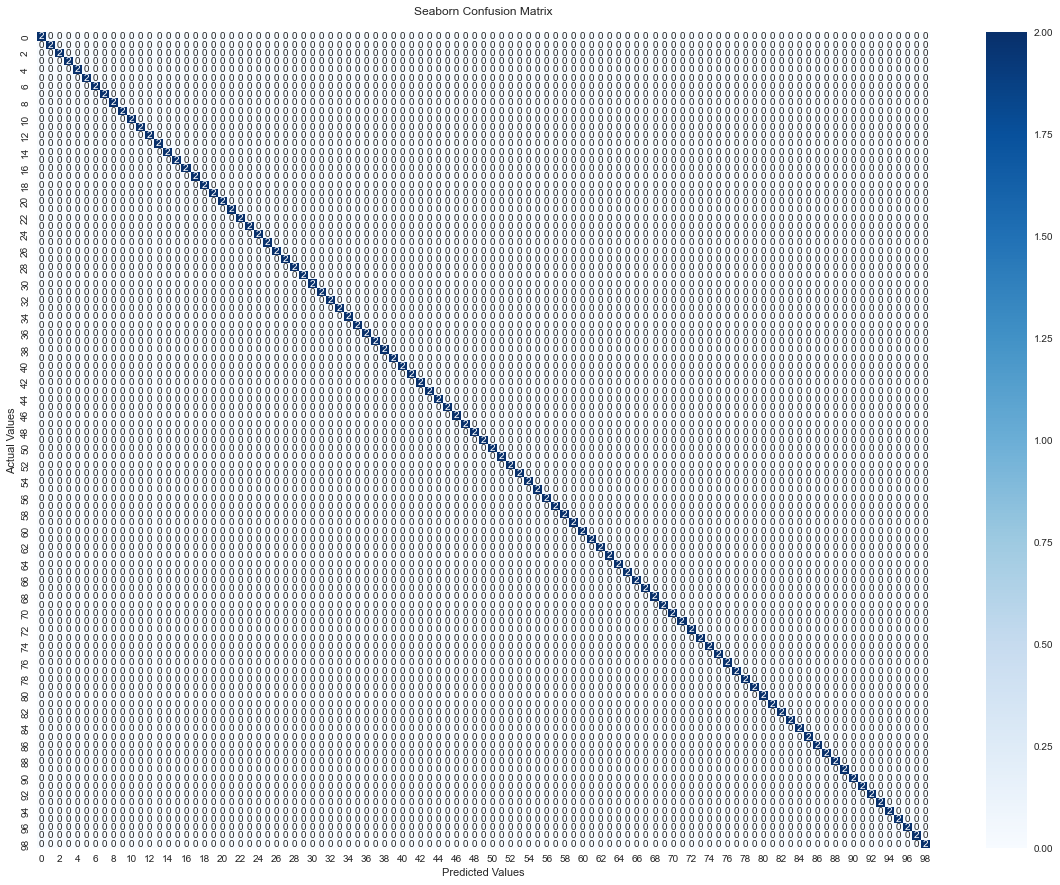

In [32]:

def pred_model(model):
    
    imgsTestX = load_image_data(X_test_image).astype('f8')
    imgsTestX = np.reshape(imgsTestX, (198, 256 * 256))
    y_pred = model.predict([imgsTestX, X_test]).argmax(axis=1)

    fig, axs = plt.subplots(1, 1, figsize=(20, 15))

    conMatrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

    ax.set_title('Seaborn Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
    print("Recall score: {:.3f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print("Accuracy score: {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("F1 score: {:.3f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))
    
    return model

pred_model(model)

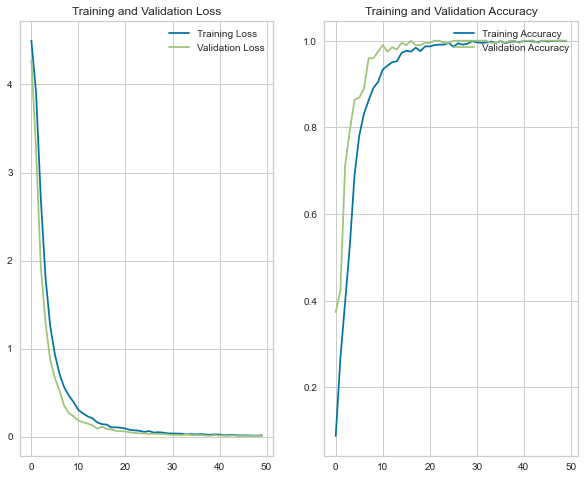

In [33]:

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

epochs_range = range(50)

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(121)


ax1 = plt.plot(epochs_range, loss, label='Training Loss')
ax1 = plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax2 = plt.subplot(122)

ax2 = plt.plot(epochs_range, acc, label='Training Accuracy')
ax2 = plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

In [34]:

test_image = pd.DataFrame(leafTestDf.id, columns=["id"])
test_image["file"] = "leaf-classification/images/" +  test_image.id.astype(str)  + ".jpg"

imgsTest = load_image_data(test_image).astype('f8')
imgsTest = np.reshape(imgsTest, (len(test_image), 256 * 256))

predictions = model.predict([imgsTest, leafTestDf[leafTestDf.columns[~leafTestDf.columns.isin(['id'])]].copy()])
predictions = predictions.argmax(axis=1)

df = leafTestDf.id.copy()

df["species"] = np.vectorize(labelMap.__getitem__)(predictions)

df = pd.get_dummies(df["species"])
df["id"] = leafTestDf.id

if len(df.columns) - 1 < len(labelMap):
    
    missing = set(labelMap.values()) - set(df.columns) 
    for m in missing:
        print("Adding column {}".format(m))
        df[m] = 0

df.to_csv("leaf-classification/predictions_improved_cnn.csv", index=False)

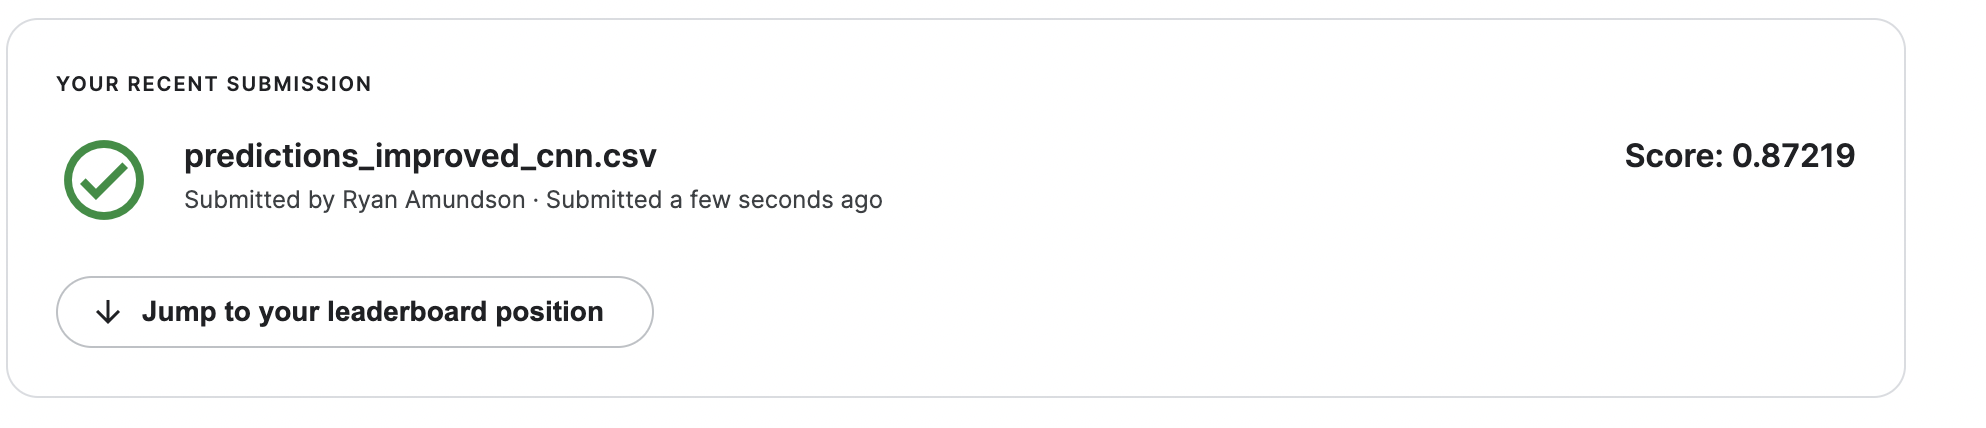

In [41]:

from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB8IAAAGsCAYAAACmU20sAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB8KgAwAEAAAAAQAAAawAAAAAQVNDSUkAAABTY3JlZW5zaG90u/tUlgAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NDI4PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE5ODY8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4K38BmaQAAABxpRE9UAAAAAgAAAAAAAADWAAAAKAAAANYAAADWAAJJqPc4js4AAEAASURBVHgB7H0Lg7U1kfR5QQUERARvq7vqru7//z2L+nlZ7woidwXeL0mnqquTPPPC0d1FrUdJV1dXknd6kk5mzpmZR4/bczs8nXykfCMeNwJc7/VoOqGVHoDDPr49br3QL4aEQCeoeFM0wvM7/1hHXn/ef64/Wk2lYgIO6/rr88fnL84N3TH1xlE9bCGyjfD9w/cPrCPfP3z/8P1Dq6lUTMBhff/w/cP3D5wbumN4tzgAbCGGGuH7h+8fWEe+f/j+4fuHVlOpmIDD+v7h+4fvHzg3dMfwbnEA2EIMNcL3D98/sI58//D94x/p/vEIL4Rv1wVd6ayGCTZ9hhpCGYWdQbiw1PUey3Ht+XOnldyGs+WraJBgWOd/ZADpgPX6a2mJo21bT95/3n846UptCWdbL0WDDQY7g3Bhvf9aYrz/+urY1pPrj+uP688snLvZ9kuRoMDCziBcWNfflhjX3746tvXk+uv66/o7C+dutv1SJCiwsDMIF9b1tyXG9bevjm09uf66/rr+zsK5m22/FAkKLOwMwoV1/W2Jcf3tq2NbT66/rr+uv7Nw7mbbL0WCAgs7g3BhXX9bYlx/++rY1tP/cv199PjjNmN8LuZq7f8ofHoa7uFZEJSneIItthCLO3oN7hBQyvM7/15/KJa5L73/aga0ZmRxSc0Wb6HBHQJKuf64/rj+uP70SqJ1IStLoC22EIs7Og3uEFDK9cf1x/XH9acXDK0LUXWy3WILsbij4+AOAaVcf1x/XH9cf3rB0LqQlSfQFluIxR2dBncIKOX64/rj+uP60wuG1oWoOtlusYVY3NFxcIeAUq4/rj+uP64/vWBoXcjKE2iLLcTijk6DOwSUcv1x/XH9+Z+vP/yJ8PN2LluySeIfFNrWanghI9Ra/X0a0Fy+2r8OqL7iOdCBwj8qQq31/Nunrb27oXHL53KkdE2o+oqd/2O6hIxstdbrz+tv3Wref64/rr/zEFGznjHqK559DpTP/0gKW58/Pn98/miRaSWi7Q7X35qT4a0FVX3Frr/HdAkZ2Wqt66/rr+vvLBioG21fuP7WnEjtyIDWXMXIY7Pr2prflAt1a11/9hz5/Pf+c/3JMkO01hj1Fbv+jAwcUuLvP0RS2Pr88fmz3lF8/vr8/Yydv+OFcH3XSRTyXubn6h0VjWVt1H+s62QrM0TadGG/oB8/+BZpGwPvevD8I1ktX87/WEJjkY1mfInXubraIja053dmzCXVdF5/kaal9f5z/XH91arSN4jr7ygTrr9tKfj86fuhZ6E/ulOCrUyopB0dW+PzV5KS0Oevz1+fv1pD+t7w+TsqxDh6RuP6O0umrhSfP7E2IjWKZ7K66XRvfP72RGyPz1+fvz5/tar2LeLzdxSKUVKjro4ympkZZdXnT+Rm5GpmJLC0I3Gt8fkjSUno88fnj88fnz9REZZTZpTX0cQ1vok0Uz5/IjeZO2Qn62skrukeOn9aEe6/nr2JMtkD9nEOY8rwBfbe/RldihO8tlt4TD2a/KdwMO15jcuYxdn7bOEx9Wg8f0uXP/9zzXj975vngil7qjh7hy08tt5ovP9aurz/5prx/ts3zwVT9lRx9g5beGy90Xj/tXR5/8014/23b54Lpuyp4uwdtvDYeqPx/mvp8v6ba8b7b988F0zZU8XZO2zhsfVG4/3X0uX9N9eM99++eS6YsqeKs3fYwmPrjcb7r6XL+2+uGe+/ffNcMGVPFWfvsIXH1huN919Ll/ffXDPef/vmuWDKnirO3mELj603Gu+/li7vv7lmvP/2zXPBlD1VnL3DFh5bbzTefy1d/4z771H7E+H9l1fIEwsiCFkyk9Zo14R/EcSoLfy4ZfcRX1nHKNufSOeI0bXr+tP+hRdTBH0RjM6jr+d3/r3+sNPnfmmbSldFbBfEutdxf7z/XH/KMhirojexWuaa0aVDRYhcf3WnIVHef5qVWDLITfc67o/rj+tPWQZjVfQmVstcM7p0qAiR64/uNCTK9UezEksGuelex/1x/XH9KctgrIrexGqZa0aXDhUhcv3RnYZEuf5oVmLJIDfd67g/rj+uP2UZjFXRm1gtc83o0qEiRK4/utOQKNcfzUosGeSmex33x/XH9acsg7EqehOrZa4ZXTpUhMj1R3caEuX6o1mJJYPcdK/j/rj+uP6UZTBWRW9itcw1o0uHihC5/uhOQ6Jcf5CV9qvRP25ZmT9gj/zoIuJiW8hP4ZZhu9OfVtviiehoixBxLPb0Py0qw3anP54/8qClpCRqhpu5oFPwBFT6O/+RLa+/uWpidYy2LJRcVBd0Cp6ASv/u9Mf5jzx4/4/FMNZIWSgzPc1c0Cl4Air9u9Mfr7/Ig9ffWAxjjZSFMtPTzAWdgieg0r87/fH6izx4/Y3FMNZIWSgzPc1c0Cl4Air9u9Mfr7/Ig9ffWAxjjZSFMtPTzAWdgieg0r87/fH6izx4/Y3FMNZIWSgzPc1c0Cl4Air9u9Mfr7/Ig9ffWAxjjZSFMtPTzAWdgieg0r87/fH6izx4/Y3FMNZIWSgzPc1c0Cl4Air9u9Mfr7/Ig9ffWAxjjZSFMtPTzAWdgieg0r87/fH6izx4/Y3FMNZIWSgzPc1c0Cl4Air9u9Mfr7/Ig9ffWAxjjZSFMtPTzAWdgieg0r87/fH6izzM7I6/ET6Ykq2pgcEft2+a/uPjzCHiD9gc9vTuA+mYQiEn9Pwt6S3rzr/Xn/ef689eIS+ZLKuuv3j31zFZmag97PPH54/PX98/fP/y/cv3L9+/9hvCJZPXCt+/fP/K30m2LZhcKFvo5vun75++f/r+6fun75++f/r+ud8QLpm8Vvj+6fun75+tfJ6f3Ch73Pfvf/j79+FXo891MD75HZ+XzkPrZrzIjuV07D57N3P5wrrnn6k/JvDhd4n09OI5dnf+R3K9/rz/2v44b5G2OEbgGPX+a/XlnJkWcP1B9b1IkuvvSIzrr+tvKyLHOuL730zMMTs+f3z+nPdNP3l8/vr8RQaO5cP3D98/2sLw/cv3r7YMziWiLY4ROEZ9/2j19ZwZn7++f+DwvVokPn99/rbq4fPX529bBsdzxN//8P1jLIzj6vD96+po7UdvP17xHNO3n7/81eij34xjjG4rlQOM3VuD0i0CCMNSUAhxBEJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UY0fyIcalj22kFIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTkWrhHViZ9IgBYzraDkFwL98jKpE8EALtPSyYk18I9sjLpEwHAcrYdhORauEdWJn0iANh9WjIhuRbukZVJnwgAlrPtICTXwj2yMukTAcDu05IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0icCgOVsOwjJtXCPrEz6RACw+7RkQnIt3CMrkz4RACxn20FIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTkWrhHViZ9IgBYzraDkFwL98jKpE8EALtPSyYk18I9sjLpEwHAcrYdhORauEdWJn0iANh9WjIhuRbukZVJnwgAlrPtICTXwj2yMukTAcDu05IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0icCgOVsOwjJtXCPrEz6RACw+7RkQnIt3CMrkz4RACxn20FIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTkWrhHViZ9IgBYzraDkFwL98jKpE8EALtPSyYk18I9sjLpEwHAcrYdhORauEdWJn0iANh9WjIhuRbukZVJnwgAlrPtICTXwj2yMukTAcDu05IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0icCgOVsOwjJtXCPrEz6RACw+7RkQnIt3CMrkz4RACxn20FIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTkWrhHViZ9IgBYzraDkFwL98jKpE8EALtPSyYk18I9sjLpEwHAcrYdhORauEdWJn0iANh9WjIhuRbukZVJnwgAlrPtICTXwj2yMukTAcDu05IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0gfKvxG+TJM/X95/trzJ8TvM0TNY+bUOCMBywAIYHYCeaMB12x/P7/y3teD1x62ATYedEvsEHmywa8voAPREBq7b/nj/ef+1teD9x63g/ReVAZWiepWNWLaMDkAvBfwdND3WH9cf15+2Flx/uBVcf6Iy1OoBDzY0a8voAPREBq7b/rj+uP60teD6w63g+hOVAZWiepWNWLaMDkAvBb7/tFzMmjuy4vrr+tv2ietvbou+JdpTqwc82NCsLaMD0BMZuG774/3n/dfWgvcft4LvP1EZUCmqV9mIZcvoAPRSwKrWY/1x/XH9aWvB9YdbwfUnKkOtHvBgQ7O2jA5A7/bo8cftjxE8SmLtCP+sAAsLddjHfehHUcgawuev7Ouoe+f+OtpZARZWe7RpPL/z7/XXNsXj9j/vv/n1o+tPK5e4V7j+tu3h868noR6ei3dxws5+F1Gfvz5/ff62PeLz1/cP3794wvj+4ftXWwxjPYyrw/n+oFeQswIsrPZoVdf3D98/fP/w/cP3L3//x9//yq/w23Hp7//4/uH71zga/f0/f/+zLQR+dVq/iJjexVcYs99F1F9//N18/TF+Irx8GukQHBeGklC2z3v7wPsXoGGpgYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVFDCdAiq+OBBiXlhKYWARAUlTIegig8elJgXllIISFRQwnQIqvjgQYl5YSmFgEQFJUyHoIoPHpSYF5ZSCEhUUMJ0CKr44EGJeWEphYBEBSVMh6CKDx6UmBeWUghIVDDC7V3T3fKJPrVn4bZZ2PUC5FgDtYbvRjv0KHPNeOE8//Iug0MSCxXZ69RArXH+r9//U9bazGPhvP68/sZPGZRN9oATq6cLBmqN95/339X7D0utmauqcK4/rj+uPw/U2zUUu6ezA7XG9df11/V33Sfhl7NmSgrn88fnj8+f8+Y5srF7emig1vj88fnj8+e4WWKPzBYKnz99v8w64vPX56/PX5SGT2DnvmnKgVrj89fnr8/f89aJ3ZJ7pqsK5/PH588/4Pmz/I1w2QCEBGPnqIc9MTgNbHvswaCoRUdI4PlbBjQbzn/UpJETTYysqIAPBkUtOkKCoVPP+Xf++5kw1oQuDFlRXn89Aw8mR7IlOkKCoVPP+8/7z/vP9WfUBC0MUlECPhgUtegICVx/WgY0G66/rr+uv66/oyZoYZCKGvDBoKhFR0gwdOq5/rj+uP64/oyaoIVBKorrT8/Ag8mRbImOkGDo1HP9df11/XX9HTVBC4NUlIAPBkUtOkIC15+WAc2G66/rr+vv36b+Li+ELxutbbyrd85AqRtTKtoGQ5fqgdKlXinFFBBE9GENxbOApHqgdClUSjEFBBF9WEOx52+p4LtaGx55OyRPKcWZSaCIPqyBdl+to9+hs1KKcySgiD6sgdbzr9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQPvZzz9fCL/+gB63Fy0flRcx56u67aO86nXF98RE7MMPP7y99/6fb3/+c/vvLx82+5fbRx99dPv444+bpM+Jp+On2vyNb23/f4eP2lshHjcwbP9dJ+xBQaNW3EdtH03v299O08aNfn2s/lHGo6P1uOd3/r3+vP9cf1plZEl1/fX54/PX949+l9IbEwuE71++f7YL9bisz7Xg+3f/esJff/jrL3/96a+//f0Hf/+lnwf9iyp//8nff+s35/7obbqvD3//0d9/9Pcf/f1Hf/+xVUZ+e8Hff/T3Hz9b33/sX9c/9dTTt889/ej2+Wc+f/vC575w+8IXPnd77rlnG/d0HO7zvod73yTJwk8bN8O+2mPxN0NIkPKBrvgeRAw2ulYvOET6zewfff72QvjHLQe4gkmemDBNSsU1efiETU0JNqd9U/C9P39we/ut927vvvPe7c8fftCmbfOOF6R7geuaPn/HzQ6/g3C77WF9uh+Kzrb5e9fH84srCY4vM3rwqYbm9+XyG3RT6Pmd/74UvP5iU3n/xVqQGtOXhz5SYhrt+uP66/PH56/vH+MiIcXR9692Nvj+6fu3v/7w11/++nN82e+vv/EGoXlQ+vsP49rgr7/7N7Hal5P++ttff/c7Y18Ko43tMeEwcsVuvr//4O8/+PsP/v6Dv/8wKqUUR3//wd9/+L/+/svn24viz7/4xdsXn3uu/feMHOOyUDtLl0C0FVZF+xy3mwLuCjnOHHQcjm341qm/7JpPHSX7LXx2IKqKv+/5+RPh8hkYH2h+WImYAYCaCbCZy8b019lff/NPt3feevv2fvvJ76faBb9/wp569HR7p8Qzt2e+0N450f77/Of7Oyk+395R8VT7b5Su+Wn96+bv/yj8M8Nqy3+yqILLWROpemAMvARWGr7ODC67ViZnTZTaiWoXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl0YXmn4YbVllwagCi5nTaTqgWsXhlcaflht2aUBqILLWROpeuDaheGVhh9WW3ZpAKrgctZEqh64dmF4peGH1ZZdGoAquJw1kaoHrl3Ga50ftd9o/ZePPrx9OH/L9QftN12/9977LdZ+2/V43fPxrb8o/sKLL9xefumF8XonZsy3vPV/DV7WTvSk+RFf/ln8yPQjXzV/i4//73n+8UI43iVQUi6Z2hIosZHA4be3GQjff8X5G3988/bGG2+1N/m2QPv/5z/39O2FF56/Pf/8F2/PPZvvivifmJ+La74TAp+kk/X88S6Rv+Xn3/nvGejrvu2L8g6cfQV6/Xn9jV+O0dYL39MltTSgtBKLNdbWVAywrLUm9PpbcuL9t2bA9Qfbx/vP9Wce1lJjpfLGFVdirr/9jPH54/O3fv0XZ0xfG77/+v6/3jiq7/uH7x/++qcfo75/+v7p++c4HeSOHVBaifn+3ZIx8uH7V+RB7xY9N75/+v6pa2LHvn/6/vk/ff987/0Pbu+88+7trbffuX344UdjEfZfpf7yl790+/JLL92ebr9O3fe//8P7b/tbZf0Y3Z9xuCqtxPyUKUXp49sbb751e+P1N9vf/O6//ut2e/6Lz91eeulLzT47D+1jR44wwCZR4uH5mU52IfD8IxWSj5r19DaJEs7/WGOaEmZOyhnjBF5/IxWSD+ZtAZtECa8/r7/2LRNdElw+3n8+/+a307g+CFx/RyokH9w3C9gkSrj+uv66/vr8aTVjft8+q4fPX5+/Pn/HtuCRSeD7x0iF5CMLR0WbRAnfP3z/8P3D9w/fP3z/qsdGP2B9//L9y/evti94ZSLw/XOkQvKxlg/4m0SJv+7++e57797++Kd32gvj74zZ+t8Vf+WVl25f/tKXMLt87kD97ea/+MY5Jgqr0w1Gib/u4/8szr/9avT64c7vcyi5JmXEQtB/DcBvf/eH2/vvvz/eYvJCewH8y19+afz0N4aArVnvXkQ0TkyAXkIMGH5v+5Pfm0kdEGwotY2IxokJoBdiwPB72x/PH3nA57R7yBgsFGkzh8gftQRQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6RlitjkG+lNLALEQA4bf2/6gf86aSHqGmG2Ogf7UEkAsxIDh97Y/6J+zJpKeIWabY6A/tQQQCzFg+L3tD/rnrImkZ4jZ5hjoTy0BxEIMGH5v+4P+OWsi6Xl774MPxm/Mfne8IP749sxzz96+9uor489F93GoJehsf4QYMPze9ueTzh9qtDkG+gfT4gRVO7wRy76dQ3/tiCFgMVLaHAP9qSWAWogBw+9tf9D/08wfvxodnWX8MSJ+Z0RzGCIYCjZvvvn27Xe/f73pPr597nOfu736lZdvL774POMxADpPW41MMrt9ivnzH4i+zWZG5tieP5JSE4+s7Dlskf47I9pzqRlRFUyCHdQHOW01Mgn6NIHnH8lA5vITMXMEQwFy16zXP7Lj/T/WBxbJtNV4/yE9WDU+f1x/ff6M3cCtQYBNMu3KH32Q01bj+oP0ILWuP64/rj+uPy0DLA0EKBLTrvzRBzltNTIJxmwCr7+RDGQuPxHOf8kAE4S106y//swUjfwgSdNW4/2H9CBrvv+4/vr8GbuBW4MAm2TalT/6IKetxvUH6UFqXX9cf1x/XH9aBlgaCFAkpl35ow9y2mn+1H5d+h/+8Eb7u+LtV6a3O/PXvvqV20tferFN2gRef/8764+/Gl2Srp/i5VOnIeLf/eH12x//+FbzH7dP4Au3V195tf0ReIYHGONgMIaE+Cvmz1EScYoJRmQLC+H5uek0d8gQrMaAM5YIMdgR2cJCOP/O/yz6WDPdYoXAagw4Y4kQgx2RLSyE15/Xn9cftgstdggsAwIylkjCA47IFhbC+8/7z/tv3TY+/1pG+uspUikuc/SQyvWn5XFLohCuv66/rr+XtUV2yqXG9ec6SyOyhYVw/XH9cf25rC2yUy41rj/XWRqRLSyE64/rj+vPZW2RnXKpcf25ztKIbGEhXH/+qevPx+3PSP/+9Tduf/rT2+N7HV9ufzv8q6+8zO97yErx/lsykLlJtEgij1s4CfnV6NI140GuPqWPb79uvwr97fb77vvzta++cnuxvRCubwSmVEEb73H7rsz8SxYaCbzOt/rssQd2huIETeT5nX+vv4udum6i1edO2gM7Q3GCJvL+8/7z/vP+y6IgaC0iq0/pHtgZihM0keuP64/rj+tPFgVBaxFZfUr3wM5QnKCJXH9cf1x/XH+yKAhai8jqU7oHdobiBE3k+uP64/rj+pNFQdBaRFaf0j2wMxQnaCLXH9cf1x/XnywKgtYisvqU7oGdoThBE7n+uP58FuvPm+2F8N/+9g+3W/tB4hdfeP72ja+92hZrW7rHUrEHdiaXPZHX/7b/6wvhI0GS84t3qSChv/r1725vv/Pu7en2499f//qrt+e/+Gz9jOGzMmxv+ue0Lb/JIzwCEWz/wE8+vy6QGGsZEe6wvfH8zr/Xn/dfKwStzqA8jMIQxcH1x/U37xxPOP90AcVaWlYU3GF74/PH54/PH58/rRD4/NHyOWpjJ3z/99c/bWvM9dAWxOGndBDWBTSOWCW6KMhpu+Pz1+evz1+fv60Q+PxleRyFMYqjz19//euvf7Eh/PW/71++f2I37Bb36xbx/btfKSQhPVtwh+2Nv/7w1x9P/vrjvXffu/36N7+/ffzRR7fnX3zh9s322urxwfoa68rr76/Zf/FCuCQUCa+UeBP++re/v7311ju3p59++vYv3/zq7dlnnkHXT24xLKz0rJR4AkV+H8RYsDJKpcQTKPL7IMaClVEqJZ5Akd8HMRasjFIp8QSK/D6IsWBllEqJJ1Dk90GMBSujVEo8gSK/D2IsWBmlUuIJFPl9EGPByiiVEk+gyO+DGAtWRqmUeAJFfh/EWLAySqXEEyjy+yDGgpVRKiWeQJHfBzEWrIxSKfEEivw+iLFgZZRKiSdQ5PdBjAUro1RKPIEivw9iLFgZpVLiCRT5fRBjwcoolRJPoMjvgxgLVkaplHgCRX4fxFiwMkqlxBMo8vsgxoKVUSolnkCR3wcxFqyMUinxBIr8PoixYGWUSoknUOT3QYwFK6NUSjyBIr8PYixYGaVS4gkU+X0QY8HKKJUST6DI74MYC1ZGqZR4AkV+H8RYsDJKpcQTKPL7IMaClVEqJZ5Akd8HMRasjFIp8QSK/D6IsWBllEqJJ1Dk90GMBSujVEo8gSK/D2IsWBmlUuIJFPl9EGPByiiVEk+gyO+DGAtWRqmUeAJFfh/EWLAySqXEEyjy+yDGgpVRKiWeQJHfBzEWrIxSKfEEivw+iLFgZZRKiSdQ5PdBjAUro1RKPIEivw9iLFgZpVLiCRT5fRBjwcoolRJPoMjvgxgLVkaplHgCRX4fxFiwMkqlxBMo8vsgxoKVUSolnkCR3wcxFqyMUinxBIr8PoixYGWUSoknUOT3QYwFK6NUSjyBIr8PYixYGaVS4gkU+X0QY8HKKJUST6DI74MYC1ZGqZR4AkV+H8RYsDJKpcQTKPL7IMaClVEqJZ5Akd8HMRasjFIp8QSK/D6IsWBllEqJJ1Dk90GMBSujVEo8gSK/D2IsWBmlUuIJFPl9EGPByiiVEk+gyO+DGAtWRqmUeAJFfh/EWLAySqXEEyjy+yDGgpVR3vvgg9uvfvW720ftxfAXvvTF2ze/+tWIHrTS7dNBjAUrvSslnkCR3wcxFqyMUinxBIr8Poixmq0/Ec7hoCCR725pVP/D7q//8c32k+D9RfCv35599vONne/jZ1eC+saYOWRGZQ7CQ/RADfngJUhI4PlbovpnJzNSMdNOoMpJHqgRGbwECQk4bzKeX3PBtBMcogfK+W8ZGHmR5BASeP21NHn/15qTq4ObTsAheqBGh8FLkJDA68/rz/uvrYHcERXLxptQldfUiAyp6AkJOG8ynl9z4fyvGThk50B5/bUMjLxIcggJvP9amnz/qjU3V8e697p/iB6o0XPwEiQk4GjJHGeQf4gqJ32gPH/LwMiLJIeQwPlvafL+r3suV8fcX8UcogdqdBm8BAkJvP68/rz/2hrIHVFx2Xq5qSqtnTUyeAkSEnDeZDy/5kLTGfgQPVBDO3gJEhI4/y1RPn/rnsvVsa++qpzxqw6DlyAhgdffnevv/fZi+C9/+dvbRx9/fHv5pS/dXn315f2T5fy3zZ1rjYstAZGoyCGh7YXwjx8/br+PEL8BRMUQgev2T3966/bb370+Bvr2N792e+6Lz40iA+1u0btHFEP5+PZp5u8FrT8YCTbYU6sKxdB6fuf/k69/r7/YN9hJsNhNu1WFYii9/7z/vP8+6fnr+uP60zOASgqLarpbVSiG0vXX9df11/U36sG5Qlx/I+mkR2XZRzypXX9cf1x/XH/2aoE6gqoB23lgWGh3qwrFULr+uP64/rj+RD04Vwjff65eSDzlC5V1z+hJ7frr+uv66/q7VwvUEVQN2M4Dw0K7W1UohvKzXX/ee/f9289/9Zvx+uxXX/3K7ctfenH8w/GRwOKj2a0qFEP52f74+78S/2rYKw4fUbWnXqqYH397Fbwr2zM7DHPo3Kg//+XD209//t/the9Ht6997Su3L70Yn5To/8lajtxA+XuAn2D+eMWdI3yyCRcVe3t+57/d7vDC0idZ/15/fTNxBy0765O57O395/3n/ef6w7IxK8MwrBJZb0gRsOenAezdgO8fPv98/mP3zJ0xDHeJ9x/uO0wJARL3qSx7N+D64/rj+oPtM3fGMNwlrj+uP20NtF3CJUGAhfOpLHs34Prr+uv6i+0zd8Yw3CUtqHzXagx9P7ll7wa8/7z/vP+wd3SfcZfkfiNFgI6fyrJ3A95/3n/ef9g+c2cMw13ymdh/b7719u13v2k/fNzeLfGdf/3G7Qtf+AL+0Z/a8iNrwPs/9//Fr0Y/XHda4vo7E95///3bS+0PuH/11VeWnyJnirPzoNor7u0Lmdxw/XMn2otP5aZohH7i+sv39V000gNwWM/v/Hv9ef9poUGBUK7iTdEI1588OFx/ff74/I2aEbVCKgbgsL5/+P7h+4fvH3q/QIFQruJN0QjfP3z/wD7y/cv3L9+/fP/qGYizQk4MwGF9//T90/dPnJtaMQKfW2whRhvh+5fvX1hHvn/5/uX7l1ZTqZiAw/r+8be4f/zut3+4vfH2O7cvPvuF27f/5Rvtt2h7//0t9x9fCN+Wq2a6rfc/vvmn2+9+//rtc597ur0r4du3R0/1QxHHAq8LE5SdkMGNBtEv88tyWebPQQJt+iLAuLAzCBdWXpDfxvP8udNKbp3/noFtvZQcYYHBziBcWK+/lpioIVs+vf+8/3DSlb0VzrZeigYbDHYG4cJ6/7XEeP/11bGtJ9cf1x/Xn1k4d7PtlyJBgYWdQbiwrr8tMa6/fXVs68n11/XX9XcWzt1s+6VIUGBhZxAurOtvS4zrb18d23py/XX9df2dhXM3234pEhRY2BmEC+v62xLj+ttXx7aeXH9df11/Z+HczbZfigQFFnYG4cL+HdXf9hesbz9pv437ww8/aj+E/JXbSy+92Cpn1M7yoQ8HHyDs3//Hv36Mf+vP/6P+J8LXfGr6xm9Ob5If/+wXt48+enz75tdfub34wvPrv0uW1JL0szvYMY9OdtD2+R/NgnCQzh79IMGRehikUVsc3CGglOd3/r3+cFld9tjcat3onhn0QixuSg4Bpbz/vP+8/7z/jjVmVJFotGZkcUnBFm+hwR0CSrn+uP64/rj+9EqidSErS6AtthCLOzoN7hBQyvXH9cf1x/WnFwytC1F1st1iC7G4o+PgDgGlXH9cf1x/XH96wdC6kJUn0BZbiMUdnQZ3CCjl+uP64/rj+tMLhtaFqDrZbrGFWNzRcXCHgFKuP64/n5X686e337395je/uz391FO3737nW7enmsWjazYXN6LnveP1317PmonjT4RHytZ0hv+HN/54e/31P96ef/75279846sPZ3eWq+jZWv19Muh5+W6n8/znf1tjV/kQcub2+r7nd/7bJSLuEVh9bd20dXF8t9W6oNRXPIc6UFiUEWqt17/z7/WXe68j7z/XH9ffuieGtx4o6iueXQ+Uz59IClufvz5/ff7WWuPz1+evz9+6J3z+tgysFwr1Fc/UHSiMEaHW+vz1+evzt9Yan78+f33+1j0xvPVAUV+xz59juoSMbLXW56/PX5+/s2CgbrR98Xdaf3/169/f3nnnndvLL3/p9srLL+9r26+/tk/yeOX3U73+O14I13e9xBcyfcHE7nn80ce3H/3s57fHH99u3/rWN27PPfsMX1dksV2YudzSdGH/BB0XX4u0iyHedbHOH5/XnKmPhH2dbGW6pjyev6XD+ff6wz4pu8P7z/XH9Zdn0zgs2gaZe2UcMqMZR1HfOdhFyVam7q7mjSFbwzmqwuefz3/ff3QP9f3h/TeqxCgyWWkkM3E1nu3QFhwMx+gx1x9JSkLXX9df11/X36gIvdb2x+fPSIPPn7YUfP72/bDsjHnbiNyMteL7R9aNSEimxfcv3z99/9ZdQez7t+/fvn/7/i2HZYO+f498LPfv997/4PaLX/6qZeep2/e+9+3b0+NM0bUDzPLq7z+Pi2trHjp/2yHUf916E40mYc9jy+nrb7x56z8R/sIXn7998xuvSnYrHHNFl+217Ko8hB+Yf+175Xv+yMzYBiUZe8a2sPN/uf737J2ZktPi7Pot7Pw7/xf1d189Z6asqeLs+i3s9ef15/XXNsp8J+G2QfY9tDKlS3FWpe8/W3o64fXXk7Ddv/fVc2ZKTouz67ew8+/15/3n/ef64/rbd8F2QOxnyMqULsVZlb7/bOnphOtvT4L3H5ZC3zaH72l3+vSUNVWcXb2Fvf68/1x/2kZx/WEp6GXD9WcvnhdMqanF2TtsYSbd64+p6Gnz+tsXT2N+9evf3t5+5/3bK6+8dPvKl18amrKmirMPsYWZ9H/e9feo/Ynw/ssz5BlZmf7j209/9svbn//yYfuV6F9rvxr9ubioburZR7uKpnd63A7a/OPuEJ7+5DlifYCO+9P+hZPWaI+EfxHsgv60sOd3/r3+sNOxi7z/dFewWPAE7nnqj+uP629ZBmNV9CZ20txP2FaMTtB4nz+605Ao1x/NSqwW5KZ7HffH9cf1pyyDsSp6E6tlrhldOlSEyPVHdxoS5fqjWYklg9x0r+P+uP64/pRlMFZFb2K1zDWjS4eKELn+6E5Dolx/NCuxZJCb7nXcH9cf15+yDMaq6E2slrlmdOlQESLXH91pSJTrj2Yllgxy072O++P64/pTlsFYFb2J1TLXjC4dKkLk+qM7DYly/dGsxJJBbrrXcX9cf1x/chm89+57t1/86re3L3z+87d/+7d/aatjrhldOmPdzKbxrj+605CorD/tV6N/3Fh5J0Dbc3jef//9289/+dvb008/dfv373wb9Ke2mHZ07E5/OE9ER1uEIevtBZ2CJ6DSvzv98fyRh5ndkaOSqBlu5oJOwRNQ6d+d/jj/kQfnfyyGsUbKQpnpaeaCTsETUOnfnf54/UUevP7GYhhrpCyUmZ5mLugUPAGV/t3pj9df5MHrbyyGsUbKQpnpaeaCTsETUOnfnf54/UUevP7GYhhrpCyUmZ5mLugUPAGV/t3pj9df5MHrbyyGsUbKQpnpaeaCTsETUOnfnf54/UUevP7GYhhrpCyUmZ5mLugUPAGV/t3pj9df5MHrbyyGsUbKQpnpaeaCTsETUOnfnf54/UUevP7GYhhrpCyUmZ5mLugUPAGV/t3pj9df5MHrbyyGsUbKQpnpaeaCTsETUOnfnf54/UUevP7GYhhrpCyUmZ5mLugUPAGV/t3pj9df5MHrbyyGsUbKQpnpaeZE/7+f/vftow8/vH3r2+3PVT/zbIoPqPTvTn+8/iIPM7vjb4QPpmQrNL/7wxu3N//4p9uXX3rx9uqrXxmfkf7j48zhHOohk8Pmq+9HfQr3cPvt7eP3uzfj+Z1/r799i1wxua28//Q9QVu+MlFbqP0Rddef/vc1XH99/vj89/1nr5CXTJZVnz8+f/J38mwLJhfKFvL56/uHv/7z/cv3T3//w9//8fd//P2f/Yp0xeS1yvdv3799/76sHblR9q3k7//5+5/+/qe//9tqxGfl/vn7P/zx9sYf37y9/NKX2muzL+81azJZ1nz+P3T+H341OjLYfi36z+PXon/7W+1dB88+U5KdCS50OD2I53jyzN7NXC6scfj0QY4DHN8lgSlHEM6xu+cfeXX+vf7a/jhvkbY4RuAY9f67rEwt0MsLnmP6XH9cf9rCcP11/W3L4FwiXH99/vRD5Lg6fP5eZqYFfP72hRPPcfn4/uH7R1sYvn/4/tGWwblE+P7h+0c/Qo6rw/ePy8y0gO8ffeHEc1w+vn/4/tEWhu8fvn+0ZXAuEb5/+P7Rj5Dj6vinv3+8+/4Ht1/84tfj16N/p/169PL4/pHpOC6f/f7BX40+es54xx9++PHtJz/7eXsj/lO3//jev86Bc4CxPkU/BUWHMCw1hRBHILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDBF4eyvAABAAElEQVTsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZreND/+8c9uH7UfGP5e+7PVn/vc0+jSbAjQF5aCQogjENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0I5o/EQ71tG+9/c7tN7/5/e2555+/fesbr3KMDkKCDiU0nD2yMukTAcDuw5IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0icCgOVsOwjJtXCPrEz6RACw+7RkQnIt3CMrkz4RACxn20FIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTkWrhHViZ9IgBYzraDkFwL98jKpE8EALtPSyYk18I9sjLpEwHAcrYdhORauEdWJn0iANh9WjIhuRbukZVJnwgAlrPtICTXwj2yMukTAcDu05IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0icCgOVsOwjJtXCPrEz6RACw+7RkQnIt3CMrkz4RACxn20FIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTkWrhHViZ9IgBYzraDkFwL98jKpE8EALtPSyYk18I9sjLpEwHAcrYdhORauEdWJn0iANh9WjIhuRbukZVJnwgAlrPtICTXwj2yMukTAcDu05IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0icCgOVsOwjJtXCPrEz6RACw+7RkQnIt3CMrkz4RACxn20FIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTkWrhHViZ9IgBYzraDkFwL98jKpE8EALtPSyYk18I9sjLpEwHAcrYdhORauEdWJn0iANh9WjIhuRbukZVJnwgAlrPtICTXwj2yMukTAcDu05IJybVwj6xM+kQAsJxtByG5Fu6RlUmfCAB2n5ZMSK6Fe2Rl0icCgOVsOwjJtXCPrEz6RACw+7RkQnIt3CMrkz4RACxn20FIroV7ZGXSJwKA3aclE5Jr4R5ZmfSJAGA52w5Cci3cIyuTPhEA7D4tmZBcC/fIyqRPBADL2XYQkmvhHlmZ9IkAYPdpyYTk8e2X7fXZd99+7/b1r79ye/GF55c43QbWQdMnAoDV7gsOybVwj6xM+kQAsMuc6obkWrhHViZ9oPwb4ZwpQn94/Y3b62+8efvKy1++vfKVl1ou5++wQM+mFyheZTnsBIwOQE9k4LrtT//Z9oY9P1OB3xaBTI008bNR2Yhly+gA9FJQxum08+/119aJ9x+3gvdflItaPeDBSkkRyOgA9A6KHuuP64/rT1sLrj/cCq4/URlq9YAHG5q1ZXQAeiID121/XH9cf9pacP3hVnD9icqASlG9ykYsW0YHoJcCf/3VcjFr7siK66/rb9snrr+5LfqWaE+tHvBgQ7O2jA5AT2Tguu2P95/3X1sL3n/cCr7/RGVApaheZSOWLaMD0EsBq1qP9cf1x/WnrQXXH24F15+oDLV6wIMNzdoyOgA9kYHrtj+f3frz+9fb3wnvr9G212dfebm9Rot/KxbI+PfXBh9dlFl6IgL32f/48S+Nfzw8WPmQBDI6AL3bo8cft5+tf5QE+vzqN7+7vf32u7dvfP3V8W6DXdGVYGHRO+zjPvSjWEjlD5U3Oera9SdkGau5faT6YF7YJer5nX+vv7YpHrf/Pcr94/3n+tOK6aino3Se66dW07MCLKz2aKvO9df11/XX9dfnj89f3z98/8L1oF0X/PWf71++f46rQVsI5/sztku3ZwVYWO3h+7e//vD33/z9x15l/f0ff//L3/8b9415mPr+6fun75+4WJ7vj3qbPCvAwmoP3z//p++fb7399u3Xv/nD7YUXnrt98+tfq8nvn1p///0Tf/99/ER4WcbT+dnPf3n74M9/uf3rt79xe/aZZ7YkK4H+Le9t4v4JCEsNBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVXzwoMS8sJRCQKKCEqZDUMUHD0rMC0spBCQqKGE6BFV88KDEvLCUQkCighKmQ1DFBw9KzAtLKQQkKihhOgRVfPCgxLywlEJAooISpkNQxQcPSswLSykEJCooYToEVSzeBx98cPvZf//m9oVnPn/7zre/yddd/7fmxz8F/1LMC4v4xbt4z2EM9qRO7N3f5hdv6sG8sJRAQKKCEW7vGuiWT/R5fPvxT35x++ijj2/f++63bk8//XT7aYY52jYLu16A2a9FB2oN34116BHq7NMlhfP8y7sMDkksVOZyoNY4/7FxSpqmU9baifP68/obP+V6Wj0nzvsPu831p2XC9dfnT3uz4Hg38qFc+Pzpucma2VNUcuLztyXoavUcFpTkcuSxNb7/ef9draCy1+ZyKpz3n/ef68+p0F5wsXt6cKDWuP66/rr+nrdLOWumpHA+f3z++Pw5b54jG7unhwZqjc8fnz8+f46bpX6vYUp8/vT9MuuIz9/PzPn70Ucftddp/3u8Pvvv3/32eUHj8+b6/+D5t/yN8LnYW9J++KOftY6Pb9//3r/eHj31FJOcinagNqffSQanAaoBHgxC1KzoCAmGTj3P7/x7/Xn/jZqghUEqSsAHg6IWHSGB60/LgGbD9df11/XX9XfUBC0MUlEDPhgUtegICYZOPdcf1x/XH9efURO0MEhFcf3pGXgwOZIt0RESDJ16rr+uv66/rr+jJmhhkIoS8MGgqEVHSOD60zKg2XD9df11/XX9HTVBC4NU1IAPBkUtOkKCoVPP9cf1x/Xn/67+fPRR/4Hln41F+IPv/VuzspUL1F1bAosjOkKCoVXvH2n/Ly+E50XrtR/9dLxz7D///TtLsuBGSjQxiJzsqh7+obNSivcxI/qwJnut6uEfOiulOEcCiujDGmiR11QPlC6FSimmgCCiD2sonhfoVA+ULoVKKaaAIKIPayj2/C0VfFdVwyNvh+QppTgzCRTRhzXQev2t2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtP9z+f+v9jpt/zHl7//Hd3KyA1r/tcM//OOVUrwPGdGHNdlrVQ//0FkpxTkSUEQf1kD75PzzhfB1wP5CeH9+8B//1l60e1RexJuvarbo2mt0eYDvcfSBjT7VCw4Rz+/864vIXEIJdME0fL2aMlY11dPh+u9FcP6df1khhAS6YLz+vP/aGrh6ex7WDGwsnerpcnL9cf31+ePzRyoEIYEWjIav+C5DDDa6Vi84RLz/vP+8/2SHEBLohmn4iu8yxGCja/WCQ8T7z/vP+092CCGBbpiGr/guQww2ulYvOES8/7z/vP9khxAS6IZp+IrvMsRgo2v1gkPE+8/7z/tPdgghgW6Yhq/4LkMMNrpWLzhEvP+8/7z/ZIcQEuiGafiK7zLEYKNr9YJD5KH998Mft9/c3f7WRX+dNp/r0f7W85+/z/33N397Ifzj9q+Wb9rPj+G1H/+k5awn+DuZ3wXVDxffsJ+iEmzO/MMk+HH6HKoI8/PEBZPKFdWenj82jPM/MlAWh9ef91+rce3/rj8tDVLupeBG4eC+IVjLLv2qcP11/e1fMMynLI7m+Px3/XH99fnTSoHPHxTJbkuhFHfhtcvEVeHz1+evz1/fP07FoVUK3798//L9y/evVgp8/9LLVL1F5XVs4bXLqcS2jr5/+P7h+8dpc/j+4ftX2xm+f/zN7x8/3H5g2ftvZKAc30+uP/yJcPkOzBjnv370k7Zun2ovhP9rPeBnnvfJMlD+DY2GH1bb7JOq4PJakUjVA2PgJbDS8HVmcNm1MjlrotROVLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA9cuDK80/LDasksDUAWXsyZS9cC1C8MrDT+stuzSAFTB5ayJVD1w7cLwSsMPqy27NABVcDlrIlUPXLswvNLww2rLLg1AFVzOmkjVA7cur/34pw3WnwivI+XIOvOqSdWnmz9/8in/devY8D/L848XwvFTkpry137YXghvbx3sv3t++wDwkeGzMfz+do/xOcmMdGK+E1nIDZ7m17FiWGnLPH2OPq/n15xFkntuWl7a/x96nH8sH3lPp6yxgNJKbCy+4Xv9ef21XVb2WlsY3n9LTvZK5Prj+hPHt+sv31MvZ0xAaSXm86clY+TD56/PX5+/vn/o/aLXhlYXyp1M44F9//D9w/ePfoz6/uX71yyWcscMKK3EfP9syRj58P3T90/fP+tdq+8N379qTnz/XDPg+7fv375/33f/fq39wHI/d3/w/e/Oe4juLtffT3z+PG6Ppg74h+2F8MeP+k+E43fPdxm+ozC/ZFIKHdtnhV9OMU4wP1nis98CNokSnn/kWFPC9Dn/Xn/zy3muDwLvv5EKyQf3zQI2iRKuP64/bY/pkuDycf11/XX9HTdF7g8Cnz8jFZIP1o0FbBIlfP74/PH54/O31Qx8Sc7y4fuH7x++f/j+0QoCrwwEvn+NVEg+WDcXsEmU8P3L9y/fv3z/ajXD96+tcPr+5fuX719tW/DKQPA3v3+99v9+OvbfD/79O3Mf+uu/e+rP9qvR8SnrP3Lf8X/2BIOcqS7EiIWgt/3JsyE7AsGGUtuIaJyYAHohBgy/t/3x/JEH/TwhY7BQpM0cIn/UEkAtxIDh97Y/6O/5M09AsJEpbSOicWIC6IUYMPze9sf5jzx4/eU6AYJFhtJGROPEBFALMWD4ve2P11/kwesv1wkQLDKUNiIaJyaAWogBw+9tf7z+Ig9ef7lOgGCRobQR0TgxAdRCDBh+b/vj9Rd58PrLdQIEiwyljYjGiQmgFmLA8HvbH6+/yIPXX64TIFhkKG1ENE5MALUQA4bf2/54/UUevP5ynQDBIkNpI6JxYgKohRgw/N72x+sv8uD1l+sECBYZShsRjRMTQC3EgOH3tj9ef5EHr79cJ0CwyFDaiGicmABqIQYMv7f98fqLPHj95ToBgkWG0kZE48QEUAsxYPi97Y/XX+TB6y/XCRAsMpQ2IhonJoBaiAHD721//pnW32s//Gn7gB+3H1j+7niZ9p/t44/Xpv/6z3/8anQsnhiv5/L2Wv8j7O2HxceP3DefIYIhy2bljz7IaauRSeaw+J0Znt/5b2tgFDgsoVx5gVb+6IOcthqvP6QHufX+a4sujlWmhgBJmnbljz7Iaavx+kN6kFqvP68/77+xG7g1CLBJXH9qgh7KB5I3bTWuv0gPlpbrr+uv628tL+se4V5pIK6Kway64YOcthrXH6SHOW2E19/IBlNDgCRNu/JHH+S01Xj9IT1Irc8/7z/XH9eflgGWBgIUiWlX/uiDnLYamQRjNoHX30gGMpefCOe/ZIAJwtppdruPQjRtNV5/SA8S6/Pf9eczXn/H67RtvY6fCN/2OxZys2NtY4HXjQ92q63/TOufvxpdPuiePiS4/43wnl8mqweXJ2OJFkn9PDAo+mV+SKCABa82Y4k03vGIbGEhPD+LnuYOGYLVGHDGEiEGOyJbWAjn3/mfhw7WTLdYIbAaA85YIsRgR2QLC+H15/Xn9YftQosdAsuAgIwlkvCAI7KFhfD+8/7z/lu3jc+/lhF//ZH3oG2BNCKraKJVNyJbWAjXX9df199123BvyU651OhOXEXef217bUkUwvXH9cf1Zy0brj8tI77/PXSyaEzq6bKSfP74/PH5O4sJ94bsF98/fP/4O7x/9Ndp+y9D/8/2E+F6EnCJT+D6/3D9l1+NLqlrWRu/e77ZH7QXwnkbE0nAkd7C7kwJs9vjVpXnX1LYBesgq88ee2BnKE7QRJ7f+ff607cQ5fbY9vvlptoDOyPjAnr/uf64/vv8G9/iQFEQuxaR1ad0D+wMxQmayOe/z3+f/z7/sygIWovI6lO6B3aG4gRN5Prj+uP64/qTRUHQWkRWn9I9sDMUJ2gi1x/XH9cf158sCoLWIrL6lO6BnaE4QRO5/rj+uP64/mRRELQWkdWndA/sDMUJmsj1x/XnH6H+vPbjn403mPYfWO6P13+8cS43+wEd9n99IXwIYqD+ToMWvH3/+989jDQpyXpAIboE7rC96VRbfpNHeAQi2AqUfCAX79JRPb6XHmMtI8Idtjee3/n3+vP+a4Wg1RmUh1EYoji4/rj+4khpC6StkMO7BHW9QBxraVlRcIftjc8fnz8+f3z+tELg88fnbyyDfizE044If/3jr/9aaZjroS0I3z+Qjd2Oe9VMVTOP1oqC+LC98f3L9y/fv3z/GsVirRa9OPj89df/+JK+LYa2IHz+jnPz2IxzNSIBheg03GF70ynXX9ffthD89S+3x9gYsTl8/vj8+VTnz2s//ulYPvGbu1Fw54qC6/rb6s3D50+8EI6EcUfebv/VXwhv/viJcN2yB610+3QQY8FK70qJJ1Dk90GMBSujVEo8gSK/D2IsWBmlUuIJFPl9EGPByiiVEk+gyO+DGAtWRqmUeAJFfh/EWLAySqXEEyjy+yDGgpVRKiWeQJHfBzEWrIxSKfEEivw+iLFgZZRKiSdQ5PdBjAUro1RKPIEivw9iLFgZpVLiCRT5fRBjwcoolRJPoMjvgxgLVkaplHgCRX4fxFiwMkqlxBMo8vsgxoKVUSolnkCR3wcxFqyMUinxBIr8PoixYGWUSoknUOT3QYwFK6NUSjyBIr8PYixYGaVS4gkU+X0QY8HKKJUST6DI74MYC1ZGqZR4AkV+H8RYsDJKpcQTKPL7IMaClVEqJZ5Akd8HMRasjFIp8QSK/D6IsWBllEqJJ1Dk90GMBSujVEo8gSK/D2IsWBmlUuIJFPl9EGPByiiVEk+gyO+DGAtWRqmUeAJFfh/EWLAySqXEEyjy+yDGgpVRKiWeQJHfBzEWrIxSKfEEivw+iLFgZZRKiSdQ5PdBjAUro1RKPIEivw9iLFgZpVLiCRT5fRBjwcoolRJPoMjvgxgLVkaplHgCRX4fxFiwMkqlxBMo8vsgxoKVUSolnkCR3wcxFqyMUinxBIr8PoixYGWUSoknUOT3QYwFK6NUSjyBIr8PYixYGaVS4gkU+X0QY8HKKJUST6DI74MYC1ZGqZR4AkV+H8RYsDJKpcQTKPL7IMaClVEqJZ5Akd8HMRasjFIp8QSK/D6IsWBllEqJJ1Dk90GMBSujVEo8gSK/D2IsWBmlUuIJFPl9EGPByiiVEk+gyO+DGAtWRqmUeAJFfh/EWLAySqXEEyjy+yDGgpVRKiWeQJHfBzEWrIxSKfEEivw+iLFgZZRKiSdQ5PdBjAUro1RKPIEivw9iLFgZpVLiCexy/AnreJ1WBvgkEGPBSp9KiSdQ5PdBjAUro1RKPIEivw9irGbrT4RzuMe3H/7oZ+PlbyYYnaiZYPASJCTgy+jJ5JvF1uHCV6XOc1APqegJCTx/S1t/U0NmpOI9q6qc0QM1IoOXICEB503G82sunP81A4fsHCivv5aBkRdJDiGB919Lk+tfrbm5Ota91/1D9ECNnoOXICEBR0vmOIP8Q1Q56QPl+VsGRl4kOYQEzn9Lk/d/3XO5Oub+KuYQPVCjy+AlSEjg9ef15/3X1kDuiIrL1stNVWntrJHBS5CQgPMm4/k1F5rOwIfogRrawUuQkMD5b4ny+Vv3XK6OffVV5YxfdRi8BAkJvP68/rz/2hrIHVHxvgNV6f03MnBISfISJCRg3pNx/jUXXn9rBg7ZOVBefy0DIy+SHEIC77+Wpn/U++drP2y/Gv3Rx7fvj78RjvXQd4Y///FZz0xkRpLrmepPeyH848eP2+/jw2+AgXj8avQm6D9yDw62dwSG7dz5UYViqNufej/Mj2i36AV7xWmfxKdeGe2je/79818zdF1INLvaJ7EqFEPh/Hv9ef2t9Re7o1vsGtgrTvskPvXKqOuf64/rj+uP60/URK2WqJLgYDsPDAvtblWhGErXH9cf1x/Xn6gH5wrhr7+uvpF1yhcq657Rk9r11/XX9df1d68WqCOoGrCdB4aFdreqUAyl64/rj+uP60/Ug3OF8P3P9788c/pKwTqBxWmyW1UohtLnz9/z+TN+c3crnj/493/DJ3Sx+jlXDJk//+Pz314F79lpz0zSMI/bj9z/bFTfSHArQ8whQXT7lC17N1D+Hh4mGAKqln9Xn0xjn3Jy7e35nf+2rPsBG89cV8PoGlO+KzU2u34Kw94NeP07/15/2Dy6z7hLcr+RIkDHT2XZuwHvP+8/7z9sn7kzhuEu8f7Dec+UECBxn8qydwOuP64/rj/YPnNnDMNd4vrj+tPWQNslXBIEWDifyrJ3A66/rr+uv9g+c2cMw13Sgsp3rcbQ95Nb9m7A+8/7z/sPe0f3GXdJ7jdSBOj4qSx7N+D95/3n/YftM3fGMNwl3n8475kSAiTuU1n2bsD156+vP/oDy5/kE+H8z5wv6+/iV6OvfyM86oEu3P7yeX0XF1Ocd+VBtXcctC9ks+D2T5doLz57m6IRnj83jvPv9ef9F8UjaoVUDMBhXX9cf33++PzViwYKhHIVb4pG+P7h+wf2ke9fvn/5/uX7V89AnBVyYgAO6/un75++f+Lc1IoR+NxiCzHaCN+/fP/COvL9y/cv37+0mkrFBBzW9w/fP3z/wLmhO4Z3iwPAFmKoEb5/+P6BdfRZuX+89qOfjNdX//M/+k+Ez38dFq/rf0vJJzv/+EL4Kn/thz9pL3Q/Gr8ancVAwKqXUIPlM5GhjQbReyzHla60HIFo0zPSAcaFnUG4sNR5/i2fzn/bRCh7ZXENZ8tXkWCBwXr9zaRFrWZaCLz/Xf/q26Vcf1x/XH/LqaKOz5/lvqjJ4b0uzxefPy0DSAcsCd9/t/3k88fnj8+fUlXV2faLBllXWGgiCheWOtefLZ+uP64/rj+lqqiz7RcNsq6w0Lj+9AwgHbAkXH+39eT66/rr+luqqjrbftEg6woLTUThwlLn+rPl0/XH9ecT1J8f/uinYxf9oP0J63ywwWBnBC6s919LTLzG96j/iXC8kQCJ7HnqCe7897/3b+MF8R5j/iAUu8UWYnFHz8EdAkr139zeX5Dvj/KDkGaLLcTijp6DOwSU8vzOv9ef918vGFoXpPRkLVFyES9u9jkElHL9cf1x/XH96QVD64KWmmNsES/u6D64Q0Ap1x/XH9cf159jjZEipDUji0sKtngLDe4QUMr1x/XH9cf1p1cSrQtZWQJtsYVY3NFpcIeAUq4/rj+uP64/vWBoXYiqk+0WW4jFHR0Hdwgo5frj+uP64/rTC4bWhaw8gbbYQizu6DS4Q0Ap15/Pdv3pvxq9P99vL4THLhnutlj0czoV/vq7JaL9wPh4nZs/ER7JyXT9f/a+BO6Poki7Ax4roLsrKPBbgZwIcogCAorcSQAJt3Lf95GEGyEcKiKKqJxy30e4kZsA4VLB5VA5/JS8SSABFAV2ETkF8v+quvqpru6ZeQPvsqtojTL1VD1Pd8/U9PTMm/7PjCS4F0YMGyxU22mY5UnDRoK6tu+TgKrz1y51hda3OFXUEvL2JSm69vzjRx/ofdRFKDutv7apO5T1Lfb+FzPQkhI//yQpuvbzz8+/4g6Fzhwff3z89etPvh4rqi8o1rc4FWgJ+fVHkqJrv/749cevPzrCRODXX7/++vW3PCfkxKC1HSzsBdbiVLQl5NdfvfJSJgn79bfsUtx1fPz18dfH3zSIWlMPqNa3OJVpCfn4K0nRtY+/Pv7aWxo+dfz649eff5DrT9/0GfFikJ8I15HP7z/fxf13nAi3v/qQC2kIfdNnEhwURgyld8+naXNOMS8YV2zKhZGIYLOOBWnV2vl4XMq/ukD72kqsUuqN1Xj7nv/UtXKvKHuk6XkCY8ehlfe/Rmo44Oefjz/41amPv9VVJg4ycRV/4sXnSznaCMdxyR1YiWiYS/v4Y5KSoY8/Pv74+INxg8cTXpIfhxcZYyomjkfxH9uhTREpb9axIK18/DFJydDHHx9/fPzx8UdGhGqUZdf//YOT4Pe/6ZJhzxS//sYTJGXG4hRiE08pWvn9h0lKhn7/4fcffv9hR1U+N/zvnzhCxCFVxtU4jObM+N9/MReSm5gr//vX9A7JSFzHjkMrv/6apGT4fr7+TkvfCJeJcHsu5P3z+y/OxWz6P3UC/jwBnSSSRMD4RDhdi/IvDUxiWyCX4yVevgpH4nbdoNFo+mMrbopWZkt246LOwmmWadDefuP4x6zh3qSZwkakyGnhNKRyXlJYq/f8e/6r8Sf2Gu0gzT5UR4ouVzi1sjHVm+YvYyfMQyEX8/abyeuIFCkvnGaBBh1TH1eef+52jQQ1c1hHiiKFUyu9/zfSwwEffzgJfv6hK/Bp4+M/Z+EdLcU5VTjN4g3azz8ff3z8pRPFx18dCnjY8PG3OXh2RIoxtXCaBRq0Jt37n6aC0+b9r9l5OiJFnyqcZoEGrUn3/qep4LR5/2t2no5I0acKp1mgQWvSvf9pKjht3v+anacjUvSpwmkWaNCadO9/mgpOm/e/ZufpiBR9qnCaBRq0Jt37n6aC0/Y+6H9902bGzRw2jB5YxiY3DnCkdNWgdaf/eY//IPpEOL88xCwxK6GPfmnAi0yEk0LCMJHjlYQ7SKiI7tE/dAzSnpX0VNpGRQ4OtbP19pF4mx1kKHVfHAwOl4vn3/ufn38+/vj4m8ZFjKJ+/fHrb74rkc6BvsEeY178/sPvP4puEHsFr6S3pD5ju44qROT3v3akQaJ8/LVZkS6D3LDHmBcff3z8KbpB7BW8kt6S+oztOqoQkY8/9kxDonz8sVmRLoPcsMeYFx9/fPwpukHsFbyS3pL6jO06qhCRjz/2TEOifPyxWZEug9ywx5gXH398/Cm6QewVvJLekvqM7TqqEJGPP/ZMQ6J8/LFZkS6D3LDHmBcff3z8KbpB7BW8kt6S+oztOqoQ0f/W+DOFvhHO83/xE9Z/g/b/1vv/XrVPr0afRXWZXwLQOc8LPxHOkD/C3pXfKHwHq6I8O7ykdoquVAhFxuuOcBbMBhXlvX3Jluc/9RrpHXFddJTcqTrCWTAbVJRnhxfPv+TBXkqKRCWaTEc4C2aDivKef8mW97/Ua6R3xHXRUXKn6ghnwWxQUZ4dXjz/kgc//2NniH2k6CgpPWQ6wlkwG1SUZ4cX73+SB+9/sTPEPlJ0lJQeMh3hLJgNKsqzw4v3P8mD97/YGWIfKTpKSg+ZjnAWzAYV5dnhxfuf5MH7X+wMsY8UHSWlh0xHOAtmg4ry7PDi/U/y4P0vdobYR4qOktJDpiOcBbNBRXl2ePH+J3nw/hc7Q+wjRUdJ6SHTEc6C2aCiPDu8eP+TPHj/i50h9pGio6T0kOkIZ8FsUFGeHV68/0kevP/FzhD7SNFRUnrIdISzYDaoKM8OL97/JA/e/2JniH2k6CgpPWQ6wlEQvxFOgv7e3F2UZ4cX73+Sh5Td+I3wGCmyJRPhHI8Jprenx+8LkOHHxzWHqar+TK627ddHpmQWmmCC3r7nn79v4f3Pzz8ff3z8bV4hOiP5suLXn+avX03acqJMMEG//vr116+/fv/h919+/+X3X37/1bxD6Izk2wq///L7r/rtO6bb5I5iggn6/afff/r9p99/+v2n33/6/afffzbvEDoj+bbC7z/9/vMf7/4zfsKaen/XRLj3f8xX93/+t7waXcaUvqlPxhriI/ctw0xOcAeJMF24mksqTaZzYj3+8cMlWyvo91cSkUSjrcW9/ZhXz7/3v64bSz//0tDTOoD4+NM5MhPBwyuW1vT5+OvjL3UMv/749cevP+13uH799etvvHa2XkD9/oPuL9ozQ4Tff+DuqyNJfv/l91909vj9l99/UTdoHUf9/iMlpjU7fv3162/7ecNXXr//8PsPZKB1+PD7L7//oo7h919+/0XdoH2IoM4RiVZW7z+m0pu7eTQpJsI5gKW1OAuIIOPzr5JmfTV6zFvKD+P4EXb6rvCwoYuYA5UTGINGH8vrSgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhSDa+Gp3ExUR4miY3MjOHS2IQsRHjGPhO2y8rLkuhOliwf4/t5yfCsbXJ2m+E6w4kIBIUqNkqz5GutdlXBADbrFYjIukWNpk6kn1FALDaWhOIpFvYZOpI9hUBwDab1YhIuoVNpo5kXxEArLbWBCLpFjaZOpJ9RQCwzWY1IpJuYZOpI9lXBACrrTWBSLqFTaaOZF8RAGyzWY2IpFvYZOpI9hUBwGprTSCSbmGTqSPZVwQA22xWIyLpFjaZOpJ9RQCw2loTiKRb2GTqSPYVAcA2m9WISLqFTaaOZF8RAKy21gQi6RY2mTqSfUUAsM1mNSKSbmGTqSPZVwQAq601gUi6hU2mjmRfEQBss1mNiKRb2GTqSPYVAcBqa00gkm5hk6kj2VcEANtsViMi6RY2mTqSfUUAsNpaE4ikW9hk6kj2FQHANpvViEi6hU2mjmRfEQCsttYEIukWNpk6kn1FALDNZjUikm5hk6kj2VcEAKutNYFIuoVNpo5kXxEAbLNZjYikW9hk6kj2FQHAamtNIJJuYZOpI9lXBADbbFYjIukWNpk6kn1FALDaWhOIpFvYZOpI9hUBwDab1YhIuoVNpo5kXxEArLbWBCLpFjaZOpJ9RQCwzWY1IpJuYZOpI9lXBACrrTWBSLqFTaaOZF8RAGyzWY2IpFvYZOpI9hUBwGprTSCSbmGTqSPZVwQA22xWIyLpFjaZOpJ9RQCw2loTiKRb2GTqSPYVAcA2m9WISLqFTaaOZF8RAKy21gQi6RY2mTqSfUUAsM1mNSKSbmGTqSPZVwQAq601gUi6hU2mjmRfEQBss1mNiKRb2GTqSPYVAcBqa00gkm5hk6kj2VcEANtsViMi6RY2mTqSfUUAsNpaE4ikW9hk6kj2FQHANpvViEi6hU2mjmRfEQCsttYEIukWNpk6kn1FALDNZjUikm5hk6kj2VcEAKutNYFIuoVNpo5kXxEAbLNZjYikW9hk6kj2FQHAamtNIJJuYZOpI9lXBADbbFYjIukWNpk6kn1FALDaWhOIpFvYZOpI9hUBwDab1YhIuoVNpo5kXxEArLbWBCLpFjaZOpJ9RQCwzWY1IpJuYZOpI9lXBACrrTWBSLqFTaaOZF8RAGyzWY2IpFvYZOpI9hUBwGprTSCSbmGTqSPZVwQA22xWIyLpFjaZOpJ9RQCw2loTiKRb2GTqSPYVAcA2m9WISGQ9ddpMmlfuFRPhzSrqSPYVAcBqa00gkm5hk6kj2VcEANtsViMi6RY2mTqSfaD8jfCqmb5pT8aIvBqd5HiGHiWJNdB4ZTRWYlbKRqBei4I5XvjZfsIDbH/ixEvDNT+5Ntb0uc8tE77+9YPlRwxV+z8+9bRw151306fQe2HU6NFhpx23j2Vs+3967rlw+eVXhtsm3x6mT50WZpFi+LBhYeSoNcPXNt00fPKTn6RI2z6FsPMuu4WXXnopfPRjHwtnn3l6kpXabx/1nfDoY4+ED3zgQ+H0008J88wzD9Un+//0U78P+x1wgORhDvraAxXl9uf6yEfCZ5ZYPCy1xBJhxZVWCh//939LZci0LNpiBL3w9NOol8QU4/3nb0l85CP/Ej7zGap3yaXCSiutEP793z6OTRFL8qeefibsv/+B5FNBepWWfINCW9DWt99u27DuuutEX9kIeuG1114P1994Y7j2muvC41OmhDdefy2MWHTRsOQSnwk77bRDWGSRwVSO66c8pK7A9hlqe5/9DyDIcebb27dt8wY89fTT4YADDgw9St7KK38xjBs3lsNmkS38+tcPCdOfeCJ8kI7FxRefX7R/yGGH6fGfXfsfoeNz7jlnhTnmmCO2IbUTjEC9ov0333wrTLz00vDLh34ZfvXrh8Mrr7wSlvnsMmHppZcKW26xeZjvE/OVdZH3NO3XvnQsBlHFK39pZdqvvU2dAmfN6oXNttgyzEEpGzpkWDjmmKOIICctt98+OZx55pnxOMoGMjEofPjDHwqfHvHpsOTSS4bRI0eFj8z1L7GE3XrbPpfZbZddwpprrZFqzgZlfv2rh8N3vntMrJ834cjDDw9L0DFPiQl/+MPvw/h99ot8PE5703HiTUUFCT722G/CDTfeEB55+JHw6KO/CQst9Kmw7LKfD6t+eRU6L9ciVblocQKP/ubRcMMNN4VHHn00PPrIY1R2obDcssuEL1PZUVo2NZr638knnxru+dk9scsd94PjwkKf+o/UAGoW+zr36xtuDNddf3347W9/F15//fVY//JfWC5stcVm4dOLLkb7gzJ2G3vhxBNPCT/7+c/CnHPOGY793veoHLVR9f+HHnoofPfY4yglg8I222wZxqz3FaqkSpCtttrK/vpfrocLlftf559ZWbAvsIiXVtkI1DMixNjy4u3HTl8df84MMsU4e2VUuLxWNgL1skBrZY4Xz7/nn/qC9z89FeIpQWdGefbAg40nT2OlbATqGR1ibHnx88/PP+oLfv7pqeDnn4wMGClKr4wKl9fKRqBeFuioxhwvPv74+EN9wccfPRV8/JGRoRw94MGKpl4rG4F6RoYYW158/PHxh/qCjz96Kvj4IyMDRorSK6PC5bWyEaiXBX7/Q7lIY27Mio+/Pv7SeeLjbz4t+JSgpRw94MGKpl4rG4F6RoYYW176P//41egsGTF04azFBSKWL1eoXTZePSNC7J21n1JB5W25HDUVRwjV31v7g3qzaAaxZUKm/gi77kCxZ4jCFiTNTVLVgzgpmKRMPMlxXnUnpKqL3GZ60S5sVYbaf+6558OKK64UZtF28G7+5Jqrw2dpQtG2P/OpJ8Oqq42iwiSgRibfdlsYOnRwUdmTM2aE9dbbIE5KCsFbw1PRsn/zzjtfuOrKy2niljukLHb/l1j6c+HVl18Jc889T3jskV8V7SP/W221bbj3F/fF5Dxw/71hvvlkwpNrm9I3NYweLZPJUnvZPm/HAgssGC6beGFYeJFFosS2L5PUUpJ3E/vfN4XqXWdtOlY8USv7H0k5MDG2wAILhIkTLwqDU72pltDX10c/GlhXysU88LQc1cER2jzqW/H4H3TgfmH3PfaICiGF50nw7bbZPjz0qwc7299/v33C3nvvqVsTy9Oqr29a/MEC8i+22f5BBx0Q9txjNyrPXCo3ivaX+wMFLjr/vPCllVcihtm8jKJccxuckyem9xXtj1l/w/DYY/+PuHz8u9rn/j+t77dh0JwfyC2Y/EvFnDNp/49/+lPYa6/x4aGHHkyxlM/kzTvvvOHcc8+iHygsSRGU66V8rEu19MKYMeuFE074UeP8m/X222H4iMWpWC8MHjo03Dl5UqpC6uEfjRx62OEU423JdZOj3tJLLx3OPuv01DezRo6HtM/6ZT6/TLjqiss7z/99aNL+2mvpByrcR+iHHeeec25YddUvc9G49FF/R9/C/pRHKIRL6ccChxxK26tbVx7/7bbdJhw24VD6YcmcpJDjHyunzZ542eXh0AmHaft1/99++23ChEOlLJfBno4bv2+4/vobKDIo3DrpxjBixAjDsjKE1197LWyz3Q7hgQcejPvPxwTjTzzOlP/TzzgtjBq5ZqoYtUv5ceP3ozauJ2dQWH75ZcPESy4Kc9CkuN3/SZNui+cUaw6mPr777rtJYbN+J+e/7FjZvqlCYbsCUViVR+Dty/jHB7nufxh/Pf/UVVruP8qelM+/Mo5+B1uxfwf3H3/r+x9vX65lfv6V1z8ff+KVuPX6W44i4nWMMETae6WypF///Prn46+Pv37/5/e/fv/h9x/69zvdTPj9l99/xf4Qbyzb7y7t3WS7AlFYW4L6mP/92/nvj37++fnn5x+NF3HoaB8/7GjSrkAU1pbw8ef/YvzlT1jzQZQHlj3/NgPvJv/xifCiGydHnggfVDxybxuxGOXpuhsnF2FVA4EGSlDQ6igoxS0elGgXFtKzzjwnHH3MMfHf25ddbtlwxRWXgop2z73HhZtvujni3XbdhZ4aP4gwag3hj88+Gzbc+Kvh2T8+K2Fil1122cBTxw/QU7s9+od8/rf8+edfMFxzzeVhgfkXiHmIFfKKuCWXXiZOhM81z9zhsUd/rVSi4z+nxYnwe++LZe+PE+GfUF2cGFybJsKpLp6Y/hI9zcztP/PMs+HXjz4c6+7R1X3e+f493HXH5PDRj/LT5GnJu4KIWq53JE368kWB6135S1+M7T/zzO/Dw488Gif+mfs4TcDeddfkMM/cc2vZqbHsunH/F6R95h8chEE0OUzbwZPMWL5C273myDXgRvvWm2+GXXbbg+q8WzO98MILxSfQH3vs0TBjJp/gUsn3j/1u2HTTTYryvN38wwD+A3P+BecPX1xxRbrxI33V/ro0yb/WmjThmLZHJlhlfzktPLF8++2Twr/9679K/SlXo0avnSbCQ5wIt43/6PgTwsynno755/ZnPjUzPPTgQ7H9xRZfNCy+2OLF/v/g2GNpItwkxFZG2B6ebeiHAT//+c8p1os/bBg1amTgXN1x513a/+amY/Dwrx+KTwxzVVw+HotR9KME2v8x640JJ534I6ZkSQ3wRPiwEfQkMi1DhwwJkyffGjHan3gJTYRPODxu+zKf+yy9EeAzgZ8if4yfmKYnr2MOSbzB+mPC8cf/MJblVd0+jv9N9KT24ot/utxB0j///PPhC19YKZZD+fPPPZsmwldRbf6RRQjrp4l91mJ5gPK92dc2pzpomplOvrXWWCMMHz4iPPLIw+Hee3+h+T/qqG+GrbfcUo8/l3+Qnqb+2le5rCxrrLlGWHTEcHqq/FEqK+cf5/+oo74Vtt6KypolT4SHcNukm+mHBcNjPXx0edx56y3q17vuEe6++24tNWTw0LDI4IXC3fTGCe6ivLC56OILwhfpLQ68HSkc93/8PvvGJ8kRPWzCIfR2hB25mC6TJt0a9thjLyo7KBx08AFhj912je3zeVePf2UDWoWCun3ZmCKq2jYAJdqFVS0EGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHgvbl9wAAQABJREFUJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBS3eFCiXViVQqCBEhS0OgpKcYsHJdqFVSkEGihBQaujoBRXHk+E8/zHokMX0X/3/79snzcHW4p2YXVTIdBACQpaHQWluMWDEu3CqhQCDZSAaUpeudAD4rTM6k2Z9mRvytQZyZOYOKKI+B2tsj4iWuVIswLhSkURo5m5d7fM6r3xxhu9VVZdvbfIkOG9wYOH9ybdeptWQRNqvcEcp/+WWGqZ3ot//jNxuY233n6rt9oao6jssN4Q0my99ba9F19kjSwvvvhib+tttusNHjqc+GG9kaPW7r391lugyUpdSyz52dj+Ekt81tRuZAS33Gpb2Uaq57nnnlOSa5gyZUpsf/DgYb2x4/ZRjsELL7zQW3vd9WL7vB/33PNTw+d9iYhWOcL19un+jx2/b+JE8fwL/xXrXWTIiLj/P+V6Tf5pstKULbcpb0BuLSJasT388CPT/gzvLbvcCj16LXoswhxNJvbOOfc8anNEzOtnllym99e/viFVpvancNuUc97fOh8ixDq2Gh1GUx7vSznm4yX9YZ9994dY93/kqHW0fakh1WP2H4Um33GnHv+TTjoF4WTL9rmBHCml3PdiH6Xjz/31z39+KQpY/zb1ww022Jj67zDa5xG9+x94oCjM+eD+x/kYV/SP3Nqb1C+5/3Mbq68xsijPziUTJ2r7l1wyUXmu4d777kv5GtZbgo4Hnxd2se3HvFIbhx9xJEly+xHR6rTTz4zbifzzNtMPImJ1oqbxp2+q5n/vcfvmelL+j/nesXr8z7/gwlgWqzv4eFCd3D+23HJrhGVLqIFjvvc9bf+888uyt8eykuMtt9w2lsU2sTN27HgqK/2S+3+9aL+m9pddfoXe1KlTVfLa66/3jjvuhynH0v+eeOJJ5RlwW2PHSRvo/2wff/x3okv7f8ukSbr/p556unCta9l6piKiVY40CwhXKopYS/9v1mIjua6IaJUjVidYuFJRxLz9ZtL6jeRcRkSrHGkWFK5UFDHPfzNp/UZyLiOiVY40CwpXKoqY57+ZtH4jOZcR0SpHmgWFKxVFzPPfTFq/kZzLiGiVI82CwpWKIub5byat30jOZUS0ypFmQeFKRRHz/DeT1m8k5zIiWuVIs6BwpaKIef6bSes3knMZEa1ypFlQuFJRxDz/zaT1G8m5jIhWOdIsKFypKGKe/2bS+o3kXEZEqxxpFhSuVBQxz38zaf1Gci4jolWONAsKVyqKmOe/mbR+IzmXEdEqR5oFhSsVRczz30xav5Gcy4holSPNgsKViiLm+W8mrd9IzmVEtMqRZkHhSkUR8/w3k9ZvJOcyIlrlSLOgcKWiiHn+m0nrN5JzGRGtcqRZULhSUcT+zvI/ZSrP05ZzCOVe5X2JiFY5UirZE65UFLG/s/1v7kEdyfsSEa1yJGvjE+F5fjxPnfdNnREfSBwxbGGi9XlFnf2XSXRi+AlEVuSiuTpF/ZKqyr8toJAWURB11sPMf4xZwtQosEdP1N4ddtp5l7idCy28MD0NOyk+UbvJJl8Lv/qVPKH9/WOPoSePN0WRuNs/v/fnYeutt4/bszA91XnttdeEf/uYPD2M9l/880v0lOyGYebTT0XdxelJz7wZvbDkUp8Lr7z6SphnrrnpW8blE+HQbb3VNuHn9/0iug/8533pW9CyY/r0NSWGn5A9Mb76Ouf/8ksvD1+fMCG2P3782LDP+HGolmx3cvCENIvXH/MVeqX28VIuFbnsssvC1w+hV0iTP37fcWE8fVMbvWEKv1adnvbmp1LXp28Un2ifQpZa0rps/y9/eTksvczntJ1rrr4yLLPMZ8k3OoK777lXmDSJXt9N9V90wfnxKXgoaIIxrDWSnuymjVlvDD0BzU8oY8NSq9mglHlyml7HHZdkfnzKSWGddUZTSCoZNYpejU5t8DY9MZ2tLLkmYsjh9ifT09o777hLCPSI/v777htf5Q59s1TJWO++++4NW261XQytu8464ZRTTiScW+yj79LThHTcwhXoW9OL0nemcf5NpWMxisqwnF8lzv0jL1LH27PeDiOGL0bbPSgMGTY43HG7PBEO3aUTJ4ZDJhwR3e98+6iwxZabE87tL0dPcfPT3JyhKY//Jn7Lvq191Mf20Ud+Td+6n4uQ5JWfSv/SyquHZ//0B5Fx9bScF58I51eji45f2T+K34BA7Y+h44v9wdbwE93301Ph3P5NN9GT55+mJ8+lKFcXrrzi6vDqa6/S980/HDbbjM/pTH510y3Cg/Q6fl5uvvH6sNhi8pQ89vXKK6nsq1z2Q1T2q0VZ+rFIuIFejc7t3nLzzXQM0hPhtGF/eeUv9B33z8d6eXXdtVeHpZZaihC2mtCsWYEm9sNNN98UdfuMo3OKzldZRBefOr+OXr8eN1lii396sXDt9ddQzuUV+7feemvYdbe94nYcdNBB9EQ49b+8i6k+mNw+Iu3W6BQqiEWsh/4fY5ZoVN4vadRGp1CBt08ZsNnw/FOXpz4fc2ITY3qUwH5JozY6hQqiznqef8+/9z8//+KYYAcGM6L4+MMZ6Dc5JltGp1BB1FnPx18ff3389fE3jgl2YDAjisB+SaM2OoUKfPyhDNhs+Pjr46+Pvz7+xjHBDgxmRBXYL2nURqdQQdRZz8cfH398/PHxJ44JdmAwI8o/+vgzdfqMeE/GT4T7v/83DnwK9Ns5UhfJk+IRYbacf2XwOD0V3r2IEvpunTC1OvothW3I4mb9wvavyaVYt/0OO8pTrfS05gUXXdy7+aZb9MnR9cZsQE8iv1X8WoDLHH30MfIEKD2VefoZZ+YKq99OMIcnzrlMvXyGnggfTE/sLkmWl7jd1cZvucU2Ugc9ycpPhFuaJp31CVB54ldYaCZeeqm2f/zxJ9bNV1ub249PhOPJ6rH7FG1y3fTdaN3/40+w9dJTu/Q0uTzBTE9lj+96Ilw2xW7t7bdPjuWG0NPJ2263Q7Gt2B8OTn/iid6NN97Uu+mmm3tPELYLPyHPT/1y++UT0FaVsdQ7q9eXnoDncmusPjLWwU8O8xP7z/7hj7r//GQ/9i3XYhFq7PXiE8hUB+ubT4RLmaw2vgS10pkznpI20/E497zzezQhq3wJyhr5iey4vZTTtifkWc1P2uNp7dX4ifCq/UsuTk+EU/v8RLilH3jwQe1/W2yxFdXW3f6KK60seaV8XHLJJXGzob7rzrv0uC237Aqa//KJcHlTAfJPE8PlrpN38MFf13o22njT3m9/99uGxgbQPscOPviQmCvuf3VZu88Woy7OreRwWOz/VsP9mp+45365/Q47oUi0tv1f/vJX2v7a66zX0PG5hL7NfHwCncaf437wQ9XecouMXZyj0/p9IlyK2PY5En278almG7I40cYI278my2t19FsK25DFuSYgYfvXQFv3Vt//mLeW5NmQxTmTQML2r4HW819nK/otybMhi3MmgYTtXwOt57/OVvRbkmdDFudMAgnbvwZaz3+drei3JM+GLM6ZBBK2fw20nv86W9FvSZ4NWZwzCSRs/xpoPf91tqLfkjwbsjhnEkjY/jXQev7rbEW/JXk2ZHHOJJCw/Wug9fzX2Yp+S/JsyOKcSSBh+9dA6/mvsxX9luTZkMU5k0DC9q+B1vNfZyv6LcmzIYtzJoGE7V8Dree/zlb0W5JnQxbnTAIJ278GWs9/na3otyTPhizOmQQStn8NtJ7/OlvRb0meDVmcMwkkbP8aaD3/dbai35I8G7I4ZxJI2P410Hr+62xFvyV5NmRxziSQsP1roP3fy//jNE/b1+8T4bIN9dZGv2XjbcjivCdAwvavgfZ/b//fq/b1ifB6zrxv2ow4U85PhPMTv/QlXvLTI4cKFaSZd5iuOPPgYKVM6aEe0b9X7U+lJ2pHjhpNT5ENCnPNNRd9R/tfw7PP8pOpg8LlV0wMy9N3v+tlr73HhhtvmkSKWeGC884LX15l5bwLui8h/PSen4Vtt98h1rXuuqPDKSefVFQVnwh/5eUw99xz0TeXHyau3GP2tqange+lp4I5y/ffT0+Ezzdf1PH+T+3rC6P4G9D01PGYr9ATv/Hpa6nj2Wf/FLbddrv0BDM9PX3RueFLX/wSlW1b0K5YeSKcvvNN/1s/Pnmbv/387LN/DNtut12Y0jc97v9FF14QvkTfEMem83ecR69NZekJ44UX/lRYdRX6xnPc+llkaC/iB5F74chvHB7mnGPOtDG9cPHFE8Nhh/OTx3OEPffYLRx44P6osmWDecua/S8ey9FyLBdaaGFqm58m5oWzl9s/8sjD9FvazOZt5ieN1w/LL79sOOKIb1IbvbDm6quHs846PfaPUfT9cc4N7+x0eiK8v/4f3zaw085cfdh/v/3oifDdCfF2tC1l/qFAdN/9DgjX/uRaahVLL6y++hrhy/RN+DXWWCMsssjCmn8D4rbyNnO7Y8asS09Qpyf7UQ3Zt+lp7OEjPh33b/BgeiJ88m3KcnuXTkzfCCe80kor0fe9+Ulp2v8nZoQ777yDIB1neivCRedfEBai493V/k47bhduvPmWQD8sCCNGDAu30re0sey62+70TfbJ1Gd6YV/6FvaPjuftHBTOPfessBp/Izwt+U0FPXrif/1w0gk/iLpI08bSDyHC6HXWjfsSvw1P2zlkyJCwCvXB1VZdOaz0xZXChz/0YVRnbE/Krv0VitHJFDM9KAweMjj2Id6GL660YvgQPUkuS9n/xtE2X3/tjbF7T5p0I+3fiKTjb35fEg4//Bvkzwp77bVnOGD//ZTLoBefNqcfXlBojjQe/DpthajG01Pn19FT57xcfdXlYY+9xoc/Pvv7mP8rr7osLPu5z4dbb70t7LbHHnH/DzrwoLD77vREuC7oTRowABysUKVn5LRlbeefdO+uUl1xrhccrLdvsyLZsGvPv/e/5vXPz7/+zppybLFnk48/yA2sZKf0bMZ8/PHxx8ef/u7/7dkyu7PJxx+MNLCzy5iPPz7++Pjj448ZLxQqqIbgrjjLwMH6+GOzItmwax9/ffz18dfHXzNeKlRgBwzCXXGWgYOVoqUnMTB+/vn55+efOUMU9sLU6fSNcJqXkTd347xRAQLGgoPFWdY1Y/XPcf2nifBZlBEzaZfy0zf9SRqzOMGLmCSWsE6lDFhJU5Dk8KQo/R+vM8k1FcI8TuqAmZU1KkvigPXf/re//d1w9jnnkGgWbY9s0Abrrx+O51dr86KVCvjaZluEBx6Q1yjfddfksAi9Vh2LSinw5JNPBPqWOO3ioDiRdvFFF5i00qvRl6RXo9Ormuf6yNzhN4/9ClWQzbVstdW24d5774vlHnjg3jDfvJ9QnbwanV9DLtWuttqqEf/+mWd0wpbzv+ACC4bJt99C7dDrqPWwUqmO/PPE8KjRNMEelx5NIq4Wyz3z+6dD35RpKR7CAgssQPVOij8gQJC+4xxGx8lXjiD/3Ci3Rya1P63vt2GOOT4QfT7+9NQ0TYDSq7sp/z/4/vfCxhtvzBXIouUUgCksT5SOpLZ1Fzvan9r3O5oIpwnPtP9TaJ/4de58/MesPyYc/8Pjwg70WnP6rjrFeuGYo48Om2+xGb2We23d/yem9xVtw8EW3kGvRt+JJsI5/wfEifA9iv2PTkf+K2H46xtvhquuviqcePLJcSIZbcGu+5V1wxGHTQjzz/9Jm+I4wT+SjiP3vzH0ivsTY35RiraU2n+7NysMGyavUx8yZJE0EY69CGEivRr90EOPkOPG3zrgba6WCRMOCVtusQX1g490tr/LzjuGj//7x8P3vv/9WPqqKy8Nn//csuGZP/yefkixWjzttqAcL7bYp8ORR36DNIPo1ehnhVVXXVXT0Tc1/fCD2Oar3mO14XHqu6eecmq49rrrKVD2v3k/Pm84gn4EwZ8RiJVW+acn6MOPf0xlr72OeOyn7PO883HZCfS6/zHSkFnj1egcmkQT/IuOGJ7YXjiB+vXxPzqR/B7162PDxptspBz6H8a/5ZZfIbzwX/9FUrqY9T2ef6xBmxAn22+gfaJt5h8RvPjii4HHIV4WWnihcAu9Cv6nP/0ZTYTTq9EpdvBBB8aJ8PfD+Iv9jzsTV7TDmn+C6irI0gqVChz/JCpIcqrjn6sqhN6+pkNBTlWFSoXn388/vvqkpegc5Pj5F4c5H/8oDdpJuK8UHcW4VRz9ythS4eOPjz8+/uipVZwc5Pj46+MvdQ6//vj1x6+/5ibC7z8oGXrV8PsvvW4qsJ2lwKXC7z/9/tPvP3UkKU4Ocvz+0+8//f7zPb//ntp4YDldovz8M7c1sx9/9IlwcwcUMzll2pN0ezQHTYQvRLeKZoC3twJFsjNRh+GLtetcpm4/31ZkZNURo+KKqMPw2f7lpRfDF2ky7uVXXqW94kgI9/78nrDgggsQ0mGcGNlrfoL1VnqCdRAN5Jdfdgk9QbxcLBNXqJgcnizfjCarOLTWyLXCmaefqjqOLb3UMvQN4VfCR+mJ8EfpiXBTNOl6Yav4RDhNhNNy//33hk/MxxPhsiVT+6bRhPXasolcmJY8V8nb3YuTcueff16Yf4H5zZ7kzEqbds1PSNO3mONkdrlF0io/MTuLniIeES48/3yaDP8kN6sLf5d6ZJxUlvaXWnKJuF+2pg9+8IPhiisuoyfC50j73AvnnndB+Oa3jo75339/+qY2PT2bt1KqR/6x//nICM/bPZq+483XV07Kkkt+Ju4zt432ue2rrricHryV/svxaTTBOpKerOejy99E529PP/vss3TMRodXqE/wctedt4edd92NJiinkzcrPREeqXKVGsIT4bwp++23b9hr7z3jtkCM7RFr11CwhUpib/z1jXDTjbeE2yffHu6iSfpXX+ZtIw01MmL48PCTa64qfuwQ80HHkWtZjyZ/TzLfCEfNb9ET4YvSE+G874OHDA13Tp4kjcV1jybCLwuHTjg8equutkpY5rPLEJ4Vnn/hv+IbD2bOnBnbX/lLXwpnnXm6PHGdDoxtf2eaCN95p53CiivxWwkGhQ032iD86AffDz864UTarhNj+z/5ydXh4Ycfponwb8b2dCI8evTEN79tYDQ/tT0rrEc/WDiJJ/brJe3Y1KnTw9VXXx3o9erht7/7XcxB2qzwg+OODRttvFE8HiK3a/pmPL0l4uqrrwl33nVX+N3vHtcWuP/98Ljj6EcaG8TtRX1xkpq/303LbbfcHIbTN8KxnHfu+eGbR307tn+A9ut8ZNHyX998Myz66SVpmzgS6Bv0/EMLYdnnb4Rfd/31xM9BE+E3xvPv2GOPC6eddnrM/9ZbbhlWXvlLYY/d94r9/2D6Rrh9IjzXxLXlmtE+V1JrsgplMOrnM1EYs25WEsk6DF+sXZu6qi3KrWZk1a0NJQHagx6+bRkxaHz/y4zkrGeUc9WR6I4wavb85zMPOck5LSM56xllbUeiO8Ko2fPv+cfIjz6R+1QZyb0uo6zt6GgdYdTs/c/7n/c/exbYMwpnicTyWZeRVUdcFlG6DsMXa9dahABUEsutZmTVEZdFlK7D8MXatRYhAJXEcqsZWXXEZRGl6zB8sXatRQhAJbHcakZWHXFZROk6DF+sXWsRAlBJLLeakVVHXBZRug7DF2vXWoQAVBLLrWZk1RGXRZSuw/DF2rUWIQCVxHKrGVl1xGURpeswfLF2rUUIQCWx3GpGVh1xWUTpOgxfrF1rEQJQSSy3mpFVR1wWUboOwxdr11qEAFQSy61mZNURl0WUrsPwxdq1FiEAlcRyqxlZdcRlEaXrMHyxdq1FCEAlsdxqRlYdcVlE6ToMX6xdaxECUEkst5qRVUdcFlG6DsMXa9dahABUEsutZmTVEZdFlK7D8MXatRYhAJXEcqsZWXXEZRGl6zB8sXatRQhAJbHcakZWHXFZROk6DF+sXWsRAlBJLLeakVVHXBZRug7DF2vXWoQAVBLLrWZk1RGXRZSuw/DF2rUWIQCVxHKrGVl1xGURpeswfLF2rUUIQCWx3GpGVh1xWUTpOgxfrF1rEQJQSSy3mpFVR1wWUboOwxdr11qEAFQSy61mZNURl0WUrsPwxdq1FiEAlcRyqxlZdcRlEaXrMHyxdq1FCEAlsdxqRlYdcVlE6ToMX6xdaxECUEkst5qRVUdcFlG6DsMXa9dahABUEsutZmTVEZdFlK7D8MXatRYhAJXEcqsZWXXEZRGl6zB8sXatRQhAJbHcakZWHXFZROk6DF+sXWsRAlBJLLeakVVHTEX66Bvh/K8K9onwsqZcs2251mTVu2ufmm4sdd3w/57bjxPh+JWwTXnf1CfpyY1BYTg9Ed7YAexZTAE50aeMFHEmmaN4S7Js9trat3VJtWZdtMNtUG38M9ci3t3+2eecG7797e/ETdh9913DQQcemIpj8oeoVNcRRxwZLrjoEpqS6tHk7TfD1ltvFSeg8z5J+xdefEk44vBvxH3dZuutw7e+daRUkvZ/SZoIf4UmwnmZPm1KzG10aIX93/Srm4WHHvpl3Jb7f0FPhH9CngjnTZlGE4MjaWIwHiOqc6NNNggv/+XlcNttt+n+n3n6aTShuyaq5Zrp//3nnycwR9KEMh/rHk06brzRRvQjAap30m0p1gtnnHFGGLnW6lRf+mcs3iCqlsvGyXny+enq8ilk3oz29umb3zRZPI4FYZ216TXyp5wc99n2Py769ttvhdffeIPamiP8y4c+EOb8wAc5HPPfN43apu3mNsasx6+Kp1dsR5JrxdJsX7aZy+UnjTn/N9xwYxg7fjzt1qCw3HLLhheef4Ge8n+SqixfjY72ef9l6YU77qAnwnfeNbYfJ/ZpIhzc7PLPOhz/ev/Rxl/ffCv89O67wmFHfCv8gV7lzz/KOOa7R4XNN9uMS8f/99GEbswHbddoemX8aaeenDgKpG19/bXXwuJLLM1NhiFDhtAT4bdGjPYvoSfCJ0w4Ih6Lo4/6Vthiyy2Ep/Ub9DaDXXfbK9zzs5/F9s8869Sw1prc15rt77LzzvRk+cF0jMfGyXz+IcJ99GOT9cZsGF544QX60cIS4frrfhIuuPCiOBHO7Z9/3jlhFXqlOX5y00c/suAn9zkn69Er+086gd/YUPa/uHGp/dSBwtP0hoQzzjgrXHjRhZGee655wqOP/RopkCLVGvv/1NNPhzOp7EUXXxz4RRnzzDNPeOQRensDnRv4B9z4RPh1N9KPK3rhVpoI51e/8yaw5qYbqV+P5X49KKy77tr0eYQTiMv5R7O/o8n6ddaVp80Xpie876LXzsvwJePPeHr9+nXX0kQ4Bfmp8+H01Pmbb7xOPwjYOP5AgI//Jl/dKFx15dVUZS8cTOPX7vSJAdkOtMKWj02zfauIKpLZ9iMf90mUAs3acNIG6aQC3nWzkNDbr3Ji0pMg+l/X+W8yL4fY829yyn2MEun9L+XB9i/OjZ//5Zhk8yPYzz+cPs37X86QDDdmLTAlkvsYQT//kKiUFzacGz///PwzXaIF+viD4cPHH/z9kwbd2FtkuDVrgakn8RhD0MdfH3+LfsHdg/uGX3/8+pOGig7j1x8Mn3798etP+gcsM5YKNGvDyRhLJ5Zff/36W/QLHmwp4NdfOjc6Ljwp7NcfDB/v/vrTRw8sczcbMXywn3//g/OPJuHal76+J3pTps4wpP0s+SyaJ6LFhlSZuII3wu6CWkMEpogQNvA/a/+6667rDR4yPP539tnnlu3CS83deONNvUWidlhvsy226r311lukKNt/6+23eptvuVWsb8iQYb0bqExcdJNn9TbddLPe4KHU5uDhPfreN1pR+/obr/eGpG1aYsllem+/ye3khb6JnLZjeG/suPGa/0uvuELqpbrXG7NBbxZti2k2VaCRdMyyP2VKn+SCyo8bt482eNlll1N8ROS+QvXSpLRy2P++x6ks7xP9N3Y8ys7++D/7h99Lm7S/9K3kHn2L3NSdN/kb3zwq6jj/11xzjdHM6j1O2z2Eclm2zZL+259C28zHiI//WLO/XJL3X/oF7fdg1sj+M5cSJxBtpDROvvNOyQPVefJJJ7+r/KcKo5l8++TeCSecRP+d3PtjIyezerfddnvavmG9gw+ZUGzSK6++Ejnet89QTnuzaOP0MAt44MEHY/9jzW6772mbjviSSybq/l9y8SUVP6t39U+u1faP+d6xpv5ej57g1va/ffQxsezPfvpz0VMu199gY8kRHbPLLrss8udfcEGqb3iPnuYu2ot9K+V/73icdGd6L730594JJ57cO/H4k3r05HRRjjeKleuss17cVz6eTz/1lGpe+vNLvZNO5BxT2evqsiJbe50xevyffvrpVFba5z4zmPLHfZK30S5/+MOzsW8xtyQdgz8++6eibHSomh/96Ee634cffqStIuKx4/bV9vn8lGVW77e//W0qJ+2j/5962ummjv77v/SJnEtTsIQNiQ2kNmxIS3v7mpYmSOeMEpq1BmhIbMDzH7NhU6IJ9P6naWkC73/dHUd7UASaO4RtwM+/7jT6+ac9pQn8/OvuODjRxGruELYBP/+60+jnn/aUJvDzr7vj4ETz848zoH0HabEBH3+6u5GPP9pTmsDHn+6OgxNNrOYOYRvw8687jX7+aU9pAj//ujsOTjQ//zgD2neQFhvw8ae7G/n4oz2lCd7z8Yfe3N3j//Li+W+mXSOd+TcT4SJGEU7u40gwgpptE4hQfF4bpvAQh9WqFAhjecUKIDaBCMXntWEKD3G29E1hmlCiSU6awD377PNSpaKAjoOMX3v1td4SSywtE1Ck//ZRRyeGFbSQ6Kijvh0nsXkCjCchX331VeHM1px48imxDtbsudfY3pvVRPcPf/jD3iJDR8QJtr33HoeqpR5qo48nrKl9nizniXAsb1E9q6+xlrbP+5aXvDdAsNBMmTI1bhdPju5Nk9ngeXJ/tTVHUr0yKXx9S730ffE02TgsTiJzWZSX+rMHBLvtdjumyeMRcZL0NZrI5QX8gw89RPng/ZX2//u/X5Qqk4onXuMPB2hiFfngsigv4uwB8QQ6Jrvz5D2rZ/X+68U/9z6/3ApSL7WN9qtKy1ao4sl33BHL8LE98aRTpOm4Rqt5u3LEyJL2PJoY5jp4v06gyVrVJnDa6WemfR7WO+mU1E7kRMA/1ODyvH/01gOqVWvo0ffpe1tvs53yF100sdqAWb2LJ07U9nlSXEsnsP+BB2n7J9KEf1wiNyv2T26b/zv66O8IRX1olVVX19zwdjH/8ssvR/78Cy+kbaXjS7G777orV0eIjy/yP3Zs7u8seuutN3tLLPXZWO8SS3y29+KL/61leXO4fv6BBX7w8BrtO/blTfohC3PcLtfxIh1zWUTxFyrLk9h8rnH7fP5rYRLGH0vEH0nQRDhto3BSltfb7bBT3B/epw022Kj32mtUnha0f/MtkxIv488vf/nryEPButhGap+ejAcVdWdQH5AfaUg/4R/WnHrqaZHjsmgnBoyHOKzwdi2M5RUrgN4EIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoTSBC8XltmMJDHBY1ZSuM5RUrgNoEIhSf14YpPMRhUVO2wlhesQKoc2BKH02ET30iEhzNDIeyBwQbCxQrYSyvWAEKmECE4vPaMIWHOCxqylYYyytWALUJRCg+rw1TeIjDoiZYeTU6vaIgvr3APFrexx9hp3cWxEfuiVdKAQXtUsdbfQSTLY1pJFWMdyaQi5IZ2MatAGXJ2lcyxAqkFv7+7vjx+8VKjzhiQth+h+0b+x9rSe0/9Mtfhk023Uw1I+i7wKuvvlp4+623wz0//Wl8RTi/AoPfjnLFlRPDsp9f1mywbM+jj/4mrL/BBmmjemHppT8b1lpjjfDBD38g3Hvff8ZvMHO+uZET6PvO69N3nsWXnZjC38Tmb3mTZMz69Cpw8w3oSZNupW8E7x3b5++D33XnZPp+84c69183juqaSq8YX4tfjU7/G7MefTP7xPwt5km3TAq777l33IH5F1gg3E3fzv7whz6s9drXjC+5xJJh8835Vd2zZB9jqnnbe2GxxT8dlv3c56lcDMbYc889H+gp+fDU008Fegt1mG/e+Sgfq4ehw4bG1z9fdRW99jnlf889dg8HHLg/p0Y3vWibXrW9+dc2T9tVtr/Y4ovS8aC2Y9M9OlbpW+txf/mV6j/KXYo0P6VXf2+73Q7ckrbP33DGlmcgEl7fcSe9Gn3HXWP+99tvn7A3vxpdCyRdal82MpGlCTNmzAyrrc6vG5dl0002on62OtU7KPz83vvCxfT6fdR73bVXh6WWWgrSGD+Pv71+1FEUo0xR7kaOGhlWWGH58NJLL4Wbb5oU+qZOEY4q4T6yyMKLiDRFJ15yaTj0MPlG+Fe+sm5Y+YsrET8oPP30M/Sd8nvCbx77jbZ/5ZWXSV7TFvRNmaavMt9l553CoYd8PdZ95llnh+9857tUjrZp0Kyw7bbbhm9+g9sYFC644KLwjW9+Mx7/8889O6y6yiqxDFcZj++otcmnfknnAp8T9vgfeNDB4cr4avAQ5p133jBu7Niw0EKfCs/8nl5vfuY5YSblksuuuebq8XvmkjdJ+IH0Te0rr7wm7st8n5g37D1277DQpz4Vfv/M78OZZ50VZs58Ku7VmmtQ2bPOiDgdqjBu3L7h+hvkG+G30mvLR9Bry63g+eefo7Fic21/3nk/HkaOXCt8Yr5PhF/8533hgQceIrnUdviECWHHnbbHIUU4fiP8+uupDTqGt956S2wD7fOYs/kWWwX6oYi0S+uDD6JXo+9Gr+aPCUphFIAq+ggmWxptH0Vw/rGPkhmoSoAKUrzVRzDZ0phGUAcJ6BjygpIZJA2MClKg1Ucw2dKYRlAHCbz9mAxkzvNP6bDnWeoqjbxowtCXuByCyZbG+x/SozmlgJ9/MRuaGgVIUrJ1vNVHMNnSeP9DepDadP/JrlIKIEq2jrf6CCZbGtMI6iSB9/+YDGQuHwjPf5EBTRD6Dll7nYo8RMmWxvsf0oPE+vnv44+Pv/Fs0FNDAU6SZOt4q49gsqXx8QfpQWp9/PHxx8cfH38oAzo0KMAgkWwdb/URTLY0phHUSQLvfzEZyFw+EJ7/IgOaIPQdsv73R05RzA+SlGxpBnT+xXlaamXE0EVa8p2bl3773revLaBqBFp9BJMtzYD2H801zks0BUH0ESwbFoqmxKPW3HSxjwTzN8K5P6OKqK1WmcuokpTHQUmjr9qHBApYxK3NXEaWZxyZRPMk07jx+8bo4YcdFnbccXsSEJkGfdZjQY333POzsN0OO8R/y+Y3+XONPHnM33XFt10vOP+c8OUvfxlFC8v13H7r7WHX3fcwcdROodT+YRMOCTvttKNqoIgT4fTNZP639PVoYtBOhNOvHMJGG21K3zN+OJbTfdJayv3PYZ4Ynp6+803f2ubvfJsJdu4aG1C9jz76CH0zOQT+0cCO9KMBLFNpUnnk6LV1/6UVZudImRHlHvT94gMPPCDPA6QKnnrqqbDRxl+N343G/vP+8Zwp9nvU6FHhx6ecGOaYY86Y9VQ0TpSOHr1uyj6+rcCleMnt77H7buGggw6Q+ojum8rfNcc3wmni/wT6tjgv5vgf+Y1vhfMvuDC2xzU+aSfCo7hcTaaJ8J132oUrCfvvv1/Yey98Izzr4v7EVY7lveSiRFL/+/GPTw3fP+6Huv+xCOeD8k+fSo853GHHHcKEQ79OOaEAF6X/Yo8k0XFU9sennlHkn8lYPQnnmmfucPaZp4cVV1zBlGTYCxMvvYzqPbzIf1v722y7TTji8AlhzjnnpILS/lR8L558+UY4TYTTwt8EX+4LK2r7N910fVh88cUid8GFF9I3wr8V8XnnnBVWXW3ViHmFHyxw++vTDz9OOD5NhCfFjBkzwq677hF/NIHzT7aEBXL8P04T5Oeec2b8wUDcj7gK9IODGWGXXXenNvpIy5mjJeUf/Y/Lnkdll6QfG8TckoTteBo3rruevhFOWb9t0i30/e5hmn9pf1B4hr5TvuGGm4Tnad/jYvKP5saPHxv2of/q9lnPY9N1NEZxe/yN8EVpsj1tOtNhBk3Ur7baGsTL+HMQTYTvsTtNhBeqKNWV3X8NWn3a/8wJQruwNc9+5jKqdZFp0Cbg7VNX4CNeLsgQbMmKl7mMal1kGrQJeP49/97/6tNGxzZzpnRq7EhYi/z8o9OrkUQT8PHHxx8ff+phw8cfygjfFZmRojNH/al8/PXx168/6WTSM8icVX799euvX3/1zADAGQKLuLWZy8jyjCPToE3Azz8///z8q08bve8zZ0qnxu//urMUmQZtAj7+vC/HH56n5fmPRYcNxlWmcX5wwI9//3//xCfCG5mjrPU9MSNmbwRNhOto1CaMf6ZmwpxaOVgjEvXorxKeyGld6kpqXws1iWZExQpuuvHmsOe4sWGO3hzhG/R06rY0sVcsdSXJv/+BB8KpPz493HX33STnbefZyUFhtVVXpYmo3cIXvrB8d6pSA/x0+bnnnB/uu/8X4b+f/2/S98Lcc88dVlxphfDVTTahp75HNfNN7U+lCdyRNBHOTW608Qbhhz84jmrMG/qf/3l/2GKLrYnuhXmovvvp6dO55vpIarUyVAz51yeraXc22nBDqvf7ttrA9W6++VZxjoYnUe//Ra6XJxJHrb0u/QOnTMjx8eT29agyoLYwGa1bYdrnSclTTz09XHbFFdIul6ZBecmllwh77blXWHv0yGJ7UIdMlI6O+e+v/T12k4lwLccT4SPXCb05emGTDTcOP/jBsaDUvvrKa2Edejp+5gx5MviJaTRhqjulMgKS/7vuujvssOPOJBkU9qUnwsfyE+H9LWb/22R333VPOOW0U8MD9z8oNOn5HmnZ5ZYNW221Zdhwg/VTMWnf1sGRa66+JtAr8gP3tVdefiXSC9AT/Tz5vdtuO4fFFl1Mj78tO3EiPRE+4YiYf5pLlt1jAVW6KL0FYelllg6rrPzl+IS2lMvtT582Paw1cu14/HflJ8Jpoh4Lnt5efvnlwuWXTYz1cf+76MJLwhFHfiPKzjsvPRHOHlXbR28qGEVvKuAl9ssfUr+slldffSV893vfD/fcfU+cHEb/W5D2daWVVgyHHHJQfBK7Khbrf+X1V8KxxxxHT7rfLU+Ap766wAILhpUoT4ccasrm3cxPa9Oxnnz7LWHo0KFF9ZDyU+WnnXFG4Kfs7bLYYouFnegHNZt8daPYXywHHJ86v5GfCA/Uxq1h6JAhjf53BT0NfxA92c4d4+sHHhR2251/iBGLUL2zWahenP+tSuwEyNpHPPV/dQl0SiuRt/+3u/7xQfL8e/7/Vvdf3v/8/PPxx8cfH3867tTqm6ja13upJtGMqDgDEvn55+efn39+/uVBwaB6EKl9lTaJZkTFGZDIxx8ff3z88fEnDwoG1YNI7au0STQjKs6ARD7++Pjj44+PP3lQMKgeRGpfpU2iGVFxBiR6r8afvukz4wMG/MAyL//X7dcTE+/X9suJ8HiAZNf4lwZEhuHDB8cEt67MXgs0AS4AN1pecYiGnxQHHQkhqYOY1Hb8SsXqMesjdVU1wo2WV+9N+3/961/DH5/9Y3yIdIEF5w8foteQS1NoMG0h3Gh5Vbb/7J/+FN54/bWw8EIL03wW7ThJ3g/7n/Yubu97lf9Zb88Kf/rTc+H1v74ePvUf/xE+8IEPUP2UEM5L1xLzKqRAE+Aw3Gh5xaH3T//rvf12eOYPfwxvv/1m+BS9uhtPYMcdkZ3Rk0V2FTssCs7pzKdm0g8j5gn8CnAp8v7Z/3dz/F959dXwDL1mf0GayP7oxz4mCUA6ouVV+/F/NZZ9Jsw///zho//6MXTp96T/zZr1dnjuuRfCK6++HOZf4JP045R53vfjnyQ3JrPf/vd+P//eTf+TroYOlzIEN1petfe/pGbyn3b8T8nx/X8f3P/Y/orBUrq6rBt8DPPK+//76f7Dxz/qs//E959+/P34e///5/37089/P//9/PfzX+/na8C39Ck9Ak2AtXCj5ZXf//v9/z/mvz9KV0eHj13d+z/SES2v/Pz389/P//dy/rNv+ox4Xsmbu3HCxZCPP0jHOxh/ZCIcBVL+2EzhiXCy8YlwvaOhQIuW9QNaUBesqaQMGc9AIx8YRF2wppYyZDwDjXxgEHXBmlrKkPEMNPKBQdQFa2opQ8Yz0MgHBlEXrKmlDBnPQCMfGERdsKaWMmQ8A418YBB1wZpaypDxDDTygUHUBWtqKUPGM9DIBwZRF6yppQwZz0AjHxhEXbCmljJkPAONfGAQdcGaWsqQ8Qw08oFB1AVrailDxjPQyAcGUResqaUMGc9AIx8YRF2wppYyZDwDjXxgEHXBmlrKkPEMNPKBQdQFa2opQ8Yz0MgHBlEXrKmlDBnPQCMfGERdsKaWMmQ8A418YBB1wZpaypDxDDTygUHUBWtqKUPGM9DIBwZRF6yppQwZz0AjHxhEXbCmljJkPAONfGAQdcGaWsqQ8Qw08oFB1AVrailDxjPQyAcGUResqaUMGc9AIx8YRF2wppYyZDwDjXxgEHXBmlrKkPEMNPKBQdQFa2opQ8Yz0MgHBlEXrKmlDBnPQCMfGERdsKaWMmQ8A418YBB1wZpaypDxDDTygUHUBWtqKUPGM9DIBwZRF6yppQwZz0AjHxhEXbCmljJkPAONfGAQdcGaWsqQ8Qw08oFB1AVrailDxjPQyAcGUResqaUMGc9AIx8YRF2wppYyZDwDjXxgEHXBmlrKkPEMNPKBQdQFa2opQ8Yz0MgHBlEXrKmlDBnPQCMfGERdsKaWMmQ8A418YBB1wZpaypDxDDTygUHUBWtqKUPGM9DIBwZRF6yppQwZz0AjHxhEXbCmljJkPAONfGAQdcGaWsqQ8Qw08oFB1AVrailDxjPQyAcGUResqaUMGc9AIx8YRF2wppYyZDwDjXxgEHXBmlrKkPEMNPKBQdQFa2opQ8Yz0MgHBlEXrKmlDBnPQCMfGERdsKaWMmQ8A418YBB1wZpaypDxDDTygUHUBWtqKUPGM9DIBwZRF6yppQwZz0AjHxhEXbCmljJkPAONfGAQdcGaWsqQ8QxkOT5hLfO0poJ3AlEXrClThoxnoJEPDKIuWFNLGTKegUY+MIi6yJZPhGt1vTB12sw4560JRiHVJBDjhlSoQOfOc2R28+lWadupGyc/So1eoQJvn9LEP2rIGSlxM6tWmdiWUGRi3JAKFWi7OeLt21x4/usMtGSnJeT9jzIQ82KSo1CBn3+UJh//yjE394763GO/hW0JxZIxbkiFCrS2HGltwWyIVaZwS8jbpwzEvJjkKFTg+ac0+flfnnO5d6TzqzAtbEsoFolxQypU4P3P+5+ff9QH8hlR4uLUyydVGbaFLRPjhlSoQNvNEW/f5sKmU3AL2xKK2hg3pEIFnn9KlF9/y3Mu945m7yuVie8qEOOGVKjA+5/3Pz//qA/kM6LEzTPQKv38ixloSUmOG1KhAs17jnj+bS68/9UZaMlOS8j7H2Ug5sUkR6ECP/8oTf+o9599U+nV6INmheHxG+HoD3xm+PGXo54zkTOSY5wpXmgifFavR+/jxhsAIY6vRicBP3KPGCwXBIblWPtiFRZDTV/JbmkfLFuUgu2K2TIZt5XKLNfu7TePf5mh7oHEZteWydgqLIbC8+/9z/tfPf7i7GCLswa2K2bLZNxWKrM+/vn44+OPjz8+/siYaEdLjJKIwXIcGBbaprUKi6H08cfHHx9/fPyR8aB9hPC/v7r+IastXxhZmxltU/v46+Ovj78+/jZHC4wjGDVgOQ4MC23TWoXFUPr44+OPjz8+/sh40D5C+P2f3//law73FPQTWFxNmtYqLIbSrz/v5+tPfHM3DZ4jhi6MA1pZe8wthsyPfzz+NAvO2aElJSmaHj1yPzOOvpJgGoY0hwqk2Ltca2kCxfew0UAUqKraLm7Mcu+ycVva2/f8U7fmC6wsqV9FY/uYjbPScqnouzBamoD3f8+/9z+cPPY807Mkn28aUoCC78pqaQJ+/vn55+cfTp90ZkSjZ4mff7jea0oUIHHvymppAj7++Pjj4w9On3RmRKNniY8/Pv5QH6CzRLuEAnScd2W1NAEff3389fEXp086M6LRs4RIG2et5VD2nVstTcDPPz///PzDuWPPMz1L8vmmIQUo+K6slibg55+ff37+4fRJZ0Y0epb4+YfrvaZEARL3rqyWJuDjz/98/LEPLL+TA+H5Tzmv+l/Hq9Hrb4TLeGA7Lk+fl7/i0hTne+UYol8c0B+yecDlw2W0HUevoaCAt59PHM+/9z8//2TwkLHCjBiA0fr44+OvX3/8+mtvNDBA2FiJGwoK+P2H33/gPPL7L7//8vsvv//iDMi1wlwxAKP1+0+///T7T1w37YghuH2NU0hZCvj9l99/oR/5/Zfff/n9lx1NzYgJGK3ff/j9h99/4Lphzxi9t2gBOIWUooDff/j9B/rR38v9R9+0J+P86qLD+InwtHXovD7+U0re2fVPJ8Jred/UJ2mie1B8NboOBgbUekMRLI5EphphBLhEdbmyPS3XoKihV4YB6oVNJFxY1Xn7jXx6/ukkwrBXdK7oNPJVSNDBYL3/paTJWK1pUeDnv49/5c+lfPzx8cfH3+KqYh2//lT3izY5el+Xry9+/aEMIB2wGvD738b55Ncfv/749acYVa3TOF8sqeOKDjTCwoVVnY8/jXz6+OPjj48/xahincb5YkkdV3Sg8fGHM4B0wGrAx99Gf/Lx18dfH3+LUdU6jfPFkjqu6EAjLFxY1fn408injz8+/ryD8WfqtBnxLBpBn7DOC04w2MTAhfXzjxIjc3yD+BPh+CEBEsl54gRzfPiQheOEOHOaPwiNbXBVoHJjyRhrIWyI39zOE/K82HgMmFWDqwKVG0vGWAthQ96+59/7n59/PGDYccEMPXksscFKXLm5TAthQz7++Pjj44+PPzxg2HHBDjWtXCWu3Fg8xloIG/Lxx8cfH398/GkdY8wgZMeMPLhkQYMnKsZaCBvy8cfHHx9/fPzhkcSOC3lkEdTgqkDlxkIx1kLYkI8/Pv74+OPjDw8YdlyQUSevG1wVqNxYMMZaCBvy8cfHHx9/fPzhAcOOC3nkEdTgqkDlxkIx1kLYkI8/f9/jD78anZfhNBEuZ0l0G53FHtOk8L+/KRH0wHic59YnwiU5OV2S4F4YMWywUG2nYZYnDRsJ6tq+TwKqzl+71BVa3+JUUUvI25ek6Nrzjx99oPdRF6HstP7apu5Q1rfY+1/MQEtK/PyTpOjazz8//4o7FDpzfPzx8devP/l6rKi+oFjf4lSgJeTXH0mKrv3649cfv/7oCBOBX3/9+uvX3/KckBOD1nawsBdYi1PRlpBff/XKS5kk7Nffsktx1/Hx18dfH3/TIGpNPaBa3+JUpiXk468kRdc+/vr4a29p+NTx649ff/5Brj9902fEi0F+IlxHPr//fBf333Ei3P7qQy6kIfRNn0lwUBgxlN49n6bNOcW8YFyxKRdGIoLNOhakVWvn43Ep/+oC7WsrsUqpN1bj7Xv+U9fKvaLskabnCYwdh1be/xqp4YCffz7+4FenPv5WV5k4yMRV/IkXny/laCMcxyV3YCWiYS7t449JSoY+/vj44+MPxg0eT3hJfhxeZIypmDgexX9shzZFpLxZx4K08vHHJCVDH398/PHxx8cfGRGqUZZd//cPToLf/6ZLhj1T/PobT5CUGYtTiE08pWjl9x8mKRn6/Yfff/j9hx1V+dzwv3/iCBGHVBlX4zCaM+N//8VcSG5irvzvX9M7JCNxHTsOrfz6a5KS4fv5+jstfSNcJsLtuZD3z++/OBez6f/UCfjzBHSSSBIB4xPhdC3KvzQwiW2BXI6XePkqHInbdYNGo+mPrbgpWpkt2Y2LOgunWaZBe/uN4x+zhnuTZgobkSKnhdOQynlJYa3e8+/5r8af2Gu0gzT7UB0pulzh1MrGVG+av4ydMA+FXMzbbyavI1KkvHCaBRp0TH1cef652zUS1MxhHSmKFE6t9P7fSA8HfPzhJPj5h67Ap42P/5yFd7QU51ThNIs3aD//fPzx8ZdOFB9/dSjgYcPH3+bg2REpxtTCaRZo0Jp073+aCk6b979m5+mIFH2qcJoFGrQm3fufpoLT5v2v2Xk6IkWfKpxmgQatSff+p6ngtHn/a3aejkjRpwqnWaBBa9K9/2kqOG3e/5qdpyNS9KnCaRZo0Jp073+aCk7b+6D/9U2bGTdz2DB6YBmb3DjAkdJVg9ad/uc9/oPoE+H88hCzxJpXXFIAAEAASURBVKyEPvqlAS8yEU4KCcNEjlcS7iChIrpH/9AxSHtW0lNpGxU5ONTO1ttH4m12kKHUfXEwOFwunn/vf37++fjj428aFzGK+vXHr7/5rkQ6B/oGe4x58fsPv/8oukHsFbyS3pL6jO06qhCR3//akQaJ8vHXZkW6DHLDHmNefPzx8afoBrFX8Ep6S+oztuuoQkQ+/tgzDYny8cdmRboMcsMeY158/PHxp+gGsVfwSnpL6jO266hCRD7+2DMNifLxx2ZFugxywx5jXnz88fGn6AaxV/BKekvqM7brqEJEPv7YMw2J8vHHZkW6DHLDHmNefPzx8afoBrFX8Ep6S+oztuuoQkT/W+PPFPpGOM//xU9Y/w3a/1vv/3vVPr0afRbVZX4JQOc8L/xEOEP+CHtXfqPwHayK8uzwktopulIhFBmvO8JZMBtUlPf2JVue/9RrpHfEddFRcqfqCGfBbFBRnh1ePP+SB3spKRKVaDId4SyYDSrKe/4lW97/Uq+R3hHXRUfJnaojnAWzQUV5dnjx/Ese/PyPnSH2kaKjpPSQ6QhnwWxQUZ4dXrz/SR68/8XOEPtI0VFSesh0hLNgNqgozw4v3v8kD97/YmeIfaToKCk9ZDrCWTAbVJRnhxfvf5IH73+xM8Q+UnSUlB4yHeEsmA0qyrPDi/c/yYP3v9gZYh8pOkpKD5mOcBbMBhXl2eHF+5/kwftf7AyxjxQdJaWHTEc4C2aDivLs8OL9T/Lg/S92hthHio6S0kOmI5wFs0FFeXZ48f4nefD+FztD7CNFR0npIdMRzoLZoKI8O7x4/5M8eP+LnSH2kaKjpPSQ6QhHQfxGOAn6e3N3UZ4dXrz/SR5SduM3wmOkyJZMhHM8Jpjenh6/L0CGHx/XHKaq+jO52rZfH5mSWWiCCXr7nn/+voX3Pz//fPzx8bd5heiM5MuKX3+av341acuJMsEE/frr11+//vr9h99/+f2X33/5/VfzDqEzkm8r/P7L77/qt++YbpM7igkm6Peffv/p959+/+n3n37/6feffv/ZvEPojOTbCr//9PvPf7z7z/gJa+r9XRPh3v8xX93/+d/yanQZU/qmPhlriI/ctwwzOcEdJMJ04WouqTSZzon1+McPl2ytoN9fSUQSjbYW9/ZjXj3/3v+6biz9/EtDT+sA4uNP58hMBA+vWFrT5+Ovj7/UMfz649cfv/603+H69devv/Ha2XoB9fsPur9ozwwRfv+Bu6+OJPn9l99/0dnj919+/0XdoHUc9fuPlJjW7Pj116+/7ecNX3n9/sPvP5CB1uHD77/8/os6ht9/+f0XdYP2IYI6RyRaWb3/mEpv7ubRpJgI5wCW1uIsIIKMz79KmvXV6DFvKT+M40fY6bvCw4YuYg5UTmAMGn0sryshQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyAsxGqFAA1b0ck1rIHQlqHkIQgLsVohQMNWdHINayC0ZSh5CMJCrFYI0LAVnVzDGghtGUoegrAQqxUCNGxFJ9ewBkJbhpKHICzEaoUADVvRyTWsgdCWoeQhCAuxWiFAw1Z0cg1rILRlKHkIwkKsVgjQsBWdXMMaCG0ZSh6CsBCrFQI0bEUn17AGQluGkocgLMRqhQANW9HJNayB0Jah5CEIC7FaIUDDVnRyDWsgtGUoeQjCQqxWCNCwFZ1cwxoIbRlKHoKwEKsVAjRsRSfXsAZCW4aShyDZ+Gp0EhcT4Wma3MjMHC6JQcRGjGPgO22/rLgshepgwf49tp+fCMfWJmu/Ea47kIBIUKBmqzxHutZmXxEAbLNajYikW9hk6kj2FQHAamtNIJJuYZOpI9lXBADbbFYjIukWNpk6kn1FALDaWhOIpFvYZOpI9hUBwDab1YhIuoVNpo5kXxEArLbWBCLpFjaZOpJ9RQCw/5+97wDYpCjS7kVUkifhFPSQvKgIqAgCKyogBoygeAYQBPU3AIqcgSyiZ04EMSGICrIkQUUxHHp3CoKRdCq7SxJUomQk7fdXdfVTXdU98+7yCUqogZ16qurprpl6u2vmeye8fVi1CGWc2HtaS9UVAUBqtB4IZZzYe1pL1RUBQPZh1SKUcWLvaS1VVwQAqdF6IJRxYu9pLVVXBADZh1WLUMaJvae1VF0RAKRG64FQxom9p7VUXREAZB9WLUIZJ/ae1lJ1RQCQGq0HQhkn9p7WUnVFAJB9WLUIZZzYe1pL1RUBQGq0HghlnNh7WkvVFQFA9mHVIpRxYu9pLVVXBACp0XoglHFi72ktVVcEANmHVYtQxom9p7VUXREApEbrgVDGib2ntVRdEQBkH1YtQhkn9p7WUnVFAJAarQdCGSf2ntZSdUUAkH1YtQhlnNh7WkvVFQFAarQeCGWc2HtaS9UVAUD2YdUilHFi72ktVVcEAKnReiCUcWLvaS1VVwQA2YdVi1DGib2ntVRdEQCkRuuBUMaJvae1VF0RAGQfVi1CGSf2ntZSdUUAkBqtB0IZJ/ae1lJ1RQCQfVi1CGWc2HtaS9UVAUBqtB4IZZzYe1pL1RUBQPZh1SKUcWLvaS1VVwQAqdF6IJRxYu9pLVVXBADZh1WLUMaJvae1VF0RAKRG64FQxom9p7VUXREAZB9WLUIZJ/ae1lJ1RQCQGq0HQhkn9p7WUnVFAJB9WLUIZZzYe1pL1RUBQGq0HghlnNh7WkvVFQFA9mHVIpRxYu9pLVVXBACp0XoglHFi72ktVVcEANmHVYtQxom9p7VUXREApEbrgVDGib2ntVRdEQBkH1YtQhkn9p7WUnVFAJAarQdCGSf2ntZSdUUAkH1YtQhlnNh7WkvVFQFAarQeCGWc2HtaS9UVAUD2YdUilHFi72ktVVcEAKnReiCUcWLvaS1VVwQA2YdVi1DGib2ntVRdEQCkRuuBUMaJvae1VF0RAGQfVi1CGSf2ntZSdUUAkBqtB0IZJ/ae1lJ1RQCQfVi1CGWc2HtaS9UVAUBqtB4IZZzYe1pL1RUBQPZh1SKUcWLvaS1VVwQAqdF6IJRxYu9pLVVXBADZh1WLUGQ9d96ldF15yl0I77toLVVXBACp0XoglHFi72ktVVcEANmHVYtQxom9p7VUHaj+RngTZs68i7NFXo1OdDxDj5bkNdBo3po7MSv1ZqDaAIN9vPCz/YQjvqYCd2H47EGDzMnrVurNQDXDg40lL5H/GH80FmL+6VSI+SeVAZXCa94qvrpWbwaqVYIeVdjHS9SfqD80FqL+6FSI+iOVwVcPaJDCadfqzUA1Q4ONJS9Rf6L+0FiI+qNTIeqPVAZUCq95q/jqWr0ZqFYJcf5DuSg1N2cl6m/UX5onUX/rtOApQYuvHtAghdOu1ZuBaoYGG0teYv7F/KOxEPNPp0Kc/0hlQKXwmreKr67Vm4FqlaBVjX28RP2J+kNjIeqPToWoP1IZfPWABimcdq3eDFQzNNhY8nLfrj/8anTexJmrrVS3FQMkb79fYe+kzKpmSLDdP/afPx1Z7HZXK7yQYLX7P2NqPv0YEL0CXT5w0PnV6JRgWvDIfc9gL6yQbKvLFHc9gzeq+aFyoqOutRtUW3s0EoFI0n+7/dw64kf+Y/zF/Iv6E/WXKmE9PYjjTxx/qSxyZYzzD8rBwPkfp8Yucf41eIZJKYrzzzKJ7HDJOM6/4/w7zr/j/DvOv+P8O86/4++PfL7NZwbx91f8/UWDIY+H/IfF8F8X9oRymAErpG1Bwyy+f47v3+P6Qy64cfyN428cf8vxgQ4XD5Trj/wT1nxCJQ8sx/HPZuDuHP/zE+HuNKIo8kT4DL0QbgO0GO3pvIMOvHwCIlJ5IKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ48oIGJuJBKBUENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8MC5VVHgyQMamIgLqVQQ1OCBc6uiwJMHNDARF1KpIKjBA+dWRYEnD2hgIi6kUkFQgwfOrYoCTx7QwERcSKWCoAYPnFsVBZ7caHwhfIoeZFlztZX1uus/Mj5vDrYUcSF1U0FQgwfOrYoCTx7QwERcSKWCoAYPspuumrPURdpM0Y+w050GdNvEzNVXKjtaeuuiaNMRUNqRNyNa6d0YAy2EXdswxdkifnOXwUASnanmMiNaRf7L3aguT6K4sVb8zhbjL8Zfvst0YPAMmmT0sCsjWsX8i/mnd2c2Y8bVmuJztqg/UX+i/jSzZpIqs4cZGdEq6m/U36i/w3PGHWsKxdni+BPHnzj+DE+eQavMHnZlRKs4/sTxJ44/g5PFf9dXKHH84flS6kgcf+P4G8ff4eIxaC3zhnwZ0SqOv3H8jePv4GSJ4y+lRY+1JUVSQUoduY8df9s3d/efatlucmREq6h/ff1rfiO8Jm3O3Esymy+E22aVQQklhY/J2WYd3acx0WnYhqdQQeZZLeJH/mP8xfzLNcEWBlNRBE50GrbhKVQQ9YcyYLMR9Tfqb9TfqL+5JtjCYCqqwIlOwzY8hQoyz2pRf6L+RP2J+pNrgi0MpqJE/eEMTEyOyZbhKVSQeVaL+hv1N+pv1N9cE2xhMBVF4ESnYRueQgVRfygDNhtRf6P+Rv2N+ptrgi0MpqIKnOg0bMNTqCDzrBb1J+pP1J9/bv2Ze+El+ZyAnwiX3xox01mhnbVqHACGp1BB5lvtgTT/mwvh9USL7zTgOwdyggdSBqZNzCCtGIVX2RlVVZtak8VKUCDeyRwllxPIys6oqkq0JouVoEC8kzlKjviUCnunTc7bQPKsyeKaSSDxTuaA24/W3G6gsTVZXHsCEu9kDrgRv81W1geSZ00W10wCiXcyB9zIf5utrA8kz5osrpkEEu9kDriR/zZbWR9InjVZXDMJJN7JHHAj/222sj6QPGuyuGYSSLyTOeBG/ttsZX0gedZkcc0kkHgnc8CN/LfZyvpA8qzJ4ppJIPFO5oAb+W+zlfWB5FmTxTWTQOKdzAE38t9mK+sDybMmi2smgcQ7mQNu5L/NVtYHkmdNFtdMAol3MgfcyH+brawPJM+aLK6ZBBLvZA64kf82W1kfSJ41WVwzCSTeyRxwI/9ttrI+kDxrsrhmEki8kzngRv7bbGV9IHnWZHHNJJB4J3PAjfy32cr6QPKsyeKaSSDxTuaAG/lvs5X1geRZk8U1k0DincwBN/LfZivrA8mzJotrJoHEO5kDbuS/zVbWB5JnTRbXTAKJdzIH3Adu/i+g67SL0G6usfrKdWcHUJutrA8kz5os7rsU72RObdWysz7Q2Josrj0BiXcyB9wFf/56IbztsD5yz69Gn+EuYparuhSlbYXAY3b2wwcpbbyGfoQf8SP/9iK6DqEK7IAhPD6aqs9zvGa7m6LeIv+RfzNCFCqwAybGX8w/GgOTX75U65AMnbGRxLyoP1F/o/6aGaJQQdRfl4GxvDAJPkhp6DXbWdSfqL9Rf6P+mgqhUIEtGKbGNOasog2kcLxm20X9ifoT9Sfqj6kQChXYgkF4zM40+CClqdfEBk/Mv5h/Mf/MDFGowE4YwmN2psEHKU29JjZ4Yv7F/Iv5Z2aIQgV2whAeszMNPkhp6jWxwRPz7747/+bST1hP0RPL8uZufG7jn2Z8/sgNpOSMLoTPJ4v50r7451x4MeWME7wysttJ3xX+YC005ySlvJgej9PXzhyxfk46YSuzRb5lxJeCFfnPGXCDI8ZfzD+qcfR/1B9Kgyn3puBK4dB5o6Atu6p7RtTfqL98wlgWNzhIieN/1J+ov3H8oVIQxx8USZauUBq1sdsmBXtGHH/j+BvH3zj/GCoOVCni/CvOv+L8K86/qBTE+Zc9mfJnUfV0rLHbJkMllhrG+Uecf8T5x9DkiPOPOP+imRHnH/f4+cdceiKcF74QHsef6R9/9Ilw8w1MTuwF8y6mcbsIJfhxPsHZW1Yj5wqtGbpIux7vrJ5WVGTZGaPjxtGaodvIsNWm3lKjVlS5Bfkm6m7N0EXatTYhAJbYatSKLDtj30TdrRm6SLvWJgTAEluNWpFlZ+ybqLs1Qxdp19qEAFhiq1ErsuyMfRN1t2boIu1amxAAS2w1akWWnbFvou7WDF2kXWsTAmCJrUatyLIz9k3U3Zqhi7RrbUIALLHVqBVZdsa+ibpbM3SRdq1NCIAlthq1IsvO2DdRd2uGLtKutQkBsMRWo1Zk2Rn7JupuzdBF2rU2IQCW2GrUiiw7Y99E3a0Zuki71iYEwBJbjVqRZWfsm6i7NUMXadfahABYYqtRK7LsjH0Tdbdm6CLtWpsQAEtsNWpFlp2xb6Lu1gxdpF1rEwJgia1GrciyM/ZN1N2aoYu0a21CACyx1agVWXbGvom6WzN0kXatTQiAJbYatSLLztg3UXdrhi7SrrUJAbDEVqNWZNkZ+ybqbs3QRdq1NiEAlthq1IosO2PfRN2tGbpIu9YmBMASW41akWVn7JuouzVDF2nX2oQAWGKrUSuy7Ix9E3W3Zugi7VqbEABLbDVqRZadsW+i7tYMXaRdaxMCYImtRq3IsjP2TdTdmqGLtGttQgAssdWoFVl2xr6JulszdJF2rU0IgCW2GrUiy87YN1F3a4Yu0q61CQGwxFajVmTZGfsm6m7N0EXatTYhAJbYatSKLDtj30TdrRm6SLvWJgTAEluNWpFlZ+ybqLs1Qxdp19qEAFhiq1ErsuyMfRN1t2boIu1amxAAS2w1akWWnbFvou7WDF2kXWsTAmCJrUatyLIz9k3U3Zqhi7RrbUIALLHVqBVZdsa+ibpbM3SRdq1NCIAlthq1IsvO2DdRd2uGLtKutQkBsMRWo1Zk2Rn7JupuzdBF2rU2IQCW2GrUiiw7Y99E3a0Zuki71iYEwBJbjVqRZWfsm6i7NUMXadfahABYYqtRK7LsjH0Tdbdm6CLtWpsQAEtsNWpFlp2xb6Lu1gxdpF1rEwJgia1GrciyM/ZN1N2aoYu0a21CACyx1agVWXbGvom6WzN0kXatTQiAJbYatSLLztg3UXdrhi7SrrUJAbDEVqNWZNkZ+ybqbs3QRdq1NiEAlthq1IosO2PfRN2tGbpIu9YmBMASW41akWVn7JuouzVDF2nX2oQAWGKrUSuy7Ix9E3W3Zugi7VqbEABLbDVqRZadsW+i7tYMXaRdaxMCYImtRq3IsjP2TdTdmqGLtGttQgAssdWoFVl2xr6JulszdJF2rU0IgCW2GrUiy87YN1F3a4Yu0q61CQGwxFajVmTZGfsm6m7N0EXatTYhAJbYatSKLDtj30TdrRm6SLvWJgTAEluNWpFlZ+ybqLs1Qxdp19qEAFhiq1ErsuyMfRN1t2boIu1amxAAS2w1akWWnbFvou7WDF2kXWsTAmCJrUatyLIz9k3U3Zqhi7RrbUIALLHVqBVZdsa+ibpbM3SRdq1NCIAlthq1IsvO2DdRd2uGLtKutQkBsMRWo1Zk2Rn7JupuzdBF2rU2IQCW2GrUiiw7Y2oyh34jnO8wsE+E+55qzzZyy6msuxe/PvlUt67tG/p9OX6+EI6nJG3K58ylC+F06yC/e77bAewZPo2s8+0e+TOpGWFDuRPZGDs4FN/2Jd2atYvDMThuxLc5kyRzbigv9P+kJfKP4WPuqTFjTKBZG18efFmP8Rfjj2aZm2s0MGL+NTnpK1HUn6g/cviO+qv3NJpjjECzNr44/lAycj7i+BvH3zj+xvmHPb/g2kB1wZ2TWb/gOP+I8484/+DDaJx/xflXKZbmHFOgWRtfnH9SMnI+4vwzzj/j/NOfa/HciPMvn5M4/2wzEOffcf4d59/TO/+eQw8s83F35hqrlPMQO7ui/i708WeKFps64Ll0IXxqBj8RvlIxMQ3fKJQ/mawJDelT0T+n1K+gfFhG13YN6CjWEPFzjm1KNH2R/xh/5c95HR8KYv7lVJh86LxpQEexhqg/UX9ojtkhocMn6m/U36i/+UxR54eCOP7kVJh8aN1oQEexhjj+xPEnjj9x/KWagT/JtXzE+Uecf8T5R5x/UEHQUwYFcf6VU2HyoXWzAR3FGuL8K86/4vwrzr+oZsT5V1c44/wrzr/i/IumhZ4yKLjHz7/mXHRJnn8zV1u5zMP4+2869ad7NTo+Mn7knvGanGAYS6qdIfuEwGte6rGhNgSCFKZdi8f6FSsA3xgyFJ3XvER8yYP9nJAxSDCqrDlE/pSrAGxjyFB0XvOC9hG/5gkIUjJl1+KxfsUKwDeGDEXnNS+Rf8lDjL86ToAgkaEqxWP9ihWAbQwZis5rXmL8SR5i/NVxAgSJDFUpHutXrABsY8hQdF7zEuNP8hDjr44TIEhkqErxWL9iBWAbQ4ai85qXGH+Shxh/dZwAQSJDVYrH+hUrANsYMhSd17zE+JM8xPir4wQIEhmqUjzWr1gB2MaQoei85iXGn+Qhxl8dJ0CQyFCV4rF+xQrANoYMRec1LzH+JA8x/uo4AYJEhqoUj/UrVgC2MWQoOq95ifEneYjxV8cJECQyVKV4rF+xArCNIUPRec1LjD/JQ4y/Ok6AIJGhKsVj/YoVgG0MGYrOa15i/EkeYvzVcQIEiQxVKR7rV6wAbGPIUHRe8/JgGn9z5l5COzxFDyyvki/TPtj2X65N//2fv7waHYNH+uNcpjn8I+z0sHh+5J50dSnItLpq7YM6jEV6YYKUbvHOjIgf+acxkAschlAdeYJa+6AOY5FexPhDepDbmH806OSwqqlRgCQV2doHdRiL9CLGH9KD1Mb4i/EX8y/PBp0aCjBJov74BE3KB5JXpBdRf5EeDK2ov1F/o/768tLOEZ0rBORUUSwtL+swFulF1B+kR3NKhhh/ORuaGgVIUpGtfVCHsUgvYvwhPUhtHP9i/kX9ifpDGdDSoABFosjWPqjDWKQXJgj6JEKMv5wMZK5+EJF/lwFNEMYOye58FKQivYjxh/QgsXH8j/pzH6+/+Totjdf8RHg33zGQSeaxjQHuJz6sXW19MI1/fTW62WlOHxLMvxHO+dVksbNZqq+ihuI/B3UafhMfFDAgYbey+iqyfsbZ07mNIeJr0bO5Q4YgrQ+4+iqCDzJ7OrcxRP4j/+WggzHDEiME0vqAq68i+CCzp3MbQ4y/GH8x/jBdVGKGQKrDgOqryLgzzJ7ObQwx/2L+xfxrp00c/ygj8fdHPQ/qBggZahWtqOVlT+c2hqi/UX+j/rbTRueWmSmjHDsTW1LMP5peXRKNIepP1J+oP23ZiPpDGYnzv0lHFusz9bQZSXH8ieNPHH9LMdG5YeZLnH/E+cf98PyDr9Pyy9DXpCfC7ZFAh3gBUf8n13/zanSTOspafvc8yZl0IVzPxgxFYE6vs/YW59ZmU1SVyy8p9IS2k1bXFr2jtyi5AiJF/Mh/jD97C1GdHt18H51UvaO3mH4BY/5F/Yn6H8e//BUHioKRbRFpdaX2jt6i5AqIFMf/OP7H8T+O/7UoGNQWkVZXau/oLUqugEhRf6L+RP2J+lOLgkFtEWl1pfaO3qLkCogU9SfqT9SfqD+1KBjUFpFWV2rv6C1KroBIUX+i/kT9ifpTi4JBbRFpdaX2jt6i5AqIFPUn6s8Dof7MufDSfIMpP7DMS4x/uXGuTvYBNDD//YXwTJCO+E4DcqY11lhloKdiMlkXaAxMgZolr9hEw6/Y4c4OcVKBMjsycpeO5eO7dOmr6RFqlryK+JH/GH8x/6gQUJ1BeciFQYpD1J+ovzik0AChETJwl6AdLyDLWGpGFNQseRXHnzj+xPEnjj9UCOL4E8dfGQZ8WJCFDhHx90/8/UeloYwHGhBx/oFs9DKfV5VUkZjRVhT4s+RVnH/F+Vecf8X5Vy4WbbXg4hDH3/j7H3/S02CgARHH33zcHFzl46p4BBoDm6FmySs2Rf2N+ksDIf7+1emRJ4ZMjjj+xPHnbh1/5lx4SR4+8uZuFNwyoqBG/aV6M/n4IxfCkTCdkSldwBfCSc9PhNspO8A1ze4eRF+QprU3Gc1AQ58eRF+QphdvMpqBhj49iL4gTS/eZDQDDX16EH1Bml68yWgGGvr0IPqCNL14k9EMNPTpQfQFaXrxJqMZaOjTg+gL0vTiTUYz0NCnB9EXpOnFm4xmoKFPD6IvSNOLNxnNQEOfHkRfkKYXbzKagYY+PYi+IE0v3mQ0Aw19ehB9QZpevMloBhr69CD6gjS9eJPRDDT06UH0BWl68SajGWjo04PoC9L04k1GM9DQpwfRF6TpxZuMZqChTw+iL0jTizcZzUBDnx5EX5CmF28ymoGGPj2IviBNL95kNAMNfXoQfUGaXrzJaAYa+vQg+oI0vXiT0Qw09OlB9AVpevEmoxlo6NOD6AvS9OJNRjPQ0KcH0Rek6cWbjGagoU8Poi9I04s3Gc1AQ58eRF+QphdvMpqBhj49iL4gTS/eZDQDDX16EH1Bml68yWgGGvr0IPqCNL14k9EMNPTpQfQFaXrxJqMZaOjTg+gL0vTiTUYz0NCnB9EXpOnFm4xmoKFPD6IvSNOLNxnNQEOfHkRfkKYXbzKagYY+PYi+IE0v3mQ0Aw19ehB9QZpevMloBhr69CD6gjS9eJPRDDT06UH0BWl68SajGWjo04PoC9L04k1GM9DQpwfRF6TpxZuMZqChTw+iL0jTizcZzUBDnx5EX5CmF28ymoGGPj2IviBNL95kNAMNfXoQfUGaXrzJaAYa+vQg+oI0vXiT0Qw09OlB9AVpevEmoxlo6NOD6AvS9OJNRjPQ0KcH0Rek6cWbjGagoU8Poi9I04s3Gc1AQ58eRF+QphdvMpqBhj49iL4gTS/eZDQDDX16EH1Bml68yWgGGvr0IPqCNL14k9EMNPTpQfQFaXrxJqMZaOjTg+gL0vTiTUYz0NCnB9EXpOnFm4xmoKFPD6IvSNOLNxnNQEOfHkRfkKYXbzKagYY+PYi+IE0v3mQ0A5mOn7CW67Smg4WB6AvStPEmoxlo6NOD6AvS9OJNRjPQ0KcH0RdJ/0S4djeV5s67NF/+1gSjkXIKyHbjVKhAL6NXS71ZrO1OdMu0cQbYmWr4ChVEfEob39RQM+Jxn1XLLN4BU/Zku3EqVKBxqyXi21xE/tsMDGRnwBTjjzKQ82KSo1BBzD9KU9Q/X3Pr6GjnHusD3gFTbpntxqlQgfZWLYMRzIZYZjEPmCI+ZSDnxSRHoYLIP6Up5r+fc3V0lPnlxIB3wJSbZLtxKlQQ4y/GX8w/GgN1Rnjspl6dVN5sG1tPthunQgUat1oivs2FTafgAe+AKXOz3TgVKoj8U6Li+OvnXB0d/ejzzOIfa5DtxqlQQYy/GH8x/2gM1BnhcT8DLTPmX87AQEqq3TgVKtC8V0vk3+Yixl+bgYHsDJhi/FEGcl5MchQqiPlHaXqgnn/OmUuvRp8xP62RfyMc44FnRnz+8qnXTNSMVBtnihe6ED5/aorex4c3wICcX41OBH7kHjZIbggMybbhxTIsBpt+6n0gPrws0QpyzGbbVDzUqnq594jff/4+Q+OFxGbXtqnYMiwGI/If4y/GX1t/MTtYYtZAjtlsm4qHWlVv1L+oP1F/ov5E/ZGaaKslqiRskGwHhgS3l5ZhMZhRf6L+RP2J+iP1YLhCxN9fY19kDeULlbXP6BA76m/U36i/UX/7aoE6gqoByXZgSHB7aRkWgxn1J+pP1J+oP1IPhitEnP/F+V895vBIwTiBxNGkl5ZhMZhx/Lk/H3/ym7upeM5cbSV8oI20n7nFoMXnnz9/ugrO2aGlJCmLKXrk/tJcfSXBVIY0hwqk2d1ca2sC7vfwECATlNVsFwezvrsZ3LaO+JF/GtZ8gJWljKss7BizdmZaX2l6N4S2JhDjP/If4w+Tx84znSV1vqlJARreLamtCcT8i/kX8w/Tp8yMLHSWxPzD8V5TogCJu1tSWxOI+hP1J+oPpk+ZGVnoLIn6E/WHxgDNEh0SCjBw7pbU1gSi/kb9jfqL6VNmRhY6S8hp7cy1PrRdeKmtCcT8i/kX8w9zx84znSV1vqlJARreLamtCcT8i/kX8w/Tp8yMLHSWxPzD8V5TogCJu1tSWxOI+vP31x/7wPLCfBCR/5LzZvyNvBq9/Y1wqQd24PLlc38Xl6a4nitnE91xQH/I1oLLH5fhjnx6HYMMEb9OnMh/jL+Yf1I8pFaYigGYZdSfqL9x/Injrz3RQIGwNo87Bhni/CPOPzCP4vwrzr/i/CvOvzgDcqwwRwzALOP8M84/4/wTx01bMQQPrzGF1EuGOP+K8y+Mozj/ivOvOP+y1dRUTMAs4/wjzj/i/APHDTtj9NxiAGAKqYsMcf4R5x8YR/eV84858y7O11fXXJ2fCC9bh8Eb9Z9SsnDHP70Q3tLnzL2YLnTPyK9G12JgQMs3LoLuk6iuzgwDt2gOV3ak1R4UdXz1MEC/kMUJFVJ5Eb/LZ+SfJhHKnhtcWeny5SgYYJAx/krSpFZrWhTE/I/652+XivoT9SfqrzuqWCWOP835ok2OntfV40scfygDSAekGuL8t5tPcfyJ408cf1xVtUo3X6xT64oWGvFChVRe1J8un1F/ov5E/XFVxSrdfLFOrStaaKL+cAaQDkg1RP3txlPU36i/UX9dVbVKN1+sU+uKFhrxQoVUXtSfLp9Rf6L+LET9mTvvkjyLZtJPWNcFEwyyeKBCxvyjxMg1vhn8E+G4kQCJ5Dxxgtm+xqor5Qvi7NP8gWhk52sMjZpbZtuAw5r4ze18QZ4Xa88Gs+p8jaFRc8tsG3BYU8SP/Mf4i/nHBcPWBVN6ai2xxobcqLXNgMOaov5E/Yn6E/WHC4atC7bUDPoacqPm5tk24LCmqD9Rf6L+RP0ZrDGmCNmaUYtLJXR+cmXbgMOaov5E/Yn6E/WHK4mtC7WyCOp8jaFRc6NsG3BYU9SfqD9Rf6L+cMGwdUGqTl13vsbQqLlhtg04rCnqT9SfqD9Rf7hg2LpQK4+gztcYGjU3yrYBhzVF/blv1x9+NTova9CFcJklWe0Gi/1MCyP+/qZE0APj+Tq3PhEuyanpkgRPpZmrryKuoWlY6YXDQoy6tu+TAGv0bpe2Q6tbXDoaMEV8SYquI/+46QOjj4YIZWfwbpt2QFnd4hh/OQMDKYn5J0nRdcy/mH/uDIVmTtSfqL9x/KnHY0XtAcXqFpcGA6Y4/khSdB3Hnzj+xPFHK0wGcfyN428cf/2ckIlBa1ss7AHW4tJ0wBTHXz3yUiYJx/HXDykeOlF/o/5G/S1F1Iq2oFrd4tJmwBT1V5Ki66i/UX/tKQ1PnTj+xPHnAXL8mXPhJflgUJ8I18oX55934/w7Xwi3d33IgTSlORdeSnBGmrkavXu+XDbnFPOCumJTLh6xCDbr3JBWg4OP61K96wLxNUruUvrN3UT8yH8ZWnVU+BFpRp7APHBoFeOvSw0bYv5F/cFdp1F/m6NMLjJ5lW/x4vniq4342C65g1csaubWUX9MUiqM+hP1J+oP6gbXE16KnsuL1JjGk+tR/rId3GKR9madG9Iq6o9JSoVRf6L+RP2J+iMVoamyrMb3H5yEOP8thww7U+L4mydIyYzFxcQiTylaxfmHSUqFcf4R5x9x/mGrKs+N+PsnV4hcUqWu5jJaMxN//+VcSG5yruLvXzM6JCN5nQcOreL4a5JS4f35+Duv/Ea4XAi3c6HuX5x/cS4WMP5pEPDPE9AkkSQC5ifC6VhU7zQwiR2A3I6XfPhyitjtunMjaPljK2+KdmZbjmPXp1P6Np074neff84azk36FHYWl1OndFSZl2TW7iP/kf+m/uRRowOkH0OtxQ05p7TM7lJvuX6ZB2Ethdws4vfJG7G4lDulb9C5c+rzKvLPw65LUJ/D1uKaOKVlxvjv0sOGqD+chJh/GAo8baL+cxYWanFzyil9884d8y/qT9RfmihRf7UUcNmI+tsXzxGLq6lO6Rt0bk16jD9NBactxl8/eEYsbkw5pW/QuTXpMf40FZy2GH/94BmxuDHllL5B59akx/jTVHDaYvz1g2fE4saUU/oGnVuTHuNPU8Fpi/HXD54RixtTTukbdG5Neow/TQWn7X4w/ubMuzRv5uqr0wPL2OTuA84uXXVu3ekH7+c/g34inF8eYpaclTSH7jTgRS6EE0PMENnHKzGPOMEi9xR90TFDR1bhU2trFTp86J1lxEfibXaQoTJ88WGw2S+R/xh/Mf+i/kT9LXURVTSOP3H8rWclMjgwNlhjzEucf8T5hxsGeVTwSkZLGTN26ChDSHH+aysNEhX112ZFhgxywxpjXqL+RP1xwyCPCl7JaCljxg4dZQgp6o+daUhU1B+bFRkyyA1rjHmJ+hP1xw2DPCp4JaOljBk7dJQhpKg/dqYhUVF/bFZkyCA3rDHmJepP1B83DPKo4JWMljJm7NBRhpCi/tiZhkRF/bFZkSGD3LDGmJeoP1F/3DDIo4JXMlrKmLFDRxlCurfqzwX0G+F8/S//hPU/If4/e//vqfj0avT51Je5E4DmPC/8RDhD/hH2sfxm4kKsXHtWeClx3FByRKHxesRcCQtArn3El2xF/suokdGR126g1EE1Yq6EBSDXnhVeIv+SB3socYkqbhIj5kpYAHLtI/+SrRh/ZdTI6MhrN1DqoBoxV8ICkGvPCi+Rf8lDzP88GPIYcQOlpIfEiLkSFoBce1Z4ifEneYjxlwdDHiNuoJT0kBgxV8ICkGvPCi8x/iQPMf7yYMhjxA2Ukh4SI+ZKWABy7VnhJcaf5CHGXx4MeYy4gVLSQ2LEXAkLQK49K7zE+JM8xPjLgyGPETdQSnpIjJgrYQHItWeFlxh/kocYf3kw5DHiBkpJD4kRcyUsALn2rPAS40/yEOMvD4Y8RtxAKekhMWKuhAUg154VXmL8SR5i/OXBkMeIGyglPSRGzJWwAOTas8JLjD/JQ4y/PBjyGHEDpaSHxIg5E/JvhBNh0pu7XXtWeInxJ3ko2c2/EZ4tLltyIZztOcH09vT8+wIk+PFxzWHpapKo3Q7dfWRaVqIxFhjxI//8+xYx/mL+Rf2J+tsfIUYt9bASx5/+7leTtpooYywwjr9x/I3jb5x/xPlXnH/F+Vecf/VnCKOWeloR519x/tW+fccMmzpQjLHAOP+M8884/4zzzzj/jPPPOP+M88/+DGHUUk8r4vwzzj8feOef+SesafSPXQiP8Y/r1ZPn/8Cr0aWmzJl7ce4hP3I/UGZqgkecMNOBq19KaxKjF9bzHz/ccrCDiXdJZCeCDjaP+Dmvkf8Yf2MnljH/SukZLCBRf0YrMzm4vGIZTF/U36i/NDDi+BPHnzj+DJ/hxvE3jr/52Dl4AI3zDzq/GM4MOeL8A2dfI0mK8684/6LZE+dfcf5Fw2Cwjsb5R0nMYHbi+BvH3+F5w0feOP+I8w9kYLB8xPlXnH/RwIjzrzj/omEwXCJocGTHoFfPP+bSm7u5mrgL4WzAMticCeQgEddfJc36avSct5IfxvlH2Ol3hVdfbWXzQdUEZqPh5/a6EgfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYCSZX41OZHchvFwmNzRzDZfIcOQgRjFwYeP7jn0rdAcJ730xfn0iHFtbpP2NcN2BAoSCBq23yXN2t9yqKwKA7LtVi1DGib2ntVRdEQCkRuuBUMaJvae1VF0RAGQfVi1CGSf2ntZSdUUAkBqtB0IZJ/ae1lJ1RQCQfVi1CGWc2HtaS9UVAUBqtB4IZZzYe1pL1RUBQPZh1SKUcWLvaS1VVwQAqdF6IJRxYu9pLVVXBADZh1WLUMaJvae1VF0RAKRG64FQxom9p7VUXREAZB9WLUIZJ/ae1lJ1RQCQGq0HQhkn9p7WUnVFAJB9WLUIZZzYe1pL1RUBQGq0HghlnNh7WkvVFQFA9mHVIpRxYu9pLVVXBACp0XoglHFi72ktVVcEANmHVYtQxom9p7VUXREApEbrgVDGib2ntVRdEQBkH1YtQhkn9p7WUnVFAJAarQdCGSf2ntZSdUUAkH1YtQhlnNh7WkvVFQFAarQeCGWc2HtaS9UVAUD2YdUilHFi72ktVVcEAKnReiCUcWLvaS1VVwQA2YdVi1DGib2ntVRdEQCkRuuBUMaJvae1VF0RAGQfVi1CGSf2ntZSdUUAkBqtB0IZJ/ae1lJ1RQCQfVi1CGWc2HtaS9UVAUBqtB4IZZzYe1pL1RUBQPZh1SKUcWLvaS1VVwQAqdF6IJRxYu9pLVVXBADZh1WLUMaJvae1VF0RAKRG64FQxom9p7VUXREAZB9WLUIZJ/ae1lJ1RQCQGq0HQhkn9p7WUnVFAJB9WLUIZZzYe1pL1RUBQGq0HghlnNh7WkvVFQFA9mHVIpRxYu9pLVVXBACp0XoglHFi72ktVVcEANmHVYtQxom9p7VUXREApEbrgVDGib2ntVRdEQBkH1YtQhkn9p7WUnVFAJAarQdCGSf2ntZSdUUAkH1YtQhlnNh7WkvVFQFAarQeCGWc2HtaS9UVAUD2YdUilHFi72ktVVcEAKnReiCUcWLvaS1VVwQA2YdVi1DGib2ntVRdEQCkRuuBUMaJvae1VF0RAGQfVi1CGSf2ntZSdUUAkBqtB0IZJ/ae1lJ1RQCQfVi1CGWc2HtaS9UVAUBqtB4IZZzYe1pL1RUBQPZh1SKUcWLvaS1VVwQAqdF6IJRxYu9pLVVXBADZh1WLUMaJvae1VF0RAKRG64FQxom9p7VUXREAZB9WLUKR9dx5l9J15Sl3IbzvorVUXREApEbrgVDGib2ntVRdEQBkH1YtQhkn9p7WUnWg+hvhTZg58y7OFnk1OtHxDD1aktdAo3lr7sSs1JuBagMM9vHCz/YTfgDGv+2u29JFV12ULrvu8nTZNZelP/71snTdzdekW+64Ld16+83plttvzfu/xMMXS4s9ZIm0xMMXT8sssWx63LIrphWX/bf0b8usmFZ71Orp4Ys+VHKEXA3fpkEc85lF/mloPbjHX+x/fP5SX3NpKCvkhCUvD9z6G+Mfn7V80rKGLT5/yUeM/wfq+VfMf8z1mP81A8hJ1L+of5yBqP9R/6kWPAC/f4jjH2p9rf71G5Ko/1H/o/7H8S+O/3H8j+N/nP9QHSilAJdX/NkDNEh7TlGxejNQrRL0qhr7eIn6E/WHxsLI3x/8anQeIjNXW6mOFQzQPH78SkdcBqoZEmwseXlwjL8ZU/Ppx4AGLgi2P8KO9EhysIYVEnaRU9z1DEkkofrxEB2fq8z74fa2t2EGrJC2BcW4D8a//tYb05nzfp5+Rv9+fcmv0m23/y3NWITu6ZhahDae9oPSNUXJmdEUxH4POa/z6SL4Yulpq6yXZq0xK224+kbpkYs9QpNwX9z/vHG0Mw/Wzz/2nzIQn3+MfypfXMEebPU/5n/M/6h/cfyP85+o/3H8i+N/nP/QGBj4/iGfJ5lV//cvO2GFNA3Yex/8+z9vYfz9E3//xN8/8fcfF4NcuobrV64VZTXMgBXStoj6F/U/vn+P6w/8VwY/MxrXX/LfW1wiqVzG39/x9/cD4e9v/glrHtDywDIP7rrE8W/hj3/5iXB3GlUUeSJ8hnvkvqbYI7Snvzvpwjd9LEUqCwQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiICwnqn/7653T6vNPTGXPPSOf/6f/S/Kn5+Y8AbscL2mdAes5htVauHNOkDTVahHNN3in6IoG/S5iRHpLWWvEJadZqs9IzZm6cHrv0YzPXdCV6s9b4bFdFQcPuVTCx35DKBEENHji3Kgo8eUADE3EhlQqCGjxwblUUePKABibiQioVBDV44NyqKPDkAQ1MxIVUKghq8GDehRel4447Ll122eXp5VttlTbb7Nl0cwYPNv634AXdIy6ktgRBDR44tyoCLizb9kfetpdvnTZ99rPSIovwTSN1QRPEhVQGCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXEtSL6O0es48/Nl3+x8vT1i/fKm266bNdDtE+81VRgG5GJZiIC6kNQFCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoLqSuAzAABAAElEQVQaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkxuNL4Tz9b81V1tZr7v+I+Pz5mBLERdSNxUENXjg3Koo8OQBDUzEhVQqCGrwILvprgGWukibKfoRdrrTgG6bmbn6SmVHS29dFG06Ako78mZEK70bZ6CFsGsbpjjb/Sj+GRf+PH31Z19N8668MO9p3g9a5QvXdJExX9e2u0pXwPNdHLrHxKFBzk+I89Pfi1CL/HExjyx8wTwD7p0w3dVAaumXTKsvv3rafuPt0sarb8wMaZPjj1/ilM2xG3X/zX/eadnrB+3+n3XWWenEE09y+7/f/vumJRZfPNtuvfXWtMHTN04333xzHlA8vg7/8hfT5pttJumjtRsT/8D5d+utf0sbbLhRuummW2grZPwfdhht2+Z123QjR0EdyxnR6sFSfzglt956C32+s/Lni/0/7PAvpedstulgxiRbsgbB2f6Bn3/Elwzc2/k/5pjZ6be/PVvn/4r/9ti06667IP3/tPmPDbi39x9xWLpYxeFsMf7zOLE5m4wle8zJiFYPpvqLERX7H59/jH8qHTH/o/7x36ojB408R8pRGBRni+NvHH/zFx8YHQuSMnqYlRGt4vwj5l/Un+F542ptoThb1N+ov1F/hyfPoFVmD7syohUff26/7bZ0+ulnpP867bR07rnnp8svvzz9jWzLLrtMWmH5R6eNNtooPXeLLdI666xdzoZKPzH//inz79prr0nHHD07/ea3v00XXnRxuvKqK9NjH/uYtMZqq9NntWHa5pWvoO/UlxgYAcOf/4KOP3/963Xp1O//kMbHf6V59CDTlVf+JS2x2OJphRWWT0960trpBS94XnrWszahB5oeMhAzpZNOOjn9/MwzabCNx+dtMO6cV1x/et7zn0/XADbNfUsPdfzdeNPN6Yc/+hFt3/fTxZSLP/3pz2mxxRdLKz72semJa62VXvyiF+acPOQhvG3j8XPnZXXWWb9IJ37zpHx9S65uLUIPbW2dNnz6+gsc/7///e9z27PpO8xL/3hZuunGG9PMNWemtdd+UlrriU9IL33pS9MSSyzh5t+C8m/PkNr9lwtvdusn4YXbf/TgYhWjszXzv31zN/qp8t6NX+OMoftH/OY3wutGz5l7SR4LfCG8HxSy0/hMcqvadCAjE52Gb3gKFWSe1e6r8f+Pnvo+7L+/nM67/PxcXPgiXs4hzb78RRAfCel16LpDgujLAbmQrfY8W8see5G/SJhPNj4nyRe/ORnl7erangER1v63J6Y3PuuNaa3HrpVd46sShAkKFeRmVruv5r/fP7vVvbdaDE+hgvvl/s8+9vi0xx570Lbz4KP/aXfOPvs36RGPWCrvz/e//4P0lrfunDHG3wtfuGX67MEHZb4ZCPfY/vO4yRvCPTKmBa8wKkGz/fs/4G17G3vLZsxIW77wBenQQ2jbaInxx3krqfHDNOeHV9+nk6m3vPWthOrnv+ULX5g+e8iByqnAdKJQQaZZLfK/4PxLbm3WarZ7ZHgKFdxr+X/n7u/KJ86Y/3wC+e2T6eYZGjJldOmm2q2Jz/+B8fnrh1sP+uZjt5+4MfPIINeC6o/07fuo8VpkeAoVZLLVIn7kP8ZfmZN2YrTTys7rzmcNphOFCmL+UQZsNqL+RP2J+hP1J9cEWxhsSe2qZuc0BtOJQgVdT1F/ov5E/Yn6kyuELxOmpjCc6DRcw1OoIPOsFvVnevXntB//d3r/Ae9Pl176R/loyieA719sojent3Puv//+6XGPW9GaBdOHEfP/3p3/U/PvSgce/Nl04GcOzsnGFRrO+3y6rCP5n5GWogut++63Z3rVv7+qfJpW2Flj7S0W3i9/9av0ljfvnK6hi+86d7OrjhCOu8kmz0wHHfjp9MilHylfp+fv66TP/d//gXTkkV8lhY13//rT67bdNh3wgf2prd/2eRddlLbbdvt0xRV/cfvPD2Ha6098Ef3ggw/MF6DbPqhTXW644Yb0sY9/Ih111DdoS5FdclN3++23T9pxx+1JqTtmt+a6665Pe+21d/ruqT+g/ffxNQC1XWGFR6dPfPxj6RnPmFXNg8j0rlBBbmG1+0L9m3vhJfkT4ifCTZqavbNb3bicangKFdwn9/+eqn/NhfA6ZPlOA75emxPskgVFEuTTBF8vW3bWBxpbk8UL7rFnWIv0VXvMqKpKtSaLlaBAvJZz6bV/TEf89Ij0szmnK4szys9oSykSzG34H18L5xzrUnT+cJnAHHEXQyHKUxXixWRkYsa1UWHX+JvQ69LfsMlOacVlHyd9d1wb0+PSmRElPllkG41rALbsrEf8Lnk2JRb3KRXvZE5Ks489Nu25xz40/ngcyFg4++xfp6Ue8Yh88LzyqqvShhvTAYI7on88Hvfee4/0pje8IZvGP9uFi4/ttuz1N9goXX3NNTr+3/zmN6U93vueTBWetLriyqvozjI+eJWtoIG/9557pDe+8Q1ksz0Kf9K6ZWfdBiuNrcnivm/xTubUVi076wONrcni2hOQeCdzEt1JeCXlcBP3+e+5l+SQ6whS63sVbcANGsmFi48GLTvrAwGsyWL0U6V4J3PG2bndQGNrsrj2BCTeyRxw+2zldgONrcni2hOQeCdzwJ0cHxfCMf/XWUcuhE/u+56LX7cS2ymWiN9NT5OqyD9nZ/IYqelqs5X1gcbWZHHtCUi8kzngYlxXdkZVVaI1WawEBeKdzFFyV61zu4HG1mRx7QlIvJM54Mb+t9nK+kDyrMnimkkg8U7mgBv5b7OV9YHkWZPFNZNA4p3MATfy32Yr6wPJsyaLayaBxDuZA27kv81W1geSZ00W10wCiXcyB9zIf5utrA8kz5osrpkEEu9kDriR/zZbWR9InjVZXDMJJN7JHHAj/222sj6QPGuyuGYSSLyTOeBG/ttsZX0gedZkcc0kkHgnc8CN/CNbhx/+lfSBD34o/z2m3//z15tMoH/8/Wv7/f+SSy6VTj7pxLT66qvWhHZ/0RnXAER8fKOQdTE6tjVZ7EhZEe9kTm3VsrM+0NiaLK49AYl3Mgfc6Y2/O+ki+L77vC8dc8yx0lG+8CIZ5Eu27vsH+tz4+sue9D02f5/dLg1bWg9s/NfpgvC+++0nYyFH4J54gLCgBvQ/a4j/uJUelw77wufSmo9/fKZgVS+EM5+vP9Xv/zks/5s0/vhC+PsP2B+Rc7dnn3NO2pYugt9Cb49FfO4nb13Zf/udMj9Qc9iXvpCWX375HM9+W8Pt/usHP0p77L2PXPAvG2XH/750IXyn1++QY7erK+h77a22ekX681/+MhofbbD/r9/hdWn//falDS5bohsPpuSlZLtsc/V5JI0HuvC0orXsrA80tiaL+07FewFdp+XnX9dYfeWeYizCrj1mVFVlWpPFSlAg3skcJQ9+/nasgGn7sxj+Ku/Z+HohvA1aH7nnV6PzUDIMhQrq9mU0ZmcnfJDS1Gtig+e+Hv/am69LXz39q+nUc0+l3//mPaHL3vlWBZ5ScglcygX7sDeM8Qg3Z1fs4pcsEYEW9vBL0amfXCWyibrnNvRb4yzZnq+CM7/EHIm/CNm3XHfL9Dp6ZfqySy7LDfJyf84/9qHK8b2RzHKOPMdrtSfm4ROT3NqmY63G7NwvfJASy2tig+fvic8XwvfYY2/qCvs8lc495zdpqaX4iXC2pXTc8Semgw85JF17zV/p4PKSfDBfMvvZe8/vP7+K/eqrr6a+Zfy/+c3/L733ve8uW8Mx63Lc8cfTtn2Otu1q2raX0b68h+6+o23Pmz6WtTE79wsfpMTyWo1/b+x//Swk/3arbGRs2d/z+XMfxx1/QjrkkEPTNXTzQf5893hvWnLJJcnzj4kv+4E1Mg0pdq+By/KeH3//6Pzbvbkvjr937v7u9M2TTqLRwONhKq1DJ7Df+pb8nELkP8bf31t/7uvjn7cv6o89GthPLMZ/jP/4+y/+/jUVUqECWzAmVtNaaX1br9nuov5E/Yn6E/XHVAiFCmzBiPoz4Ww26i/GDKQMHa/Z4RTHnzj+3DPHn9NO+3F6wxvfVL6z5xG38N//P4aeav3Jj/8rPfzhD69TeHSej4/m2thzvBbjnzNwyGcPTZ/85Kcoy+b6C39k82k80Fdl7vpL/iy41Qx62+Zn0gvprZvDCzINKSzW+O2db6U3oMq3cGjN9WcR+k7uienqq65Nf6FXpLfxl6Dvw884/X/oLa+PKI2m0gf+80P0E6dHks4984JeaTbna0ZsHx9/221HT4TThXBuz/P//84/P734xVtJk2b/Of7NN99EXF44Tr3+xa9y/8lPfpQe/jAat3mZSlddeXXa/4AD0ne/+32ySB5QZVnHlu63rzwR3tafO++4K2273evSWb84q17/yv1wAB+/3f/96Wdhd9h+e43LLXiRrRDs19gyw1CowDeZ0FuN5Nt6zXY3Of5c+glrvv4nb+5Gu/He7un4km/Ehbz/xacL4fkF29gDzdOcCy8mzAleufoa5HcXH1ghOScp5SJuvl7LY1UXR9T4BiizBb7lPyf+7/70u3TAtw5I1958bZ7CfMjM2242jv+IyRerFyHENYJ3ZAYBcFVyU/IygW6XeMiMRQmkdBfdmYTFdNtMN+z/wsVfZsml0/teth+9Lv0J1HXeIgmhARQgdCc9A/ELzTlJeYB+/jVz9839P+bY49Jee+zpxt+55/xaX42OecZbP/+u+ekh/JsjeafcB9h99mzwjIXff74Qfs01V1EcCkQFgS+E44nw2qnpnTjz6T00i+TfHKmbYhh5a+SAWfzOScqDfPxx3eG7AheZQSd1ddB2n+Jg/mvKHXIppoaRf6n+OUkuOfft8ccXwvk3hfKMpnmyNj8R/q1vku4GivvsWXG7GJ9/jH8aLzpi3OC4b49/N851uxV04x4Gz4j6F/U/xn/M/1IdXHEg5UF+/hn7TzOD/n+gff+h8z3O/+L8L87/4vx38OQ4jn9x/HtwH//m3zWVXvCiF6cL/jC3fP/GFwJmpFVXWSV/9/n4J6yZHv2oR9MbHK9Kp576/XTwZw9JN990C2ZTlv/5wQ+k17721Wpzp5hx/L1Hj7/8G+AbbvgMzTXAVltvlXbacQf67eknJv6t8I98+CPptB//hNz4+59fxU0Xf0+ji7+L1Yu/CzP/X/LSrdJ59Hvx+SCSn/6eQa9af2Xa/3370m9wL5434cILL0o77vSG/Fp9+/nzW1zfQG9xxfnYX6+9Ll18ycW0VXztmraN//4Yuf70nVO+m/hNBbwP2M73vvdd9Hr2N+eYvNptt93Tyd/6du4PMZ73/OfRQ3PvTiuvvHL6299uTWfS73zvsstuclHcbNwnPvaR9IpXvELPf3fZ9R10EfyUPP7zCbFudY3P17/222dfejX6DroNAN/5zilp17fv5raFt/0DHzggPXeL59IT6I9KF867KB13wvHp85//IvXu9//XvzwzLbvcMqU7s6FsUVUBwnbSM/D5F5pzknIv/f03l54I54UvhMf3L9P//kWfCDcjICf2gnkX0wBahBLMr9E2AbK3rNyHXR2tGbpIu65t2vh1WFVk2Rmj48bRmqHbyLDVpt5So1ZUuYJ+dN4P06d/dFC64647ycBZkr1oW3DPXIzo+W0pSiQlp1Np6SWWThussn5aYenl03JL/mtabqnl6N+/pmWXWjotszg/sT0//fVv16drb/xruuamq9M1N19D8pr0l+v+kn550S/TX2+9jjgS+e7Gf9hDFk27Pfft6blPem7Zcu5BlroPFcGn0qds1AyaSLvWJgTAEluNWpFlZ+ybqLs1Qxdp19qEwFS67bbb5Y67rGHUTy/+TTfemBZddNG0OB3AFhT/tttuo7gPo6h/X/5v+9vf0sP4jkE6wUJPs+lC+Hv32IvGXb5PK4+/s/MT4fRqdLLVBVsplrrXFVVuQdRkPl1hnU/30iy6KF1Ar2bXN3oWOZXW34CeCL/mWuKwJeVXyexBB9S/d/9zZ7RCPL54ftedd6VFH/bQvD2Iz3HAQZvaSix1rytiT95fumGAP9uBTnLjtm/oiM9vjbjzzvnpYQ+VG10Q8Z7ef+m3bibi393951t27rjtjjJG0StJ7Jgx8VjmMWjHFmh3N/7tOeZDKUwdzybUYHz2Ix64rN9M83ER+syWWHwx0iZ//lwHHvqwRfNNA9zbPRGf83F391/2WuLfnmsT1wiztDtaXK0ZOsvbb7uVPsdak7iJvBqdnwCXT41fafQtuhBu49vPk9vkBR1DHzGDJtKupcE9Vf+wGXfceSd9djPSQ8qNMwuKL+3AgoZPfSr97fbb02J6RyuikPRN1NGaoYu0a22inUkuHm5G3d0ff3dR3Zt/113poQ99aA5wd+Jji2rUiuBTiY7VIKA1Qxdp17YhWOij5h/IsjP2TdTdmqGLtGttQgAssdW9rsiyM/ZN1N2aoYu0a21CACyx1agVWXbGvom6WzN0kXatTQiAJbYatSLLztg3UXdrhi7SrrUJAbDEVqNWZNkZ+ybqbs3QRdq1NiEAlthq1IosO2PfRN2tGbpIu9YmBMASW41akWVn7JuouzVDF2nX2oQAWGKrUSuy7Ix9E3W3Zugi7VqbEABLbDVqRZadsW+i7tYMXaRdaxMCYImtRq3IsjP2TdTdmqGLtGttQgAssdWoFVl2xr6JulszdJF2rU0IgCW2GrUiy87YN1F3a4Yu0q61CQGwxFajVmTZGfsm6m7N0EXatTYhAJbYatSKLDtj30TdrRm6SLvWJgTAEluNWpFlZ+ybqLs1Qxdp19qEAFhiq1ErsuyMfRN1t2boIu1amxAAS2w1akWWnbFvou7WDF2kXWsTAmCJrUatyLIz9k3U3Zqhi7RrbUIALLHVqBVZdsa+ibpbM3SRdq1NCIAlthq1IsvO2DdRd2uGLtKutQkBsMRWo1Zk2Rn7JupuzdBF2rU2IQCW2GrUiiw7Y99E3a0Zuki71iYEwBJbjVqRZWfsm6i7NUMXadfahABYYqtRK7LsjH0Tdbdm6CLtWpsQAEtsNWpFlp2xb6Lu1gxdpF1rEwJgia1GrciyM/ZN1N2aoYu0a21CACyx1agVWXbGvom6WzN0kXatTQiAJbYatSLLztg3UXdrhi7SrrUJAbDEVqNWZNkZ+ybqbs3QRdq1NiEAlthq1IosO2PfRN2tmfU/0kXJZ232XPf9/zprr5VmH3P04O8on3PeuellL6WLh/z4Cn+fSxfS+PfCv/zlL2mcZpPVzvGm+DsA+sffU2J7RNq1NuEW9K9+y1P3Wr7/ePhD6Tu96paGvol21pqhi5xK/P3MrbfelpZcYnH9jmYs/l10bYW/f3woXavoFnTcOFozdMRf0Pd/3N0BH/xgOuLwrxKq+X/Ri7ZMBx74KXlYjEnUIT+k+Pod35h++tOf5uxxDP73gQP2T6+jp6p5kbiQosGWCbS6/fbb0uOfsDZUajOVNt5o43T0UUfS5vIT6XX5C70OfONZz5Q3pWfHjMTbdgj9Jjcvbd/QbWTY7qLvibZ84YvTnDlzqKVE4beF/vSnP0lLP3Lp3Nttd9yRnvB43jZqxRQSm2zyjHTEYV/K362TRRe+UL/5Fs8z2zsjvfglL0oH02+ZI/7OdCH8lFNOJQ5bUnrCE56Q3rnbrunNb9lZ++H9f9+++9GF8NcR8t//vua126Wf//xMt/+HHnpw2vIFz8/tJY509alPfyYdRL/xbq9/7P6u3dPOb5Mn7zVg2Trodvy38cFpmoyasT3Y/4UZfwsbfw79Rjj3Z58IRzxsEPR7I775oBGuS8v9IX6+EI67lGvyU5oz92IqfDPyu+e7BGLP8q6TknWaIc7OTvaRnSfPhGUovu1LujVrF4djUOdcpZ2dA7Lvno/Plfmwnx6WjvvF8SVGG593mMs3LTk+67xxsjx26cekWWvMyv+e9Ni1yEgTPW++mXJmXwSadfFNUeLO/9P56XT6TfLT552R/vTXP5dcT45vus4btM3TXpne9Gz63WW6C0dLjiGZyJJi45Mc8y7kHSjxZT/FR3benAnLvf3533TLzek1r9k2bwZvOi970W9Nb7zxRnRn0vfSt799SvrFL39FF2evSkvR77Gst95T0nav3TZtscXm+Snkdv9vvpH644Nc7oxW9P+BB34mPYJeJ37gwQfT05Xfpruibsxxjj/u2PS0p62XMVb8u9zH0+uq+VUo8+bNSzfddHN+Vfm6666d7zR73eu2TSuvtLLmjcPg0l3GYkh8EPvRj36Uvv71o9Nvfns23UF4c1pyqSXTrFmz0tZbvTRtueXz0+zZx6c99tqbtpEbyXIO/UY4XqNy0003pVe/Zrs81+VWjRn0uyh7p6dvsMFg/LvoovfPz/h5+sbsY+gV6+fSnWmX5v1fe52103pPXS+tQ/I5z9k8LbOMHEQx/86gNh+mu+d4K847j+56MwtvGrfj+IvTRbrjjvsG9Tkj31n2avoceFTyjSR8O8ne++yVNjTbloOzi8YfP9F+xs9p2+g3Xc499+x81xz3s+QjlkprzlwjveiFW6aXv3xr2jbcDSYbgfF35llnpQ/S7/fkoUzT91GP+le6U+6wdN31N6Sjvva1dMI3T6a7AC/KJ6UbbPi09Az6bfXNn7NpWudJdJIwYfzffucd6ZvfPCn9H+33//3u9+mXv/pVDrzccsulVVdZJT3rWc9O22332rT0Mv9Ce1omS96nsn28e3n/y9r47P4XijTK66l0Ux6rryMaZzGz0z70+W74dPp8y/KOd+ye9wuf/+7vfEfabNPN6GTllPTlI45Iv/7N2Tn/Syz5iPTc522Rdn3bzmm11VfJrflE9eSTvpVz/kuaQxxkueX+NT3lKeukXXZ+W3rKk5+SbYjFksccn8xg4fzvvdeeaaONn56+991Tc9wzz/xFuvbaa9MSSy6RnvLUp6YdKD/Pec4WacZD6KSw2f+bbqT+tuV9pB5z+makAz/zKRrjS9K8PCSdRHcy3kwxeTn++Nnpaev5+XjVVVenE088KZ3yve/SnYQXpluoXvCLUlZbbbW07pPXSa961avSRk9fn/qWUYj4P/zhj+gk6+ASlwJT/F12eVt6Pt0pKQsZzPGHL06+6tXbpr/d9rfipzv5Zs5Mn/zEx8vwqfX3gj9ckI7+xjHp9DNOTxfMmZfzv/wKj01rPemJ6amU0x1evx3VG34VEscgMTL++PM/8ZvfzK/Hx7xbiX5XaAOaQzvS7+886Ulrpd3e+a508snfom74Vq0ZNBfpQji9Kl1yWbqXILLO8bALk+Pb/UeLq+kV/ccfd0L6Ht35bOvfxrM2pPHy5Fx7Nlif8y0tJJysv3z4V9JJNA/lB45S2oJqzTveviuN34tprh6RTv3+D+htE9fSq/8Xpzq4MX1uG9GJ/vPTYx7zGIRXiXEo85/2nO6Y/cLnPkt3lD46nXjCSenrRx2dzj7nbNrnGenxM1dPmzzzmXTMmJW22Hwz3bYF5X9o/3UDCMyZMzcddfQ30umnn0Gf8wUUaQbdYfu4XEuf+pQnp2dsskladbVVyWqyILB0M0U3N9yevkmf3/l0N/Hvfs/15dfkm0/zkOrLyqumZ9Mf0Nu+9jWlJtfo/EfCj+luZuw/f/6fP/TQtOKK/4YPPZMR+YI/zEm7v/s9uf4h/6/c5uVp+9fR3BsZfwvafw4g8TlkHf9ld118Tnrelmb/xSjzjyhmIaKZf8bhYMTHxxf55/mXFzPGBJq18eWJkvUYf3bOahJj/pljhSs7qkT9ifojh8+ov1F/4/gTx1/KgDnHMGcecf5LqcHf33IApezE+RcOoM25BueG6kkpKZKvfh3nH0jfvXf8/d///WnafocdXfL5Sd8ddth+9O/fd+z2zvStb/NTuPL95+NWWoleM33a4Pjnh2v4O9ZvHDObvvs8j777vCTHWpu+m1xvffpeluRznrNZ990nk9rPn3+28oTjv0nfz5ya5s6bm266+Zb8/dMqq/L3Yeum1/z7q9LTN1qftooHVj//Dj/8SPqpPX6joIy/Wc/YOO1JP8d46vdOpe/HP5t+T99R8PKsZz0zHfmVw118/t6N9+Poo49J559/XrqEvl/m/efvX9Z64lppo2fMStts/fL0kEX50iYvffzbb78j/eAHP0hX0ffsL3vpS+np3/oTsNLGr9v95z7XX3+j/P0jfyeB/J9PNycsRhfv2/pz6SV/pO9YnpM3JaeEVrPo2sJRRx1JNsoRp2nCwvGvuOKKtNGsZxCV/iM+54GvUbzp/72R95CsZk1wyxe/JP2evkvOQUl/6npPTScef1wTixwLiM/XP96289spJkeQ7//+Y/fd6LtbuihdtvuSS/+Yvw/mV7TnbFCfn/zUR9PLt95a49vvf175ytfQd1C/kD0m7tp0XePbJ/N4kGXnXd6er7uw9t73vDs/yc7f9W648cZu/99Hv+f9enoi3Ox5upO+45+5Br3FOP/AOfcwlZ6z+ebpsMO+mFOBbWYPG/hNqBtsNCtdk3+KVaxr0LWAH37/e6IwiwLcX8+/59ADy5ygmWusMrj/C/r8OQn35/3PO50HCE8a2hk318iwgPGv+08XU7l5t8ydezH1wU+Er1R8NooUB18Q0EXxsapNFBSb0dGslR3FGv558W+5/Zb0oe98KJ1JT2Pn/Uc9LvuLcsLmnFn+YAgs/rAl0lbrvSxt9vhN0yqPWpmM7hPj1n6xu5s91jC8/xdffXH6ye9/nE789bfSbXfc6uLnmc79UDczaMO5uNvl6atukPZ+8Z55O7PdhusMw/Glv+JjRftQUGxGl0b9uqNYw92Lf/3119HFtKfTjlMfVBh5/z//+c/RqzzOpIsnR0psSge7OQohAvPzhY9DP3tQuWhc43N/T37qBlKLy+f/9a8dmX+H+Uy6ECtP/lMX1OS4449J6+cL4ZLv2bOPS3vuSa8qb/LPqo3/Hrpr6Y1veiM91Yc74Wp83srrb7gx7fyWXdLPzjxDtp/XRLHjb6cdd0wz11yDfld7L3LQhpb9P/ecX6WlHvEvud31119PuZGLToj/8Y99LG3zCjrIySaX/qfSlXTBcOe37UoHuV/m7c/HooHx/+gVHpO+9pUv00W+NUsfU3RC9930jt120/xP2v+5c/5Ad90tQvt4A23b03i38n5xm0987KNpm222zvF5e7GNV1x5JR28355+Rdtm85/9/EGY/f/Mpz+eXrbVVmW/quCLQju94U3SKR9Bqc3vf3cu/R7JDrlfji8pkfGH/f/614/MF8WlJz/+5114IV1ofCdd/P8d9UfbUcbf0P4f/JlP091zL0Y3um+9YeHH//U30Of7lKe5/f/Ex+lVNdvw3aay5FfynH++jr+9994r/QvdPPDe/NvyHIs3pe7XcnRi+X06kVji4Yult7397XRy/t/SEaeZeDb//Jvub37zG3MPmUScG26Q+SONZP2FLxyazjzzrPKKHspyyT8PasTni4Kf++zB+bX++bMQB42TMoZN/KNpPh5Mv4v+8zPPpC7YIeP/OLqBY336w4C3lJfZs2enPfbcJ6sY/1lp4m+80dNpfh+clluWT6olF1f8+Yq0MW2TLhTmhS94Xjrk0M9K72X7mM99nnXWL+ii+mtd/d1ll7em/9h9d+3iDrr78v0HfDAd9fWjqAlPrrr/dvwtSzcbfIheBfR8iueX+jldcMEcumC+U/rLn/kGqTr/bf0/+KDPpP+i36466eST9fNfe+1y4iopKt3rzpRtorlgTboRNX7Z7czPOSV07LF0Y84ee5DLdZ7dNv9voTHzrne9i+4YRoGRYB/56MfSF77wxdye599mz9k07b//+/JdrXwjUDv+OMwKyy9PN6IcT6+sWqF8FNKX1j7eduJx/JNOOiGdQjdjfJFijOWf/1DYeZedp7X/khO6K/qOO+k3mD6YL7ZzeMTnLcuKGX+H0pjnm5qyPftLjok87yKuL7vLzUWkD+0/xv9BB30qvYRez4YN5z+C+I+SvJT93//976ML23STCm8I2eoyReP/c/QH0KfJJPE5/1/52hHpWXYOFF9uqn0ocPmvfQ8g00S81lD3328jMyePP3Lr/ku/I2sbLlOsIeLb+uszGPnXOq1DRkGM/5wKkw8/eKrWUawh5l/Mv+mdf0T9pyk2fOJW5x4jO92yxxpi/sX8i/k3PI3i/CfOf8r3RFoyFcT5X06FyYc/6lSto1jD/e/485Of/E/a8Q30PZj5/u/d7/6P9La3vqXus0W0uzfdfDM9NHJjORTTWzcf+rD0r3Rzu/6NW1Jy1dVXpbfx97L0IMqkv/9XeMzy6cjDv5zWfPxM6sP9ca+RZ88+Vr4PM98/SBhT12iLNtxoo3TowQcNXGSeSh/+6MfTl77wJb3+sD49eLIbPVyz3fY7uP3np4q/9tWvaGy+cJ33g2/knxB/3XXXSR/5yIfSEx9PF0Sb3biDnqx+5qZbpCvpqWn+2o/93/n2SfTAx5MkTrYVh0b2YA49ePK859H3Leb7N/4+/BMf/1gh9uOPf/v9tNN+4vJ/3rnn0IM8/EpzE28k/p30QNGaM5+YmXmjaf93povR73rXOzVmtmdtii6aPytd+Wfax/L12Mte+pL0mU9/Ksda2PrLD9I993lbpovo4S7OEx/PllhyyXT6z/6Xvv+lh2xKbq+ii8j/+cH/pDcf8ze7vEyl97znPWmlFVdUTjYX3670YNUp3/6O5p8//+PoAaTiTrvsumu65tq/pg9/6INplVVWyeYrrriSHjJ5htv//fbjJ8K3l3Ylh8zbiB5G4X3E9+/70MNxb6BrHbKYcVrS/t737JGOPf5E2cEy/37961+lpZd+ZGkzIErb6rGG/vO3vIXNf20zgGy47LaGGn/ORZdk78zVVi6d9Pu/MOOv2wIbbkJ8jJHa/v4ZPz8RLjshe47950fuGa/JCYZR99YYMhSd17zIZGFUeUCQ7PWLeKxfsQK0MIYMRec1L/dW/D/f8Je03wn7pUuuocFHt5BwHCm2MvRpjuWFD0a8FSwXWWTR9KJ1t0yvnbVtWnbxZUxGCllF3Qdsv1iIoABkY8hQdF7zct0t16avn3F0+t4530130utRcHDM20t+6Z/WXPn4jgkKwJwVl1s5fXDrA9JjHkkXDLK1cKX7bJOVMWQoOq95kf4ZVR4QJHv9Ih7rV6wALYwhQ9F5zUsb/wa6ULbuU/gOtrpFm9CX9z/92U/d/s/nAx99oHxs4bRwf09Z58l0p9Vseq1yffW3XFjfQPor8fkJ6jN/8UtqUeNzTmcfNztt8DS5mHvQgQenTx94UNk+CtDkv43PF0X54qhJY+7/TnrCeOtXvDI/ATg8/jKN4kzR61aemP5Ad+Dx2MT+n2ueCL+ennbmi815jJT9/+RHP5pe8cqX17C0j5f/6fL0sq1fka69+hpKERkmjn+J/5XDv5SevemmWTn5O99Ju739nbVP3pqR/b9wzu/zk/jX0ee23lM2oHj56JV34BO8bXQhXPaGBG3KZZdflrbeept0FT1pygvvJy+8Tzgo2f1n/7vf/S46CX1z5slqKp1GF3R32ulN7vN/9TavTLOPPZY64+2l/yne0P5/88QT0pPpCU5eEP9cepr0pVttk/U2fu2M2TL/+PM/gl59tNmmz879UCjpS0E2Z75GyT4h8JoXxOd++fN9Kt3oYOPLzQQvFzKt+UL4+eedlzD+XkxPzp/yve9Ra77xjrJo8o/933zzzdKqq65Cr2r6CgVs6x81pAX5/953v03j8Al5u7jPG/LNF/zGAdJK/XnmJrPS//zsDE6uy38b/8nrrJtOOGE2XSAtN4hQF9fThfWn0o0pvI+88P5vsMH66Ze/+EX3+R973DF5PjLvk5/+NL1O6HOEav4nxV/hMSukk+lzfjT9Bo1ESfSk7fbp9J+fTjHpjQTcKS2/O/+c/JMI3C94jD7ykY+mL3zxsLx92U77f+p3T0mPfzzdMEJcvttx++13pDcunKH1p91/5B/zj3836jWvfVWOwzF44f2/7LLL6eLpC/PdvKzbz1/GB61L/ldddZV0MV1Qxee/bn41+kl16+tuUE+8GEOGovOaF+mfUeUxOpBq32eoBrbxmWfrD+rvFs/dIh30qU9JLkunH6UL4fy7P9j/p633tHT9jdelufTHC/KP+Bh/rK+86qrpBPrsl6EbGeCXm0T4zQg1/mte/ao0m57ER/0fy//7D9jfXDBeuP3nuMy8i14NtsMOb8jjBuN/aP+Zi/jv+o/d09vobQOy7RLvXPpD66X8+jT6HO34w/7Z/cfnz2+4QH255dZb6Q9Erll1/2fRH7hHH/VVssm25r4kXNryRS9Jf6C7kFH/lqI/mn77m1+Vu7M5miyIb3rIPraXrgrTCvFYv2IF4BtDhqLzmpeIL3mw2UbGIMGosuYQ+VOuArCNIUPRec0L2kf8micgSMmUXYvH+hUrAN8YMhSd17xE/iUPMf7qOAGCRIaqFI/1K1YAtjFkKDqveYnxJ3mI8VfHCRAkMlSleKxfsQKwjSFD0XnNS4w/yUOMvzpOgCCRoSrFY/2KFYBtDBmKzmteYvxJHmL81XECBIkMVSke61esAGxjyFB0XvMS40/ycF8af5ddfnl65jM3NX//0qdEf7cf/fWv0wXADWmD62eIz08s6sJOOcPl9D3Py7Z+ebqW3oI36fsP/P3PfX6FvgPYtHzHWDudSp+gN8QdcvChE79/s98/PYYeLODvPZdfQb4P4755+Sh9R/uFL/D3XPL968orrZhuvOVW+e6Y/LJ/M+hBs1npa0d+hZukP9P3yy+m70r5yV18/8P94fuPoe9fT/0efa+4Jl8Ml0zxmn8/+u30+9G8IP6rXrkNXZz/cI4rzOxuVrWPY79BD8fss0/+RBD/iCO+bHJmeslwKn3liK+m/T/wwdwnPr9v0PcoG9FTzrygBWQ2utVU2ubf6UlqupkB+7/Kqqumb1F+89tb0Sm14Tey8hsw2YTv/9//fnoVOz/AQEul1mhAkMz7Dr3xc9dd+UJ7/f6HH/LYld7kyYtyFWSz9RSSEHjNyyx6bTu/vh35f+NOr0970VtI8/aS/7I/XkZvHVwxf6S5Aa2upCfin07t7Pev++67T9qJ3lpZNySlSy+5hK4p0NP35vrDhz50AL3x9zWZxv21+/+Rj3wkff6LX9b47P/G0UeljejhprrUfUB7sRBDAdjGkKHovOYF7W1DtIAUpl3XPtBeuQrAr4Y5cy+hgFP0wPIqo/vPrdACEj1VKR7rV6wAbGPIUHRe84Ltr1ErMi2FrOvaB9orVwHIxpCh6LzmBe1r1IpMSyGXdb4Qrk4F9MpO/hF2mmX5kXsiq0uB68cQir3lZR3GIr0Y6IMIfAGKFrSsoMSBUEIxDOowFumFCYI+iFDi30xPgr/jqN3SpddcajON6NSWvoqmTeXnIal8E5hKm6y5SdrpmTumFZfBq0anHx8t787+X3bdn9Lh//vl9NM5P8vbl2bYw2HeWGwqDR7Wp9JKy62UDtr2M2kJeoKddez/dOKbEUl9UVrKAasorVBdk3oPxc9P/tEF1aH952u/iy+xZFr+0cun/8/elQDsVHT/0R59bUqhRLQoIakshZKyJJWUfSeJQvtmbRFKEYqyKyGyhLK2UZaSQoXSitKmkhTv//c7M2fu3Od5XlvLV9//Trkz98yZc2bOLM99Z+ac8/FHH8X71vG/847bRDtbRiLa4TVQfUWR8P3vJOXKTnxuHA7pSpo331hs6sI8rWWgOMbkzXcs/H2UM5/B/MhiaIzGZZZlnsJHy4UXVIq6HUWfGDzEUDMyFhz/goVOMF99tcmagpaxS14IPNlx/b/8naX4cT1U5L35R70kYPuf/HuL1jUOSl0b6GumYaOmMFnDg0rQEkEIVTG/WwI39N555z2YksEhuSK4sksWLxScNxYuMk+iLSw8Z84cSwS0KH9YgYGJY5qWIcBAG3MQLpBAI/x7aPKX4kFVxLY3PrKuwiG9Bt5qa9ioCT4OFrn55yoIWsfCHHKRIifC30nm8T8BlxRott6VkBt9vNnng2sD34nD25jfbMJhe9B+xa1UsZIZNmyIvkqBRjCFRN8xEpz8C8C8ET9C8+fLb956623z0qyXpP06/2gGee6cl1wZysMy0zr6ykacHC6isF6ugNd6Dfq/d6+e0KrHAZrDuVQOwlfinfwCwnjPfdRRZit8z/N2qmT5igR4SB57TF6Y98ENRSXqZZclpsIfh5a0zn+9SEJU7X9tP5nQR02ePHncfLQV8myRuPPO20wrWEvQoPPbrr8OM+AveK79E5+bgPlYwrwOU9QNGzTJyJ83VdesWes0qeP8K1WsCK31IegWC584cZK56eZbITtd/zFncZnhwkqVUmRpTNny5+EDcSOqY+t4UpEiMOFkLxyQGv8I4eG8D64N9KFzerHTzPJ3lpvVH66J0wXyGwtfx/qVx8NZrHnzlmb+y68gl7wYgYOb/6eeegrMU30gWZnkTx/hU6fANLqXoaUiLXbitUSDZyo85Z3zs16D+ihAKi4TEfmXwmE253um9a8NLqvQfJKS69kTGuFY/9KCk/8xxx5jZezrzpIIyL/jjltM69ac35baD9//YM48C5dEWA/WS8oItjxy5cRvIPr5Z4x95R8lDA7f3498XHkEVz7juwX27/+Yebjvo1KNVPlXqHi+WQ8NfppMT5W//AGL8SciBJtGjZvatY0sXfuPL5Af68sFJn/efOatZctgueFFWyHX/4UKnYj1hTC2FxeCYLJs/PiJsfa//dYSe1vWyxA+zvAHd4UKlaSM8m/RvBncLNzp6FuS9gXPnbTfZzocj+oTjkrA32f5hOdkE6nwjO8KdHE88tXylBP+Mv4pD5VclPBSsgmP4OAZ3xXo4ngUMFEaQHDrrJZM+EM2shA7GWnkBaSyS8GTfEVycTxK5K/i8TIFIBl/Ig0vGp9QIbk4FZ7xXYEujkfJ+FPxqGiT359k/iXrT7L+QAJ+afAJXSRcnArP+K5AF8ejgInSBEIy/kQYKrmoIxL5xyTgBaRjB3H4nSr5iuTiePQ/Pf6oS1IOylfh/g/HEv/+r4S9IpqZLg9XbkcceUQk1l38/nNfthH2ZRfIvmy0/0TB03JhCZgxf2f5criKw56l+/vfdkoWlETeBA60y+02AFyzLZD9sHifsYI4sMZ+2Grsh23E4Wbq+Ode5lDsd8n+ietvsdr3OPZoZO1gJyOk8Cdj7qUNG/Yk/GxDAaRRM6lDKn+6+cxzTB7zyquv4bCf7QAtx6d48eJwYTfO7sE4+DPPPGPuvKsL8ABw/EXznAfuu3n+0K/fY6bvI9yfURrGzJs/xxTE3m3In83SsHjRUrg95GGsqwjK9oO1xZrwjy1BwC7P4yDHyZ9Nev019AG15jWAxqlFi8JdZzdTFPEW7EO9+sprptPNtyiGxHSB9+rL83GOcVAEV1YKSeG/HUo3VapUM+s++djvf3G/a8GCV8yhh+JsgCFovyfnExbFPx38+ecnm46dUD9fNsv07fuQuRwm6ncm/6+o6V2mvMhDaXbG4Xmz5k3lVdlu+RnKG1CGCsMVV1xuHoZ7SR0XsQJ4ubJ2HfP2W+8gH5NQkLLMQOxHV7vkEnlV2totnrZvQ9DtHtlj2UQqPOO7Al0cjwImjvZu8JdzWqCLRribF1JaWTlStm0KjDNW6L+x/dq89LojJ00e2tIM7Yd2D6HBwJU3exCOZJHCJ7ihE6drsexTyaf3ZIQlOBGiywgAQadHpSKKAWaYLekoL0qlIklOWnYA2Al/1uJuaIIvXrdYZKHTiYs/Fz7+Jz8EiBnyHpbP3F79FlNU/H/bmvwR/uzPoKaWYPCM8qJUkG1Wrl9per7Q22z4fr39PfKZAb5rP38rzj7xbNPjih7yO6IYGvuiQSLKi1JBtiQlJy07AOxE/n+0/Ty4LkGN8ICdrR9vcg0VX7L777cfNIu/NAPgw2Ts+PFe3ixyyCG5zFtLF5sD9t9fikVa1On9f/99PcRHd4Hjj4fP8W/gZ/po0MqCL+lLzLqPPo5NoiGDB8EP+UWuKllmA25FXXlFHbNeDhQt6pH8kXtlnmhFUg6/bduGw5tzxX92OP7q1a0L0+BtTP78x4nZ3QWvv26a4jBMAgqKeF37qRF+CE2foF4//PCjaITrDxdl1Ks3zY/bw2YWmQHt4LZt4UcEH23M52jPBd/NI0cMhdntkoDvI/Xq3qMH/KI8gxLw4wwslu3UETfM2l8vaZV/6bPL2I8zC4Xp7Fbmdhx22Q8XFHKBB5wloM3M7xlRSgZ/qxEeHYRPhQmW9jd2iM2/3LmPNiPwgXUa/B/zwJL93x+HjE89OTQmfx4Izpg+zXKDgKgR3hIa4fxmY90pb8Y1alQzd8Gcfb58eeGHfLsZBZ++Xbt0E5529meJb/l3l78FfqgkAvEKn4TbigxO/lUvvtgMgKn9ffdV6wKwGPDseJgiuguMwAl1pYym46YjDz8ZwnqwPpmC4kTYEZYcEpcqHet/f9HBURfT6PArpPzZ/mNw23MkzduffLKhBYKHHnoEB5CDff+TF8ffKZDhoEH9TcETCsInz1fwRz0Zms/weY181ouhAHwez583188/aoSzX2P1de0fPvQpQ59C+2OuUau5/2MDzDjORyy6Ov5y5joEHzaLBIf0vwc9ar1beoRE40/mI+gdd9zxciP16DxHAy1LfPqIf3t2DgNgbdteZ9pgLP4HH4KsznL8EVG/YWPnMzziP2TIYPG3xGKbN2+GtYlSIgvlX69efXP/fd2Z7QN9N1evVhNEPMge6Le0c5Tmy8uWr2DlCxzKjhcvnn32GVMYlyO0j3kZpT4O8Imh879a9apmIMy221I5cCnlXVhIsBYdhBvpgUB3mBCvVaumOeywwzDvf4C5ognmvvt6CooguPF3+hnuINxTVMoWNfWpdcsOK7v1r2GDeqYTzMIfccThUsEVK1eZunXry6ULpcl45Yp3sP7lFNGJRjhuG5OXtp/0eVhev941aNvhMCf2s7kXt3OfHT/BVtW1v0a1ajL/tP7+QgYBFJBrf0HIewDkeQpMiHFto5/2G9p3Mt9+901s/M/E2sHxr3XNrv1CHg/O7S83rDfl0c82RCV7PnCfufzyWubAAw+UrPEw5XTrrbdZ2qw/xj99qD8zZrTk8wLQSWJKy65AlMUll1RB+/rDrYSuLzT9D1Nnd95lm+fYzZxuLTSwvq/DCgMvEoXtf6RfX3OZc9GgNRw5aozp0rVrrP2TJ02Ez7Az9qj90omu9TF5Ofn7LJdQ/hqn5vM9yotSqXiSk5YdABL+Mv4zyi0m41SMRP7RKIpSqVKSnLTsAJCMv2T84fcnNegI0Tg1n+9RXpRKxZOctOwAkIy/ZPwl4y912vi5FcyUbHHCmZiKlMw/TK80IQaAZP1J1p9k/UldNpL1BxLhV1GwUmQro51h/RPW36WwGFrnGipDaQha5da/otj3q1ipgql8UWVzZokSYhkzu/bPgAu3tu3aQzZ2L4TtpxLJiBHDYEnT7stuw35x93vhgm30M7H11+7LUvMXO3XgXanSheZTaOpyjdb9z+thtr019sMOw34YfZC/++67OCxvLFYGyUv3X4YMeQKKTBeClm0PD8IH0zS6NpP7F3ipXKmSaQV6Jc44A/sqOcyvv26V/Rpx0XZ9e1n/lH85aFLTXWKuQw7x/f/4E0+Y3g/2Ec7Kv1v3LqZhwwaCQ9jmH3/EBQBaf6VUbHiw1wOmzlWwzGmrp7VCHACc/JnZpWt3M2LkKM+Xy9Lyd942/0FdMgVSoaZyJfoJl2D3H72bOcCEU8DO4gUAx3/Y0OHor/t8zQSD8gv2Pyl5UqT8c2If/plnxpgzoLwSa49l4J+p/Kdg3/xG7Jvb2cWiWeZmmOq/HnugYdAaahzmaVrzvoRW/8WXVMfZxC+omZX/SScVMS+8MMXst9/+O5X/RigIlSl3Xmz8dYFGOH2E29b6mmIfrAIulKyX9tvdL1rWnIY981NQJWJHgRYCeD4g4tWKIvtBWAi4ug6UwRQ/6P+odCTRoGiYLekoL0qlIklOWnYA2Ev+PAinDE4uXBAsA3opFfir+JNNxDVKpbC3OGnZAWAv2/9n8Q9MowdVR/3E9jzik3AQHrQ0QIpXQTOCpikoPQZSFlYlTuSMIZVI6rsvlJ6RDvHIUQJIe8J/yPwnzYSlE+QHwtqYJZd9QASrExZ0kQ8gbM8Zxxc3nWveZQ492N2qibhGqT3k/2fIf/PWzabHlPvMO5/hZozjvw/a4H8udLVhn2BQ1jnnKtOqgjtIZXMzdlV6RjokarZPOf5/V//LYaAclLkakD8cTDz60MPwFY2bSkH49ddtuMVVCxdBqJEX4Y8ZPQIHdOUEYOmdjTR/ndAKfDlQjhNgercUzKCniupdmJ2+7LIrIi6g+9DDveQWYAS0qc8+c5p3GF7KfzwOw0rD1DMDb4Q1btoMKXKx/IueUtRMfn6C2f+AA6SI8p/w3ESYAL+NxWJh+TIchB/KDwwcEuNATH2EW3458LEBjeFA67ply2uhLT03GP8GWq/UVK8AusrNQAv9Z3MO/Hzw5poEZFU4/3wzYvjQGP/SpcuYTd/BBA4cnFBuchB+G7RqNVDuKKsXDlgvfozwA603zEtHdcsyLVq2NvPmvix02J4dSI2AGZuKFVm3KNAHC82nv/feCpEr+5/8Z86cZk7GYS/D3HnzTYsWrZEPhk7+NLE9ZtRIyNZeglCKXbvdiw/O4VIx7f+X5802x59wgkjku+++M6VKn+P7kOWaNGmMA/R7LH+3/vEjdMDAQSYnbuPRlzEPoE/Dx/DBOelbxgUnD32N4vSMVIjv36gQ+pem769APSFQBPURTjmL4FGnWbNn4hJUYQJsfbHWVce8eH/l+4JiHztgimiKOf200yyeRcUHVkfDCwpCXmgaaCC/Zw48wB7yURO3BOaJ9r8URlX6PtRHDgOlHrZq+Fj+FfPxcmhor4mNv9Hok/Lly6BoDpha34yDdc472/+uKA564Q+81Fm+bpp4Z9lyU6v2lTH+pUufZcbig1IuKQRCfPHFl0ybNvAHDaIcf5xyNS6tDu1t3Bh1FW3fvoOYGVL+NBn9zjKYjPYXHowZ+PjjsLTwkK0C6HP8vQFrATS3zjB02HDTo8d9SJEREDD+Xpo5E4ed6IOgPsS1H7GdkEJl3Pqz+sOVMFG9n6A+1OdhGVMkJQBEjfDHQneY85ZA/m783YLD1gk4dI1wc5hiuEAyFX6VfEjh7+GpFUNGJlT+AXVZrejyCpHOOruUGTtmDPxe7ReRQ4omtWhCXucfM9VyA9ORRrjrDLS/bZs2FhOOmQAAQABJREFUWOduYrbnz4PiavCHLRr0kmPEMsWSxW8IEtv/Iy4BcdxIcLLKhUsWs1+aiX45xpVChPrOhGb1dde3E5GLrPDohY/pOvIxHUO12REolnpq2DBzb/f7pf91/Ldp01oO8j2iEyL9u7/yyqvCX8ff6g9W4Y+K/cx3332P3xr8Jrj+5zraFOtLZ6wvbIqG9PXlGKwvRc1BuD3M8Uo5lSh5lvl5C9Zs8gWserWqsQsDhDdu0tS8istVHHJkQMsW8+fNAnsulFFwVY8AmVJA0vGXKVvqEWsEsMJ3XyidWzrEI0eJhH8i/3/R3x9p88GP5PTRng7xyFEiGf/J+E/GP35SMv6o2N/BMCvbSZWekQ6Jpp1PJfMvmX/J/EvmX7L++CUxlkhdRFPfPXJ6RjrEI0cJICV/f/x79t//l75/p8BF5J23321++uWn2P6TLAUcvEy4/R9qbN9wQzvTAGaf9w1cc+pAbtmqtZkzd57ff+b3zJCnoKRxQSVFkfinn36Cie7zxLKdAMDn/ErnmZHYi2B4B5YGL78Sh4IB/9Jncz/saexh4e97wt33kOyHXXe9A9j9p0ur14Ci0SMkJahUVngCB+FRm4ypVvUS0ZDm3gWRwvnXstW1aMdcWxiFTj3lFDPhubEmFyy1eqKO/5133YOD37EAE7BDlM7GjB5p8fBkVdfAmt7YZ58VxbILYKlTlbpCpJC/h7vEDXDhOfUF7F+KPABE/PHHq1PRbIYTzCaYdD/nnHKoEeeVDR3hF/2G9tgzSg0p7U/NXgof6e1uuBEWKTfYLODr/o/uv7D9DRvUlcPrww49zJNglZW/B6Yktv++3VxQ5SLz+SdfoLYsASucUPZbCN/gYoY9lUjqu6cXZXz77bfYC6tn1n78UcQfFZG9O/gIjwUUS5X/xq+cRjhLu/HfGebpm+EgXKoYNMpq7PcDyWj/Uy4EjBkFbfFiOJKzyOOfe87cesvtMdbyAv5du91jmjRunJ5HSNQsm5/67kulZ6RDPHKUAFJq+6NMpFKJpL575Cyz+qNP5fIAFZYZskX1ZSzSn8U/dbT9W/nHD8LRCm72cxjxpgEyYVq4YCjCeDpotU0GAGLqq8R8EITl2sE1WzJspucvME4IN6g9TpgICNhkAHD0pDEC5mPP+c9aOcf0ntlHyvr24I0yYvVsAgehaFTNEtVNuwuvh5nXfeP4f4D/n9n+7VnbzWNzBpkXlk1HvbEEsq+lEWwGDiWR1v5nA26tepO56PQqti2Zntp+5NlkACC+vkrMx57L/89oPw/eSvJADO3NQgN5cElNtueff066TypmKyftX/TmIlO3Hm6ZiTy40Z9l2sE/602dOgoqDxepger7H1QuuIAmYgYjnyPDBdf+Rx7pZx7th4U74L9mzSp/20/RKS/KvzZNeby9zPPv2fM+c83VdQStV68+ZtDjTwgX5T9uLA7Kz7G34FL5X35FbfnQATHP/91luN2Gg3BWz/pr5iFi1P/ehzQYbPllK8wyB6ZIUL/KF15onsQtQN+/oGObmmXmzJ5rFrz5pgDIskDBAqZxw4bgTQyCc5izS5c133y7yY8/exCOA3ughONvM0yjlyiFw2ShLsUjs+145cF7seIlkbIXEdhfVS6uIqbVBdtWyhYH/yVLl+AQvT6qgkbgndHtt9yCg04cfiPMnTvfNIdpdIAlkF4P3KZsgA+O1LB0CWnhdqcgW/6DHx9gLobWNwPn0hlnnGm1iaUeeAD3pptuMnXw0XnMsXmczALKKe2XAfYH17/NzhpC2P/UqudlAhWP9RG+UupMmZxYyJlnRxvC+de5c1czCoeXLMhm58SH6nvvLZMGWFr2OWLUKBz4d7d4QCSZt956E5q/R6AoDq6/h196zEfbDSxjTAn04/OT7GUj0pbg+L/p5qPAmIki7TEfO3XEfMQ7L0zIQTjwaQGAdC+oVMkMfTL4GA/GX9+HHxFN85D/tCk40McBsMAsd1tx0GuAW7Bifopwx3/1ByvlliPfZ2PMt2x9LUQc8R8Ps/ulz8QHoMOvWauWeW/FCsjCrj9lyp5jnn56tGST7NUYS4sxppR/5cqYY4MfR3kSiAea6j7jjJIiV0sgB+rwIjTHCwIxB3xG1RYz6tJPKE4xroBWdU5crqD8RRSEA/tHaLSXEI32aP7zdmmqafR4DdwbCbjq2WQAIIp77Qsz4P369xdcbf+UqRNNsWLFtLglCPwtW38xjwCfZr90/W3UqL45ARdMGMTsFv7IIlu2i4kXZ06H5QJobytDIiIMGDAIlgwednhABu6SxYtM7iOOlPT3mBtn4hCYQde/6rjkMEAuOQBIBk7+v//+O3gUlXJkQ/7Nm8E0+D13srjj7CokEA90mcwzsmYsXfIWCNj15xBcgKGf7egPREubuKs//NA8O+45pGzZA/Y/wNzYsb29UIK6FcP6IgfY0nL0LGC8EHDlVbXNsTSVr9WR2NJI7X+247777sfFpuFobvT7v2rlu+Ygaqej/bHLNCwAUjfjt/B6+pLiuwVJLTwgArp6ZM9fCDh8Hf8CC+TvccKEtMsCbDIAEKyvEvNBUHz8u+pLHvET/kEPJvKX8W8HR4anji8ZV5RbACC6vkrMRzL+kvmXrD/h90ey/sqyYB9YIpLfn+T3x8+J5Pc3+f3N8PefXzH0+0K+K5Lvj+T7KxgQHCT6KjEfyffnP+H7cyMOOPs83NdMmAiXZFzjEXT/Ifz91/0Paro+PugxvwdC/F+2bIHFyxLux5IjPwv7shfA6iX3oF0I+n/2nNnmDezL2v0Xuy9Ln9L8rXkY7vge6z8o9vc/93+oEKH7H0qSMffDaJlQqi4/VjnMBx+sgMVUKjXkMA/0gkY4TaODP5cv4j0PRS2aak+VP9vB/eWw/TSJ3bx5U1swZf17/XWYD4cFO7IlXR7gvvfuMrICzD6RtEFfJeaDVdr19/d1OOjngb/Kn9ZPySMtKH1k0Prr2aXPRXtRC6mcMddfdx0OqjuRKSq3e/wnYR/yEfhq/xSuUpW/JeC4O9ra/pqXXYp90BvNCQUL7nb7J0+aYjpiH1rGmht/t2If/Lo21+7V9+fmzT/CcmYjswJWRcP2t9D9sd1o/1cbvzbnlikX498F46Bp86au4VH09ddfw7LllXAhiIsCFIS0HD2LthwFV57FiheDNU+4aoUbUx1/In/g6v7jgAGPmmrVq9niShr1DOefDLCU8aeoEku7LMQmAwDB+ioxHwTtevxJkwQZZXbBf/VHnwhda7lbGQrob+GvArSc/738MXYwelLqTzF+yINwxKIRHiJkwHVi3/NIaWkcUIiDgrcgGaDvXVJpaRxQIWjVl6vMLeNuNdt2bMM8sgucdzMQ4NIUadsLrjM1S14aQHcjqXw1DorEQcFbkAzQ9yg5ddk0M2jeIPM7tMGkkzn7oaEo3ewokc0B++5vel/dy5yW71S8uen5J/D3lVVaGvuMaA5bUIAQJAP0nSb9wbVtrOA2adwIh3WdXfsBcs1jpjV3HGl285LDNVfVEXMalFEmH+F33XWHadmiudBOfXS66RYc8j2PomTCBvCgrqKssxYUl/9imNDxPpmB27JVczHNzXLU8KamdxjeXf42zLcfEoJ8+p57OpvRMFduOdvncphG15tf0paSZ8f6n6aza191pZT56KOPzYVVqsTGv9x0w03FvQ00jU5/L/IbjCpd27q1uf32W2LkKCV7SI8LB5C/zr8+gUY461b5InvwzMJs3U03d0oz78I8hp9/3oLDI3w8IogkwKRBw3rQ0MShLQBWI7yV5JM/caZMnohDx2LuDZHL+PLLL0358yoCEIXH4BOmxqU1PKAdNIVfeOEFeRd+lqu887CRvpFLlixuzj3nXPEV7wsiofwtLHgLkiF+dmk1Qx7y96bRHa2aNa8w7618T4emqXVZTfjIeVhqG/Lv2bu3eWIgPrRJDIHm22dMn2pfguckjHWOeSdlyXl76SJzOA7CGfx81LZg/WnctKHpxvnogmbxlX7sae5IPlJwCZD8r65zlZ2PeNWDOttGljDmbszHFtnMx46dboYFhcl+/JHw6jU42N430k4O+fd+6CEzcMDjMf4LF7xqjoX2PgO11s/CRzAtIbAcAz8qb731Zkl/CbPn58Ecdjj/xU977dpeRKXPhbsA+p93gXS4RjCE419/f+bDjH8YeDGFh+cMkesBKxH6UpqMSz9pwTWyYsXK5tPPP/X9Tx/hU/CHEEvb4BD5EiRd5i4jL2+hSAKwEICD1gMPPMi3P2Am+XE20VukES5o8oj56o7A5vnJU03HjvhDBMFKIodZuOAV32/2ghS0qoPfP/q8btG8WUozLf8y5c83G7/Uj2+DG7n1ocXfLeC462QxXGDgRQapD8iejQtMvMi0u+0PK9au/Y1YX3CpzQXbRvvCPjwLVhdK4o/Pc849x+TLm1fRotiJdTlM6de68krf/0QYOvRJP/6mTpuKm+mdYuN/3txZpmDBghGtvUlpt2oc0IiDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg711SaWkcUImDgrcgGaDvXVJpaRxQiYOCtyAZoO9dUmlpHFCJg4K3IBmg71Xypx9/MrPnzIESwzwz/5X5otijhEI23P85seCJ2JOZaA7JiX1e/KH/0cfY+6wc7X2yXKcON5r2e7Iv65h07Ij9aez3yN6Cq8CHH64ydBdqQ1AbJPtAuYBWLMMQ7oepsoLuuhBv7er3RfErLEN+th2XxPafiVMRe1/cz2AI9782f/eDeXtZ/FD67beWmMMPj7SibandeGqzNHZFbr/9TjN23PgY/3W0EMuQgmuB0EJfsxZKUFVDEcL14R2mVcvMZwIxWo5mpG0fZ8P2n1P6bPPdD9+bNR+gHioYx5z7kFOnTJJDYK1PdjEVOrhn/hkO2nX/PRfG1BtvviruPbVcvJnBW5AkLvdeGzdpLm4kWS1mM1SBxvmggQOsRQELSn8qLcQb4VZTfIQ7LGbRNLpohIdCd2V4UYC+v7+h33gXQv4WZCF0OSj7vSI4EjDmuQnPmlKBolKqTB0bSyYDf5fxxyJlonFALQ4K3oIk0b2PcKcRHpDYdVJpaRyUiIOCtyAZoO9dUmlpHFCJg4K3IBmg711SaSG2B+FpZLLMmrWfSvfbg3AgaKFUXIEHmT7pE75oBMmenCUfYjqGGUCSI/Ag0yd9Yq/4f/vz96btqLbm25+/EzZYi7Ag24lln5b+vjn2gz/tzqZ0IWquIni2PuFBESRAs6VSniGmy8oAkhyBB5k+6RMZ+S+Cv/Muk7qa7Tu2+3zS07bh3orAj8x1hBnYaKA5MicOsZiZGvaSf1S7VIJ8z5CbASQld4O/+hAOSXTt1tk0adQoE3Phf/bZZeWWlyJUrlTJPDkUt9wQ7OEiNQkhEByi5MDpVC/cghMTLJ6JT5i69RuaN9/AbTxbgiTsoQIBTOOfijZV/syvhI+CYTBFTiSay30V5nL19kruI48yS5YsiCh4YjYxYsRI06Ub/L0DQ7N4EE4f4YTxh0z8cCPNQFivXjCNDq1CBtXGDcf/oIGPmaowdSNBiCplQHzSJzxIITyo2/QtbmsRgEA/NHeEptFdCT3gJI7ylwNEHNIzSN3q4lYj5G8PGY38+Fatyg9E5RalCDnb+SeXQ1UARPOW2u0IPAhv2QI+woWaHf/zYe5ctFEjcoK7Ef7caW5I+5/8++Mg/NIaOAinEEFjPfyeVKlS1V9qCEkof4tpzDkwwd6+3fXm/PNBM6g78yWEhRXGWOBBpk/aRNi/mhVedCCJSy+73Kx4bwWTUvUra19h+vTuJe/+gcIP9u5jHldrBGB8Kkwsz3gBB+HSkdJoqc/E5583N990MzAsjHz1IJwQqVMpWDBgBgKj7l07m8a4nGIDIY6eg5xNc/owv0Ns5tACA83zs/DmzbAccObZFhPvlO1DGMO13RhWahrXw3xciNuxyr9goUJm3pyXHCdGimlBPNi/qdMtoEvOlv9kuSBxhkPNMvfc0xUXTp6Wd/IvWOA4M3/+PCEwBhdR7saFlJDq28vw8e5MGnltY2BbDuRhx5+tgRVxyF/nv46/O+643bRq1RK+6XeYE086xUC/29UUFiauQn9ifQr5h+lW115nZs+aLazI//RiMI0+ZbKytnFYIMwReJDpkz6Rtv4VKlTIzIG8yStziMr6fAeK/E9ZwM7Wv+nwoXV9uxt8u1nijQUwR3/sMQLzF20A17rQGgblFUFcDVC4InxA0a+89lHDBg1Mj+7dbOcoBVfPcAwpaNtvv8HvuHUjoPPfu0twbGykJQJgBtCGDRvMRRdVg9WJH31fs2GkHfY/i3J9aYf1pYKsL2HtkMZfRBegbZ/wFjJwOXLsIX93qQAP3KdPm+7HfwlcrKA1FQlSr6ByPukTrJKjG0lVYZZI6jNDbgZQwh8SELkEwvFJn0jkDzHZcZ2MP8qBIRod9j3+zJCbASRlBB5k+qRPeF4RJOEfyiIue75lyM0ASuSvogqE45M+4aUZQTJKWMRpHyGmA2cASY7Ag0yf9ImEPwSVrL/xMReNDje+YlGG3AygZPxBAiKXQDg+6RPJ/IOYkvmXzL9oRsRlEVt6okUlDg4LhzkCDzJ90ieS+Qd57Wr+7YBS2opVq2BRc46ZhP2zzz79XOSmouZeVf2G9c297uL9m9i/qluvITrS7j9zx2gg9mWrXYJ9WfnI33356/40ebFowUIFzdw5s/gahYicKHV1xP6eYDv+kydPgsKQ3Q+jRviQJwaj/lIRc2Tu3GYpXNIFJHx60aLF5uq6sNLpODEO91+1Amx/dvtfz08aB6uGJS2qZ+ITnlcE2fn4fxD1fwIa7cTXsOq95XAnF7ir1AwhCmujS5aaOlfXE8K6/0I6dbBXrXw1ZtEwzfcP3n/fVK1eU+QQtp++rGtfeYWhsiUzuXd6992dxRVjKP+SZ55pxo8b6/FCDsqL8aSJk6AsdqvsEen+5223RlZRWZewrH3PDKJ7vsaNm8Ha5Ltoj+tBMClXriwsEzxuDjo4pxQP+Ws/K0zpb9yIg3C4VQ37/x5/EJ6ZPxXhLrvsyp3uf7Vq2QJuGS8Td7chz9def9nkz5tP2afEIabLygCSHIEHmT7pE76vI0hGCQd1CDF3zn/1GuxH4vyjSOGCFtEX9Ym/lL8lHvHyzKKETwVYHhY0OkiGmA6cASQ5Ag8yfdInPK8Iki5/HITvwD4oF1PLUJHFNDpAVLlXmMbE1LTGtnSmZ4gRphUX0z4Df81lrKU0zg4WlonSmUpFuaSeif8js/qZGcupbeX8zkI+vEGTOpHbVW5vLisZaYGGlG167/iHdJSCxszTtMYhfjwdYoRpY6gZ3n9Of2m/ujrnjw0GhZCwbc1hqhavbjpWae95MlMpaRznGb6FGGFacTLLX3MZaymNs4OFZaJ0Fn48YIoZpszl5Iu/Ugjdut6DRZw+IjLzL1sO2n84aLD9D58q55czI0cMl/5PP1yEX+1eD/jDY9KPQhZuLl0tps5D/mGrOP52Jv9SZ5US/+Nsf0NnplllcXyB480r8+dG7FJSY3A4d/c9XSzUfk2Yd91BOIE/4JZZCWiEh/z70Ee4O2xe8PpCU5+maFBWxz/N71xw4QUiC61HCtvgNcSwaauxugk47Iss0xoa4XfcfquUCbHtQdXZ1i2K469m24m3AGZyGoiZHEuHBIZBk5EXB6IQUswyF1a+BP5ePka2hZ93Hvt1hKx/PAhvDp/j4fifP28O/H4XSGvrBvxwl8UPt6Vi+ctBeKARzjrwwPwufLjMmYM+cvK3ddN62fGn8u/QsYO5sf31FsU9I0wrMYIzwWKF3Av7t6QeEjv+XiNccLLMpdAIX0mz3aSL+X8VPrz69IafZheUV89e0Ah/3JpeIqwoNMKnQyPczijFxscWDo47QiN8H+RkOac2b0Ej/IgjDgcSfXrz8oW7SAIMjv8euJjSCAfhyiuiZttaDtq4NIWjvMqfV96MHjlc8GnBoaQzca3leJmjjhyEhxRtmjcJ3377bakLqZ9+ejEzbSpuxCKE2ALAY/qMF3Gg2s6Pf8LH40Zhafi+UfzFi/FBf019LSLw2S/Cz/pJJ+LySgvr69nJn/6S+EeLDVnQEN6KPyJoNgr8M6y/ogTvxr+2X/naOIfpcGN7+GZvLz6fi5x0qtBS+TeA5vK9PXioqaUca4my0LYO0OzHQafjfwZMYolpdIempTQmWNMaO9QMUfr6F7ckkHn9DQkpD8bqf0ph+kdWiK/pGTgIb4t+87MGMlwIP9c8CGfgOl4S4zBcf3vhAkgdXAQJg/KqUOlCuUnLPMIaQa7d8Yep9klYJkpraWO2bt1iip5mLVKoBFu3bmFuv+32tO+vqLxiRjHzlCrXIf5hNAc3y8PAfO3/sP0db+wgfsciXCv/gQMH4qZ3Xz/+cuOP10VvvG5+hz+pk4vChH0w/rp162LUrJrWI6KXmgoxwrTi7Vn/q6yVksZKLT0OMcK0Yib8M33/qnQYq9Q0zg4WlonSmUpFuaSe8Mc3txvYobRUSgrTmHBNa6y46XGIEaYVM5F/Mv6S8ZfMP7seZF4h7BdEmKdpjXU1SY9DjDCtmMn6k6w/yfqTrD/J+kMJZF4hk/WXn8ehbDStsR09mZ4hRphW3H/e7w8PxZ96apjpCeuX7Hnd/zkSPsN5oMzwGvY+G2Hv07bISof7shdeeIHkR4+wzWFaMbLMFVdebd5ZZs2Lc/9pV/s/M2bMNNdd3172PZT/hAnPmLNKcU/Puq97HO7rdP8hd24oa0m90/m/+uqr2PdrHtt/Dvdfw/br/jN5KCXGT8M3dLmyZQjOEBSTWWFaUdP7f8jgJ80DkL39k8zKfypd+WGf0MIiSkqRMmkLmWggfOgQ9EflSkilllIsxpb/w9Cyfwxa9uH+36AB/U3ValbLnBSU13aMjxs6dDLTYQ3QwmzutKmTxb1jSD0qZbA3+Js57/wLDRUoFE6z7wsXvA4LsbA04KGS9A/lqzEzvoFSUsOGTcwqHODj1xsQ5hpodZ+LQ/Ah4oZRAL7WfAsp2FzC+P3zNXyEn8v9dIw/7X9qhDeFj3AtpXFIaTOsKkyePAVWFWaZdes+Eauvp5x8sjm16CnikvUEuGadP/8V06x5S3QDKLjzn8iKZHr/a29FNbQ9mIl/CFP8eBxihGnF+mP8xXI3ZHbSiQWUYEoc8gzTivbH+GeiqJRtHGKEacX6h/DHKThrh+AqKRGcsEMjnOPbChgJ3wafsMX28OlLI8ExGQ06lyORx0qpF5mFeXvIPCwNMtnx/+y7T02r4W3wA8SfIMePSdYWty9k4iNZo3gNc8NF0eJHjF0FX/ud8JcJ6yXjSoQFfd6uuKXnh2TY/sfmPGam4UAcwxHIAEjk0nglYJ8c+5ohjZ8wx+c+Xt7DXiPGnoRU/sJCCGTgnwYnwFOQ3N15iPnvEtAY5WY+CpBni2bNzF3w75qJ/y84sIj8r9gSV9S63Dz8cG+UzMJBHn0cw1QzsxBIo5fzuyyAlEebtvA5MgM37AL+D/fpLeOPB6CslK+ZsLM8beWycIB4pKlUoaIw6tChI0zkTJO08hczwwcdlMLVvva49z4zdNhwY3aAkeP/Hg/CD/mP8KePYB4ihvx79440wt//YBV8aVzGYQ8c0thh7rwd2qet8cOyF4EtE61smIHm+GP7r23dytx2mzOlHbTfmqC3B6bKv3fv6MLB+/gRrqa36JzIaO6+SRPVLI5X8DdoZJ4EjUywtDJH4uo6V0rfETB33sswiwzT6PzBlLYaM3/eLHNCgYKC7wsi8RV/uMuUJyUBsy/694dGeMpBuCDgsWH9V2bWnFlmEczeL8G/DTjU1faDdUz+E54b6z8qPWNXJf+uhHcRy2EfxmrY/3KZoDZuKqL9lMVl0Ah/9733kMIb+IgGsdcId4wRPQj/9I8/8TiwbMFTTsnONPokmEbHxQYSd8XfwkHxEUceLq8/8iC8pDV1ruO/efOmONC7y+G7QtK2LPPLVvipL2r9C+n6e8WVl5uHMIcY5GAd9ISfPHbgYoqz0CAY0YOU27VtJ4fbofzXrv0AhxH7ZOQ/YNDj0DB/GHVnu+36P3/+bFOgwAme8HZoYtPHzTffUGudPxY5zB133GbqXnO1PfQP5t/gQdaXvMqfRAqdWETKWHllGf7xcNddtwPmZJHh90fmv8s++eRT8BEMH9YINP9PNwAiCuSXLn2W3BZlnkOXhPK/5JJq5sPVq5GL9gGh2BmhRrgrERYUwqS2e6Ht9e1w0P4SyPtVxqz5EKay9ts3oBTy8czAIITzj6wHzeAnYAmAVUUWD2ztH1npdZk+Ywb8WN9g5eDkvwAa4Xl5EI6y9BFeinMDaa1Zb1nHQ43wiL/VCP8ErDkO4Fah/p6bRi94In2Z22ZR/hfCssFQWjaItdPxlCZF/H1Bm5BcfWxYvxHry2yzePFS/FuEP3Y22nYrqWD80SzUWTALpf1PGp98ss5UuqCKq4YtNHHiePPTTz+K6Stdfzn+F7+50Bx19NHKeo9irY7I3IrRlQ/b6bGQF8KJGua5onsQ+dJIhO33dAXBY0X8PMgn9oBrhOpLI5Hwt0PUSsdJRiIvpUT+Ot69SHwiGlR7kPKlkUjGXzL+5LdIxo8bGRL5UZLMv2T+YQxglPgh4RN7sOpEqL40Esn6k6w/yfqjc8PNDIn8LEFmCCdumKdldz/2pZFI5l8y/5L5p3MnnGd+lkTzzYN8QgvuVrzs7eWYubRcacfc0UcdbfIfnz/4S97lSGTTN996m3nuOVpew46D239duPBlXOTPC5/c0CCuVlN4sw+5F8L9pta72Jd1XGQZ0fl/PffDZs60NXP8P1q7GvthQjmAk10WlDgeF/Posv9kc828ubCcWfAEIsgezRNuj4YNzn0U9mgW2QP8VP4fvP+BqV79UqC5HERX1bkCB9vl3OR08J3sf5UrX84cc0we4b2rRyr/TOP/1ddelT0P2zm2xP09eph69euCvKcQYxW5LCVFu//3yivzzPHHHRfD86WRUPkToU6da8ySpW858lkmV65DzDJYjdxvX2iCZ/j+euWVV0TBhmW1/7t172Iaw+97dmH8hOfMLbdC6YIIjv+dt+uYcTWTyKWFUAi3BTd9vQkKaI3Nhx+uEQzlX6YsD8GfxCF45rMIWzrq1rD9kYVVYLn9986dYRq9aWMCArGHdRP2u3zccdfdZuzT44QuS+c99lgoxMCqLsiKLIRC2M6QRwgnYpgnBffo4Usj8WfwDxWWd6cifzb/3eEZ4vxT+ePyhS5nYXVTfYQjL6XjWErWSZuFAeWbGI0VAXGJk63jgEGAG0DDZBoGAOHA+Sv5d5vSw7z24eux9tGF9g6c2kg7kS5+XEnzYJ37YYqCRkg5oexT2qBJif/Z7d++Y4e5fcId5p3P3gnEj9ZAwGH/nl+knLmnVme004a/Uv7koCJ07P7Q+PseB9dnUiNcAxba88ufZ0ZCozRTWLlilaleE4e/Qea1MDt8Gz40CBONcGhRU0uOgeP7IRzQ1q5dW9595V3/d+l2L7SOR9o8PlFu7YcfpPtMiTA8CQ8CLY7/++67X24L2lvklv8LL0wzpxU9mYQtuvBFEnGDho3M6wvf0BzJX758qfnPIYdK2mrL25t8BJACzbzzMJTpTZs2wY9tWflt0vF/xeX2EDIcHzr+P/nkE7Nm9Vp7wr0jyxydJ7c5o3iJGP/S8In97aZvpY3keO21LaEVaTXCWQcGNkFNF/Odoib/PjTbzkNcvH8L8+rULqf898GXImVSr15dc/+9PWxDSAQFdf1Zu/Yjc1EVmg4CBLjMvr7tdeZm+BVnUNPoLKzG1kPT6OH6s2HD16ZsOXysISj/fo8+ag/Cha9kxPgLsjyycANuEw5jZ+Bg+UkcWq33WZT59TBh3KlTh5jMWNmQ/+7Ovx+c2XA3MoSPXHTQsQpITRyEvxczjV7bECcsQ/49+/SBRvgT0jmUdVHcuqOPcNtcbTTN78BH+C3oT/S/yp+m0Y9QH+Go05mYPyxBWZPgedDwHhXMx4iagemdlabmpbVi62+rVq3MnXfYMcP5XYra2RQQAwr37vMgNNthQj/of5tpTI/77oWrgREx/q+/9rLJly+fokietr8Dbl9Ogb9pHf/MfO/d5fhYPVjwbV2zTJ8+fa3vJAIwVs8sUcK0bNkMWsk3elnmypULZpQWmoMOtGWV4YXw90RLBZZnDlO5SmWYlwr8MIHm7vb/xRdXw0U2zEEn/5z4qF6+bCn89fCjmsHWmKlt22Cu+1Rrrpvv5F+sWDEzGT6HtP2Es8ju8vfkhU2W6dr9XjNieHz9m49D2xMKFhTSqY95uJBClx3K/1z4uD4EbSB/b7YKL1x/eRC+GLeNdf0RWq5501/AQXh7WjKJvj8Wiml0/tGUw2mE06Q+C9ig1hIcCQULSoULK0MjHBcEkcmx1qhhPfERbnGDEpqUOFp/SEz6ed1Hfv2xt6UXRnxcikW5/tHkFgOaavY5YH9TscJ50ppdzf+vNn0NtwVYXwYPFhcNKkvSatf+OnOT853Odw21Lq9t3l2+HK92/Wvfrq2hH/VRo8cIf47/CypVEDcdu+IPElasGeafy1C2GWMVoc8EYG/HX9j/ll4adc9GE2kYCf9E/hjTOo+S8Q9ZOGHYuRLMGE1KHF//kvlHCaiAdLVJj9MwAEjWv2T+JeuPnSvJ+pusv8nvj5sLiDL9/WN/ZpLf3+T7P/r7NxwxNp35mXx/RN8aIqE/+P2lLhmFFv4mLgFlBe9eLEMXUP4DBgw0D8FKGwP//uff31Oen2CKw3rg119/Y84512pBc3xz//Pyy68wDz8E5RDtPInt/P+U+7JrsCfkiOXBQfwZcHHGIMpSQ4dL2n5f5DCvvjrf5M8f7YfJngcymc/9sOcnT4vtf69a8bY5+OBcQqNnT5gWH4LL/W7/6UgodagmuyD4Chq042u0w+6jMo/0u0CZqTGUmWxdbImQPyF/5e//L1u2mqLFzojxLwXT6xOgGKB1Cvlv+WWr7JmF+48FCh5vXp47Vzpud9afQlCQYLD0c5jCJxU2s16cITB5oC/D7//Vqz8yF9MMPoL2P88fuH/lxRv0/+9QAqtQ0WmDYzBx/zsn9iLffGMB9jGtCXMh5h46hDzM8acCWD2Y5P/oo3Wx/j+n9Jlm+PBhOAQHLS0c8Fe5WXqK4KnDcmpkGp1S4P575CMceI4/6XC8fv75es//5FNOMZ06UCHVcVHyiH/6+UdTrHgpzRGGjZs0NN26dJF0dg8l4fMBCOUf9r/FDUpoUuK/9vd39dp1EE0Oc3LhAqhqevu5cOzO+PPtdAltgocD8E9sP+tn6xrUWJMS7177/UF4KvrqNRzoOcQ0uhdGkEjFD7J81bSKPi9WQUIVwFRKd4UjzROIEmn4UVZAN6Iv2fqqcQb+K79caTqM7WRgMR4/Lvi85NgifhDyHpbX9GvwiDns4MMCaJhUBhq7PH3VOAN/T+VvbP/mXzabdmNuMOt/cKaH0eZM7X+kXl9zWr6iUsW/Sv5/Rft5cC0H4ZB7FpQ+3YUtaEk+DW1JHoRE44/tatW6jZkza46Mf5rq4K/uwMf6Qfu4muDKQThM6sr4YF8i6AGKfdMOtvH06TPgnxWaiQH/8RPGmtIwea6LVyhPHpD+/NMWkz9fXpMHt5fy5T3W/sAAe+rUaeaGGzuClBufoFmlykXQkgwOzcgIi+KiRYvMNXUbSJVkiXT8l8Ms9H8OpSmUyGx8yF8OSuUQUUrhBxcHa6vt7S8hhsesWTD7XLiwvvq4UeOm5rXXXsO7FXSlSpXEXLkg2GpB5mVgWuUbgCyAvqG7wlR97HMdMqfJ6xKl0D+cCy5YH+G1UdKuF5nqJlrcJxRECcfQlaWf54mTYQJ7BwBOIKNHjTTlcaOQ9HgA1wI+wiUP85/r3zxo/p4QaP46UmYDTJ6XK3deWDXrI1w0wrOgGfyd+eyzT0VDmJcJtkBDtwnaSS3YqFpZ8kFR+aKLhb+2v3qNamZAv0dRDyt/5RnG2v4QFqW13VH/hv3fG2Z/roImvFaEB+HUCFf+tWEWn+bxU/nzEPJx+M5hIP/TihaFeZ6p8h4+Jk2iRvhtAHlBWx/hhx8hsv3he1pU4OULraelRx83Z5d2F1bc+keMVq2utablAyaPPfaoqVG9ukBE6z286AK6vWHG/aqrLkd+IEPH7qUXZ5trr7sOeRH/+g3qmvtw69MHx//DNWvMJThYDsOZZ5bETd1xXl6apxYKLF07/kufVRo3PZfaWoBdXfDh7VIPcPXr3LUbLgKMtqRQ5Vzwr7Pg9VfMoYel/8bQNNLop582uXGx4JhjjjV5cBs2X968Zv/995fyd99zjxkz5lmkI/l3hrZ9s2ZNLV/f7Czz2IBB8sdWOJ6KnXG6mfr8JOAGsrM1888Q3wN9QhnYeBb8j18LP+QUt66/11xTB6a/7kMJy0PpUVZ1rsbNWzf/uP5OfG48Lk6UEOrUCOdtY+Jz/aW5sHSNcMt3Osy9X49LCAzCBeAFb8BHeJ5jBBC6DVD+fh13/S+F3aMiTKN/Cj/aDMRv3LCB6U4f4Slh+/bfzW/bfoePpAORE8gQ/O+9HxeZnhwWVQj5fR/qY2pdwYtXIW6WGYRLJ736PAxmbA/GBP5wWbrkTXPggQeaTd9sMl98/oX5BpY1vsb6QgsAtIRhLzsQn7Si9UUoA0z5V6+K9WVAP8nX+rE9o0Y/bbp07mpBkP8JcAnx05ZfwINuLGx49NG+5rKa9gZ3rL6KIHHEX+lnBiuelWeMXgb5hyy0v0JYlFa6GrscfdUYbdb6pdFL+EM0wXiMhCupNHnF8lWuGrtMfdU4kT8EY2WcJs9k/CXjL5l/sVUlfEmbL2GmX1f8QmNz9VVjj5f8/qTJM1l/kvUnWX9iq0r4kjZfwky/rviFJll/KAEVh8YekKy/aeMpWX//p9bfxtwXffV1v//Bz/4Z06eYU08tKmtDav9v//13KKhcYVZ98AEmByeMDW/CXVmePHkwc7JM1arVvVau5s+e9aIpXLgQXvl3hZ9ocAMa518JluiGDeVeXg7z0kuzTOs21yFl/xZh1AAKRfdSoSgl0HLgJZdUF/66/839MO7RaLB7NE/h1e4/eat9Wh2NXf2oHPDRx1AOcPwrVDzfDIN57X284oZShmVNmPV+CftJefIcLXteebCXw/Q+UEiMAnTvt2eZX7dtxeF8cMirfDUO5JMq/wb1G5mFb8CvOX8DnfxHjxqOveLywibEf2roMMjq/og96DZt0hQH+ncB5mTKXPD9+Zctsrdnwb4ipgz2kjfSih8Di2D/hXs9dP2XKTz9zDPiEi8YGqbtdW3MLbfcBHSlq7Ex48aNh7LZnbHxR3ekrVtjv1tK7Pr8jQpbPE/gHhjbH/b/yBHDYGXWmlfPxN8xSRmWUf24n1627HmCpu3v0vkeMY1ugdGTZwyv4oxB+TNn7DNjDBVmbLB04fbZdKUS4shRXtzc/7JKOCcANeIf9qfQ+Jesv2vWfiKtOAkurKOg7dLY5eirxv8D7Y/aHKa0gRrvuv056CLcjpKIEItTwIQXKVQA+2F2MqeQjQoglZaXAkh5lbICy5ARgqxm8t/HvxMOwd/9YqUVCdjKgTDeeCDOGz/UQnu0bl9TNL/9AVMhhHWOGqe5GeSDrL+r/dt+/828svpVc1HRC6MKpfBf9eUqc+MzHQXql8SU9p+er5jpW69PjIa+/JPbT61n+iSO3ZrF2zEwkTt96mT82BwpzeBYGzV6tOncpXu8/zH+31luzYlzJFofx6Vln1h/iHrhJlYdHCD6EAhkC26YnSY3zCIgTZ9MnjzRFC5UKPZbycPrq/FjQz58cPzdAW3pa9u0lvFC3mc6s9LBb7T4qm1Uvx7KSEk5IKkJc+70q0xCdqG3/JfDNPp//gPT6MjZDI0/mnnnRwhxOCqpEa5toUzEZwpgMv6Rz9uJRU4uYiY/PxEfGgejjB3Lk5+fbDp2utm2B99AtDTdBya2r4TPactZUI09UPocMEvr1KKnmhfQD/vsaz9mFJem0UuUcBcOKAvMP9EID+Q82PlzYRmWZkxT0M+MGW32238/yxDPGS++hA+FtkhZ+TDOiZtwy9+GpiwPpxGoEd6iRUvWymIBdR7MmRcsWFDytV584Q22suXg04RABEYD+j1iajjT6DTf3BNjwuZb2faA6ZpGDRsKvpbZ8OV6U+68CsJR5d+kaRPTFR8BggMCf2T9tYfE1L5mq2wL9LBP3vDgOFnx3krBYUuuxM3Ch5yP8HD97fkgNMKfeEL6n+thUfSbHoRbyrZpk56HRnjHW6T/tf1Ll+KjTjXCMYbpt1z7n8KmxDkfX5j2PEyo5yZI8kficLhb1+7R+gsoxx/nI8cwg72YUtr3PwtHh/2CglJRz2+FqfXSZ5fFbcGfhBbxyX8o/jCgf3nF3fbbNozdOvCfDtkAR8d/Dxx+NmxY3xJ2Ty0jFzNweM6/AcTSOjNAW+X/zNNjxI8OoVLGFaS5/DrXYP46TLaf43j4sKH+xqby4E1h+nMO57/6LCfdl2E2qWmTFmn8p0LL+wxoe2tYjEPnq6/CobNrP+tI/qcDZ9oU5zP9D44/8tq69Vdz6mn0r6QtIDSHuJq4olYt4U/Id999Z1q0bGXeevsdVkngx+APnYW4EJADf+iwNH2ED8ZlDPYH268H4SFlFiXyjJkz4LcJF5CEsx3/9IekPsK/d2spmen6x4s2teFbXviTTND+CpWsRjjHH/k3whjQg3DlP3LEKDMIWtgbvtwA01WNzC033yQH2Jr/9tvLML/qRHVyGbPEn3xhwKXqMuauqVff/AQfSPLBD3688cv1j4HrHv/gtPPLlunRvSvq1EDyVdTr12N9Kc8xHc3/pjA3xT8yhLVWDKWs9Q9rYUPaj0d4IY7jf8W7b0t7LJPoGZCJ8VeMtHxkpPLPhBvKPxONTGUEloKc8hqhZMgIQQl/jBtONIRQLgIIHml5KYCUVykpsAwZISiRfyL/ZPwl848LRrguBEtPtJaEwBTklNeoTIaMEJSsP8n6k6w/yfrDBSNcF8KlJmNeCnLKqxQXWIaMEJSsP8n6k6w///71h/6fH+rzEOa9bQtj7j8+eP995tKaNWLLyRdffgkrlbeaN958M/b395FHwtf2ogX+77HBg4fAl3Uvv5Zw/7PISUWgaT7R5DwI+7KO1fPPTzEdOt2E12hleahPL/gGh9VPgLb+uhXuKu1+GFc5zDgpOmzYk7BAh71J9/ffr7AeeNVVdbAHsMLvv3D/oUePbqZBg/rKDvue0AgfNMTvP9Hq3eLFC32+NlZqg8djAwdCk/0R4az8WzZvhoNeHNwG+y/bfvsdChVtzMtQWNL9n5w5c5lFcNV2cM6DPf2Ro7AHM3Cw2fjVBvhRb2RuveVmkbVKPpW/L+gyWK953AvGXlS4/5Ez5yHmufHP4PLCqUrCTJv2gml/QweRrO4/k94smJovAq1uDeugkd+7dx8zffpMaI+fbm7q1BH74BX9/mM7KGy8AMUNbT/rWq5cWfNY/36wpHm4kBF5IUUrgU2btTBbtvwc2/8ZFCjrSYVcg2n1sQKUODaK5VEL5PnDm2++HhzKC4sYH76o/L/EmKyLywG0iKj7XxwWZ8A6AS8IHIK9WMfOEtLK2rewOg7ClmKIOryvsJ9OH+Fh+2kavWmTxn78KcmhuHjQAxcPyF/3vwoWKgSf7E/AxWQhoU9Lhn1hoXUE9uM4EXT/q0aNGpAplMwQQv4CcA/lIzjB+AvhIb7g4fFH2h/SC/mo/DPyAJCm0RmK4CD8v8FfmOMR1llgKYCU1wglQ0YI2lX7/yz+XiPcEoyqYAWcZU4qXNDxivKUeXrrmWPx/FNWLF/CJjh63eIaz0nlEb6HaVcqA+iP8F+4dqHp8nw3DCg7cZSWjDCZcTnM+SedZ+657G7XDkSx0UewrZR//pfbvw0mMbpN7WYWf7zUNCrbyDQqh43ybOTffUp389pq/NDupP3dL+9myhQ+91/Tfv5ibv4RB6rUGEWaPSt3P2BmRroKLbnggkqmALTfXpz5ovhWTW0/fYPcf293YNrO1oNw19UiC+tbNtKyTe3/R/v1N4880j/GPxd+xK+8vJYpjZtM++PQ9g2YMOfBX8ifP1gLF74KU+a8bWX533H7nWYsbniF/JnOC63QypUrmS9xuDoHP+Rsq7QZv9Csj7b/HZhJ/s+hh0q9fVtI2o3xPviQoWl0WwomhHEgXbnyxaLdzLoRTnqsf5WLLzIFTzjBrIK/7pdenIXzvx2u/qxtFjSBl5rDjzgM2FG48867zTPPPmvJOzC1UE895WRzXP7jzY030swJDzi/lwNTy5IceRCudcMrQN/jB++iiy+Rg39+sCl/mn254vKa5ujcecwrr72Cw7VlwI/3vxxo4gNOw9x583AQ3trVn/yy4CN8DjQjT7DMpCIWW3yalMENNtslUhf+wNa4tBoQcphPP/vcVKxYyfIM5N+yeVM5CD0IFwgWwW/2uHET5Jaj0HHyHzTgMfj/odkb22bLMUxbSCzbgbSMxYZGOLSvz4RWMt+1/Q9C27tOndq+RM1aV8A0+nvIt6WuookdmEZXWhYxS3yEP4FDSMKJeSp9hM+YarP9M8tMmoQLETfhIJxYlDnav3RJYBr9e/TrWdT094WsHB3/yhdcYI4rcLx58UU7H0PZsAfr1bsGLgJ6+OrJYT8uh4T9by+mYAyDv5QPWLGdg598yjzwwIMRVIZ1Fqw0lDYVzj/frN+4wUyZMiXwtW1lkxf+mWbPmiFmhaT+2v+O0hD4yLn/fhxQ4j1sP99z4w+ZRdBIlturKb9/O3B7sUGDRuaNNxahHEuyRJYpVOhE3Py9WDSiqfU7beoLuLAxT3LlAf5xs/JZ5rfftpuLcVt4HW7ZqvxJjekSxc+AdYwSZslbb8G8+wpCbXDtZ615WD4Fh+bkHwkvTLsyGUBaxmbh6eQ/GKayHnigl7QsXH/PwB8F5c6zH8CT8QcbfVuH7W/T5lpz2623+Lo8+GBvXMYY7Nsv/qdgGj0KnjPGJjTC28IsfTD/3ljwqvUnBfnHLAm49sd9y4cNzMIfLjwI/1zqwpyG9BF+bzfP+qO1H5sLq1Rx9bf9371bN/wxht9cDRh7zWF1Yt7LL1tRKRz8K5x/nil1Zik5kB495mnkOP6ubk/Bl/iF+K1i+Oyzz0yFChfGuofjv1nzJuJf68CDDhRf4eOefU7+ICQlGQugOSD8g4lwH7Jk/aNlDB1/wsDxvxwuMfo+HFyEC8UT0LAtd89s5t8/8fvPyzulLfY1Q2MzgJSGzcIzaX80RlWuXOdT1r/MMg4FHKYdoQygRP5WKP6ZjL9k/HH9DkMy/5L1J1l/wxnh0qk/KOF7mM4GXcB+5ZVv3eT3H4tPsv7Ex1qy/ibrb7L+xudEsHZGGeGaG6YdRgbQP/X7n/uUZ8K6JXd2wv0PtoR7lSVLFIdixyFm1ar3ZY8h09/fnWHpr1mzJl48POyrDFeP33wD65qQhe5/0Y3cRVUuMoUKFjCrVn4ADeqXmC1/iyr/ZVAAOvzwaF/W7s9wz4+7L9H+E/fDzoc7NmpiT5kyTSxbkpmlZ8yxsFY6G9ZBaa3Ohixc0O8Nl484CCcW/v446mi4r3M+wgUnZf2jRbsLLrwIVlB/ivEvV7aMOR97cSeferJZ/8WX5qmhw7GntQ44Ef9bb7vZXIc9Ig1r4RLwoipVpX7Kv8e9XU3DBvE9mN35+7Ne/QayH4eGgCVbbGVTAxY76ZP89dffMO/DV7sEZKv8G4FXd1wOUP4s3wGu6CbTnDxqxv4/6uijzALsSx9wwAFS/B24pLv8cp4fxOVPf/BVq10s1jdpVXT58vewvzpJ2ucaKeULHH+8+GnfZ19WVjjbJ+Q/9tmx5o67oFiFtPK/6+47TKsWLaRs9LBtTH3fAi127v/r3lwo/1yH5LIKSUH7LRdXC/A88KD9obH9NBRQjrWkU/qfwI0wuV6mTDmkovZ3vsdZsZRSUd22/PyzOadMeYyXn4lug+N/erGi5vffd8h5hMo/3P+bOvk5MWO/O/3PdsYYeGYRz1SQlrEl8UT703AytN83Ioa8a/6rP/pEikYa4Z4zKP31/GPVlZr8O/nLQXh46m47EjcNPvpUOvGkEwugI6PGsa3B2LPCToGIPMIHi7NTMv74IwcDg4uIDYKMpHsX1vKQYUmcEFOnfFRWcy1EnkISD88jyENS+V83qp1Z+9VqxwB0uHCgblniIBx+OGCqY0jTweb4I/J7sn8mf1srqSySf7z9v/2+zXSZ3N0s+XgJWyntb1SuIQ7EI61U8tT2f/7dF6bV8FZme9Z2yz+l/ZzThfMUNo83GsBi0h//5PZLJfHgB0NJaIRL/6MNcqOJ8uWCxEMSaF2L1p3InKqcLMn8HOaQnDnNq6/PN4cfdrgff5txMFzSaWXvw/EBXKtly8NjKUwCUQCb36GVX7tOXbMcvoX3hP/dd96Om2nNQMtKmkS///47fCBcALO1PxvlTzgxWBepArsbMPpnsaZtbf8T+O4yaLerNm2odS0lduAQFKazcRgqAcVY4fnzoWXavKWAZBoBzvGwM/4dcKB9443WJDywQYc1MtD6fcG0u6EjQIClyD937iOcqWMeVOEQt+RZdv7BpglbRzl7bXXQYptfhcmhxk2aSTq1/fJOPsofVaD8z8dNR5oG4qGkjn/VCBcx8IEGzp87C76MsQYKdUSSshrh50IjPGz/Y/364iD8UouE5004DJ6IQ2FpZwp/X6+U9hcvXsxMnDjO7LuP02Zn1VnhFP5kEkGtXBXCPA3iAx4ylDzKH//LpY1Aq/7SmrWs1jMzcZVATKPjwoGEgH9PmBt//PHBthsBPwUa4TNfmAK0OP9Jk6ARLgfh5Io8yP8taIQfceSRQtJevjhb4Kn9b1WpicZywfrr+p8f3PTnfThMhmv7rZ97WjWIxn+sjUQkdrD+b9++AwfqDczipUt2Ov/9+u/4jx/3jDffrvzD9vMSSvnzK1p2wtW2n4A21+mhLusTBR1/X3zxhbkEB9g/Y15n136WSp1/vAFcXPw92RoRZ9GixaZu3frgGvGXgnhNXX+OPOJI892331pc9L+YRp+MccsgJKOWEgQSEiJoHOKyowiINBdet15DHMDDTDzefb1Sxn/Y/8cek9c8C5NHBU44DrTs+teTGuG4Cc16cf05GmNq8eI3HS9bI2U8Ay4p6J89nH8LF8I0+jEwjY4gB+GwhhGu/717PYBbz/YPEkESkpYub9XSLJTKvwE0wu+FFrZK5AmYMu/ZCwfFFAeKMDoLf0hyzFiAlRP/oOAfa/KH307aH47/88qfb5588gn5w8lSMabjzbeYyRP5R5GFhLGoyt4AAEAASURBVONf+Xs5CyCHKY4/uCdNGBczO6bjD5WE642p5oYOWJtJM2X+qcUE5W+lYp8sK210dbHv7kkUxz8G12ysD/+E7z9bHakskq6V0jzbxpQctghY9hmVVelYiDylIB7B+hPk+t+fiAZTCX+Rh4jXyljEGEkmkb/IwspGZBUbixYiTxEcHsn4C4QSJcP1z65hzEvmn0hIhpcdYzKMIskk809kYWUjskrmXzA6rETkKQMHj2T9CYQSJZP1J/n+S75/9bs55VdGlld5yOrKWRNiJt/fVjZ2NQnT0fpiBYe8ZP0NhBIl/671dwYUrdq2a7/b+x/h399nlz7HDB/+lFjgDMf/K/PnY1/Wmrfenb//OXluvKG96cB9WRfY/qwdO0Tjd/HiRW6CATHl73/urjHIMEKS+y/PPfu0Oas09vIk2PHHPZon5CCcX9M5oAByJPZ0F+50/M2ZPce0upYWO+P776n7b2Sj/HPiEHYJTMUfDIUsG7IMFXV69u4tn/GUE/mXLlXKjIcm956O/7VQbLgcSkI//YIDerf/Rz7Kn+0P938p/4JQXJkwfiwsFdq9TuJv/307tMNPsQVRRve/Ro8aJqbWdfz16zfA9H2kLxCEC3im739Kjm2YyF/5Pz9pIqynFkO2FCaahF9/3QYeFXBZYpPnfwjk9Sa06HNCi55B+csL2mCDo4PXDdCsL1u2AnJs3s7aT3lLFYBqq4knxpe4AYArzUyB/L/+6mtohEOxLOj/znfj4gesF4rAQC2sGV0oNoFW/C+4PCE8UXJX47/ngw+Ya66uk1aFXbU/E38SYX1srZysHCSdgcMWwaXl7lL+O+O/du06ab89CLc1SuMggsPjL+D/327/n8Yfg8CO7+CwhUnRCEf/RjcN0sQbA4isAZEhEXuJoclLWjYBKfwFUcdXOok0SIxm7CUNVYYroZ488L/c/IVp+mQLGVRcfCV4BOLmMDVL1DDtLmpn81KeMZaxlxREvKZlE/Ant38bD8GhCb4UmuDSUGUKVg1xEM4Dcd+8gH+/2QPMtGVOy9Mj2PbrQjiixVMm7+H2MoC2TslLkdiLYkRxWnbA3yeJHvCPSmdOxWjGXnDg4Q6utSSzu3a5G35NJsE38kpZqPGLhpjTyv74EJfahjT7EZpCIdwf5LHP+GMF2IMwWcsDlJ21nwcvnWA6nNraHAW2JEpwvGXgT7/ZDWHq1vp9RZEgrFr1gWnUpAkOub8VnjvcqLL8+YSJ4+KnmxZNm5pOODBx2ULhHWcanVj+oDTgT//QchgkxCKmNBdDbUZLHc+g/an877u3u6Hf5UzhZ/id7dCxI24SzkE26KS0/w2YQubtMek3avILK/aNPQi3B1VxypTpDTBRw9ti8oVAbBwyuWkVa/9ll9WEdup9Jqcz6y6yAeJcaEI2p0Z4MP/nz4OPcNEIj/PbuOFrUwa+xbX/2f7+MI1ek6bROcAQft/xu2nbtr2ZNXu2hxFus9P7vwE0TO+8806YNTqIaNJum9j107GUvlH+fNHDPg8DKWpL+7GK95o1LzfvraRGuB3/V8FkUh9chrDEIt4P6kE4QKz9qUVPMTOcj/CQ/6SJk3EQfnNM/m8FGuE0Sc2LKeH479rtbjNhgp2PofyFu+t/ujDIPB83m+K86IIAVGmH+JKvwwPN9KB1/QVjpdPNt4kliEzzz7cfRA+BWaQnBg+Etm3ZdIKAKE3yr1ePmt3wL5Qy/qZNnWxOP/20GK4QY2E3UD/4cLVpDZ/o4otaGsM8ZtvxT3yCKf/cRx1pHu3bFx+6ZeM0XWUmTZ1iOnW4SQuwqASbbccfb8oecMD+ZujwYSI3Qs9AHafSNLry14I7iR1LWyT2EhX6CR+tvCBBH0+2BWSAfynzn/1P81FPPTVE/D9FFAxuG+MgHH9ksZ6UGbXs+UdWjKV7mQ7T6NfTNDrZONjCBa+JCX7S/BHjsMSZ+CMu4C9uIWpfYVmyXBAq4SD8Ex6EA0b+DRvWM7QqwUDyy+VWb228WAz2fyNqjeN2cBiI+9FHH5tW6OePecM54C+9wncGkkG4us5V5r57e8RcPRD+Oy4XtG17A9bR2fjzwZaRIgH/cP1r0KCeuevOO+C73P4B5MjbyjtErs3FTi9O8p4/68Hxv+ztxXAjEbmbsEj26Wpsqxx7CbEy4BJEfMffJwn3FeTLzkOMZewlvVxatmfKOeaqwmIJ/3ThZQOJyTT2kl4gLdsLPZG/FwXFloy/9MGTDSQ2pmIv6QXSsr3Qk/HnRUGxJeMvffBkA4mNqdhLeoG0bC/0ZPx5UVBsyfhLHzzZQGJjKvaSXiAt2ws9GX9eFBRbMv7SB082kNiYir2kF0jL9kJPxp8XBcWWjL/0wZMNJDamYi/pBdKyvdD/+vE3HZfzb7ntDlgahFs+6WB08i7+/r8EFgEfxuEuTalnCrTg1gwuHRlkyGTz9z/zuY9AC6cMfni59tPiIPfDXsKBfQwBiKn7TzmhdT54CPbDytj9sFCmPXs6q31u/0us9gUa4SGu8HH8Z8KiaJvr2oGXw9AKZuBPBYM+D/U0JxQ4wZNg4l3swdSqdRVS0f4v3RjqPg1xsuNPibiqEE0EtHr1GlOvQUPzLfbZ9fyD1dL9p3D/9ySYpX969Ehz9FFHS/FIwAaW9lqJ601mWP5Z5g110+eZwj3jsJGoa494+QztV/6FCp6IPcA+phgsPTKIyIIG0rLgPZ27KFPBufOuO0zLFs2j6gX8fdITM2Y9FDfKlzt/l+33RTKMP+4T6zlKUD2pDwWy8euN0Ag/T+Sq/U/T6KEFBIscPdd9ss40gQvIz7Ant6v9r9EjR2CflBrnkShEVgr4l+4/rV4LU/VoQ+HCVNZL738Bpjwyyf//+/5bDphpkGEbyUqmAg7C1wnIHoRD1BaskUe34GwyFQvZWRhoduEn0OEjDqEWXfMUj/Ffz3/C0olm8PzB4KX8GWvIYQ7e72AzvNVQc3jOI6IFBNkW25XRolpMY8D/zvbzELzb5G5m0Tpo37EOGfg3Kgcz6WUbpMn/u1++NU2H4KbNb1u09ogD+eNWSZsKLU3t0tjwR7BNdg13kWSEjwz87ZT9e/qffrCLnwVf0xjprCJr3Ru+qy+tXtXcB3O9o0ePQXXYRuRyQQReU/h3bXPttdaMbth+lN6Kw4LTitnDAimCMmJStzYO3kTgwiR6BO3fvn27mfrCNDNm9DMwF70EC7ibFY4/D7dojoZ+TU48saCjEcgfEGVBzcJBMBM8csQIC2XjXGaTxo3M7Xfcal6GJnebNtfjUA5a7679K1e+Yw4+iB9VWdA+3YpDJ7QlaH9vHDbZw2YSZIj4fwKT36NHjIRp83H4mLM+SnK4HxEKl36Nb7ihHTTWebvLhaD9FpJltuMG4sDHBprho8aYb2naJ+A/buxY+KwpDR8oW+CvmHKO+PdCv9XRgyrk2CbbJ80W08f708+MtXVDMaka+aP95c4tYxpBLlWr0nwxvtJQOlx/Xl+wwDRshBtosiKSpoFpdB6EF1RGjh/9GX9vSp0FP9dA0/b3f/SRNH8/7O/5c+ebx58cYpYuXirlhRjayx/8g/FBWerMkqZ+/XqmWtVLwNG2hbKdBxPYNkTtz0I5ewvQ5lhs+/SVQ9bFMI10wIEHQoa/4PC1eKz/5ZAYfpDJi+2/GpYKaCpbx3/tK+GLmAfhQpB8LP8H8TE+CIeQyv9M1Pu558YjN86fH/vXt7tBxKjyX/oWfYTbW5I/bLYm79l+Hf+cjzUwHx/o2dOMGvV0wNvyp68YmsnOA5NEqI0P5PyLjJMSKjrJUz/o8gKk7Nbf7bAGMf2F6WYkxuESzEed/9p2aqA3atTQNIZv97z58mpLY/xT2z9u/ARzG/7Y4TDS9hfEXKa/eRucvEAtHH+at3nzj+ZZzK/RY8bYA3Enf4nQ/wWPPw5muivBz1AHcXGQyt9XDgkezj722CDzEnjr/Gfbch91lOmEW8H14Brg3nvvwwf4CIBRL1T4bNzwHfcsbtACz47Dl6040J7dHX9AlfZXuegic+ABB3r5cz5Mh8nyYcNHmmVvve37X+d/rkNy4tbm1WhbJ9xYdRdCgvb3hYuJ/o/0Q81soI/wpUsW4oWVs5HLMnPmzjUtW14rcF3/FuAg/Nhj8wgix03RYiVYEsVZnus4LwHZ3zZLUDIlWa1GTbPqgw/8+G8I2XkTWI5/l27d4d5iFAuZgvBXNHbMaHNMnjy+/ZLhKvrTj5vN08+Oh2WK4WbDxo3CPxx/BeAeoEXzZuLnSn4l0puIw3CsL1gnBg95CubHOH4tBz45/nj7t1TJkqZug2tM9arVXKYKKvP463TTrWJ+K6KE30PMvy5dnF/xKMO1xNFTskG+JAHPbv5lGv9RI0iQIWp4Kgv77qCpmbaw9F3CP5S0Cipz/yfy10lEOTEk40/XVh05Vi4ytSAdB03NDJCS+ZfMv3/y3/86VHVE2/dk/ls5JOtfdkucXfKS9S/8jYzmkktBPMn6n6z/yfofflcynXx/h7PCrhZuLZUXphn+t35/vodrwOEjR0KJZLr5YPVatg5NZBvRXm4Yuf3HGjWqm3p1rxGt4V39/nyKvc+R8Ic8dpzdlyXJcP/prNKlRBPc7suqjNPH3w5Yg31h2gzZw6DWrQ2R/HPCRWcTHCxzT4yuOC0lR89Fjzzazzz6aH/PPzf2aBZjj2Z35v8nONzk/t9YuM7k3lMq/1OgVXwN9tkbN2kkCmKZ+Hfpavdg2P4TCxYyz2APJs+xR+8Wf85JGW/CmGm710tf008+NRRWWLf4/R/mscuOwp799W3byr5VzlxWyYB5PgBn2bvvmE4db4Hiw8cAZxkeRrfCYXSm8b9hw1dmBA5uuY8qCjHh+Mc44f7ruWXONbWg0FUbe1X777cvaEZ95PkiUZFWDD/5zO//0gz/IviZz3mw3f/PxD+1/axPWWprk4XjbyVj26/73zHRsZXA1/3P6TOnmKKnFHVVY2lkooDy/w5nNKVgnTEc/53v0YPwqG1a0hEy3377nenXvz+UqCbGTaWTOopdWr26ubF9O1Pk5CLgSJ4MSiXib+FhnqYZZ8/fUnL0lCyLhAHwv+r750P4COff3+LC+r/A37J0jP/F/HEWgZMAEaUdgzpWqBHOYUMn7Nm1L+zrnaVj5fnCoGPSURecGKJF4zMbcISwi1SsPF8YUvh3fPZms+IzaEV6uEXjDxSV5hucW9c0Pa+pA+5ZtDv8BSeGGPHIBhwhBCkegneFn/Mln9gfMTZnB/5ps+R3lm9I0ES6+AzHe8h/2GvDzTNvjrVUXftpmNrKwphixxUzD1/TJ+C682Ss/nxh0Ar9Df1PDdQzqVlMtuDPxZc+kPWwl2aS133yqdkCjcWDoS2X/7j8EksBPGL1V+AexLHyQfu/hTni9evXQ/N5M3yE72+KnFgY5qOPSKMcK5+Wi4PAX34xX3z+hWE7j4IWe4ECBawfYocbKx/wt9k2V54xxIhRJvCvv/4KnyHrUf+NMHu83RyCH9h8+fKZo/O423BR8bj8SIwh6H8eKn8Kn7e5Ds5l8ufPB1M38Y+JTPwtkczPbdu2iVzXr99gduzYbg6FWft88GUj5moy8GdlhEc2jLIBZ2aeAarlqRG7EfJav/ErTKUsU6RIEVy0oLzS+a9YsQqH6pchy64/4fyLsaAcwUAiZQTQizNfMCeffLKgBmA7mAkN5J+JvxR0j1j5MGM307HyePnhh82mZKmzYtTFp7e7SMLx9Ak+3rb8/KM5EB9s+fPnx4ebHoruJtMALZW/ZGVo/7ebvhFfSJxH+0Hz9dhjjzH5wJtpjx7Q3d3k7vLn2hQyormqDV99hbG8AYf9P8On0+GmUKETvUmjPeFPKxaf4RLLNszbfPmPR9t0nlqm8kzhT/orVq6Cuf/LcG0EmTIWU7jKwLPV5h8FYf2J+RLGYRGMQy8/4jAAsGnTJpE3xwN8U5ijcx9lCuPwOFXrOANZS2M3n7HyAX9b3ObKM4YYEc8GHCGkpL779nuz+ccfzPHw2ySuF5Cfqf22GC4F4feHB+Eb0M9bt241Bx54ANbRPLjtbG957i5/ri+8HLUR/8jQri84hN8FfyILTgwxalQ24AhhF6lYeb4wxASS8BcZxQRlxcRnNuAIYRepWHm+MCTyt3Jw0hUZxQTlshFlA44QdpGKlecLQyJ/K4dE/jIYZIzEBooTD6JswBHCLlKx8nxhSMaflUMy/mQwyBiJDRQnHkTZgCOEXaRi5fnCkIw/K4dk/MlgkDESGyhOPIiyAUcIu0jFyvOFIRl/Vg7J+JPBIGMkNlCceBBlA44QdpGKlecLQzL+rBz+n48//t3/9ddfi2LNQVAYoI/nww8/QvZwaamPITZ+nNSyi2RfFvsI6+HTW/dl82JPNc/Rbr9nD8YffY9TG5gH9zxszYs91Lx588ledXb8M8Fj9d9N/tu2/YZ9ry/hO/prs+23bSbfMceKi8p9981skS6VL/eU6cKUvrOxCROfbkTei/m3desvZt26T+Rwmkpah8E9Y/7j85uC0EpXX9+p9eC7tp/nSOs+Wgd3pbnNYYcf6lBtrjwVMSDC9n/99Saz9ZefsJedZY6AMhH3Jf/jXJsGqNkmY2T5wrAX7bcF9/z5d/Df/vvv5rPPPzebMGb3329/c9BBB8r+W86cOb38peb/Y+0XH+Fo084sd/8d8t/ZqPg38MdBuGxfR7PVtUhMoyMtAiYKNsE5ouSWx85anZIXCSHT7YsAOUIMgC75F/Pf/Mtmc/XAujgwxpFxShu5XlBEg5s+YQrmLviPbv+27fYQfDEOweVQhXXHf6L9mgXjEThsUDgl26gMDsLLN2RS2q2L47pN60zrEW0ErO0P+3/fHPuYZ6971hx28H8EZ2ePqFv/e/2/mQdvJUvF2h/TGGUDooqmN+cvHn/CMOEf/DindMH/Q/mvWLESB+G1ZErKEp22/srMDMate+dQRvKlGfYgPBpW/735x5qxonr7T8y1u4spzGF+rwdhrj0bU+b2piyw0Jj/xd8fyuCfuv6sxDjkQXi4/tv+5JMdgkgA7p1QJPV3ZiYOwk+RCxlR/wMlPXg66VlJ/0M4afM/g5wygCKxJvLX9SeDmIJxnCH3/+HvT0wKSfuT+ZesP/bnjr9tscmx85dk/VV5Jb8/ye8P9h+ymy7RREnHSH5/kt+f5Pcn+f3BGpH8/a+/p+nLZCZItKwmv7/J72/y+5t8f2RaJQCLFop0hOT76x/7/RU7p03vuaBbk/V/Z+t/BtPoVpqr16yTX1xRud+pgLPJVHDGlcfNup192MjkI5GMBIIOVkZBTPIaMhaP85+1YrbpMxMazsTVsgH/fIfnNcNbDFOKEjsKMZh/URoE7Ab/zCggIhkZc9Pa7zXBYQ49CijrTiRIJaoWtcFpGr1hth+WTZ9sar78Yb1vQFie6U5VbzKXnF4lYhWmIkZ/W/tD9kFDhT81Ds+ED+GoWpEp82w/rIP+j9F2L6RFOWQMEaNskFxpRAn/7EQE4YiAM0vZSTCj+IOOzo44yoHuP1j+K95bYS69rJatp3uyzQyUSGjlQYB8qFAQe43wjOJziIj+G+NPTKOXPDuQPyw0iElquBbQkMy/f8T4t5YJ3IUM1ze7M/4sag7z0ovTzEnOMoF2rR+o/6Xxl/D/787/RP6J/P/pv7/28g1XrIw/oP6nNlrTghS7V0PG4kn/J/2PgYFh8N/4/krW32T+JfMvmX/J+pOsv8nvTzZfeMn+gxNMxg/Y5PsX3/eZJYOM5Ptf//rJRkjJ95cIJvn+T/7+wSKScR3Zzd+fNbDczdkU0whP1p89Xn+8aXQp6dYnpsUJOw5RC594QtBRDkHxNI7YupTN0GyNPVoMELwEScWNg9ybAjVWZB/bDM3WOCXbvWaZrpN7mAVrFsgPmH4Y8vbAPmg/DcfXKV3btK7YCviOkhLU2BPWhM3QbI01V8nY9yA3SCpuHOTeFOhiOQSHT/Al7hCcZpfp+Z13QGgUJDo0s7DGZXAIXr6BY6HE8BokB7/8pHlu6QRpPycqs/jch0ZyMUnLnVTOdL2sc3azGLjO3KmUSkEL+MSYxuDkF8uN3hRPY8EMHzZDsyPT6K4lkE3vPtBAFV/TihWRT6ekEIerRTTWbB/bDM3WOCXbvQa5QVJx4yD3pkCNFdnHNkOzNU7Jdq9BbpBU3DjIvSlQY0X2sc3QbI1Tst1rkBskFTcOcm8K1FiRfWwzNFvjlGz3GuQGScWNg9ybAjVWZB/bDM3WOCXbvQa5QfLnn7eYd99dLvPPlwvmH9cpbtbn4E35lMD5X7x4CZiYzylrd0DWYsYAwUuQVJJxkHtToMaK7GObodkaa/YP38NCw1lwVSA/9sjlfOz1f+xdB8AWNdIO9nKniO3sFQu28+z1TgV717NjOxvYUBErAjZsKHZQVOxix97b2RUVFAsdFPVsiAUFgfd/ZpKZTHb3/YBP8Pe8RNmpmUkmZfd7s8nSeMRCeKE6ad5ACVOgGFboBSIWWBAH0kgNKropK1DCFCjKCr1AxAIL4kAaqUFFN2UFSpgCRVmhF4hYYEEcSCM1qOj+gO80DRjwrurK/D+l/if3nzXXWMPNEfqh2LT3mWSGr/CfsgIlTIFqWBAvELFAkWb/iISOMxMdg0qsUlaghClQlBV6gYgFFsSBNFKDim7KCpQwBYqyQi8QscCCOJBGalDRTVmBEqZAUVboBSIWWBAH0kgNKropK1DCFCjKCr1AxAIL4kAaqUFFN2UFSpgCRVmhF4hYYEEcSCM1qOimrEAJU6AoK/QCEQssiANppAYV3ZQVKGEKFGWFXiBigQVxII3UoKKbsgIlTIGirNALRCywIA6kkRpUdFNWoIQpUJQVeoGIBRbEgTRSg4puygqUMAWKskIvELHAgjiQRmpQ0U1ZgRKmQFFW6AUiFlgQB9JIDSq6KStQwhQoygq9QMQCC+JAGqlBRTdlBUqYAkVZoReIWGBBHEgjNajopqxACVOgKCv0AhELLIgDaaQGFd2UFShhChRlhV4gYoEFcSCN1KCim7ICJUyBoqzQC0QssCAOpJEaVHRTVqCEKVCUFXqBiAUWxIE0UoOKbsoKlDAFirJCLxCxwII4kEZqUNFNWYESpkBRVugFIhZYEAfSSA0quikrUMIUKMoKvUDEAgviQBqpQUU3ZQVKmAJFWaEXiFhgQRxIIzWo6KasQAlToCgr9AIRCyyIA2mkBhXdlBUoYQoUZYVeIGKBBXEgjdSgopuyAiVMgaKs0AtELLAgDqSRGlR0U1aghClQlBV6gYgFFsSBNFKDim7KCpQwBYqyQi8QscCCOJBGalDRTVmBEqZAUVboBSIWWBAH0kgNKropK1DCFCjKCr1AxAIL4kAaqUFFN2UFSpgCRVmhF4hYYEEcSCM1qOimrEAJU6AoK/QCEQssiANppAYV3ZQVKGEKFGWFXiBigQVxII3UoKKbsgIlTIGirNALRCywIA6kkRpUdFNWoIQpUJQVeoGIBRbEgTRSg4puygqUMAWKskIvELHAgjiQRmpQ0U1ZgRKmQFFW6AUiFlgQB9JIDSq6KStQwhQoygq9QMQCC+JAGqlBRTdlBUqYAkVZoReIWGBBHEgjNajopqxACVOgKCv0AhELLIgDaaQGFd2UFShhChRlhV4gYoEFcSCN1KCim7ICJUxAPhodyslCePiB06jFn/vIsAjYiSEMyqKiqmQUPYGirNALRCywIA6kkRpUdFNWoIQpUJQVeoGIBRbEgfTSuCNctAO03whXA0lWyVCUFuLM4qJupBUTRGDZrHK8Sn3FsqTIifTPE39x/7xydzf+l/H4lgRcyKoxVGiNaTK6UPe9urlVFmsxQ/xrSQQRqN7KiFfx119Q/k59O+siOGmzRH7oJkI6MDB/HDotgnsFb8WoBMZ7nwx0J/Q5getP34dlM0ENwM0xy2zu7qPudrPPPBuRSVKbyi1yIq2YIAI1bxnxKvUVi5KxY791f10TO1A1hR3hu+8aIyOZBKpuGfEq9RXLkiIn0ooJIrDsVjlepb5iWVLkRFoxQQSqtzLiVeorliVFTqQVE0Rg2a1yvEp9xbKkyIm0YoIIVG9lxKvUVyxLipxIKyaIwLJb5XiV+oplSZETacUEEajeyohXqa9YlqQcOx5pwZQW7i+Uo9FT1bJzcLxKfcWypMiJtGKCCKz07Jlepb5iWVLkRFoxQQRm/3Uj4ENUP1BlSZETacUEEVjXe+5/PkT1A1WWFDmRVkwQgTn+dSPgQ1Q/UGVJkRNpxQQRWNd77v8+RPUDVZYUOZFWTBCBOf51I+BDVD9QZUmRE2nFBBFY13vu/z5E9QNVlhQ5kVZMEIE5/nUj4ENUP1BlSZETacUEEVjXe+7/PkT1A1WWFDmRVkwQgTn+dSPgQ1Q/UGVJkRNpxQQRWNd77v8+RPUDVZYUOZFWTBCBOf51I+BDVD9QZUmRE2nFBBFY13vu/z5E9QNVlhQ5kVZMEIE5/nUj4ENUP1BlSZETacUEEVjXe+7/PkT1A1WWFDmRVkwQgTn+dSPgQ+SvQ4aO4tU5uxBeDmGRE2nFBBFY1/sfs//Hb4RrxX0kBg8dwRx/NDp4tAWM1k5NoAxqBCmXjZiLShlRqkKDZJSC0xnk/8PPPnLH3N7O1wsueTe1+IT3pnPNh+9h34YTxrFK/jur//iJE1yX+890b456E+WXbwCYmBqUIklHoe+34X5cDd+OBQVSkmUmfFN8zx57u2/HjfW8QvwpFN336e5WXmQlyoQktgR6bvGqUkaUMmrCI0jp17e//SYxWcWn0t0F59E3iXcJ9smPpOnvXywTFOtTir/XpBy/vv5kRVL27yOa448egQXoEA3pHoDCI0hp+ve/778b69ZYAzvCxT9c8EI4Xkz5LfxTjXL7U9NKW1NAJAlvxrV/jj9izWGWWEvsCQovx99HZfrPP7n/STeTvuYj7a/Cy/0v9z+KQB5/PCcX/v6hyMhIITxSKdfL4lWljCgVFdQqySjl+Of4oy/k/qdDgYcERkY6eoQSyIOndFEpI0oZPeERpJTHXx5/6At5/OlQyOPPzwwyU6RUyvWyeFUpI0pFBZ3VSEYpzz95/kFfyPOPDoU8//iZIZ09hBLodYpXlTKilFETHkFKef75Pc8/dDQ6NVHzZZeMbSUDhNsvvUjr+tuMUkZJeP9b7d+kNpnO15XKx3gUP8Je1iBd4QqM+VmqR/fKIm2QQ13m9foNUrAFkoZkmsSvwIJ0Kvzz98EfvxDryLQdHHbghHcphrq1arGFO3Gb9lrTggeQVKrG+/dZq/NbX0WNCdgJ3rlvJ+wEf8v754BidyUb9PFF2/LRycTbFwvg++O74JxgbGrif+GjF7kn339KshTi38R12OYE17JFS++/IKVMdIS6P7r5/7f9J0+a6C6/qoebPGkSSoVooFwtW7V0q6+6Smi6YnSp9Gmq1hCuwEKe30n9qZJoidhCKO7UtL+tTZ0aQuX/p//7skmpBNoS/376X45/2v8mTZzkrqDxWMN4pDlqpprbYotWbjUaj3VSnRaGdu5/1L98HNLg/V7m39z/0/5PzZXn39BjuetW91/bm6s1hCvQ5kCM8/33d/H8lcd/Hv/5+TM/f9OTGidM1/n+l+9/3B/41l19/5buQrBaQ7gCbY58/8/PP7+P35/y809+/snPP/n5Jz//hPszbtf5+S8//+XnP3mwrX5+tU+z1Ro1/oQ1PV/4Dcs2R37+nZbnX94RngQ5EH5HeJPC2fNpoIWS/PjdET+8UQN4KPI6f8VUi8XYlDJpbuoGflIRvwJVRRSUEZHeL97obn3tdr9ISHpIXIdgtTUWkGkndUNJzItfgZpHFJSRIolYCUVSZVD8TfD7u7h+I/uhlFjYxYsM9C4DLeC7JjjbHZDqIKl18k1w4UaYeFKi5m5+5VZ388u36FJTRHwb77f+3u6AjQ/4VfGnUqjLhEi4sbAVmGhK3AWqqigoI0USsRKKpMoVlGiKX4GqKgrKSJFErIQiqXIFJZriV6CqioIyUiQRK6FIqlxBiab4FaiqoqCMFEnESiiSKldQoil+BaqqKCgjRRKxEoqkyhWUaIpfgaoqCspIkUSshCKpcgUlmuJXoKqKgjJSJBEroUiqXEGJpvgVqKqioIwUScRKKJIqV1CiKX4FqqooKCNFErESiqTKFZRoil+BqioKykiRRKyEIqlyBSWa4legqoqCMlIkESuhSKpcQYmm+BWoqqKgjBRJxEookipXUKIpfgWqqigoI0USsRKKpMoVlGiKX4GqKgrKSJFErIQiqXIFJZriV6CqioIyUiQRK6FIqlxBiab4FaiqoqCMFEnESiiSKldQoil+BaqqKCgjRRKxEoqkyhWUaIpfgaoqCspIkUSshCKpcgUlmuJXoKqKgjJSJBEroUiqXEGJpvgVqKqioIwUScRKKJIqV1CiKX4FqqooKCNFErESiqTKFZRoil+BqioKykiRRKyEIqlyBSWa4legqoqCMlIkESuhSKpcQYmm+BWoqqKgjBRJxEookipXUKIpfgWqqigoI0USsRKKpMoVlGiKX4GqKgrKSJFErIQiqXIFJZriV6CqioIyUiQRK6FIqlxBiab4FaiqoqCMFEnESiiSKldQoil+BaqqKCgjRRKxEoqkyhWUaIpfgaoqCspIkUSshCKpcgUlmuJXoKqKgjJSJBEroUiqXEGJpvgVqKqioIwUScRKKJIqV1CiKX4FqqooKCNFErESiqTKFZRoil+BqioKykiRRKyEIqlyBSWa4legqoqCMlIkESuhSKpcQYmm+BWoqqKgjBRJxEookipXUKIpfgWqqigoI0USsRKKpMoVlGiKX4GqKgrKSJFErIQiqXIFJZriV6CqioIyUiQRK6FIqlxBiab4FaiqoqCMFEnESiiSKldQoil+BaqqKCgjRRKxEoqkyhWUaIpfgaoqCspIkUSshCKpcgUlmuJXoKqKgjJSJBEroUiqXEGJpvgVqKqioIwUScRKKJIqV1CiKX4FqqooKCNFErESiqTKFZRoil+BqioKykiRRKyEIqlyBSWa4legqoqCMlIkESuhSKpcQYmm+BWoqqKgjBRJxEookipXUKIpfgWqqigoI0USsRKKpMoVlGiKX4GqKgrKSJFErIQiqXIFJZriV6CqioIyUiQRK6FIqlxBiab4FaiqoqCMFEnESiiSKldQoil+BaqqKCgjRRKxEoqkyhWUaIpfgaoqCspIkUSshCKpcoEaTEejY/FvhWWX0nXX39I/FUdKKn4FalFFQRkpkoiVUCRVrqBEU/wKVFVRUEaKsBir5gQ1+Tx402DYKF5Qbb7ckqGiwVrJi2atg4R8kDKGi74NVJHDa8c8pJLwprP/Mx88x7046N++JFg95rcI1GMTd9yWx7htVtuGlpuhU7XK77PWv8a6MIbLr6n/BHzLvPMDZ7k3RrzpF7vJKCVaA0ds5M1DZoPXev19XesN/U7wafX/yIDHXPenuvsFdnwtfCaKQog/2dp0xU1cx+1PY/f1L+yVxdPqX2x6C8HOdG5/8SEw8RWYCS/7R0czb1lI4OrC0G6QM4bLr+n/OtvX9VcUZP88OeT45/6HPsAvTNG9ojhMAu1HSxwzxE54ef7L81+e/+uMnip2HEuM4ZLvf3n+yfNv1Vgp3GuCSr7/0HgJ80i+/+b7b77/Vk8eldwwbiBjDJd8/83333z/rRws6d96QcWPoDCO8v0n33/y/ad68FRyw7iBjDFc8v0n33/y/adysOT7D8Kif+uFEPkZJMwjhftv8eTuclRDPggYwyXPP+X5p/CN8Bi0wUNGsjYthNtsUQMBBUH3ROZZQak1GhQabaOnqCKsZ6np4f/4O05w740eyLapA9JCsnV01i5d3HrLrud5uE5v/2rYOiVcHSniJkz6xXW6v7PrN6IflxKnCof4Ywc4BSOc7i6maCd7641oN3u0wbK6F6MH9LXhr7uO93WEtjRytERRarHoKu6Svbt56yZr2XyDQqNu9BRVhPUsNT3a3zgHaqwrqkj2n0boDzH+c/vbCJi+rqgiuf/n/m9nyDz+MTT+259/7OjP9z8z1ymqSJ7/8vyX5z/0gfAXUp7/8/yf73/yp3F6m0hvq8msURAlpDGiqCKsaan8929+/srPn+Gp1Q6MZEwR0aDQaBs9RRVhPUvl8ZfHXx5/efzxnGAnBjOjeLRBodE2eooqkucfRMBGI8+/ef79X59/hwwbyWOCdoTrH+ZmRvGoHTUloWEYPUUVYT1L/ZHGX2EhPE409KYBvTnAATahiqgPiQ1MlJWxojbTFZkty+JTtljWsBxvK1pkDJc2txzphn4x1KuC5rcl6JcewgGubn2lW36h5aypgJO0+O5GhVodbc7tTSSZLMvi/pvgnfFNcCyCQ0DHIbB/AJoMeK2acM/m49zpWHdJQdsr4sp00BUdgpY1GHE58uYjwQ0BCYrif7mFlndXIT4knVJqjH9blrL9osWyhuUUtZmucGBZFre2PO6lDevEXEVtpisyW5bFoyXBvLRhHdGVdo3ajEVSFS3L4qqgiJc2rKPKoV9FbcYiqYqWZXFVUMRLG9ZR5ewfobCzFcetIniWZfEYScG8tGEd0c39rxgtpiuCZ1kWj5EUzEsb1hHdHP9itJiuCJ5lWTxGUjAvbVhHdHP8i9FiuiJ4lmXxGEnBvLRhHdHN8S9Gi+mK4FmWxWMkBfPShnVEN8e/GC2mK4JnWRaPkRTMSxvWEd0c/2K0mK4InmVZPEZSMC9tWEd0c/yL0WK6IniWZfEYScG8tGEd0c3xL0aL6YrgWZbFYyQF89KGdUQ3x78YLaYrgmdZFo+RFMxLG9YR3Rz/YrSYrgieZVk8RlIwL21YR3Rz/IvRYroieJZl8RhJwby0YR3RzfEvRovpiuBZlsVjJAXz0oZ1RDfHvxgtpiuCZ1kWj5EUzEsb1hHdHP9itJiuCJ5lWTxGUjAvbVhHdHP8i9FiuiJ4lmXxGEnBvLRhHdH948Z/ENZpaf/r8sstFStbgRWjxXRF8CzL4mWTXtqwTsxV1Ga6IrNlWTxaEsxLG9YR3Sm3vy6EFw3GLfd0NDp2HNslUlVWJHpkrB6fhCIT6LOmlOeJZEb6P/C6g9yn336OUsVDxe2yb582t7mmczWbpvo/8M4DbstVt3RzzDKHrUjApaYCpZZ+ubmcoebGT5zouvTt5N4c/pauSTfB6ncNx5UzpNV7fj2DcjfBIvg+ehx6lT01Al1JaWk8d8y4MW7Pq/eCHzoU3X97nLNAmfwu0nRh1/tfvcWEgVXWRCwygZ6fUqJLUFrGaCiqiM3AeXwdC2wmJY9Ar5NSNl/2PyPHn0Q6x79ej839L/e/P+79N4//fP+hCOT5P8//8WlUZgXfM/L8n+f/P+rfn9LT8/yX5788/8losDD//ZPvf/n+l+9/5g6pqCJ2wgBej09qIhPos6aU54kkj788/vL4MyNEUUXsgAFej09qIhPos6aU54kkj788/vL4MyNE0Zobgk9Y17D+50/ulnGjCsIwUGQCZZT9b//9hYVwPmA7BirEZ/CwEZizKMBLRVkBK4bST1hBKRGC4K3WAEB5B7PaShTjPKkTpiqWkDSn/ME0bf73uHpP9+24schE1gjgz1H6ixTbnmduMot75LiHQNb7E9V2Hu+/53PXuHv73etWX2w1d85uZ7vZZ52djKrdaa3/hIkTXOe+XXgnOBePikYIUlX999+gNRbB9y0IG+efyrpt9+3dpMmTvMOCz3nnauruanNHkDUu/oWCGjKtnRbAIKlG9v/fOP5Mg/uW1UZVxLR4iqYauf1z+5uZOukcIH6n95/c/5OGMuEo8NOhz1Sqkcd/Hv95/MuzYfpwmOe/PP+jZ+D/af37o2LaVVaef+PfYnTjyvNvnn/z/Bumh2RyyPeffP/J9598/83PH/n5C89MepOke0VyozBkga9PnRFJNfLzV37+zM+fOrSSwQEi//75h/z7dwh2hFOihfA8/hs//nVHuLkDcWAHDR2B57aZEOAl0gCzNFySwRYFRbbQHtprzFP0H29rEbPajIvhgqDIFtp6Ft4e2PH87bhvYUE43hh5nWWmWbEQ/gAYtCO6IqVZXM/nerp7+t2HnL5LrrnkX91Zu5zlZp1lVs5f5T9aTY2RjV+wE7wzdoK/MeIt5KcSQCcAyuePKGeMZfvjm+D74Tj01FKs2bT6p8lz2+7buomTsfNcHBv/883Z1PVpKwvhVA6fppd/8ZkMcHFCsOgoyIpsoT201/rGpA3JSfZvJpj6IVOJxFsYQtvIC090io0Zox6xqBuwshEWFNlCe2iv1qJoeV70GjGrXekoKKSWYs2s56JO1Mr+KQIx6hEL4Y2gHESWFdlCe2iv0VSOv0TJxyRGPWI2WpWBDgqppRhZG/miTtTK/ikCMeoRC+GNoBxElhXZQntor9FUjr9EycckRj1iNlqVgQ4KqaUYWRv5ok7Uyv4pAjHqEQvhjaAcRJYV2UJ7aK/RVI6/RMnHJEY9YjZalYEOCqmlGFkb+aJO1Mr+KQIx6hEL4Y2gHESWFdlCe2iv0VSOv0TJxyRGPWI2WpWBDgqppRhZG/miTtTK/ikCMeoRC+GNoBxElhXZQntor9FUjr9EycckRj1iNlqVgQ4KqaUYWRv5ok7Uyv4pAjHqEQvhjaAcRJYV2UJ7aK/RVI6/RMnHJEY9YjZalYEOCqmlGFkb+aJO1Mr+KQIx6hEL4Y2gHESWFdlCe2iv0VSOv0TJxyRGPWI2WpWBDgqppRhZG/miTtTK/ikCMeoRC+GNoBxElhXZQntor9FUjr9EycckRj1iNlqVgQ4KqaUYWRv5ok7Umjb/g/GNcFoUtDvCi7aFnhH+eVkw1FuA+CvSv2f/vBAub6nZJh88BAvheHWLzp4vVSCpKQimsUKa8CkMJAOfFk8bSFX+rS1v1lwTP+QDxuk1s4RPDknWsH86Gn30mM+4rnzUuBQWhaL631E4Gp1dJH7Ih3M9nsdO8DfvC3WlCuMocaS1llrbnblrFzfrTLMwXXWpqv+EXya4Lg90wSL4mzBPryT41vH+YX8m79fX0fFR6K2xEC7F935Ip+H6k16Vf6rTtz+NcfSiQD3/i867CI5Gv56L0Nj4N+Rf6sJ1pgKBwVePUlYkEEyjnglfZI2vf/bPAQ5h9cHlaxJnEEzn+Of+h/6CbhAT9Y08/tKYxOgIVm/+lXx+uJmrR0N2ijHQRt7/yEj2L+EzrzyZGHvUXI2Mg890nv/y/EfjkEaUJHSMPP8VYiKxiTDPP3n+8bevPP/qK6fmHuNRczWyfP9BMDge+f6b77+4p+T7b7yxUofIzx+FPmHCE9D8/JGfP/LzB91G8/NXfv4KN1DzjOlRczWy/PyJYHA88vOnj4O9v1JsEJfkmczKPZ7vv42//w7GhmWKe/Pllw790MY3x3+q+18NyYZO8CFYCK81oR3hSwYWqUmPDrdMy5KMaBW9napckdBYhtZ8BaSkYhnTz3+bm490Q78YWnBOkxoWslH/q1pf4ZZfaDnI6/vv8XxPHIeORXCo0FIt7Z+mD9hzZGFq3aXXdp137uJmmXnmYMbaKrgGOWHiL67z/fgm+Mi32a/XNnGFD44xCeCIFsB5EZxNGT11o8hU+Q9m3JAvh7m2N7elanG9tF2D/+YLLueu2v9KVo+X6edfu5sUSBmm/tIltQDZv7aTNrsi09T+Gu4cf0TAxDD0fzqRIY0RBSr3v9z/wp9T2j8UyeOPQ2HiQUOmKpVULCPP/3r/z/e/Qu/J82+ef/P8y9OCTpmK5PsPh8LEozB7KFlSsYx8/8n3H8wxtkuYjpPn3zz/5vkXA0LHhyL5/sOhMPHQeaOAlFQsI99/8v0n33/y/RdzRv77vzRx5uev/Pz1v/L8NXj4SO7/zZddKoyD/PtXY8Z/6Wh0edyiLfeEr0ABFqZOOYbBqKfpSinOzVFPMIFe0169xMoVV0T0DYNRT9OV0rT4P/6O9u690e8hDxaww6463mwNI/Qyyzk7n+XWXWYdaxQeov8ez2IR/K17kb9J2ANOql5O0DdKza273Aau046nu5mxMzyWj4sbLj7PeHwT/Mz7sRN8ZD/2PxMKge+4wyhy0f9Q43cXQJOd/dbHIvhG+CZ48ErGov1YTsEEkl6avMTKXx3+uut0b6e6/ldbbBXXbc9uvlAzwL+WRREpsWEw6mm6Uppe9Vcvinj7tv19U2f/M6L/adgVyfH3ETABYdTTdKWU+7+Pgx2nEjGBohFhjKHET3UVEW3DYNTTdKUk+bP/GCfBBPpI2auXWLniioi+YTDqabpSyvH3ccj9L/YTwQRKhCL0EitXXBHRNgxGPU1XSrn/+Tjk/hf7iWACJUIReomVK66IaBsGo56mK6Xc/3wccv+L/UQwgRKhCL3EyhVXRLQNg1FP05VS7n8+Drn/xX4imECJUIReYuWKKyLahsGop+lKKfc/H4fc/2I/EUygRChCL7FyxRURbcNg1NN0pZT7n49D7n+xnwgmUCIUoZdYueKKiLZhMOppulLK/c/HIfe/2E8EEygRitBLrFxxRUTbMBj1NF0p5f7n45D7X+wnggmUCEXoJVauuCKibRiMepqulP6X+t/gISNR4Ro2LC/NS1H/a/WfXutv/mh06Tymfw2mj7BjSzNvuYdcRYpQyE0q8itpYQaYAuMk2JUzE0BKzogY34SqQuBX0sIMEOCsh89xL3z0bwweDB/2Z+yCbrdlO7ft6ttE82IiqN3T7158G/wa5IUFMsHL4dimrWWnDEiQb7TC+u707WkxnPaLs7IFjo5D74zj0N8c0Y+zRBtkNwxwRcJOcHwTnJPh16dFKcAUGCfe5CP9H3Hdn7osNScmwN1khU1cxx1O88qGn2bwYl8BUUodCzdWUvJAQkFFqqsTVKNCYGgGSwszwBQYJ5IHCtk/B0MiV4pzCFWJrxkkloD6CmcaeFVVRPKAkePPwdDQKBJiJKDIr6SFGWAKcv+X8GhMwcj9L/c/REC7hiLSSQIs8itpYQaYAuNEbEIh9z8OhkQuNkSOfxIBDZD0HUD/6OQZLBelAFOQ+5+ERwKrz/AmNEUd1a2KtwgBOZ9kDjAFxknIl/3n+S/P/zwYZOTk+R/hsPN6mCpKcdGAyVxC+YSZTjzCLduAJPc/DmDdGOX4+whogEJAKmlhBpiCfP+T8GifAiOPP46GhkYRCVJD/c3ocD7JHGAKcv+T8EjY8vNnHn95/uHRoENDERkkARb5lbQwA0xBnn8kPBLaPP9Mcf7hdVrEi3eE278LSrGEUn7+pyDgXzrwmNKj0U2ng6aTANM3wk1WEpVSjHnEikreGbi2saRApFzwL/nFokDhWxhlEbNywllSEtdc7xdvcre9drv6p75CO8FFdT8sNO+Po8eFLtol+s4373K9nr8ueCGO361NeTiRPRBke5MVN8Fi+Cl4vqXF8Gh1wi/jsQh+pus33O8EFwlDyh83hfNSO5WpdVgEF11rL3hWwDpRMfANoyL+N79yi7vp5Vv4Wbzon5px3/X2dgdsfICphbGnnj3SGP+UUywKLJhlMsoiVtRjSUlsGBX1JxuiIbBo1+pE7bIW5y8ZMYzsHwOEelWaJEICU6mnoixiRT2WlMSGkeOf45/7X3HY5PkPEaFZycwUdWPUkFaef/zzz+/t+c+3LjUwWiiP/7p9O/d/7Sl1Y5THf/1ekue/PP/p7zA6gkx/yfNvvv/k+6+ODEFkhAgUvoVRFjErJ5wlJbFh5PGXx18ef8Vho3/3mZFSVyc//9WPEktKYsPI80+ef/L8U3duMSOlrk6ef+pHiSUlsWH8l84/tE5L506vgB3huf1NexZGyZTa3xyNbnIiF589D9gcC+H6NGBUPMrmE26Zk4g1Ww1/Ffvl4mp58oNpXaNlQZlTbV/8P/n+U+7CRy/CTQh6lJkQGhRhnbpVi5buxK3be3nJVPTW5/U73fX/vgGL1FSvkNSmMDz8x4r/cCdtf6KbGf9RmoDj0HknOBbBi/5ZAW7oHkEL9LQK3nrDffGvNYjon/UqOSIxENmk/oYb0WCW4kLxITfWv3+zZCbXYZsTXEvEx6Zyiaw04FPpX3PWNVoWlDlqJSLZ/1S1vwasblDLgjJHrUQkxz/H/3cy/8dOabBiJy7SqloWlDmqHBEoTc38qxnqGi0Lyhy1EpHsP8c/jz88p+mTWhwbhBUHUZFW7bKgzFHliEApj//fx/N/bBSDFRuxSKtqWVDmqHJEoJTbP7d/nn/y/BsnBYMVJ5EiraplQZmjyhGBUp5/8vyT5588/8RJwWDFSaRIq2pZUOaockSglOefPP/k+SfPP3FSMFhxEinSqloWlDmqHBEo5fknzz9/hPln8LBRvBxHG5Yp5f5fZ6k2jn4OUnH8pwvhPEF4Q/SmAYRu+eWXtiZS3ETdo4ZBmkIypAux0P0CX8Qs8EJMUKYidd7SsPryW6a3VbAoJEO6lP1/9NmH7pjbjoWZmbD+jXcrjH+q/7xzN3N9jrgNC8EVNy2xz3adu/3V213vl27kCnDRIecFZPEPEzU4aIJ/W7TYzJ247Ylu4sRfXOe+XVy/EW9V+q/pznHvhHaBy05wjW/wL98mB+mTlE/8gzu18adY7HX1Xm7MT99xLjYo9kBQNC7du7tbadGVjMgoEFfIRvj3RpGxKu4sNPYVFYdBQcjsH3GkIEx9+3tl5Mnx51BUXqR/cVxpTBgGZRCSIV1y/Kd2/vHBQsxy/+NQVF6kf3G/yv0vjz/TIajDCMmQLnn+yfPP7+v5O3mqRhe1z9/8Qmqe/3ncVl5kfPO4zvN/nv9Nh6AOIyRDuuT5P8//ef7/Pf3+lO9/PC35C6aofP+n+3hI/COiUsKNUOZ3cDxqGKQlJEO65Pk/z/95/s/zPyYCTCsyPfDE4CeHPP8iLjrj5vkXwdBoaDdRxHQgjxpG6E8cTGbTJd9/pvf9Z/CwkRxXf3J3jr8ZvXGCm4r+5xfCC/GjyA6ihXBA3hFup8wKXW6JxlzElkBjI2UZyqBGvXEobI2fNMHtfsUebvzkn33ggiXr5uK9L3KrLrqql1hBhddbX73N3fjSTSUJxZIGAW/pBiSsZYtWbsy4b9ybw9/CDnQYJtshWTf89gL+QuBj2tfHN8Ep8/RI4kSgsfnu6IHuhDtOYI745z9SsCOd/M8+6+zu7rZ3udlnmc3kmkZU/Ao02VOWoQxq1BuHii2BxkrKMpRBjXrjULEl0FhJWYYyqFFvHCq2BBorKctQBjXqjUPFlkBjJWUZyqBGvXGo2BJorKQsQxnUqDcOFVsCjZWUZSiDGvXGoWJLoLGSsgxlUKPeOFRsCTRWUpahDGrUG4eKLYHGSsoylEGNeuNQsSXQWElZhjKoUW8cKrYEGispy1AGNeqNQ8WWQGMlZRnKoEa9cajYEmispCxDGdSoNw4VWwKNlZRlKIMa9cahYkugsZKyDGVQo944VGwJNFZSlqEMatQbh4otgcZKyjKUQY1641CxJdBYSVmGMqhRbxwqtgQaKynLUAY16o1DxZZAYyVlGcqgRr1xqNgSaKykLEMZ1Kg3DhVbAo2VlGUogxr1xqFiS6CxkrIMZVCj3jhUbAk0VlKWoQxq1BuHii2BxkrKMpRBjXrjULEl0FhJWYYyqFFvHCq2BBorKctQBjXqjUPFlkBjJWUZyqBGvXGo2BJorKQsQxnUqDcOFVsCjZWUZSiDGvXGoWJLoLGSsgxlUKPeOFRsCTRWUpahDGrUG4eKLYHGSsoylEGNeuNQsSXQWElZhjKoUW8cKrYEGispy1AGNeqNQ8WWQGMlZRnKoEa9cajYEmispCxDGdSoNw4VWwKNlZRlKIMa9cahYkugsZKyDGVQo944VGyvVKRqAABAAElEQVQJNFZSlqEMatQbh4otgcZKyjKUQY1641CxJdBYSVmGMqhRbxwqtgQaKynLUAY16o1DxZZAYyVlGcqgRr1xqNgSaKykLEMZ1Kg3DhVbAo2VlGUogxr1xqFiS6CxkrIMZVCj3jhUbAk0VlKWoQxq1BuHii2BxkrKMpRBjXrjULEl0FhJWYYyqFFvHCq2BBorKctQBjXqjUPFlkBjJWUZyqBGvXGo2BJorKQsQxnUqDcOFVsCjZWUZSiDkrp8wtqv0xoDU4OKLYEmT8oylEGNeuNQsSXQWElZhjKoUW8cKrYA0x3haq7mhgwdxeuyGmDJpDoBYb4RKqqILqNHTlysL5rztNW0fiq0WdXoK6rIFP136nume2XIy2yc1pjpzH1aqiYLlHZfezd32KaHVi9As5voizLdhG9r3/rKzWyF8tPuatpRbrT8m1fEIDn+ydp2lX/SaY0F8NYbYRG8mDizsaCoImo/clKfRZMkvfb5Xu6uN+9REb1FV+O3g/xy/gbLb+A679QpGDKWFVWkUf5jREIRojktEyPMN0JFFcn+ESjqVyM//tjN8+c/u/maNtWYpMEUKsZOOHUzsKrRV1QRzRo5U+5/uf1lRggtYIOnjQKE+UaoqCI5/giTn1djr4rRscEUvEJawWJt5huhoork+Of4T3X/o2eFwUMGu6WXXMrNNvvs0iHrT5i5/2FQx7Emg23I4MFu4Acfum/GjHELLrSQa7nZP9zsc8yhz1kmR4yxYhXSCharM98IFVVEiqSQ8kWpOjVIhbSCxRmYb4SKKqK+Iif7t7EwgQ9ohbSCleOPCHBcTHAUVST3P4QpP3+kc07sHWHIJaBCWsHiLMw3QkUVyf0v9788/tAH4ohI8WToxUGVsm1mK2G+ESqqiPqNnOzfxsKG0+MV0goW6zLfCBVVJMcfgcr333TMxd5R7n2pZpDXy8B8I1RUkdz/cv/L4w99II6IFC+PQKuZxx9HoCIkkW+EiiqicY+cP078Bw/B0ehNJrvl+RvhiIhWUhFlRY5RC90rBVYzSCpYLGG+ESqqyH+FfyyET8Zvr1j2DesuUnw+Gh01pS33whNIARBcIAel8mI1LC7KWHau8C9SgpJLYD2ezRPxqlxRStYff+8pd/Hj3dgPLfbSkeiUfEiauL80/Yu78V83aDlIJlYFEs+m3i/1xlHpfaAXtlCT0K8mBzXJ6es/E5wRp8r/vhvs6/bHkeiSgwwILjAYrQBWw+KiWh3/A687yH327WdQauK/e07lQ/bQTdwJW5/gtlqllZZDrJWh9Wlx0az2L1KCkktgPZ7NE/E010eDBrtXXn3NffDBB67/gPfc/M3mcy1arOJWWXlF16pVSzfX3HNrHcWGWBA4tf6vueY6N3T4ULftNtu4v2+6CbJZC9H6b9H/7+/7oLv40u4oQhN3c+/r3VJLLRkK8NvGP/agqav/u2ijm2+/w/3pT3O5jqedqm0jkRQo1ggOHTbM9bz2OjfrzLO4s87q5GbizwuQpEp7xta/5zXXumHDR5DzZPzPPPNMrnnz5m7llVZ0K66wkptvvnlZpbqEPmpWJrhAzlx5sRoWF+UZW38b8+eef849+tiT7PjoI9u4xRdfHPhv59+WRWr//+1/wIAB7pbb+rg//2lu1/H0U+v00D9G+09L/F96+WXXv/+77v33P3CDhw3HfLU4xsrKbrVVWrjNN9+MXyyje1FVj45tS5jVsLjXmjRpojvlNJojnGvb9gi3xBJL6BwjdiSXQGvV8kQ/hVbD4qKV9v8zzjzbPffsc27BBRd0d952s5t5llm0Bja34ALFWhlaDYuLZuq/WmPK/e++vg+4V3Ff/esaa7i999pDjANaixYXlenjX6xNnjzZXdvrenfL7bfjYzf43E14/nr4gfvcn//8J6jJE4zkmL7+xWqEts4WF43s/9c+/3Tr1t19+dWXbtdddnbrrbuOBDZAG3OLi1qO/6+Nf3FESWQ9tDG3uGjl+Of4l39/kN5BUHqNwHo8myfiVbmilKzn+Of4F3//SnvIlJ9/rH6K5/4Xn7lsLCRKefzl+SfPP3n+8fNB9QyR59/ibx0SJ4Eym5ah1bC4aOb5N8+/ef79b51/+eRuFL75srKeI+NaoB3zFo/y3P/R/7EKTtFBCkFigF1J2BFOvxn6AAPRGCris03jVXMD4aO2NX+QMFCtQrlI2co081QjmhuI+P8O38He4+o9HV4JCOaDFv/C4/FrWvdwSy+49DT5v/6lG9wdWAzn314nwxgWwoNl9kP+6Qd4YqqEFYIWZK2xCN56g9ahXFRNtUDENCfNDUTq740ECcCIr4e7w25s48st/mg9nyqCt09mbjKz69P2DjfPHPPMEP/8woD+YB3L5VmBnmbPztGP9Rd3vww/j6PuMFOM/xKLL+HOOauLW3ppmlSoYSg13v+xx5/g3n67vzv00INd6332sdbYbL34z4j6X3LJ5e6+B/pybc45s7PbdOONtf1fe+11nAAx1C233HJu/XXXRdVtjD3+ABbSv/9hnNtwo3XdMksvw3VpzEUtA5ma+j+LxdNOXc52c80xl3vskQdiezTg/J3+A9wx7Y7nJnzuqSfcTDNRi/s0rf5/TfuTx2OPQx/o399XFtEn/1X977yuZ7sN1l8/uNNSQjvgylKEzE9z0txApib+09P/IYe1cR9hpybV/4DWrd1BBx+goyz1o6WEZsCVpcg0150yaG4gv3X9q/w///zzrlPns9ycc83pHnv4wVBALWUssbIUIXPTnDQ3kN9D/WWWlZYZ//N41/2yy9zDjz4epmBfYtx2UF7Snuw23nBDd+opHfByzJ9/df0nT5rkNm+5FfpFzV1x2aVu9VXxCZSK+S/pOKbXTmsBphT/vfZu7T79/FOYbeLuu+dOflGLA4GMfR98yP3ww/duow03wD1q6ZLrH8eNc/TCk6tNdjvvvJObe665SjpT8u/rqVrIH3BlKZLY7n7Zle7e++5zW7Zq5U4/9aREZgnNDWRG9L9+b73jjjuBPunSBC+1zeU2xJzabP753FFt8DyDNKP9s5MGLtk/92ZuiOnV/vu1PtCN+vgTd1KHE9x2227TQPRz++f+N/37X4MdriDM8c/x52cedITpNf8VuliDZO5/uf/l/ochksdfnn8wEHgs8IwZZkYGOkv6jkJaylKkwXm2nlBzA8nzf45/7n8yUsLIYKCjJI8/mXg0JIpI4KYJam4gef75759/7IblqekIuf2rn//NQngaxvQb4ZAVBg4tJPLv0l6ERwUNcXxoYBb9xIwV98S80U34kShpgGEH7vT2f3yf9u69T94LBUBt4MDWb99193IHbHKg1mNq/ff6dy/X5427NR87wA/tTVAZqmN18v5pF3hr/OM0g+tvy9H7xRvdra/entSfPmE+Gav2VOpVF1vVddvjokTuaxNamSpGKMPfR/vfcced7uqe13A1V1p5BbfDNtu6JZZc0o0e/al7/Y033LPPPc8yKvY9d2MBYv5maZs1Iv7HtqNF0HfcIYf8y+2/r18IZyc+MB6tc5UQqrgR/m38v/jiC3frbbe7Zs2auX333Qu7pWdV0+eed4F77PEn3E477uBOOO5Y5hf977zz7u7r78a6zh1PdVtstpk/HSBpbpNDUIa/rv2pXTp1OcvNPedc7hEshAeXDfp/5x0shB+PhXAsnj33zOOuyUwzaz5faSmghqCElDTAaMz8cyzK8RbKs8bqq7lttt7K+8H4H/vNWF4Ufu31N924cT8yv+s5Z2KRa0PGp5d/WtT7Pcy/I0eOdPsf+C+tf7N553P3YqHPvqTghf76R6u/9Nti7aR/z4VFy8cephc9ihqR0Zj+93tp/3r1l/oK7HDyqe61197gU0habbG5W3+9dflo60E45vrVt95y/d58k+8rzZdfwV137VWczfcV02MEZdhw/584EQvhrfy4vOKy7m711bAQjiQmmAiM3yL+A98fiMXsh90666zltmy5hbqnAu242z/dt9+OcZ1OP81tjjnYPp/Q/ZfuZXvvdwAX/p67b3cLzr8g7sMN1z86SLFprf9ll1/u7rm3LxbCW7rTTzn5/+3+3/OaXrjP3eHmwgkLD953j5t11pl/F/Pf1PZ/aYVpjf/v/flrRtZ/n9YHoe+Pch3at/cL4RI8hr9N//9fjr8PtwQdPVjQHP/fbP7N/U86Xe5/efyhD9ANJ88/ef75jZ5/8/yb518/6ci8IzA/f/4efn+akX9/+J6f+3/u/6GXSVdgmMd/Hv8zbv1z8NAR/PvWCsstGR565b4jMPe/qel/uhBeDNfgISPwQ2sTPhodIS2lon6qkMwEUVRiC4P+ZikU1640RwuKlfRVQojYFRiEQgpUPYfvYd/trsF3sXkqwwUnxmO3Nh5viQH9OWed0/U+5Do331zN2Ni0+L/m+WvdPfS9bdip0XZILNB5R6EgxMcDOzHF/37r4Tj0jbATvE6aFv9qIriL1RYGFc3Hf8xPY9yBvQ5248aPS+qvNoAc9vdD3W5r7yqltaKAi12B9dhRLv7V2HRuf9o19DF2DW3RanN3SoeT+AdybhAfcRxfPdy1OepY9xN21R3X7mi3y447ojm4NbRIFimV1wpDgI897nj3NhZBDz0EO8JpIVyqK1AZMf5qZjrXn+2KX4HB/7ldL3CPPvE4FsJ3dO3DQniy0ozMO+2yuxvz7beuU8fT3Babb4achfGqBSdEHAgMQiEFql79+j8bdsyWFwrr+38HO7CPbdce1ie7555+Mi62il+BU+E/qZYhprb+xx7XHn2gv9sNx7Yee/RRftwb/1988RXvXh/92adumaWWdjf1vs57+Q3bnxyW6jOd/V93/Q3upptudXPiiPtxOFmAht2ll1zk1vzrX7m+M9p/cFKKv2fM+PrX8//scy/wix60I/xx2hEuaTrHv57//+/6W/9fff2N2233PZnVDmOFjjoupieefMqdfe553F9vvP5at+wyyxZVQMsAExhUhBQIPb8QvjXbu5J2hIeF8OL8V3RS6q+JgjgQWN+/rX/yuFzR/nYO3nzzf5Tuv6NHj/YL4ajNPXf2wfHq88OxuYdJcQRqnH59/+9+2RXYEX6/XwjnHeHkVx0BN6SyFeH4T6n+3oi/1ou/f6nrcddyi5bujNOxIP8b1d+WLdY71o/lQgo08SnVp6L9rY+SvhWqXXXkpUIKVL1f3/6Je7Wrjmao/33p2e4T7Ag/UXaEi1+BoXRCCtRy/nfXP409UVJBgbn+HAEJh0CNU27/0nyS5x/cOsy9MwwhAaV4iaC6o3mp9DuBuf8hLj7GpXjm/pf7Xx5/yaxiidJ4sUKdV3Si8VIhBapevv+V4pnnnzz/5PknmVUsURovVqjzik40ef6hCEg4BCojz7+l/pTn36maf4cMHcm9qDk+YR2TdDCBQSKkwNz/EBj/90cT+kS4/a2QQkZxogATf/llluQFceH7bESlSWMr7AKjQLIW8yoEluV3Znuvli9uBJZkBUaBLPn/7NtP3QHXHQy+GZJwywviCAQtiG+/xg7umJZHissEluwXGFc/19Pd1+9e5IkRZJWgRz8Ck2fyvx+OQqfd4JR+q/qzM1wuf+oK90D/h3wpC/X33xKoud4HX+8WnW9RycKwUF2qhq1qkYx5CnoksKzpUX86NnPf/Q/kCF93TU98m3n5Sv89el6Lbxg/5v621lrYdXcq69A3R195+VU3YeIv7m9/+5ubd57ycbzvDRzovvjyK7fcMsvEb2+jEu1wROtbdDQ6doTvt+/e7uNRo9yHHw1yn//nP26hhRbGIuAabmF8C9YHm915nxiSL7/8ivsFPtdZe2035+yzuw8GfeQG9H/fLbLIQvwd1vnma6oZvvjiSzfgvffc55997pbEN27XXudvfJS4tUuLTO++OwB5mrjN/vF3zvsBleXTz1ynM88C1/e/Lp1OR/ybuBURo8UWW4y/pz7+55/dGdiVTfz1sFNxexw/Sm203nrruLmwU5uStNkvv/zi3ujXz43+eLSbNHmSWxK77lus3MLN23Qe5E4T5wkZv//+B96Z/9lnn7lZZp3VrYYjilu0WMk9++zzrgu+mzsnjrl99KG4Izy1FP0T/50B2BF+zPHYCe7cszga/Wcct/z+hx+6IYMHuVlmmdUtvfTS7m9rrgk5ah38/wD/VG6ytBbaf54/+3Yu9r/XX3+DX5ZYYMEF3KqrrKLFkPoXGXw0Ol6G2GWXndxxx2Ah3CSp/yuvveZOPoXiXnP0Lds/wfe7777nvv7maxyNPL8uzhV9fIXvor773vtscZ111nZ/wvftJf3yy0TXf8A72Cn3GXaRfueaNmvq1sSudGoPSeL/62+ob7zLcd94ow3dBLThoEGDHPXreedt6lZdeWW3+JL0Pe9kqUrMMCyWTTsEpJPxUtHOYTfrYYcc4l59/XU3YMC7blv0o5Pb4xjjQscgW9+gvw54D2XCd9432Xgj9+NP49D/B7phw4bim+oruFVXW8XNgXFBiW5hI0aMdAMxBsb99LNbbvll3d/+uiZegIiGvc2v3QDElRKNAam/+Ke2pm9TT0Ds1v7bmm6eeebh+fcz7LT9aMgQ7Exe2K2KPvnjDz+4dwe+74bicwJLLoH+3WJlHL/cTMywfVt/Yoz9/nv35htvus8wRmeddRa36qqruZVXXtE9TwvhGH9zzzW3e/ThvpzXxnL8+PFctyGo99dff+sWXmgBt8Zqq7m/LPIX7ydcbR7qR++9+74bPmIYt/38CyzgVlpxBbfcssuU8yDj6E9Hu8GDqX4LuVVQl+9Rv4GoH30ugeaTVTF+my3QrFilsi3LsQUCv0CyJvOM4OFHH3PnX3Ahjomf2z3c916MVXwfmx5Pwh+kotr2yKNR5s/cQQft73amF5aQqA/wnIm+u9ZaaLs/4bMdsfnZ/0D05y8xTy+7jJ+nyd4ktPXmW24N1Sbu8ssu4fp/iL4/eNAQN+7ncW6Rhf/iNsCu9DnmnLNUh28wbvqjH8+K+WojjBt6iWrAgPfc0OHDMH+u4FZbfRU3+2y+j05C+Uahj76LPvoT5tPlll3WrYk+xmdVmHKOHv0JTooY6prNNx/m+dW5/q9jh/y4n3/CHHw2Sllz6+KesN122/Dv9Oussw7GyMzupVdedaNwf7n+hhu53kcceqhbdNG/8HxHY1pix8HCZezY73i++89n/8ER4nO6pTAvrILvr8+OMWV1i/Ef/clonivofteM5pQ11nSLL7GYuwQL4fdjIbxVS+wIPw0L0NYI/BVILgbzcPkF32nv/w7mKrTpt3jZqilOLVlz9dUxVy1R2f5SBwv7vf22+x51ovsUgsQvG57ZpSPyO57zlkXfN2F2ND++jtMFPkV9JuJ4/KWXWhLjcWXXtOm8SVlHIqbDhw13s88xh1t//fUSG+SfPsMxZswYN8+887i1cE/RFCr8Cr6bTvcfilFzfHrEJql/0Sj1ldF4ZqEx//GoT3APaOaWb76cW3HFFYuqao5sfT92LNr0LX6+mGsOtCk+8bJKi3KbSibxPxYnvfTr97b77PPP+Tvqy+PeT88y3BdQluL4o/x0n++HExqofOMnTHALLbwQ159O0uEU6k84tcGLmFcn/jLBrYtPr8yJsTQSY6E/7jm1SZPdyphzlkdsZpll5mLWpP1pzh2CeXjst2PdEkss7tZeC89j887raCF8FBbCT8FCON1TikZozA/GXDZ82DD2Tc81a+MeP9PMM+n932cqZU38U5UmTpzo3nn7HfcpnlPGIt5NaZyiry6Bvmr7V9KJkK/e/D/uhx95HM4W5hAqgQkd+//+O4xVxPqzz77gFzgXW2RRPOOtpfe/Yh6iEyNlMqpYZ8xNsxbHf1LHoE+gZKbAKJCck3kVAsvK/qvHnwl9jKVl2iCCXyBjngqBZeX45/hXzf+2qxFu+0zsXFGrJJc8FQLLyv0v97/c//xd146LOLI8VpIVGAWSMzGvQmBZefzl8ZfHXx5/NGHYecHPOvFakhUYBZIzMq9CYFl5/snzT55/6s8/dDQ6peWxEO61mCwNVjumgoYfzxUCy/pfGX+6I9wHJ4bAB7iGH++Wro4scaN60IlML8LVnicqWvTLWOXbVkWDlrZ4MFTBkkJ5Ea7T4L/NzW3d0C+GoUPFRWn+VZV6GMo880yzuF4HXusWk0XgafR/1bM9XN+37ucf7WVwa8SCD/oeuB6HngS4wlkF69fU/5Mxn7hDex+OhavJ8EzGg4NQNorF8gst765qfYVvgOnsX/1569E/0xXOKlhiw4twRft/OOhDd9gRtAjZxPXqeaVboXnzqe5/P4+f4LbcZjvYqbkeV12BRd2VtXQSnjZYmBk48AN35BGHuz332p39kP92tCP8bdoRfpD7afzP7pZb7uCexe+ehP5/yMEHuf1b7xts+lKPh89WW28LHr5be2l31+Wcc92XONqcyk//Ef+0U0/Grrct3HnnX+gee+IJYvEP1pOxC3qhBRdy5+KYbVrMlv7/Jn4gP779Sez/+Wee5Ppf2O1i99BDj3A1vFnvn3x0OPF4HDO6tdttj33cl1hwpfpb/9Q/brmxNy9WQMCpf/933RmdO2Pn+Fi2SaOI/NOCdLtjjnY77rCDmxk/PrMtM/6feOpp7PLsmvgg+y232Ix/OD/3vPOx4B6+oSzOCPoiWQ4z3+n/nju63XFc1969erkOp57q6GUBX37sE0ddFltsUdf94ovcXxZemPPTYvAuWKwlnROPP87tsAPaPHGA48yx0LLjztS+NXfM0Udil/cupF5IvlBypZ3p7wzoj4XwnR3tcuVEsTT1/+LLL93ue+7N9acy0SL9ZZdf6e6+9143X1M6QrwP5h7EreCsR49r3W19+jjaLf8gFg5nxcIhle3pZ553V/bo6b76En0mxJ+bD/k32WgD3tU/W1hEpvLQ4skJJ3bgGF95+aXuqKOPcz/yce0hwKjjZn/fFDssT0P7+cUKypeEhxmRKfUn/2/3fxvfSj8Rwibujlt64+WQd9wF3S7hHE8++hAvMvnswR8I319PRN3mdhdd2NW1PfIYzi/9n/rHTTdczwvQ9AmCoUMxbyOm1P9JZzUs+p93Thf357njguibWOw5of2J3P7/fu5p79Jcf8YY3XLr7Tn/1VddhrG+Evu8rndvd+ONN/P3j9fGyzBdz78A3lFW1A3KnHgH8660g1lrDpHXefLpp9xZ55zHtogn478ljv5eb9113Dld0b/xosdjD9FCeDAIbMjQIe70jl3wzejPYNbblfoffvghbp8997LqyOHcl19/5Tp0OBWLaHQf8/5p/FH2jTfaiD9tMNtssyFf9MP1u+kWPop7LdTvvPMvQk7y531Skdqhv+9K/d2mILYsyeNFuJoYqV6h/wu/z513uiuvvoZfCnjogXv9XKHxqHBmWD/jhYGt0HbU/j2vuhKLmitp/cVEG/Sh999/3x1x+KFu772w8xxpEha2Nmu1Ncex69lnuvvuf8C98Ua/pP7UNp1xEsb6660nRWX45puYU2ncYPxddEFXd+RR7bT/Sf2pj86PlwiOORZ9dNhwLpO0/+rUR+GTXnzxqeauw0I2nZxALxldcN45YDdxu2FuKM7/0v9uuekGN9vss7k99tw36f/if64553aPPRKP3Cc/d919j7v8yqvZJfUC0qUYLfqXv7gTjm/HL1+xUNqfdPDd8Usvv8rddx/1UfKOXKFtjzmqrfsEL4uQrCVOXOl46ikhZ9Tx9sLVtP8zzzzrrsA89tVXNFf5UlMfJ/sbY67qfEZHx/01WEztgArdmF44ok9iyPj3lrz/1q33dof+61+alU7o6IwFczrhxNaf/B937DFuJ9ynaJGU6vnEk7g3dcXYhezhB+7HQrG0lX/BZ9sddsKnLcZxH3gE8plmJos88vA99+/cdtvj5ByYovv1lnhJgJOpv2fItea+++57d9bZXd1r+FwL+ecKciEpHhu5s7t0DmWLYsp99933cpsW67/oXxZ17dsfi4XftUnNJ+P/7nvudZddgU8MBB+E0H/0QsA5Z3fGy16rSiZAUvKL/506d8ELAGOFxUWl+fegg1q7A/ffP5Tcx3/8L+Ndq63oftrE9bjyMnfhRRfjZZHhbIvdAqOF7SvwIgrd72Ly9ad7UYeTTuGXvmT+o/5Bffu8rmezPTrt5+QO7bEQvhWy+/hPnjzR9bq2N+6Rd/iuBT5J5P5Pn0JYYH46NUFSiLeQEn+m6b76nLsaffVL3Fdt/ycxvWzSBX111tnoHuz98xVj5ImnnsTzzfnMF/8UK3oZqxU+f3Dq6WdUzv8U1Lvvuc9ddiXah9qMy+8jNifmHPpEwgYbpHOS9Bmvjes0zL+SF45CsvGweIVYsoSYZf+hF+T4UyDSZOafggCkVbZ9zuIhVwVL+nDuf7n/yfybdCnqOrn/oXPYcRbGU3K/40DhInoVg62ClcefzjyIHPA8/8cupN0Mccn9T6JhYHFAWdriIUsFK48/HxS95vGXx5/cwmSk5ft/nn//IPefwcNGcq+OO8J15svPH9Pw/MUL4XbV399InRs8bBQ/xDVfFjsIw7ZJCjElmVdsyL3EczxurpwRl8rOBzeYmOLCMCtHL2ySL/yYTlZnlP9Xhr7qOt3fKTiAF9xEESAcZw7/k/FYC9bGzTdynXbsyJWLpUpLxEJ7IUUqPep/xTNXugfffhAU2Seerz8dw77fBvRNcFkUDTbZCV9meP3PfOAs9+LgFxusf5edO7sNl1ufaxdLNfX1t2ERfEa3/0/jfnJbbbs9x38l7MK84Nxz+YfeqfE/Hru5Wm2LRWk0/tVXXc4L4Wlta44WWAa+Twvhh7o99/QLLGS7HX6cp+9Dz4ddS2PwbVdq/79hF+DcWNT990uvaPufcnIHt81WW4bi1NzPE8bzghz5XAi7Ob/4+gvsAlwHO8QnYRHxbT+MEPyNNt7QvfziS9jhvgJ2izXHt3Vf5x2P1E+Xw5HB111zNX40x8IldN/EbufjTzyJ2/aFZ55iX3TMMO2Uvgc/tvJnAMDdFTuXqU9uu83WboXlm7sbrr/Rjf3xO3cvvv9K7U1pNyz4UQwOPvhALDTODawJdiN+7A5v0xaLAj/xOKEduU2xS+7V1/EN7B9/hE7NHdn2CLfnHrTYHFN/7FKnhVfxv/baf8NOtNmwM/dVjnkzxO6b78bgR+8/6Y5Z8k2pXv/jHeHHYkc4dBbASwG0iDQffthfFzs73//gA/cJfjSn8Ue7AHtcfbmbE7vnaP45CbuyX3n1Fbcadhtfedll7MM78Z4eeuRRd/6F3Tj+9+M78vM1o13AXmaUPRqufDQ6Fn4pru2OPTqRCTFo0GB36OFt2BId97zMMku7Dz76yB1+xNE8/1zS/QLscP4byykP1YteVtl59z3cWOxG/Oc/d3dHtW0Dbo0XmdudgEVnFIv0VlxpJd7d9zJ25I3BDjZibtWqlTvtFPSFkN54s59rj75BNaE4jRn7rVsXO00Xxg7ot7DYN/o/n3Jb8GI+drWTXUq+5g3Xn/S6nnchn7RAO06vvvJyRzvctttpNxiouU6d8L3jf/yD40+63ir661tvu+NPwIsb0GnabF43fvxEvBSxths+fIQbOWokqy2y6CKuKU5o+ODDQW6D9dfHaQ1/ci+8+DJ2hePodRSLj6OnXfhURFzYJhYu6Xb2/LN+DLAEPqj9+aWXrbGjEBXkl15Wwksv0L3uxhuwEH4r+tKCGF9furmxMLoe4jMrFpRfevFFvDTwE5lxZ3Xu6P7+978zLhfaMXz0MceBhCH44J18s86GHZLUv2uOTnb4Bm1Iu/kf5W+EQw/pU+zO3Gvv/fX+s/GGG/Ni0VvYOfsR+gaZu/zy7m6NVVeBtm+Rn7BgdDRevBg0ZDDLF1tkEey2bIHvavfT+Wezzf7uOmMBpQm/WMGuXC8cW3/zzVQ/jJUvaYcw6oedm7PNOrt78d+o388Yv5hUunQ+w/0DL0RMa/tTWblAqH9Vkvm/H9r8uBPac3XoMw3HHHWUm5Xmr6l4/qC224raDqW7GmO6BbWdpOC/zVGYpzH+2x5+mNtrzz1YOhG7kTfbYiuef5o2bRrihBc/0Ce/+vJr7Kx/z9//Uf/e1/fisSm1oBdI2uPFCppL5kPeCZi3KW7DRozgXfyktwh2b86DPvoh5tkNNlifdw6/+O+XfJ9B+++6Gz6ZcNSR2v+vuwF97eZbeNH9gq7nctiuv7E3Fkh/dPfcdx+XmcK468546WIm5w498AA3CfW7/oab3IjhQ/lTHDT/r49yLLboojiJo6k7sDWdLgMlZHzmuedcF+wspzLPheP418OY+gG7Ut9EH+Ew4UpzYouVWrAvZiL+t97ax/XAS0WUyP9m6Of00sVAik+oP32/vBXmltOx6JukEH/OaARvvfUWTk3pwM9/NP/zXLXs0u7lV15BO2CuQkW2wjfHTzu1A3kN5SPMJzIr8y8t7n/66ac4nh33KVKAkMY/lW0jLBaus/ZaXPBRH+M+dcSRGn+6H1P7vIHTGn7EgjZlPLItXmj7p+8f32Kxd8fdduWynHVmZ7fpJhur/0FDhrhDDz2cfVCJaJG3BcabpH9j7Jx2RhfkrbkH77+b20JkFkr/x8EZrvX+B7iPcSoA1Wz11VZ3q8PeiE9GuhdffIWq5A4/9BC33z57cXap/zM4NaXzmf60ADpNgV6u+RH3XKoT1Z/896AXe0zZyMDTeAmhy1nnaPw3wkL72LFjcNrFQEgpXxPXDS940PfqJdLD0bfbYhyN+3Ecx3k1vHDSbP4F3Auoq7QF3ed22RnPESHRjvgtt8YzFNp4UczZn2HnP7X1inghcciwIe49nGpC7b/sssu6a/Cion+hixoR9zk885yCBeZXXnmd60/jbL311nbvDhjoRuMFoT/hWYrqSC8jnHzi8VgIh5+QLul+qbuv70Nc/yUWX8ytj/H3w48/uMcefZzzrIs+cQFesqLpZUp/f7z11jvuWLqvIlH/Xwm786m8r+K++g31VaStt2zpTj0l7ftv40QgekkDheCMxfl/0cUWwaktn5bmfyi7J596xp199rk6/2y44QZcT/r0C5mjfn4tnklX0rnO9wgujL0QO/i3bMGl/3malYH6+FO2qZl/Y96QzzMiO/vn9rdhETzHHyOYBhWn3P98HPL40+4wFc9/se9IP/IctZHnnzz/6Bxj+gbQPP/m+Tfff2TezPdfPzvk+6/eO/P9F6Fo+PcH32f4jyWP2isPKVzy/cdGRfF8/238/Xfo0BF4sm2CDctLIZ65/9E4LaWpGX/ohLy5wf7YQfMe7wiHzfimQcl8wmBf4HAxEiJRY6IkJoaZbBklzYo6sYGKS2IzIcrKJbHxf9wd7d3AT97zmYx/v5fE57x070vcyouaH9qhndhMiNQ/BfsyHD/+UH86fpwc4B+aoPVG+zraDa5FoWzGf2qlTCUuE2IKuiSG/vufD3TtbjsBKEqF8nAy/qmsqyzWwl28VzcvK1wTlwlRUARZEhNjBrd/nzvvwm7DnlwYcrfHP3dzG2+4IR8dSsdS1vNPOw233Ho7igr/mEzHpxYT7VZ9FzsN2x5xmNubFlhCBY854XgcozmA23GJxRZ3V11xKR/lSWKy2xXfun3uBbx4gHhf1+tq1xwLzySjxXfyCZecaKfU6jgOmRL9kN8ax7zjC/Zc5p122NEd3w67Zbkb1Vzfvg+4S7pfAc2au/76nm75ZZfjfH6HLS0oxEVAaV76RvhjT+Ib4WQL3wivGn877/JPXiQ6I3wjnA2Fy49YSDn4sCP4uFD6cfuSiy7kI1apTJNw7OyZ2NFOR5xTuv2WG92iOJqU0tdff+322x/fo8eP9iusuDzno92R5J8Wtk7t2JEXaEjXHh1NdDGFkHPI3nnnXXx3+zj+AbkJfi2mOu20A3b6hgcRWig/+lgsvkP7H1jw6nLG6RxL+l4zHz+M9rirz21u4YUXStz4Fxv6o99sgB33ZyUy61/anwrDR6Pjh2tauGpHi7JIiS7onj17uVv73M473B5+sK+bGeWkIbjfAf7bpztsv5078QRaTI2JF1hRR/o1vFfPq1zzFZrz4vi++x2ABaHP8X3gBdxVV12Ko/d9HWjh/Ooe17g+d93N/p9+8jE32yyzsEHe2dqBFs9pJ+B8OIXgYj4Sm8pPR3N3Puts9/JLr+LI6jndI9i1TIsWxZTUyRA//YSXULbbgSt9fLtj3c477cD+Tz29I2y+gkWWddxF53fl+FMnpqzU/txfsWhNiRZPrsKLCc3mn4/pxx573J17/kVeEWWmzxhsvsVmLKOja8899wIs8jzD7f/vZ+LObxkD5OMFLIRrLYJT6nOtsKuY5j9eCMcx6JRox/RNWAinSqyKheduF5zHR2WT7MuvvnZt2h7t/oNdgrRIdg4Wy7gSJBvzlWvdGv0bC/P0Uskl3S7gHaXkjsb/adgJSLGnxp7rTzjx4CF6QcpXi9rpyqt7gMIOXvSNhRdakHFqx+6XXu7uf+Aht8IKy6Ptr2Y+5TvlNMT0ZXrBpgnmmu5cVhJOxm7ep2hRBfMNpf3338/966ADtf7XXY8d77fczPlWXXVV1w3tQccXk8KXX33ljkD9vsLxwptuspGjxcCqRP4pcUwTwvPttSQmBhqd+vxJp3Z0r+KYb0oLos67YkFtvfXXwcscy9X7O4J1f0I8/TxNC5J0cgfaThuYVfDCEk7uwAtLbTBP00I4ifkb4S23wqIynCNutJB7cvvj+bhzUvgKc9ThbY7i+tPnEG658XofG+R9Ewu5/LIGcDqqnk5TWGD+ZrDj8OIH+uiFF6BaMIL/zzjtVJxwsTkXZAL1UewyfvaZ56DaxL3AJ3RwEFwv2hGO0wfWx0s7F5x/LuvLZedddsei27e8O33zzTcTNkPKTd8I3wfjn+pxz523cfysEn2W47Aj2nIfo3HYDgvwM9McgMzffvct72gfhaPCl8Ex6df1uoaPYab8dIT4iSeeAgyfONhpR3f0kW34Mwok+/w/X7gjsLD8Nb3ohUQL16fLYiDqXZWorNSPea7CpwIWxMteV2OuopNMSEbHZdPO2z5338XZn37qMbwQ4eeqKnvEo3yUup6He9ljT7qddtweu9uP9cxw/eGHH9whh7Vxo3Gs9QrNl3eXdrvQ78ZH5km1ie7Ms7riRYEXePzTfWoxLJ5SOgrz7Lv933M7kk3cSyTRaRw9evSi5sVO9BqPqQMxtqQwF15ysXvwwUfc6mus5q7ofolkEzHnYyYVHv3/Q7zQcyj6Gs0/Z9Oi+6Ybax4av2fhPkqqfXFCyHzN5mfZhx8NxsJ+W/ZPbUovVdDnJCiNwZHnRx11LC+sL73kUmjTnrzITDY+/PAjd0SbI2Gvifs75q2OHU/mF19I9hVOTzkCzzR0EgydTtL94gvJnPvh++/dAf86jE8aWXzxJd2ll17kFgjloPFHn5a5D8fjU//rhgVm+lwHJX6xj3eEM8lziH2h4Ca8hNMLJydQvl7X9MRc6Z9ZKED0kg7J6fnrdHx7viV2UMt9nD6x0eEkvNQDsxR/+kY4fbaFgkRHt2+/627uJyzY/xPPeke3beOd4zpi5CjX+sCD+P7f9dxz3IY48p7iTwOVr3ShFPovzZ/77nsgnm8+5ZeheuA5jj4jQYk++9ED99Xb7/J99RncV6WvfvHNl5hr/8XzPy2c032DThQg8zT/d+zYCZ+D6Yfyluf/ge9/6NrgRSBKW27ZyrXHvXOOOedgml446XBKR3xm50N+Zrj1phv4ZBQScpEL5edM5lISE6OB+pusddHEZkKUs5TE2X+Of+5/NAgr55/yCCpzkjGVEFPQJXEef3n85fGHgZDHn04FNC+E5x9Cp5SSKSchyjlLYnWa46+hoLDl+Jc7Tx1O0qcSopyhJNag5/6noaCw5f5X7jx1OEmfSohyhpJYg577n4aCwpb7X7nzFDiDh47iMC23HDYsI3HISh0szVQSa9D/h/sfjgksJM8ZNGR4jf7hSEwvT4Hm8ew6QtGCGD8mCQUoeMr1CiIjivBAp8CrqrSOULQgTj0F/QKX1AeOfq/W6qKt8G9L8w/0hcTbqtay29a1A649sDZ23Fi27i1Nm//JtUm1S57sXtsSPlrC7k0v3SwlBZSyEYvw1LaVikZRh/hJQqaG6k912b/XQabe1fUfOPp9KY2a9+VJy6hCQabgX9Q8DLaYIDy1baWk4ulUh7PaC8QTEfN77+9b2+QfW+Df5rVNNtuitingxqCxgFR78ulnavjxVC367JNrP/38k8/z9y1qA9+vrv8RbY9kndtv72O91o457njmb4q8g4YONjJf3u++G1vbYefdWKf3TbcEOfn8GTyUEf969LxGisKQcnbqfCbnoboMGToMHG+PABYCWbYpZM+98G/Ni8UM1JfqvkXURwbKiaOZEY+WtYsu7m5klJWk3vaOO/lyPvnMsyTQRNIXX3qJ7W61zQ41LG6rTJAJP4+v7bHPvuz/No6Rt/n0009z/KlMIz/+OKh7GRH4Ib6Gnfxqm3hRSpTQgRsAjr71dUUbn4FYUaZi/7/jzju1/bHYy7Y47ptR3Leo4cWJYN0bxdHqzN8YcXpB4lrHPxsLl2PaHV+j9r/okktQCJSC/qEvfvf9d7UBAwbULrnscrZL8cfuPLVI2W+9/XbINkcMdqhNGD+BLYYq1i651Ofb74CDYx4IqQ7Po3wjR45ifclEXocPG+59webgoUM4H9nDjnBuf6r3M88+C44kkk6u4fvbtU1QB5J/PHq0CBmSBgfYAGaFC04d4PpvDJ/4pnLgTq5hZ6rGH0fDmyze4hvorzIG8J3dxMVEjNMdw7jZErGZOJHGLZLPWntv4Pva/thtzXyqP9cTdSC7PhE3Jtv+NNa9wcm1XtffoPX/otC/Kf8DDz7EsaExYtNTzzzDfGr/EaNGGpH3im+816j8FNetttsxyL3sjM5duJxtjzra80NBCWC3Zw3fOq/hW+6h/JNr+LaylpHmuSQhE9WUxjf52nHnXYPY15/rh/5HMhpzMZG3yajfw2ybYh6KoSqeDlwj/GXChNqzz79Qw2kHGn/NpFbS+JN83E8/1rpdQuX085+HiA/mlgsu6lbrh7Ftk/jntgt91Led0YISeWrT9iiu4+133BGEkzmGVG8af3vuvV/th3E/pBmRj/qT9P+3+g9QOfWnjdnn5jXbR0mB++gufs6ksv8yKfRRzg2b6F9y/+E+GqxiQZDLeOJJp4BDtQtBBaD40/zz9NPPBG2Reh2cdMF5qT5ffPGF6pAJqv+VV/VgOV7OqWEnPNv2Ob0qjpdGHPz8R3X21kO/QT1bY67Bgme0GzT8WEUMoXPWOV0TORPBfxR4rz/j3vrc84W5igqLNGwYzVW+DwwegrkqFDQAUuHk6Sjkexnq7+9lUYnq/+JLL3P9t9pu+9rX39B9irgx0X1gT9ynKH633U59hKSTcS+4W/v/pKheo7md2v+49idyniPaHBWlmOd3DO3fp8/dBU/iNfXf94EHNf54gUj9s1Fkeeutt2vfY+zbdDm36eY1nDyCPkdtmiZqU5p/aP4dyG1K8sm1K666mvvf3vsdwPNJzOXLRm164MGH1P516OG1H8gn2HSfp/5HzxE8rtmSt0fXn3/6mfsIxe/c8y4gFifik3/Kd/Ell4KX1p+eWXbcZXeO4SOPPRpyEZiMMenb48ILL2a+5BSlXtf3Rj7fZ/GZF2HXhg9H/8H9n8qCl41gyeacXMOJK7Uvv/hPwvWZUz0p60+oA91XR4yS55SoPWzYMPZD/Z/7aijFk3i+If8U/48/sfm8jzHog/Xm/yuuvJrrtes/99T4k1kpHY9V2Kb+98ijIWYiDP4VgF+sv5elXOFpPvYWjKZAVTy7jlC0IE49Bf0CN/unCEhsBE9ja6WioXmKQlKgBH6Ovw2O4GlUNFge8YGT9ghZJKeoeLqO0CilnsRKyvXqIiOK8NS2lYpGUYf4SUKm1JNYSbk+j8iIIjzQKfCqKq0jFC2IU09Bv8D16iIjivBAp8CrqrSOULQgzv5DjDgmgqdR8eESGVGEBzoFXlWldYSiBXHqKegXuF5dZEQRHugUeFWV1hGKFsTZf4gRx0TwNCo+XCIjivBAp8CrqrSOULQgTj0F/QLXq4uMKMIDnQKvqtI6QtGCOPsPMeKYCJ5GxYdLZEQRHugUeFWV1hGKFsSpp6Bf4Hp1kRFFeKBT4FVVWkcoWhBn/yFGHBPB06j4cImMKMIDnQKvqtI6QtGCOPUU9Atcry4yoggPdAq8qkrrCEUL4uw/xIhjIngaFR8ukRFFeKBT4FVVWkcoWhCnnoJ+gevVRUYU4YFOgVdVaR2haEH8R/X/0ZARYZ1WgyG1jvAPXH/f8r++/bEZwZgK9iiCgxDgwfhHybCZntZLkp+IEiOwEn70UocdFaaAJfmJKDFS/537dgmLwlgQxsJ3SyyA06L1lt38YjgtiLfv06E2iX9MnoLzKnfwTwOz2xMX12586SY2wEVKyhXt1mFHhSlgSX4iDGMifqCnulAdZbHfvwgQ6hrq37lv5yl4qS827rzvEiONf9FSol4UTgVt83/7zbe1O++6Fz/wHuF/vAw/otKC+J577Vfr3z9daKEf/klGixbvf0CLA+V0BBZY6Efe0kI4LYKCfzjkmqgwpkA9r72Wy3HyaR2Vz4s67HOL2stYBDTqbOYOLNLSD6y7/nMvNWuRXXffi+WPPPoYsym/LALSj7Kpwcm8EE51vKgbLYSXE+XfCYtnm+KH5aeefqakcP0NN3I9sbO8JCMG5cd3QblM5593ofrvcQ3VffPaaR07+SKRYiGde/6FHP+tsWA4tYkWwik+9O+NN94oVpf904/7Xmfz2keDBql/WSz816Ft1B0V65577+X606K0LJyrQgPIsbRYEspC/ij+m/zdLzqKf4Lt2neo0Y/tNn32+ee8QEf5cVywiuiFDSoHxY76wpQSlf+7776ryaI0+X/pZbHnF4i5jCjbf/5jFtCC4YmTJnP/p/Z/+ZVXp+QukR+PepHtDief6vlUGPyTPi51ILZtKOqvNHZogXLsd9/7vOZK9igv9ati+s/nX4S23aI2+pNP1CzbDPGPedgz61D82Sf8YuewqlyLhXAa/3vts5/yLKIL77BNcZaEHZJs71T0b02h/kKfcx5eQoE/WhDRgkIoY4rqTy/JfMMLd5KrDHG0NS/Wka1JWISzSahPEAvpf9jpHVT8Qj+1Ec1/VendgR9w/an9bf2qdIXnF7Np3kQsP4ix5DpKgVjZE3w1fHqRoyfmh1332FvnX/JP9aNFv2I//ZleHqK2JX/8EoOUJIaV52no3Hb7nSr85ZcJnIfqf22v65VvESoWdlLz+McR3CrSBWDkxXH/yheE+ijV/wLbR8kY/lH5qazUh6ldiE2X6+ilC/BPPCmMF88maW2nsLBaNQeTvN5CONuGHEdac/s/8sjjpB6Sl4p/uqeQ/8cef1IUagfjXkn9/77771deEdmJXkxBbKsWwsU/5yGixAiswPdz1dMcO+r/L+pcVfRapqsWwsUdjymU8ZyuuAdp8lK+4iL3qfNw35E0YtQorj/1v6H84lmtht3l3HYUK+LxvAHbY0M/GDJ0KMeR+JRfEznyLgPLE3SlBVu2gzz0UtTwYcNZJ1FnTry0PfoY9vNouNdHScR20TZ9wvuGQRoLVPZb8LIVJfZRx5GwcWw/5zn51NOj8QJGzxxkFycTqGQcv9jnx+bTTz1TWf/2ePGD+g92V2s+GlPU/jQ2h9DLEBWJxg75o7g99HBcCMdR6cqn/ktzP8+LVBmpENvzBF8TfnRWh80K9EIb31fhn8of76u1Gi1mU7k60st4ksiYMdj1/Au4nMX5H6dwcN47Md8YdbHC8Nxw76CX4hpKSf6CfykM6ySK0WIddlSYApbkJ6LECKyEH43WYUeFKWBJfiJKjOyfQ5LEJQa1DjsqTAFL8hNRYuT4c0iSuMSg1mFHhSlgSX4iSowcfw5JEpcY1DrsqDAFLMlPRImR488hSeISg1qHHRWmgCX5iSgxcvw5JElcYlDrsKPCFLAkPxElRo4/hySJSwxqHXZUmAKW5CeixMjx55AkcYlBrcOOClPAkvxElBg5/hySJC4xqHXYUWEKWJKfiBIjx59DksQlBrUOOypMAUvyE1Fi5PhzSJK4xKDWYbPCoKG0EO7XaWOOFEvyE1Fi5PjjFEY6kBSJt8fHLfR8NDpIPhqdVOg4XIBw0mdUnAIWzdKh4HTAYZ0UFcsKv7H/Ud987A7rfTgfKUvl5RCV6t/Ebb/Gtu6YlkeXy2s4sVrl+iecqGhyB3QG1v+ypy53D/d/GHWEL65s2sbEola79qBr3BLzLfGHav9vvv7GvfbGGw4LC/ieJo6oDPXv2eMKtzK+YUkJi56u1Vb++5Y98H3jlVuszGosDBd/5O6HOBr9UP32LImw8w7fCH/H7bj99jjaul1l/8ePqO4cHFncdN6mri++I0pJjmMnvCe+AcllMf3vrrvucVdc1YO/cX1T7+tILUl77tuav8N5ykknuq233orLS9+APa4DfXPZHwttM9Bxso8+9oTbCUer2qNfVQedY6ddcTT6mG/dGWec5lpuvpmKCGnf4WR/xCdquCi+S8xzBPUnJN+tmuC47tE4qrqJWxlHhF5z9ZUso/hg0dodfMD+7kD8KwUWWn363MlH2s+Fbyg/9tADU9X/3sbR58fiG+GU+txxi1tk4b8AS0Yby3b75958/OvJHdq7bbfemv1jp6078ph2XJSbb7rBLbXEEjQBuMPaHuU+/OAjt8uuO7vjwhHnbGQKF5wK4OiodofjVan+fAJdIc+O22+L44aPdLPPMXtB4txxx5/o+uEIZjoelY4cpti+/vobDgtl0K25e+/q4xZYwB+TK5npKO4X8a1siu2QYcPcx6M+wfHzPyT+u+Jo941wxDulfvjW8XH4Vi9Vmo4MLyXUf+vtd+Lvwp59dhe36cYblVSqGNhF73bbcy+Ynckd1eZwjKNWSf3PPqcrH7tM37K+/VYczU3jLyQ5xpxYz/PR0cDQmeT+c8ppZ+A78i/zJw7899Elp3Nf4Ejf3dG2lG67pbdbHJ8loMxv4BvUJ1A9kUr1hO2ff8Hx2ltuxz5o3LUIn0HA4iS+23wrf3f5fBxXbYrJtoYNG+4OxJHB5OPB++/hzx+QQMb/wQcc6A46cD9Iy/e/O9C/6cj6Oeecyz32yANsjy7YPe/2aX2g+wnfvpX7D30e4W9rrek2wScdmuNoZ5tuva2Pw0s1+NTDyvwddpH58UdUDcc/19xmm2/JovO7noPvquNIYKTrb+jtet+I71Kvj+O4z0uP4yb5sKHD3IGHoH4w9kDfezBXzUvsBtNR+PTAAHwfnUbdySee6Lbbditg5fqrkVhQZQkyCkcZv4Tj0h/Ft32H4/vwFP8lFl8C9bwU33eeh9X8993994H9N679Jyyi2Zo7At82fn8gvhEejkanjHSU/hattub7X8eOp7hWW/wfe1cC+NWU/U8xhrIVBtnCzFjHGMvYhxKyJdkGhYQotKoo2su+hEqKNpUQ2YXQas+erWQPLbZk7fv/nHPfOffc9/3+fsz8Z/3/35vpnc8553Pvufe+++77+d737t1f8ktOaLdLLr+S7rvvAToQfbjH+V3FrX2UlbL+BBsvVT8DffS4Y46hs7HvtK8/7zV/1LGhj07AMtz16mEZblRsBF+L0WNpD14aXa8F4vPfX0c0xdLoX4Sl0fdv2EDK4E+8NDq+8JX+OwnL6a+HPe21/lg1gRoceLDdfzxO68HtySFwm9JHH34s6VuceDydcVorwpf9tD/ScXze8oL7H/PzR5du3enJp56iA3lp9Au6xo6GtwAAQABJREFUmVvjc+fx9VcC7+08c+Yseh57Kc9bMJ/ee/d92atbY7Ac0K8P7bXXntL/9P7X9HmJL5HpgSlTqOnh4Vnm43fqej498/SzkuTn6r/N1vE5xY1z4kktCV/hUlssC38cltqeOetJXN8e2J858M7Akua8D3y/PmEfcdnaAM/ojTfemMaNGYmYletv5UdBV+Dh0KFDZ/zN8KK18eabbUa7YC9rvjd32vFPVHPllczHfbch+m44eP9tPOeQT/75+zGWn+fnz4ktTqDWrXBNsz7P6S7DNgi8pzins4xDhvGc9b+OnbvSM889Rye3OJFOO7Vl9Ds0F23Az0p+zt13952y9Px32HLiwIMOlufP0OuulTHKJRHYs1dfeuyJJ5Lx/EU8x8/Fc5zHvykP3U+rrvLrUDeXmLdeacBbG6DwXbt0pEMPRl/NjpGjx8j9xM8frv/adevgvtqNdtl5J+L9tmvXqqXUX1R/3hd9Ou7nF3B95s1/h9577z3Zsztkwj21RP652vacdvTSK6/QaS1PpZNPOgHe8vFvIv6Wu37wkGT899fnyssuRnl3lvvPrm1Wat3u5/fYjmb4sLBFRqxQQPGy/nz/+7nrn4+fj1VJL+LrbVW0f6X+b30mdhQzGcjGn6L/YYTBMMMjzS89YrMW/a/of+XPH+tHsaOYyUBx/1V8/lr7VANisxb3X3H/Ffdflc+ueKOU303F+FOMP/j9ofj7r/j7r/j7N/37P5mnLR85+ZbJ/nuh+Pujur8/avDLAZUeTvgaXFrwd1vWr9C8MiZV/R9k3Pp6VMpcLw94VXZsefhxJhUz0Bw0Sir/AfGvnnIN3f/y/RafS6HZMl6Rec7d/2w6bMfDoLlDiWyqWHwmwAHx76z/PXPupUFTr4tF9JV07X/IDodQ+wOwD7U7sho4i4P/JfX37c+Thr369JXJ3n3wo3v/vr3lEoUJFt4jnLCPaZwc8/XXvWfbtMbes3891jpKe/5R+8UX6MTjj6fWZ7TKNVC4/k8/9yx1Pi9MHDz68APYw/NXbvId+90O5v1uw6SOZsAT4YPw4yn/SF5pIvyvx7eQ/bov6NqFGh98oCSTyc7OOgn4MGwhPvc/2Vf1oWwiHHtRyuGuP+u6P23PC3vQ/g33S+4/ntDhiR0zZtef/+wvZTO/CCNunoCYMG40tBrE5fxw4cfUsd25dGTTJrC5I4vPE/QDL7lMfrR+4L44Uejb36US+MIL+AG9fUdEqIEf0O+lX/86P8EcUp+BvW2xRCr2dj2ZTjmphaTlH92PPu4E+uzTT+m001rSSc2b2967nGoI9h/eDntHVxdfnFmh2nUMk/3bY4KyK+/DLUdJfkjv1bsv2qcGHd3sSGp3TtvMpxREQKNNefhR2duZ2++hB+6lVVddlfC1It2HPYiTybIs2ZznX6B2HTuL5tuff/Tnlzj4hQi+EgP796O99thDxh/uG/hyW+JNm5pNhOeu/8GHNpEJKr4v9sFE+C+p/4Rbb6PBN9yQlSVc/1DMLDVicP25biOGDU0md7mcHc/j/oo9lCtMzmMFBdkPmyel2rr9Xzn/z3gCHn2Scx53y8200UY8EZ7tOy73QAl5Yu9wFMOPv7qXLZdnyPWDaFu0F8fnycnRmJzczU1O+vrPn88T4adLfnffiYnitcNE8V9POIk+WvgRdSjr31p/ovsfekiuZy1cnwdd/+bJt0VLFtONw2+W/aa5TJyKD8Z/3PGPdCEmHHmyk48rrrqGJk++hxo02Bd73l8oNjkx2R1/PYHHBpQJ9/mRTZpI/XkifBTqJxPhAwcENuJLIJy4fi1RP45/952TUL81f/b68wslw4YNpzXBPR/j0BprrO5KEevv298RUNkYX+34W4UmY2/0q6++Rp6/7c5uQ0cf1Uzc8vIQ70OM+vILSzZmuvrbOC0vLB0nDfrDT2EinDO55GK8HICJMjly8YcPv4lG3zKOdtgB+z1fc5XU3+4bJEj6KFcPxwXdL6IZs/lljaMxEX5mMMq5hPFyER11zF+l//NE+EYbYSIch14LnpwMe4THChyBPcKXZnuEN2jYIFweSRVOH2J/7+NbnCz1umNimAhXEpZKl3EtMLX94/0ndg6VNXuTw8Me259+ugjp+F5C2UYMoy232EKoWQ6C+cRjNL+okJ8I1/hGFBBSz8GLKed2Oi9Ssvh8L/Ae789i0pUvqJ9c1Hzy8dWOVUnoQX6WNcle6orNJ2OCPKe09+Ia6/gj6V39N9xgA5owHi/nZKUbduNwGjtugkxKX3nZJXTVoOtkP+xWLU/BJGdzuX9G3DTS4rbHC0xz5uDZf+JxdMbpp2nxMpmVHiLf//nFg1vGT0Dek2kpXnrQ+Fy0dXGv98K9/Yftt5Ua8DU9Bs8qO7RRWOLw4z+nb5K1ifUF1H8ErunvttxS+Mkp1//ZF8YOPK/bn4uX5prE6+YSfvoJXkJCf+Fj5IgbaYstN8eLfd/TQY0PkTLLi324tlIvV/+eeBbyRPhxR2fjOeI/+thj1LvvACobG5Faq8px9L7gPcIPzfYIZzsfUx5+WK7bu+++K2mCNaTu3LEDHX54+Nsu2N05V/8XcC3Ptedq/Ptf+qo+V5Gt76s6/rc752w6Ci/QxSMrPcS9Dz5Il156eVJHfoHs6GP/Kk10M9pQ77mYPtR/6lRun/5JWuFw9nq4/q8maz3w8v3POLn6mz0DWQ3y5qAX8WO7FO0f28JQ1nuK/lfcf7g/Kt8i6BziqOhNxn/rVgqK8UdboqrGhR/tWtx/xf2HblDxDiue/8X4Ix2jYu8oxt8wgsZx1qPi+RNbo2L34QaCo3j+FM8fdIPKXQSdQxwVvcX4E+4gente+F1DPljWu64Yf7QlqupcZeMPvghfoT3Ofh/hXGQTdkxibbnFZq6jcgujY2bCJCdIjkCokqYOSeMUBzW71JRpalSpZJPBoW6VOXemOq+Di5d9TmePPYsWfb1U6s8urnhN/I8ny/gHJK7/yiutRH2a9qJdN8dXNXaEjDQ7lTl3pjqvg8pNTZmmRpVKNhkc6lbp3c+8+yxddGdPfCX4I+qRDTYg6g9j/PZETVz/tWvVocEtBtM6tesgeZaTZqjSMlYQHOpWqV7NJujO66ByU1OmqVGlkk0Gh7pV5tyZGr3jx0+kwcOGyaTr/fdMppr4ghdLo+NHXHwlCvZQTI5tt+221gxaD/2BOH5pGPLkr4FfxKTsvvvtS316usmpGJLunHwXXXX1dfjCcWO6ZfRIub3CF+GH4SO8Eg3GpM52NhEeEk6ciC/Chwyh+ptiInzUCKuWguNPxOTtRwupG74IPwRfhHOqMGnDXzJiEpAnO+35UqIBF18WJg/4K7qO2UR4lpkWFXt40uefL6VeF15IDRvsF9Jnzh4X9aJp02dQA9SzDb785XLz6zU4426pYS+NcKJVf70KrbUmJgoRX9LNmE5HH9mMzuWJYA2WxWaBZalpDL7GXQ2TIw/dNxkWJFSeSsdn+OJLL9I57TpJ/FH4IXlzTN5YdZmAdNzPeXIXexLj2vSk/fb9i+XLX5LddPNo2nSTjWgMrglPTNyASb16G25At94ylnNI6h8M/hwKxucO+Ood+xrTUUc2pfb6JXlWbv4R+9HHpkphxo0ZhS+XMRmWFJToa3wxeQjKyUn69OxBe+6xZ7ZCAeFa9KCGDfeDJxz8dWVjcLn9V1utNjVvfjzt9McdaaONN0Kbhy9n/9KgkcQbOBBfhO+xOxKWMOE0J0yEI8i0x7OJ8CzPrKiEPazxdfIyGtC3L+3NX2dyOdWZcaMIjhPwRTOWJk+uvyTixq/J6cFDWfliHHfsMdT2zNZW/2dQps74kpifTtNtIjzky3HP73EhviSdTcceexQmGc+KoYEWLfqUmh3DX+CV6Naxo2lDtCsXN9QTLyMg3rTH+WUQPrI8gRYvWkJNjzlWuOEFlPDCA09O8le6u++2K1128cCYJEtqE+HII0yEc1vXoO64L2bgvmiWf9EhhiTsCY1J9nFhMgMrHkhwpNaDqbwqxdzX36BX8HXhQw8+TO+9/77weFy4HmNSTbxMcOddkwlL5GKVCH45ZjhS8f0XslP5/fc/UCN8mcn1HzToStoRk7pcmRE3jwoT4X/GV8j44t0fnPad+e/QyZgI5xzvufNOfPGO+v2C669xVVq+icEpDio3NQWtC1ZDePLpp2lvfBk/oH8fofpVNIYOxksM24TJQl9MmZjCSwBtWrfGC0vHSDpsDUING6FNcJS/sBAvdY+evWnatGm4j5uFl1aQMZZbpk7n8ZiamwjPWp5f1pg9azZWJziKzvF9FNX4bHGYCOf+P37M6DARDvuIkeGlhN0wIX8ZJuZ9/bE0OsbgL+miHhfQ/vs3iIWTEpC8sMNfhPP9f/utE2TiVOtfWrGC9tv/IDDx1XG7drTnXrj33f0nWSAY35p8rLXGmhhDVs1WEThAytGvT0/ad599YlxXOH3JIEyEc5uU9z/JmE9I9823y6nxIYeDVqJaGKtaND8B/fGPtAnGXP3Kf9+GjeT+58nFvWX1iiygxlVpGePrcXwR/tCUh6jJ4U2oY4d2STftcRGu4fTp1GDf/ahNW4w11dR/tV+vKv1cQ7z8yqvU9pxzkV9NeuDeydS8ZStahAlLWX0A9+Frc+cSlrOmOmuvjdUtRmIcbopqlmjItfibYfvtpBxWTM1UDE5xELsb4AWUefTSq6/RtCem03Nz5kiL1q61Oo0ddTOts25dWvETrmmj8KJbB0xO7ynjOZoUbVrp+btmdk3RFeiQJrzCxzLq3auHtEe+KFpWVyS6sCee89Nm0jFHN6Oz22LM9c4swQsvYjWWDh0k/pQH78Pz/tf2NxT3Cbk3t96GYXaETGQi/DF8Ee7GcyyHTi1PP1Ood026jerWWRtpkFDjQi5HP8I2IZKXTYRnBEfDSgcf0quvvS4rkEx5CM+47PlzxeUDadeds7/dNYEWDZJNvCoHP/+4R3P7N8dqCTviRaRN8FxZk8dCHPJchQwT4fxcrUG9+/WnqY8+RocddihWBOrAtHC4OEOG3UDjx9+WjP/8ws/BhzWlb/G3Sb++fYhfzEwSZulHjsLfKSNH0Z9QlmuuuiLjsAgEDaPSCInBKQ4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apUaWSTQaHulXm3JnqvA4qNzVlmhpVKtlkcKhbZc6dqc7roHJTU6apEfKt+e8KNZkIL/77H21S/e+P/DNSOLLG5C/C5VCQSb9HuFJUBoomUGuU5Z68JeqGFKiM2ZWhQKmaWO7JW6JuSIFKRH3tw9dKB191OPYHj3uD817asp829gw/AHuGH3hZ41LjKw8p3T3nHiunyyKz5S1RN6RApeVWDgKlamK5J7XcPeduKfMBqEMjlF/2BL8MdeQ90Flm+4UfetVhpVc/dPu7JrVJ8/SlLPfkLVE3pEClzzCHA6VqYt6DiawSlrsu8Z6K4YgMQwCT773X9pn9/vvvhfrjjz+VeJ9H3ofy8WnTxRbShPNS7DnOPv43fsKtzl8qYSJc7Mcdf2IIa2eLWhp4yRXC6df/4uCFS/dP5rh+r2JNPmHi7UjTsNTilFPVlMhjj2+OvTX3L93/YNgjnF924T0ytZzZjhCShksi+6pif8vLr8Ie4bFoSZ5NeA9YlIf3pw2USBxzy3jx4StsyzNJXJZpSDtqzJjS3tivmveuNUrMVrI4r1t3aX/eE1uPfHy1q3z+hZek/twGXN6YuTJWlD766GNpQ46PJW8jBZn7fUfffPPt0kknnyr1GzPO7adqBdY8o/RV4Dbha5Xu4xkYH3zwvtSf2/Wintk+oj5xluWAgWEfad5L/YnpM2TPVM5z+XfpnuJYqlnKyXuqzps/PxYoK+uSpUvEz2lnzJwlfg4nfQPXn9urqmqFPcn3l/ihiBUKmkVkz+tvvhGuAcry6NSpJd6zNf5bZlj7/0EHH1764ccfLD62KpDrvvd+jbJco+D8u13QXfLnfVjzxyefYv9l1IX/8bXUTHnv6HAPNCwtWbpUklktAKbNmGH3v99nOu7bfL5LYyllj2C9t7B9gDXhqLFjJV6bs8/JFTGmPa8r6oE24vq7zHP8qGIp4NL1Q29AmoZSv4UfLRQn71OuZVj2zfKYQFCI9/obuCaIxWl5j2M+2DOc96XG9T+vG+oXiyZ+Ps2f947lvcTqV4GYpSj35C1RNwTQ5fwLSm3PaV+6Y9KdFrsS6Nmnn9Shw3ldzI1loq2MOk6bE5Xi663tM37CBHN9/0OWrprxj7dc172z77v/gayJMKY+x320keRrGQJonbp17yG+a6+/3ruFga9y4Wso97/00SzR8BHZHuFdQl/zCXUMfvjRqS5KZOi4xff/p599Gh1ZiTp07iLlGTV6jPm0rFZoMxilhJVNJB2+eBZjoESib3veIzx6NI+8ZUUpjFWh/rLvtlIyuWTJUrv/sXS6ZlQxvnfys4zrL88yc4RMx94yTupxbvsOOQ/UXHwjZIDrqGPgLeNvlWt30KGHl37C3wd8eP+osbfIvcl+tsfMhZroGvbn4uNFMyk79+EHp/D+7SFlx05dxY4VHTRzy8oMZZYVpdAXGpaG3jgi0LQgmeRx5nPc60uWfmF1HDt+gsQ6i5/XZXmGbCbedru0/+lntbHwmKy2sodxVYPFXPj5x+P1tdcNtnT4Oh55NZJ+wM8oPULqcMZ2JZb3vfeHPcJj7mkK1T5eyM/+MA7y80cOTaRSyZB4idBicF8NlEhc7MYWfq6q57Y77pB0JzQ/qfT9D3i22REYvGf5aa3bCic//nfq3FXqjRfyLJUCjc/jC48/Q4fdqC6RGj8a85aoG1KgMiYuQ4FSNbHck7dE3ZAClWVRoyFQqiaWe/KWqBtSoDKGK0OBUjWx3JO3RN2QApVlUaMhUKomlnvylqgbUqAyhitDgVI1sdyTt0TdkAKVZVGjIVCqJpZ78paoG1KgMoYrQ4FSNbHck7dE3ZAClWVRoyFQqiaWe/KWqBtSoDKGK0OBUjWx3JO3RN2QApVlUaMhUKomlnvylqgbUqAyhitDgVI1sdyTt0TdkAKVZVGjIVCqJpZ78paoG1KgMoYrQ4FSNbHck7dE3ZAClWVRoyFQqiaWe/KWqBtSoDKGK0OBUjWx3JO3RN2QApVlUaMhUKomlnvylqgbUqAyhitDgVI1sdyTt0TdkAKVZVGjIVCqJpZ78paoG1KgMoYrQ4FSNbHck7dE3ZAClWVRoyFQqiaWe/KWqBtSoDKGK0OBUjWx3JO3RN2QApVlUaMhUKomlnvylqgbUqAyhitDgVI1sdyTt0TdkAKVZVGjIVCqJpZ78paoG1KgMoYrQ4FSNbHck7dE3ZAClWVRoyFQqiaWe/KWqBtSoDKGK0OBUjWx3JO3RN2QApVlUaMhUKomlnvylqgbUqAyhitDgVI1sdyTt0TdkAKVZVGjIVCqJpZ78paoG1KgMoYrQ4FSNbHck7dE3ZAClWVRoyFQwvmtt98t2yO8PIu8JeqGFKiM4cpQoFRNLPfkLVE3pEBlWdRoCJSqieWevCXqivDlRv4IrjfffgcN/E7mhE1TqITHQael1iwDE+YVYJr5Y67sUz+kg0pWU9BVU6msVJpXgGmOpDaWK0pTXpmCiWFMersJYp4o5slxmRDXCWRwrnl4UAlfmLm8yqHmHupjmiOqLcQPDmBvzthqMo6A1JpRRfyIHzevRhllYl/qg3rxpDdPgGeT3wdyXRlDTnl1Spb8HxOfM7PSCTAti+MZ7FM/pINKVlPQVVOprFLp3vvutx8yX3/zTUeP3G+//bZ0Zpuz8cNiQ0yy9QCHfcF/Zhv8WImJkot6YbIyJhHIP0DLpBvSjZOJ8EgIk6D8g+v+pXvuvU/imhdg7ty5oVz4Afj2O3TyZ0U2EY6JLuRpPxxrQshbMRHOk+TNMUEbj0g4jifC4b//AZ0IzyY7YeNJgliQkGbAJZcKv0u3C+CK+Xjc5IgwEY7lri2kMnlCSCbmkPdzz8cfrJW4Aj/44uvn0sWXXl56bs4LwYzEs2bPlrjcflMfezyja64rSs8/rz9AN6w4UahMy1DAihKWuQ/5ojzcFjwBq4em6d6jp5X5J6szswKDJy+5TvjiM/Bw/Rd+8om6JTvNK+Stmspg1T6gE+HmFbCidPWga7P+s3+JJzNjACYE9jPPPmsTtNgzVfhXXHl1UmrmTpsx0+qEPaZDAdz5zrvukev/F7Q39hCP+cv1C/1UYwappV0h7c99atq0GZajeoNBtSB5gpr5PHn0g5sEUFYo/ArcA69b/WfPfiqWieuM9uc8pCyaMJPn4x7lvnytTYRHQphkDPUJE+GhhMuXf2v1xzLiFou9PFFxHiYf+f7nmK++9qr58dV2mCjumk4Ua0R+6UDLujSbYOc8Z816UvLi/LR/axquv/VvXI/4ogfu/+XLS0NvGFY6/cyzSrOfzNpEE0K+/Oorcv9z/d999z0OhTFDJ5sali5H38gfPCHHL5xwmhNbnJxd5pDp8Jv95KsLFC4SXqqYZ/1v6ZIvLGtlBoNqKo2WAPMKME04ffsNlPbntuD6JH0xo376SXjJgcc/7MPs8l4h4zdfBxmnnYfhqDEYp5GG6z+Bx+ksPvfNMH6H/jJv3ttZSiaEoLffMcnq/+Yb6i+VntaXi3D9lBslv6yhE+Fxci+rRknqkfW1Dz7klzXCMeIm9DWU8byu3WBQNiT+LxPhGIcmTAxjsHpDyhWl9/HSh/ZDniDMHzyRzfU/6ti/lrD8sss/ML/44otSW4x72LMeL5C8b/6hw4ZZ/T/44EPLVuPfPHq0xe3bf4D5KwFNM326G6vwgk48AgMrHFieM2bOTJpCuZpX0IPWf+DF0n6XX3mN0kzyZCrXn8c/ntyMmWY5yHOqnzynnp8zx/mRN/6PLSlCOyA997++A7KX1yT5CtG1/fkaXnzxZSFjd7YyCzBNGJMm3VXq2Pm8Er7yhc4+9a8o/ehe2PATvnxNuf82O+a40iefVb6mfN+Ha/qB5XjjcO5nYaxb8O67ZSV88KGHzP/FV7jnUZTn+HmM/sfxHn1UX4jTpCtKny5ahHHsMGn/QYPiyx/6Yh+3ySt4GUkOqZrWryT3LPuvs5dG2Lei1Or0M6Ucp7Q8vSQvJ8Yk+Fv7p1I7fkkD5eG68N952mZPP/OM5Ml/0/Ckvh6anCeaOQ2/uJEeygjx2Td9Bl5C4HqjfEsWx76qzDsn3y15sV/6apbhy6+8ImnYfs2g68Sqabg9R2cvSnH5/fjPxJtG4rrq+PAB7kVNmMmnnnpa+jLn/cT06UiRI0i08pOyAt00R1QbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EElqynoqqlUVirNK8A0R1IbS4cdVLKagq6aSmWl0rwCTHMktbF02EEls4k/WH5z3oKUq4QKUrMJWZvmmGpj6bCDSlZT0FVTqaxUmleAaY6kNpYOO6hkNQVdNZXKSqV5BZiGHXyBZXna+K24fDGe34Rdv8bXD8qTz8qzT/FTHxbo46yxbCsv1cdLbfuv0XkJTtEl48q5+/wqM9Sq0qf4x8W/8YnhNPHZ22P5JQyXHmtMihXxpUI1aMdNdqALD+9Oa6yGfVT/g+r/xbdfUb+7+9OL778k5cKF4f+jCrgyNXkpTVkrUqrDy2oeu8tRdPq+cW/LKlo41j/XOnD8x9T/qy+/oEOaHiXdvFat2nQulvXca5+9sfzr6rRs2TfYZ+Etuvqawdi3eZ7Uv2vnzthrsjFXQQ5MttHE2++QGh6H/V55X8lvv/2OHsT+jrdPuguc0DptsLTzX48LS+5yQkyCEi8Vyos0rEBj98H+nrth+eFfrbwyzXnpJboS+/p+9OFHVLfuWnTT8OGQvPw8yZ6aB2JPTS5MWOZ3myyCuGki9gi/bvBQqr/ZJlgG+SYY06tzPPYB5r23u53XmQ45mOtRomeef546dQpL1k6b+nDorpwdkt45+U4sqzxYlCuvuJS22GJLqo1lcf3e2rzM83Qs88xLL/ft3ZNqr746rbsOl7cG/fDD94QvW+l57KPJde3XpxfttMtOVGvV1QiTerLv7a13TJL2793zIizF+heJ/x32Qz333A70xpuvYxne1emCbufRrrvuTCvVXFmWN+/X/xLsibuUS5ktjR73CBej1Tut/4to83OwLD3GNhl/Gu73Fzrp5JNoi/r16eOPP6G777mHxo6/Vfp/61atZB9XufAhUznjR3W69PKrgDlvop132Zmuwt6w6aFxVea8uP/bY1/RF154gZpieewO2CtUDtB1/Fu6ZCk1Pfpouf9479frrr0abSgjo2WGH/LpyKOPw7LIvGdsOK7Hkrt/2B5LzAo3xP/y66/RN8NepE2OOJxOa3kKlvddC0usfkOPPDENy15fHvgo14AB/bDcMC+PjGXz5zxHHTp1g4/3zk6XRg/RKFsa/Rvq37cX9gjfOzNrvVUGMyZd6bCmzWjZ18uwh3PY/7yq8Z+v0Qkt0F8/+kT2nu95YXfJBF+MYrn2bCl/lCmNgKXRsf/yzFkz3f7Lsc0WYb/6ZtinlvOecAsvO10P6UOrnnTKabRgwQK0fw06r3MH+vNOO9HCTz7G/s+3Yv/0Z7PmjPcdF4b3COel0cv3ZA+lmj9/Pp3S6gwwa2Dp8NtprWyPcEwAYZngTvTG66/TqrVrU3fslb3rLrugf9ekF15+mfoPuJj4+vP4y/3/QVn6H1cB2TY/6RR6H3s+10FefE/W33xzjNUr6K233qZrrx9ML7/yGpbqX58mjOOl+kM5uIw3o6x8nH56K7RnA+K9jt9B+W6/6y6655774cE41Osi2nfffYBwIOlNWGp55KhxsvT7pRenS6MzZf58XRpdl37H1gZyhLgaPzOa+Fuff5j0p64X4Prj5tgEy/nzNg3bYisKXl550eIlch9hkp94CwCux1hsC7HpppsCh3JcizHx9ttul/jHHns0HXboIbKs/EMPPkQT77wr/JmDdGe1Ph1Lo4cl8DHBSPsfhO0jsuffJptsTF06d6Ltt9sWcZYTXtYhfGUsEfj689LHK2E7FD54D+vYRx8Vmz9hIhzpn6TjjmlGbdq0Ce3NBBQXk4ZhL2Xuo+NGUr16G0tSWRp91C1l14JreCHGYN6CIozBvTAGr4YxeN2QIXLHF6Z0WJOmWPL6GzrgwEbUGntTr4xnDfch7v+8N/QZrdsSXtagzerXx9YZnWmr3/6WVv7VShgXP6VLLrucnn9hjrT/xPFjaAP0HT4w+U2tWp8lS0RvvfVW1BbbX2y/3fa07JuvsVT2DIyTvCwz96YadNAB+1N37F3PR3XX/wseq444Uv7+aNr0MDrt1FZYEn0NWep66mPT6JJLL5P8uLG4zffE0ujSXyVnPZX3v4FYGp33COfxr2M7LGUuf+SEvz9//OGH8JzCs5Dv//59e9LOf9qJatdeDdf6W7nP8RWv1L83tqHgrT704EgzZswkrMqRmWpgifpu1Gj//aGHcjyCPZv7YrsLPnh879e7F/0Ff2ewX8ef4Ax+qY8kDemvvPoauuvue8Q5oF/v8LfCr1aWJe9vxTP/rsnh+Wf7vyPXT7A8+xm4Nks//4Lq18c17dKJtvrd72glXHeseoJrcyX2Kn9e/v64DWOFXFOE+2zJEjrt9NYy/my66UbUuVNnXNNtkG4levKpZ6l3n77S/w9CP+p+flepIY/rXc/vjnHyOSzlXRvLfbejP++6K/BqMh7dOOImeuXlV2SZ7xuHDaGN6tWT9v/uu2+p0cHY6gVxZcuJrbHlBCrv69+zd3967PHHw9LoZ2HZ9ex4HM8tvNgi8Q8+6EA6/rhjafPN69NHHy+kOyZNottunwRmaL+uXfB3m/y9QzQVefXs1Vfin3pyC2qG5dzXXH0NaadpyPPyqwfJ879Xj+7YXmRf5CGlgSw/vvzqKzq0yZHC4L3nT2/VUpbvX47n6tTHfV+tQRdjqwbuq3xw/8cX7lJO/vtvpz/+kfbYfXcZP57HdikzZ82yv7/9+M9peS/7085oI3///B7XszXGrB3/uAPxHvL8bLziymvgW0Jboy0HXX0FxshVOVlyVHf/5du/uvpzpqGFk+ydtQov6u/vP2th0Iv4af8v2t96R76TiV5FD4OP01XhLfpfcf9h3OX+8Uuev9LRqjhV0cPALvpfcf9V0TuK8acYf4rxpxh/i+dP8fzF3wn2Fy4eF8V//xT//SP9Qf50qPz3g/9TtDKjJFtY899fv9uyvqcLLv77/5f//oA9wrm53H+GZ8pb8xaINV17Xtq37KTpOSN+7qs0ohLMkILEbYqBlFxBU6bGVWlUJZghBYnbFANSoR53XkRPL3iG+5wcHANbSMsAj9cJ5Ec+nkCmGitowzXr0fmHnkfb1MN+0ny4rIIhPSduUwyk5AqaMrXeKpU698O5dPEDl9LCzz+WAZjtfBNyOj40vRp222JX6nNkb1xLnhz/+UPTa1yVllIJZkhB4jbFQEquoClT46o0Kgizn3qK+vTpT8vw4yUfXH/ed5onVTQ920895WQ65aTmgZA9ungC4fTW+FHyC0xEMjk7OI89sU/toqWL6Y25b2CCpTUdj71nNT5PguHrZGqIPUmnPvF46COcCIdv/+HDhtLvf/fb4ED+333/HR1gE+HXYr9bnvCMR5gIH0KbY1J61MgRVn6Ne9zxLQjLf9L5mHg7uPGBUuZnZSK8i1z//GTnB9g/84TmJ4cAiM/38AXnd6GDDkTa7Hj4kUep74CBSf1vHTeGNtxwQ4nP+422PacjzXvnbXDw0Ece6623nvygWwM63yN777EH9ccPxeHH0ZDxosWL6dTTWsdJ3iw+/3TBrdRo/4b06KNT5Vo9eF9+IjzkEZgIm6Wdg33Z22EivBauL++fOWvmkxKff4jnW5QPFgceeAAm37tIhTNzqB+Ur776Ej9+NzMuT+7w/reVjnx8LQdzuQ+8MOclOrLZEXGP8FwmN2NP8puxTzMf/fv0pn322QtIcxUz4Qs+GjNunJi5XW+7dZzsDc1eZXLcfgMH0pQpj0r7s4/3rP186RdS/7prrU1LuA/juDibXGL8DH5Y79QZ7YAj7h+vuYpZ9h7/BveOlG9vLl88lKn1njX7KcLS5UIYfN01tP2224UGj0kSxBO4vA83H/fhpYw1MCEWJxnz+y8LDRPhF9Is7L98DF5Madsm7COr8fG1a5hkBHX82FGYkNnI4j/z7DPY1/n85P7T8rfEyxI3jxwtbTck22eao3HZZI/w3bGH9sABoQDuPO+dd6jlqaej/9Wgu++6ndbGywfc//ng/n1aqzPR7pjwRiDf/zgu928sdY29Z2thIhz9OysMvkLEpFsvzkLKymMVA57k1KMXXhpo2LCBJuF5ckx8XUb33f+Qxed7YPmy5db/zz77TOzxe7RmIXI46jca12B3TPRK/aTs2ipke4Rz/Lsn3UFrY2LVH8rU9ldpHCWYIQXq5nfyxo4ZhwnJm1EntYb6syYNIQD9d0B/7Im8m2SkzIWfYFLwzDMx0fuF1V+SodF5T2x8zUlz33iD2px5Bl5YOlbS8uRegwMaS9aNGjYkbKUgafPxN954Y7ph6PW0Ol5o0ANfFVMHvKzBY9v0qXhZAwXh666S++hM9NHj0N5t256pyUTKyxrHHi94HProxhuhj+LAF740esxY2g370V/K+9G7g/tJ336x//FlGo/JzQ033CA0DeJfduUVeOHhAas/3/+TJ+HlALmmhJe95mOcbi+T2llT4npijNCXbGA8G2U9FvuaWyKg556fg7qeF/ondO6P38qzM4zt++A5OH3GbIypDanH+bi/snigWp8W7E798CLIlIfjSy5cVmwtIGm5j/HkLh9+rHLJDXI9OBy3+4BLLsELag9TU0yEd8Ie4XIoAcoyPKfOxstX/PIKm/lYF+MpXw85YNx7Lzyn+pX//fMNXuqSfc0DE/fCbbR2nTrWU5cs+ZyOOArthv7G9X/wvntkktgIWbq80OJ9yC8cnIEXDjDOav+T8RvXRsqKPJs1bVr2HHn7nfl09tntUbflaAgMAojP+2kvza4pP395T3R+ic8fb8+bJ89ejc++WqthvMjir7feb2jQVZeH/euzhNp+3I+kzXHO//075LrrZFJdY3337fd0wMGHyPg3ZEj53zMcv1fvvpgIxx7hRx8V9h93jYal/DEmjMouMsqIvsd/t3H8zTarTzVXrknz583HCyyd8fJLY+kHP+LlvHPx7MXWMogbyvibddfDCyjhOnPabbfdhq7Ay23cl1mXwxrDgJilrz7ySOjLsMTrUgN9YC08Y3GNEGfggN601x57Wv/HajjEL/Q9MhXPZGQJihws+G8nfqly6LDhZeM/B5o3H88VvGDFXC5NBKwQbYT0QwZfjxev1gwukPz4E1g4p1Uxs4LEbYoBpVUplanjnkpLoAQzpCBxm2IgJVfQlKlxVRpVCWZIQeI2xUBKrqApU+OqNKoSzJCCxG2KgZRcQVOmxlVpVCWYIQWJ2xQDKbmCpkyNq9KoSjBDChK3KQZScgVNmRpXpVGVYIYUJG5TDKTkCpoyNa5KoyrBDClI3KYYSMkVNGVqXJVGVYIZUpC4TTGQkitoytS4Ko2qBDOkIHGbYiAlV9CUqXFVGlUJZkhB4jbFQEquoClT46o0qhLMkILEbYqBlFxBU6bGVWlUJZghBYnbFAMpuYKmTI2r0qhKMEMKErcpBlJyBU2ZGlelUZVghhQkblMMpOQKmjI1rkqjKsEMKUjcphhIyRU0ZWpclUZVghlSkLhNMZCSK2jK1LgqjaoEM6QgcZtiICVX0JSpcVUaVQlmSEHiNsVASq6gKVPjqjSqEsyQgsRtioGUXEFTpsZVaVQlmCEFidsUAym5gqZMjavSqEowQwoStykGUnIFTZkaV6VRlWCGFCRuUwyk5AqaMjWuSqMqwQwpSNymGEjJFTRlalyVRlWCGVKQuE0xkJIraMrUuCqNqgQzpCBxm2IgJVfQlKlxVRpVCWZIQeI2xUBKrqApU+OqNKoSzJCCxG2KgZRcQVOmxlVpVCWYIQWJ2xQDKbmCpkyNq9KoSjBDChK3KQZScgVNmRpXpVGVYIYUJG5TDKTkCpoyNa5KoyrBDClI3KYYSMk57a1578nvL7/fYjP73fFfGZ+LoyXVuCqtqEowQwoStykGUnIFTZkaV6VRlWCGFIg7mwc3T0iDNw3mv4ca1sCbBptmFc1yK4tiSasAsRQhoGQbf3jKpdL44Vef4Exs/6b4y79fRu1u6UDvLn5Xfm2SMtkvVCgnMN4qQFvhR1Co7N/793vRqXu3pI3rbCwVkTQ48Y9hzKl0CMe6VmAktr+h/h98/iHdNG0EzXhrlmQU44dSSjlD5iEQfkXbpM4mdO2JV1GtVeIP/n9vfF96xjH+v6b++fg84Xv99UPp+RdflIkAvU7M4wnTpk2b0H777otr4xsllPvddxfg654h9Mwz/NVoDdqw3oa0LyYEW2LivCMmEV+dO5fa4Uvzo/iH8Oxo1xET4fhKumP79rTZppsQ9rYNP5jiF1HuJTyRfQ6+Et5l5z9pEonMX1Ad2Pgw2PBl6pBBtM3W28Qy4fpPumsyXX3tdWEi/OYRllZB8xan0HsffEA9umPythF/sVZDJuT5h2H+MfaJxx+BJT3m4qvVfgMuoffef19iHXVUM2p3dlsh6fV/4IGHaOgNN+KFAExQIAP+MnzfffaxjBYvXkRDbhhOD2eTGxIE5a2zdh1pJ/7RdyW8XJHv//yjOn8d//Krr2Ew57YpUa3aq8sXfXXx1XmHTl2pLn7snXwnf62H0vCvvdUc/BU+f41fq3YtuuuOiXTV1dfSA/gqVOqBE/9w3+yII+TLxlXwtak/tK5cwZ69+9FjeIGBf+Cecv9kfLWLychfEN/nxxPyPDHf7Mim1O7cs+3HcF8D/lEfexATT7Rshi9cx4wcjiwig8vEX/Xyj+LcPqe1OpVOanGiD2OYf3gfPvwmfPE+IWTB5UVe2+FH/254MaLFSS2l/pdhko0nPvnglzV4wp7b9QmsFlCp/zc+9HBMfC2Xr/33ka8cJWnF04Dsq8z1frMe3T7hFmQbXqiRkuCUv/7c55qjXBy/B79w0KghyvRyVqYSysT9NdRD279Hz7BCwTE8cdImfkHIBcKy8NT0KEx0ogkn4mWNDTbYUMqp8Z+YMZ1uGTcBX2q/IbnyV658nxx22KF4AeVQiTX8xhvo9/halg+eKObJmD13240uGYgvPnP97733UP5TWsr4P/nOSbmJ4jChwf37pVdeza5/CRMftalT+3MxiVIXE/NdZGJlMr4mD7UM59lPPYOJ0ZuwYgJeLsHqIzW5ZLieW+PFmA7tz6ZtttpayudPPLF7EyZTJ+HrUX5xQdoL6Xji5mT+MhL9Pt/+/MU7tnig3XcP9bO2zjJ+l+t38ikSnydV18Yk2y8/suuGBNr++fg+L+Y8/fTTNHrsOHr55VfR1nimcgLUfx2MIzx51Qr9f8stNvfJDGOZZ/kKE8tgy/Wvh6+aeQWDU1uejIncLvTaq3Mx5p5Fx2TjNLdXQ0yE8zHypuHyAsZ11w+GxjHxD/F3+/Nu1L5dW0w81Uvu/zl4jrRrj/sGR/7lIrZxH502bXq2asFZSf2Xoo8eiT7K9Z04PvtSFzi8lDAG9+bumAjPvi6GXa/J/fc/QDfcOEJeyuIS9umFMfgvcQzm+vAYzSuYSBXQX+664zasNlLX4r+CZxWW3qeXX3pZbMhGjvr162OMaouvpHeEzrmHI1xBrBaBr78HD7mBPlq4UNzM2HijjanXRT1o2swZNHrUGGrcuDFewMKEuR0hNauCcNLrX8JYNQxj1S08VvGB+4r79/bbbo08uqLPnQpbCffcAKzGsCsTkvaXNLnTJZddQdxGzZphvJUVOMrjf7ZkEd3gn1NZHnUwqX0KXoY54vBDqGbN8NU/u0IO4dy12wV4qe5p2mqbrehGTELmjzPOaivjit5LmtrycfXPp2Wd77Ubhg2jGTNnQ0N9s/7Pqz+0PKkFNcZX0fnxh9Px3x9Dhw7DSiovh8vORiSvj+dJ+3bn0E5/+lNZ+zPlJfCvGzKUXsdYqO1fG19488o1Hdu3w4oiWNlIsgpnHk8Woe9ej9UXpj72WBheOCPE2uq3v6Mz8ZLJzjvFv2e4/t9+9z3+njlU8rnh+mtpG9zDoCdHH7zgwV/UH4Mvt8/Bi02SYcb4CaHHjBlNt956u7zIIPVHBvz86t6tK1666iH1Z3wQXm7TY9k3y2j4iJvwRfZkMUkNcOKJ64MbH4Qvu0+VFROUzzLUMpzVzlppxU94rt5MY8eNl3biCnAd+CVFfuFQx/9L3HM1pMdqQFj14c233pYVc17A34O116hNW2+1FR2KMvBLaD3xEgBP7vOLUPn4r7z2Ku65G/HF/cs2/nP99957T3kBTMYkLWhFGesiCCe9/yrR8/GZk9hw/Sv1v0p5BVtIbflALeL73p22XNLWmSuxFe1f9L/c359pD8prxf2nd5u0BE7F+KMtku8rubG+GH+kBYrxl/tLNo4Uz5/i+VM8f8oHziot2X0DvyCciudP8fzJ//evdp/QW2KfYXtiK8bfYvx1429+5W7tR1HGviQIp2L8KR9/5IvwSo2GTdiFzRPhPllsVjQoFL4m2sBlv25Zxj6VGSsAxzNoQPhe+1fHX/jlQuo+6SJ6f/F7UlX8vpXVH9OaXBie7+EC8pHJlVZamQ75w0HUfM/mVKdWneCr8syJsiHSoAFJ5bWq6r/0m6U0dtYtdP9LDxD2P0Y6/od8+f/IQCYWsByvZRgQbVZ3E+rbrC9tsBaWRLVABoyelfC/+vovWrKY3n//A1oPS8vW26he9nWtq6tBA1L/73/8AV9YfiNLTlfV/llzOhHy4NckPkDML778Cl+hrUO/+c1v5MfNSHSxDBoQmtf+1vgxTlWoRF+ibDwhu27ddbBk7sog+ohB46/namJ55zqYxKuJZRGE4Wg8sfsJvqL/Dj+Ab7D+BpgYXAP5aK+pKjYRT6TzEsirY9n1epi8rMFLLlSIrzn9LfVfhkncdxa8I8u188QoL+dafrhKAHY5/wJ6CisJHHLwwcTLrvLhGP/S/v/aa3PpzLbnSHz+Er8ef4mPwlQ1/vJy6jzBzEv+1qu3vryMUF7fvMXVzqABIXutuvhpzj5V6kk1xzNo4B8enydKamKSfrXVtC+4WAYN/K/j85izZNFiLMW8BsYc/opXe7K2gotlsIT7YimWMF5Cq6z6a9oAL+CsgmcKH9W1P/bTpYULP8Hy1TxWrUHr/2Z9W9Jbo5VLC+o6urNxTPzTUlcXP83bp0o9qeZ4gCvw7Proo4/oM7TZJvgie9111/nF8bH3t3w1ylsDpKVOI6ZaiM+TyfPnv4Olxn/CSxTpveNKWG37V8o3tVXSXO4GDUgC1XgMLqHvrrtOXRkE+LluFwaQ7/9PPvmUVl9jDVoTE2+JU3Ii+hwvNPFqJ3xw+6622qpA2dW1/AwI70e0CfY3p6++/JLWQ5/iL4+FkdKEG0/VOqWsPFYtR1/dEMtp80sb8UKnab32v+1//KIIt1F4Tq2P59SaP1v/f2T82D6KYu5f4TnMXy/zn5Tr42UOnijlIzKAoeTHf/6K/rPP/DXlsc2nkmzKTovx3F2K8WmVVVclXv2AX7oJXSFN67WvvvqaPkWsH3/CSyp4iYDvz8qHT1WZEayOZ9AAVsr5Hkuif0w/fv8DbbLJRti6ZbWy+lfK/Vu8WMirhHz33Xf4u6Yu1cG/ykeMFZvM2ZCI+//7eFmBt3zhvyP+t/3/Dmytcw1eauTn+YRxoxGh8v23eNESWoJtYvhvyA3XX5/WwH1d6fr/bL0qEzKrq6tBA8LxWhG//P6r3Ly+1SozgtXxDBoo2h8t4Fuj6H9F/8s//yrfXb7XVGYEq+MZNCAUrxX9r+h/Rf/LxmR/Y5TdYtU6HdvxDBoo7j+0gG+NYvwpxp9i/CnGHxkT/MDgRtQAq3U6tuMZNCA8rxXjz79//Hl7/rvyTOAvwvWnA3dBM+ivWrk3WhzPoAGhee3/0vXPTYTHBy2/acBvDkgDx5ZyKDSJbxjnLIN5tugVEnuTx2UZZn8SVM+JqQIvsgVF1Yje5LESln//DQ24ZyA9teBpmDAJCBI/jLgTCi5LFL7+/fWvVqMjd2pCDbduQJutWz+Uvowb25/jVXCzOTuC13MWLFpAj819nO6aM5mW/4BlMuUI8cNUeMCchv/xXDhfYz7+vPmudMFh59Nqq8RlIn3egeXPwVs9J/LzbNErJPYmj2NOioK3eo5ytS0jW1BUjehNHhvBQPBWzzFyWW+VdBUSe5PHMSdFwVs9R7lF/fOtJXqFxlPTa/jCrnWbc+TZcs1VV2LFgB1iYwrK55hz59Q8W3QN5rje5HGXbt2xd+tTtMMOf6DrrrkKKYLXc1w2ZTDPFr1CYm/yuCzDIj6aJHsJpLxxyiyhLWOLCoqq8b3JYyMYCN7qOUYuu1qSrkJib/I45qQoeKvnKLe8t0q6Com9yeOYk6LgrZ6j3CJ+vrVEr9B43uRxbElFwVs9R7lF++dbS/QKjedNHseWVBS81XOUW7R/vrVEr9B43uRxbElFwVs9h2jW7Nn0yCNTqRv2WV9lZV5lIPzBzenwpg916tpN9lznFWPaY8UYn5/HGjXK4K2eUzVb0lVI7E0ex5wUBW/1HOUW/S/fWqJXaDxv8ji2pKLgrZ6j3KL9860leoXG8yaPY0sqCt7qOcot2j/fWqJXaDxv8ji2pKLgrZ6j3KL9860leoXG8yaPY0sqCt7qOcot2j/fWqJXaDxv8ji2pKLgrZ6j3KL9860leoXG8yaPY0sqCt7qOcot2j/fWqJXaDxv8ji2pKLgrZ6j3KL9860leoXG8yaPY0sqCt7qOcot2j/fWqJXaDxv8ji2pKLgrZ6j3KL9860leoXG8yaPY0sqCt7qOcr957X/m5in5Y8lfrvlZjFYBZQvregVCu9NHpdnGbzVc2KqPFv0Com9yeOYk6LgrZ6j3J9vf5sIz2cYP7nnpdH52zXHMGggRhRUlZ2d6lMZkqZasKnnPy0+f2Q9YvoImvjsREyC82S4zoJzifmHLhDkVa0Mi40x17JEG9WpR3tsuQft+du9abt6WCaS88hSQuQO/gakcvuXUJDXPp5LM9+aTbPenkkfYQ/wXxI/5MYRwyfsx+xyDLX6y6m253BagKrjx2uZpqjazjytqcqQNtV8fkX8qq5/bEvfXoyrbs3oSzmp5vP7/9P+/CLLzJkzaQW+puQle9/H8vJ/2H5bunbQINwbroUMGvAN9g9r/3feWUCL8ZUeL5F922234dLVoCsuv5h23XmX7Pf0f278UKn/P9efR+jyo6h/Mf5Ufv7GsTTfa6q6L5mnPpUhbVGa8c8AAAkISURBVKr5/Ir+V/S/ov8lfyHbzWLA3zDuHsuZRdU0KgMn1Xy6v//+e/2Nt+iMM8My73/YfnvZdmCLzetjpYkVsmXOlIen0iOPPopgNWhA/z609557+MAZ/vvjV8gMJq2pysBKNZ+yiF+MP8X48984/vi7OGK901UW9z+3QNoasbXYU9z/xf1f3P/uDjFowN8w1d5N8U5L06aaz664/4rxpxh/ivHHjRAGDfgBoxh/qvlrphh/tc+oDF0n1Xx3+s9+/ryNLax5/jGs3K3lrro2xfXXtlEZ2gwT4bLAt7agtdNb8xcAcwNvFn05lGalHSYjJU4oPFmM/9sX1JZXQrT4DhgzD9KU//r4U159mK55eBD98NMPKJrGzya8XeH4IRaWIwfiOXKuSI3wjfbatdaiXevvShusvT6tU3td/FuH1lmD/9WhtVcNS6l/vvxzWvL1Elr09WJazP+WLaaFny+kpxc8S19883nWLH97/F+ttAq1P+AcOmA77Duph5XbgHrKZMrQ+BktcUL5P3j9kyra9S/qLy2QNM5/x/V/C/t4tjodP1zzDSp7CNSgYUMHYz/P32cXNRVJFf8J17/HRb1p2vQZFrTBfvtS754Xmv7Pjp+NVBYvD4r4voWK8S/8B3vWS5LOAaUY/6Wz/F/6+ye5xP+E8c/fXfmxh/Uivm+hYvz5Txx/brp5FI0aPTr9+1/+AyD8/c+9+ODGjalTx3a0yq9WcZ067d1F/y9vgbSFiv7/n9j/w1XDlSqe/8XzH+Ne8fcPuoGM/zqepaNY/KMmZ1e6kymjGP+K8Y8nDLMj6RxQivG3GH+L8bd4/mAoKJ4/OkiyTAZKp+bsPkmGU0bx/C2ev//65+/b+CKcD54IL9r/729/+yLcjQDSsG/OW4A/qmqigTdJG1i82SkdCcyTN6sepD9bEgBlBVscViLybMFpEnPnzaoH6c+WBEBZwRajRuTZgpGEv8juc3dfWrJsifwRyrnkU7CtJqwrpEWDN3Ra9ujB2P6MlTxWrvkr2FZgX0JOyT5wMsGpsrk6RuJT1y+Jv3atutTriAtpW3yRHo7y+BozucEytog0iXnyZtWD9GdLAqCsYIt1iMizBadJzJ03qx6kP1sSAGUFW4wakWcLTpOYO29WPUh/tiQAygq2GDUizxacJjF33qx6kP5sSQCUFWwxakSeLThNYu68WfUg/dmSACgr2GLUiDxbcJrE3Hmz6kH6syUBKNHsJ5+m664fQqussgpt+dst6KTmzWlT7EX67+r/53W5gD744H3sEbsh7bPXntSsWdN01QatmK+G1MSPJLFlfc3Lk6aW2OoR5cLEjHOONKdIK+LzdfGt4BsubbXY6hF5tuA0ibnzZtWD9GdLAqCsYItRI/JswWkSc+fNqgfpz5YEQFnBFqNG5NmC0yTmzptVD9KfLQmAsoItRo3IswWnScydN6sepD9bEgBlBVuMGpFnC06TmDtvVj1If7YkAMoKthg1Is8WnCYxd96sepD+bEkAlBVsMWpEni04TWLuvFn1IP3ZkgAoK9hi1Ig8W3CaxNx5s+pB+rMlAVBWsMWoEXm24DSJufNm1YP0Z0sCoKxgi1Ej8mzBaRJz582qB+nPlgRAWcEWo0bk2YLTJObOm1UP0p8tCYCygi1GjcizBadJzJ03v/jyKzTy5pH07JwX5L8D+O8J/rcDVps5osnhdOABjZA2TRWjRmQBFKRJ1JrLKeYc6P5sSQDSzGLUiDxbcJrE3Hmz6kH6syUBUFawxagRebbgNIm582bVg/RnSwKgrGCLUSPybMFpEnPnzaoH6c+WBEBZwRajRuTZgtMk5s6bVQ/Sny0JgLKCLUaNyLMFp0nMnTerHqQ/WxIAZQVbjBqRZwtOk5g7b1Y9SH+2JADKCrYYNSLPFpwmMXferHqQ/mxJAJQVbDFqRJ4tOE1i7rxZ9SD92ZIAKCvYYtSIPFtwmsTcebPqQfqzJQFQVrDFqBF5tuA0ibnzZtWD9GdLAqCsYItRI/JswWkSc+fNqgfpz5YEQFnBFqNG5NmC0yTmzptVD9KfLQmAsoItRo3IswWnScydN6sepD9bEgBlBVuMGpFnC06TmDtvVj1If7YkAMoKthg1Is8WnCYxd96sepD+bEkAlBVsMWpEni04TWLuvFn1IP3ZkgAoK9hi1Ig8W3CaxNx5s+pB+rMlAVBWsMWoEXm24DSJufNm1YP0Z0sCoKxgi1Ej8mzBaRJz582qB+nPlgRAWcEWo0bk2YLTJObOm1UP0p8tCYCygi1GjcizBadJzJ03qx6kP1sSAGUFW4wakWcLTpOYO29WPUh/tiQAygq2GDUizxacJjF33qx6kP5sSQCUFWwxakSeLThNYu68WfUg/dmSACgr2GLUiDxbcJrE3Hmz6kH6syUBUFawxagRebbgNIm582bVg/RnSwKgrGCLUSPybMFpEnPnzaoH6c+WBEBZwRajRuTZgtMk5s6bVQ/Sny0JgLKCLUaNyLMFp0nMnTerHqQ/WxIAZQVbjBqRZwtOk5g7b1Y9SH+2JADKCrYYNSLPFpwmMXferHqQ/mxJAJQVbDFqRJ4tGEnewh7h/Kuy/yI8zSnm7CPnOZH1t8VH6LIjn7fq/8nxZSJc39L1Tf7W2wtkyW5ee76sAlozaQIooqNFEjs72Qd7hcbyrVcpvs8rZOvOSRyOgdxkKXKWSc7/kvhLvl5Ko2ePpQdfehDT1vqlB0scUn8uFBcyHEnxYQr15x/HdMI7GMOS6eGq8ER6+AENVeQ8ZYNvzq9S/Tle5fg1a9Skg/7QmE7eswXVrR2+OP9vb39ugn/n9S/iF+1f9D+MOfmBTcYm2Hk4quYoxh8dvtwrF64tA3Rn56s8/mtjg/j/4PlbjL+43v/Gv3+K9i/av+h/P//8K+FB98mnn9JKK69M69Stay+1Fc8/Hb6K55+90+6e8e7JH4Za5yue//w3TjH+FuPvz4+/+ldxXhbjbzH+hj+fi+dP8fzJfqxwz9gA3dn5iucvGkPaoxh/Qzv4pwu3Ddol61Le43Hx/CmeP8Xzh4eR4vn7tz5/38IHyzzu/O639bNxOBlZivHnF46//wMAAP//W4fNugAAQABJREFU7L3rrqXJcSW2q0lRpHgZirqal26qLwQsw79swDMcwE9iGPDAj+ULMI9ie0bQr/njGQ9Y1c3ulsiZkSiKIimSosguZ2bkWrEiM79TVVsk+7Y+dH+xYsXKzHNiZ0bmqX179LRdt8P15Mnbt6ePXrq98drLM9plj4ifNvxIKfbx9DZi3WecYHLis90CNokScwyl2Pz9G/8vvv8Xt//z//k/bv/34z+7vdR/ffx8HTyauRswfkb+yBto2qfvtTajl5lG+b0aw/x3Ca7ed4u81+6n8f/lN755+1ff/F9uX/u9r7YWeCzReLH42UkrIeNv3cjPySYEH+nHP1Ll3//juv79+PcMeP57/rezQUyFuc24/nO/HamQfETR2O+bRAnvvzz/+PyxzB3XX9df11/vP60scMsg8N9fIxWSj6V60t0kSnj/9f7rf//yv/+1auHzJ0tmAJ8/ff70+dPnz1YNeGQi8PlzpELysVRPuptECZ8/ff6M8+fjb78zpswbr74yp47333v230f5RHgsNCy3x2+9M+rYN3qCQZ5W6YiFoN/7lWfDbAgEG0q9R0TjxATQCzFg+P3er/d7/P/vu//h9r/9X//77d9/5/9tqeuHgnhyuv9c+ZM3r/8l8TTYoelPljfqpUn30Evt9nQ8Kd71s8l8Yr2588n2GKU9dT6u3lcXd9sj/+1X/vT2r/7H//X233z5T2dkCouJNnGPADEBGggxYPj93q/+c8WVOiBYKNJGROPEBFALMWD4/d4vjx950NmGjMFCkTZziPxRSwC1EAOG3+/9QnuPn3kCgo1M6T0iGicmgF6IAcPv9345/5EHz7+cJ0CwyFDaiGicmABqIQYMv9/75fkXefD8y3kCBIsMpY2IxokJoBZiwPD7vV+ef5EHz7+cJ0CwyFDaiGicmABqIQYMv9/75fkXefD8y3kCBIsMpY2IxokJoBZiwPD7vV+ef5EHz7+cJ0CwyFDaiGicmABqIQYMv9/75fkXefD8y3kCBIsMpY2IxokJoBZiwPD7vV+ef5EHz7+cJ0CwyFDaiGicmABqIQYMv9/75fkXefD8y3kCBIsMpY2IxokJoBZiwPD7vV+ef5EHz7+cJ0CwyFDaiGicmABqIQYMv9/75fkXefhNzL/HT95pCX/a3rD89fHcnvN/3/wbT4RzWhPcbo/fbAluT7i+8frXx6PKEAEe7GlX/uiDnLYanTfRqbyTGi0vn8ml4KGfB6I6MNit73/i+H/21p/f/vW//de3N//qzfa7tfLwqD9V3cuEjN/euj2G6XyA+Qt0WdPNd5Jf/oxQt/7jefQ+RnT62h+9fvufv/k/3f7Fa/98DoleZPw+bGvRf6oE3WnXC43f9KOT0fLQV49jJI8/klXTcMhZEzz34+/8e/7NtdcNlhqo4YOctppDmybw/BsZROa2vJb8wmmWDSY3fJDTVnNo0wTO/0ggMrflFSmnQPONYLMjDtG01Tj/SA/S5v3f68/1Z6wGLg0CLJJpV/7og5y2GtcfpAepdf1x/XH9cf1pGWBpIECRmHbljz7IaauRQdBnE3j+jWQgc/lAOP8lA0wQ5k6z27+HQTRtNZ5/SA8S6/3f9cf1d6wGLg0CLJJpV/7og5y2GtcfpAepdf1x/fmA15/xPG2br+Md4dt5AxO52TG3McHrwge7ne0+TvOf7wiXX7qnDwl+/bVXxnmOyZLcAmYsEWKwI7KFhVjGL+2aI0qEaDOWiMEJRmQLC/FrHP+7f/fd279pH5f+Z0/+7Pbv27vFxzu8x8+1j483iSMybJvg8qbw9tHnccbGe77xYQgvtUX7p+3d39987Zu3f/n6v7j9V1/8MtMw+kGnlQ3v1/j79wE8fnvMnP+YuJ5/MwMyIbz+eOji9EDdEKsx4MxiIsRgR2QLC+H8O//z0Is50y1mCKzGgDOWCDHYEdnCQnj+ef55/mG50GKFwDIgIGOJJDzgiGxhIbz+vP68/tZl4/2vZaT/+5JUisscPaRy/Wl53JIohOuv66/r72VtkZVyqXH9uc7SiGxhIVx/XH9cfy5ri6yUS43rz3WWRmQLC+H64/pzR/3pz9P25/++0d4R7vUn62mpUs9af/LR6NKytRqfPd/sG+2J8Ou/Akf30vABqapas6ftr6L+RO7xWrtdfTbaAztDcYImer/G/7uf/fD250/+/PZv3vq3t3/37X93+9kvfhY/F/7a7jnpRbG9qXvkvUeb29dIf1N5PAvef8v+ru/3br/9qU/f/vtX/rvbN9sT3//Dq//89vnPfP4qq72nuN7H33/8AB7/fZt/zn/LgOef59/HdP/x+vf6d/3rZ6mP5/nT69/r3+vf69/1z/X/4/jvL97/vP95//P+5/3P+5/3v/6EwuHqTy9oaPXZZA/sDMUJmsjrz+vP608XWS6Pfj553vX3+K13xwtM+xuW+7U2HeR68/rb6k99InwkKB6D/kqDFry9Pj8afc3l8CXrAYXoArjD9lun2vSfPMIjEMH2A8ocuHiVjOoxYaKvpUe4w/bbB2v8n/3y57e3/+qt21/+7Xdu3/n+d27vfv8vbt//yfdvP/vHn91++vOf3H76Dz9p+Xjp9jvtye5P/9Znbr/T/v/dz3/p9rUvfvX21S995fbVZv/kD1+9/fYnPzVTjV94ZgjuB/T3x483f9oxXz5Oj79/f1nrsTg/Vuvfj78f/3IUahPC9U/mxEd8//f6l8fa9d/nH9c/1/+P0d9/rv+u/z7/8a9/73/e/7z/ef/DP+m2etAWxOFdcqwYsoEGFGL+PTE6G3S/9RLjf3/2v7+3idDW2TJbvP+0hPjfn+RM6vrj+vsB338ev/XO2Nfik7uXigZ32H7z/ne1/8cT4UjYSFXcvtWfCG9wvCNct4yDVpq9GERfsNK6UuIJFPl9EH3BSi+VEk+gyO+D6AtWeqmUeAJFfh9EX7DSS6XEEyjy+yD6gpVeKiWeQJHfB9EXrPRSKfEEivw+iL5gpZdKiSdQ5PdB9AUrvVRKPIEivw+iL1jppVLiCRT5fRB9wUovlRJPoMjvg+gLVnqplHgCRX4fRF+w0kulxBMo8vsg+oKVXiolnkCR3wfRF6z0UinxBIr8Poi+YKWXSoknUOT3QfQFK71USjyBIr8Poi9Y6aVS4gkU+X0QfcFKL5UST6DI74PoC1Z6qZR4AkV+H0RfsNJLpcQTKPL7IPqClV4qJZ5Akd8H0Res9FIp8QSK/D6IvmCll0qJJ1Dk90H0BSu9VEo8gSK/D6IvWOmlUuIJFPl9EH3BSi+VEk+gyO+D6AtWeqmUeAJFfh9EX7DSS6XEEyjy+yD6gpVeKiWeQJHfB9EXrPRSKfEEivw+iL5gpZdKiSdQ5PdB9AUrvVRKPIEivw+iL1jppVLiCRT5fRB9wUovlRJPoMjvg+gLVnqplHgCRX4fRF+w0kulxBMo8vsg+oKVXiolnkCR3wfRF6z0UinxBIr8Poi+YKWXSoknUOT3QfQFK71USjyBIr8Poi9Y6aVS4gkU+X0QfcFKL5UST6DI74PoC1Z6qZR4AkV+H0RfsNJLpcQTKPL7IPqClV4qJZ5Akd8H0Res9FIp8QSK/D6IvmCll0qJJ1Dk90H0BSu9VEo8gSK/D6IvWOmlUuIJFPl9EH3BSi+VEk+gyO+D6AtWeqmUeAJFfh9EX7DSS6XEEyjy+yD6gpVeKiWeQJHfB9EXrPRSKfEEivw+iL5gpZdKiSdQ5PdB9AUrvVRKPIEivw+iL1jppVLiCRT5fRB9wUovlRJPoMjvg+gLVnqplHgCuxxfYR3P00oHzwPRF6y0qZR4AkV+H0RfsNJLpcQTKPL7IPpqtr4jnN09vT15893x9DcTjEbUTDB4CRIS8Gn0ZA6vxir9qlLHKaJwhlT0hAQev2Wqv6ghM1LxnlVVzuiBGpHBS5CQgOMm4/E1F87/moFDdg6U51/LwMiLJIeQwOuvpcn1r9bcnB3r2uv+IXqgRsvBS5CQgL0lcxxBfhBVTvpAefyWgZEXSQ4hgfPf0uT1X9dczo65voo5RA/UaDJ4CRISeP55/nn9tTmQK6LisvRyUVVaG2tk8BIkJOC4yXh8zYWmM/AheqCGdvASJCRw/luivP/WNZezY599VTnjVw0GL0FCAs8/zz+vvzYHckVUvK9AVXr9jQwcUpK8BAkJmPdknH/NheffmoFDdg6U51/LwMiLJIeQwOuvpemjev58/KR9NPqj926vj+8Ix3zoK8OPfzzqmYnMSHI9U/1qT4S/9/Rp+zwMfAIAxOOj0Zugv+UeHGxvCAzbufOlCsVQt696P4yPaLdoBXvFaZvEp1YZ7b17/P3xrxm6LiSaXW2TWBWKoXD+Pf88/9b6i9XRLVYN7BWnbRKfWmXU9c/1x/XH9cf1J2qiVktUSXCwnQeGhXa3qlAMpeuP64/rj+tP1INzhfDfX1f/kHXKFyrrntGT2vXX9df11/V3rxaoI6gasJ0HhoV2t6pQDKXrj+uP64/rT9SDc4Xw+c/nv9xz+kzBPIHFbrJbVSiG0vvPh3n/GZ/c3YrnG6++jAd0sfqYK4bMj/94/Nuz4D077ZpJGuZpe8v9u6P6RoJbGWIOCaLZC97ZuoHyfRQYYAioWn6uPpjGXnBwbe3xnf82rfsGG9ecV8PoHFO+KzU2m76AYesGPP+df88/LB5dZ1wlud5IEaDhC1m2bsDrz+vP6w/LZ66MYbhKvP6w3zMlBEjcC1m2bsD1x/XH9QfLZ66MYbhKXH9cf9ocaKuEU4IAE+eFLFs34Prr+uv6i+UzV8YwXCUtqHzXagxtn9+ydQNef15/Xn9YO7rOuEpyvZEiQMMXsmzdgNef15/XH5bPXBnDcJV4/WG/Z0oIkLgXsmzdgOvPP73+6BuWn+eBcP5nzpf5d/HR6Ldb/Y7wqAc6cfvT5/VVXExxnpUH1V5x0P6QzYLbHy7RXjx6m6IRHj8XjvPv+ef1F8UjaoVUDMBhXX9cf73/eP/VgwYKhHIVb4pG+Pzh8wfWkc9fPn/5/OXzV89A7BWyYwAO6/Onz58+f2Lf1IoR+HzHEmK0ET5/+fyFeeTzl89fPn9pNZWKCTiszx8+f/j8gX1DVwzPFgeAJcRQI3z+8PkD8+iDcv54/Obb4/nVb7zW3xE+fzpMXtf/lpLn2//4RPgqf/zk7fZE96Px0egsBgJWvYQaLI9EhjYaRG+xbFc607IHok3PSAfoF3YG4cJS5/G3fDr/bRGh7JXJNZwtX0WCCQbr+TeTFrWaaSHw+nf9qy+Xcv1x/XH9LbuKOt5/lvOiJofnutxfvP+0DCAdsCR8/t3Wk/cf7z/ef0pVVWdbLxpkXWGhiShcWOpcf7Z8uv64/rj+lKqizrZeNMi6wkLj+tMzgHTAknD93eaT66/rr+tvqarqbOtFg6wrLDQRhQtLnevPlk/XH9ef56g/T958Z6yiN9pXWOeFBQY7I3Bhvf5aYuI5vkf9K8LxQgIksuepJ7jzr//Jy+MJ8R5j/iAUu8UWYnFHy8EdAkr1T27vT8j3S/lByG2LLcTijpaDOwSU8vjOv+ef118vGFoXpPRkLVFyES9utjkElHL9cf1x/XH96QVD64KWmmNsES/uaD64Q0Ap1x/XH9cf159jjZEipDUji0sKtngLDe4QUMr1x/XH9cf1p1cSrQtZWQJtsYVY3NFocIeAUq4/rj+uP64/vWBoXYiqk/ctthCLOxoO7hBQyvXH9cf1x/WnFwytC1l5Am2xhVjc0Whwh4BSrj8f7PrTPxq9X6+3J8JjlQx3myz6mE6F//5uiWhvGB/Pc/Md4ZGcTFck+Ontjde+HqHTMkz51HQTJO/6eRJQXb7aZe1QfcWzowPl8SMpvDv/eNEHZl+bIi07x1fbrBNKfcWefyMDh5R4/UVSePf68/orJ5S2clx/XH+9/+R+TLRuKOorng0OlPefSArv3n+8/3j/YYUZwPuv91/vv3VNxMJody0WusEqnk0PlPdf7rwtkw17/61Tqk8d11/XX9ffWUTVrAVVfcWzzYFy/Y2k8O766/qrR5q+dLz/eP/5iOw/j996Z2wG+Y5wVj6fP1/g/D2eCNdXfcRGers9fuvdBh/d3ni1ffb8fNq8p7hfqCua8ogEE1juo2G7HSdfr0v5qguMz1FGl9Hv6MbjO/9zauWsqDNSZl7AMXHazfNvS00nvP5cf/CqU9ffZZcZRWbcxku8+nqp1SZinY/cIRoM6d7a9UeSktD1x/XH9Qd1o9eTfk1/lJeoMUtk1KPxj+3QTibay300bDfXH0lKQtcf1x/XH9efqAhLle2u//2jJ8Hn37ll6Erx/jsWyMyM4kl1M5ZUu/n8IUlJ6POHzx8+f2hV7WvDf/+MCjFKatTVUUYzM/77b+QicjNy5b9/ZXZERsZ9TJx28/4rSUn4Yd5/35zfER5PhOtayN/P56+ei2fM/zYJ+tcTtEUSSQQc7whve1G+0kASe4C9Xb/G9lWc4PW+hTHo/GNr/CjsTFte49JncfY2W9jjb4//yBrOJnsKN6bktDibNNZlo9m98+/8L/VnzBpOkH0OrUyZcsVZldtTvfP5yzEJsxT2Zh5/T94FU1JenL3BFh6pHzfnv0+7LUF7DlemNCnOqvT839LTCdefngSvP0yFvmxc/3sWnusqa6o4e/Mt7PXn+uP62xaK6y9LQS8brr978bxgSk0tzt5gCzPpnn9MRU+b598+eS6YMqeKszfYwky65x9T0dPm+bdPngumzKni7A22MJPu+cdU9LR5/u2T54Ipc6o4e4MtzKR7/jEVPW2ef/vkuWDKnCrO3mALM+mef0xFT9uHYP49fvPd8WO+9lp7wzJ+5O0BHiHetjB/6Y/v4/+ofUV4//AQuUZWbo/bKw36FU+EN0XQMCPWb0FfBKFq4aftHzoecWZNfWutbMgRQ+/denwkXrODDM3piwej0/Vy/j3/vP5cf1x/Z11EFfX+4/03TyUxOTA3utdxv3z+8PmjTIMxK/otZsucMzp1qAiRz79aaZAo11/NSkwZ5KZ7HffL9cf1p0yDMSv6LWbLnDM6dagIkeuPrjQkyvVHsxJTBrnpXsf9cv1x/SnTYMyKfovZMueMTh0qQuT6oysNiXL90azElEFuutdxv1x/XH/KNBizot9itsw5o1OHihC5/uhKQ6JcfzQrMWWQm+513C/XH9efMg3GrOi3mC1zzujUoSJEv6768632HeH9+b/xFdbvw/jv9+//qxq/fTT6e60veSVAW/P96u8I77B/CftVfofwOW6lfXf6NccpU6kIQ9bvF3QKnoFKe48f2XL+56yJ2THuZaLkpLqgU/AMVNp3p1/Of+RBt5KSqBlu5oJOwTNQae/8R7Y8/+asidkx7mWi5KS6oFPwDFTad6dfzn/kwet/TIYxR8pEmelp5oJOwTNQad+dfnn+RR48/8ZkGHOkTJSZnmYu6BQ8A5X23emX51/kwfNvTIYxR8pEmelp5oJOwTNQad+dfnn+RR48/8ZkGHOkTJSZnmYu6BQ8A5X23emX51/kwfNvTIYxR8pEmelp5oJOwTNQad+dfnn+RR48/8ZkGHOkTJSZnmYu6BQ8A5X23emX51/kwfNvTIYxR8pEmelp5oJOwTNQad+dfnn+RR48/8ZkGHOkTJSZnmYu6BQ8A5X23emX51/kwfNvTIYxR8pEmelp5oIegvEd4U3w0Cd3l/bd6ZfnX+RhZnd8R/hgSrbiifDOjwS3T08f3y/QTH/7OHM4u3rIZLenVx9JyxQKOaHHd/7791t4/nn9uf64/u47xCWT24r3n/3Vr5K2TJSQE3r/9f7r/dfnD5+/fP7y+cvnr/2EcMnkscLnL5+/1k/fkWmTE0XICX3+9PnT50+fP33+9PnT50+fP/cTwiWTxwqfP33+/OidP8dXWLfZf/VEuOc/nq9+eP0fPho9asrjJ2+PHsZb7g9lJhN8EQTdNq79mq2buXxiffzx01seO3jwVRIjiEGPzT3+yKvz7/l3dbD0+pul51hAXH8uK3ML9PKK65g+11/X3zYxvP94//H+cz7hev/1/jv2zuMG6vNHO1+cM9MCPn/g9HWRJJ+/fP5qq8fnL5+/2jQ41lGfP2Zijtnx/uv997xu+s7r84fPH8jAsXz4/OXzV5sYPn/5/NWmwblEtMkxAscozx9P2id392pSngjvBK5j8y5ogWb8/GukmR+NPvI289Px+BL29r3Cr736ijxQmcBBin605y0CCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHshmx0ejN3F5Inw+TS4yeQ63iREYg4gj8HnHrx3XVugOFtEP4vj5jnD8tNPqd4TzF5ggJGiwRpc8j/CqTZ8IAHbvlkxIroV7ZGXSJwKA5Wg7CMm1cI+sTPpEALD7sGRCci3cIyuTPhEALEfbQUiuhXtkZdInAoDdhyUTkmvhHlmZ9IkAYDnaDkJyLdwjK5M+EQDsPiyZkFwL98jKpE8EAMvRdhCSa+EeWZn0iQBg92HJhORauEdWJn0iAFiOtoOQXAv3yMqkTwQAuw9LJiTXwj2yMukTAcBytB2E5Fq4R1YmfSIA2H1YMiG5Fu6RlUmfCACWo+0gJNfCPbIy6RMBwO7DkgnJtXCPrEz6RACwHG0HIbkW7pGVSZ8IAHYflkxIroV7ZGXSJwKA5Wg7CMm1cI+sTPpEALD7sGRCci3cIyuTPhEALEfbQUiuhXtkZdInAoDdhyUTkmvhHlmZ9IkAYDnaDkJyLdwjK5M+EQDsPiyZkFwL98jKpE8EAMvRdhCSa+EeWZn0iQBg92HJhORauEdWJn0iAFiOtoOQXAv3yMqkTwQAuw9LJiTXwj2yMukTAcBytB2E5Fq4R1YmfSIA2H1YMiG5Fu6RlUmfCACWo+0gJNfCPbIy6RMBwO7DkgnJtXCPrEz6RACwHG0HIbkW7pGVSZ8IAHYflkxIroV7ZGXSJwKA5Wg7CMm1cI+sTPpEALD7sGRCci3cIyuTPhEALEfbQUiuhXtkZdInAoDdhyUTkmvhHlmZ9IkAYDnaDkJyLdwjK5M+EQDsPiyZkFwL98jKpE8EAMvRdhCSa+EeWZn0iQBg92HJhORauEdWJn0iAFiOtoOQXAv3yMqkTwQAuw9LJiTXwj2yMukTAcBytB2E5Fq4R1YmfSIA2H1YMiG5Fu6RlUmfCACWo+0gJNfCPbIy6RMBwO7DkgnJtXCPrEz6RACwHG0HIbkW7pGVSZ8IAHYflkxIroV7ZGXSJwKA5Wg7CMm1cI+sTPpEALD7sGRCci3cIyuTPhEALEfbQUiuhXtkZdInAoDdhyUTkmvhHlmZ9IkAYDnaDkJyLdwjK5M+EQDsPiyZkFwL98jKpE8EAMvRdhCSa+EeWZn0iQBg92HJhORauEdWJn0iAFiOtoOQXAv3yMqkTwQAuw9LJiRxf/Lmu+155aflifC9i5VJnwgAlqPtICTXwj2yMukTAcDuw5IJybVwj6xM+kD5HeHLMI/ffHsw8dHoTY730KNliwoUr7KjE7kxOgC9g6LH+tXf29+wx2cq8CqMmj14sCN5243RAeiJDly3/XL+Pf/aXPD641Lw+ovKgEpRvcpGLO+MDkAvBdxVeqxfrj+uP20uuP5wKbj+RGWo1QMebGjWO6MD0BMZuG775frj+tPmgusPl4LrT1QGVIrqVTZieWd0AHop8Pmn5WLW3JEV11/X37ZOXH9zWfQl0a5aPeDBhma9MzoAPZGB67ZfXn9ef20ueP1xKfj8E5UBlaJ6lY1Y3hkdgF4KWNV6rF+uP64/bS64/nApuP5EZajVAx5saNY7owPQExm4bvv1wa4//aPR+4/4xqsv58+KCTJ+/nrDbxdllp6IwH04fv/+6MSlP3eyiMJCtf7+j56+174MqH0EejzgkPePRm8Jbhfecr8rehQsbOfyetq7ftR/qOWLypscdW39gbJ1RRcjNFH0v/78vbXHd/49/7z+XH9cf1slzOOB9x/vv60s9sro80fLweH811Ojl89fxxNmS5HPn3MR6XQZ2Odvn799/vb52+dvn799/vbfH+O83U8G/vvLf3+1yTDmw/jD4vzXhR4ozwqwsNqiTTP/+7P//d3PP4yC6/3X+6/337k/tO3io/L8Y/8K636gijcse//TDLzI/j/eEV6OEdOJd4Q/4hPhOsCK0b6dO9rG2w8gYamDgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegig8elBgXllIISFRQwnQIqvjgQYlxYSmFgEQFJUyHoIoPHpQYF5ZSCEhUUMJ0CKr44EGJcWEphYBEBSVMh6CKDx6UGBeWUghIVFDCdAiq+OBBiXFhKYWARAUlTIegihevPxH+tL2R5RuvvsLnXX+T4/cfBz8pxoXljwoBiQpKmA5BFR88KDEuLKUQkKhghNuz5t3yijZP25ewt1catJdNvPHay/MXnb1to7DpBZjtWnSgduOrMQ4tQp1tuqRwHn95lcEhiYXKXA7Ubs7/fDVqyVM4Za7NeOE8/zz/xqtMD5PnSMXs6aGB2s3rz+uPr85c5kypNTNWONcf1x/Xn2XVPOTG6umKgdrN9df11/X3vGbKXjMlhfP+4/3H+8958RzZWD09NFC7ef/x/uP957hY6r/1TYn3n75eZh3x/uv91/vvuXgc2bluWmygdvP+6/3X++9xsXj/bWnhXjtTFBVk1pEP2P67fnL3/qjOn7sFBmo317+9/i3fEZ5Je/zknaHuT4Rrs1S0hDan78mD08D2aDwYFLXoCAmGTj2P7/x7/nn9jZqghUEqSsAHg6IWHSGB60/LgGbD9df11/XX9XfUBC0MUlEDPhgUtegICYZOPdcf1x/XH9efURO0MEhFcf3pGXgwOZIt0RESDJ16rr+uv66/rr+jJmhhkIoS8MGgqEVHSOD60zKg2XD9df11/XX9HTVBC4NU1IAPBkUtOkKCoVPP9cf1x/Xn/a0/T956Z5wJ+jvC47tGZDkT6qoleQCiIyQYevU+Sut/eSI8D1r9lQb9lQMjwYeUQamJOcomGbpUD5QumyqlmAKCiD6soXgeIFM9ULoUKqWYAoKIPqyh2OO3VOgrbUbeDslTSnFmEiiiD2ug3WfraHdorJTi7Akoog9roPX4a7aGf0ieUoozk0ARfVgDrfO/Zmv4h+QppTgzCRTRhzXQOv9rtoZ/SJ5SijOTQBF9WAOt879ma/iH5CmlODMJFNGHNdA6/2u2hn9InlKKM5NAEX1YA63zv2Zr+IfkKaU4MwkU0Yc10Dr/a7aGf0ieUoozk0ARfVgDrfO/Zmv4h+QppTgzCRTRhzXQOv9rtoZ/SJ5SijOTQBF9WAOt879ma/iH5CmlODMJFNGHNdA6/2u2hn9InlKKM5NAEX1YA63zv2Zr+IfkKaU4MwkU0Yc10Dr/a7aGf0ieUoozk0ARfVgDrfO/Zmv4h+QppTgzCRTRhzXQOv9rtoZ/SJ5SijOTQBF9WAOt879ma/iH5CmlODMJFNGHNdA6/2u2hn9InlKKM5NAEX1YA+1HN//fas/TvtR+zddfeyV/2QNaszX8Q/KUUrx3GdGHNdlqVQ//0FgpxdkTUEQf1kD77MefT4SvHeZb7vtHoz8qT2LOZ3XbKGsrDHzF9zhisNGmeugn9B7f+dcn0TmFEuiEafh6NmWsaqqn3T1tvTn/zr/MEEICnTCef15/bQ48/OFLWYdi6lzNpK5z/XH9df2VFUJI4PpbMnCVly5CDDYaVk87c/1x/XX9df2VCkFIoAVDasxCDxdtYENTPW3n+uP64/rj+iMVgpBAC0bDV3yXIQYbTasXHCJef15/Xn+yQggJdME0fMV3GWKw0bR6wSHi9ef15/UnK4SQQBdMw1d8lyEGG02rFxwiXn8f3PX3pH2F9dP2juX45G48btePph9/5AY2ctaeCH+vMfKP9jP++K23W856gl9Bdjdbu8IfrFNWgs2ZH0yPt9NnZ0WYjxMXbCpXVFt6/ChYzv/IQJkcnn9ef63Gtf9cf1oapNxLwY3CwXVDsJZd+lXh+uv62w+M8yqTozne/11/XH+9/7RS4P0HRbLbUijFXXhtMnFVeP/1/uv91+ePU3FolcLnL5+/fP7y+auVAp+/9DBVT1F5HFt4bXIqsa2hzx8+f/j8cVocPn/4/NVWhs8fv/Lzx5P2jvB+9SfCvf/cv//wHeHyLzAjsd968+02b19qCf5aTfCIztvFWWGl4YfV+3VneaxIpOqB0fESWGn4OjK4bFqZHDVRaieqTRheafhh9c4mDUAVXI6aSNUD1yYMrzT8sHpnkwagCi5HTaTqgWsThlcafli9s0kDUAWXoyZS9cC1CcMrDT+s3tmkAaiCy1ETqXrg2oThlYYfVu9s0gBUweWoiVQ9cG3C8ErDD6t3NmkAquBy1ESqHrg2YXil4YfVO5s0AFVwOWoiVQ9cmzC80vDD6p1NGoAquBw1kaoHrk0YXmn4YfXOJg1AFVyOmkjVA9cmDK80/LB6Z5MGoAouR02k6oFrE4ZXGn5YvbNJA1AFl6MmUvXAtQnDKw0/rN7ZpAGogstRE6l64NqE4ZWGH1bvbNIAVMHlqIlUPXBtwvBKww+rdzZpAKrgctREqh64NmF4peGH1TubNABVcDlqIlUPXJswvNLww+qdTRqAKrgcNZGqB65NGF5p+GH1ziYNQBVcjppI1QPXJgyvNPywemeTBqAKLkdNpOqBaxOGVxp+WL2zSQNQBZejJlL1wLUJwysNP6ze2aQBqILLUROpeuDahOGVhh9W72zSAFTB5aiJVD1wbcLwSsMPq3c2aQCq4HLURKoeuDZheKXhh9U7mzQAVXA5aiJVD1ybMLzS8MPqnU0agCq4HDWRqgeuTRheafhh9c4mDUAVXI6aSNUD1yYMrzT8sHpnkwagCi5HTaTqgWsThlcafli9s0kDUAWXoyZS9cC1CcMrDT+s3tmkAaiCy1ETqXrg2oThlYYfVu9s0gBUweWoiVQ9cG3C8ErDD6t3NmkAquBy1ESqHrg2YXil4YfVO5s0AFVwOWoiVQ9cmzC80vDD6p1NGoAquBw1kaoHrk0YXmn4YfXOJg1AFVyOmkjVA9cmDK80/LB6Z5MGoAouR02k6oFrE4ZXGn5YvbNJA1AFl6MmUvXAtQnDKw0/rN7ZpAGogstRE6l64NqE4ZWGH1bvbNIAVMHlqIlUPXBtwvBKww+rdzZpAKrgctREqh64NmF4peGH1TubNABVcDlqIlUPXJswvNLww+qdTRqAKrgcNZGqB65NGF5p+GH1ziYNQBVcjppI1QPXJgyvNPywemeTBqAKLkdNpOqBaxOGVxp+WL2zSQNQBZejJlL1wLUJwysNP6ze2aQBqILLUROpeuDahOGVhh9W72zSAFTB5aiJVD1wbcLwSsMPq3c2aQCq4HLURKoeuDZheKXhh9U7mzQAVXA5aiJVD1ybMLzS8MPqnU0agCq4HDWRqgeuTRheafhh9c4mDUAVXI6aSNUD1yYMrzT8sHpnkwagCi5HTaTqgWsThlcafli9s0kDUAWXoyZS9cC1CcMrDT+s3tmkAaiCy1ETqXrg2oThlYYfVu9s0gBUweWoiVQ9cG3C8ErDD6t3NmkAquBy1ESqHrg2YXil4YfVO5s0AFVwOWoiVQ9cmzC80vDD6p1NGoAquBw1kaoHrk0YXmn4YfXOJg1AFVyOmkjVA7cmj9t3hPdXGOg7wmtP2bOOvGpS9WLj5zuf8qdb+4b/QR5/PBGOd0lqyh8/aU+Et5cO9s+e334B/GZ4NIbfX+4xHpPMSCfmK5GF3OBpfO0rupV7GaeP0cf1+JqzSHLPTctL+++hy/nH9JHX1MgcCyh3iY3JN3zPP8+/tsrKWmsTw+tvycleiVx/XH9i+3b95WsaZY8JKHeJef9pyRj58P7r/df7r88fer7otaHVhXIm03hgnz98/vD5o2+jPn/5/DWLpZwxA8pdYj5/tmSMfPj86fOnz5/1rNXXhs9fNSc+f64Z8Pnb52+fv+87fz9ub1ju++4br399nkN0dbn+Pvf+87RdmjrgJ+2J8KeP+jvCX55Ul+FfFOafTEqhYXtU+OcU4wTzwRKf7RawSZTw+CPHmhKmz/n3/Jt/znN+EHj9jVRIPrhuFrBJlHD9cf1pa0ynBKeP66/rr+vvOClyfRB4/xmpkHywbixgkyjh/cf7j/cf77+tZuBPcpYPnz98/vD5w+ePVhB4ZCDw+WukQvLBurmATaKEz18+f/n85fNXqxk+f22F0+cvn798/mrLgkcGgl/5+evxt98Z6++NV1+Z69B//91Tf7aPRsdD1t9y3/E3eoJBzlQXYsRC0O/9yr0hGwLBhlLvEdE4MQH0QgwYfr/3y+NHHvRxQsZgoUibOUT+qCWAWogBw+/3fqG9x888AcFGpvQeEY0TE0AvxIDh93u/nP/Ig+dfzhMgWGQobUQ0TkwAtRADht/v/fL8izx4/uU8AYJFhtJGROPEBFALMWD4/d4vz7/Ig+dfzhMgWGQobUQ0TkwAtRADht/v/fL8izx4/uU8AYJFhtJGROPEBFALMWD4/d4vz7/Ig+dfzhMgWGQobUQ0TkwAtRADht/v/fL8izx4/uU8AYJFhtJGROPEBFALMWD4/d4vz7/Ig+dfzhMgWGQobUQ0TkwAtRADht/v/fL8izx4/uU8AYJFhtJGROPEBFALMWD4/d4vz7/Ig+dfzhMgWGQobUQ0TkwAtRADht/v/fL8izx4/uU8AYJFhtJGROPEBFALMWD4/d6vj9P8e/zknfYLP21vWP76eJr24/b7x3PT//THPz4aHZMn+uu5vD3uX8Le3iw+3nLffIYIhixvK3/0QU5bjQwyu8VnZnh857/NgVHgMIVy5gVa+aMPctpqPP+QHuTW669NuthWmRoCJGnalT/6IKetxvMP6UFqPf88/7z+xmrg0iDAInH9qQl6KB9I3rTVuP4iPZharr+uv66/tbysa4RrpYE4Kgaz6oYPctpqXH+QHua0EZ5/IxtMDQGSNO3KH32Q01bj+Yf0ILXe/7z+XH9cf1oGWBoIUCSmXfmjD3LaamQQ9NkEnn8jGchcPhDOf8kAE4S50+x2HoVo2mo8/5AeJNb7v+vPB7z+judp23wd7wjf1jsmcrNjbmOC14UPdqutH6f5z49Gl1+6pw8J7t8R3vPLZPXgcmUs0SKpjwODol/GhwQKWPBqM5ZI4x2PyBYWwuOz6GnukCFYjQFnLBFisCOyhYVw/p3/uelgznSLGQKrMeCMJUIMdkS2sBCef55/nn9YLrRYIbAMCMhYIgkPOCJbWAivP68/r7912Xj/axnx3x95DtomSCOyiiZadSOyhYVw/XX9df1dlw3XlqyUS42uxFXk9deW15ZEIVx/XH9cf9ay4frTMuLz30M7i8akni4zyfuP9x/vv7OYcG3IevH5w+ePD+H5oz9P2z8M/RvtHeG6E3CKT+D6/3D9l49Gl9S1rI3Pnm/2jfZEOE9jIgk40lvYnSlhNnvaqvL8JoVdsHay+myxB3aG4gRN5PGdf88/fQlRLo9tvV8uqj2wM9IvoNef64/rv/e/8U8cKApi1yKy+pTugZ2hOEETef/3/u/93/t/FgVBaxFZfUr3wM5QnKCJXH9cf1x/XH+yKAhai8jqU7oHdobiBE3k+uP64/rj+pNFQdBaRFaf0j2wMxQnaCLXH9cf1x/XnywKgtYisvqU7oGdoThBE7n+uP58FOrP47feHS8w7W9Y7pfnf7xwLhf7AR3Wf30ifAiio/5Kgxa8vf761w89TUqyHlCILoE7bL91qk2/ySM8AhFsBUp+kYtX6age/5YefS09wh223zy+8+/55/XXCkGrMygPozBEcXD9cf3FltImSJshh1cJ6nyBOObSMqPgDttv3n+8/3j/8f7TCoH3H++/MQ36thBX2yL894///mulYc6HNiF8/kA2djvOVTNVzTxaKwriw/abz18+f/n85fPXKBZrtejFwfuv//7Hn/RtMrQJ4f137JvH29hXIxJQiE7DHbbfOuX66/rbJoL//uXyGAsjFof3H+8/L7T/PH7rnTF94pO7UXDnjILr+tvqzcP7TzwRjoRxRd5u3+pPhDd/vCNcl+xBK81eDKIvWGldKfEEivw+iL5gpZdKiSdQ5PdB9AUrvVRKPIEivw+iL1jppVLiCRT5fRB9wUovlRJPoMjvg+gLVnqplHgCRX4fRF+w0kulxBMo8vsg+oKVXiolnkCR3wfRF6z0UinxBIr8Poi+YKWXSoknUOT3QfQFK71USjyBIr8Poi9Y6aVS4gkU+X0QfcFKL5UST6DI74PoC1Z6qZR4AkV+H0RfsNJLpcQTKPL7IPqClV4qJZ5Akd8H0Res9FIp8QSK/D6IvmCll0qJJ1Dk90H0BSu9VEo8gSK/D6IvWOmlUuIJFPl9EH3BSi+VEk+gyO+D6AtWeqmUeAJFfh9EX7DSS6XEEyjy+yD6gpVeKiWeQJHfB9EXrPRSKfEEivw+iL5gpZdKiSdQ5PdB9AUrvVRKPIEivw+iL1jppVLiCRT5fRB9wUovlRJPoMjvg+gLVnqplHgCRX4fRF+w0kulxBMo8vsg+oKVXiolnkCR3wfRF6z0UinxBIr8Poi+YKWXSoknUOT3QfQFK71USjyBIr8Poi9Y6aVS4gkU+X0QfcFKL5UST6DI74PoC1Z6qZR4AkV+H0RfsNJLpcQTKPL7IPqClV4qJZ5Akd8H0Res9FIp8QSK/D6IvmCll0qJJ1Dk90H0BSu9VEo8gSK/D6IvWOmlUuIJFPl9EH3BSi+VEk+gyO+D6AtWeqmUeAJFfh9EX7DSS6XEEyjy+yD6gpVeKiWeQJHfB9EXrPRSKfEEivw+iL5gpZdKiSdQ5PdB9AUrvVRKPIEivw+iL1jppVLiCRT5fRB9wUovlRJPoMjvg+gLVnqplHgCRX4fRF+w0kulxBMo8vsg+oKVXiolnkCR3wfRF6z0UinxBIr8Poi+YKWXSoknUOT3QfQFK71USjyBXY6vsI7naaWD54HoC1baVEo8gSK/D6IvWOmlUuIJFPl9EH01W98Rzu6e3p68+e54+psJRiNqJhi8BAkJ+DR6MvlisbW78FWp4xzUQyp6QgKP39LWX9SQGal4z6oqZ/RAjcjgJUhIwHGT8fiaC+d/zcAhOwfK869lYORFkkNI4PXX0uT6V2tuzo517XX/ED1Qo+XgJUhIwN6SOY4gP4gqJ32gPH7LwMiLJIeQwPlvafL6r2suZ8dcX8UcogdqNBm8BAkJPP88/7z+2hzIFVFxWXq5qCqtjTUyeAkSEnDcZDy+5kLTGfgQPVBDO3gJEhI4/y1R3n/rmsvZsc++qpzxqwaDlyAhgeef55/XX5sDuSIq3legKr3+RgYOKUlegoQEzHsyzr/mwvNvzcAhOwfK869lYORFkkNI4PXX0vRRPX8+ftI+Gv3Re7fXx3eEYz70leHHPx71zERmJLmeqX61J8Lfe/q0fR4fPgEG4vHR6E3Q33IPDrY3BIbt3PlShWKo21e9H8ZHtFu0gr3itE3iU6uM9t49/v741wxdFxLNrrZJrArFUDj/nn+ef2v9xeroFqsG9orTNolPrTLq+uf64/rj+uP6EzVRqyWqJDjYzgPDQrtbVSiG0vXH9cf1x/Un6sG5Qvjvr6t/yDrlC5V1z+hJ7frr+uv66/q7VwvUEVQN2M4Dw0K7W1UohtL1x/XH9cf1J+rBuUL4/OfzX+45faZgnsBiN9mtKhRD6f3nw7z/jE/ubsXzjVdfxgO6WH3MFUPmx388/u1Z8J6dds0kDfO0veX+3VF9I8GtDDGHBNHsBe9s3UD5PjwMMARULT9XH0xjLzi4tvb4zn+b1n2DjWvOq2F0jinflRqbTV/AsHUDnv/Ov+cfFo+uM66SXG+kCNDwhSxbN+D15/Xn9YflM1fGMFwlXn/Y75kSAiTuhSxbN+D64/rj+oPlM1fGMFwlrj+uP20OtFXCKUGAifNClq0bcP11/XX9xfKZK2MYrpIWVL5rNYa2z2/ZugGvP68/rz+sHV1nXCW53kgRoOELWbZuwOvP68/rD8tnroxhuEq8/rDfMyUESNwLWbZuwPXnn15/9A3Lz/NAOP8z58v8u/ho9PU7wqMe6MTtT5/XV3ExxXlWHlR7xUH7QzYLbn+4RHvx6G2KRnj8XDjOv+ef118Uj6gVUjEAh3X9cf31/uP9Vw8aKBDKVbwpGuHzh88fWEc+f/n85fOXz189A7FXyI4BOKzPnz5/+vyJfVMrRuDzHUuI0Ub4/OXzF+aRz18+f/n8pdVUKibgsD5/+Pzh8wf2DV0xPFscAJYQQ43w+cPnD8yjD8r54/Gbb4/nV7/xWn9H+PzpMHld/1tKnm//4xPhq/zxk7fbE92PxkejsxgIWPUSarA8EhnaaBC9xbJd6UzLHog2PSMdoF/YGYQLS53H3/Lp/LdFhLJXJtdwtnwVCSYYrOffTFrUaqaFwOvf9a++XMr1x/XH9bfsKup4/1nOi5ocnutyf/H+0zKAdMCS8Pl3W0/ef7z/eP8pVVWdbb1okHWFhSaicGGpc/3Z8un64/rj+lOqijrbetEg6woLjetPzwDSAUvC9XebT66/rr+uv6WqqrOtFw2yrrDQRBQuLHWuP1s+XX9cf56j/jx5852xit5oX2GdFxYY7IzAhfX6a4mJ5/ge9a8IxwsJkMiep57gzr/+Jy+PJ8R7jPmDUOwWW4jFHS0Hdwgo1T+5vT8h3y/lByG3LbYQiztaDu4QUMrjO/+ef15/vWBoXZDSk7VEyUW8uNnmEFDK9cf1x/XH9acXDK0LWmqOsUW8uKP54A4BpVx/XH9cf1x/jjVGipDWjCwuKdjiLTS4Q0Ap1x/XH9cf159eSbQuZGUJtMUWYnFHo8EdAkq5/rj+uP64/vSCoXUhqk7et9hCLO5oOLhDQCnXH9cf1x/Xn14wtC5k5Qm0xRZicUejwR0CSrn+fLDrT/9o9H693p4Ij1Uy3G2y6GM6Ff77uyWivWF8PM/Nd4RHcjJdkeCntzde+3qETssw5VPTTZC86+dJQHX5ape1Q/UVz44OlMePpPDu/ONFH5h9bYq07BxfbbNOKPUVe/6NDBxS4vUXSeHd68/rr5xQ2spx/XH99f6T+zHRuqGor3g2OFDefyIpvHv/8f7j/YcVZgDvv95/vf/WNRELo921WOgGq3g2PVDef7nztkw27P23Tqk+dVx/XX9df2cRVbMWVPUVzzYHyvU3ksK766/rrx5p+tLx/uP95yOy/zx+652xGeQ7wln5fP58gfP3eCJcX/URG+nt9vitdxt8dHvj1fbZ8/Np857ifqGuaMojEkxguY+G7XacfL0u5asuMD5HGV1Gv6Mbj+/8z6mVs6LOSJl5AcfEaTfPvy01nfD6c/3Bq05df5ddZhSZcRsv8errpVabiHU+codoMKR7a9cfSUpC1x/XH9cf1I1eT/o1/VFeosYskVGPxj+2QzuZaC/30bDdXFMVhEoAAEAASURBVH8kKQldf1x/XH9cf6IiLFW2u/73j54En3/nlqErxfvvWCAzM4on1c1YUu3m84ckJaHPHz5/+PyhVbWvDf/9MyrEKKlRV0cZzcz477+Ri8jNyJX//pXZERkZ9zFx2s37ryQl4Yd5/31zfkd4PBGuayF/P5+/ei6eMf/bJOhfT9AWSSQRcLwjvO1F+UoDSewB9nb9GttXcYLX+xbGoPOPrfGjsDNteY1Ln8XZ22xhj789/iNrOJvsKdyYktPibNJYl41m986/87/UnzFrOEH2ObQyZcoVZ1VuT/XO5y/HJMxS2Jt5/D15F0xJeXH2Blt4pH7cnP8+7bYE7TlcmdKkOKvS839LTydcf3oSvP4wFfqycf3vWXiuq6yp4uzNt7DXn+uP629bKK6/LAW9bLj+7sXzgik1tTh7gy3MpHv+MRU9bZ5/++S5YMqcKs7eYAsz6Z5/TEVPm+ffPnkumDKnirM32MJMuucfU9HT5vm3T54Lpsyp4uwNtjCT7vnHVPS0ef7tk+eCKXOqOHuDLcyke/4xFT1tH4L59/jNd8eP+dpr7Q3L+JG3B3iEeNvC/KU/vo//o/YV4f3DQ+QaWbk9bq806Fc8Ed4UQcOMWL8FfRGEqoWftn/oeMSZNfWttbIhRwy9d+vxkXjNDjI0py8ejE7Xy/n3/PP6c/1x/Z11EVXU+4/33zyVxOTA3Ohex/3y+cPnjzINxqzot5gtc87o1KEiRD7/aqVBolx/NSsxZZCb7nXcL9cf158yDcas6LeYLXPO6NShIkSuP7rSkCjXH81KTBnkpnsd98v1x/WnTIMxK/otZsucMzp1qAiR64+uNCTK9UezElMGuelex/1y/XH9KdNgzIp+i9ky54xOHSpC5PqjKw2Jcv3RrMSUQW6613G/XH9cf8o0GLOi32K2zDmjU4eKEP266s+32neE9+f/xldYvw/jv9+//69q/PbR6O+1vuSVAG3N96u/I7zD/iXsV/kdwue4lfbd6dccp0ylIgxZv1/QKXgGKu09fmTL+Z+zJmbHuJeJkpPqgk7BM1Bp351+Of+RB91KSqJmuJkLOgXPQKW98x/Z8vybsyZmx7iXiZKT6oJOwTNQad+dfjn/kQev/zEZxhwpE2Wmp5kLOgXPQKV9d/rl+Rd58Pwbk2HMkTJRZnqauaBT8AxU2nenX55/kQfPvzEZxhwpE2Wmp5kLOgXPQKV9d/rl+Rd58Pwbk2HMkTJRZnqauaBT8AxU2nenX55/kQfPvzEZxhwpE2Wmp5kLOgXPQKV9d/rl+Rd58Pwbk2HMkTJRZnqauaBT8AxU2nenX55/kQfPvzEZxhwpE2Wmp5kLOgXPQKV9d/rl+Rd58Pwbk2HMkTJRZnqauaBT8AxU2nenX55/kQfPvzEZxhwpE2Wmp5kLegjGd4Q3wUOf3F3ad6dfnn+Rh5nd8R3hgynZiifCOz8S3D49fXy/QDP97ePM4ezqIZPdnl59JC1TKOSEHt/5799v4fnn9ef64/q77xCXTG4r3n/2V79K2jJRQk7o/df7r/dfnz98/vL5y+cvn7/2E8Ilk8cKn798/lo/fUemTU4UISf0+dPnT58/ff70+dPnT58/ff7cTwiXTB4rfP70+fOjd/4cX2HdZv/VE+Ge/3i++uH1f/ho9Kgpj5+8PXoYb7k/lJlM8EUQdNu49mu2bubyifXxx09veezgwVdJjCAGPTb3+COvzr/n39XB0utvlp5jAXH9uazMLdDLK65j+lx/XX/bxPD+4/3H+8/5hOv91/vv2DuPG6jPH+18cc5MC/j8gdPXRZJ8/vL5q60en798/mrT4FhHff6YiTlmx/uv99/zuuk7r88fPn8gA8fy4fOXz19tYvj85fNXmwbnEtEmxwgcozx/PGmf3N2rSXkivBO4js27oAWa8fOvkWZ+NPrI28xPx+NL2Nv3Cr/26ivyQGUCByn60Z63CCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogmx0fjd7E5Ynw+TS5yOQ53CZGYAwijsDnHb92XFuhO1hEP4jj5zvC8dNOq98Rzl9ggpCgwRpd8jzCqzZ9IgDYvVsyIbkW7pGVSZ8IAJaj7SAk18I9sjLpEwHA7sOSCcm1cI+sTPpEALAcbQchuRbukZVJnwgAdh+WTEiuhXtkZdInAoDlaDsIybVwj6xM+kQAsPuwZEJyLdwjK5M+EQAsR9tBSK6Fe2Rl0icCgN2HJROSa+EeWZn0iQBgOdoOQnIt3CMrkz4RAOw+LJmQXAv3yMqkTwQAy9F2EJJr4R5ZmfSJAGD3YcmE5Fq4R1YmfSIAWI62g5BcC/fIyqRPBAC7D0smJNfCPbIy6RMBwHK0HYTkWrhHViZ9IgDYfVgyIbkW7pGVSZ8IAJaj7SAk18I9sjLpEwHA7sOSCcm1cI+sTPpEALAcbQchuRbukZVJnwgAdh+WTEiuhXtkZdInAoDlaDsIybVwj6xM+kQAsPuwZEJyLdwjK5M+EQAsR9tBSK6Fe2Rl0icCgN2HJROSa+EeWZn0iQBgOdoOQnIt3CMrkz4RAOw+LJmQXAv3yMqkTwQAy9F2EJJr4R5ZmfSJAGD3YcmE5Fq4R1YmfSIAWI62g5BcC/fIyqRPBAC7D0smJNfCPbIy6RMBwHK0HYTkWrhHViZ9IgDYfVgyIbkW7pGVSZ8IAJaj7SAk18I9sjLpEwHA7sOSCcm1cI+sTPpEALAcbQchuRbukZVJnwgAdh+WTEiuhXtkZdInAoDlaDsIybVwj6xM+kQAsPuwZEJyLdwjK5M+EQAsR9tBSK6Fe2Rl0icCgN2HJROSa+EeWZn0iQBgOdoOQnIt3CMrkz4RAOw+LJmQXAv3yMqkTwQAy9F2EJJr4R5ZmfSJAGD3YcmE5Fq4R1YmfSIAWI62g5BcC/fIyqRPBAC7D0smJNfCPbIy6RMBwHK0HYTkWrhHViZ9IgDYfVgyIbkW7pGVSZ8IAJaj7SAk18I9sjLpEwHA7sOSCcm1cI+sTPpEALAcbQchuRbukZVJnwgAdh+WTEiuhXtkZdInAoDlaDsIybVwj6xM+kQAsPuwZEJyLdwjK5M+EQAsR9tBSK6Fe2Rl0icCgN2HJROSa+EeWZn0iQBgOdoOQnIt3CMrkz4RAOw+LJmQxP3Jm++255WflifC9y5WJn0iAFiOtoOQXAv3yMqkTwQAuw9LJiTXwj2yMukD5XeEL8M8fvPtwcRHozc53kOPli0qULzKjk7kxugA9A6KHutXf29/wx6fqcCrMGr24MGO5G03RgegJzpw3fbL+ff8a3PB649LwesvKgMqRfUqG7G8MzoAvRRwV+mxfrn+uP60ueD6w6Xg+hOVoVYPeLChWe+MDkBPZOC67Zfrj+tPmwuuP1wKrj9RGVApqlfZiOWd0QHopcDnn5aLWXNHVlx/XX/bOnH9zWXRl0S7avWABxua9c7oAPREBq7bfnn9ef21ueD1x6Xg809UBlSK6lU2YnlndAB6KWBV67F+uf64/rS54PrDpeD6E5WhVg94sKFZ74wOQE9k4Lrt1we7/vSPRu8/4huvvpw/KybI+PnrDb9dlFl6IgL34fj9+6MTl/7cySIKC9X6+z96+l77MqD2EejxgEPePxq9JbhdeMv9ruhRsLCdy+tp7/pR/6GWLypvctS19QfK1hVdjNBE0f/68/fWHt/59/zz+nP9cf1tlTCPB95/vP+2stgro88fLQeH819PjV4+fx1PmC1FPn/ORaTTZWCfv33+9vnb52+fv33+9vnbf3+M83Y/GfjvL//91SbDmA/jD4vzXxd6oDwrwMJqizbN/O/P/vd3P/8wCq73X++/3n/n/tC2i4/K84/9K6z7gSresOz9TzPwIvv/eEd4OUZMJ94R/ohPhOsAK0b7du5oG28/gISlDgISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgio+eFBiXFhKISBRQQnTIajigwclxoWlFAISFZQwHYIqPnhQYlxYSiEgUUEJ0yGo4oMHJcaFpRQCEhWUMB2CKj54UGJcWEohIFFBCdMhqOKDByXGhaUUAhIVlDAdgipevP5E+NP2RpZvvPoKn3f9TY7ffxz8pBgXlj8qBCQqKGE6BFV88KDEuLCUQkCighFuz5p3yyvaPG1fwt5eadBeNvHGay/PX3T2to3CphdgtmvRgdqNr8Y4tAh1tumSwnn85VUGhyQWKnM5ULs5//PVqCVP4ZS5NuOF8/zz/BuvMj1MniMVs6eHBmo3rz+vP746c5kzpdbMWOFcf1x/XH+WVfOQG6unKwZqN9df11/X3/OaKXvNlBTO+4/3H+8/58VzZGP19NBA7eb9x/uP95/jYqn/1jcl3n/6epl1xPuv91/vv+ficWTnummxgdrN+6/3X++/x8Xi/belhXvtTFFUkFlHPmD77/rJ3fujOn/uFhio3Vz/9vq3fEd4Ju3xk3eGuj8Rrs1S0RLanL4nD04D26PxYFDUoiMkGDr1PL7z7/nn9TdqghYGqSgBHwyKWnSEBK4/LQOaDddf11/XX9ffURO0MEhFDfhgUNSiIyQYOvVcf1x/XH9cf0ZN0MIgFcX1p2fgweRItkRHSDB06rn+uv66/rr+jpqghUEqSsAHg6IWHSGB60/LgGbD9df11/XX9XfUBC0MUlEDPhgUtegICYZOPdcf1x/Xn/e3/jx5651xJujvCI/vGpHlTKirluQBiI6QYOjV+yit/+WJ8Dxo9Vca9FcOjAQfUgalJuYom2ToUj1QumyqlGIKCCL6sIbieYBM9UDpUqiUYgoIIvqwhmKP31Khr7QZeTskTynFmUmgiD6sgXafraPdobFSirMnoIg+rIHW46/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20zv+areEfkqeU4swkUEQf1kDr/K/ZGv4heUopzkwCRfRhDbTO/5qt4R+Sp5TizCRQRB/WQOv8r9ka/iF5SinOTAJF9GENtM7/mq3hH5KnlOLMJFBEH9ZA6/yv2Rr+IXlKKc5MAkX0YQ20H938f6s9T/tS+zVff+2V/GUPaM3W8A/JU0rx3mVEH9Zkq1U9/ENjpRRnT0ARfVgD7bMffz4RvnaYb7nvH43+qDyJOZ/VbaOsrTDwFd/jiMFGm+qhn9B7fOdfn0TnFEqgE6bh69mUsaqpnnb3tPXm/Dv/MkMICXTCeP55/bU58PCHL2UdiqlzNZO6zvXH9df1V1YIIYHrb8nAVV66CDHYaFg97cz1x/XX9df1VyoEIYEWDKkxCz1ctIENTfW0neuP64/rj+uPVAhCAi0YDV/xXYYYbDStXnCIeP15/Xn9yQohJNAF0/AV32WIwUbT6gWHiNef15/Xn6wQQgJdMA1f8V2GGGw0rV5wiHj9fXDX35P2FdZP2zuW45O78bhdP5p+/JEb2MhZeyL8vcbIP9rP+OO33m456wl+BdndbO0Kf7BOWQk2Z34wPd5On50VYT5OXLCpXFFt6fGjYDn/IwNlcnj+ef21Gtf+c/1paZByLwU3CgfXDcFadulXheuv628/MM6rTI7meP93/XH99f7TSoH3HxTJbkuhFHfhtcnEVeH91/uv91+fP07FoVUKn798/vL5y+evVgp8/tLDVD1F5XFs4bXJqcS2hj5/+Pzh88dpcfj84fNXWxk+f/zKzx9P2jvC+9WfCPf+c//+w3eEy7/AjMR+682327x9qSX4azXBIzpvF2eFlYYfVu/XneWxIpGqB0bHS2Cl4evI4LJpZXLURKmdqDYZ5A9/9OPbD3/0o9tPf/Kz209++tPbP/z85+3/f7w9/eUvbr9orzl4aR6YYtL2DnDVzmLU/qEH78389y22aabprR41t/99CxIh/Yk79177v4/73nhEI+rx+6Jx/vvsicvzL9YRstFXiNef64/rb+wVc3fBJtOWifef3+z++9JLj26f+OQnbp/6rd+6/fanPnX77Kc/c/vMZz9z+/znP3/7wuc/O+v4epJLPyq83tmkgVP9jwc7Hn/VTlybULDS8MPqnU0agCq4PMMkUvXAtQnDKw0/rN7ZpAGogstRE6l64NqE4ZWGH1bvbNIAVMHlqIlUPXBtwvBKww+rdzZpAKrgctREqh64NmF4peGH1TubNABVcDlqIlUPXJswvNLww+qdTRqAKrgcNZGqB65NGF5p+GH1ziYNQBVcjppI1QPXJgyvNPywemeTBqAKLkdNpOqBaxOGVxp+WL2zSQNQBZejJlL1wLUJwysNP6ze2aQBqILLUROpeuDahOGVhh9W72zSAFTB5aiJVD1wbcLwSsMPq3c2aQCq4HLURKoeuDZheKXhh9U7mzQAVXA5aiJVD1ybMLzS8MPqnU0agCq4HDWRqgeuTRheafhh9c4mDUAVXI6aSNUD1yYMrzT8sHpnkwagCi5HTaTqgWsThlcafli9s0kDUAWXoyZS9cC1CcMrDT+s3tmkAaiCy1ETqXrg2oThlYYfVu9s0gBUweWoiVQ9cG3C8ErDD6t3NmkAquBy1ESqHrg2YXil4YfVO5s0AFVwOWoiVQ9cmzC80vDD6p1NGoAquBw1kaoHrk0YXmn4YfXOJg1AFVyOmkjVA9cmDK80/LB6Z5MGoAouR02k6oFrE4ZXGn5YvbNJA1AFl6MmUvXAtQnDKw0/rN7ZpAGogstRE6l64NqE4ZWGH1bvbNIAVMHlqIlUPXBtwvBKww+rdzZpAKrgctREqh64NmF4peGH1TubNABVcDlqIlUPXJswvNLww+qdTRqAKrgcNZGqB65NGF5p+GH1ziYNQBVcjppI1QPXJgyvNPywemeTBqAKLkdNpOqBaxOGVxp+WL2zSQNQBZejJlL1wLUJwysNP6ze2aQBqILLUROpeuDahOGVhh9W72zSAFTB5aiJVD1wbcLwSsMPq3c2aQCq4HLURKoeuDZheKXhh9U7mzQAVXA5aiJVD1ybMLzS8MPqnU0agCq4HDWRqgeuTRheafhh9c4mDUAVXI6aSNUDtyaP23eE9+ct9B3htafsWUdeNal6sfHb0Nu19g3/gzz+eCIc75LUlD9+8nZ75eCj8dnz2y+A32ykoDnDbxkpfA/2WOMPydLsncbXvqJbuZdx+hitt/4yx8L/Zsb/6c9+evveX3//9v0f/N3tBz/44e29p/1p5/4Ld9su+f0723/E9Yrfvz8t25+qjlc1PG1kz39/TOIpufjlRu+9z5eaPzqbtvz+Ht/59/wb68zrj/XX9cf1d2wZywbk/acfHz7c++9Ln/jE7Ytf+MLtS1/64u33f//3bp/59G+3R7mfDdqq7wv/gevDfP6K37H9cuX8g1/Wv78ff89/r3/Ug7N1/UP5lJc89YPC3DcCyl1irr8tGSMfLVklL32u9ZjrD+bRefW1FLU0xfbt+cf3tMhcCih3icUc62vV88/rr88DXWVtorj+LDnR/AR2/UH5cP11/Z0FRPYY2XmixErM+0+vsb3uev/1/tvnge4vfW40onAaD/xP2X8etzcs97y/8frX5zzU/n/9449BPwrzvz3h2n+N7XrSngh/+qi/I/zlGRu/LfHYMpViD/J0OuME88ESn+0WsEmUmGMoxea/mfH/03/569t//s9/ffvBD/+OI/cJ+fn2Dq3Ptndoff6zv3P79G9/+vbp9g/Sn/rUJ2+f+MSn2v8olscfPPvpaJMo8f7//h/3x9+/fzsy6pTk7P3NrD/n3/n3/GuLbjtkef2N2lD2UClUA4rPurWATaLE+7P//vKXT2+/bJ8s8/P2KTM//Yef337205/d/v6nP7n9qH0KzY///ifjzICn87/0xX92++M//IPbH//xH7ZfTH72AcVffm26m0SJ9+f3z8nu8b3/ef/z/teqlfc/luwA3v8/qvt/Tnbvf97/vP95//P+5/1/2f7b33re/1pt7Gnhn6wEkxN/TR/8TaKE91/vv95/vf+2YvE+//35+NvvjIr1xquvzMrl+n/P/rd9NDrKfX/Lfcff6AkGOVNdiBELQb/3K+dGNgSCDaXeI6JxYgLohRgw/H7v169r/F++997tL//iO7e/+M5/uv3jL34xx3l0+4M/+NLt9770pdvv/u4/a096f+rXNn78dv3+/vz+Hh8ZcP65ykYqIh/93q9f1/qL3vvd+WeWnf+WCs+/Ph+8/qJCfBzrzz+2r1/53t/+3e1vvv+3t+9973vxLqs2Iz7xW5+6vfzlP7p95WtfuX3ypU9o5cxyOlCuIeQvmFpuoxEjsxRn2x5He63TaAEb/eg9+0B7agmgF2LA8Pu9X2jv8TNPQLCRKb1HROPEBNALMWD4/d4v5z/y4PmX8wQIFhlKGxGNExNALcSA4fd7vzz/Ig+efzlPgGCRobQR0TgxAdRCDBh+v/fL8y/y4PmX8wQIFhlKGxGNExNALcSA4fd7vzz/Ig+efzlPgGCRobQR0TgxAdRCDBh+v/fL8y/y4PmX8wQIFhlKGxGNExNALcSA4fd7vzz/Ig+efzlPgGCRobQR0TgxAdRCDBh+v/fL8y/y4PmX8wQIFhlKGxGNExNAncTjJ++0Cfe0vWH56/7335mee9ZffDR662A0zvzeHvcvYW9vFh9vuW9xhgjwoEy78kcf5LTVyCDoswn6R060Cy0TTA0MBZM4+iCnrUYGQR9NMMd/uz8B/u5f3n7xi1+OZH3hC5+/ffmP/+j2h3/w++2d3u27hNH1gz8PRHVgsHsfLfIB+f0vf8YHf18Emx0doJdpqznksAn8+48kInPbHEGKKZjE0Qc5bTXOP9LDnDbC88/zr2WAU4MAk2TalT/6IKetRgZBn03g+TeSgczlA+H8lwwwQbf2rvGnt7/6q7++ffe//NXthz/84ZB98qVP3l5+5cu3V7721ebXicemBLNnfGZTtmDTqUiztW2hPJHOdhBNW83et8f3+nf9G2sMKwdLNxfeRBQ85ENUFx7YrW+vP68/rz+vv5aByxoxy00KXH/qhNF8IIuuv+NwWNMgkww5awLXnzqdMIVmimhW/uiDnLYa5x/pQVJ9/vH6c/1x/WkZYGkgQJGYduWPPshpq5FB0GcTeP6NZCBz+UA4/z0D43naZsc7wrd/b5McjQQii9NW8/Gef/xodNn0NcGvv/bK+PdMpFBSS5ixRAxOMCJbWIhlfLSHAha82owl0njHI7KFhbgY/3vtHVZvvf3O7cc/+smoSb/XvoPzq1/58u1Lv/tFDpG9JGJwghHZwkJcjA8F7Npv9zOWaNWNyBYWwuNz09HcIUOwGgPOWCLEYEdkCwvh/Dv/89CDOdMtZgisxoAzlggx2BHZwkJ4/nn+ef5hudBihcAyICBjiSQ84IhsYSF+Tevvb//2B7d3v/vd29/8zQ/GByf8zud+5/b6n7zSPsHmd9vP9esfH3l4v35/jx8ZcP5beZfpLlmZsAVd/7BcaJEyWAYEZCyRhAcckS0sxK+p/uHn8Pie/17/bTXoP5Z5/8+EuP54//P+j+2SFjs0LAMCMpZIwgOOyBYWwuvP68/rb1023KFlpVxqyt/zi8rrz+dfn3/boviInX/7E+H9w9C/0d4R7vV/XSWfVf/ko9GlcrZW47Pnm32jPRHOaiySgKP7wu5MCbPZ07Yq5zd57IK1k9Vniz2wMxQnaKLnGf9x+570v2z/iNx//y98/nO3V77+1dvvt49Az2sfbWdSTfSc46u+LmBE9tF2BlqxHv+5Hn9m7DKpe2Bn2EsC59/5/xDUP07Yy0m9B3aGvSTw/Pf89/z/jZ5/vvc337+9/c5f3n704x+P88xXvvrH7fD8aq5JResiXn1q98DOUJygiZ7n/MUGl53ugZ1hLwk8vvPv+vMbrT+5+Bry+vP68/rz+jv/o8aoDyV0uanvgZ0plScc1x/XH9cf159SZKROrEVk9SndAztDcYIm8t8/H/x//+cDdvmg7oGdYS8J/Ph7/nv/8f7zK9h/Hr/17niBf3/Dcr9cf5bXOmTVTXSov/WJ8CGIjvorDVrw9vrrX88OViRZDyhE18Idtt861Z7+njzCIxDBViDlF7l4laDqMZeir6VHuMP22/ON//c//vvbf/zWm+1d4D9qP89Lt1e//rXbKy/3jxRdLvTf6IBCdCncYfvt+cbni1bep9/f44+Hqj1Y7TE7vEpxRvPxHY9rn7d4wNG+2Z5MP/4tD57/fVZ8GOqf139/pNrl9e/69xGr/2+/+53bt7/97tiXPtde3Pdfv/Ha7XOf++yc723Kt8Xv9R/p8Pr3+cfnP1aDuSjEyHE3oBBdBnfYfvP5x+e/D/7f/5zxPv/5/PcRO/+5/rj+fND//dX1dxyV/O8P3n+9/3r/ncXgYPD31fi7qv+7jRBdDnfYfvPfXx+188/jt94Zj2t8cjce8EH58Uc6nmP+xxPhaDDz1823+hPhzY53hHNFNeKg7fq7LvQFK51USjyBIr8Poi/Y1stff+9vbv/hPz6+/fK9925f+Nznbt9449X2bvD+D8XzeCba+waVVugL9hAKSgQCRX4fRF+w0kulxBMo8vsg+oKVXiolnkCR3wfRF6z0UinxBIr8Poi+YKWXSoknUOT3QfQFK71USjyBIr8Poi9Y6aVS4gkU+X0QfcFKL5UST6DI74PoC1Z6qZR4AkV+H0RfsNJLpcQTKPL7IPqClV4qJZ5Akd8H0Res9FIp8QSK/P9n7zoAvSiO/jxsn6LR2LsiRWPBAiZiA2yIXWNLYotdFHtX7L1XxG7sLbFhT+y9d4X3QMBuYoliiYX3/WZ2Z2727v5PfAhishdz0367czs3u//j7e1e+1itS6mrJVU5ybEO3j5W61LqaklVTnKsg7eP1bqUulpSlZMc6+DtY7Uupa6WVOUkxzp4+1itS6mrJVU5ybEO/qPYzz4fS83NI4lphyk60KILd6PZZvM73ZQf85xTx/4op3VgrUupw6QqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYx28fazWpdTVkqqc5FgHbx+rdSl1taQqJznWwdvHal1KXS2pykmOdfD2sVqXUldLqnKSYxlu3wiPK8JdFT/Mal1KXYlU5STHOnj7WK1LqaslVTnJsQ7ePlbrAk1XhFt1rdQyYozMeYeJcBi0kGEiI3pnNNYYK1poGlcXavVI76fsHLJAHd5YY8bb/zvvvk/NLSOBb6W555yDFu7WpXBYVFfomBO9MxprzHj7LyouypquRiU20TujscZk/wgUv8ZQRCTlLcbGeGRU1qjEInpnNNYY81tosn8fCwu7MTXWGlWOPyIgcXHBMdaYnH8IU+7/6ZhTZId1OsfUWGtUUkD0zmisMTn/JtP8Gza8hd57/0O5jd26LETzzD1nzIHi3kVFmjymBCNQhzfWmHz/EaY8/qQpVGSHTybla6w1KkGL3hmNNSbnX86/3P+QA0WPSHntdQX1yKitUYlF9M5orDHmt9Bk/z4WRdyVq7HWqHL8EQGJiwuOscbk/EOY8vNHOuYU2aF9ztMaa41KSojeGY01Judfzr/c/5ADRY9Ied/zAu+R0VqjEovondFYY8xvocn+fSxy/MsRqIlOjSrnHyIgcXHBMdaY3P8Qpon1/NXcgq3Rm8ZRF/lGuN4Pzswc/xD1IhJFRAodR4oPTISPa23Ffpi6A4WCZWt0AHjJveqUckHllbKu/vAIzysa0841/tXKVEspbaTzZQq+rlRh5drZ/zvvvEvNI0dha9Am6oRt0DstMJ+BtAalbFBeqYErjEd4XoGTR/vL91+vjqletdJGOl+m4OtKFVaNf/YfYuKjpVFSnVLWK69UsVXqEZ5XZM6/yWH8yfkf8rE+Qxs/SNThNbOrNdahc/7n/K8+//gc0qxRyjbllXp8ynuE5xX18+bfm6PH0Juj3qYOeFLvvNCCNO+8c8tDu14dU71qpY10vkzB15UqrPn3/+e9/zn+Of55/P/fHf9z/8/9P/f/3P/zvz/DM6l/WtWnVNUpZb3yShVbpR7heUXm8SePP3n8yeNPGA/qR4j8969GE4l18dKRtRrROnQef/P4+8sdf2XnbgyeXReaP017k3zOe14BOf8l/zELztHBEYMkpBVL7sN3JEOAMQxZDI0JxX7k2UqDSb5HqQ4EYKjSdbEzb/uRzn1p5/9drAQf1jIC1ibqgj8GzzfvXMKH2qM/c2tMMP/Is5UGM7m0v9pOu0qYIm8qY35kyxMvUm1uf3jASSIj4fUxjrypjMnxb0cELHpgcv7l/OMH7HDEzBBiWQKT1zPS20LJH3O20mBy/uX8mxzy721+CXDEm0jjJurWGSvD55lD+JDXMWN94lamyse/B/hqcv7n/J8c8r+a55alMOX8lyy1kBgz/p3eIa00mNz/c//P/V87R+wZQqyX5PEnj7/IAfQSSwljNHF+FLXSYPL4m8ffPP5q94k9Q4j1Ehi9nrHepmXHn1ppMLn/5f6X+5/2Hd/PrJcU/c1UxmjBH0WtNJjc/3L/+6X3P79geXw6Qs7/mPOl/t9ga/TyN8LDeOQHDp4+T9/ishAXzwqiwhsHeJAvEo5vl8M2uHsVBBQTwz9/E/yV14bJVfD2AvPNM7fwk8p/g+ZXIzSR2p/910cg33//I4kY5fybKONPffbVjJA5/jn++BHV39H/lt/fnP/1EZjUvz9vYTK8ZcQoya/FFl2EZp11Zss1ucI8/uTxJ48/1ify+Pvf8e+/+tE3P39N6t+f8n3I/otnvfz7iwjk54/8/JGfP/LzR/yhyM9f+fnrv2H+ofzco3J+/snPP/q3PsmJ/PyTn39qnn+a8Tc7nl/t1plXhMeM0cFD6OQ9/6rjXZlqE0w/kfPfJsLL4WpuGYWJbqyQbvAR9jLeLlgYbYbSaFVRqZvurdTnn3TSyqOH6vR6AVMHSuv9jx07lp594RUa9/04WmDBeWmhBdz2ApPAv/9zy8/R/uy/yI8c/1J/yvlf/EujGFiMq+SLWZjRvFIajSoqNRyXyPFPXpfK+ZfzT/+lm/StIFT6S4LRDqY09z+JgIZDaWn8GTX6bRo1+i3qMEUT9ei+BE0/w/RJVL2Q418ar31wLK4W6GBVUanh8vhfyac8/ufxP4//yajihUp/8UYbV2ygyeMPR0DDodQUefyt5FMef/P4m8ffZFT1QqW/eKONKzbQBKuKSg2Xx59KPPP4k8efPP4ko4oXKv3FG21csYEmjz8cAQ2HUlPk8beST3n8/UWMvy0jRksWd03maTXBlcbBQUWlOf8RmPDyQBN/IlxfJIjhkvBwgFnfpdP8MiHONoufAh2t2EqKkiglRVdj8CreuZ0n5PnwelG4U8VWUpREKfn0cy/R2M/H0lxzzU6LdOtitXnsxPQvfryzeAVelf1PvPuf448u7pMt559EwIck97/c/ybW708ef/L4M7mNv28Mb6F33/+QfjX99NRzme6Ux788/uXxb+L8+yOP/3n8n9zGf34Azs+/8qeP8G+Bifj3h9z/c//P/R/dLPy8Sn/jUx5/ipDk5+/8/J2fv/Pzd3lctMEyMn7MFFVJURILSI3Bq/L4k8efPP5MvuMPb43OBy9YTh6jfCeGvSRKGdHVGLzqf6X/24pwiYwLVwhwK3XFduFlW1TURzfWEYKJs9/PXAs2fNvE3wIGe9nzsaIalZYJJpwb+G8eOYrefuc9miH+wTfUWK7Qy56fcP+2r3ysKvvnCJRj7GXPx6DVqLSOYMK5wf3P8U+GzQYB9QH2fAO4qC3yGJhz/HP+Ic/KqTYZjP+5/5dvCnfech/3sudz/3dDXQyGkhAnO/8Cf3+efe5l+mzs5zTv3HNS1y4LNb7ZNSmhOfRLbr/eSW1LkGsaW6PSMrn9POwjCr/A/M/3XyPgE9zz0V6jyvkfgmLnnP/5+a/8qJWff5ET5aDwmFIeULzs+Tz+SARqQqIxDCac8/iTx59yV8vjTx5/8vgbf0Q8KQ+oXvZ8/v3Jvz+IQE1KqDKYcM6/v/n3dyL+/jaPHC1dsVgRbpmX//7yI/7+JBPhftY/dGSi5pFjpBN3XQjbhcfXVjnEfOh99SEPlqAJvDtLQZxqf3zhBg9m+taJ+jcvUmWoV6r5Cfx/9PEn9NIrb8DVOOrRY0maoWPHSerfRUbYSd3+7D+NQI7/pO1/afQnff/P/tMI5PzP+T8pf3/T7Mv9f3Lrf5/xJ2Oefxk3pom6L7YIzTLLTLhlMq0pt+6X/vyX8y+NwOSWf+HqYpZNhOf/tPV5/Mn3P//+599//6vGI0Qef2SczOMvUuGn/ftT/v1JI5B/f/LvT/79yb8/YVQo/ZU///7k35/8+4uukf/+UhoZ4nsI4dmsGDt0HHXPGFIQp8lk/tFdmbAT8vwzIn4jPEyE+1g4L//F7Q+9Qu/5BLQfN4E/D5AMtjzuyIpw1F+8aeACW8NKrLkatiVCFVwxs8INdsJyMW1ftYqKJqkzESpQevLZF+iLL76gzgsuQAvMP2+43knov3J5k7j92X/ICUuvHP9J2v9y/uX84wjk/hfyoO73VywWoIhrgyR9KhGqhSpmVuTfPw5CcSs4bP/D8R895m0aOXoMdew4Hf22x1IcjTaPJKcSoVqsYs75l/tfHn/QUfL4Y0MBDxv/w+OvjJq5/RKG8TklvymJUC1dMVvS5f5noeCw5fyrJk8DTZJTiVAtUDFb0HP+WSg4bDn/qsnTQJPkVCJUC1TMFvScfxYKDlvOv2ryNNAkOZUI1QIVswU955+FgsOW86+aPA00SU4lQrVAxWxBz/lnoeCw5fyrJk8DTZJTiVAtUDFb0H98/jWPGCO3qXNnLFjGIbes4iC9hop5AvxrzUmdiaCIglbMk4H/JnwinDdvcIdcFSbCR4kuTIQDEdRKDB/UDYyKgrkVf+hqsp4V8ajNawNcbSwxz8dP53/0W+/QyDdH0QwzzEA9l15ikvsP7dE2Tvr2Z/8cgRz/MGTm/JvU40/uf7n/5fEnj7+/hPH3medepM+xOnyhTgvSAvPO4x/DwjCGc7iT8X7qbTVrZKCfXJ7/whXphebfv/z7V/yrJM0NljhP+Pjp/v0R6sv590sY//L9z/kf+mvu//pPZh25Qlzy73+IR4xKOTguSPn5xz9paKDy85ePSvpswBLHiY88/uTxJ0kDyQo+hZ4U+5N2K7NGBvo8/viepoHK44+PSsgWjQ1LzPORx588/iRpIFnBp5AtMWd86hgigPL443uaBmrCx5/h+EY4T5/LJ6y1Wh975qHP8W87/tgafRzC5N5EwJjHB68IZ5Y/wt4ovgIcj1NSngU+op+kKyXAAONzA3UB+AFOy3///ff0+OPP0Lffj6MlFl+YZp1lZqtdMAos1ddAXUI1FpPyLPDxM7Rf/Gb/EoYc/xAG7V2So0miql0RhfxjuaTanH8hfLn/xzQK2SHnJFGKLGugLgA/wCXlWeAjxz/EIf66SoySQEUzSAN1AfgBLinPAh85/iEOk3H8//XRx/Tya8Noig4daMXlelKHKaaI1/zjSL7/pXTn8OX8j0kUskPOSaIUOdZAXQB+gEvKs8BHjn+Iw2Q8/sQLzL8/Pl01KD+C5vwvdXeOXe7/MYNCdsg5SZQiwRqoC8APcEl5FvjI8Q9xyOOvJIPkSJIoMTwgDdQF4Ae4pDwLfOT8C3HI+SfJIDmSJEoMD0gDdQH4AS4pzwIfOf9CHHL+STJIjiSJEsMD0kBdAH6AS8qzwEfOvxCHnH+SDJIjSaLE8IA0UBeAH+CS8izwkfMvxGEC80++EY6YtrVzd45/Kd1q8k++ES53JIlW3BodBgkwdk+X/fVBePm45XC8lW2Rotq6tx9cyQLolJH9ify/ie0+R416i2aeeSZacvFFUz+TwL9/JyF1Din7b5xYP9H9z/Evr35yWZjzL+dfo4E997//it+/PP7l8a9RF2/0/PHSK6/RRx99Qp0WnJ8WnH++X/TzX87/nP8/Nv/lCSn//uXfP/6+HJ6Rf8n//s3jXx7/8vjn/s3r2fzv3/zv30adI//+59///Pufn3/y819+/sVvRKOfCf84oXzxWPHzz3/l5///vud/+YQ1kq3RRHjOP+2vbfe/mq3RQxdubhklNciSe+3VjhYBdkpl2ahH7agRS4M0/MOCPHxyJbUVNPq7bfDawP8jjz9N3337LS25xG/o17/+dds/7BPBv4ZEHHO7JnH7s3+NwM+Tf+o93/8cfxnXcv+fpON/7n8agdz/cv8bv+ePTz75N73w8ms09VRT0Qq9ltUEatfzlxXW0nn8y+Mf0rD2CT8/f8fA1EZHe1DRpTzHw7setcXz+J/HfyRGHn/z+Is0qB8ikBxiqLXm8Qfja31kYMjjr/76NAhS/v2RwOTxN4+/GERqx5H8/BsDUxud/PuTf3/q+w3/8uTf3/z7qxGoHT7+e54/WrBzN7cmmQjP+a93v9GPK+xIDMRJ559ta3QpGfODefkIO77r3XmhBdyAEwGKUyqF/SkY1KzUEInCCY5VbKqKkiqVKthoMKiZ6QcffEivDxtBM/xqeuq55BIuQIoCyLFaVaqKkiqVKthoMKhZackcRWd1rGJTVZRUqVTBRoNBzUpL5ig6q2MVm6qipEqlCjYaDGpWWjJH0Vkdq9hUFSVVKlWw0WBQs9KSOYrO6ljFpqooqVKpgo0Gg5qVlsxRdFbHKjZVRUmVShVsNBjUrLRkjqKzOlaxqSpKqlSqYKPBoGalJXMUndWxik1VUVKlUgUbDQY1Ky2Zo+isjlVsqoqSKpUq2GgwqFlpyRxFZ3WsYlNVlFSpVMFGg0HNSkvmKDqrYxWbqqKkSqUKNhoMalZaMkfRWR2r2FQVJVUqVbDRYFCz0pI5is7qWMWmqiipUqmCjQaDmpWWzFF0VscqNlVFSZVKFWw0GNSstGSOorM6VrGpKkqqVKpgo8GgZqUlcxSd1bGKTVVRUqVSBRsNBjUrLZmj6KyOVWyqipIqlSrYaDCoWWnJHEVndaxiU1WUVKlUwUaDQc1KS+YoOqtjFcuqZ194mT7/7HNaZOHONNcccxTPSTX4UC4Y1KxU60yfs5zVsYpNVVFSpVIFGw0GNSstmaPorI5VbKqKkiqVKthoMKhZackcRWd1rGJTVZRUqVTBRoNBzUpL5ig6q2MVm6qipEqlCjYaDGpWWjJH0Vkdq9hUFSVVKlWw0WBQs9KSOYrO6ljFpqooqVKpgo0Gg5qVlsxRdFbHKjZVRUmVShVsNBjUrLRkjqKzOlaxqSpKqlSqYKPBoGalJXMUndWxik1VUVKlUgUbDQY1Ky2Zo+isjlVsqoqSKpUq2GgwqFlpyRxFZ3WsYlNVlFSpVMFGg0HNSkvmKDqrYxWbqqKkSqUKNhoMalZaMkfRWR2r2FQVJVUqVbDRYFCz0pI5is7qWMWmqiipUqmCjQaDmpWWzFF0VscqNlVFSZVKFWw0GNSstGSOorM6VrGpKkqqVKpgo8GgZqUlcxSd1bGKTVVRUqVSBRsNBjUrLZmj6KyOVWyqipIqlSrYaDCoWWnJHEVndaxiU1WUVKlUwUaDQc1KS+YoOqtjFZuqoqRKpQo2GgxqVloyR9FZHavYVBUlVSpVsNFgULPSkjmKzupYxaaqKKlSqYKNBoOalZbMUXRWxyo2VUVJlUoVbDQY1Ky0ZI6iszpWsakqSqpUqmCjwaBmpSVzFJ3VsYpNVVFSpVIFGw0GNSstmaPorI5VbKqKkiqVKthoMKhZackcRWd1rGJTVZRUqVTBRoNBzUpL5ig6q2MVm6qipEqlCjYaDGpWWjJH0Vkdq9hUFSVVKlWw0WBQs9KSOYrO6ljFpqooqVKpgo0Gg5qVlsxRdFbHKjZVRUmVShVsNBjUrLRkjqKzOlaxqSpKqlSqYKPBoGalJXMUndWxik1VUVKlUgUbDQY1Ky2Zo+isjlVsqoqSKpUq2GgwqFlpyRxFZ3WsYlNVlFSpVMFGg0HNSkvmKDqrYxWbqqKkSqUKNhoMalZaMkfRWR2r2FQVJVUqVbDRYFCz0pI5is7qWMWmqiipUqmCjQaDmpWWzFF0VscqNlVFSZWgsjU6wMlEePwDm4O5OVyA1SBOnODY8fWfVpyW0uqUqnVy9F+sCNerjdR/I9waEJkA0QJlaynOYi5jC9k4ZZRWqzVNgDQGVi2t9PxLr9Gnn35Ki3TtSnPNNRvqCq+KGFYZpeatygRIY2DVUtYUsnHKKC25HTduHPE3zvngb3VO0YGvv/Z1lzTPpES50kI2ThmlUq7+FCCNgVVLWVPIximjtN61a01jYNVS1hSyccoozf4bRiCEqHGgqpayppCNU0ZpQ+86vjQGVi1lTSEbp4zS7L9hBEKIGgeqailrCtk4ZZQ29J7vfwhR40BVLWVNIRunjNIc/4YRCCFqHKiqpawpZOOUUdrQ+6TP//ffx0uEw1toxplmpGW6L1Z6zK5eaLUJZU0hG6eM0mq1pgmQxsCqpawpZOOUUWreqkyANAZWLWVNIRunjNKqW9MESGNg1VLWFLJxyig1b1UmQBoDq5ayppCNU0Zp1a1pAqQxsGopawrZOGWUmrcqEyCNgVVLWVPIximjtOrWNAHSGFi1lDWFbJwySs1blQmQxsCqpawpZOOUUVp1a5oAaQysWsqaQjZOGaXmrcoESGNg1VLWFLJxyiitujVNgDQGVi1lTSEbp4xS81ZlAqQxsGopawrZOGWUVt2aJkAaA6uWsqaQjVNGqXmrMgHSGFi1lDWFbJwySqtuTRMgjYFVS1lTyMYpo9S8VZkAaQysWsqaQjZOGaVVt6YJkMbAqqWsKWTjlFH09NJOAABAAElEQVRq3qpMgDQGVi1lTSEbp4zSqlvTBEhjYNVS1hSyccooNW9VJkAaA6uWsqaQjVNGadWtaQKkMbBqKWsK2ThllJq3KhMgjYFVS1lTyMYpo7Tq1jQB0hhYtZQ1hWycMkrNW5UJkMbAqqWsKWTjlFFadWuaAGkMrFrKmkI2Thml5q3KBEhjYNVS1hSyccoorbo1TYA0BlYtZU0hG6eMUvNWZQKkMbBqKWsK2ThllFbdmiZAGgOrlrKmkI1TRql5qzIB0hhYtZQ1hWycMkqrbk0TII2BVUtZU8jGKaPUvFWZAGkMrFrKmkI2ThmlVbemCZDGwKqlrClk45RRat6qTIA0BlYtZU0hG6eM0qpb0wRIY2DVUtYUsnHKKDVvVSZAGgOrlrKmkI1TRmnVrWkCpDGwailrCtk4ZZSatyoTII2BVUtZU8jGKaO06tY0ARLOLSPG4O9xrclEeLWKsqaQjVNGqXmrMgHSGFi1lDWFbJwySqtuTRMgjYFVS1lTyMoV3wgvuWkeMUo0YWt0wHUNuZaE1bFOSrVSiTuZVRiTahBs44Mne8FPgP+vvv6annjqOXzmvIlWXP53NOUUHeLFTxr/0ox4Mo/CmOQgqmPKR2j/uecOoVNOPU3isO/+e9Guu+wy2cf/gQcepC+//DI0A+fFFluU5l8g7jDwI9s/IfffLgCMRjcwJjmI6pjyMeH5F+oJZ609++fQWjRciFQ3ecT/q6++pvsfuJ9oHPKA/2uagvr3X0OuV680vbOp1jUsLSOwOqzqmPIx4fn34osv0TvvvCN18Y/m4ov+hhZYYMFJHv/HHn+cPvnkU+J3eFrHEfXouQzNwStMk+Onb7+vXmufnPrf27g3L+Ee8dGEC5sNMenZY5l42RN+/2NFQibH9vOFffXVV3T//Q9I++VbRkiS/mv2g2X82y999f77pYx8DcjqYA/hmFzbr9dX/ELxlfIx/u03rJQJpcvn9rT/+3Hf08OPPIXMbKXllu1B0047jVRrdSVSqv0p/EtMJuD5z1+DXZ0wJjmI6pjy8fPHP7cf9yLff0tF7d6aqSFPVVIatOWzWYUxycFUx5SPnP+5/yEXcv+zrpD7XxgZdKRIpVQbbMXZrMKYVADCgzlktvGRx588/iAX8vhjXSGPP2FkSEcPlZQGTPlsVmFMcjDVMeUjjz95/EEu5PHHukIef8LIoCNFKqXaYCvOZhXGpAKQn38QizjmSlTy+NvW+Mtbo3O4ui40v4sbx6z+sIzL+Ye4WTTAjsPHSJxCw1f+CHtRRBFMVavU22DlqjH5zDj547aaAdfflVBFfXmFM61HqFapL1H4f/vtd2j4m6Nojllno8V+000qm5T+2eGEtv+cwefRqadgIhzHvvvuTbsO2AWctlupmO30c8d/uV4rYkv6D9BPWzGP2ERHHjaItt56q19k/BtEGLEO+R2ohV6Y9sT/u++/o6uuvo5GjhhBRx5xmFU4qfybwxLzv+p/9Jgx1KfPqtbTOCwtzW/QFNiVYXLvf5p/e+25F91029AwzCNfDz5wf9p+x+0lc0PD6u+uT4F6hGqV+hKITmn8X2+9DeiVV15jA8b/Jjp/yLnUb/XVkx+ktIZCauABgJ+2/xUeU25i+r/+huvogAMHwSG8oDl9evehSy+5MLmAiem/7vc/cR6uLORLYtCrUpoYK/ef75QcgJd/f0ePeRv9bJV4O8M9bWkehn6Gl9ZweA/8ghW/GHbDDVfDUtz/0WPeor5cB+OhxrMNjWgJdUzo76/3Lw6CF5wL/4U+cOX8Z6QcNe0P9SigSn9u/6+8Ppz++c9/URd8Kme+eeeJF6hXpTS97v+m9jdoIRr8v3H/c/vreqhGRWnOfx+B3P8nj3//8q9n/v2TV+NCeqK7lp8/6np3kssQ7PfbDNrvlZpBmJz/Of8nh79/5f6fx788/ufx336/8u9f/v1HMkg+yKNL/fOLf5qpR6hWqS+BX53S3/9y/sX4IFz5+TPn30/R//gT1vx8FxYs5/7nI/Bjxh9ZEZ4MY1EIK8KbkiX33onntTzGPUx88wAYqGEUYIqUScwmGJOCayRFql+lCn3ppdfpo08/oUW7daU55uRt0dNDy4vWBGNScI2kSPWr1KAKMEXKJGYTjBHwuZgIDyvC/UR4qEeR6lepeVGAKVImMZtgTAqukRSpfpX2Wn4lev/99zHPgqlwvGzBE+FbbYOJ8NKh5UVtgjEldFVUpPpVakgFmCJlErMJxqTgGkmR6lepQRVgipRR86OPPEaDDjuCRo16k9Zccw0aPPjcFNhA0vLqV6nBFWCKlEnMJhiTgmskRapfpQZVgClSJjGbYEwKrpEUqX6VGlQBpkiZxGxCYHgivG+cCNc5j2IiPNSjRdSvUvOiAFOkTGI2wZgUXCMpUv0qVehee+xDN992q8x38gPYwQcdQDvssL2ak0nGQtBaDdaQUaT6VWoFImC9dTegl199VdT8EHDeeZgI77dG4ZItWlnBCL6tkxZRv0qtjAJMkTKJ2QRjUnCNpEj1q9SgCjBFylx73fV00EGHBCWwffv2pktkIlwelVJwjaTVq1+lBlWAKVImMZtgTAqukRSpfpUaVAGmSBk2j4kvnPBtl2cIMGEinF84Cceo0aPo6KOOpfuwcpyPN0c2C9XqR41+i/r07Sv/yuA6+JC+2gF1tBFKLS8FTDBG1G2dFKntVmplFGCKlEnMJhiTgmskRapfpQZVgClSJjGbYIyA3//gn9gevZlmnmkmWnKJRZMKFKl+lRpIAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JrJEWqX6UGVYApUiYxm2BMCq6RFKl+lRpUAaZImcRsgjEpuEZSpPpValAFmCJlErMJxqTgGkmR6lepQRVgipRJzCYYk4JLEk+E89xaNyxQUb9KDfoDVSVmE4yxahoxilS/Sg2vAFOkTGI2wZgUXCMpUv0qNagCTJEyYsasOVM7QplWfIQdbxpg1qRr5/njlESsreLFijZgYjlYhcPJ3oapKRHQRRmGJLp2+H/wkSeJv7G9/HI9aZqppp7k/vWv8NIOnNrT/sGDB2NF+OnyltW+++2LFeE710SvTlXEckL886puacePiH+vFTAR/t57oRzOhx8+iLbZaqt2tb89/kM0fr72/xj/N974N9rvgAPDW3SIdf/+/WnwuWdLFaEFPz7+P8Z/wJb6WlT+L/sf/dYY6t17NURiHHXAbBoPly0tw22lqsatMf3582/PPfehW269zcbfgw4+gHZ0E+H+2pN7HQ2J7kf0/1C8aP86WBH+6suvWv8/HxPha2Ai3B+Jr5/Yv9SNU3vG34k5/lyHifADeSIcs7ecX337rIwV4RdbWJKYTED8J9f2c0Nl54W+q9n4R+ht4YWTDpK3vEPG6quvKXZqwipxPPy9OSJMhGugxowZTb37rKbvq8jPVcvw19FXpxTI5Nx+bUNyr6My0f1M9//bb/5Djz3xrOzw03ulXnq540HD1TMwx1/SdrIbf/xNTHItGhLdz5R/E3P8ze0vIpDc63z/JQJJTHL+y3NKkTE/xIXoMUo4nCa35y/fguReR0Oiy/c/3399y9InTkM+ZA+bhcMp5788mtdGLOlrEZHocv/L/S/3v9q+U68MvYdtwuGUx588/jRaF5CMtTGhEl0ef/P4m8ff+qG2Vht6D5uEw+mnHH/LO3dXL2Hi+q/6K2t+Gf5L3wgvLrq5ZbT8WvBEuP/ZKBC4oRC4T4jOG8qxCIiKtqpwlRhrjMC9ND7+P/v8C3r2+Rdo+o4dadkeS1VdJhpXu7HGtMt/qD6tI3GZCA5nbGAGY0X4yTwRjv/tF7dGH5/2/1T+9TLtsqD4If9hRfgHQI7D/5voiCOwNTomwhsfrnZjjZFiXvoh/4UfX6rQVjmHM9aYier/kksuo2OOOQZ3Nzyi9O/Xjwafdw58Thr/IRbOl7HGTNT2T67+R2NyrQ8m18Jt4D/HY7vluDX6LyX/9sTW6LfcOlSGccwfYvXxgVgRvl0IeXJ299pYYyb4/q+7fpwI5yeBDq00hFeEr+Enwp0vY42ZYP9JU2sF58tYYyaaf50ID9nVhHzrTZdefFH82Z34/otQOF/GGjPR2s8Vjx07lq644gr0rjD+dcBE+E477yDPFxyIV155hdZdbyPpf4zg544RLc3J88fYL8fS5ZdfKdfJpw6YMN9ppx2BSdtggArjcMYaI2gv/VL6f/k3pNJsU7jWGWsMPf3sC/T5F19Sz6W7069mmP4Hf/+tWty1mMyFqpZzOGONkRJe+l+LPwcgt7/IpHz/wzgoOeETo9K32jQ6tMMZa4zgvJTjn+M/uf/7PyS3z1qX7hXW4Yw1Juc/IuCjkft/7v+5/8c+4TtGW+NKxeYVrhJjjRGgl3L/y/0v97/c/2RM8AODH1Iqo0bF6BSuEmONqdSUx588/uTx5+cdf1pGjpZncl4RHv906vqzsmkfVm2VOpyxxgjcS/9N/b80EV78Q4ffNOD5CglwNWLQhJD4wNTCorKMFrmmsFd5vlp3sLaNIXrn3feoueVNbIk+O/2mW2dUE/7QLuVqCnuV59vrX8uFuooahStEhaX/0LSrJTp38BBsjX6qhJ0nwgfIinCeOtEWWRW1TMAVaOEK0cp4lecNYEywtoWxrdER83G40iMPPxTfCN9aapByNYW9yvPm1phgbQvz/fff07vvvkvzzD0PNeFbsz5aUg6nf3/2b/r2229p1llnLa4r+mirbs3/7+DjPeTYXHPPSVPGlYd2iY4JdRU1CleI2Ar5Mjr66GPD20JIUZ4IP3fwOY3Htnjnx2E0+venn9LnmEiaZ+6547erneOkLYXDsn8tUSC0hWop04D0+DJC5W/+8w29/+GHMnkyE7bW5WNS+jd/8Pr1V1/jnn9Os88xu2wVXg6wbw/zYctmXhGOgyfU8B9PhHeQbxf7jAoQPn/33XfIu/doDviYZpppxBDqDWdWCFeIguET59NHH32E6/yKZvjVjDTjr2ZocE/LNYYqvvzyS/oU+TDXXHNhAjCMdXvtuTfdhBXhfLX8payDsDX69lgRXjc/yLXy1XFOd8Rk14wz/CpUXDnX+1cY9z3+LAJfR4cOYVXveuutT6/iG+Fckv9/Abb+XwOfAODjm2++oQ/e/5Dmmmcu9KOwHXbwIOaak/OPPvDJvz+lzz4bS/POU98HHFrqEjk6GNc6jj79BH0IeTFtx+lopplmpKl55xAgQwRr3Eerx3yFe/bZvz+X35pyiYBrpe+/+15+k+aaey6aiscLONCJcK6Sf3N5a3SeCPd1l+uLGfQDGKKvv/6aPvn4Y5qD74M0JrRI6q5x4FVfYxXwP7El9gzIgZlmKudBQHp8+RrZ9z//+U+aAve/4wwzSC5rRKVcTWGv8vzLr7xK6+FFCm4wt4BfSHlzZMsPtl+vKdRV1CgcTlwP95fPP8f4idzpgNwLEdIIaw1lWq4x2P/zH8QM39Kea645k35bRqt/cxarD7ggeL7sXa+ubUxRKuAKtHCFaECv8jwD3mhuwQ4vH2KXoIUQqzmgqR//rDLHhLqKGoUrREN6lecNYEywto0xcMyTAi1cIRrQqzxvAGOCtW2MgbN/hMJni8StJnhe5fkiksoFa9sYxVZ7i5SrKexVni9qUi5Y28YoNvsvR0vkmuB5leeLSCoXrG1jFJvjX46WyDXB8yrPF5FULljbxig2x78cLZFrgudVni8iqVywto1RbI5/OVoi1wTPqzxfRFK5YG0bo9gc/3K0RK4Jnld5voikcsHaNkaxOf7laIlcEzyv8nwRSeWCtW2MYnP8y9ESuSZ4XuX5IpLKBWvbGMXm+JejJXJN8LzK80UklQvWtjGKzfEvR0vkmuB5leeLSCoXrG1jFJvjX46WyDXB8yrPF5FULljbxig2x78cLZFrgudVni8iqVywDsc8LfbHpC6dF1BDLQ3ookbhCtHKeJXnDWBMsLaNMfBk//cvmwgvN6hYcs9bo/P0iUMYa0zRYuEa6dmoNqWhaCoFnVomxD9Pgr+NSZ0unTvRfJhkmdT+fUu0Pfqn/EBTbR2e289bo59y8um8Yyztu/c+tOuuvDV6o6g10nPtalMaPKZS0KmlvfHvtfzKmAzjrdH5wIpwmQjfUni+jiOOPJYee+xRkXlCYp+996Y1+63OYDseffRROgLfheWpdJ4l6r5UdzrlxBNj6FrppJNPob///X7Y0ALMYFx26SX03vvv0nlDLqAnHn+KvvhirNS18sor0557DKSll15Stsm/4IKLsEr2dnrjjddhb6L55p+XVl5pJVzDXvTrX4fJ2nARrXTIoCPo6aeeFP8c/6suv5xGjBhJV159FT344ENYzfgloK207LI9aeBuu9FKKy0vdYby5bNGOtDhzc202257YHLsXfoSq+24njDRQ9S1axeRjznmWPrtssuAj1M0KPrkk0/RNddeQ7feNhRN1xJEiy++OC2//O+QHwMw8VyevOJrSf2zho8PMWG1xRZbgyv8H3nE4dSr1+9E4/v/PXf/nU497TTox8lk669mmIluuOEaqSecMDn/2Wd0/XU34hqvpTffHAV1uMZZZpkZ92Ap2uJPf8SW472tjF4VK9bDFtpfY0IpHK108cWX0Hzzct8t2n/ekPPppptvEv/c/q223ALX/0crs+de+9Brr70BmWsmugL37NjjjqPbbsOEMCaIF1xwQdpwgw1p4MABYvf+RRFPvCK8d5/V4TnkH9//lmHDaIop+eenKMWfXrjiiivpbzfdSi+99AIuFdeK6+ratTP1Wr4X7bn7HsirGV2ZouzYsV/Qtddfj2u8UibeQ6T0KlpxD1ZAjuxEy/fivMJhRQPzHSZXeceIm2+5NcZ6HHWcfnrq07sPHXrIgXTCiSfRLbdgRbgURD4ffCBtvz2vCI/xjJZHHn6ELrjwInoBO2iM/eILaInmnHMOWnqZHrTHwF1o4YUXEZ33f/nlV9CVV12LqnEtqO6Yo4+mJ554nC646GL6Av2C7/fqa6xGB+6/P22x5Vayspfjz1uADznvPJpuumnprLPOxWrTZ1A8tHzZHj1owK67yMpovuZG488TTzwhk8g3W9v48prQB35Dy6+wPO26C/oAXiRIjxCzceO+p7vuupcuvfQyeubZ58wL++Or6IK+t9VWWyJP/1Dxv+cee9Prb7wBfcj/y/+iucUxbqJOnRagDTfcAGPBrub6jjvuoosuvpief/75mLOtuJ8r0N777IEtwEfQAQcdjJKh/X2xIvySS7AiXI7G7ZfYII5rrb0BJti/lfjPM8+82Fb9Arru+hto6NA76ZFHHpFaOnacHuPCcnQwtsVfcIEFobMkil6kOP373/+mG1D26muvRy69KbhWJP2ss/yallpyKdpyyz9Rb4ylcqmlOriit956BztZDKZ7//4P+uhfH0t51nMB7gsbbLAe/X7DDfGyQJhIDTai9z/4EPHeBmKIfwe8JHD70FvwEkUTrYOV4B/965+YhMXuItztxiFSCFWXrgtJLDfddDPabttt6APUsaXUgb4KwBQdpkIdN8uLGOpH2825c+21N+A34FaYeHQLWbb44ovSCuivAwbsgtzh8VMtIV7vvPMO/fnPYaU63/8+GMMOOugg6ftDb7+dnn76Wb5A8b/c75ajgw7cj7p37164R33sT69DDapVuaCpf9Eb2JgCngJKeha1jNIASSVfrPD/1tvvUcvIUTTvXHPjXi7o6vJ45hvXVthSTCr5+gr/IW6++kalGun9taWYVMr+iwjk+Df6/SlyuYhW4BpnU1EmxaSSry/HP8efnwxchhhrjE8Y8I30DFOb0lA0lYJOLTn+Of45/1wPMdYY32HAN9IzTG1KQ9FUCjq15P6X+1/uf66HGGuM7zDgG+kZpjaloWgqBZ1acv/L/S/3P9dDjDXGdxjwjfQMU5vSUDSVgk4tuf/l/pf7n+shxuIzrfiENc9/hJ27td8YQBWOqk2p9jL765rDMvu/8fcHTISPQ0T4D7PxiPFpxh88ZSKnjTcNyqEMA1ZaT5CA5Mk6/CfzJc4dB7rOf0Ufq/UkLak3LCKi8cWXX6NPPvmEFl/0N1j1O/Mk9x+uZsLbH7ZG58lHKrZGB1+Esr79P5X/UE96/qH4yzfCsSqUBzHurEcceRgmLLeUSQyuabvtdqD77r8fXGjF8ccdTZtvtnkUQ+133HEn7brb7uZ4KUyi3vTXG0RmxMCBe9Dtt98BLrR/px13oAsuuDBJH/XPSyKvwva7l+P/d999F/zEhLQotlLPZXrSFVdeRv/3f7ySN1zXn/60FT32+OPm84D996WTTjqllLka/ybaY4/dMHE4EJ+yDeXlYhrk/wsvvEAbbrSJ1O1xYfVxKH/JRRdQ31X6CoZXzh53/In0F0y+1cefy7TSLDPPQqeffgom5VcUeXz6X/+11qU3XsfkMVeB5cKbbbIpnXDCceLXn3beZVfE7x7zv/HGG9HJJ50AmX+wCZN9L2AiaSAmt96XYj7+WHwb7/842mzTTWVi7ldY+WwHGtWpc1fxL9cMw9/vuYs6d+HdHIrjsMOOoMuvvEr8sZYntPfaay+T1113A3rl1VelAPtfaqml6fkXXyTvf+111qZzzjoDGL7qeFhQAyPfLu6zqlqlzbY1OrRckle97r3PvvTwI49BZg3KWj2MaaWZZ55VtrpftmdPy3+udOzYz+lPW2yDyfOXYjmU5ypk9TkzxXHySScSx1oPdvEhJv92GbCrTLCG+Kf+O+KTENMil//Fk5LIR27/IZgMLbZGb8WOCN/RyXih5EJMXmue1Pk/+ugj6U9//AOuP1wX+z/ppJNpCF464Qaz/yW7L4m2vJi0f3qssn7h+edog99vTC+/9Krd/65du1IzXgQJDQbhoMV+wv533GEHOvCA/c0fI/jQPnAZ+kARoaL/hXqIZpl1FjrttFPwgssKVi///vBx+OFH0BVXXQU9K7SW1D9fC7+wceQRh8lKYSmI07p4UeMVrFDWkvxiB09w+/ivvdZadM45Z8ruAIcddjhdc831Fv8QvtgR4L9Tp4Vs0pl99uEV4ZdgDLPrUs8pZf/jsPK+S1d+QSG0f9ZZZqWNNlyfLrwQ9zI2q9z/LrpwCK222iqxMm0F99vn0W93D/22Jv+4AKM333QT9NsDsWPBr9SFWB7AS0E8SSyoolpgcG18X2P+zYr7cs3VV9iLPnyh4RME6Gfu/rcMxwsnWKHdaSGMB/Fw1cq1cBN33HF7TDjvT6PGjMH31VeHBqgI1O+Ma73/+c+3dPwJPH5eBrco3eD+z4JnhdOxA0sYP6NzkJYWfKt8jTVFwS56r7wSzTbbbPTXv/4VLrn38xUV/hl43uCz8YIXykR3sfuwCUe80CA4saRXu6MpQvM/AhIjhBhXbm57/f/ro4/p5VffoJnxotiSSyxauvKJ7981XdikibiaEP+J1/7sP41Ajr90aUu4nH9h9JOAJMkB4ScYf9Lsc0NldJjjn+PPv74xHVznzPmX+x8y4xf+/KWprTQZYvPzT37+i//6yOMfIpB0jjz+5/E/j//59w/DAoaC9v79Q393lSZDTP79zb+/P8PvbwtWhPPBE+H537/t//evrQgvPTnQ8BGjcFs7IMDzpQHWUYBpOhKYpaxWOVB/tiKVyoo/axacRwuvFZcMXv0Uvms5Fittf7fMkjTd9B3Rpknrny9Nr8d7Vl1x6ammaHXgBvPW6Kdga3T8nu+7z960K1asWcVFJcKlNRWwCfEPt9Wj7CgiVK3fCOcW8EK+ww4fRNtsvSW4cBe2l4nwB6zU8ccdS5tvvpnI2v477riDBmCyu4n/kIZ6ll5mKfrbjWEinNu/G1ba3n77nWILiKK9oWKZhgkLCaHgTZp5wAiDBl+pHnrVhO/K7kAHHLAfUKHGP2Kl9OOPPQEgMOoEUjFXFJRq4prO5+8f9wvbPmvNgfoz0QsvvIiJ8I1D3VI5WJH4CmX5I1aSXkir9u0r+kGYVLvyyquFb8s/XwsfN1x/DfXgyVfw3rNek4Dk1IoXBK7CBOGRUWql6TvOQM89+wRNNfU0dmVjscJ+iSWWFoz6v/LKy2UVJStHj8YK6r6rGT7c63D/MfVXif+KK65Al//l0vhwEq6aJ77CXQrtv+feuzEOVSfCr8T1SlrAG0+E773XnnJd3DZeVc6TlW35v+iC8zAhqJPcaUQ0/2RFOLcn5h83rGX4G2Hb41hk6222o4ceekjazKq0pjT/nnr8EWzLPodhDh10GF11Fa+mT0v59rfiyU39P/PME/KSAwpIkfbk/0GyIhxbo0slJBPZJ550EiTVcNVF/nn/558/mNZYnScbceCSTzyZJ8J50pbxomK1q6kJL7z8GSvTD8LK3g3otVdeESSjwygAsBxpKfV/7jlnUH9MKhdXRjRoEPrAVVe32f8KfBNdf/3VxC8gBA+tdNvQ22ng7nuPl39e3Tvk/POon7YZ16oT4Zr/obVp+y+6gCebV5V7ewjuccjkav7HxoMU7edvhF+CiXAdf0KsCqRxKPI9VrZ36fobKd8o/hzLsv/HHnuE5pJV2aG20aNHYQI+3lepjb2GUv7+y42AX+63V1x2qUxucw38je9evVaUnQSKlrAlzX8df7vgJYh77rod/T7cqTARvhoXkIOveUTzcPSzJlqwczfLf/XPII3/jnj5iSfC+TMGvfHSivc/onlY/CxGiPDhhx2GF52uAWb88u+G66/C+LmsuGWfLSMwEb56mAhX/3X33+cfr35/7OEHcB287Xq4On+NXK+//0HSux56QlGfgMOpWonoy2qVA/VnV1cSNb6aqn/eueLp51+kjtNNR7/tsVT5kq0y9acKlb1n1SmmXFmd/wIbuWolYiirVQ7Un32Nigq67L96/320agMdAWkkizvrI1/GFKgcf45Azr+cf+Pz+28/TLHvhdwJv0iq0r6W+x/HxUdBI1SNWu5/uf/l/hf+RaGZ4HuL8DqwlAxltcq+56muKJpqcv/TqBeRKGIVuTRkZi6rVQ7Un60IGEUFXeG14Dxa+LSImctqlQP1ZysCRlFBV3gtOI8WPi1i5rJa5UD92YqAUVTQFV4LzqOFT4uYuaxWOVB/tiJgFBV0hdeC82jh0yJmLqtVDtSfrQgYRQVd4bXgPFr4tIiZy2qVA/VnKwJGUUFXeC04jxY+LWLmslrlQP3ZioBRVNAVXgvOo4VPi5i5rFY5UH+2ImAUFXSF14LzaOHTImYuq1UO1J+tCBhFBV3hteA8Wvi0iJnLapUD9WcrAkZRQVd4LTiPFj4tYuayWuVA/dmKgFFU0BVeC86jhU+LmLmsVjlQf7YiYBQVdIXXgvNo4dMiZi6rVQ7Un60IGEUFXeG14Dxa+LSImctqlQP1ZysCRlFBV3gtOI8WPi1i5rJa5UD92YqAUVTQFV4LzqOFT4uYuaxWOVB/tiJgFBV0hdeC82jhUaQZ3wjnf9X4FeFpTUXN3nMZU6B+nP//ln9/ykS4viXjQ97cMkr+SM17z1cCmEQRgsh4aE70HFC2Qc/P020cdf59XaFad078sA9Uzn9QT/TssJUeeewZ+hbbxq6wXE+aeuqpa69iYvof3/bz1sod8Ef/8I8vuXSLGzfrPGyNfvIpZ6BFrbTfPro1Ojen2v7vvx+HCQSexGDbzxf/XsuvGLez5XuDrdAxEb711lvxRcsRVoQ/EN/SaqLjjjuK/rA5VoTzEe8lrwgfgBXhYQKlAy2Frc1v4onwmFO7Ddwd299iRbi7/7zSdK89d6d555uHzj1nCN19773iP1QczjzZtA2uZdppp6V99zsAW/q+DZfY6hj/67RQJ7rv3nvMxx+xIvyJxx+DPU7jIKYdZ5iO9t9vX+qKlcrPPfc8vt+ObevjNXPB+eefh/6OCdyppkTOxWv1/pXn7XyvvuY6euqpp+hxbCktGQD8fPPOSxtttKFUuf7661GnBReghx9+lLbc+s9hUqhDuO8dsdp2twEDaJ5555FJ9UsuvQxVs0Oediaaf7756a6778Cq4P8Tue6k+f/xJx9Tjx6/C6HERhE8ScUTcr379EGNoXG3Y4vn3XbFCv3on7e+fvLxR7FV+JTS/o023gQrS7EiOPrn/OvXvx8mEleTSTLePrwZ35r1x0nY6n6TTTaCh/CPv4WwIpw3qmD/rLvnnnsQ504oEq8Cl3LYEVjRi4lwcQp54O670d57YiKcm44jTFa+AjMUvDKfG4lj+V69aNjw4fLt5GefeVK+4a3tV/8CDM2Vlaq9+6xm+ceYEbxSdUruX0T/+Mc/sM34TvDLPqAAGThwN1pn7f70T2znfOQRx1AzJs/UP+c/9wM+Psa3m3v0xNbzKBfaOo623morbNm+Pv0a36nmbfcPP/IoVMtTkuy5A12E3QFW7dtH/PDK+42wyjr4Df67dutCgw49lGaffVaZnD/uOExwu/az34PxjfAd8I1wPjj/frfcCuaf84+3Mt9tl11ksn/wkCHE91z9d8H21ndhC2htP0+gDzkPK8Jd+/nieItp/lb6G68Pw/bTf6PuSywhLyfwt579Mf/88+F6B9H8C8wnfYAnuaWqeP95EvH++++j/5tmKhRrooewffvWW21r+ceN7zhdR2wdvyvNM/fc9AJWo19yyV+ADfnP93/+BdEH7hgqfZ1960Q283z0Wq4XPiWwi4wX/MmDPfbYk8bim9GafztgovVgTLSyf77F6627Ib3yGucWl8aJKS56edQzDJO3X3/9H3oWLyx8++03tNxyK9EXX+GTBzH/eIX+4Ycfhm3Gu8tq+MPw4sm//vVR9BXGH1kRfhG2Rsct5UOq9+egENv3339HXbosIv4jBPom4u3ZeQycacZf01C8THQ9tjv3R9jF4URR8aX9fuNN6Tms2tfxh/vfmmv2ozWQC5/jRTLeSWN480i4QDZKn2qlk9FvN954Q7nAu+65l3bZedd4zU3Us8fSWBF/Fs0x+xzSD4ZijD7q6GP8JeAlgculP7L/MW+9hXGmb+J/RMswWYl/1tmD6e23RtENN96c+N9j94Gor5V6LL0MrYSV2aNHj8FkPr/YwoEL919WlU85hfh9GLmzFcZPf/D92BU7Ksw779zYMeJ5rMT/S5J//MmMO++8k6abNuwQ0twyEi+CYCI8jn/SeInf72nD9dfHZHcTnXjiqeHzCOwojj933n4rLbII7lPNEfo/18Q9Pbnpgg63250DG2uCIDLKJXo2sw36WGUsUCHj6//bb76jh594mqbGb9qKy/eM9Uw6/9wQaWLSzux/Ut3/HP+cf7n/oRfk8cf9puTxN4+/eBRInv/1EYNz46d7/si/P/n3J//+5N+f/PvL460fY/P4m39/kBDJcynnR/79zc8f+fmrGCt1zEzp+P79a3J8/mzGgmXu5l27LJj7/4SMf/hWKxevHC2YCG9t4hXh80eb9xL/ZOtVVoP7c67ZjYk3y8lWrsRUIF4x/v4ffPQJ2T525RWXl9Vl4cfC11Xyq2IF4hXj7z90QldWWCfD3+DzhmAS9Am66PwhNI1OWKYQOlcmwk+X6vbddy9sYTug9AeZcOH8rdgBA/ekblhBuw9Wjo+Pf21yQkv+0142fu3v1WulsM2ujDQdwjfCMdGnF64T4eIX4/Xxxx5jK8L1R10nwvmfgDxNsAy2If7bX68Xnh+Id9tDt0ZHLZAZd9/9/8B3cBcQ+YMPP8Rk1PIwYOKSC2B+ZIEF5sUq8qHEkyB83HTTzbT3vlgBDjP+g356euWl57kyOXgi/HGZCNdpCqwqve1WbLe/qGHuvPtuGrDLbuKfp7N4mvSiiy6kVVbpA45rjZUJ62RY+OAJ7GOOPlaQjO3fb3XkxbnBKOdW2na7HTEp+ACkEIvZsP35rbffQnNhhbEeDz7wAG297Q7iX3o23A469GDadts/B0gD/1qet6Hn7xmHPcQ7yEQXb8mtbQj2O3AFaCPq2mW3XfBiBvIMx4svvoRvI2+EEIf2s/+99tqDdt8dE2Sx/V99+RUmYXekRx9/Qsrwie/D888/jZcGeLKTqNNC3cw/+70XW6N36bIQLDGG0A067EhMzmFFOAcax8CBu4aJ8Bib9bH6+OWXMenKRWL+Xf6XS2ilFVeE+D29/c57NN9880rZ2lO8Rbw1Oq8y1fzj6lqaX8cE3ZSSL+tv9Pu4rTn7wTbN229LBx58ULhSyG8Me4P6918H11Hk35NPhFXhn376b7oHL1wMGzacXsZK6ZlmnAkvvJwjE9BcF1eyyqpr0Mg33zT/p596MmK8PsxNdNihh9GV1/Bq8nDwhPDjjz5I02OreYkU6rj6mmvpkEMOTfwfcvD+tP0OO0gh3hJ98Hnniy/O/8UWX4xuvulv+L4yXy9WHGPr7e5L9cD368eKT673/CHnYrJ8DWn/CaecDBkT4XygPMdpACal9917L5F5gnM+vJDShPavuz5W6cvW6CF/uciTTzyKSfvZmZWDt9zfGf1I848r+ctfLg3bm6N2/ZyC5t/Ms81CQ2+7hea0PtBK9z/wEL4ZvX2Ye+YLxv0fNOhQ9IFt5AWLO+64Hd/4Hk6vv/46vfve+3TZpRfTHHMU13D4EUdjl4K/hJjB/yabbEwnnXgcKuLKeCJ9fdyv18JcaMw/3tVAcgsrtN9Cbs2P3Lrt1qG0+54cBw5MuP83Xn8dXjZZ2uoaPnw49Vtzbalax58+ffrQpdgFIroTnxyHQlGMv98jl8PW6DDH+M8+51x4kecufH8d45tccisdedQxxFvJ8/jXBEccvxeef4ZmnHFG6bcbII/VPxfae4/daSA+8aDHV5jM3277nTEOPi6OuPwMqP+5F0K/vfzKK+lw9Em+/9z/F8Wk7wnHH0vdMeGv134OfsPGfTuOFl10YerarRsmn+cNuQ4E97O+cTW3XDT28G9p4RXhIcAvv/Iy4r4RauYjXP+oEc2xfaKMdaySjD8tLbx7A9cRc+e+B6z9s8zCuXMzzTnnnKECnB944EH6M8ZPn3+DDj0EubO11BG2Ru8n8ZO5cFS9Ol7yOX/IYHjgq2uld959D7nQO8m/q6++Eivml4uh8PfSXKdMBeIVxf2PAXFlo401VsSYCfL//fet9BCepzrgxZqVV+wl+TIp/Rc3++dpf/Yfeh8nEfd/Hi/y/XddT9iJ1/+KYOf45/zL/S+PP3n8zb8/+fcnjUD+/ZXfRg6KPZ8ZM0HP//n5Iz//hr6Wnz/z82d+/szPnxgNdEgMA4P86OTfn/CXwEnx+9v85miJfNeFFoh3ID//tCf/Kluj6yMTL7lnvhsHWJUx1IlCbAHAZz6KvlEUVE5pQPpzsHi78cYo3imEDTKf+fD+73+IV9m24lueWPUImysp2OJU1KHlDWuMop1C2CDzmQ8t771pCaUBSXT6GWfRWWedLdfYC5N0vKWurt41LJjB551HJ596mvzxcR9MhO+KiXA5BBSQ32IFJk9U3ovVeXzsNmBn2mfffQoYOKtTtP4ULN5uvDGKdwphg8xnPrT9y2NF+HvvfyAy5l/oSKyE3QorYtW+3fb4Rvh9D8LCqdtKx2LiZPPNNjM713cXJmUH7IoJGX7jHP8ts9RS+B7r9eZlt90wEY6JLR562Mf6661LZ55xGjg+wnUthK222cZ+WcMTw9vpxDBkXln7e6ysHceTVZi04mmTkSObY2nCd5G3pMfwogJXwD9+66y7Np11Jn9bGoe4wAn/rb7mWrLamf3wcfigQ2ibP28jvMDAKRWlO116yaV05LHHm/81sYr63HPPkWvmQvwt6SWWWkb8y7sriAd/l3vj3/8+XBSQXDcfu8lk9p2i4ciut+46dMaZ4SWKRv71yu7HRJBMIqIRjO2AN/rfeO1lmhrfmf7yq69o8cW6I0SwwD+386677qBuWIXMwTkR300/b8j5oodCtl5+8MH7aaqpprJ2c53Dhw2jNfuvG66bVwzAei9WrfN2yWzvjPvFavV/7913UueunWHRoxXb7B9JsjU6g3BTeBX2XnFrdK6RV/2+GrfhZrnHsj3phut4S2S+0rojWLyd+bfGYKVq774ohFL8H5TNmAifAhPhrZisW2ihhUWp+XfXnUNpkYWhkyPUtuqqq9OIN0eJX9ZcdcVfaIUV8HJGcgQsn7/GywKvvv4aPfrY43Tl5VdhxfA/4SP4P/rII2iLLf4IFH+/eivB8EWx/z3Rfn4hAMh4tNJ//vMN9cSq88+/+EL0XP8hbkX49jvsLKvaOXs4/48+6gjaEt/F5iNcEX9P+0hsm38lu5T2sw+N9YknYmv08/meh/7H5V5+8TmaYYYZXA2hLt6unleEh+trQt/YEn0krI5Xb99jZ4xVV1mNRmMCnf1z/vE1/Qlt/hzbby/Zfekk/0488QTZTYAvjvF8cP08Dt6JldD6o7j2euvQ2Wecbm0SoDuNw8rq4fj+85NPPU1/veFGfAs5fAOc/feXvni2oXki/BVMhLMf7grL/rYHXX/dtYl/Bg92Ly/x+NNrud8RT4iG9jMiHNvvsBPd949/2PizimyNflFxrXojtEBhoe+/w0R4t4VRZxH/4445iv6Ib7lrTLnYBx/+U14IKqpqwss8N6E/L4bvvJ+C7e2HmP+5MTH84EP30ZR4MUWuNRbinRT6Y9Le9/+777oTk9qd6emnn6VNNmOfIf6BttLM+Gb5Kn1Xpl7Lr4DPJyxPs80+W6X9jB0zZjSt3Hd1CSiPv9z/m5vfoCk7YDU3/L/y6it4kWJDyT/1/ybG6BCKcIH8jfA+8tIK1xgyohlbo/N3xj/D+Llk92Vc5JropJOPp014/JQj1MHngcid27EKnHm+/+ussxZ+o8N4PwI5strq/VA5R1wul4YOvZkWQxwZzwfre/dZBWPHGOgC7hx8J3ytNdd0/gXqToV/iTksQeMZhZslab/3H5AFTjmlWlNBg8XbjTcGLwo8hJ1RkPR9e6/gXBRlWanX71pgbXFVFa6FK+rQ8oY1Ros4hbBB5jMfWj77L+KknNIQKX8OFm833hjFO4WwQeYzHzn+IQ45/4o8UU6pRqigweLtxhujaKcQNsh85iPnX4hDzr8iT5RTqhEqaLB4u/HGKNophA0yn/nI+RfikPOvyBPllGqEChos3m68MYp2CmGDzGc+cv6FOOT8K/JEOaUaoYIGi7cbb4yinULYIPOZj5x/IQ45/4o8UU6pRqigweLtxhujaKcQNsh85iPnX4hDzr8iT5RTqhEqaLB4u/HGKNophA0yn/nI+RfikPOvyBPllGqEChos3m68MYouFM0to5FwrViwvKD8jY0ROf+qcdKIKVWE0rA1ugbPoZr5I+z4g2fXLgsK1kzGaBWRlvW1siojTYnvN6HSOOHGgpYsmOhXiQGiIsr34w+3fPRdCRNPPIslaRJpSpwTKSLtlwkoiFqyYCJGiQG0LGiRkbECBRWOTzntNDrn3PMABRjtXQEr1y+68Hz6P14Z7tp/zuDz6NRTMMGLovvuF78Rrr5BedvSXXcbSPf+/e/BMcruuusA4tXjcojLqn9xG0rEawzwUAZ4noDDoSULRtTFyQBRBbnXCivT+++/FxSYUDjiiEOwNfrWkAN4O6y8u//BBwi78Er7jz/2aNr8D+Eb4VIIbeDv+e6+x17mdmlMhP/tbzdEJ5j0xffDb7/9DlSJCOJSd8cqxj2xmtEKALn4EkvRF2OxPXFTmA6/+OILMDnT1zDDmptpzX5YlSnxDlWHSRa+sCb6E084YiWkRAKqgw85kHbYfju7BmGgP+igQ+ja6+MkPeriSf8jj4gTfbC3lX+XXnIZHY0V4cEJYcKpHw0+F5NvMf6vv/EGrbUWJo+lnuD6kYcfoHnmmScITn8dtkE+8ICDY9lW6tQJW73//R7ICoo0JVI3f3OYt8r+6KOPYjya6GJsx913lb6Y9A6r3vUaF8fq4dtuvdn8y73A5CMcSdnN/7A5HX/c0Wb3/hfHd8a/GIvJWcx68f0ffA4mivqvKUX5G+FyyP1okhXhnbEFvcafmeLb2gE6cDdsjb73HkHAed11sfr41dfAcSMxMboL+sJ+2DpdakkbHqUAFSdSRNrAE7I8ueYxYZXpFMjtDzDBt2IAx/ybD1viTzcdJoHjtXOlb+DeycxezL/TTj0Jq7o3ZJNczndYdf3kk09iMvR+eurpp+O3zWGzOgxKRx2Jieot/yQ+ey67XLhPLMH/Bfh+N29rLoddMGH7dGxX/9yL8BXy/+CD9seq/B2k0j6rrEKjRr+FqIR71nH6jljBPV+sA5Ug/95CDMbGiXS+5k033RjbPx8vmBNP4m+EXyD+OVWX6L443XLz34oLDjWJvC62juYJZDXKDhDo73apkdl5l12JV4Zr+3fccXs68MADaBji2F9eoNBKiawPWCXBdt116APoj8EXUacFF8JLN3dB5hscwG+8/oaMl7w7wZNPPBX9hfJyjvFfa63+ss03l+SisrLdbfG+64BdaF/bfSOWB+6AAw+m62+IYxXuz3bbbU2HYnWx+teGn3r6GXQOtv/W8Yc/23DpJRdFWbwq1IpGL7JiX1aEx/zj9wF5Rf+S3ZcITVUgrqfXCvhUBXJWK+E+13+tNeXTE3fKLhAAwd3mm2+GfntMrf/FF8dY+uUXWis+PXEWxqX+9NWXX9Oqq62BF594vEcllruokw9cH+df9+5L0i677Ej9eEcBxjEUZv6+d5/eq4oseJxahuOFkymnFPElvNSy/npFn2GljNFixQmVhL66CoTCP+/ewBPhvEV//7UxxrMtRvORhzB+4pMS7J+1ysj4iXunbejUqRNeFrlHMC3N+EZ4P4xT7ngZu4dMj11EQiXBUB5/zjrjDLycsxaMhX/1V/ZvVVsM7dIcY6jAWCVRXyurMtKUVOuu8X//g3ieQhP6rrx8egFatWprZVWmjlWr8dAqNP4sN8Qo2ABRUSurMtKUOCdaBwDx91dLFheijhULKknUlqy1pI5VW6m7Jv4VjF6GVZL9SwRq46HKSFOS77+Gx3IKipz/aTqVY2SxApP7v0ajpi9xfDR4kaakpgwAOf8kphq5PP6X+plmnAUoKmplVUaakpx/Gh6LKRS5/0k0LDTGaJDayjeHkXJaONKU5PzT8GjY8vNv7n95/JHeYF3DGO0kkZb1tbIqI01JHn80PBraPP7k8WcyH39knhb5KivC878/tefWjGUwtfXvT6zu4e6PgiDxprOoAeZvhHN8y2MEY/QobAWnNqViqZidouQ/KQfBIdVktLAVnBoffARbo2Pl5krLL4fVZZh188nia51I/vU65MoqlxcUp2CC+9xzMRGC+PO9Wl4mwy/AZPg0doUyEW4rwvGNcKz21uObb7/F5MKumOi5L6o6xNXgYctqVrblXwpNhPbbRB1iztUfhW/jbrX1lvEaCRND22Mb8weDDMDRWMm4RVyNqqC//u0mTGDubzvVhhXh6UT4UHyzWCZV0MqDDjqQdozfP9Y6ev52ufAd3hBuugarMpfD6kzNKv4u8GqYxNH485yNTrJwkS22wET4o5gI5/ThdhzN1xlWP7KPWC2dcsqp2ML+PGg64HpaaY1+a+D7yWF7c8EokAvJUSguufhSOvrY46R+9i8T4YPPsbqfefY52mRTrJZHEV5lyOfmYa/TlFNhZTIk1uiV8Pa+2/LW0KLDCcYR2GaYryoCo6Uo6fs/5yPnW/CCidSNNsBLGCfTHtjmeSi2e1b/Rx15OCZltzD/W2/zZ3yX+mHUHdo/gCcI9w05KJ6cO/uGd7ygA/ffj3baeUe5Lp4IVyjTu+8ailXnvOq1OPbb/wD66403ARf+tztWhO+Nbdi1gbr6WEqg4DFHH01/wsR8Uol5AapB/vMq07747jCGELv/YZVpB3wb/jl8W5kncnXdJ18tH6H9KrFPqT426oD996Wdd94JuFb68MN/0dbbbIuJutfhIPR/vv8RGijL0f9xaMcf/rg56mulzp0Xhj38j/Nftn5faSW5An/aGd9AvusuTOTFSnlF+PboI/J96a6/CdDYfsmvNvyzfQXsXHHF5ZdKOZ4ID7sAoBCuZW2snj3nrLO8e+HZ9XrycgK2q4/H6aedTBtssEGQXPz5JYcrr7pGbhWX0/zjeG8i8Q6+uM3Dhr2KPhBXLodoSX0Pog9sgz4gB7cHFb2JPtCEbZ2/w3h54MGHYmeJv8LMdeFoo/28Ivjss85UJCY08Y1wTMyyf47+MccchV0j0hXYXCXfV+kP0T9/d51fYioObh3u2+VXyKp7vf+9+8aJcFgDoqBF2cDx1vWdu3LfCDFhLa/S7tYtvkwSC3A9G6yPbfxffilqsEMHXtLZCp+qkOvE9+jV/wB8Lz3ptyih1xH6VXiZgX0ecMB+tONOO4j3kSNH0qZYFf7RR59A5sjEI7Zf84+1y/fqRZdddhF2i5haQKNHj8b3vVez8Y/LjsCK8A6YxOaWyUS4rggXTWsyRjNmNFaV80srvv+1oA6eCH+Gc+f3eMmKgfEYjtxR/3r/2cTjJ+cOQ6XdYGT8RP+UFeFr9BeL3n9ZuQ4fRZTwssgmm9PTzz4LHQ6UPxO7Eay3zjqJf4/3/kOhcNa4K/U25QtbwalNqVgqZqdw/U/LMFUE03HYreFhPE9hb3Tqs+JyBlNMgTaTMYIpgFHvFOPh3906q5eZopaCSwCKqZidIvuX/l8bN41f2RjlIooFV4aKpWJ2ihz/HH/370/NH80Qpar3tLAVnLczL5aK2Sly/uX8y/lX7jb22+p6SkOM/yUug3L/Q/eqBNEp8viTx588/pSHjTz+ICL279BKdIKiGEUKrgwVS8XsFHn8yeNPHn/K3SaPP4hIHn/aerL1NjeeljJpYo2/PE/Lf2nt1nlBeJz0/rmZhdeCY70/Jlb72UfhteC8b8NUzIXCbY3uisIue8+DdsVEuPPkQFZ9oiuqTtSpAFAr/lUQ/nifmkQqV1KWrUjVUNY88vjT9C0mPlbo1ZOmjn905/ZMKv92qZ6p8X8KJrnPxcpwGXbwULICVrBfdEGYDOfr1a3ReY/vYkV4K8kk+M6YBL//AYnnOIB3cxOQ3q3xNf7NxgzsMvqpsixDf9ttt9NDDz9I7777PiYkRmFSexv8f9ukaKfOmIzhsvE44YTjaLNNNxEd0g8m0wAAQABJREFUx3+H7Xaif9x/f7BitD3isEFYMb5V4v8afOP44IMH8RyNLCpcekm/Ihxt3X1PumMob2Mb8ungQw+i7bf9s7oUahPyUXvjDdfRMvhOr+afTISv0S9eKzvCJMubzVbHn/6Ib4Q/8bj4L8ffB2rQoMPpiquuttDxpP+RmPyvHIhJOf8uuTSuCOfS8N9/LV4Rfk4oCnxz83Baoz9WNOL+BwdN9PhjD+P7tnMk1XO4b8LLA/vsu3/AQTH//PPRgw/cV+Bq/BdG/gY2Vj1iG1+7d8A//9xTtHTP3yb+n3ryUZptttms6EB8m/42eSkhqNpqf4/f/Y4++dcnct8YfdZZp9O6PFGEo1Mn5A1eOlD/Q2+9Bd+uXlRsetp9j73lO+1h8q4JOwMMwET4nlIEEZSt0V/B9tZax6mnnIQJVawo5eMH2m+VAMrfLuaVqpp/HH9dET4c94S/79yEmWvNvwU6LYhvnfOkGA6+EPgqH5ttuim+974Njf1sLK2B7fTff/99h22SrdVXwqcceizTg2648Ub6x9/vM//HH3OM7ZrQc9nf0Ucff2z+LxhyHq2GFeHs1h+bYFLuGZ2Ug+FgrK7efsftgGsKuyVgtbdea0esbJ17rjmT+HMbfPu7LdwNK5jPRE2tdCK+MX7+eRda+zfaeEM6Rb4p768g8OHlh3BPWvGB5WOPwssJ7oUSLSGfO7jzDovdLjvtRPsfsC9JvNdAH5AG8mkcPfHEYzSH+8Y4h5stf+M+gBdoNP6+D+yM8fKue+/Gttcd5LrZ75xoc2+8RNCz57L09ttv0ZlnYzeGeO/WX3ddfFpAP7cQc0tWtiMZEJhTTy5yS/1znQcceBBdf/2NzMqxHcalQ/FZBq7X9/8zzzybzuCXB8RfE/JtZbr0UqwI18NXqjqhrcRbyXft8htpB99PHv9vvP4atKNngmSBt+seg63+xT/iP+Scc/GJgn5hVw3eySH63wovtxx55GFFeee/Z0/sQvDxR7CF+POW4dpvucBnn39Ot9xyK916y22YfMZEsNRZVCUcdHz/D9h3P7zAxS+E8Gru0M+kXv5HOfp/y3De1hwMRN0a3Y9/b44chpKSDFIHrypf2W2NzqaW4WEiXHKHd/3gI/p/Cp8emH2OYvwKRuTOX5E7+7vcmQ/j54P3iTl8IxxjY2w/3/83+Vvl8UDVYpE+59rvxzfxP4mef/S6Esrtb4f/b779Bp9ieIammnpKWrHXb1GltraovaopbMa107+VN6bqraoxcMFk/+26/0UAlatGu6pRrKM5/jn+7Rh/XAZFtpptVU211C91/K22pNraqqZaKre/fb9/1UhWo13VVEvl+Of4t+f5q5pJ1Wyraqqlcv7l/Mv5N2n+/lzT++SfTTn+Of769+dKjpQH8bJsBaqGqsbABQNQzr+cfzn/ir8dFp0DXLkTlWUDVw1VjYELBqCfqv81jxwjL1jygmU+JrV///fXX7L/dCJcblBoGr9pACN16bIgt6/+cFEPrFNwCRWF8olV6H5Rr2YxBCMSxIWW/yDOMzCNDldBYJ0i1vfUcy/IttjL9uhO02Pb30ntX/4qLpfFp7bbf8rJWImLb4Fri1dcvhddeNGFsjKcVxrzSl028ja8vB3vN/j+707Y8vmBBx5Cu9AyxCtshx5XHWo4xtM/qhjv+B9/3Al0wYUXx5vVFLZLPuFYtDBc/Vf4nvSii3aX28e3kW/62WefQWuvvY7d/223x9bo993PYUGpDrTPPnvhe+C7WPt5Qvg0fEP97LPjhDBwSy+DifAb44pw1Lvb7rw1epwIB34Qvsu9LSac5BC/hEkhnrz5l1xaKxLsr5gI79Gj+F4sT4Svvjq+34rymn/lrdEfw9bocqB5q6+2GrahxksLsX7WM8urVXnVKtfBikGH4Fq22ybiGMFsff5feslfsNL8GPPfj1eTY0W45v8nn3yKyftlpQ1cN7sYct5grDpfPdbLOvbRRAcfOgir3q8Vv9x9+vfvj5cseOKysf9oNP+8nfYLzz0POcxI87fXb7n1NvO/2qqr0IUXnB9kqZfo2GOOo0vwrXNt/yILL0J33H4LmoA6pNMH/++98y5e9OgdfEly8Lfgb6eF8W1tLsvfdOeD85n933D91ZWJvd/j+p5D35ZA4MQT4fu4FeEy6foyvkeN+tjFWWedhu3S12kYf3EInN7/ILdigu5t6oMJRDtQn06u8dbui3dfCqY4EQ5H/E10nnSVI9wObnTSfh3/7sFnDHbacWeBcv5z/t2C7zZ3X3zxWL4V3/3eF3G/Ncg428sk4PkFjcfwgob632uPgbQHfxZAD/j9FpNXSy/zW2xnPVZixfl/yIHY2h8T4XxZG2ywEb300ktoQfB/KlZpb7RhdZW2VplQVHDiybw1epwIx/Xz98uPxo4Jcki7wQltlS3FX34Z39aWILfSBthp4HTsNGAHcGzq168/Xvxosft/wvHH0GabbUqffIw+sCz6AHCAyX09H9vBr7HG6sFFPHN9Bx8S+oDe/7XWXlO28f7o40+oZw+sZsVNCJfRSkcdxd9F30Iug3XXXXsdHYQV45p/G2ywHp1+2ili51P4/jy+IR7bd9aZZ9A66+KFCOefcfxi06l4wSngWpHD+Jb49dex63AvAsGK6l3o7/f+Q+4/++9bszU611c5UA9/yqALVvWjNXK9TWjwoMMOpT9vs3WMO0oB9+VXX9BiSywJHzz+wAkuQnJtscXpWOxEcfHFl5n/3yyyCN0+9BbqwMHj/8fjXe63K/eW+ljL7brzzttoEeDBWvv5muAF9+sTev755/GywlN07z/upTHYYt/774Xft6uvvFxq5wn63r1XSfrfCGyN3iFujf4yVuCvx1uji+NARvIEdLw89s+rylfBqnJunlwQlCNasKq8wxT0yaef0DJ4ycH7H4Lc6bd6GD/lIoDnsodw7uAFLL3/a2H7eN4Cno+WEXhJCL8V4iI0WlamBzYqgNsYL588+8yzEzz++PjLBfhT4S6Jv0HULpRPHJb6359oTOIvN9jd/7EY757GJxY6dpyOftsD457WL/UW91/q4pPafyL/Vq8yWr+5cgrGqJj94+ZwECbs/ksF/qTxlXrz/S+P/zn/kBg6Fuf8k54zIeOv73qxshBfCKErug7JABWF8in3/xz/9v/+SwL5k+aX5FUe//P47xKC80RFoXzK408ef/L4U/73v3SM0Dna/PeX4ZTR/gU5sE4R68vPXxqcPP6ElMj9L/c/ZAL+XVYaLUQhfxrkROGD/8Dn/v4TlO7sKgisU0h5nPK//2KgOTbM/rT9r3nkaKk37Nyd4x8STkIS4y5Bh7rt+ONvvcj2Uvy4muE8EQ4qK8I9oAbL+HYdWpdSV0mqcpJjHbwh+xImXj7CJGL3xRahWWaZOcVpXUqdNVU5ybEO3j5W61KKWniymye9VbXCClgZftEQmag4mbdGxyJEXhG+/fbb0k47DcDE20Pmm1eC7xO3ojZlW4w6UeqwqcpJkb0aE62HYMJVj44dO8p3qGefY3ZR3XTTzbT3PlhVJy0J6XkLvie9BL4rrceeWNV7y22YXOXRFysEeWXhWWeeLmZ289WXX2KCaQMaOWok8hj/zARsmWRFuPtGOPCcr4dgxeV22/5Z6tATrwj/GN+85kGIr+fGGzERvswy1lFGtLxJq2HiOV6qFBs5slnQLPxxiy2x+vqJ8JCK+LNhKCaKFlu0WKXMEzX8DVu+bj0uuvACWnXVvipWqYYV9PIreXvkOIEIZN++feiSiy+MZQJwnfU3oFdfwopabgaOTp06yYTVtNNOGxQ4Dxs2DKs814lyaO/+2Ip7F9mK22CBcf61TkVcd8ON+M74QSLK20sx/vEz09ih4Bzq3w+r6N2RbEcteqyWPeXEYiU2dLy97t5770u3YlI9TBBCibrfGPYyTTP1NFKKv+lu36SG5tjjjqI/bv4HsXGAm1ta8AIAb09cHAMH7iorwlUTVh+/BpEbyS8NnIsJVtxjf7TRfjXxivDefVex/OP264pwrsrvNsDR5v7HL6no8dm//00bb7o5zfSrGWlhTBh27daZVl1lFfm2+zFHYwLy0kul/Zz/9oIFCrP/r/EyySqr4rvLH7xn/k9wK8J5B4IrsQOBHnPNOSfdccdQmmmmGVUlE3o8KRwyIZwPxtboO/DnA+BkvwMOoBtvuEn6H8srrrgCtj2/TPwzmo8BAwdi1esoWmTRRWiRLt1ouV6/oyWX7C42+0Y4JMZvvc1WdDh2dqg7dEtxtsmVwN+9995FXTp3tpx+9NHHaIstt078X3HVZViBuoJUGb69jD4Qj7b7QGgvQ3U7+nvuuRdb8A8w/8zIyuMpO2iVskJ66O13CIaV662/Dp15ehiX+MLK3wg/D7m1Zjm3UG7o0DtoIF7U4SNcSRO+n34jvpMdYsd1DW9pxveysVIZ918aDWwfTIRfgm+Ec5lwwKaSY9nGW6PLN8Ijgs2zzDILPYwXMqadrhgXLr3kMjoKL6qoE677uWefoZl+PSM9cP9D9Oftt1MTLPw7dBL9XndQwIWNG9dKe+2DfntzfBlGUIQt/V+haaaZhs7Bpz34m+vDm5vlJYaDDthftkyPMGztP45Owm/bkCF4eQYH++dv0ctKa1z06LfHyM4LYsSJ28Fbo/O25iy9+urrtPZ66+tn7gWmn68QASdeEd4bK8KLA1uZ4xvhvL06H+X8W3BBjJ94UWfa/0OcYrB1/PRh/n/23gTuk6soFz4zSSBkARIC2WeSWcKasHNlUUFFP70uEBBk3xRlCSIIboD6XRTCple9fAmIFxSUy3K9Ltd7f8oSDYtK2EEgM0lmyUrIApkskMy8Xy3nqVN1Tvc7M39mJpNQDel6quo5p7qrz6nuefvf3a/8tZeXF/yi/mBl6hvh/XZwLH0Lw2cIcU+l/DGd136SfogTFgSBdM5ocpqDjr4YRF+QrpdoUu1KevvEl7741XLkkXct9z+1nftcs92DCALpWkeT0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xx09MUg+oJ0vUST0xxkOj5hrfdpXQe7AtEXpGsTTU5z0NEXg+gL0vUSTU5z0NEXg+iLpN4IH7pZoieftsifcC3BaNRzxe6cBg1IP/x35maJuO9y0usb+wZid06DCjbQTc6t9CTb+nUnlxOOPw5/7w7b4rtTbJ0014RJnGJ3ToMGLFazTO6hxeJvTb/1rWdJOzbyzfAHPuABdLOBX52+VF5CN/0++7nPlXPP/Tip9AsTujv3whe+UL/rakEM7Hb8ya1r3cl2nnfep+ib1U+1+HyT+Ri6EffTP/2T5dOf/qzcZNEbz9rbYXSj/Lzz/q0cTDdNeOHuXv/6M8vb3vantn1s/4M3v1G+rc3fm/1DemXwhz+sr6TlH3Qs0a+THvjA+9Ora+sT4cR/8Yvp1eh08w+xXvVbdCP8ec8hT9vgB9uNcL3fwTfCH0Q3wuu9jyKvRn+s3tTVcbpET/lt5M2R5WlPo1ej02t0OT73y+tD6Km4N5z5+nIaPWX5ta/9R/m133gVfRuXXhks21nK3elHF//yL+cUvkmNLYHkTj1mHT8sQPzD6BXV/5VeO8x93v+0U8sp608p76EfH7zq1bipqT2sX7e+vOJXX1qOPe748vnPf6H8/uvOpKd/r+fne+l/K+Sm2Ec+8k/lzocfHmL28Xkb2rJUrvvWdeW0BzzYTMg/bzkfy0996l/pTQUH1x3R3m655Zbyn77vUfLqZMTnDl74gl+ib7D/MG3XDeWd73yXHFP+UUP9kU559av4Kf5nW6wf/4mfLF/76tdke9nIP7L4i3e9s9zr3veiMXQePfX/GnlluRzNOv5ffAZ/I/ylltifpptmX5TXV6vpbLpZyd9s5/zysrP915FSX41ON9f8/uPbxdzP29/2jvK617+O+qs9U8dvevMbyuN/5qfK1dd+s5x55hvo9eb/U7yI+eEP/WM5ec3J4jv7bH6aWqPxfv7D//5beaL8iiuuLHyTmX9Qwgviv4beePCc5zxLbHy8H/e4J8r8R/z73fe+9DT0b5RVJxxfPvTRc8rv/PbvWv+IwzfC+RvhvMWf+9zn6cls6kN61O3gY/Hyl/0KKSto2z8o369GfM4cv/r8CU88XVqceSa9Gv1srlXaA2/ba179KvIhWkM/+dP0Q44v6U1sHH/eZ35t/f3oBzJf+OKXyitf8Wv0I4ht1Js+X8FP13+IXmN+0IEHyca9h74dzsfffr1FHZ1yyhp6m8TLy3HHHSf78zrK+Y3UB7bpSLoxfA7NgcNoDnyUcvK85/0Cl00bf7iRfQONT34S+LX0hDTi804+9rH0Bgh67XzdRapxj6Ox9SXyUCfU0dln/TGNLa0fbbeXyvXX30Dz4ZH2ow7OCM+dN5z5Oppbp5Xzv7ahvPKVv16+QXNcs6chfvDR9Gr0P6O3bfilpdNby/Zb6NXop5xi+8rxed9Oo08JcK045uijy4c+/GF6Sv/32qZRDz/+n3+8vPWP9Slnnrff93Cat3U7tHKsoHPKC+iHPD9UOC/v/O/vKh+St3doVpnz6le9qjz3Oc+WRD6ffpT1T//0ITnYHJ/n/7vf8+7yUHoKnr/hvpWe+H7Va367nPsv58r2M4e/mY0fPsknCHiekRfx+dvbeiOcLvjO30CfEaAfDJAXHH7zwN3vdvdyhzseSD8ceox9xgDxmcnfCMd3xvm78zx2eGEOj+n169fJG1aO57FD84nPSX788Y8KPkpj5/DDDpeDw69G/9EfpbeH0P/EQB1ddNHXFEvHCp/0s0+mb4TzjXBJid0I523nZeZwqnPKO9dA7M5p0ID11iyLxd966WV0XXhROfG4Y+lNQSfrtkqnrmeDBvZYfJskNUsiMr4OZCTH0m4g808DRWuGSh43LTsyirrVhHfCJI3E7pwGDVisZsn4Phdd8kmd8E6YMv9IlUuOQQOWzWaZzLA7DJ5ZzROmzH/mXweXGxwGDeT4o2GS559Yc9roqPUliAnvhEmaiN05DRrI8ZfjL+cfjYE2IyIOU69Nqmj2jb1H7M5p0IDFbZaM73Ph06l4wjthEq7YndOggcw/JSrPv3HOtdExjr7IrP65BmJ3ToMGcvztxfG3YSO9Gp3u/61be5IeKEu7gcz/LuSfboTvoGfC+WZqzKO8Gp1M/Mg9UgrJTGBIbT219gyPwaU/KU/Eh5clWkHO2Xwb4Evoj7fn083wY4+5R7kXPY3Z/hQGxt6N37ae4/k9WD4+Pxn+VnoynLeXH0I++OA7lJtu+rYUdH4C76ZvK+YeXyw3wenG1eTiY3oM8uL7/8xnPruc+7GP0zbhNIM+dU9Xkp2eJSQjva5bnkJ9nmCwzjnnn8tznkuvaKbjv5K64K3jm838SlpedEjq/q+guxZsftAD6dXodCMce/Ii+i71P9DTm9q6yDd4n/fc50h7XdEriR/6cL1JrXfz2hPhQqAffdD4+FH6RriP75/ye+rTnkXfCP+ExNdt0miMdTuAWti30KuUH/+4nzGGerDVjcc98P5/9CMfKc/7hV+c3P/f+/3/Up7yc08ut9DTn0996tPpJvR5tv9z8dnO+f/Td5xdfohuEu0sfj//mf8Kuin5QfperhzBmn/e06c/7an0GvfflePT79G5536sPPNZz5Ht88df4tf8C657cBrd5P8gver+wPpdbe7vDXQD+Kyz3jZ5/Dk+L4irckU544wX0I3wNgf4put/0I1wjD99Ipxfg4wepBvpabn6w69slu8Ou/33N9eu23Z9eTjdRLyebrz6hbdrav+f/LNPktebM/cf/uH/lBe9+Ixh/K856SS6uXbR5P4/n57c/c3f/HXb/19+6cvo6fq/p944Ylvm4vMdwN+qN8KVvUTH63nlY+eeKz3sbP6tphvTfCP/AHplNWfy9XSszqZXoyP+c5/7bPlhQ9wSzflP/czP0BOl/JQ+L3rkWC43/9/63/6k/Bh9x5p74BY7aA48hebAv9McgG1n9ecd7/hTmgOPlh4uv/zr5eGPeFTtTXvg+Pxd9MvoW+1T+38KPcn/f//hb22L+W0DX6Qb+oh/9ln0im16PfvU8t73vpdes16fkJ8Y/1P7/xj+Rjg9EY6lZaqNXthu2U43wtffi6hsaQtrU+OPjz8v53z0n8rq1ScR0vx//GMfK8/gebuT+qutSzmVnmr/6w++z24yf5q+h/3EJ/4cdy2Lj8/fnb9evkNP1hqf4/45/bjl+7//kXL8t9I3wvlpbh8fPzjhvq699lp6xf9DJeccgG3I/+N+5qfLH/7Bm/VGOPUBP+//hg3/QTfTDxTbjh23lJ97yjOkfvoelht/PHYe/ZgftFgX0I3wx8qN8BZ/E709pF+eSDfCP0M/CEP94Rv+P0Wvz29HEC00/1P1tzFaLOTf7z9s4EcJJls9BmvX43/l/I2F588p69bQj06OsZzsq/h+64EhsTej9AyPwdz1/fetgSHR2yg9w2MwM/5y51/OErIGOWdDRqOcauUZmf/MP11B1CLmRwtGCWyQbAeGBHeUnuExmDn+cvzl+Mv5p/VgukLsH9d/ftuAIVHNRukZHoOZ9S/rX9a/rH9Z/zgD0xUy6z9fnvvcAEPq6Jlae4bH4Ob5J88/t93zj7y5m04e69eswoDupB/zHoOW41/Gv7waXXJSkyRiiR653yLVVxNMZchyaACZ3C1prQnw38Tr3x+oj+oRYazOzqG8j/Xll29dt618+nNfKIfd6VB6Oo2+kUp0iUlgX8Tvt2534r+JXoX+3976VtlifiWzPAtHgKat7ATfGH7RC14gr0rv48zpuxNf+6gtfMN61Pg7vo+np0lvoJsc9ppr8cmtU000tfvPP/kT9KT3m8tBBx0Y8r+DtN/+7d8p73n3XxLycSqm3XzBLz2//H98U7Tu/wMfdBrdCP+A7d6Lz/hluRGO+K+ip4uf99xnm5/BQx5G3wi/8mraHo3yQXoi/MEPpG+EaxrLhfSN8B9+LL82mwwS2j8RvlSe9nS6Ef5xeiKc/bQhxx5zbLn8CrppxlxtFfb/iU98XHn9615nTzMqS9d1zyQO4rPnBnqK+773w3dX2/4zkb/7/NIzXiKbd+WVX6en4H+5fIqejJ6LT7cLqccV9ETx68qTnvhEDVzXc/Hrjtv+c/tP/uu/lqc+7enSF/LP+//BD7xPnqgPHTvl/R/4AD3p+huyvTisZQfnzo6yxHkk3QR78xvPLEfTU6s+/nXbvkVxn1m+9GV+eli32Mfnp+X5ieR3vesvJCr1TDmhV6O/jJ4Ir4u8Gp3b1x0+i+bRj/0YviVNJLL7/BtR+LUR0TZv3Uyvqv4RG38MLtjwNXvdMoe76MKLyvN+/hfLRZsuIo23Jo5/Na0oj3jE95W3vf3scii/sppC3ELfUn7qU55GT7l/mtQaU0TF1NUxxxxNN5+usPirVh9f/vmcj3JYWa6gG1P8Y5Kv0GupJU4X/9BDDqWnlR9LNy3/xvL/Kr4R/vM/b/u/7brryst+9RX0RO+HaxpafOSF83/kUUfRa9T/svArpbGceSbdCD/7bTb+n/vc59CN8N+EO0h/A5l391nPeSbdDP1zCTG1/0956s/Rd+d/l/ZoJTaD+lsq37jyG+VFNB/+/d/Pk/4545j/ff7PpKf1n/SzbQ7wnr3lLX9Q/uSP3yr7zz/A4W3x8VetPoFes31xzafm4pMfO7ccQzfLmcnfquaxifmHtw2Qc1j41eUvp9z+zf+iHyt045/HH8d/5jOeUd7155QHPnYU7tGP8U+Ea3y2y6FtQGJx/3wj3O//qlXHt+1HOzf/Xv/7ry0/9+Qn2/HXjV6SNxe88hW/LtspwTg3NZ6ff9//qEeVN9q81da8/ru/+/vyEvrcxdz49/v/0pe8pLzkpWfoLlGLzVt0nmk43Wj5BMFKOvY1L0952jPoe+OfJI02jFPFNFoe+mD69vr731tvhP8IWdr823h+e6qcuV+/8kqqFS8pn6Kxg/xzTH/8eTs5gNbPJwiuaaAfTdFnGX70x0N8/6MpjsGLvBqdfhyAdn/0h38oN8K1ZyJwTN0N4RtRCMZSouwsQXc8aqPdFtbzAvE/9enPl203bCsPobeyHH74Ybsdmxt8N/Fv7f3P+OEI5vFfIAM5/lsZu63Vv5z/Of/dGWyB2e9aL3D+zfGX48+NoBx/C2Qgz795/sU/o/L6o44FmUd1ZoiwWUIeb2ei90nD3VpZawKZ/8y/zEUZQX6c2Shp481MBnZr3IFsrQnk+Mvxd1sff/6BZYzx5WSO/+nrn5lXo/ffCKfUdoWD/whNP0SQRZNrKW7nSjHxn5jlT9fu+Dius3o4MMjgC9fuxD/nY/8m3yh95Pc9pNzhDnegMEPvPrTggfFdxP9u9h/fDOe/ze+guybywmDeFkrGi1/0S/I6dN1WXYeNF9PezT/fmP1/X/s6+lY1f/PZDQja1mPucXR5wQufT08xP7UcWL/Tqolu27qdnmh87e/9Xnn/+z8oTw1qDyvKfejVvi+hm5sPe9jD6EnAh8i9Cd7/hz2Ubnq896/kJgiPv5fSE7H/i56IXUl3ajj+7/7Oa+TGkvzRoO7/g+mJcP5GOJa//uv3lwfQt8axbN5MN2EewzdQcGKgb8teeL7+3YFseDU68v/mN76hHHbYnekV1L8lT5rz8eX4hxxymNwEfPKTnqQd7Wb++WnqF77wxfJKZf6RQM2mHGP+wQPGP9/8et/7Plj+8q/+snyJnkxFfOSfvzX9mt9+VTmBXpeuN58Wm3/89C2/2llemUz7wvt/LN2Y/cTH/kUytdz8v3DTJnqd9NvK/3j/+4b5zzcaf/Hnn09PZz65rJQbXZz5uFx11dV0M/3XykfoVda8YPz/4A88qrya8r5p05byC89/vvh4/1/+K2fQU+FniM7T+/Sf/dny2U9/zvb/T992lrye3QiWXbX0azl0ZLzkkkvKo77/0Raf5x/fXFu58oBQ/66nm/evfe3r6TXUHylXfYPGGuWq0HeVueGRdzuq/CK9ivwZz3iavCrf159rrrm2vPktbyn8ym9eMP6PuNuR5ZW/+jK66fpT5T73PS3E/8f/+3/o1cTrLP4NN95EP7z4/fIX79Y+eP85/kPoxx6vP/P35JXj/F12LK9+9W/SK62fA1Ukf7v97Le9Xebhpos20a3ENv6Y8OxnPrM8/wXPL8fKjxa4/tC20sbytv/xn5xl8+/nn/fc8lu/6X8E0erP6U+gY/JZPSYraDB//vOfKR/60IfpEwh/RDdut8p28P7fjfL1yle+gm4m6uvXxUHxMP5Zv4VeCf4BepPAe/7yr+QV+Jj/4D6Wbv6/hsbJCSceJ3uieRVv2U5PBr/zv/851Z3XkYE9nDBdnvfc58irsp//ghfaa7zZ87rX/pfyZLoxz2zej8985vO0/9rubW87m77v/hjy1ChsRrfE4Uy++93voVfhv9GejOb9P+nkk8uv07e073Ofe5fv/4FHUyNt9kM//MPl7W8/C72JnTfR7z/yz7Vg7fp7W/6Z/NEP/1P5G7op/Yd/8F+pw5b/kykev4aePy+hkbRrv+Y3EZx99p+W977vfSE+7+oJJ62Sccxvp1ixgp63DrurO82vjH/H2/+s/M3f043/Ov55/yu1PPShD6Fj+7LykAc/1Idt80ys/BaQJfeNcDJS95voqfEz6AcQX/oi/wiB+qz5/0H6pvo7/+zt1MelMleZi/m3cSN/I1zfXoCAfPw/QPXz3TR2vkRvjfDHn7fzRx77WHmrwYknUv3EQn1y/jdv3kSvYacf1Lj4F164gfZP91/oBJ/ydLpp/4l/tfy/9U/+qPzET9ANdBAsI9XUCdebNZk6/uxUrmsBKLId/xYChGbpUc+4+dvfKef++6fLAVRXfvCR32fzn9sp17UAFLln4nOQW3P/M37mP8dfO2vg/JPzP+uflnsUfTsh1MRk/ffXPzxfMGIUT69dNpWQ5788/9P1J66js/5SLmoysv7wuHAVA1Bk1t+sv+3f33YysUqS55+pDGAKmY8Mef2f5588/9YKQvMhz781FyRurfPvhgs20ZmfPg+6dpVshWwRipfIPP/vyvnfboT36dqwcRMN9BXyanQ93HHd83uvlkwckeqFCuku3ob+/JV+7Fy0gR84CKDy8/Q6Xr7hdO9T1pejj7m7+3coeGzq0rUH49umIRzkLu7/G+016dYT3TD9Jfo29MubISAEgKxOqJC7GD90bV3FfH3nO9+hmwRb5IbGYYcdQk/5HkevTz3aXksrzRAX0sXfTk/HXnThJnpi7+vl1FPvVw6np36t0k5swHC8AgcBIG2ju2HZ/EN/7vjzjfBPfPKTFoFvJj3+9MdR+VkhN/D4RvrJJ9M36E/AjRP0C7nr8SUPdCPyUrqpc9LqVeWEVavong5Ov7YJlDnN/xVXfL1ceumlZdu2bfSq49WyDSv5Jixtmxvo2hCbA+nyj/4sAu3/lfTk7cMe/kjqhhvo8isv/eXykpe82OLDHiUCLMnr/Lds3Vq+8fUryyF3OqSsu+f6chg9pSybt5P4fPxvpu8X881+3gb+jvRB9L1hXobtDRvQ4tdA6h3MMEz0545/6Loqy8W/5pqr6ZXMF9Imby/HHsvz4Fh69Tu9nhnhIM1Ar37+5rXyHeVv0bfZ19L3d4+5Bz19PHHcsS1T8fmm6PnnbyjfpL5OO/U0+o49PXmuidZmiAvp4vv+brzpxrLha+cX3pZj6NvJx9P287fu/eL53j4TaMZsG0KvJb+McnZBWUvfTj/+eJpHu5H/cQ4cJz9UaAmvW4hwVd5E+7ll68XlisuuKMedcBzNt9XtLQ67EX+X959uDG++ZGu5ePPF9F3v9eUe9ziKmurcHvK5i/H5xypr5dXobSvOOedDZfWq1WX79lsopxvL1ddcU+5Dr3e/612P0HDIw8zx555uuvHGsvXii+UJ6jvRvL0nfUv70MPaU8DD9rbwhGje3/htemvGZeXSy+jNGbTfxx17LH2v/JhyJx6TuxB/7vjTG2zKZZddVi6kG/ZH0fe7165ZUw6SH7f5DUAAyOqDCkkbcsUVV0qtve766+RV8XzzeyXd5J+Ljyg72/8u0doMcSFbIgjF8+n+Fv9yytNXqCYcecQR5f6n3mfcXiRGJHYQsjqhQt6G9j/sHinD8QoE7CBk7r9kAOmAzONPafnu6n8YdqYgwZDVARUy85/5z/Enk2Oo57t4/WVTLgBMMMjqhAqZ848Sk/WPR0eOv/37+rfOYBPD8TIPA0xwyOqECmm8PP5DPrP+UmnU2hiGlg2lbr4EEgYYpDXq/lna/Jn/Lp85/nL85fwLVcUrQ73wTjuvtfoibqiQxsvz35DPXaw/Gy/YLFlcT5+wbgsSDFk9UCEz/5QYPceu4E+EV2x55Dxxgtm+7uRVdD5WsuXPmA0Mvs7QqdJQbBMOb+I/fH+38bdeTDdZLryoHH33o8p9732KbfS+is8B/T5hA3YnPj8Z/idv5acElyZfhz703xk6VTZhd+LP7UPYFygT5Nty/GfQq9E/Tq/klacAKf/8RPjpT3i839vx+HY73KnSdn/O/y0330zfAX9t+Yu/eI/ciOdfQ/L+n/ORfywnnXRS2HdWhv3rDJ0q7ffn/deKx/v83defyfwgZxOJ8aaMn/lf7vzHP35Yx69Gp/HELxFnec4/f7isPoF+IYhBjLFG0i8yzvxgq05vyvGX44/H35e/ej79aOCqwhfcJ9KPRvrFjxnxdYZObZQJhzfl+Mvxt1z9wzj0Y6YNLngnrk/IJW2GhpGb4y/HX44/vZCYmCo2wQZfZ+jUNkUnHN6U8y/nX86/nH9cMHxdsMJTweDrDJ0qrcQ24fCmrD9Zf7L+ZP3hguHrQi07JgZfZ+hUaSe2CYc3Zf3J+pP1J+sPFwxfF1B4+NXovKyjv8tplqqnI3eqkMQ24fCm75X6Y0+Ea/paCjTBS/SHz5OmM8vWRq+cZlQXrf37RMCim0vTv3brO/S6x7WjCRM2Sl20pvg3feem8sl/+wyFXFl+4BEPo6cFacjUm/vYJJV9h173ePfixxFKbRfc/ze96Q+oK3oN9K/+yvTmilW309b7Qf731P6HOzu8rxOHBMY9uf9Pezo9Ef6JT1BAzv6K8qY3nVlOP51uhO+j+HJYp4Lt4fiXXHJxOeust9PTywfR94I/QK9x3ib7LMePxuwPPeYx5R3veLtuDq/3cPyxQx/A47oJEyb0oS5a5/gfps2i9WfoKPM/pGRfjz9+gwTfCOe5yBfMO+h//3zOR8oqepOEvK4nx/94jBY8/w4dfY+M/+302YRzP/6vUjYe/rAHl4MPvqMW4O+R/Z/d2dz/YUrs6/on1yb1csAfJz00tM76Nx6jrH+Uk/BngzqC+gntdY9n6GJWnq1z/OX464dazr+cf1l/ahH1oq+xXvc466871fgEErYzT/77j3OR5988/+b5N9aIvP7I64+8/ohzQrT+GsPrHtemE6Z9ff7dcOFm2Zj2RLhulK3z/LdL5z+5Ee7v+uuBLPQE9Ra5iFi/hp8ss7RK0nFeadZoqcOkCSbqX+qbzaGp+Lb1EqRF4mYxmvq0O499gFI++4Uv0euHv1Xudc919J3bezgnbRmdGPCrG+y/RdlD8W/t/c/4dCAni//Oj//TnvEMuhFO35mXf2SU8pY3043wx58uWvg2RLWEwcUKjyFeLRh/X80/fq32j/0/9B1bmWC0oiJKBaIsraRtX1pZ/vqvP1Duf3/6XjXvDi28W7en/Zed0oMleya67GTbU7bl/ktm8vjLWNCx4TOi2K2Zspfm/xK9/py/Ec4Lz0U6k5VzzqEnwulGuC17MX7O/1v3+O+L/F/29SvKV796QbnLEXcpDzztvln/6sTSI3/7P/776vpD0yrFimA9y0p6W6aZk+fflql9Mf/z+Of406sLHXc5/3L+cQbarIgjQrPj1kzcS9e/Wf/0KGi2Pc78WwZy/OX8y/pDp3DUaZsZAvLv3/n3/7z/gbkhJwuaF1WXU6qeVztPXv9IljQ3WlE8VousJXG0yvrjktLgd1N/L6jfCNcb4Zl/m7ctvfoPlZ2d/+kg6P09d7OboTwRTrWg/dLA9zxiGetklvIRlJ1w2S3HT1YNsh21ifFOlhAyKNrwcvqW8le+trHc+c6Hlwc94FQxWvf7IL7f/GHzMj4da0nCXjv+303++YnwT36CnoiTraMb4fRE+ONPP913WT377/j3Gzs3/r5JPxS5/wMfKje/hY8JQvJ3X/Oa8sxnPcN3E3DoMyiBJsrgZsN+fPzHPRgtYZ+CshMuu3P/8/gvOP63b99R1tMT4TtqBeIpe85HP0I3wk+sxSjHX5+BYXrm/Ft2/p33uS+Wbd/aRj8iXEvfeY8/IkRuQ06DAkaTgzvzv2z+W+bmUchpUMY2gzvzn/lf8PyD0RXGVFDAaHJw5/jL8ZfjjyZIva07TJA2d+ZQaBKUscXgZkPmn5PQ/inGacO/fxnvZAk5DcrYcHBn/nP85fyjiZLzz0oBl42sP2PxnLGEmhqUscHgtqTn+LNUcNpy/I2DZ8YSxlRQxgaD25Ke489SwWnL8TcOns6y4YItkqa1a/XBJ0nZMMBio8FtSf/eHX8r6BPh/PC8WyQrdCN8k9j0Rjgx1AxhfDXPOMEi9xJd6PFrpXWpfOrNW6OPNebxsmfif/yT55Wb6dvHDzj13uWII46gfvdt/Ft7/zP+YuPvb//uf5ctm+gNCTwM6VdNP/YjP1ROuec9ZWTqSK7jGcNaPG5F9v1h/O/K8X/RGWeUi7deWq699upy9NFHl1NOWV+ecPoTygMf8AA/DW3nbm/7rzXHjxPe1T1Tf3Yl/xnfTyLGvGT+5VTY0qBpoTWdv+lzBmeVHdu5yGiqnkU/WDn88MONw/bbSv2xnZCtz+OvB7Ed+HqI7diqXq29EyyyL3r8r7nm2vK5L36lHESfy3jUIx6KIYaeq7734t/a+5/xOQO33vjL/Gf+c/zl/MOJpz/FqZ7nHz9HtGa6NaVn0fN/1t+sv35s5fyTbNjkyvrD+cj66+eIDQ6ArL95/tkP7n/k3x/pOloWnMXy/s++vP+W42/Pj7/z6RvhfP6VT1hjWOO8A5nnn52ef+jNxzsoTe6XAPVY8RPhDPkj7HP5RZ53JkN7VnjBmKi9CycQlcbrGXMj7ASh/abNW8umTVvLEUceUe5PN8N1Ua+sQez6mzF3rHk1tGeFl1th/yVuxpc0ZP41DZhdMkbDQIUfjKbvLgrd5vjT9OX8r8NIR4esw0Bpo2zG3Ag7QaE9K7xk/jUP+/D8KwEz/5r328j4+/yXv1Kuuuqasmb1CeWk1e51+3X07IrI+deVG07abeT486aG48eG3VxC+5z/mr08/nUU6eiQdRgobZDNmBthJyi0Z4WXzL/mIc//MhhkjISBUtNDYsbcCDtBoT0rvOT40zzk+JPBIGMkDJSaHhIz5kbYCQrtWeElx5/mIcefDAYZI2Gg1PSQmDE3wk5QaM8KLzn+NA85/mQwyBgJA6Wmh8SMuRF2gkJ7VnjJ8ad5yPEng0HGSBgoNT0kZsyNsBMU2rPCS44/zUOOPxkMMkbCQKnpITFjFoJ8I5wIy725O7RnhZccf5qHml35RrhYQrbqq9HJIQmmp87k/f4kpr69XnucFK3bqV/fuCaN6IwV7qH4t+zYUT5JT4Xfsn17OfW+9ypH3e3IFmsfxB9/fdPCLzva99D+Z/z2mySXeYV5/F1x7LKT4+92Uf9y/uf8t+ufborn+YcSMpec79H6d+VVV5cvf/mr5YCVK8sjHv5Qkgfcpq//sv5l/Zub4ln/sv5l/e8vCqr+PXr+s2zk/ue/f/j7lvQ3gtvy37/y+ievf/L6x6p6BPn3v/z379zkyPN/nv/z/J/XP/vh9Z98wprOZHM3wttp7da//7o/X39OvBpdrw82bNwkJ0Z55D5eMojWEjzjhHny5FJbLzew5OTDnUx2sOzfrcQ5E3/z1kvKhRdtKocfdnh5yANPm/+HzV6Kr5t16+1/xucMZP5lXt0K8y/HX46/nH9Zf7L+0HXNfl5/z/vsF8p1264va05eXVafeLyW7rquIzjYTGEnlsnLtxz/Of73//Gv//SYHMC4gsQojzLHf8vHZPpy/uf8z/m/v5//s/5xGZssYFn/ZzNDjjz/8cDRZXL45Pkvz395/svzH5VKGgbTJYJqhDgmvXn+oeo6nRly5PmnnnzmkpTnn9vL+Wcjvbmbj2a4EZ7jf7fHv70aXVrW+cFYPsJO37VYu2a1KzhtAonR8VtkRuqAG9I4weAUB8GNpqrBCAmySXXADQn3v5/3+XL9jTfQ6z5PLKtX8R94a0ntieSJpqrBCImOTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7r4KYtl5RNmzeXOx1ySPlPD35A5IIHaR0DqANuSHjjRZXzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYORpLwancjhRvh+fv91f/z7X3si3CWX7wv7b4TjoEAqFQ1gbXL09JamGwKAbN0NSCnzxNETLVddfXX5wpe+Sv0ulQc98AHlLocf2u54R+oQmw1KmSeOnt7SdEMAkJOR1aiUeeLo6S1NNwQAmfFnM6Apmk/U6OktTTcEADkbPcefpmg+UaOntzTdEABk5n82A5qi+USNnt7SdEMAkLPRc/xriuYTNXp6S9MNAUBm/mczoCmaT9To6S1NNwQAORt974//b23bVj79mS/I13Dud7/7lKOOvGvYGt3E+Q0dPb2l6YYAIEPEqChlnjh6ekvTDQFAxpBBU8o8cfT0lqYbAoAMEaOilHni6OktTTcEABlDBk0p88TR01uabggAMkSMilLmiaOntzTdEABkDBk0pcwTR09vabohAMgQMSpKmSeOnt7SdEMAkDFk0JQyTxw9vaXphgAgQ8SoKGWeOHp6S9MNAUDGkEFTyjxx9PSWphsCgAwRo6KUeeLo6S1NNwQAGUMGTSnzxNHTW5puCAAyRIyKUuaJo6e3NN0QAGQMGTSlzBNHT29puiEAyBAxKkqZJ46e3tJ0QwCQMWTQlDJPHD29pemGACBDxKgoZZ44enpL0w0BQMaQQVPKPHH09JamGwKADBGjopR54ujpLU03BAAZQwZNKfPE0dNbmm4IADJEjIpS5omjp7c03RAAZAwZNKXME0dPb2m6IQDIEDEqSpknjp7e0nRDAJAxZNCUMk8cPb2l6YYAIEPEqChlnjh6ekvTDQFAxpBBU8o8cfT0lqYbAoAMEaOilHni6OktTTcEABlDBk0p88TR01uabggAMkSMilLmiaOntzTdEABkDBk0pcwTR09vabohAMgQMSpKmSeOnt7SdEMAkDFk0JQyTxw9vaXphgAgQ8SoKGWeOHp6S9MNAUDGkEFTyjxx9PSWphsCgAwRo6KUeeLo6S1NNwQAGUMGTSnzxNHTW5puCAAyRIyKUuaJo6e3NN0QAGQMGTSlzBNHT29puiEAyBAxKkrR9cYLttD9yKVwI3zsorc03RAAZAwZNKXME0dPb2m6IQDIEDEqSpknjp7e0nSg9o1wi6WuDRdsEou+Gp1seIcHWpLXQadFq3TiVuYVYNoEg3288NPahPdw/A0bLioXX3apviL9QadJJF1hm/ZufE0eYrnwltWMr1nZO8c/80/ZpTc+2NsQbAjCluMvxx9nIOff3jj/ZP3hoYVaozNN17Bl/dF87Pv5d95nvkivRL+unHDcsWX9ujW0GXQs9vD1V45/SmuOf06CDnNb5/y3c67kZN/P/4xfc575pwzk+MvzX57/8/qH6gDKIktacKaOWrSqr63NK8C0RrBe2cdL1p+sPzQW8t8fNhVwyRxnDzRInT392rwCTHM02FjykvMv5x+NhZx/NhVy/mllQKWIWrSqr63NK8C0RsjzP+UCF1qcluXrL78anSnr16xqXAxQbt4tlvHMP+XNskFwB30M2xmQt/4j7K0JGCxhhfQ+8nLXK/RAhg+lEx11VbuYbu97m2bACulb7Dz+pz9Lf/D91nXluOPuXu65fn1s3GkzEYhVB+rE4Nvf95+3/NbMf8bP/Of44xIyXV14emKZZsAKCbbKrD/79/kn6x+NUxm60+PXj+ZpBqyQvsXOz/+Z/zH/X92wsVx22ZX0A8FDy0PcDwRnMkwdcBZnvPv59V8efxy66eNHXlumGbBCGl1Ann/y/LM///sv5z9NU5m60/PXz+ZpBqyQvkWef7P+Zf3L+qfXh/vj3/+y/mf9z/MfjYH8+xMnIV68dNrMFU5tN+PNf//u1/d/sv7T8JWhOz1+/RSYZsAK6Vvk9f++uP7nT1jzQdQHljP/PgO7k395IjwM46roE+ErwiP3PojHaE91X16nCWkcEMwQQXCbYiCSJzQwERfSqCCYQcG2bdeXT3/ui2X7jh3lZPpeOP+nhYH9M426PjwTcSGNupOugtsUA9bNHAATcSGND4IZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIoD7ok1b6bvgW8sBB6wsD3rA/cphhx0WiTMa2iMupNFBMEMEwW2KgUie0MBEXEijgmCGCILbFAORPKGBibiQRgXBDBEEtykGInlCAxNxIY0KghkiCG5TDETyhAYm4kIaFQQzRBDcphiI5AkNTMSFNCoIZogguE0xEMkTGpiIC2lUEMwQQXCbYiCSJzQwERfSqCCYIYLgNsVAJE9oYCIupEo4drcAAEAASURBVFFBMEMEwW2KgUie0MBEXEijgmCGCILbFAORPKGBibiQRgXBDBEEtykGInlCAxNxIY0KghkiCG5TDETyhAYm4kIaFQQzRBDcphiI5AkNTMSFNCoIZogguE0xEMkTGpiIC2lUEMwQQXCbYiCSJzQwERfSqCCYIYLgNsVAJE9oYCIupFFBMEMEwW2KgUie0MBEXEijgmCGCILbFAORPKGBibiQRgXBDBEEtykGInlCAxNxIY0KghkiCG5TDETyhAYm4kIaFQQzRBDcphiI5AkNTMSFNCoIZogguE0xEMkTGpiIC2lUEMwQQXCbYiCSJzQwERfSqCCYIYLgNsVAJE9oYCIupFFBMEMEwW2KgUie0MBEXEijgmCGCILbFAORPKGBibiQRgXBDBEEtykGInlCAxNxIY0KghkiCG5TDETyhAYm4kIaFQQzRBDcphiI5AkNTMSFNCoIZogguE0xEMkTGpiIC2lUEMwQQXCbYiCSJzQwERfSqCCYIYLgNsVAJE9oYCIupFFBMEMEwW2KgUie0MBEXEijgmCGCILbFAORPKGBibiQRgXBDBEEtykGInlCAxNxIY0KghkiCG5TDETyhAYm4kIaFQQzRBDcphiI5AkNTMSFNCoIZogguE0xEMkTGpiIC2lUEMwQQXCbYiCSO41vhC/RD5lOWbOaHjy+bd1/xa6EPTXFAGizEszvav/prjn3Y4t2ukQfYadfGtBj2+vXrqq3hGs4RLMWOwPYzHprmVR7GnyiKeL7X2gF2x6O//Urrypf/srXZEvWrTuJXgd6HP02rG0zO/Zm/D4FIVZ1Btse3v+MHzMQcp35lwyEnOT407NNHDbLaJo9Jgii1f5U//oND8e6OoMtj38ef3nLSz9y5nQdPewVRKsc//7qJuYtzLXqCra9NP+2XnJp2XjhJrmYPvU+p5S7H3WUbdi+iI9gIdY+3P+MrxnI/PPc1CxMjom9NP8mY1VjOCYZP8+/ef7FdNkF2eayIFrl9cf+d/2BAxlqXdY/yUDISdb/rP9Z/1EudkHq7GGiIFpl/c/6P/f8d6i1dXQFW9bfrL9Zf3eh7oKis4c1QbTK+rvn6m//5m5kvcnMP7K93PjrvhHekrZh42ZpzzfC0REntzEIk8I1AQHm3y7iW7VDNCLHM2hA6F7bU/EvufTycv7GC+UPYGvXnlxOPP44t6M+ojNzLsh1e9j/dhzcvho0sNfyn/GRAZdrgwYy/5QBn42cf1l/sv7WOeEnBsqJyWWdxgqzy5oYEJ7Xcv7dPuaf3AS/YJNc/6xft7Ycf9wxbij4I+7MNBry+N8+jn8rAO5YGzSQ85/HPP2HP6Ll+M/xn9cfdU74idEKSkXLOh3b8QwaEJ7Xcv7l/Mv5l/NPaoIvDK6iKFzW6diOZ9BA1h/KgM9G1t+sv1l/s/5KTfCFwVVUhcs6HdvxDBoQntey/mT9+V6vPxsv3CznZH4i3P4w4WZUzj/OgK8aQ3LE0N0Ib034lwb8yw1J8GRb7XznIbRxzxZ9orE3eTxugnqX57RWPVt013jrxfREFP0xmPf55JPoNemrTtxJ+voeW6wp1LP7+GjjNinjU1LwR0fkp8k+o80zhXp25p9y6wdbTZo3eTzmVL3Lc1qrni36RGNv8rj1BKTe5Tngoq41tqCmGtGbPDaCAfUuzzFyncuNLaipRvQmj41gQL3Lc4yc8SkV/kk/ydtE8rzJ45ZJIPUuzwE3x1+fLdEnkudNHrdMAql3eQ64mf8+W6LT6qIt+jp0ztS6k+mNOCfyG3F0WT63fY+10Yzo2aJPBPAmj8du1bs8p7Xq2aJPNPYmj1tPQOpdngNujr8+W6JPJM+bPG6ZBFLv8hxwM/99tkSfSJ43edwyCaTe5TngZv77bIk+kTxv8rhlEki9y3PAzfz32RJ9Inne5HHLJJB6l+eAm/nvsyX6RPK8yeOWSSD1Ls8BN/PfZ0v0ieR5k8ctk0DqXZ4Dbua/z5boE8nzJo9bJoHUuzwH3Mx/ny3RJ5LnTR63TAKpd3kOuJn/PluiTyTPmzxumQRS7/IccDP/fbZEn0ieN3ncMgmk3uU54Gb++2yJPpE8b/K4ZRJIvctzwM3899kSfSJ53uRxyySQepfngLv38n8+3addSWHWrV3dgk2gfmtFn9h4b/J47FK9y3Naq54t+kRjb/K49QSk3uU54O48/3YjvO+wPXLPr0ZfEW4itDu0fSsEnrOzHz5IbRM19KP8fRX/UnsyvJRjjrlHudcp62R791V8/AHa7z3nK+N/b4y/PP5x5KuW4z/nf85/fxPfTqENdBNn/my6P59/s/51h1HUvVf/vnr+heWyy6+gKPQJnHUn02dh6EnwYdl78f3P3OZHbMbP+p/1P+u/qxAGDXRVa87ONPggtWnUfHdZf7L+ZP3J+uMqhEEDvmC4GtOZRUUbSOVEzbfL+pP1J+tP1h9XIQwa8AWD8JydafBBatOoqQ2enH85/3L+uRli0ICfMITn7EyDD1KbRk1t8OT8y/k3N/820iesl+jpXX1zN8bN/GjK8YfcQGrO6Eb4DrK4P0FX/wb6XiQ/Hr1+mV8axK5wwV4PRnCSwo9a0//xOgscsnZg+nahg0Z3KDL2TPwr6Zvh//G1DWXH0vZy+KGHl1PWryl3PvwwF7XBvRHf6mQDLWCHMr4fuXvm+Le0x+x2qRc1MjK+nrBrpkJySLmNzP88/nT85HQQDuDU8G+pqrMhjz9fsNUlpC/Hf87//ef657pt15fzN1xQrtu2raxcuaLc5178TfC76cC1cWsAI3qQkZHnv6x/Wf+y/uf5TzIQiiMpef17m/j3f7uoDQdwOPexITLy/Jfnvzz/5fmvlopQHLL+5/lv//n3H79OuC1hoLqTWmdvDQxFRp7/8vyX5z+bWmFykJLX/3n9T4NjT9//3EhPhPPCN8Kz/ixef+yJcHcGlMSeL9+MXEkJ5leEuwDirasw2ZujN0NX6detTR+/nVYb8mzB6Lhz9GboPjJsrWmzbNt2Q/nK+RsKy1J2lJNPWl1OWnVCowK1JrCI7M3QVfq1bwaW2tpeN+TZk4EqIfbUMusj95zGyvicgZb1hmp6mxiTKL7eDF2lX7euMv/IkuakZb0hn63JRFdC7Kll1me+5zRWxucMtKw3VNPbxJhE8fVm6Cr9unWV+UeWNCct6w35bE0muhJiTy2zPvM9p7EyPmegZb2hmt4mxiSKrzdDV+nXrat9lf+t9Cr0CzZtlWu6Ox92KL31Zm05jOS+io9ftiInLQPR0rLeUONWFJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WHJuYuzdDV+nX1oQAWGprURvybMGxibl7M3SVfm1NCICltha1Ic8WTE020DfC+RcG/onw2FPr2UfuOY21e/Hbk19t6/q+oe/P8eVGOH6l4FO+YeOmsoJ+Osbvnh92AHuGoyE6/9xBjknLCBvqL2GccYBT8X1f2q1bhzgcg+Pu+fgbL7iobL30Uup+RbkL/bF49eoTy93udmT3beW9Fx+DTHfXrRXWPGb8vXX8M/86xNzI01Tn+JNft1l2JB97vv7k+LMMUyrcKMzxl+OPppuNjpx/O73++cZVV5dNmy+Wp8A5byccd6y8Dp3x/nr9lfWPjw4uq7P+cdGTLGT9z/qf9V+LA88ImQ95/VkvEWteauW8Df/9Ic9/eii13Lu1whz/kgFKhuQj53/OfxoQdl7kwcFjgwzBJoMmrPL6n1Ik08c98uVqjEK3dj7NMaVzL/z9GcfNRdYhnvHdmKZkSD7kADo7D3H25fjHOAqT3ik5/zF9c/7bI6+uxih0a+fL+kfJkHzcOvVnAz2wzPHXrzupboeb2Fn/KCe7WP+XaPGpA95IN8KXVvAT4auqSY62YSkZ3oSGlHwrJ+Y3UA+W061dBwaKN9QY3mTN92z8q66+pmy8aHO54frrKcKKcuSRdy2rjj+23PWII7ob4tiAPRsfvcZRvu/2P+MjA36wZf6/V+Y/jn7Ovxz/7V9ZOf9z/tM/GfyUsEKxf53/r7n22rLlkkvK1Vd/U7bw0EMOKevWrKLrmCNtiyfBsG/ekOM/x/9tY/zrH4Hc2BXo9MnBT8aB4g05/nP85/i/LZz/cv5zgXO1S6DTs/5NZ2BIkTdk/c/6n/U/6z+VDvo7e1z2r3//5fmPj46r3QKdHg9e0waKN2T9z/qf9T/rP5WLW7n+b6B7k7ysX7NaJNc6mZusWckyUG1Or60GMVC84fZX/4ZXo2N3+ZF7xqdwgmG0bDmDQNV5zUsbG40HBKlMv1aP9xs2AL4zCFSd17zsjfibL76kbN56cdlxy3Z6gmqp3Pkudy7HH3M0fVvzqHLAgRxRn1bZW/HdTlGIfb//GZ+PLJbMv80ySYXmg9e87I355zqlCJl/y3Lmn1KR44/HQ84/KT+uVLQ6AQSpTL9Wj/cbNgC+MwhUnde83Nr1b8f2HeXrV36jXHb55eWb39omI2PlAQeW1fR5l1UnHu+2T7dX120fsP1qIa8B8J1BoOq85gXtfUO0gFSmX7c+0N64BsB3BoGq85oXtM/4LU9AkJopv1aP9xs2AL4zCFSd17xk/jUPOf7aOAGCRIaaVI/3GzYAtjMIVJ3XvOT40zzk+GvjBAgSGWpSPd5v2ADYziBQdV7zkuNP85Djr40TIEhkqEn1eL9hA2A7g0DVec1Ljj/NQ46/Nk6AIJGhJtXj/YYNgO0MAlXnNS85/jQPOf7aOAGCRIaaVI/3GzYAtjMIVJ3XvOT40zzk+GvjBAgSGWpSPd5v2ADYziBQdV7zkuNP85Djr40TIEhkqEn1eL9hA2A3w4aNm2nALdEDyyfl339rehaZf/pqdOpAGrf8lg38EXa64SuP3JPfXAZwUKrs7ZM6jFVG4YKgTyLwK2doQcsGKgfCCNUwqcNYZRQuCPoggou/Y/v2snXrpWXrZZeXW26+WUj8+vi7H3W3crcjjix3O/Iu5aA7HKSNEap2pdsNYwwM67BveGcJ9THLCf1D8Q2qTTpAL1VG4YKgDRHc/vdjxEWbaEtePXRKk1g1IPYm40uOkBWkxfKaxz/HX84/mQ6zcwSTxQjVMKnDWGUUEzWMCJn/zD9lACOnAQy85cab40gH6KXKKFwQ9EmEXRx/3/n2zeXqa79Zrrr66nLlN64qSzu07UEHHUivQT+mnHj88faDPQu0B+MPeal9WwZEhzEGhnXsgzy7uP9jW4qc1x+Wfs0PMp35l8ER02DTwpKW1185/7L+yHRA5RjqLCaLEaphUoexyihy/iE9llMy5PjL8UcZsKFhAIOkyt4+qcNYZRQuCPokQo4/SQYy1w5E5j9kwBKEsUMyr79biiQ/SFKVUeT8Q3qQtbz+zvqb5x+ZDTY1DGCSVNnbJ3UYq4wi6w/Sg9TeBuqP3Kel7ZUnwofzLXaEpOwbdjAeeFiHa5vbwP7bHtpOVMukDmOVXtir0d1Oc1dIMH8jnPOLLmqYIJqvoUBA+8HtDF18tAcDEnYvm68h72csnsHtDLsZ//Irvl4uv+IbhV892l5GsFQOO/SQcvjhdyZ5p3LwwQeXg+94x3KHOx5UVq48sBy4cmW8OPRZ3c34fv/aXjTk/Xtj/33/LWpD3p/x9/z48/ltWW/I+zP/mX8ZGcPwcIasP/aPDj93kCFI7wNuvobggxTP4HaGzH/mv/6jD2OGJUYIyx07dtAbaW4p3/7OLeWmb99UbrrpprLt+hvKt667rlx//Y2Vza1WlCPuepdyzNF3p//uwYY9fv0jndYVtrFtrfcqFk4jDi3tQ+VdUzSB7NyiNl9DPU88g9sZcv7l/NvJ/PP/zvTjq42ihryfsXgGtzPk+Mvxl+Ovnzbh/Jfzb0iPGFoVaahnimdwO0PWn6w/WX/6aZP1hzKSf/9d7l823ufqaTeSsv7SOBrS4wx5/snzT55/uqrRaoubKbOcxh4o+e9PSsntsf7wfVq+/3gKPRGex39+lohncDeDezW6mzzkl3fPk1xPN8LtatBRFLaO4Bot8DhJpCUalfSVBWd0sO+k1406OkaLkRsg0p6Kf+O3v12+ceXV5Zprri3XfvNb5Rb6Y7XtFa4gW2RFNf7KslIGsRiNS4AvCuieueSdnaTyOYK/+1520H8yo4mwRMrK+q0K5tEiboXEI0BthyXjy/HP/Of445OILDZXeKKRLedfqx2Ujqw/lI6sv3n+2U/PvyvoR3ZH3OUu5a5H3IXeUHNkuRP9CG92qef/28P1l17ktD3las7TdNkl93+PXf/22c789xmZGIk5/nL83U7+/duP9pz/fUZy/g8ZyPqX9S/rH12nzlyp9kW0121CjY7RYuQGiLSn/v7ZV7uM32ekpd1Q5j/HX9a/rH9Z/60kBtCfRHrdyKNjtBi5ASLdXs5/Gy7cIrcD+YFlXr7X9r8/2y66//FGuAwQ7Zp/aUDOsm7dSZLgyZWLqtAZuAFUkbxiU71xy/ebSA+XgmTgmw1mm/mVmHSknRlZ++p6hCqSV3s//nXXXV++uW1buZGe0LrhhhvLt2/+TuHXlm7fcUvZQTeul2gH5T427z/vK+8jLSv4pjhhv//sW1rh7shhf4RP7aGTRF/8qnbGklyyyw0s4bHCbTJ+5l8HEMYMaTn+cv5l/cn6m+cfPidzQaRlfzv/rqRrgQMOPKDcgT6/cvAd7kA3u+9UDqE3zxx++OH036G03XKi143nNVSc/8Xkzv+kY1+Zznw5J4jCOhn4AmJuQf9Mpf8yvksI5wyqSF6xKfNv11+UjzC6KEU5/lxOcv5l/cn6K3VzcoX6KnU1zz95/nUDggcMVJG8yvNvXn/k9Vdef1EhoAtPlAcpDFoc8vqT8mLX5Hn9mdefef1p5WEAroAodIZaT2QyiZlXef2R1x979vpjw4WbZVzpm7tz/LmzVzvB78L8o7/18l//KZd29pO8lvP5RjhBeSLcEya42mKBNfqCdF1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McdPTFIPqCdL1Ek9McZDo+Ya33aV0HuwLRF6RrE01Oc9DRF4PoC9L1Ek1Oc9DRF4Poi6TeCB+6WSobL9git78twWjUc8XunAYN2G30Zmk36/vuVPfMypgwiUfszmnQQManRPGPGlpGIq4ZdsIzq3nCJB6xO6dBAxa3WTK+z4VL/Hyy5xqI3TkNGsj8U1Zz/Mc510bHOPoic35Iikc6cr0ZNJDjL8dfzj8aA21GRFxnmBOeWc0TJvGI3TkNGrC4zZLxfS5c4ueTPddA7M5p0EDmn7Ka598459roGEdfZM4PSfFIR643gwZy/OX4y/lHY6DNiIjrDHPCM6t5wiQesTunQQMWt1kyvs+FS/x8sucaiN05DRrI/FNW8/wb51wbHePoi8z5ISke6cj1ZtBAjr8cfzn/aAy0GRFxnWFOeGY1T5jEI3bnNGjA4jZLxve5cImfT/ZcA7E7p0EDmX/Kap5/45xro2McfZE5PyTFIx253gwauF2Pvw0b6dXoK3aUdWtP0kTZbhu4Xe+/7lzbV9vZBgw5ltnq6OIb4TvomXB6XJ9nKi0gy6vRSedH7mGD9DxvY/u4eIbHYNID6RPx4WWJVpBzNt+m4alWzcu9Z/zx+McMzRdyn13fpmHP8BiMzH+Ovxx/ff3F7GCJWQM5Z/NtGp5q1bxZ/7L+ZP3J+pP1R2uir5aokrBBsh0YEtxReobHYGb9yfqT9Sfrj9aD6QqR//6a+0PiVL5QWceMTrGz/mb9zfqb9XesFqgjqBqQbAeGBHeUnuExmFl/sv5k/cn6o/VgukLk9V9e/7VzDo8UjBNInE1G6Rkeg5nnn9vy+Ufe3E3Fc/2aVTignfTH3GPQ8vjL8ZdXo0tOapJELNEj91uk+mqCqQxZDg0gk7slrTWB8D1ABBCCsajvis1kYLfigmytCWR8PcFqbmpmRFiWMv85/mgM5PzHMLB6hIKym9JmFoGsP1l/+AJflzoyRNgoIZe3M9P7tOXurK01gRx/Of5y/GH2+Hlms6TNNzMZQMPdktaaQM6/nH85/zB96swQYbMk5x/O95YSA0jcbklrTSDrT9afrD+YPnVmiLBZkvUn6w+NAZolNiQMYODslrTWBLL+Zv3N+ovpU2eGCJsl5PR25nof2u66tNYEcv7l/Mv5h7nj55nNkjbfzGQADXdLWmsCOf+++/nnH1jelQOR+a8578bfzKvRS/eNcJ0PfuDSl8W7p8gtxe1cJSb6xQFdSLaCw4fLcWeO3sAgQ8ZvEyfzn+Mv/orSzRhAkTn/sv5k/c3zjz/RokB4W8QDgwx5/s3zL+ZRXn/k9Udef2jN1FrpKiagyLz+yuuvvP7CecPPmHjFETVMIbOSIa8/8voD4yivP/L6I68/fDV1FRNQZF5/5PVHXn/gvOFnjF1bTABMIXORIa8/8voD4yivP/L6Y3+4/thwwSa5v3rKWn4ivI5OFK88/1NKdu36x26E9/QNGzfRje4V8mp0Oxk40POdi2A4Es01mGHgFt3liq80rQdDA988DNAvZHVChTRexh/ymflvlT6MLVWGfAUOBhhkjj/JANIBmfOP0qInr2E85fzL+YcrrVBbVBnGS+BggkFWJ1TInH+UmJx/PDqG8ZT1J+tP1p9aOEcxzJdAQYGFrE6okFl/KTFZf3l0DOMp62/W36y/tXCOYpgvgYICC1mdUCGz/lJisv7y6BjGU9bfrL9Zf2vhHMUwXwIFBRayOqFCZv2lxGT95dExjKesv1l/s/7WwjkKzJeNF2yWKrqePmHdFhRYyOqBCpn1lxKj9XcFfyK8Yssj54kTzPZ1J6+SG+LstPwZs4HB1xk6VRqKbcLhTfTq9oxfC4LPS8u8osHXGTo1808ZkJxMJMabcvzl/OMfBPHix4UY3GrwdYZOlZZim3B4U46/HH85/nL+ccHwdcGVnlZLvLEjd2prM+Hwpqw/WX+y/mT94YLh64IvNZO+jtyp0lxsEw5vyvqT9SfrT9afyRrjipCvGa24NMLgJ5fYJhzelPUn60/Wn6w/XEl8XWiVRdHg6wydKo3ENuHwpqw/WX+y/mT94YLh64JWnbYefJ2hU6Wh2CYc3pT1Z/+uP/xqdF7W0Y1wnSWiDoPFH9PKyOtfSgQ9MC73ue2JcE1OS5cmeKmsX3uSuqamYaNXDgs12tq/TwSs2V/79B163ePa0YQp42tSbJ35x48+MPpoiFB2Jn9t1A8or3uc408yMJGSnH+aFFvn/Mv5F65QaOZk/cn6m+efdj421J9QvO5xbTBhyvOPJsXWef7J80+ef6zCCMjzb55/8/wb54RODFr7YuFPsB7XphOmPP/amZcySTjPv3FI8dDJ+pv1N+tvLaJe9AXV6x7XNhOmrL+aFFtn/c366y9peOrk+SfPP7eT88+GCzfLyaA9EW6VL68/d+P6W26E+1996Im0lA0XbiG4oqxfQ++er7fNOcW8oK74lKtHLYrdWhrSanLwcV1qv7pAfIsiXWq/0k3Gz/zXodVGRRyRbuQplIFDqxx/Q2rYkPMv6w9+dZr1tzvLSJGRlfzEi+dLrDbqY7vmDl61mJlbZ/1xSWkw60/Wn6w/qBtcT3ipupQXrTGdR+qR/LEd3GrR9m4tDWmV9cclpcGsP1l/sv5k/dGK0FVZVvPvH5yEvP6tpww/U/L8KxOkZsbjamIhU4pWef3hktJgXn/k9Udef/iqynMj//0jFUJKqtZVKaMtM/nvP8mF5kZylf/+daNDMyJrGTi0yvOvS0qDt+Xz7wX1G+F6I9zPhbZ/ef3FudjJ+KdBwK+bp0miSQSUJ8LpXNR+aeASOwG5HS9y+gqK2v16cCNo/ceWbIp15lvO49BnUMY2gzvjD8dfsoZrkzGFgyXkNCgDVeclma37zH/mv6s/MmpsgIxjqLeEIReUnjnc6q33L2UQtlLIzTL+mLwZS0h5UMYGg1tSL6vMPw+7IUFjDntLaBKUnpnjf0gPG7L+cBJy/mEo8LTJ+s9Z2KUlzKmgjM0Hd86/rD9Zf2miZP21UsBlI+vvWDxnLKGmBmVsMLgt6Tn+LBWcthx/4+CZsYQxFZSxweC2pOf4s1Rw2nL8jYNnxhLGVFDGBoPbkp7jz1LBacvxNw6eGUsYU0EZGwxuS3qOP0sFpy3H3zh4ZixhTAVlbDC4Lek5/iwVnLbbwPjbcMEW2cy1a+mBZWzycIDFZavBbTv9vXv8V9AnwvnlIW6RrJQN9EsDXvRGODHUDCE+Xql5xgkWuZfoDx0rbGRVPrX2VqXDh95ZZnwk3mcHGarDFweDzXHJ/Of4y/mX9Sfrb62LqKJ5/snzb7sq0cGBscEaY17y+iOvP8IwkFHBKx0tdcz4oWMMJeX1r680SFTWX58VHTLIDWuMecn6k/UnDAMZFbzS0VLHjB86xlBS1h8/05CorD8+KzpkkBvWGPOS9SfrTxgGMip4paOljhk/dIyhpKw/fqYhUVl/fFZ0yCA3rDHmJetP1p8wDGRU8EpHSx0zfugYQ0lZf/xMQ6Ky/vis6JBBblhjzEvWn6w/YRjIqOCVjpY6ZvzQMYaS9lb9OZ++Ec73/+QT1rdC/Ft7//dUfHo1+g7qy/0SgOY8L/xEOEP+CPtcfoW4C6vQnhVeapwwlAJRabyeMTfCTlBon/E1W5n/Omp0dMg6DJQ2qGbMjbATFNqzwkvmX/PgTyUhUdVNYsbcCDtBoX3mX7OV46+OGh0dsg4DpQ2qGXMj7ASF9qzwkvnXPOT8l8EgYyQMlJoeEjPmRtgJCu1Z4SXHn+Yhx58MBhkjYaDU9JCYMTfCTlBozwovOf40Dzn+ZDDIGAkDpaaHxIy5EXaCQntWeMnxp3nI8SeDQcZIGCg1PSRmzI2wExTas8JLjj/NQ44/GQwyRsJAqekhMWNuhJ2g0J4VXnL8aR5y/MlgkDESBkpND4kZcyPsBIX2rPCS40/zkONPBoOMkTBQanpIzJgbYScotGeFlxx/moccfzIYZIyEgVLTQ2LG3Ag7QaE9K7zk+NM85PiTwSBjJAyUmh4SM2YhyDfCibDcm7tDe1Z4yfGneajZlW+EiyVkS2+Es10STG9Pl+8LkODHxy2HtavlROt26tdHrmUjOmOFGT/zz9+3yPGX8y/rT9bf8Qwxa2mnlTz/jL9+dWlriXLGCvP8m+ffPP/m9Udef+X1V15/5fXXeIUwa2mXFXn9lddf/dt33LBpA8UZK8zrz7z+zOvPvP7M68+8/szrz7z+HK8QZi3tsiKvP/P68/Z3/SmfsKbRP3cjPMc/7lcvP/8nXo2uNWXDxk3SgzxyP1FmWoJnnDDTiWtcamsSszfW5R8/3HKyg2V/JSFOBJ1snvElr5n/HH9zF5Y5/2rpmSwgWX9mKzM5uLximUxf1t+svzQw8vyT5588/0xf4eb5N8+/cu6cPIHm9QddX0xnhhx5/YGrr5kk5fVXXn/R7Mnrr7z+omEwWUfz+qMmZjI7ef7N8+/0vOEzb15/5PUHMjBZPvL6K6+/aGDk9Vdef9EwmC4RNDjEMem164+N9OZuribhRjgbsEw2ZwI5SOT9V02zvRpd8lbzw1g+wk7fFV67ZrU7UC2BYnR8aW8rdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRpLyanQihxvh9Ta5o7l7uESGQ4I4xcFdjR87jq3QHSS8+2P89kQ4trZK/41w24EKlIIGvbfLs7h7btMNAUCO3ZpFKfPE0dNbmm4IANKijUAp88TR01uabggAcgxrFqXME0dPb2m6IQBIizYCpcwTR09vabohAMgxrFmUMk8cPb2l6YYAIC3aCJQyTxw9vaXphgAgx7BmUco8cfT0lqYbAoC0aCNQyjxx9PSWphsCgBzDmkUp88TR01uabggA0qKNQCnzxNHTW5puCAByDGsWpcwTR09vabohAEiLNgKlzBNHT29puiEAyDGsWZQyTxw9vaXphgAgLdoIlDJPHD29pemGACDHsGZRyjxx9PSWphsCgLRoI1DKPHH09JamGwKAHMOaRSnzxNHTW5puCADSoo1AKfPE0dNbmm4IAHIMaxalzBNHT29puiEASIs2AqXME0dPb2m6IQDIMaxZlDJPHD29pemGACAt2giUMk8cPb2l6YYAIMewZlHKPHH09JamGwKAtGgjUMo8cfT0lqYbAoAcw5pFKfPE0dNbmm4IANKijUAp88TR01uabggAcgxrFqXME0dPb2m6IQBIizYCpcwTR09vabohAMgxrFmUMk8cPb2l6YYAIC3aCJQyTxw9vaXphgAgx7BmUco8cfT0lqYbAoC0aCNQyjxx9PSWphsCgBzDmkUp88TR01uabggA0qKNQCnzxNHTW5puCAByDGsWpcwTR09vabohAEiLNgKlzBNHT29puiEAyDGsWZQyTxw9vaXphgAgLdoIlDJPHD29pemGACDHsGZRyjxx9PSWphsCgLRoI1DKPHH09JamGwKAHMOaRSnzxNHTW5puCADSoo1AKfPE0dNbmm4IAHIMaxalzBNHT29puiEASIs2AqXME0dPb2m6IQDIMaxZlDJPHD29pemGACAt2giUMk8cPb2l6YYAIMewZlHKPHH09JamGwKAtGgjUMo8cfT0lqYbAoAcw5pFKfPE0dNbmm4IANKijUAp88TR01uabggAcgxrFqXME0dPb2m6IQBIizYCpcwTR09vabohAMgxrFmUMk8cPb2l6YYAIC3aCJQyTxw9vaXphgAgx7BmUco8cfT0lqYbAoC0aCNQyjxx9PSWphsCgBzDmkUp88TR01uabggA0qKNQCnzxNHTW5puCAByDGsWpeh64wVb6L7yUrgRPnbRW5puCADSoo1AKfPE0dNbmm4IAHIMaxalzBNHT29pOlD7RngXZsMFm8Sir0YnOp6hR0vyOui0aJVO3Mq8AkybYLCPF362n3DGt1TgVxgxe9AgJXnDyrwCTHM82FjykvnP8UdjIeefTYWcf1oZUCmiFq3qa2vzCjCtEeyswj5esv5k/aGxkPXHpkLWH60MsXpAg1ROvzavANMcDTaWvGT9yfpDYyHrj02FrD9aGVApohat6mtr8wowrRHy+odyUWuuZCXrb9ZfmidZf9u04ClBS6we0CCV06/NK8A0R4ONJS85/3L+0VjI+WdTIa9/tDKgUkQtWtXX1uYVYFojWFVjHy9Zf7L+0FjI+mNTIeuPVoZYPaBBKqdfm1eAaY4GG0te9u/6w69G501cv2ZV21YMENn+uMLeaZk1zZFgu23sPx8dXfx2Nyu8kGD1+79iaQd9DIhega4HHHR+NTolmBY8cj8y2AsrJNvassRdr+CN6j5UTnTUtX6DWuuIZiIQSfvvt59bZ/zMf46/nH9Zf7L+UiVslwd5/snzL5VFrox5/UE5mLj+49T4Ja+/Jq8wKUV5/VknkR8ugvP6O6+/8/o7r7/z+juvv/P6O//9IdfbfGWQ//7Kf3/RYJDxIP+wmP7Xhb+gnGbACulb0DDLvz/n39/z/oMU3Dz/5vk3z7/1/ECni9vL/Uf+hDVfUOkDy3n+8xnYnfO/PBEeLiOqok+Er7Ab4T5Aj9GerjvoxMsXICqNB4IZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJExqYiAtpVBDMEEFwm2Igkic0MBEX0qggmCGC4DbFQCRPaGAiLqRRQTBDBMFtioFIntDARFxIo4JghgiC2xQDkTyhgYm4kEYFwQwRBLcpBiJ5QgMTcSGNCoIZIghuUwxE8oQGJuJCGhUEM0QQ3KYYiOQJDUzEhTQqCGaIILhNMRDJncY3wpfoQZZT1qy2+677Mj5vDrYUcSFtU0EwQwTBbYqBSJ7QwERcSKOCYIYIxE13zVnaom2WysaLtpalHaWsXXOi/KpsBXZ3iGJNZ0DbCg3ofo0x0QLx6+8FhRFsGb/7lcFEEoMp84+xlOOPMkFJsF9DhXGiSphr1R9sOf9y/smvbCcGz6RJRw+7BNEqxx8q0piwMNeqO9hy/uX8y/k3TpxZi84edguiVdafrD/26/hu3IRaW33BlvU362/W327WLKfq7GGGIFpl/c36m/V3es6Ec02lBFuef/L8k+ef6ckzadXZwy5BtMrzT55/8vwzOVl0jtQ1GHn+4flS60ief/P8u5+cf/nW7cYLt8j92XXyanTMWC/ruCWTIFrl+W88/3XfCG9Ju/Cii8v2HdvLmtXHlwMOPNAy2xiUUFJ4TIjNO4wNsKwTJJKOZ9CA8LyW8TP/Of5y/klN8IXBVRSFyzod2/EMGsj6Qxnw2cj6m/U362/WX6kJvjC4iqpwWadjO55BA8LzWtafrD9Zf7L+SE3whcFVlKw/nIFlk+Oy5XgGDQjPa1l/s/5m/c36KzXBFwZXURQu63RsxzNoIOsPZcBnI+tv1t+sv1l/pSb4wuAqqsJlnY7teAYNCM9rWX+y/mT9ufXqz803by+btlxcVh5wQFm7+gQajG4qB+hnbXB0iuMZNCBcr92e5n93I7xdaG3Zelm56ebvlFXHH1MOvuMdu4SxqinxiZkgmalniz7R+P9v71vYNamNo2eX5b4YMGBDHDvJ//9Pib/ExgYMmMtyZ/eT1KrqamnmLPvGyeOYeuNMV1eVpKWP1DPnvOeilGJORBDq3R6at3/tGHcyWCnFORNQqHd74N2rNcadDFZKcc4EFOrdHni9/lqtkZ8UTynFWUmgUO/2wOv6r9Ua+UnxlFKclQQK9W4PvK7/Wq2RnxRPKcVZSaBQ7/bA6/qv1Rr5SfGUUpyVBAr1bg+8rv9arZGfFE8pxVlJoFDv9sDr+q/VGvlJ8ZRSnJUECvVuD7yu/1qtkZ8UTynFWUmgUO/2wOv6r9Ua+UnxlFKclQQK9W4PvK7/Wq2RnxRPKcVZSaBQ7/bA6/qv1Rr5SfGUUpyVBAr1bg+8rv9arZGfFE8pxVlJoFDv9sDr+q/VGvlJ8ZRSnJUECvVuD7yu/1qtkZ8UTynFWUmgUO/2wOv6r9Ua+UnxlFKclQQK9W4PvK7/Wq2RnxRPKcVZSaBQ7/bA6/qv1Rr5SfGUUpyVBAr1bg+8rv9arZGfFE8pxVlJoFDv9sDr+q/VGvlJ8ZRSnJUECvVuD7z/mPX/5tvvjv/8w5+Pl1544fjdb9/L/9gTtFZr5CfFU0rxPmWod3ty1Ooe+clgpRTnTECh3u2B9+kff74Rvk74pw8+Or788qvj3V+/dTx8+DB/NUSfm2aCXHGgK14HV0/NdLonbbl7Xj+L7vpzsxDohmn4ivf+y9rUGtVMy+nz5/7j/stfjaQt5LLPXJ8mnz/UBjF6Tc3cf7IC7r/uv+6/7r/SIQkJsl0MdMV3ERpiDK1ZcFB8/nz+fP7khBAS6IFp+IrvNmiIMbRmwUHx+fP58/mTE0JIoAem4Su+26AhxtCaBQfF58/nz+dPTgghgR6Yhq/4boOGGENrFhwUnz+fP58/OSGEBHpgGr7iuw0aYgytWXBQfP7+Ps/fF19+eXzw4cfHq6++erz367flg3b90fTHH7VBjLK1N8IfN0Z+pn7qH3/66fHJJ58fv3zz9eOtX74hRU5Yp8IXbKdexJbMX0yPH6e/moXnNEFaF1SWaP44sF5/VKAUx/X3/mtnvP8Zg7YV+q8zyVfZKNknff5aiUqhsmQT1cq5/7j/9gems83h/uv+23ZG+5/7r+8/vv+iSfZY76KZLrwOmbg6fP/1/df3Xz9/nDUHP3/5+cvPX37+9PO3P//w5x/+/EM/maifRfjzj1ab8RC51EVLdvaI1Qrnzz/8+Yc//zg7HP8zn3/85ZO/Hp9++tl8j/Z1n7/WuG7df/yJ8PULUp/37zb44JP23QYvHe+9+6tcQBviRa9caeQR9Xo9WbbVROoeGBMvwkoj15XB5dDK5KqJ0jtRHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInV3/Kc/td/a/VX/rd3vHK89fIVynSln1pVXT7pimlw1ERcA2CcZykojj6hXTNQjXMHlqonUPXAdQnmlkUfUK4cc441wfJegLvkD/hD7/XvHv/3b79ob4TIBZsa/ZuTtvfjCd7ER8yfBc8kdna2vc8W0ci3r9DXanP3b3Arf1+la4/ltAvvaw9VsMVy+p0nmCihX0WKNNovXd/3Lvhg7y/vP58/9x/33/MYzWd//cPv0/Zff0yj3EnnyiEcc0fz80Yox6uHnPz//9udwbbV9bzSicKoHdv91//Xnf72N+v7r++9slvKMEVCuovn5oxVj1KPVrdSl31u65vuP77/7M4cyfv4UY1bDAABAAElEQVTw84efP3q39POHnz/8/DHuDfIsEVCuosUzRhvh959GKeqzRivUP/Dz17//x38dPz7+8fi33/3z8eD5Bz+7//54huof47/B/n/SXjHhcm3s//uvPx3fff/d8c+/efd4+aUX+mrTNG9Z4x+wjNPbGXWC+Y+WfB2OfLMo4fXHI4OWBHVz/fNxivUh8P4bpZB6cN8sYLMo4fPn89ce2XVLcPvIpzPUCXz+RimkHqzbAjaLEj5/Pn8+f+4/rWfgkZztw/2XX05jyyTw/WeUQurBfbOAzaKE7z++//j+4/uP7z++/y73DX/9yV9/aodiPJbykYHAz1+jFFKP9fgg3yxK+PnLz19+/vLzl5+/fq7PX199893x/h/+fDx48fnjX3/7T7hrtOiv/9zy9Z/tV6Pr7fajTz49Pvv0i+ON1x8eb7/9y1JsfgVuDIhR/dpf+bW5nA0IMZx6DUV1YgL4hRgw8n7tL68fdZhPnSNBxRDhyJg1RP3oJYBbiAEj79f+wnivn3UCQoxK6TUU1YkJ4BdiwMj7tb9c/6iD91/uEyBEVChjKKoTE8AtxICR92t/ef9FHbz/cp8AIaJCGUNRnZgAbiEGjLxf+8v7L+rg/Zf7BAgRFcoYiurEBHALMWDk/dpf3n9RB++/3CdAiKhQxlBUJyaAW4gBI+/X/vL+izp4/+U+AUJEhTKGojoxAdxCDBh5v/aX91/Uwfsv9wkQIiqUMRTViQngFmLAyPu1v7z/og7ef7lPgBBRoYyhqE5MALcQA0ber/3l/Rd18P7LfQKEiAplDEV1YgK4hRgw8n7tL++/qIP3X+4TIERUKGMoqhMTwC3EgJH3a395/0UdvP9ynwAhokIZQ1GdmABuIQaMvF/76+ew//7y8V+Pv372+fHGL37R3pt9Y/xX/5z++/lR/ht9/ONXo2PzxH7qe2m8vv766+MP7394PHjw3PGv//LPscEWD7ztGxH4bxvcaQ5yxhq0b8S0+J1BLcPIBGHhlYbJnOYgZ6xBFsEczdB/5UR7YWSC6UGgYRKnOcgZa5BFMEczeP1RDFTO9W/lyE4/N0oLLNCkTnOQM9ZwMkczeP+NgqJyW53xEaDB9a8F03qgSDPW4P2H8nBPNcLnr26ntUasVQPaF1ffyEHOWIP3H8rDmjbC+8/7r1WAW4MAm2TGlT/NQc5YgyyCOZvB+28UA5XLD4TrXyrAAmHvtLjdD2CasQbvP5QHhfXn3+4/7r/jNPBoEOCQzLjypznIGWtw/0F5UFr3H/cf9x/3n1YBtgYCNIkZV/40BzljDbII5mwG779RDFQuPxCuf6kAC4S906I//8gSjfqgSDPW4POH8qBqdzz//Mf/+8Pxww8/tt/W/ev227pfOqmd998znT/+anQpOj4OPf7+P98/vv/h++O9d391PHzlZZWI8+OXiOIEQ9lkIS7WhwNxnbfnqSVafUPZZCG8Pm/6WjtUCFE14NQSQUMcyiYL4fq7/vOhE3umR+wQRNWAU0sEDXEomyyE95/3n/cfjgsjTggiBQGpJRJ5wKFsshA+fz5/Pn/rsfH9r1Wkfz1BOsVlje5yuf+0Om5FFML91/3X/feyt8hJufS4/1xXaSibLIT7j/uP+89lb5GTculx/7mu0lA2WQj3H/cf95/L3iIn5dLj/nNdpaFsshDuP+4/P7H/PPrqm+P9P31wvPj888fvfvdP8rUR2U/LKfX+a9trK08S8qvRpXKpH598+tnxcfsx/IcPX2lvhr8jpg7FOJWdWYbMYU/av2r+JZndsE6y5hyxCztDc4Jm8vquv/effstaHo/tWF8eql3YGZkX0OfP/cf93/e/8i17aA4trk1kzWndhZ2hOUEz+f7v+7/v/77/Z1MQtDaRNad1F3aG5gTN5P7j/uP+4/6TTUHQ2kTWnNZd2BmaEzST+4/7j/uP+082BUFrE1lzWndhZ2hO0EzuP+4/7j/uP9kUBK1NZM1p3YWdoTlBM7n/uP/8X+0/7//5w+PRo2+OX775i+OtX/Zfi54v7//2hneW4xydnP/6RvgwyETtu1QeN+7ff/9fR/vJ8fZj+O+2H8N/MSeXqgcUoruQjtgvnWrbb/KQhxBia1B1ffxqEnoUyAQBhZjzjaoMul+8vuvv/efz1xpB6zNLtxiE+4/7L2+kF9+lOW4kcTNhsWIvLTsK6Yj94vuP7z++//j+0xqB7z++/8Y26LeFeLVbhJ8/eEttxWgFOfkueZRLN9C4xSrRTUHO2JMO3X/df9tGcP/l8RgHIw6H+0/bF37+nzvC/df3H99/2R43gOeLJvj5o/dNKUgvFtIR+8XPX37+9PO3n79bI/DzN9vjaIzRHJ/6/P31t98ef/jDn4/77b78b+3PVd9/7v4YHq0WDXfOiHTEfnH/veq/8UY4CjbrFwXLTwj+8umnx6effH680n4q/De/aj8Vzs8UZMAtEOsiyhyVkkyg2G+DmAtRZqmUZALFfhvEXIgyS6UkEyj22yDmQpRZKiWZQLHfBjEXosxSKckEiv02iLkQZZZKSSZQ7LdBzIUos1RKMoFivw1iLkSZpVKSCRT7bRBzIcoslZJMoNhvg5gLUWaplGQCxX4bxFyIMkulJBMo9tsg5kKUWSolmUCx3wYxF6LMUinJBIr9Noi5EGWWSkkmUOy3QcyFKLNUSjKBYr8NYi5EmaVSkgkU+20QcyHKLJWSTKDYb4OYC1FmqZRkAsV+G8RciDJLpSQTKPbbIOZClFkqJZlAsd8GMReizFIpyQSK/TaIuRBllkpJJlDst0HMhSizVEoygWK/DWIuRJmlUpIJFPttEHMhyiyVkkyg2G+DmAtRZqmUZALFfhvEXIgyS6UkEyj22yDmQpRZKiWZQLHfBjEXosxSKckEiv02iLkQZZZKSSZQ7LdBzIUos1RKMoFivw1iLkSZpVKSCRT7bRBzIcoslZJMoNhvg5gLUWaplGQCxX4bxFyIMkulJBMo9tsg5kKUWSolmUCx3wYxF6LMUinJBIr9Noi5EGWWSkkmUOy3QcyFKLNUSjKBYr8NYi5EmaVSkgkU+20QcyHKLJWSTKDYb4OYC1FmqZRkAsV+G8RciDJLpSQTKPbbIOZClFkqJZlAsd8GMReizFIpyQSK/TaIuRBllkpJJlDst0HMhSizVEoygWK/DWIuRJmlUpIJFPttEHMhyiyVkkyg2G+DmAtRZqmUZALFfhvEXIgyS6UkEyj22yDmQpRZKiWZQLHfBjEXosxSKckEiv02iLkQZZZKSSZQ7LdBzIUos1RKMoFivw1iLkSZpVKSCRT7bRBzIcoslZJMoNhvg5gLUWaplGQCxX4bxFyIMkulMnv/Tx8dj776qv00+OvbT4PL8J8GMS2ijKqUZALFfhvEXIgyS6UkEyj22yDmarH+RDingyOIx48fH7///R+PH9t3iL7767eO1x6+Smd8W4P4CQn4nQ/J5DeL5USK1Dn5E2oogxeRkMDrt0L1713IilQ8KyxBnZM+oYYyeBEJCbhuMl5fayGFvy721YDBi0hI4Pq3qnr/1zOXu2PffdV5vSWHMiaS2QgJvP+8/3z+2h7IE1HxPGES1DnpE2oogxeRkIDrJuP1tRZS+OtiXw0YvIiEBK5/q6rvv/XM5e7Yd191Xm/JoYyJZDZCAu8/7z+fv7YH8kRUPE+YBHVO+oQayuBFJCTgusl4fa2FFP662FcDBi8iIYHr36rq+289c7k79t1XnddbcihjIpmNkMD7z/vP56/tgTwRFc8TJkGdkz6hhjJ4EQkJuG4yXl9rIYW/LvbVgMGLSEjg+req+v5bz1zujn33Vef1lhzKmEhmIyT4h9l/Xzz66vjzBx8dz92/f/zrv/zmuN9i/Mflfyv/YxMQiYvcWfV/jvVvb4Q/br/1vP26in5S20uLFUxwn33++fHhR58ezz947viX3/7muHe/jbnwY1xEnVExXE/ab8B7+vrrWpgJEbPtUR2K4fT6rr/339POv89f7Y3oJIjoJntUh2I43X/cf9x/3H+iH5x3iOtPpM786Cz7jGdu9x/3H/cf95+9W6CPoGsgdh4YEd49qkMxnO4/7j/uP+4/0Q/OO4Sff/z5d95z+k7BPkHE3WSP6lAMp+8/vv/4/uP7T/SD8w7h+4/vP3nP6TsF+wQRd5M9qkMxnL7/+P7z9PtP/9PUv//P9sPIP/x4vPP2m8frr//C77/KOcRp2qOeOcVwzvPXCtzV9pqmEXRA8n/44wfH199+fbzxi9eOd955K4Y945UzN1D+Ht5PWH985OF7xnVh9/pxU+9ldP1nLcbmmDtjBO6SpijfjaqNgc904egGXH/Xvz9gxkv3GXdJk5TvTtVi5LNcOboB7z/vP+8/nB49Zzwled5IEWDgM0WObsDnz+fP5w/HZ56MEXhKfP5wv2dJCFC4Z4oc3YD7j/uP+w+OzzwZI/CUuP+4/7Q90E4JtwQBNs4zRY5uwP3X/df9F8dnnowReEqaqHz3qoaxPz1ydAM+fz5/Pn84O3rOeEryvJEiwMBnihzdgM+fz5/PH47PPBkj8JTw/H344cfHZ188Ol5+6fnjn3/zHgY9c+TMDfj85fm7+NXoJ48brXDf/vDD8Z//9cchvvP2W8cbrz8cH4goLkucgwfV3nFvn0jkhu9DxHvxodwcjdAPXH/7vn4Xm4wAHNHru/7efz5/2mjQIJSreHM0wv0nbxzuv77/+P4bPSN6hXQMwBH9/OHnDz9/+PlDny/QIJSreHM0ws8ffv7AOfLzl5+//Pzl569egbhXyB0DcEQ/f/r508+fuG9qxwh8fsURotoIP3/5+Qv7yM9ffv7y85d2U+mYgCP6+eO/+/zx2edfHB99+MnxuP0W7n/97XvHC88/336Lts/f3/L88Y3wbbtqpfk0cBz9g/LhR5+0h+8nx2//6dfHyy+/LCpgOQkg8cSeUd4Q/6nrY7LND2FErx+PLKjDLA5SRNe/FSYebbb9dLH/sc02P4QRUWDEKSJFdP1bYVz/vju2/eT9l3f6eXw0bPVSkeeKBy1UpIj0uf5bPb3/vP/wpFnOFo7S/nifNhwwxKkgRfT5a4Xx/a/vDvef5Ty5/7r/uv/OG8cetn5RLLjBIE4RKaLvP60wvv/03bHtJ/df91/339k497Cdl2JBg0WcIlJE999WGPffvju2/eT+6/7r/jsb5x6281IsaLCIU0SK6P7bCvP33X+/+vqb44/vfzD+le+888vj9fbbuPvLH//l6yWjKrhggyNOHimi7P97/U+Ez72AWURuBe/ybEgY/5e/fHp8+tnnx4Pn7h/vvfer46UXXyxjxkQwL/8GLtLAsCy+rit1tr7OAaxjBrcQS5qWE0Epr79//FFzjVqzLG46Nr1JgzsRlHL9Xf+1/+SuSqR7ZrALsaRpORGU8v7z/vP+w8MiHhvz3AHpmcnDBbXe08GOMdvA6vX58/nz+fP56z3jpFWglezaYl7SMW5wJ4JS7j/uP+4/7j/uP+6/el/gjWeCTVuIJfX9p1Vg1OSkMEr5/uv7r++/vv/2hql9YTRQuWzaQizpGDm4E0Ep9x/3H/cf95/eMLQvSOvJXqLkYl7SHHMigPrmu2+PP/7hg/Ee7Btv/OJ4660317dquSLGXBGb3oyDOxGU+rn0P/5EeBRQS9AZzRUfx58//Oj44vOvjucePHf803vvjDfDdY5wt6v+PpkwNK7xp9/tU9e4a/0x1WoXMqR29fr7uxeuv/efzx+6kcS1oWiueA45odCzQmpX9x/3n3iOzH3m/uv+6/6b54FobaiaK3b/HRU4KYnvP1EUXn3/9f3X91922Ogb7XT4/lNrctpQtcEqnkNPKPffKAqv7r/uv+6/tdf48z/ff3z/rWfC999WgfWBQnPFs3QnFOYIqV19//X91/ff2mv+D9x/v/n22+P9P314/Pjj4+O1X7x6vPvOW+2/YflA+vxvJbm1/403wvVd/5io75tZ9FFsttWxofDheP+Dj46vvnx03L//3PHur985XnnlxRw3nPPSh/cmf3rzb0rbmPium2dZP/9V+BcFo0sP7PVdf+8/nz/3n601dsL91/cf33/1GaKfiqc///j5o1dJn7kU9xrOl5+/WiFaEXz/wY4o0fcf3398//H9J5rCuFk06PvvqMe4pY7LuNN2TneK779Rm1Gr8iwSzLiOLdUuvv9KURL6/uv7r++/2lX72fD9Z3SI0V6jx442mpWZ3Ta04XX/lepERcZ1FK5dfP+RoiT0/cf3H99/8v7z1ddfH3/+4OP2JviT4+GrLx/vvft2OyzxpN9PTTrBViZP1kTuP60QT+m/rQn1XzffKjouCXsNUd+OL15//vDj48svHh2P28hftd9h/0b/Hfaj8G3AxfhN/m+sj39WmbMkcGTcZK9/88cfVS01LQkcGTfZ9Xf9b+w/2FVlT5UEjoyb7P3n/ef91w7I/LLqdkDy7FyhMqQk+4hN7oTr34vwzM9fqG6paUngyLjJrr/3n8+fz5/7j/tvPwXbDSLvHVeoDCnJPmKTO+H+04vg/Yet0LfNxdePurS+yp4qyeo8+fKU95/Pn/tPOyjuP2wFvW24/+zN84IpLbck+4BNZtG9/1iKXjbvv33zXDBlT5VkH7DJLLr3H0vRy+b9t2+eC6bsqZLsAzaZRb93/PXzL4+P2nuq/TV+EvxX/U3wp7/KnCXZx26yrE/Yh/2MPv732p8I7788Q16jFDOXkk1a1W7q+ccff3J8+tcvRvL66w+Pt9/6ZfspcZm1mZ60B817rCxmOfuT79Awe49trkmrCsdsX/R0vrzaIK/v+nv/4UziFPn86amInoHa9Kzj/nL/cf8t22Dsin6J3TL3jG4dOsLk+4+eNBTK/UerElsGtelZx/3l/uP+U7bB2BX9Ertl7hndOnSEyf1HTxoK5f6jVYktg9r0rOP+cv9x/ynbYOyKfondMveMbh06wuT+oycNhXL/0arElkFtetZxf7n/uP+UbTB2Rb/Ebpl7RrcOHWFy/9GThkK5/2hVYsugNj3ruL/cf9x/yjYYu6JfYrfMPaNbh44wuf/oSUOh3H+0KrFlUJueddxf7j//6P3ncftQ/+UvHx+ffdHfR713vPnGa+191Dfjw++PPxottsGsC+h5ZvTo0NFA45/Wf9uvRu8fAvlOmHbm1tfV/Or7/PMvjg8++mRQD5577nj77TeP1x6+OvIyvif9xXVCHddiDFu/XtBpeAoq43vSX14/6jCrO2pUCjXlFi7oNDwFlfE96S/XP+rg+o/NMPZI2SizPC1c0Gl4Cirje9Jf3n9RB++/sRnGHikbZZanhQs6DU9BZXxP+sv7L+rg/Tc2w9gjZaPM8rRwQafhKaiM70l/ef9FHbz/xmYYe6RslFmeFi7oNDwFlfE96S/vv6iD99/YDGOPlI0yy9PCBZ2Gp6Ayvif95f0XdfD+G5th7JGyUWZ5Wrig0/AUVMb3pL+8/6IO3n9jM4w9UjbKLE8LF3QanoLK+J70l/df1MH7b2yGsUfKRpnlaeGCTsNTUBnfk/7y/os6eP+NzTD2SNkoszwtXNBpeAoq43vSX95/UQfvv7EZxh4pG2WWp4ULOg1PQWV8T/rL+y/q4P13fPHlV8dHH396/Pj9j+OvJ7zTfrP26/03a5cKIXv26P23HLdewuX8jb8RPkpbqrUUG39cvnn6j49zjsX23fffHx+2H+v/uv2h976/X331leONN35xvPJS/9vhZ9/9IxP8DdaX2QhzWq+/f/cRy3R3t/+JH3+ZjdD1x3nx/vP+y99JwAMCkAcFTEafv3aI2l2n1eiu+08WLFGW1efP58/n7+rZbX4+kgdHkfuP+4/7r+8/vv/6+eOOz//1lgHs5y9//hfPHH7+9vO3n7/9/I07wxLzRrEILfXnH/78w59/+PMPf/7hzz/+gT7/+Pqbb9tv0v78+OrRV+MW9/LLL7Y/L/3W8cILz9d7oO9//+P3v5NfjT4/BqP4HZ8/ut313PLX9sH9+JPPjvhh88fHK6++2v52+MPjlVdexuQx712N7b+x/vii7lzp/J8///Ve/7qxuv5z6z/7/vf+w+GLYy7ZhD5/Y3O5/7j/XD3Yuf+6/45bj+8/+/1jfE3g/NGum/vtBa/T8vn+4/tP2xi+//r+27bBeYtom2MIp+poMedKazzuP+i+V8Vtequez5/PX9sGp+fIz7/uP2NjnO4O99/ooNlnFfn+k9U43T69QE3w/cf3n7YNzrdI2xxDOFXdf+IE5TlT5P6T1TjdPu4/P+f+++jrr47PPnt0PPryUeu/947n7t8/3vrl68cbr/8i942ff/9X+y9/Nfr4CMzzmR+N+Jw+z3Ie4HGTOPHH2CfH4/Yb1z/562fHZ+1vh//YPqh9jgcPHhwPH75yPHzl1ePll1+Yy8gkAvFvqNTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgC5B6/aT/9/ejR1+3XoH95/PD94+O4H+/zvvnma8ebr79+3G9vhp99dw3miKlnBhKR6wKEABkRal1HVIHwVmpmIBFhZgwBMuIiz1RUgfBWamYgEWFmDAEy4iLPNNT8iXC4ETlqB2G5Nqry+PHj46+ffX588cVXx3fff9cm62+JP2nfBfHc8VL7VQAvPP/i8eKLD47n25vkD55/0PZH+7/n8q33fXXsF12lunZlZTInAkCsU5YsLNfGXVmZzIkAEMuKNQnLtXFXViZzIgDEumTJwnJt3JWVyZwIALGsWJOwXBt3ZWUyJwJArEuWLCzXxl1ZmcyJABDLijUJy7VxV1YmcyIAxLpkycJybdyVlcmcCACxrFiTsFwbd2VlMicCQKxLliws18ZdWZnMiQAQy4o1Ccu1cVdWJnMiAMS6ZMnCcm3clZXJnAgAsaxYk7BcG3dlZTInAkCsS5YsLNfGXVmZzIkAEMuKNQnLtXFXViZzIgDEumTJwnJt3JWVyZwIALGsWJOwXBt3ZWUyJwJArEuWLCzXxl1ZmcyJABDLijUJy7VxV1YmcyIAxLpkycJybdyVlcmcCACxrFiTsFwbd2VlMicCQKxLliws18ZdWZnMiQAQy4o1Ccu1cVdWJnMiAMS6ZMnCcm3clZXJnAgAsaxYk7BcG3dlZTInAkCsS5YsLNfGXVmZzIkAEMuKNQnLtXFXViZzIgDEumTJwnJt3JWVyZwIALGsWJOwXBt3ZWUyJwJArEuWLCzXxl1ZmcyJABDLijUJy7VxV1YmcyIAxLpkycJybdyVlcmcCACxrFiTsFwbd2VlMicCQKxLliws18ZdWZnMiQAQy4o1Ccu1cVdWJnMiAMS6ZMnCcm3clZXJnAgAsaxYk7BcG3dlZTInAkCsS5YsLNfGXVmZzIkAEMuKNQnLtXFXViZzIgDEumTJwnJt3JWVyZwIALGsWJOwXBt3ZWUyJwJArEuWLCzXxl1ZmcyJABDLijUJy7VxV1YmcyIAxLpkycJybdyVlcmcCACxrFiTsFwbd2VlMicCQKxLliws18ZdWZnMiQAQy4o1Ccu1cVdWJnMiAMS6ZMnCcm3clZXJnAgAsaxYk7BcG3dlZTInAkCsS5YsLNfGXVmZzIkAEMuKNQnLtXFXViZzIgDEumTJwnJt3JWVyZwIALGsWJOwXBt3ZWUyJwJArEuWLCzXxl1ZmcyJABDLijUJy7VxV1YmcyIAxLpkycJybdyVlcmcCACxrFiTsFwbd2VlMicCQKxLliwsu/Fx+4Hfxz8+Pr7/8cfjhx++P7777vvj22+/P775+uvjx/aDwXjn8oX2Pudrrz1sPwH+2nGvvQE+3u3EdIhlxZqE5dq4KyuTOREAYl2yZGG5Nu7KymROBIBYVqxJWK6Nu7IymQPl3wjnWpB67K9445q/QwVyUwRKVtk+A179d+J/+ejR8fWjb45v2yY57k3vXKL77rVZ4+fHu9ZfTey+xz22tNP9uyk6FerkuwBD/C2izqyvPvv99usInozBcwyGNbPXd/29/+RA+PzNZtNqgrK4/7j/+v7j++94XpiX/quM2CD8/IFW2YpSXn7+8vOnn7/9+Yc//2pt0Z//9iLkbXNk/vzTn3/q00PfH/1hW/aJP//y51/+/Muff8XdY94//PlX3kj9+afeQdo24cuff/rzT3/+6c8//7c//3zh+eePV199uf2Z6Pb/L7003zzFPYvtqQFwPfbX7GRP5Pm3U+0FZ80qG1peqQ7ALA2ctWv99fNY/177O97t866zgkQZcD13gEWEO+KTPnV707l/yPond/PjNz6C37fvnPjm22+O7775rn0HxXfHd98+Pn748YfjcduhY5OOD0jOlysA9dnwVvjk2lr9jezxvyb3v1He1+/c+Dyqb6b+r2j/rv67+e/Nd9Pv3W/5k/bZVR/YLcPX58zXXKERQN3o9XlQeuFc/7HXvP/iCPn8uf+4//r+4/uvnz/8/NUej/z82Z6Z/fztzz/8+Zc///Tn3/76Q/taSvsSir/+4q8/+etv/vqjv/7a+qG//uyvv/v9h/k+SwvzhXdd/P4LKuH3n/7e3n/rP939XHsP7MFzzx0P+m+5fu5B+23XL7Q3vl887rffeN0/YuPVPoT9iI98fDjxMYVhj+cOsIh13F3vv3r9Wv/xE+GljEwIanVPMjj7D0W1fdC/zjMirTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqKzISgmk8yOLEuIq0wkKigyEwIqvkkgxPrItIKA4kKisyEoJpPMjixLiKtMJCooMhMCKr5JIMT6yLSCgOJCorMhKCaTzI4sS4irTCQqKDITAiq+SSDE+si0goDiQqG3L5roEe+YkwdWbhtFQ69ADnXQO3C70Y4GVHWmnrhvP7yXQYnRSxUVK9TA7WL6z+/G6TUKZKy16ZeOO8/77/+3T4/+RW7p9sHahefP5+/qx1Ues3cY4Vz/3H/cf/5yd13dt3hd/9tR8f3H99/283H95/zFlLutb7/Zt/Eb0Lz84efP/z8cd48TtnoKF3y84efP/z85a9/+Os/fv708/fpzXI+ZeY9k/dNP3+2UrRd4+dvP3/7+fu8eZyy2Uvuev5e/kZ4DkLf0S8kZlOKFXEmscDlV1dystN/apJen48ILAXBKJNmrn/0xFETLUxuqInuFMUtPkIC179VQKvh/ef91+/JY0/oxpATFfBOUdziIyQYPs28/7z/vP98/kZP0MYgHcX9p1fgzuJItcRHSDB8mrn/uv+6/7r/jp6gjUE6SsA7RXGLj5DA/adVQKvh/uv+6/7r/jt6gjYG6agB7xTFLT5CguHTzP3H/cf9x/1n9ARtDNJR3H96Be4sjlRLfIQEw6eZ+6/7r/vv36b/Lm+E1yOrh05O64Sh3u3JUat75CeDlVKcMwGFercHXvx3pXugTGlUSjENBKHe7aF5tsJ0D5QpjUoppoEg1Ls9NHv9Vorx9+Pnd2uMup0UTynFWUmgUO/2wOv9t1Zr5CfFU0pxVhIo1Ls98Lr+a7VGflI8pRRnJYFCvdsDr+u/VmvkJ8VTSnFWEijUuz3wuv5rtUZ+UjylFGclgUK92wOv679Wa+QnxVNKcVYSKNS7PfC6/mu1Rn5SPKUUZyWBQr3bA6/rv1Zr5CfFU0pxVhIo1Ls98Lr+a7VGflI8pRRnJYFCvdsDr+u/VmvkJ8VTSnFWEijUuz3wuv5rtUZ+UjylFGclgUK92wOv679Wa+QnxVNKcVYSKNS7PfC6/mu1Rn5SPKUUZyWBQr3bA6/rv1Zr5CfFU0pxVhIo1Ls98Lr+a7VGflI8pRRnJYFCvdsDr+u/VmvkJ8VTSnFWEijUuz3wuv5rtUZ+UjylFGclgUK92wOv679Wa+QnxVNKcVYSKNS7PfC6/mu1Rn5SPKUUZyWBQr3bA+/ff/35Rvj1f9CT9ibqvfImYn6Dy9WoK74XBhpiFKtmWcDu9/quv76JzS2UQDeM7LGFHil2GmJ4aqbjvP98/nz+fP6kQxASaMNo+IrvNmiIMbRmwUHx+fP58/mTE0JIoAem4Su+26AhxtCaBQfF58/nz+dPTgghgR6Yhq/4boOGGENrFhwUnz+fP58/OSGEBHpgGr7iuw0aYgytWXBQfP58/nz+5IQQEuiBafiK7zZoiDG0ZsFB8fnz+fP5kxNCSKAHpuErvtugIcbQmgUHxefP58/nT04IIYEemIav+G6DhhhDaxYcFJ8/n7//6fPX3gh/3Pag/MUK7kgC3ZUFVwfeMJyWIrZk/mEU/DqHnKgY85zwwKRzRXWk14+G4fqPCpTN4f3n89d63OmfWCkbxf2H5SBY2y7z6nD/df/tD2zzVTZHS3z/d/9x/z35E1/loPj+w3IQoKNssTp8//H9x/cf33/9/DEqUJpjS/z85ecvP3/5+au1gv7rVPNVGoWfP1kOgizVgqrDz59+/vTzJ1tLORwt8fOHnz/8/OHnj9YK/h6fP/gT4fIENG73eVtPtDwHrEMolx7YWOQR9coh4gouV02k7oEx8SKsNHJdGVwOrUyumii9E9UhlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIcd4Ixw/pV2WxOjm1aEDizbUkfdv92hmfktQX6QR8zuBenb18vrxXRKuv3xPoeylgHIVzfuvFWPUw+fP/ad1WPdfuc30s9EKUmoi8oS+//j+079L0fdf33/5Pf3yjBFQrqL5+aMVY9RjHKCl13bN/df3n/2eq4zvv77/+v7r5w8/f/n5y89f85NVecYMKFfR/PzZijHq4edPf/2rPVXO4xPPl31v+POPWhN98p5VamXy85efv/z85eevn+3z15P22ltjY8bDhSpKzCOjFK1ynKgTzHkl57gFbBYlvP44sloSls/1ZztjfQi8/0YppB7cNwvYLEr4/Pn8tVumbgluH/cf95/5OMX9QeD+O0oh9eC5WcBmUcL91/3X/df3n9Yzyhf+eg/x/df3X99/x7HgLZPAzx+jFFKP5bGD6WZRws8ffv7w84efP1q38PMHW2YAP3/5+cvPX37+at2Aj0wEfv4cpZB6LN2T6WZRws+ffv782z5/br8avW63+Zyj5NipQgwYeb/2Vz4bpQ8IMZx6DUV1YgL4hRgw8n7tL68fdZBOzJ4slYNpxqwh6kcvAYYIMWDk/dpfGO/1s05AiFEpvYaiOjEB/EIMGHm/9pfrH3Xw/st9AoSICmUMRXViAriFGDDyfu0v77+og/df7hMgRFQoYyiqExPALcSAkfdrf3n/RR28/3KfACGiQhlDUZ2YAG4hBoy8X/vL+y/q4P2X+wQIERXKGIrqxARwCzFg5P3aX95/UQfvv9wnQIioUMZQVCcmgFuIASPv1/7y/os6eP/lPgFCRIUyhqI6MQHcQgwYeb/2l/df1MH7L/cJECIqlDEU1YkJ4BZiwMj7tb+8/6IO3n+5T4AQUaGMoahOTAC3EANG3q/95f0XdfD+y30ChIgKZQxFdWICuIUYMPJ+7S/vv6iD91/uEyBEVChjKKoTE8AtxICR92t/ef9FHbz/cp8AIaJCiPGr0bF5Vhd+Z13TKRFgihlX/jQHOWMNsgjmbIb5l9UxMv8hXr9UgAVC7VrMjjBrC9OMNbj+KA8K6/3v8+f+M04DjwYBDsmMK3+ag5yxBvcflAeldf9x/3H/cf9pFWBrIECTmHHlT3OQM9Ygi2DOZvD+G8VA5fID4fqXCrBA2Dst+vOPLNGoD4o0Yw0+fygPqubnH/df33/GaeDRIMAhmXHlT3OQM9bg/oPyoLTuP+4/7j/uP60CbA0EaBIzrvxpDnLGGmQRzNkM3n+jGKhcfiBc/1IBFgh7p0V//pUlGvVBkWaswecP5UHVfk7PP/zV6PIfjTr0iNogqgacWiJoiEPZZCG8Pm96qFmPqBCiasCpJYKGOJRNFsL1d/3nQxf2TI/YIYiqAaeWCBriUDZZCO8/7z/vPxwXRpwQRAoCUksk8oBD2WQhfP58/nz+1mPj+1+rSP98WjrFZY3ucrn/tDpuRRTC/df91/33srfISbn0uP9cV2komyyE+4/7j/vPZW+Rk3Lpcf+5rtJQNlkI9x/3H/efy94iJ+XS4/5zXaWhbLIQ7j/uP+4/l71FTsql5/9y/5FfjS7/fet/9ZrTugs7Q3OCZnrSvio0/5JG8kDrJGsO38mX5y6tHNOA13f9vf98/sq3zEmDWJvImtO6CztDc4Jmcv9z//f9T79lNY/Hdlu/PFS7sDMyL6DPn/uP7/++//v+j45Y49pE15zuXdgZmhM0k59//Pzj5x8//2RTELQ2kTWndRd2huYEzeT+4/7j/uP+k01B0NpE1pzWXdgZmhM0k/uP+4/7j/tPNgVBaxNZc1p3YWdoTtBM7j/uP+4/2X/qG+HjgLRvDMGRufguGcj6Bes4gMsxRDpiv7QD2L/8NnnIOt+TtrjXnxVx/U+/S0n3CzZL7KVlRyEdsV+8/3z+3H/cf1sjaDcZtIfRGKI5tAdE3398/507wvdf339PvktY+4WfP6Ia0UuXjop0xH7x85efv/z85eev1gj8/OXnz9gG/bYQr3aL8PO3P//w5x84D+1A+PkT3WGP47mSraPdUoToNNIR+8XPn37+9POnnz9bI/DzJ9vjaIzRHP381faFnz/mjvgZff0z3gjHAwNPRD5DBCUGgWK/DWIuRJmlUpIJFPttEHMhyiyVkkyg2G+DmAtRZqmUZALFfhvEXIgyS6UkEyj22yDmQpRZKiWZQLHfBjEXosxSKckEiv02iLkQZZZKSSZQ7LdBzIUos1RKMoFivw1iLkSZpVKSCRT7bRBzIcoslZJMoNhvg5gLUWaplGQCxX4bxFyIMkulJBMo9tsg5kKUWSolmUCx3wYxF6LMUinJBIr9Noi5EGWWSkkmUOy3QcyFKLNUSjKBYr8NYi5EmaVSkgkU+20QcyHKLJWSTKDYb4OYC1FmqZRkAsV+G8RciDJLpSQTKPbbIOZClFkqJZlAsd8GMReizFIpyQSK/TaIuRBllkpJJlDst0HMhSizVEoygWK/DWIuRJmlUpIJFPttEHMhyiyVkkyg2G+DmAtRZqmUZALFfhvEXIgyS6UkEyj22yDmQpRZKiWZQLHfBjEXosxSKckEiv02iLkQZZZKSSZQ7LdBzIUos1RKMoFivw1iLkSZpVKSCRT7bRBzIcoslZJMoNhvg5gLUWaplGQCxX4bxFyIMkulJBMo9tsg5kKUWSolmUCx3wYxF6LMUinJBIr9Noi5EGWWSkkmUOy3QcyFKLNUSjKBYr8NYi5EmaVSkgkU+20QcyHKLJWSTKDYb4OYC1FmqZRkAsV+G8RciDJLpSQTKPbbIOZClFkqJZlAsd8GMReizFIpyQSK/TaIuRBllkpJJlDst0HMhSizVEoygWK/DWIuRJmlUpIJFPttEHMhyiyVkkyg2G+DmAtRZqmUZALFfhvEXIgyS6UkEyj22yDmQpRZKiWZQLHfBjEXosxSKckEiv02iLkQZZZKSSZQ7LdBzIUos1RKMoFivw1iLkSZpVKSCRT7bRBzIcoslZJMoNhvg5gLUWaplGQCxX4bxFyIMkulJBMo9tsg5kKUWSolmUCx3wYxV4v1J8I5HRwk1nfGUxhW8RMS8DtPkrmeLiZW51zqhBrK4EUkJPD6rVD9u1yyIhXPCktQ56RPqKEMXkRCAq6bjNfXWkjhr4t9NWDwIhISuP6tqt7/9czl7th3X3Veb8mhjIlkNkIC7z/vP5+/tgfyRFQ8T5gEdU76hBrK4EUkJOC6yXh9rYUU/rrYVwMGLyIhgevfqur7bz1zuTv23Ved11tyKGMimY2QwPvP+8/nr+2BPBEVzxMmQZ2TPqGGMngRCQm4bjJeX2shhb8u9tWAwYtISOD6t6r6/lvPXO6OffdV5/WWHMqYSGYjJPD+8/7z+Wt7IE9ExfOESVDnpE+ooQxeREICrpuM19daSOGvi301YPAiEhK4/q2qvv/WM5e7Y9991Xm9JYcyJpLZCAm8/7z/nnr+2hvhj588ab+PCr+BJ7dPblBwiF0BRkz3itShGL4nh9d3/b3/4jycn5DrG+mZHydrn/HM7fPn/uP+4/6zdwv0EXQNxM4DI8K7R3UohtP9x/3H/cf9J/rBeYfw88/VF1LO6oXOulf0zO3+6/7r/uv+u3cL9BF0DcTOAyPCu0d1KIbT/cf9x/3H/Sf6wXmH8POfn//yntN3CvYJIu4me1SHYjh9//H9x/cf33+iH5x3CN9//uHvP+1d8P6xb6+5BUbQ7aC8+MaYZ79w5gbK34Py+q2YbbuNArFKjZuYFMGzFz9nG9O6/tHgopBaZ62x8t2pWox8litHN+D6u/79BhMv3WfcJU1SvjtVi5HPcuXoBrz/vP+8/3B69JzxlOR5I0WAgc8UOboBnz+fP58/HJ95MkbgKfH5w/2eJSFA4Z4pcnQD7j/uP+4/OD7zZIzAU+L+4/7T9kA7JdwSBNg4zxQ5ugH3X/df918cn3kyRuApaaLy3asaxv70yNEN+Pz5/Pn84ezoOeMpyfNGigADnylydAM+fz5/Pn84PvNkjMBT4vOH+z1LQoDCPVPk6Aa0/1z8avSTx41loP4d9ZicS+TgQbXvuGqfSOSG7/9u8V78Z2yORug/3Ou3JjqLGrWSigGO6Pp7//n8uf9oo0WDUK7izdEI9998cPX9x/cf33+jZ0SvkI4BOKKfP/z84ecPP3/o8wUahHIVb45G+PnDzx84R37+8vOXn7/8/NUrEPcKuWMAjujnTz9/+vkT903tGIHPrzhCVBvh5y8/f2Ef+fnLz19+/tJuKh0TcEQ/f/xfeP7gG+Hbh0s7He+GCTZ/Sg2VnZDKRoPoI5Zyef3stFlBoq1eVDpAXRGniBSRPtd/q6f3n/cf7vTlbEWy7ZfiwQFD9PkbFUA5EN1/WlniU4ttP7n/uP+4/5Suqsl2XlRkX2GjCRUpIn1+/tnq6f7j/uP+U7qKJtt5UZF9hY3G/adXAOVAJOH+u+0n91/3X/ff0lU12c6LiuwrbDShIkWkz/1nq6f7j/uP+0/pKpps50VF9hU2GvefXgGUA5GE+++2n9x/3X/df0tX1WQ7Lyqyr7DRhIoUkb621fqfCF9+XFvk1qC6PD8gHF8WrWtQWsxLOmyDOxGU8vquv/cf3ixrB5YHrAI9M3m40rPpTRrciaCUz5/Pn8+fz1/vJNoXsrME2rSFWNIxaHAnglLuP+4/7j/uP71haF+IrpPXTVuIJR0DB3ciKOX+4/7j/uP+0xuG9oXsPIE2bSGWdAwa3ImglPuP+4/7j/tPbxjaF6Lr5HXTFmJJx8DBnQhKuf+4/7j/uP/0hqF9ITtPoE1biCUdgwZ3Iijl/uP+4/7j/tMbhvaF6Dp53bSFWNIxcHBT4E+Ex5SrXXPF8x9wQuGfG1K76u9Twb/78rtd1gk1V+z1RwVOSuL6R1F49f7b3z33+bv4brP1QGmu2P3H/adV4GRLgAypXd1/3H/iOXY2jb5v2r44/W7PdUNprnhOdUJ5/0VRePX58/nz+cve05H7j/uv7z/1TIxsvaFqrngOPaF8/42i8Or7r++/vv/WXuP7r++/vv/WM+H7b6vA+kChueJZuhMKc4TUrr7/+v7r+2/tNb7/+v673H/HG+H6XTfRSPu+madndFS21bGhcK6SrUzddS3rxn5ZFofP6+d3/bj+Y7O0reH9N87HOGTjEscoKzMfm0KLs6Q4GM7h8+f+4/4rhyKh7z++/+C7Tn3/7feQ/vL9d5Rh3FLjvrpUxvffsUuiNqNWsyKB5ToK1y6+/0hREvr+4/uP7z/6NYR+Nnz/GR1itNfosaONZmV8/xm1iNqMWvn+I7sjKjKuY+O0i++/UpSEvv/6/uv7r++/0RGWu+y4vYzLuLt0j1bqXrnnhC87y0RjynZx/91K0wn3X/df91/tKv1U+POfXoVor/8L/bc1of7r1lvdc7EB+z8CH5uOn/Lqo/trDClJ8Hrd5LH0uOQ/hZPpyGtc5izJPmaTx9Lj4vVbufzxn3vG+38/PBdMOVMl2Qds8jh64+Lz18rl8zf3jM/ffngumHKmSrIP2ORx9MbFU7KB9wAAC89JREFU56+Vy+dv7hmfv/3wXDDlTJVkH7DJ4+iNi89fK5fP39wzPn/74blgypkqyT5gk8fRGxefv1Yun7+5Z3z+9sNzwZQzVZJ9wCaPozcuPn+tXD5/c8/4/O2H54IpZ6ok+4BNHkdvXHz+Wrl8/uae8fnbD88FU85USfYBmzyO3rj4/LVy+fzNPePztx+eC6acqZLsAzZ5HL1x8flr5fo5nr977U+E91+eIa/YEEHIlpm0qt0T+YWIWZv8pFX3Ht9Zxyxnf/IcGmbvsf0LL5YI+kL0+lGBVh7X3/vP5w+dbvaL1lR0V/CwlD7VWfcf99+yDWKrtKvvP/10+P6rPYKbA8D3Xz9/+Pm39Qnff6Ml+Plj9Mt23/DzV56Kujd61vdJf/n58+oRI07SPE84VlG0vDben//qSUOhfP60KrFhUJueddxfPn8+f2UbjF3RL7Fb5p7RrUNHmNx/9KShUO4/WpXYMqhNzzruL/cf95+yDcau6JfYLXPP6NahI0zuP3rSUCj3H61KbBnUpmcd95f7j/tP2QZjV/RL7Ja5Z3Tr0BGmv/f+0341+uP2z59fyr74D7mg9T/1TlzG96S/2tmKV6jjWozQUezMnxWVaXvSX14/6qBbuRRqyi1c0Gl4CirjXf+olvff3DWxO8a1bJTcVBd0Gp6Cyvie9JfrH3Xw+R+bYeyRslFmeVq4oNPwFFTG96S/vP+iDt5/YzOMPVI2yixPCxd0Gp6Cyvie9Jf3X9TB+29shrFHykaZ5Wnhgk7DU1AZ35P+8v6LOnj/jc0w9kjZKLM8LVzQaXgKKuN70l/ef1EH77+xGcYeKRtllqeFCzoNT0FlfE/6y/sv6uD9NzbD2CNlo8zytHBBp+EpqIzvSX95/0UdvP/GZhh7pGyUWZ4WLug0PAWV8T3pL++/qIP339gMY4+UjTLL08IFnYanoDK+J/3l/Rd18P4bm2HskbJRZnlauKDT8BRUxvekv7z/og7ef2MzjD1SNsosTwsXdBqegsr4nvSX91/UYVZ3/I3wwZRqTQ8C/rh88/QfH2cNod8Rc9qz776RgWkUckKv34requ76e//5/Ln/7B3yksm26v67f/ejlC0LJeSEvv/4/uP7r58//Pzl5y8/f/n5a39CuGTyscLPX37+Wn/6X7ZNbhQhJ/Tzp58//fzp508/f/r508+ffv7cnxAumXys8POnnz/9/Nna5/krD8qu+/n7H/75++RXo899MD74HZ9vnbv2zXiTHdvpdPgc3cLlG+tef5b+tIB3f5dILy9ep8Nd/1Fc7z+fv3Y+zo9I2xxDOFV9/lp/Oa9ME9x/0H0viuT+Owrj/uv+25rIaR/x898szGl1fP/x/ef83PQ7j++/vv+iAqftw88ffv5oG8PPX37+atvgvEW0zTGEU9XPH62/nlfG918/f+Dme7VJfP/1/bd1D99/ff9t2+D0PuKvf/j5Y2yM093h56+rW2u/9fbbK16n5dvvv/zV6GPc1DFHj5XKCcbpraIMCwEyIg2FkEQgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMVVSC8lZoZSESYGUOAjLjIMxVVILyVmhlIRJgZQ4CMuMgzFVUgvJWaGUhEmBlDgIy4yDMNNX8iHG5EjtpBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWa+OurEzmRACIXG0HYbk27srKZE4EgLgvSyYs18ZdWZnMiQAQudoOwnJt3JWVyZwIAHFflkxYro27sjKZEwEgcrUdhOXauCsrkzkRAOK+LJmwXBt3ZWUyJwJA5Go7CMu1cVdWJnMiAMR9WTJhuTbuyspkTgSAyNV2EJZr466sTOZEAIj7smTCcm3clZXJnAgAkavtICzXxl1ZmcyJABD3ZcmE5dq4KyuTOREAIlfbQViujbuyMpkTASDuy5IJy7VxV1YmcyIARK62g7BcG3dlZTInAkDclyUTlmvjrqxM5kQAiFxtB2G5Nu7KymROBIC4L0smLNfGXVmZzIkAELnaDsJybdyVlcmcCABxX5ZMWK6Nu7IymRMBIHK1HYTl2rgrK5M5EQDiviyZsFwbd2VlMicCQORqOwjLtXFXViZzIgDEfVkyYbk27srKZE4EgMjVdhCWa+OurEzmRACI+7JkwnJt3JWVyZwIAJGr7SAs18ZdWZnMiQAQ92XJhOXauCsrkzkRACJX20FYro27sjKZEwEg7suSCcu1cVdWJnMiAESutoOwXBt3ZWUyJwJA3JclE5Zr466sTOZEAIhcbQdhuTbuyspkTgSAuC9LJizXxl1ZmcyJABC52g7Ccm3clZXJnAgAcV+WTFiujbuyMpkTASBytR2E5dq4KyuTOREA4r4smbBcG3dlZTInAkDkajsIy7VxV1YmcyIAxH1ZMmG5Nu7KymROBIDI1XYQlmvjrqxM5kQAiPuyZMJybdyVlcmcCACRq+0gLNfGXVmZzIkAEPdlyYTl2rgrK5M5EQAiV9tBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWa+OurEzmRACIXG0HYbk27srKZE4EgLgvSyYs18ZdWZnMiQAQudoOwnJt3JWVyZwIAHFflkxYro27sjKZEwEgcrUdhOXauCsrkzkRAOK+LJmwXBt3ZWUyJwJA5Go7CMu1cVdWJnMiAMR9WTJhuTbuyspkTgSAyNV2EJZr466sTOZEAIj7smTCcm3clZXJHOj/A+W6sxaRcwvuAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))


## Summary <a class="anchor" id="summary"></a>

Definitely struggled a bit more on this one, but at least could write a parameter search method using the halving grid search. These took forever to run, though. I would have like to done more with the actaul images instead of the just CSV features. 

After much struggling with the image and attempts at image augmentation, I was able to implement merging images and the extra data into a CNN model, and that performed much, much better. 